# AtaxxZero
## This algorithm tried to reimplement AlphaGo Zero for Ataxx
## however, the computation to train an AI from scratch can be too heavy, given my skills of code optimization and hardware limitation
## therefore, minor adjustments are made to the algorithms to make it plausible for this algorithm to give a rather satisfactory result in an acceptable period.

### modifications:
1. One major difference between AlphaGo Zero and Ataxx Zero is that Ataxx Zero relies __one engineered value function__. From the beginning of the training, the q value of each node is a combination of q from the hybrid network and a greedy function (output is monotone increasing with regard to difference of piece no. of each player).
2. Another major modification is Ataxx Zero apply MCTS to a __very shallow depth, currently being 3__. This change significantly reduce the searching time, thus accelerate training greatly.
3. The combination of 3 layer MCTS and an engineered value function guarantees a good performance of the algorithm in even before training, i.e. hybrid network output random probability and value. The behavior of Ataxx Zero before training should __resemble an impaired MinMax Searching with a depth of 3__. From a practical perspective, it wins 90% of the game with a greedy player(which attempts to maximize no.my_piece - no.opponent's_piece). With reinforcement learning, the algorithm is expected to behave better.
4. When actually applied in game, I plan to reduce the searching depth to 2 to further improve the speed, but expect the algorithm to work better than itself before training.

In [1]:
%load_ext Cython
from Cython.Compiler.Options import directive_scopes, directive_types
directive_types['linetrace'] = True
directive_types['binding'] = True

In [2]:
%load_ext line_profiler
import line_profiler

In [3]:
import os 
import importlib
import sys
import tensorflow as tf
import itertools
from multiprocessing import Queue, Pool, Process
import numpy as np
import numba as nb
from math import sqrt, log, exp
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape, Lambda
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply, Multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import keras.backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
#%matplotlib notebook

Using TensorFlow backend.


In [4]:
def set_keras_backend(backend):
    os.environ['KERAS_BACKEND'] = backend
    importlib.reload(K)
    K.set_image_dim_ordering('th')
    assert K.backend() == backend

def set_omp_threads(n):
    n = str(n)
    os.environ['OMP_NUM_THREADS'] = n

In [5]:
set_keras_backend('tensorflow')

Using TensorFlow backend.


In [6]:
def get_rot_policy_dict():
    augment_dict = {}
    rot_m_0 = np.array([[0, -1], [1, 0]]) 
    center = np.array([3, 3])
    for is_flip in [False, True]:
        for rot_time in range(4):
            if not (is_flip == False and rot_time == 0):
                tmp_dict = {}
                # get rot matrix
                rot_m = np.eye(2)
                for i in range(rot_time):
                    rot_m = rot_m_0.dot(rot_m)

                for r in range(7):
                    for c in range(7):
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                start = np.array([r, c])
                                end = np.array([r+dr, c+dc])
                                if (dr != 0 or dc != 0) and \
                                    (start[0] < 7 and start[0] >= 0) and (start[1] < 7 and start[1] >= 0):
                                    new_start = (start - center)
                                    new_end = (end - center)
                                    if is_flip:
                                        new_start[1] = -new_start[1]
                                        new_end[1] = -new_end[1]
                                    new_start = rot_m.dot(new_start) + center
                                    new_end = rot_m.dot(new_end) + center
                                    tmp_dict[(tuple(start), tuple(end))] = (tuple(new_start), tuple(new_end))
                augment_dict[(is_flip, rot_time)] = tmp_dict
    return augment_dict
augment_dict = get_rot_policy_dict()

In [7]:
def augment_policy(data, is_flip, rot_time):
    if is_flip == False and rot_time == 0:
        return data
    
    global policy_dict, policy_list, augment_dict
    out = np.zeros_like(data)
    for i in range(792):
        tmp_data = data[i]
        if tmp_data > 0:
            move = policy_list[i]
            move_after_rot = augment_dict[(is_flip, rot_time)][move]
            i_after_rot = policy_dict[move_after_rot]
            out[i_after_rot] = tmp_data
    return out
            
def augment_data(train_data):
    out = []
    # input is a list for follows
    feature_map = train_data[0]
    action_mask = train_data[1]
    frequency_map = train_data[2]
    value = train_data[3]
    
    # do 7 times augmentation
    for is_flip in [False, True]:
        for rot_time in range(4):
            # do feature map augmentation
            if is_flip:
                tmp_feature_map = np.fliplr(feature_map)
            tmp_feature_map = np.rot90(feature_map, k=rot_time, axes=(1, 2))
            # augment two policy related data
            tmp_action_mask = augment_policy(action_mask, is_flip, rot_time)
            tmp_frequency_map = augment_policy(frequency_map, is_flip, rot_time)
            # append them to out
            out.append([tmp_feature_map, tmp_action_mask, tmp_frequency_map, value])
    return out

## might be a bit of ugly, but it's really efficient to isolate functions that can be accelerated by cython and jit
1. all the dictionary lookup and creation are all integrated in the following cell, which at least reduce the running time for 40%
2. memoryview in cython is a strong weapon in terms of algorithm speedup

In [8]:
%%cython 
# -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
from random import choice

def get_policy_dict_list():
    index=0
    policy_dict = {}
    policy_list = []
    for r in range(7):
        for c in range(7):
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r + dr
                    new_c = c + dc
                    if (dr != 0 or dc != 0) and (new_r < 7 and new_r >= 0) and (new_c < 7 and new_c >= 0):
                        policy_dict[((r, c), (new_r, new_c))] = index
                        policy_list.append(((r, c), (new_r, new_c)))
                        index += 1
    return policy_dict, policy_list

policy_dict, policy_list = get_policy_dict_list()

# this is for expand last two lines
def assign_children(children, np.float32_t[:] p_array):
    for move in children:
        children[move] = np.float32(p_array[policy_dict[move]])

cdef class Ataxx:
    cdef public np.int8_t[:, :] data

    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7), dtype=np.int8)   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
            
    def reset(self, board=None):
        if board is None:
            self.data = np.zeros((7, 7), dtype=np.int8)
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
        
    def get_feature_map(self, turn, move):
        cdef int j, k
        cdef np.int8_t[:, :, :] out = np.zeros((6, 9, 9), dtype=np.int8)
        # define 1 edge
        
        # edge
        for j in range(9):
            for k in range(9):
                if j == 0 or j == 8 or k == 0 or k == 8:
                    out[0, j, k] = 1
         
        # my pieces
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == turn:
                        out[1, j, k] = 1
        
        # op pieces
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == -turn:
                        out[2, j, k] = 1
         
        # last move
        if not move is None:               
            out[3, move[0][0]+1, move[0][1]+1] = 1
            out[4, move[1][0]+1, move[1][1]+1] = 1
            
        # whose first
        if turn == -1:
            for j in range(9):
                for k in range(9):
                    out[5, j, k] = 1
        return np.array(out)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        cdef int dr, dc, r = pos[0], c = pos[1], new_r, new_c
        if self.data[r, c] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r+dr
                    new_c = c+dc
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        return True
            return False 
        
    def get_moves(self, turn, return_node_info=False):
        cdef int r, c, dr, dc, new_r, new_c
        cdef np.int8_t[:] action_mask = np.zeros(792, dtype=np.int8)
        next_moves = []
        corr_dict = {}
        children_dict = {}
        for r in range(7):
            for c in range(7):
                has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                if self.is_valid(turn, (r, c)): # duplicate move
                    for dr in range(-2, 3):
                        for dc in range(-2, 3):
                            new_r = r+dr
                            new_c = c+dc
                            if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                                if abs(dr) <= 1 and abs(dc) <=1:
                                    if has_duplicate_move: 
                                        cur_move = ((new_r, new_c), (r, c))
                                        corr_dict[cur_move] = dup_move
                                        # update action mask
                                        if return_node_info: 
                                            action_mask[policy_dict[cur_move]] = 1
                                    elif self.data[new_r, new_c] == turn:
                                        dup_move = ((new_r, new_c), (r, c))
                                        next_moves.append(dup_move) 
                                        has_duplicate_move = True
                                        # preparing children nodes and action mask
                                        if return_node_info: 
                                            children_dict[dup_move] = None
                                            action_mask[policy_dict[dup_move]] = 1
                                elif self.data[new_r, new_c] == turn:
                                    cur_move = ((new_r, new_c), (r, c))
                                    next_moves.append(cur_move) 
                                    # preparing children nodes and action mask
                                    if return_node_info:
                                        children_dict[cur_move] = None
                                        action_mask[policy_dict[cur_move]] = 1
                                else:
                                    continue
        if return_node_info:
            return next_moves, corr_dict, children_dict, np.array(action_mask)
        else:
            return next_moves
    
    def get_greedy_move(self, turn, moves=None):
        cdef int x0, y0, x1, y1, dr, dc, tmp_score, best_score = -50
        # get all possible moves if not provided
        if moves is None:
            moves, corr_dict, _, _ = self.get_moves(turn, return_node_info=True)
            for item in corr_dict:
                moves.append(item)
        
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        
        best_moves = []
        # calculate greedy move
        for (x0, y0), (x1, y1) in moves:
            tmp_score = 0
            if abs(x0-x1) <= 1 and abs(y0-y1) <= 1:
                tmp_score += 1
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    try:
                        if x1+dr >= 0 and y1+dc >= 0:
                            tmp_score += self.data[x1+dr, y1+dc] == -turn
                    except:
                        pass
            if tmp_score > best_score:
                best_moves = [((x0, y0), (x1, y1))]
                best_score = tmp_score
            elif tmp_score == best_score:
                best_moves.append(((x0, y0), (x1, y1)))
        return choice(best_moves)
        
    def move_to(self, turn, pos0, pos1):
        cdef int dr, dc, x0 = pos0[0], y0 = pos0[1], x1 = pos1[0], y1 = pos1[1]
        
        if not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[x0, y0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            self.data[x1, y1] = turn
            if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
                self.data[x0, y0] = 0

            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                        if self.data[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[x1+dr, y1+dc] = turn
    @staticmethod                       
    def get_manual_q(int turn, np.int8_t[:, :] board):
        '''consider linear growth of win prob with regard to n_diff
        when diff >= 10, the slope grow a bit
        when diff >= 35, consider win prob close to 1 or -1
        ''' 
        cdef int r, c, turn_no = 0, op_no = 0
        cdef float max1=0.9, max2=0.95, diff, sign
        # get no diff of turns
        for r in range(7):
            for c in range(7):
                if board[r, c] == turn:
                    turn_no += 1
                elif board[r, c] == -turn:
                    op_no += 1
        diff = turn_no - op_no
        if abs(diff) > 30:
            return diff / abs(diff)
        else:
            return diff / 30
        
        # ignore the rest for now
        sign = diff
        diff = abs(diff)
        if diff < 35:
            diff = (diff / 35) ** 2 * max1
        else:
            diff = max2

        if sign < 0:
            return -diff
        else:
            return diff
    
    def evaluate(self, turn, this_turn, max_score=1, min_score=0.001):
        cdef int r, c, turn_no=0, op_no=0
        for r in range(7):
            for c in range(7):
                if self.data[r, c] == turn:
                    turn_no += 1
                elif self.data[r, c] == -turn:
                    op_no += 1
        if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
            if turn_no > op_no:
                return max_score
            else:
                return -max_score
        else:
            value = turn_no - op_no
        return value * min_score

In [9]:
@nb.jit(nopython=True)
def for_node(c, parent_n_visit, n_visit, p, q):
    return c * p * sqrt(parent_n_visit + 1) / (n_visit + 1) - q / (n_visit + 1) 

@nb.jit(nopython=True)
def get_q(init_q, manual_q, mode):
    '''Manual_q and init_q are both an estimation for the q value
    It seems that considering init_q to be a rectification will not lead to good result'''
    if mode == 0:
        return manual_q
    elif mode == 1:
        return init_q
    elif mode == 2:
        return 0.75 * manual_q + 0.25 * init_q
    elif mode == 3:
        if abs(manual_q) >= 0.5:
            return 0.5 * manual_q + 0.5 * init_q 
        elif abs(manual_q) >= 0.8:
            return manual_q
        elif abs(init_q) > 0.15:
            return 0.2 * manual_q + 0.8 * init_q
        elif abs(init_q) > 0.5:
            return init_q
        else:
            return 0.4 * manual_q + 0.6 * init_q
    elif mode == 4:
        if abs(manual_q) >= 0.8:
            return manual_q
        elif abs(manual_q) >= 0.4:
            return 0.5 * manual_q + 0.5 * init_q 
        else:
            return init_q
    else:
        raise ValueError("Mode is not specified")


@nb.jit(nopython=True)
def recover_q(q, manual_q):
    '''manual q is the initial guess for win ratio
    while init q is the rectification'''
    return q

class TreeNode():
    def __init__(self, parent, p=0.0):
        self._parent = parent
        self._children = {} # a dictionary of action:node
        self._corr_dict = {} # a dictionary for duplicated moves
        self._n_visit = 0
        # from the parent perspective
        self._q = 0.0
        self._manual_q = -5 # manually deviced q
        self._init_q = -5 # learnt q
        self._p = p
        self._action_mask = None
        self._feature_map = None
        self._board = None
        self._is_expanded = False
        self._prev_move = None
        
    def __str__(self):
        out = "_n_visit: {}, _q: {}, _p: {}, _children: \n{}".format(\
                self._n_visit, self._q, self._p, self._children)
        return out
    
    def get_start_q(self, mode=0):
        ''' Different mode means different q
        mode 0: pure manual Q
        mode 1: pure policy Q
        mode 2: hybrid Q
        '''
        assert self._init_q != -5 and self._manual_q != -5
        assert self._q == 0
        self._q = get_q(self._init_q, self._manual_q, mode)
    
    def access_children(self, move):
        try:
            return self._children[move]
        except:
            return self._children[self._corr_dict[move]]
    
    def children_generator(self):
        for move in self._children:
            yield (move, self._children[move])
        for move in self._corr_dict:
            yield (move, self._children[self._corr_dict[move]])
    
    def update_all(self, t_v):
        node = self
        while not node is None: 
            node._q += t_v
            node._n_visit += 1
            node = node._parent
            t_v = -t_v
            
    @staticmethod
    def get_search_value(parent, node, c):
        # return values 
        try:
            value = for_node(c, parent._n_visit, node._n_visit, node._p, node._q)
        except:
            print(parent)
            print(node)
            raise
        #print(value)
        return value
        
    @staticmethod
    def get_frequency_value(node):
        try:
            return node._n_visit
        except:
            return 0
    
    def select(self, c):
        best_node = [0, 0]
        best_node[0], best_node[1] = max(self._children.items(), key=lambda node: self.get_search_value(self, node[1], c))
        return best_node
        
    def get_action_mask(self):
        # only generate the action mask once
        if not self._action_mask is None:
            return self._action_mask
        else:
            raise ValueError("No action mask, request failure")
    
    def get_action_frequency_map(self, temp=1):
        global policy_dict
        out = np.zeros(len(policy_dict))
        # record all the n_visit of each node
        nodes = self.children_generator()
        for node in nodes:
            out[policy_dict[node[0]]] = (float(node[1]._n_visit) / 100) ** (1/temp)
        # normalize the array
        out /= out.sum()
        return out

In [10]:
class PolicyValueNetwork():
    def __init__(self, lr=None, is_load_model=False, is_load_pretrain_model=False, gpu=None, verbose=False):
        if gpu is None:
            self._sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=24))
        else:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.allow_growth = True
            self._sess = tf.Session(config=config)
        K.set_session(self._sess)
        
        if gpu is None:
            self._device = "cpu"
        else:
            self._device = "gpu:" + str(gpu)
        
        if is_load_model:
            if not is_load_pretrain_model:
                self._model = load_model('MCTS_POLICY_MODEL/AtaxxZero_model.h5')
                self._target_model = load_model('MCTS_POLICY_MODEL/AtaxxZero_target_model.h5')
                print("successfully loaded two models")
            else:
                self._model = load_model('MCTS_POLICY_MODEL/pretrain_AtaxxZero_model.h5')
                self._target_model = load_model('MCTS_POLICY_MODEL/pretrain_AtaxxZero_target_model.h5')
                print("successfully loaded two pretrained models")
            if not lr is None:
                self.update_learning_rate(lr)
        else:
            assert not lr is None
            self._lr = lr
            self._model = self.create_model()
            self._target_model = self.create_model()
            init = tf.global_variables_initializer()
            self._sess.run(init)
            print("new models generated")
            
        # synchronize both models
        self.update_target_model()
        # print the model structure
        if verbose:
            print(self._model.summary())
        
    def update_learning_rate(self, lr):
        try:
            print("learning rate updated from {} to {}".format(self._lr, lr))
        except:
            print("compile new learning rate {}".format(lr))
        self._lr = lr
        self._model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                     loss_weights=[1, 1])
        
    def create_model(self):
        assert K.backend() == 'tensorflow'
        
        def res_block(res_in):
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(res_in)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
            x = BatchNormalization(axis=1)(x)
            x = add(inputs=[x, res_in])
            x = Activation('relu')(x)
            return x

        with tf.device(self._device):
            board_input = Input((6, 9, 9))
            mask_input = Input((792, ))
            x = Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(1e-4))(board_input)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            for i in range(1):
                x = res_block(x)
            y = x

            x = Conv2D(2, (1, 1), kernel_regularizer=l2(1e-4))(y) # as we have 792 policy compared to 360 policy in go
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(792, activation='softplus', kernel_regularizer=l2(1e-4))(x)
            x = multiply(inputs=[x, mask_input])     # this mask will mask any illegal move
            action_output = Activation('softmax')(x)

            x = Conv2D(1, (1, 1), kernel_regularizer=l2(1e-4))(y)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
            value_output = Dense(1, activation='tanh')(x)

            model = Model(input=[board_input, mask_input],output=[action_output, value_output])

        # compile the model
        model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                         loss_weights=[1, 1])
        
        return model

    def update_target_model(self):
        model_weights = self._model.get_weights()
        self._target_model.set_weights(model_weights)
        print("\n\ntarget model updated\n\n")

    def predict(self, feature_map, action_mask, is_target=True):
        if not is_target:
            model = self._model
        else:
            model = self._target_model
        
        return self._sess.run(model.outputs, feed_dict={model.inputs[0]: feature_map.reshape(-1, 6, 9, 9), \
                                    model.inputs[1]: action_mask.reshape(-1, 792), K.learning_phase(): 0})
    
    def save(self, is_pretrain=False):
        if not is_pretrain:
            self._model.save('MCTS_POLICY_MODEL/AtaxxZero_model.h5')
            self._target_model.save('MCTS_POLICY_MODEL/AtaxxZero_target_model.h5')
        else:
            self._model.save('MCTS_POLICY_MODEL/pretrain_AtaxxZero_model.h5')
            self._target_model.save('MCTS_POLICY_MODEL/pretrain_AtaxxZero_target_model.h5')

In [11]:
class Relay():
    def __init__(self, life_span=80):
        self._relay_dict = {}
        self._counter = 0
        self._life_span = int(life_span * 4)
        
    def append(self, train_data):
        train_data = list((zip(*train_data)))
        # stack the small batch
        for i in range(4):
            train_data[i] = np.stack(train_data[i], axis=0)
        # append new data
        self._relay_dict[self._counter] = train_data
        self._counter += 1
        
        # remove too old data
        remove_index = -1
        for index in self._relay_dict:
            if self._counter - index > self._life_span:
                remove_index = index
        if remove_index != -1:
            del self._relay_dict[remove_index]
                
    def get(self, n_data=None):
        # concatenate all data
        all_data = [[], [], [], []]
        for _, data in self._relay_dict.items():
            for i in range(4):
                all_data[i].append(data[i])
        for i in range(4):
            all_data[i] = np.concatenate(all_data[i], axis=0)
        # sample n_data from all data
        length = all_data[0].shape[0]
        
        # sampling n_data from all data
        out = [[], [], [], []]
        if n_data >= length:
            out = all_data
        else:
            indexs = range(length)
            out_indexs = np.random.choice(indexs, size=n_data, replace=False)
            for i in out_indexs:
                for j in range(4):
                    out[j].append(all_data[j][i])
            for i in range(4):
                out[i] = np.stack(out[i], axis=0)
        
        print(length, " data in database")
        print(n_data, " data expected")
        print(out[0].shape[0], " data grabbed")
        return out

In [12]:
class MCTS():
    def __init__(self, c=1, dep_lim=10, lr=1e-4, life_span=10, is_load_model=False, is_load_pretrain_model=False, gpu=True):
        # slow_step means how many step we use to do typical mcts, after that we do fast play
        self._c = c
        self._dep_lim = dep_lim
        self._game = Ataxx()
        self._turn = -1
        # generate model
        self._network = PolicyValueNetwork(lr, is_load_model, is_load_pretrain_model, gpu=gpu)
        self._lr = lr
        # determine which mode to use, default is 0, to switch mode, must do manually
        self._mode = 0
        # generate root and expand initially its children
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
        
    def reset_root(self, move=None):
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, move, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
    def reset(self, left_space=45):
        self._game.reset()
        self._turn = -1
        self._root = TreeNode(None)
        
        if left_space < 45:
            steps = 0
            is_terminal = False
            result = 45
            while not is_terminal and result > left_space:
                if np.random.random() < 0.2: # 80 percent using greedy move
                    best_move = choice(self._game.get_moves(self._turn))
                    
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    
                self.make_a_move(best_move)
                is_terminal = abs(self._game.evaluate(1, self._turn)) == 1
                result = (np.array(self._game.data) == 0).sum()
                steps += 1
            if is_terminal:
                print("reset failure, do reset again")
                self.reset(left_space)
        self.reset_root()
        try: # tell the _root which move led it here
            self._root._move = best_move
        except:
            pass
        
    def plot_move_visit_freq(self):
        nodes = sorted(self._root._children.items(), key=lambda node: self._root.get_frequency_value(node[1]), reverse=True)
        # nodes = self._root.children_generator()
        for node in nodes:
            try:
                print("{}: n_v:{:>6d} q_all:{:+06.6f} q:{:+06.6f} q_m:{:+06.6f} p:{:06.6f}"\
                      .format(node[0], node[1]._n_visit, -node[1]._q / (node[1]._n_visit + 1), \
                              -node[1]._init_q, -node[1]._manual_q, node[1]._p))
            except:
                pass
                      
    def get_next_move(self, is_best=False, is_dirichlet=True, rollout_times=100, t_lim=np.nan):
        global policy_list
        # do mcts
        self.rollout(rollout_times, t_lim)
        
        if is_best:
            # return the best move
            index = np.argmax(self._root.get_action_frequency_map())
        elif is_dirichlet:
            # return a choiced move
            prob = (0.75*self._root.get_action_frequency_map(temp=1e-2) \
                         + 0.25*np.random.dirichlet(0.3*np.ones(792))) * self._root._action_mask
            index = np.random.choice(range(792), p=prob / prob.sum())
        else:
            # return move with prob equal to visit frequency
            index = np.random.choice(range(792), p=self._root.get_action_frequency_map())
            
        if index != np.argmax(self._root.get_action_frequency_map()):
            print("\n\nThis is a random move\n\n")
            
        return policy_list[index]
    
    def make_a_move(self, next_move):
        # move the root to next_move's root
        if self._root._children == {}:
            self._root = TreeNode(None)
        elif type(self._root.access_children(next_move)) is np.float32: # the root may not be neccessarily expanded
            self._root = TreeNode(None)
        else:
            self._root = self._root.access_children(next_move)
            self._root._parent = None # necessary for updata_all
        
        # update the game board
        self._game.move_to(self._turn, next_move[0], next_move[1])
        self._turn = -self._turn
      
    def further_init(self, node, game, turn, prev_move=None, get_p_array=False):
        global policy_dict, policy_list
        node._prev_move = prev_move # tell which move led the node here
        # preparing all children
        new_moves, node._corr_dict, node._children, node._action_mask \
                                = game.get_moves(turn, return_node_info=True)
        # if meet end of the game, generate manual q
        if node._children == {}:
            if node._manual_q == -5:
                node._manual_q = game.get_manual_q(turn, game.data)
            # quite tricky here dude, remember to look from the parent perspective
            if node._manual_q > 0:
                node._q = 1
            else:
                node._q = -1 
            return
        
        # generate feature map
        node._feature_map = game.get_feature_map(turn, prev_move)
        node._board = game.data.copy()
        # if required, generate p array and q, only if there are children
        if get_p_array:
            # generate policy prob array
            out = self._network.predict(node._feature_map, node._action_mask)
            p_array = out[0]
            # give p to each child (float32)
            for move in new_moves:
                node._children[move] = p_array[0][policy_dict[move]]
            # init node._q
            node._init_q = out[1][0][0] 
            node._manual_q = game.get_manual_q(turn, game.data)
            node.get_start_q(self._mode)
        
    def expand(self, node, game, turn):
        global policy_dict, policy_list
        
        # if the node was not expanded, take that as a new root and further init it
        if node._children == {} and node._q == 0:
            self.further_init(node, game, turn, get_p_array=True)
        # if end of game, quit expanding
        if node._children == {}:
            assert node._q != 0
            return
        
        # update expanded state
        node._is_expanded = True
        
        # if there are children
        backup_board = game.data.copy() # warning, to backup a memoryview ndarray, use copy()
        index_list = []
        feature_map = []
        action_mask = []
        boards = []
        for move in node._children:
            tmp = node._children[move]
            try:
                assert type(tmp) is np.float32
            except:
                print(type(tmp))
                raise
            new_node = TreeNode(node, p=node._children[move])
            game.move_to(turn,  move[0], move[1])
            self.further_init(new_node, game, -turn, move, get_p_array=False)
            node._children[move] = new_node
            # prepare to calculate p for new_node only if it has children
            if new_node._children != {}:
                index_list.append(new_node)
                feature_map.append(new_node._feature_map)
                action_mask.append(new_node._action_mask)
                boards.append(new_node._board)
            # reset the gamer
            game.reset(board=backup_board)
        # if there are no more node that is expandable, quit
        if len(index_list) == 0:
            return
        
        # do batch prediction
        # print("batch size:", len(index_list))
        feature_map = np.stack(feature_map, axis=0)
        action_mask = np.stack(action_mask, axis=0)
        out = self._network.predict(feature_map, action_mask)
        # get batch manual q 
        boards = [game.get_manual_q(-turn, board) for board in boards]
        # update the result to each child node
        for i, child in enumerate(index_list):
            # assign q
            child._manual_q = boards[i] # neg for display use
            child._init_q = out[1][i][0] # same as above
            child.get_start_q(self._mode)
            # assign p
            assign_children(child._children, out[0][i])
            

    def rollout(self, rollout_times=100, t_lim=np.nan, t_min=2):
        start = time.time()
        for i in range(int(rollout_times*1.1)): 
            tmp_node = self._root
            tmp_game = Ataxx(self._game.data)
            tmp_turn = self._turn
            # start mcts
            step = 0
            while True:
                assert self._dep_lim > 0
                if step < self._dep_lim:
                    # expand the node only when it has never been expanded
                    if tmp_node._is_expanded == False:
                        self.expand(tmp_node, tmp_game, tmp_turn)

                    # check if is leaf node, if so, update the whole tree
                    if tmp_node._children == {}:
                        t_v = tmp_node._q / (tmp_node._n_visit + 1)
                        tmp_node.update_all(t_v)
                        break
                    else:
                        # select a child and continue exploration
                        next_move, next_node = tmp_node.select(self._c)
                            
                        # move to next move and next node
                        tmp_game.move_to(tmp_turn, next_move[0], next_move[1])    
                        tmp_node = next_node
                        tmp_turn = -tmp_turn
                else:
                    t_v = tmp_node._q / (tmp_node._n_visit + 1)
                    tmp_node.update_all(t_v)
                    break
                # update steps                                    
                step += 1
            cur_time = time.time() - start
            if cur_time > t_lim * 0.999:
                print("due to time lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
            
            if cur_time > t_min and i > rollout_times:
                print("due to rollout lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
                
        
    def testing_against_greedy(self, rounds=5, left_space=45, c=5, dep_lim=0, rollout_times=400, t_lim=6, verbose=True):
        print("####               ####")
        print("#### start testing ####")
        test_start = time.time()
        # record dep_lim and c for restoration
        store_dep_lim = self._dep_lim
        self._dep_lim = dep_lim
        store_c = self._c
        self._c = c
        # recorder of game result
        n_win = 0.0
        win_steps = 0.0
        for r in range(rounds):
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            self.reset(left_space)
            # set up start turns
            my_turn = choice([-1, 1])
            if verbose:
                print("round:", r+1)
                print("this game start with {} space left".format(left_space))
                print("self takes turn: ", my_turn)
            # start the game
            steps = 0
            while abs(self._game.evaluate(1, self._turn)) != 1:
                # plot the game board
                if verbose:
                    self._game.plot()
                    tmp_s = time.time()
                if self._turn == my_turn:
                    best_move = self.get_next_move(is_best=True, rollout_times=rollout_times, t_lim=t_lim)
                    if verbose:
                        print("self turn", my_turn)
                        print(self.plot_move_visit_freq())
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    if verbose:
                        print("greedy turn", self._turn)
                if verbose:
                    print("this move takes time(s): ", time.time()-tmp_s)
                    print("chosen move is ", best_move)

                # synchronize steps and boards
                self.make_a_move(best_move)
                # update steps
                steps += 1
                if steps > 250:
                    print("steps over 250, game skip")
                    break
            if steps <= 250:
                is_self_win = self._game.evaluate(my_turn, self._turn) == 1
                if is_self_win:
                    n_win += 1
                    win_steps += steps
                if verbose:
                    print("this round has steps: {}, time taken: {}, \n\n\nself wins? {}\n\n\n".format(steps, time.time()-tmp_round_s, is_self_win))
            else:
                n_win += 0.5
        # restore dep lim and c
        self._dep_lim = store_dep_lim
        self._c = store_c
        
        # output
        print("testing took time: ", time.time()-test_start)
        if n_win == 0:
            return 0
        else:
            print(win_steps / n_win)
        return n_win / rounds
    
    def tester(self, Q=False, P=False, BOTH=False, mode=0, times=200, dep_lim=1, rollout_times=400, verbose=False):
        out = {}
        mode_store = self._mode
        self._mode = mode
        if Q:
            q_ratio = self.testing_against_greedy(\
                rounds=times, left_space=45, c=0, dep_lim=dep_lim, rollout_times=1, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of Q is {} \n\n\n\n\n".format(q_ratio))
            out['Q'] = q_ratio
        if P:
            p_ratio = self.testing_against_greedy(\
                rounds=times, left_space=45, c=1000000, dep_lim=dep_lim, rollout_times=1, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of P is {} \n\n\n\n\n".format(p_ratio))
            out['P'] = p_ratio
        if BOTH: # multiple customizations for this one
            both_ratio = self.testing_against_greedy(\
                rounds=int(times/4), left_space=45, c=self._c, dep_lim=dep_lim, rollout_times=rollout_times, t_lim=6, verbose=verbose)
            print("\n\n\n                        win ratio of both is {} \n\n\n\n\n".format(both_ratio))
            out['BOTH'] = both_ratio
        self._mode = mode_store
        return out
             
    def data_collector(self, node, visit_min, train_mode=0):
        out = []
        if node._n_visit >= visit_min:
            if train_mode == 0: # train both p and q
                print("train_mode is both train")
                tmp_data = [node._feature_map, \
                            node._action_mask, \
                            node.get_action_frequency_map(),\
                            recover_q(node._q / (node._n_visit + 1), node._manual_q)] # to recover what policy q should be
            elif train_mode == 1: # train only q
                print("train_mode is q train")
                tmp_data = [node._feature_map, \
                            np.zeros(792), \
                            np.zeros(792),\
                            recover_q(node._q / (node._n_visit + 1), node._manual_q)] # to recover what policy q should be
            else:
                raise ValueError("train_mode not understood")
            tmp_data = augment_data(tmp_data)
            out.extend(tmp_data)
        
        # This type of data augumentation reduce increase the entropy of P (low quality, less peaky P distribution)
        # however, it improved Q somehow, which is currently 20%(60%) better than P policy when playing against greedy
        # considering preserving only the data augmentation of Q (by setting action_mask to 0)
        print("no. of data collected: ", len(out))
        return out
        
                
    def self_play(self, rollout_times=100, t_lim=np.nan, verbose=True, is_best=False, train_mode=0):
        train_data = []
        steps = 0
        print("start new self play")
        start = time.time()
        while self._root._children != {} and steps < 250:
            print(self._turn, "'s turn")
            tmp_s = time.time()
            if steps < 8: # to generate different game data
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=False, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            else:
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=True, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            print("one move takes time(s): ", time.time()-tmp_s)
            # record π data
            visit_min = rollout_times
            train_data.extend(self.data_collector(self._root, visit_min, train_mode=train_mode))
            # plot the game board if verbose
            if verbose:
                self._game.plot()
                self.plot_move_visit_freq()
            # make the move and move on
            self.make_a_move(best_move)
            steps += 1
        print("this self play has {} steps, time elapsed {}".format(steps, time.time()-start))
        print("winner is", np.sign(self._root._q * self._turn))
        
        return train_data
    
    def zero_out_pretraining(self): # zero out q output
        train_data = []
        # collect train data
        while len(train_data) < 500000:
            tmp_game = Ataxx()
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            # start the game
            steps = 0
            turn = -1
            while abs(tmp_game.evaluate(1, turn)) != 1:
                # plot the game board
                if steps < 10:
                    rand_thresh = 0.5
                else:
                    rand_thresh = 0.25
                if np.random.random() > rand_thresh:
                    best_move = tmp_game.get_greedy_move(turn)
                else:
                    best_move = choice(tmp_game.get_moves(turn))
                
                # make the move and grab data
                tmp_game.move_to(turn, best_move[0], best_move[1])
                turn = -turn
                tmp_data = [tmp_game.get_feature_map(turn, best_move), \
                            np.zeros(792), \
                            np.zeros(792),\
                            0]
                tmp_data = augment_data(tmp_data)
                train_data.extend(tmp_data)
                # update steps
                steps += 1
            print(len(train_data))
                
        # process train data
        train_data = list((zip(*train_data)))
        for i in range(4):
            train_data[i] = np.stack(train_data[i], axis=0)
        # do the training
        es = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
        self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                    batch_size=1024, epochs=1024, shuffle=True, validation_split=0.1, callbacks=[es])
        # update the model every life_span
        self._network.update_target_model()
        self._network.save(is_pretrain=True)
    
    def reinforcement_pretraining(self, rounds=1000, verbose=True): # geting Q value close to manual Q
        train_data = []
        # collect train data
        for r in range(rounds):
            tmp_game = Ataxx()
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            if verbose:
                print("round:", r+1)
            # start the game
            steps = 0
            turn = -1
            while abs(tmp_game.evaluate(1, turn)) != 1:
                # plot the game board
                if verbose:
                    tmp_s = time.time()
                if steps < 8:
                    rand_thresh = 0.5
                else:
                    rand_thresh = 0.2
                if np.random.random() > rand_thresh:
                    best_move = tmp_game.get_greedy_move(turn)
                else:
                    best_move = choice(tmp_game.get_moves(turn))
                
                # make the move and grab data
                tmp_game.move_to(turn, best_move[0], best_move[1])
                turn = -turn
                tmp_data = [tmp_game.get_feature_map(turn, best_move), \
                            np.zeros(792), \
                            np.zeros(792),\
                            tmp_game.get_manual_q(turn, tmp_game.data)]
                tmp_data = augment_data(tmp_data)
                train_data.extend(tmp_data)
                # update steps
                steps += 1
            if verbose:
                print("this round has {} steps, takes time {}".format(steps, time.time()-tmp_round_s))
            
            if len(train_data) > 500000:
                # process train data
                train_data = list((zip(*train_data)))
                for i in range(4):
                    train_data[i] = np.stack(train_data[i], axis=0)
                # do the training
                es = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
                self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                            batch_size=1024, epochs=512, shuffle=True, validation_split=0.1, callbacks=[es])
                # update the model every life_span
                self._network.update_target_model()
                self._network.save(is_pretrain=True)
                # clear train_data
                train_data = []
                
        if len(train_data) <= 500000:
            # process train data
            train_data = list((zip(*train_data)))
            for i in range(4):
                train_data[i] = np.stack(train_data[i], axis=0)
            # do the training
            es = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
            self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                        batch_size=1024, epochs=1024, shuffle=True, validation_split=0.1, callbacks=[es])
            # update the model every life_span
            self._network.update_target_model()
            self._network.save(is_pretrain=True)
            
    def reinforcement_learning(self, episode=1000, rollout_times=100, life_span=25, train_interval=5, t_lim=np.nan, left_space_max=None, self_play_verbose=False, train_mode=0):        
        train_relay = Relay(life_span)
        for epi in range(episode):
            print("episode {} now start".format(epi))
            self.reset_root()
            # randomly skip a few steps if left space not specified
            if not left_space_max is None:
                left_space = left_space_max * np.random.normal(loc=1, scale=0.2)
            else:
                left_space = 45
            self.reset(left_space=left_space)
            print("left space is {}".format(left_space))
            # start self_play and get train_data
            if np.random.random() < 0.05:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=True, train_mode=train_mode)
            else:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=self_play_verbose, train_mode=train_mode)
            # store it in relay
            train_relay.append(train_data)
            # do training every 5 epi and update target model and reset tree
            if epi >= life_span and epi%train_interval == 0:
                train_data = train_relay.get(10000)
                print("start training, training data no. {}".format(train_data[0].shape[0]))
                # do training
                es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=64, verbose=1, mode='auto')
                self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                            batch_size=512, epochs=512, shuffle=True, validation_split=0.1, callbacks=[es])
                print("saving files")
                self._network.save()
                # update the model every life_span, but dont update for the first life_span
                if epi%life_span == 0 and epi >= 2*life_span:
                    self._network.update_target_model()
            # test the performance of the AI
            if epi % (life_span) == 0:
                print("\n\nstart testing against greedy")
                self.tester(Q=True, P=True, mode=1, times=250)
            # a flawed way of annealing lr
            if epi % (life_span) == life_span - 1 and self._lr >= 5e-6:
                self._lr = self._lr / 1.5
                self._network.update_learning_rate(self._lr)
            print("episode {} finished".format(epi))

In [ ]:
player = MCTS(gpu=1, lr=1e-5, c=5, is_load_model=True, is_load_pretrain_model=False, dep_lim=3)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
successfully loaded two models
compile new learning rate 1e-05


target model updated




episode 0 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.4272470474243164
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.652583122253418
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.792344331741333
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0609402656555176
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.9000756740570068
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.9609160423278809
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.485884666442871
one move takes time(s):  2.486471176147461
train_mode is both train
no. of data collected:  8
1 's turn
one move take

one move takes time(s):  0.2819361686706543
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.10105013847351074
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.0921320915222168
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.10772252082824707
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.15955734252929688
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.05184340476989746
train_mode is both train
no. of data collected:  8
this self play has 73 steps, time elapsed 77.5753915309906
winner is -1.0


start testing against greedy
####               ####
#### start testing ####
testing took time:  100.34144949913025
66.60509554140127



                        win ratio of Q is 0.628 





####               ####
#### start testing ####
testing took time:  111.37783741

one move takes time(s):  1.2143540382385254
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.754859209060669
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8155269622802734
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.8604891300201416
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2150425910949707
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0717599391937256
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7431130409240723
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5073714256286621
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5472090244293213
train_mode is both train
no. of dat

due to rollout lim, final rollout times:  1601 time elapsed:  2.5655899047851562
one move takes time(s):  2.5667948722839355
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1747286319732666
one move takes time(s):  2.175788164138794
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.833024501800537
one move takes time(s):  2.8345537185668945
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.9434926509857178
one move takes time(s):  2.944669723510742
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.157069206237793
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.047591209411621
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s)

one move takes time(s):  0.8836138248443604
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6587424278259277
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.044693946838379
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4684157371520996
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9498538970947266
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4246845245361328
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9203293323516846
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0730278491973877
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1058540344238281
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  

due to rollout lim, final rollout times:  1601 time elapsed:  3.8288280963897705
one move takes time(s):  3.8300693035125732
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.364438533782959
one move takes time(s):  4.366373062133789
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7993462085723877
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2360129356384277
one move takes time(s):  2.2371814250946045
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1987340450286865
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8287081718444824
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5518829822540283
one move takes time(s):  2.5534493923187256
t



This is a random move


one move takes time(s):  1.056854248046875
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9382822513580322
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.2968671321868896
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1673567295074463


This is a random move


one move takes time(s):  2.168389320373535
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.923400640487671


This is a random move


one move takes time(s):  2.9244370460510254
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.6740710735321045


This is a random move


one move takes time(s):  3.675687074661255
train_mode is both train
no. of data collected:  8
-1 's tur

one move takes time(s):  0.23542284965515137
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.20114350318908691
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3524162769317627
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.29078030586242676
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.33072948455810547
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.1529555320739746
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2517256736755371
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.16651320457458496
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.15442276000976562
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random

one move takes time(s):  0.48590612411499023
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.6824662685394287
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.36188697814941406
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3529014587402344
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5426483154296875
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.23993611335754395
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.26589512825012207
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3023087978363037
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.22472739219665527
train_mode is both train
no. 

one move takes time(s):  0.5835347175598145
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.49056196212768555
train_mode is both train
no. of data collected:  8
-1 's turn
due to time lim, final rollout times:  874 time elapsed:  6.0108442306518555


This is a random move


one move takes time(s):  6.0121800899505615
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2800538539886475
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0048882961273193
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7565903663635254
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4580979347229004
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4784362316131592
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5204439163208008
train_mo

one move takes time(s):  1.980771541595459
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.088191032409668
one move takes time(s):  2.0894529819488525
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5581588745117188
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.9980418682098389
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.274406909942627
one move takes time(s):  2.2758283615112305
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2501354217529297
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3649556636810303
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.409813404083252
train_m

one move takes time(s):  0.7555038928985596
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3689327239990234
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4659388065338135
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.6157383918762207
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7671356201171875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.7279043197631836
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.978940486907959
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0825386047363281
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7420802116394043
train_mode is both train
no. of dat



This is a random move


one move takes time(s):  1.3667478561401367
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.754984140396118
one move takes time(s):  2.7562062740325928
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.578843593597412
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.527644395828247
one move takes time(s):  2.5288853645324707
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.161585330963135
one move takes time(s):  5.164276599884033
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.463825702667236
one move takes time(s):  4.465190172195435
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, fina

one move takes time(s):  0.310589075088501
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4215667247772217
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2603950500488281
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.15390396118164062
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.09745383262634277
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.15923094749450684
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.10198831558227539
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.08054351806640625
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.06653308868408203
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(

one move takes time(s):  0.3426024913787842
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.33749866485595703
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4060206413269043
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6777586936950684
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.718071460723877
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.22725772857666016
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4173562526702881
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.33847546577453613
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4398796558380127
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random mov

one move takes time(s):  0.9993076324462891
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6613988876342773
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.832988977432251
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9705653190612793
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1727039813995361
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9069452285766602
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.845505952835083
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.2564697265625
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5850186347961426
train_mode is both train
no. of data collected:  8
-1 's turn
one

one move takes time(s):  1.1629266738891602
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9961786270141602
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9571588039398193
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3133320808410645
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9164555072784424
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6223015785217285
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0619614124298096
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7082011699676514
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8389480113983154
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s): 

one move takes time(s):  0.6140477657318115
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4735069274902344
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.461881399154663
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.141840934753418
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6051502227783203
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5472204685211182
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1677660942077637
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8483538627624512
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6243014335632324
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


o

one move takes time(s):  0.9911675453186035
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9242086410522461
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8851196765899658
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.848909854888916
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2030346393585205
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2082953453063965
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.515956163406372
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7682886123657227
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.354705333709717
one move takes time(s):  2.356783151626587
train_mod

8532/8532 [==============================] - 1s 94us/step - loss: 1.8632 - activation_29_loss: 1.8273 - dense_15_loss: 0.0112 - val_loss: 1.7745 - val_activation_29_loss: 1.7410 - val_dense_15_loss: 0.0087
Epoch 18/512
8532/8532 [==============================] - 1s 93us/step - loss: 1.8629 - activation_29_loss: 1.8269 - dense_15_loss: 0.0113 - val_loss: 1.7746 - val_activation_29_loss: 1.7411 - val_dense_15_loss: 0.0088
Epoch 19/512
8532/8532 [==============================] - 1s 94us/step - loss: 1.8584 - activation_29_loss: 1.8227 - dense_15_loss: 0.0110 - val_loss: 1.7762 - val_activation_29_loss: 1.7428 - val_dense_15_loss: 0.0087
Epoch 20/512
8532/8532 [==============================] - 1s 92us/step - loss: 1.8554 - activation_29_loss: 1.8199 - dense_15_loss: 0.0107 - val_loss: 1.7740 - val_activation_29_loss: 1.7406 - val_dense_15_loss: 0.0086
Epoch 21/512
8532/8532 [==============================] - 1s 93us/step - loss: 1.8533 - activation_29_loss: 1.8179 - dense_15_loss: 0.010

8532/8532 [==============================] - 1s 94us/step - loss: 1.7956 - activation_29_loss: 1.7627 - dense_15_loss: 0.0082 - val_loss: 1.7810 - val_activation_29_loss: 1.7480 - val_dense_15_loss: 0.0083
Epoch 55/512
8532/8532 [==============================] - 1s 93us/step - loss: 1.7942 - activation_29_loss: 1.7613 - dense_15_loss: 0.0081 - val_loss: 1.7817 - val_activation_29_loss: 1.7491 - val_dense_15_loss: 0.0079
Epoch 56/512
8532/8532 [==============================] - 1s 93us/step - loss: 1.7933 - activation_29_loss: 1.7604 - dense_15_loss: 0.0081 - val_loss: 1.7833 - val_activation_29_loss: 1.7503 - val_dense_15_loss: 0.0082
Epoch 57/512
8532/8532 [==============================] - 1s 94us/step - loss: 1.7919 - activation_29_loss: 1.7593 - dense_15_loss: 0.0079 - val_loss: 1.7822 - val_activation_29_loss: 1.7492 - val_dense_15_loss: 0.0083
Epoch 58/512
8532/8532 [==============================] - 1s 94us/step - loss: 1.7906 - activation_29_loss: 1.7579 - dense_15_loss: 0.007

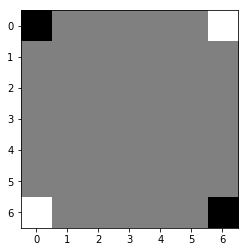

((6, 6), (5, 5)): n_v:   616 q_all:+0.022015 q:+0.029998 q_m:+0.033333 p:0.337576
((0, 0), (1, 1)): n_v:   612 q_all:+0.017447 q:+0.024345 q_m:+0.033333 p:0.349210
((0, 0), (0, 1)): n_v:   189 q_all:+0.016280 q:+0.006163 q_m:+0.033333 p:0.108955
((6, 6), (6, 5)): n_v:   173 q_all:+0.013976 q:+0.022612 q_m:+0.033333 p:0.101878
((0, 0), (1, 0)): n_v:    91 q_all:+0.012871 q:+0.022902 q_m:+0.033333 p:0.053916
((6, 6), (5, 6)): n_v:    79 q_all:+0.014863 q:+0.014447 q_m:+0.033333 p:0.046450
((6, 6), (6, 4)): n_v:     0 q_all:+0.003314 q:+0.003314 q_m:-0.000000 p:0.000053
((0, 0), (1, 2)): n_v:     0 q_all:-0.006747 q:-0.006747 q_m:-0.000000 p:0.000108
((0, 0), (2, 2)): n_v:     0 q_all:-0.014685 q:-0.014685 q_m:-0.000000 p:0.000295
((0, 0), (0, 2)): n_v:     0 q_all:-0.007247 q:-0.007247 q_m:-0.000000 p:0.000050
((6, 6), (4, 6)): n_v:     0 q_all:-0.000496 q:-0.000496 q_m:-0.000000 p:0.000216
((6, 6), (5, 4)): n_v:     0 q_all:+0.006660 q:+0.006660 q_m:-0.000000 p:0.000090
((6, 6), (4, 4))

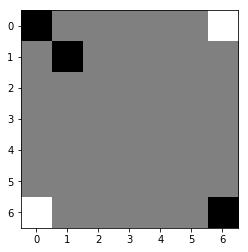

((6, 0), (5, 1)): n_v:   681 q_all:-0.021206 q:-0.007657 q_m:-0.000000 p:0.283082
((0, 6), (1, 5)): n_v:   510 q_all:-0.021270 q:-0.023368 q_m:-0.000000 p:0.211785
((6, 0), (5, 0)): n_v:   462 q_all:-0.025252 q:-0.019498 q_m:-0.000000 p:0.199671
((0, 6), (1, 6)): n_v:   387 q_all:-0.018635 q:-0.029092 q_m:-0.000000 p:0.156911
((6, 0), (6, 1)): n_v:   190 q_all:-0.026775 q:-0.019318 q_m:-0.000000 p:0.083379
((0, 6), (0, 5)): n_v:   142 q_all:-0.026505 q:-0.035640 q_m:-0.000000 p:0.062056
((0, 6), (2, 4)): n_v:     0 q_all:-0.064569 q:-0.064569 q_m:-0.033333 p:0.000224
((6, 0), (6, 2)): n_v:     0 q_all:-0.037948 q:-0.037948 q_m:-0.033333 p:0.000182
((6, 0), (5, 2)): n_v:     0 q_all:-0.035466 q:-0.035466 q_m:-0.033333 p:0.000148
((6, 0), (4, 1)): n_v:     0 q_all:-0.033544 q:-0.033544 q_m:-0.033333 p:0.000415
((0, 6), (2, 6)): n_v:     0 q_all:-0.023317 q:-0.023317 q_m:-0.033333 p:0.000173
((0, 6), (0, 4)): n_v:     0 q_all:-0.058625 q:-0.058625 q_m:-0.033333 p:0.000201
((0, 6), (2, 5))

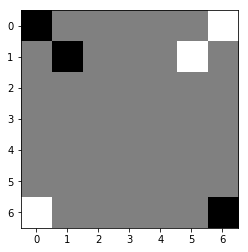

((6, 6), (5, 5)): n_v:   606 q_all:+0.021597 q:+0.032774 q_m:+0.033333 p:0.200442
((1, 1), (2, 2)): n_v:   334 q_all:+0.016095 q:+0.016766 q_m:+0.033333 p:0.118489
((0, 0), (0, 1)): n_v:   270 q_all:+0.014964 q:+0.003145 q_m:+0.033333 p:0.097127
((1, 1), (2, 1)): n_v:   219 q_all:+0.012134 q:+0.012397 q_m:+0.033333 p:0.081184
((6, 6), (6, 5)): n_v:   215 q_all:+0.013417 q:+0.026718 q_m:+0.033333 p:0.078460
((1, 1), (1, 2)): n_v:   171 q_all:+0.008214 q:+0.009002 q_m:+0.033333 p:0.066527
((0, 0), (1, 0)): n_v:   152 q_all:+0.012336 q:+0.007940 q_m:+0.033333 p:0.056131
((1, 1), (2, 0)): n_v:   123 q_all:+0.013329 q:+0.014519 q_m:+0.033333 p:0.045204
((1, 1), (0, 2)): n_v:    93 q_all:+0.007088 q:+0.004786 q_m:+0.033333 p:0.036442
((6, 6), (5, 6)): n_v:    86 q_all:+0.015048 q:+0.017669 q_m:+0.033333 p:0.031145
((0, 0), (2, 2)): n_v:     1 q_all:-0.001709 q:-0.013303 q_m:-0.000000 p:0.000604
((1, 1), (3, 0)): n_v:     0 q_all:-0.004081 q:-0.004081 q_m:-0.000000 p:0.000116
((6, 6), (6, 4))

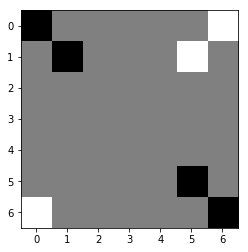

((6, 0), (5, 1)): n_v:   418 q_all:-0.018078 q:+0.002484 q_m:-0.000000 p:0.149600
((1, 5), (2, 4)): n_v:   380 q_all:-0.013779 q:-0.030276 q_m:-0.000000 p:0.129645
((1, 5), (2, 6)): n_v:   327 q_all:-0.017055 q:-0.010083 q_m:-0.000000 p:0.115798
((1, 5), (2, 5)): n_v:   278 q_all:-0.013291 q:-0.010249 q_m:-0.000000 p:0.094240
((6, 0), (5, 0)): n_v:   263 q_all:-0.026769 q:-0.011014 q_m:-0.000000 p:0.103828
((0, 6), (1, 6)): n_v:   243 q_all:-0.029759 q:-0.051539 q_m:-0.000000 p:0.098947
((6, 0), (6, 1)): n_v:   156 q_all:-0.025971 q:-0.013109 q_m:-0.000000 p:0.061114
((0, 6), (0, 5)): n_v:   107 q_all:-0.030593 q:-0.054447 q_m:-0.000000 p:0.043870
((1, 5), (0, 4)): n_v:    93 q_all:-0.029943 q:-0.042634 q_m:-0.000000 p:0.038028
((1, 5), (1, 4)): n_v:    67 q_all:-0.023338 q:-0.031938 q_m:-0.000000 p:0.025450
((1, 5), (3, 3)): n_v:     0 q_all:-0.049838 q:-0.049838 q_m:-0.033333 p:0.000041
((1, 5), (0, 3)): n_v:     0 q_all:-0.063232 q:-0.063232 q_m:-0.033333 p:0.000137
((0, 6), (0, 4))

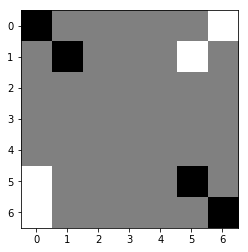

((5, 5), (4, 5)): n_v:    53 q_all:+0.025182 q:+0.019962 q_m:+0.033333 p:0.126840
((5, 5), (6, 5)): n_v:    44 q_all:+0.025686 q:+0.024121 q_m:+0.033333 p:0.105197
((1, 1), (2, 1)): n_v:    39 q_all:+0.035005 q:+0.018471 q_m:+0.033333 p:0.089422
((0, 0), (0, 1)): n_v:    39 q_all:+0.025470 q:+0.008585 q_m:+0.033333 p:0.093773
((1, 1), (2, 2)): n_v:    30 q_all:+0.023538 q:+0.017591 q_m:+0.033333 p:0.071669
((5, 5), (4, 4)): n_v:    26 q_all:+0.022202 q:+0.030419 q_m:+0.033333 p:0.064975
((1, 1), (1, 2)): n_v:    12 q_all:+0.024054 q:+0.013859 q_m:+0.033333 p:0.029665
((5, 5), (4, 6)): n_v:    10 q_all:+0.028367 q:+0.025929 q_m:+0.033333 p:0.023489
((1, 1), (2, 0)): n_v:     9 q_all:+0.034959 q:+0.019203 q_m:+0.033333 p:0.022564
((1, 1), (0, 2)): n_v:     9 q_all:+0.030495 q:+0.009237 q_m:+0.033333 p:0.020777
((5, 5), (5, 4)): n_v:     9 q_all:+0.011045 q:+0.025355 q_m:+0.033333 p:0.025221
((0, 0), (1, 0)): n_v:     8 q_all:+0.015838 q:+0.008429 q_m:+0.033333 p:0.021166
((5, 5), (6, 4))

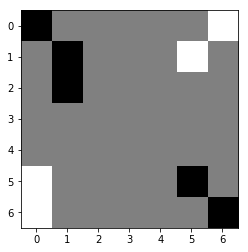

((1, 5), (1, 4)): n_v:   419 q_all:-0.004500 q:-0.038654 q_m:-0.000000 p:0.173275
((0, 6), (1, 6)): n_v:   348 q_all:-0.042822 q:-0.060080 q_m:-0.000000 p:0.209716
((1, 5), (2, 4)): n_v:   323 q_all:+0.001779 q:-0.035531 q_m:-0.000000 p:0.123662
((5, 0), (4, 0)): n_v:   103 q_all:-0.000989 q:-0.040616 q_m:-0.000000 p:0.040990
((1, 5), (2, 6)): n_v:    90 q_all:-0.014659 q:-0.019916 q_m:-0.000000 p:0.042015
((5, 0), (5, 1)): n_v:    72 q_all:-0.025409 q:-0.026225 q_m:-0.000000 p:0.037660
((5, 0), (4, 1)): n_v:    55 q_all:+0.001702 q:-0.030243 q_m:-0.000000 p:0.020694
((0, 6), (0, 5)): n_v:    48 q_all:-0.041676 q:-0.062390 q_m:-0.000000 p:0.028827
((1, 5), (2, 5)): n_v:    47 q_all:-0.005513 q:-0.020117 q_m:-0.000000 p:0.019988
((1, 5), (0, 4)): n_v:    37 q_all:-0.007893 q:-0.049201 q_m:-0.000000 p:0.016096
((5, 0), (6, 1)): n_v:    32 q_all:-0.028451 q:-0.020294 q_m:-0.000000 p:0.016907
((5, 0), (3, 2)): n_v:    28 q_all:-0.047762 q:+0.002712 q_m:+0.033333 p:0.017540
((5, 0), (3, 1))

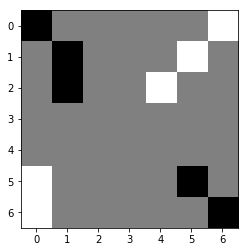

((5, 5), (4, 5)): n_v:   464 q_all:+0.020025 q:+0.015266 q_m:+0.033333 p:0.188895
((2, 1), (3, 1)): n_v:   263 q_all:+0.014265 q:+0.002172 q_m:+0.033333 p:0.114018
((2, 1), (2, 3)): n_v:   149 q_all:+0.036760 q:+0.025526 q_m:+0.066667 p:0.049364
((5, 5), (6, 5)): n_v:   121 q_all:+0.032694 q:+0.021719 q_m:+0.033333 p:0.042339
((0, 0), (0, 1)): n_v:   107 q_all:+0.018174 q:+0.011348 q_m:+0.033333 p:0.044379
((2, 1), (3, 2)): n_v:    82 q_all:-0.003764 q:+0.028615 q_m:+0.033333 p:0.042714
((5, 5), (4, 4)): n_v:    73 q_all:+0.034490 q:+0.031170 q_m:+0.033333 p:0.025092
((1, 1), (2, 2)): n_v:    71 q_all:-0.021712 q:+0.006021 q_m:+0.033333 p:0.042525
((1, 1), (1, 2)): n_v:    64 q_all:-0.029068 q:+0.007276 q_m:+0.033333 p:0.040536
((2, 1), (3, 0)): n_v:    62 q_all:+0.042278 q:+0.005465 q_m:+0.033333 p:0.018876
((5, 5), (3, 3)): n_v:    59 q_all:+0.039193 q:+0.032431 q_m:+0.066667 p:0.018705
((5, 5), (4, 6)): n_v:    49 q_all:+0.034047 q:+0.020394 q_m:+0.033333 p:0.017034
((1, 1), (2, 0))

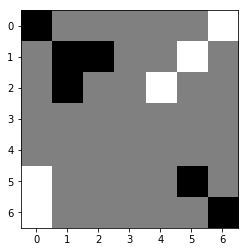

((2, 4), (2, 2)): n_v:  1549 q_all:+0.073687 q:+0.030810 q_m:+0.166667 p:0.725030
((2, 4), (4, 2)): n_v:   119 q_all:-0.008331 q:-0.036879 q_m:-0.033333 p:0.102234
((2, 4), (1, 3)): n_v:    51 q_all:+0.005683 q:-0.010945 q_m:+0.066667 p:0.040437
((2, 4), (0, 2)): n_v:    35 q_all:-0.091981 q:-0.012681 q_m:+0.100000 p:0.043637
((2, 4), (4, 4)): n_v:    17 q_all:+0.040705 q:+0.011480 q_m:+0.033333 p:0.011119
((2, 4), (0, 5)): n_v:    12 q_all:-0.045616 q:-0.064463 q_m:-0.033333 p:0.012978
((2, 4), (1, 6)): n_v:    12 q_all:-0.060316 q:-0.059840 q_m:-0.033333 p:0.013616
((2, 4), (2, 3)): n_v:     8 q_all:+0.004724 q:-0.009179 q_m:+0.066667 p:0.006776
((0, 6), (1, 6)): n_v:     5 q_all:-0.001716 q:-0.046443 q_m:-0.000000 p:0.004712
((5, 0), (4, 2)): n_v:     2 q_all:+0.001657 q:-0.017475 q_m:-0.033333 p:0.002231
((2, 4), (0, 4)): n_v:     2 q_all:-0.021874 q:-0.052664 q_m:-0.033333 p:0.002187
((0, 6), (0, 5)): n_v:     2 q_all:-0.081530 q:-0.056479 q_m:-0.000000 p:0.002580
((2, 4), (3, 5))

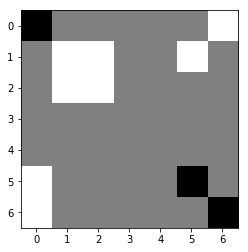

((0, 0), (1, 0)): n_v:  1293 q_all:-0.068254 q:-0.038500 q_m:-0.000000 p:0.343640
((0, 0), (0, 1)): n_v:   815 q_all:-0.103458 q:-0.037822 q_m:-0.000000 p:0.319115
((5, 5), (4, 4)): n_v:   164 q_all:-0.065726 q:-0.072117 q_m:-0.133333 p:0.042337
((0, 0), (2, 0)): n_v:   145 q_all:-0.048324 q:-0.048454 q_m:-0.033333 p:0.028374
((0, 0), (0, 2)): n_v:   136 q_all:-0.045997 q:-0.067945 q_m:-0.033333 p:0.025411
((5, 5), (6, 5)): n_v:   133 q_all:-0.073194 q:-0.081134 q_m:-0.133333 p:0.037671
((5, 5), (4, 5)): n_v:   109 q_all:-0.056627 q:-0.082148 q_m:-0.133333 p:0.024461
((5, 5), (4, 6)): n_v:    96 q_all:-0.071738 q:-0.087914 q_m:-0.133333 p:0.026893
((5, 5), (5, 4)): n_v:    75 q_all:-0.075418 q:-0.077964 q_m:-0.133333 p:0.021949
((5, 5), (5, 6)): n_v:    50 q_all:-0.075200 q:-0.088796 q_m:-0.133333 p:0.014586
((5, 5), (3, 3)): n_v:    32 q_all:-0.096048 q:-0.077904 q_m:-0.100000 p:0.011959
((5, 5), (6, 4)): n_v:    23 q_all:-0.083316 q:-0.069903 q_m:-0.133333 p:0.007467
((5, 5), (3, 4))

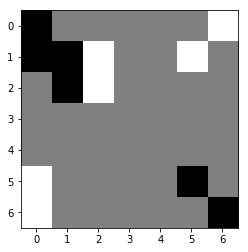

((1, 2), (0, 1)): n_v:  2164 q_all:+0.076105 q:+0.081968 q_m:+0.233333 p:0.490535
((0, 6), (0, 5)): n_v:   150 q_all:+0.005373 q:-0.030399 q_m:+0.033333 p:0.072583
((1, 2), (2, 0)): n_v:   145 q_all:+0.061223 q:+0.061391 q_m:+0.200000 p:0.040854
((2, 2), (2, 0)): n_v:   141 q_all:+0.046577 q:+0.071696 q_m:+0.200000 p:0.047288
((5, 0), (6, 1)): n_v:   127 q_all:+0.021950 q:+0.009744 q_m:+0.033333 p:0.054071
((2, 2), (0, 1)): n_v:   119 q_all:+0.052459 q:+0.056114 q_m:+0.200000 p:0.037298
((1, 5), (2, 6)): n_v:    75 q_all:+0.021226 q:+0.003987 q_m:+0.033333 p:0.032275
((2, 2), (4, 0)): n_v:    38 q_all:-0.001420 q:-0.024380 q_m:-0.000000 p:0.019525
((5, 0), (4, 0)): n_v:    24 q_all:+0.011869 q:-0.007307 q_m:+0.033333 p:0.011307
((1, 5), (2, 5)): n_v:    11 q_all:+0.039462 q:+0.014538 q_m:+0.033333 p:0.004059
((1, 5), (2, 4)): n_v:     8 q_all:+0.003232 q:-0.003517 q_m:+0.033333 p:0.004319
((5, 0), (4, 1)): n_v:     6 q_all:-0.001069 q:-0.000864 q_m:+0.033333 p:0.003094
((2, 2), (3, 1))

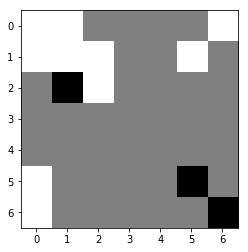

((2, 1), (0, 2)): n_v:  1969 q_all:-0.052875 q:-0.065428 q_m:-0.033333 p:0.414108
((2, 1), (2, 0)): n_v:   783 q_all:-0.079237 q:-0.073102 q_m:-0.066667 p:0.231664
((5, 5), (6, 4)): n_v:   167 q_all:-0.135591 q:-0.136777 q_m:-0.200000 p:0.080291
((2, 1), (3, 1)): n_v:   118 q_all:-0.157103 q:-0.159061 q_m:-0.133333 p:0.065250
((5, 5), (6, 5)): n_v:   113 q_all:-0.131866 q:-0.150506 q_m:-0.200000 p:0.052490
((2, 1), (3, 2)): n_v:    69 q_all:-0.169208 q:-0.135788 q_m:-0.133333 p:0.040456
((5, 5), (4, 4)): n_v:    54 q_all:-0.143393 q:-0.131946 q_m:-0.200000 p:0.027304
((5, 5), (4, 6)): n_v:    30 q_all:-0.152414 q:-0.157173 q_m:-0.200000 p:0.015926
((5, 5), (4, 5)): n_v:    18 q_all:-0.131590 q:-0.150142 q_m:-0.200000 p:0.008323
((5, 5), (5, 4)): n_v:    10 q_all:-0.104120 q:-0.140052 q_m:-0.200000 p:0.004017
((2, 1), (3, 0)): n_v:     9 q_all:-0.183704 q:-0.188166 q_m:-0.200000 p:0.006165
((2, 1), (2, 3)): n_v:     8 q_all:-0.166299 q:-0.160610 q_m:-0.100000 p:0.005136
((2, 1), (1, 3))

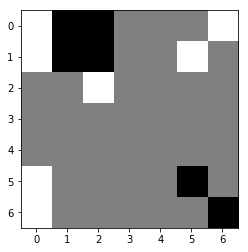

((2, 2), (1, 3)): n_v:  2293 q_all:+0.058177 q:+0.049560 q_m:+0.200000 p:0.567358
((5, 0), (4, 1)): n_v:   275 q_all:+0.033594 q:+0.013803 q_m:+0.066667 p:0.090874
((1, 0), (2, 1)): n_v:   255 q_all:+0.070376 q:+0.068181 q_m:+0.200000 p:0.052789
((1, 5), (2, 5)): n_v:   243 q_all:+0.025205 q:+0.011442 q_m:+0.066667 p:0.087168
((0, 6), (0, 5)): n_v:    31 q_all:+0.008400 q:-0.027022 q_m:+0.066667 p:0.012939
((2, 2), (4, 1)): n_v:    26 q_all:+0.038256 q:-0.005870 q_m:+0.033333 p:0.008254
((1, 5), (2, 6)): n_v:    24 q_all:+0.009079 q:+0.016422 q_m:+0.066667 p:0.010104
((5, 0), (6, 1)): n_v:    22 q_all:+0.004291 q:+0.015035 q_m:+0.066667 p:0.009444
((0, 6), (1, 6)): n_v:    22 q_all:-0.006158 q:-0.033838 q_m:+0.066667 p:0.010393
((2, 2), (2, 3)): n_v:    20 q_all:+0.007672 q:+0.016288 q_m:+0.133333 p:0.008318
((1, 0), (2, 0)): n_v:    17 q_all:-0.009137 q:+0.036085 q_m:+0.133333 p:0.008224
((5, 0), (4, 0)): n_v:    17 q_all:+0.029737 q:+0.011267 q_m:+0.066667 p:0.006104
((1, 5), (2, 4))

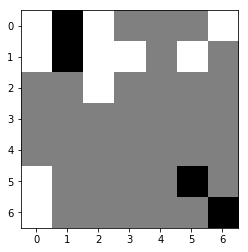

((1, 1), (2, 1)): n_v:  1239 q_all:-0.044413 q:-0.053265 q_m:+0.033333 p:0.294193
((0, 1), (2, 3)): n_v:  1038 q_all:-0.036245 q:-0.098731 q_m:-0.000000 p:0.219957
((1, 1), (2, 3)): n_v:   555 q_all:-0.085343 q:-0.052025 q_m:-0.000000 p:0.203449
((0, 1), (0, 3)): n_v:   275 q_all:-0.087756 q:-0.087436 q_m:-0.000000 p:0.102968
((1, 1), (0, 3)): n_v:   267 q_all:-0.087758 q:-0.039580 q_m:-0.000000 p:0.099754
((0, 1), (2, 1)): n_v:    59 q_all:-0.063836 q:-0.111178 q_m:-0.000000 p:0.017714
((5, 5), (4, 5)): n_v:    53 q_all:-0.082664 q:-0.142517 q_m:-0.166667 p:0.019145
((5, 5), (6, 5)): n_v:    33 q_all:-0.068651 q:-0.141514 q_m:-0.166667 p:0.010648
((1, 1), (2, 0)): n_v:    16 q_all:-0.109724 q:-0.077450 q_m:-0.100000 p:0.007260
((5, 5), (4, 3)): n_v:     9 q_all:-0.120218 q:-0.145618 q_m:-0.200000 p:0.004714
((5, 5), (4, 4)): n_v:     3 q_all:-0.085771 q:-0.124168 q_m:-0.166667 p:0.001414
((5, 5), (5, 4)): n_v:     3 q_all:-0.073447 q:-0.134374 q_m:-0.166667 p:0.001233
((5, 5), (6, 3))

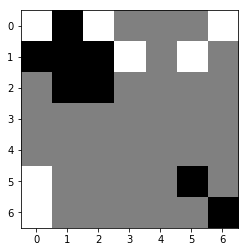

((0, 2), (2, 0)): n_v:  1659 q_all:+0.069479 q:+0.059063 q_m:+0.166667 p:0.419996
((1, 3), (2, 3)): n_v:   376 q_all:+0.041351 q:+0.035188 q_m:+0.133333 p:0.134039
((5, 0), (4, 0)): n_v:   199 q_all:-0.012235 q:-0.002856 q_m:-0.000000 p:0.110110
((0, 0), (2, 0)): n_v:   126 q_all:+0.055340 q:+0.100738 q_m:+0.166667 p:0.038475
((0, 2), (0, 3)): n_v:   111 q_all:+0.005800 q:+0.014801 q_m:+0.066667 p:0.054026
((5, 0), (3, 2)): n_v:    44 q_all:+0.009286 q:+0.036953 q_m:+0.100000 p:0.020942
((1, 5), (2, 6)): n_v:    44 q_all:-0.029988 q:+0.008993 q_m:-0.000000 p:0.027363
((5, 0), (3, 1)): n_v:    39 q_all:+0.034743 q:+0.022900 q_m:+0.100000 p:0.014987
((6, 0), (4, 0)): n_v:    33 q_all:-0.052664 q:-0.020286 q_m:-0.033333 p:0.023573
((1, 3), (3, 1)): n_v:    28 q_all:+0.038606 q:+0.006438 q_m:+0.100000 p:0.009995
((0, 6), (2, 6)): n_v:    22 q_all:-0.045436 q:-0.005395 q_m:-0.033333 p:0.015257
((0, 6), (1, 6)): n_v:    17 q_all:-0.067160 q:-0.038139 q_m:-0.000000 p:0.013422
((1, 3), (3, 5))

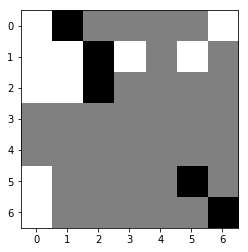

((0, 1), (0, 2)): n_v:  2717 q_all:-0.084362 q:-0.069340 q_m:-0.000000 p:0.553293
((2, 2), (3, 1)): n_v:   391 q_all:-0.070464 q:-0.069401 q_m:-0.000000 p:0.061000
((2, 2), (0, 2)): n_v:    31 q_all:-0.116504 q:-0.104759 q_m:-0.033333 p:0.009733
((2, 2), (0, 4)): n_v:    25 q_all:-0.069559 q:-0.050149 q_m:-0.033333 p:0.003696
((5, 5), (6, 4)): n_v:    16 q_all:-0.129556 q:-0.115942 q_m:-0.133333 p:0.006037
((1, 2), (3, 1)): n_v:    14 q_all:-0.070306 q:-0.095558 q_m:-0.033333 p:0.002325
((1, 2), (0, 4)): n_v:    13 q_all:-0.062845 q:-0.056977 q_m:-0.033333 p:0.001765
((2, 2), (1, 4)): n_v:     4 q_all:-0.054257 q:-0.040952 q_m:-0.033333 p:0.000414
((1, 2), (1, 4)): n_v:     3 q_all:-0.064613 q:-0.072525 q_m:-0.033333 p:0.000384
((5, 5), (4, 4)): n_v:     2 q_all:-0.123518 q:-0.099555 q_m:-0.133333 p:0.000714
((2, 2), (2, 4)): n_v:     2 q_all:-0.084458 q:-0.042709 q_m:-0.033333 p:0.000566
((1, 2), (2, 4)): n_v:     2 q_all:-0.077228 q:-0.058284 q_m:-0.033333 p:0.000271
((5, 5), (6, 5))

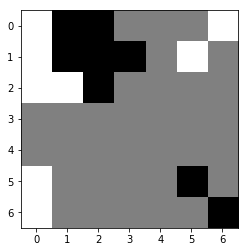

((1, 5), (0, 3)): n_v:  1984 q_all:+0.106025 q:+0.099190 q_m:+0.200000 p:0.283984
((2, 1), (0, 3)): n_v:  1221 q_all:+0.058571 q:+0.068544 q_m:+0.200000 p:0.348250
((1, 5), (2, 3)): n_v:   484 q_all:+0.061420 q:+0.037155 q_m:+0.200000 p:0.133771
((2, 1), (2, 3)): n_v:   210 q_all:+0.012522 q:+0.035159 q_m:+0.200000 p:0.088837
((1, 5), (1, 4)): n_v:    77 q_all:+0.017598 q:+0.020022 q_m:+0.100000 p:0.031719
((2, 0), (3, 1)): n_v:    51 q_all:+0.029739 q:+0.027451 q_m:+0.100000 p:0.018942
((1, 5), (2, 4)): n_v:    26 q_all:+0.036680 q:+0.039165 q_m:+0.100000 p:0.009259
((1, 5), (0, 4)): n_v:    19 q_all:+0.027020 q:+0.028845 q_m:+0.100000 p:0.007222
((5, 0), (4, 1)): n_v:    13 q_all:+0.002871 q:+0.035170 q_m:+0.033333 p:0.006050
((2, 1), (4, 3)): n_v:    13 q_all:-0.022301 q:+0.015273 q_m:-0.000000 p:0.007311
((2, 1), (3, 2)): n_v:    12 q_all:+0.021513 q:+0.029552 q_m:+0.100000 p:0.005030
((0, 6), (0, 5)): n_v:    12 q_all:-0.007459 q:+0.000423 q_m:+0.033333 p:0.005659
((1, 5), (2, 5))

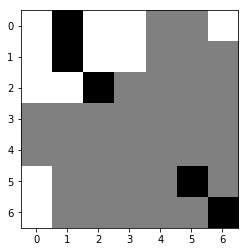

((2, 2), (2, 3)): n_v:  2800 q_all:-0.104816 q:-0.135332 q_m:-0.033333 p:0.790931
((2, 2), (3, 1)): n_v:   160 q_all:-0.086332 q:-0.090551 q_m:-0.033333 p:0.035732
((5, 5), (6, 4)): n_v:    71 q_all:-0.118183 q:-0.159653 q_m:-0.166667 p:0.023161
((2, 2), (0, 4)): n_v:    68 q_all:-0.124563 q:-0.139886 q_m:-0.066667 p:0.023619
((2, 2), (1, 4)): n_v:    51 q_all:-0.103033 q:-0.165768 q_m:-0.066667 p:0.014105
((1, 1), (2, 3)): n_v:    44 q_all:-0.149113 q:-0.112664 q_m:-0.066667 p:0.019145
((2, 2), (2, 4)): n_v:    40 q_all:-0.153229 q:-0.186810 q_m:-0.133333 p:0.018035
((5, 5), (6, 5)): n_v:    32 q_all:-0.112454 q:-0.171416 q_m:-0.166667 p:0.009770
((0, 1), (2, 3)): n_v:    31 q_all:-0.142934 q:-0.201340 q_m:-0.066667 p:0.012573
((2, 2), (3, 2)): n_v:    19 q_all:-0.133792 q:-0.152336 q_m:-0.100000 p:0.007277
((5, 5), (4, 4)): n_v:    17 q_all:-0.133958 q:-0.147570 q_m:-0.166667 p:0.006222
((5, 5), (4, 5)): n_v:    15 q_all:-0.122654 q:-0.174480 q_m:-0.166667 p:0.005137
((5, 5), (5, 4))

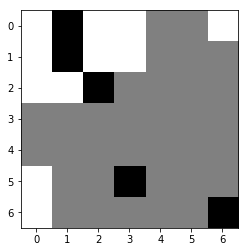

((2, 0), (3, 1)): n_v:   497 q_all:+0.195582 q:+0.163433 q_m:+0.300000 p:0.098208
((1, 2), (2, 3)): n_v:   330 q_all:+0.164923 q:+0.142250 q_m:+0.300000 p:0.114793
((2, 1), (3, 2)): n_v:   115 q_all:+0.185144 q:+0.142527 q_m:+0.300000 p:0.028406
((0, 3), (1, 5)): n_v:    73 q_all:+0.119662 q:+0.115612 q_m:+0.200000 p:0.042321
((1, 3), (2, 4)): n_v:    56 q_all:+0.140589 q:+0.104485 q_m:+0.233333 p:0.026789
((0, 3), (1, 4)): n_v:    56 q_all:+0.078348 q:+0.124395 q_m:+0.233333 p:0.044621
((5, 0), (5, 1)): n_v:    54 q_all:+0.047075 q:+0.161860 q_m:+0.233333 p:0.051087
((5, 0), (4, 0)): n_v:    48 q_all:+0.111342 q:+0.136563 q_m:+0.233333 p:0.030134
((0, 6), (1, 5)): n_v:    42 q_all:+0.105291 q:+0.144984 q_m:+0.233333 p:0.027129
((2, 0), (3, 0)): n_v:    41 q_all:+0.109733 q:+0.122248 q_m:+0.233333 p:0.025858
((0, 3), (0, 4)): n_v:    37 q_all:+0.117713 q:+0.132853 q_m:+0.233333 p:0.022173
((1, 3), (1, 5)): n_v:    35 q_all:+0.048824 q:+0.095603 q_m:+0.200000 p:0.032767
((5, 0), (6, 1))

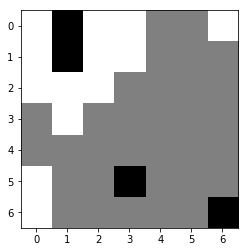

((5, 3), (4, 3)): n_v:   800 q_all:-0.205574 q:-0.256047 q_m:-0.266667 p:0.463375
((5, 3), (3, 2)): n_v:   440 q_all:-0.160908 q:-0.149692 q_m:-0.100000 p:0.169101
((1, 1), (3, 2)): n_v:   266 q_all:-0.169073 q:-0.136755 q_m:-0.100000 p:0.111823
((5, 3), (3, 4)): n_v:   172 q_all:-0.176272 q:-0.279039 q_m:-0.300000 p:0.078120
((1, 1), (3, 0)): n_v:   116 q_all:-0.120178 q:-0.148789 q_m:-0.100000 p:0.023698
((5, 3), (5, 1)): n_v:    69 q_all:-0.150998 q:-0.233979 q_m:-0.166667 p:0.023082
((1, 1), (2, 3)): n_v:    64 q_all:-0.215910 q:-0.151311 q_m:-0.100000 p:0.040473
((0, 1), (2, 3)): n_v:    43 q_all:-0.165211 q:-0.249867 q_m:-0.100000 p:0.017511
((6, 6), (5, 5)): n_v:    22 q_all:-0.168335 q:-0.291651 q_m:-0.266667 p:0.008962
((5, 3), (6, 1)): n_v:    19 q_all:-0.214081 q:-0.232876 q_m:-0.166667 p:0.012187
((5, 3), (5, 5)): n_v:    18 q_all:-0.160805 q:-0.288850 q_m:-0.300000 p:0.007290
((5, 3), (3, 5)): n_v:    16 q_all:-0.208748 q:-0.279481 q_m:-0.300000 p:0.009403
((5, 3), (5, 4))

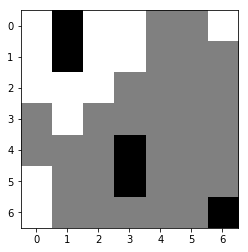

((2, 2), (4, 2)): n_v:   743 q_all:+0.167858 q:+0.167985 q_m:+0.400000 p:0.291717
((3, 1), (5, 2)): n_v:   538 q_all:+0.251627 q:+0.219591 q_m:+0.400000 p:0.027966
((3, 1), (4, 2)): n_v:   525 q_all:+0.179659 q:+0.191679 q_m:+0.433333 p:0.180586
((2, 1), (3, 2)): n_v:   153 q_all:+0.154824 q:+0.200153 q_m:+0.366667 p:0.068303
((2, 1), (4, 2)): n_v:   116 q_all:+0.145694 q:+0.116043 q_m:+0.400000 p:0.055976
((6, 0), (5, 2)): n_v:    45 q_all:+0.192399 q:+0.218631 q_m:+0.400000 p:0.012745
((5, 0), (5, 2)): n_v:    29 q_all:+0.222602 q:+0.206290 q_m:+0.400000 p:0.004209
((2, 2), (4, 4)): n_v:    25 q_all:+0.180349 q:+0.228318 q_m:+0.400000 p:0.008826
((3, 1), (4, 1)): n_v:    23 q_all:+0.168686 q:+0.145172 q_m:+0.300000 p:0.009204
((2, 0), (4, 2)): n_v:    20 q_all:+0.111486 q:+0.170849 q_m:+0.400000 p:0.011997
((3, 1), (4, 0)): n_v:    19 q_all:+0.209476 q:+0.145986 q_m:+0.300000 p:0.003785
((2, 0), (3, 0)): n_v:    19 q_all:+0.219465 q:+0.152546 q_m:+0.300000 p:0.003400
((5, 0), (4, 2))

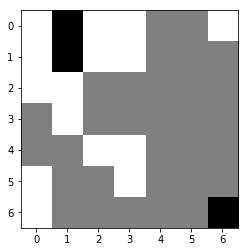

((1, 1), (2, 2)): n_v:  1613 q_all:-0.152051 q:-0.195354 q_m:-0.100000 p:0.754525
((1, 1), (3, 2)): n_v:   420 q_all:-0.076089 q:-0.114999 q_m:-0.133333 p:0.068679
((0, 1), (2, 2)): n_v:   159 q_all:-0.107980 q:-0.295232 q_m:-0.133333 p:0.046638
((6, 6), (4, 4)): n_v:   159 q_all:-0.192875 q:-0.238660 q_m:-0.266667 p:0.100929
((1, 1), (3, 3)): n_v:    27 q_all:-0.178755 q:-0.171889 q_m:-0.266667 p:0.015841
((1, 1), (2, 3)): n_v:    26 q_all:-0.060559 q:-0.242192 q_m:-0.266667 p:0.002477
((1, 1), (3, 0)): n_v:    22 q_all:-0.098939 q:-0.242345 q_m:-0.200000 p:0.005537
((6, 6), (5, 4)): n_v:     4 q_all:-0.164087 q:-0.248616 q_m:-0.266667 p:0.002390
((0, 1), (2, 3)): n_v:     0 q_all:-0.303698 q:-0.303698 q_m:-0.266667 p:0.000994
((6, 6), (5, 5)): n_v:     0 q_all:-0.322692 q:-0.322692 q_m:-0.366667 p:0.000813
((6, 6), (6, 4)): n_v:     0 q_all:-0.311426 q:-0.311426 q_m:-0.333333 p:0.000418
((6, 6), (5, 6)): n_v:     0 q_all:-0.342983 q:-0.342983 q_m:-0.366667 p:0.000068
((6, 6), (6, 5))

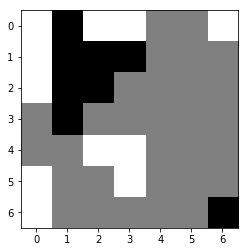

((4, 2), (3, 2)): n_v:  1212 q_all:+0.166020 q:+0.162624 q_m:+0.333333 p:0.261212
((4, 2), (2, 3)): n_v:   884 q_all:+0.160732 q:+0.143614 q_m:+0.300000 p:0.207158
((0, 3), (2, 3)): n_v:   374 q_all:+0.090984 q:+0.078303 q_m:+0.300000 p:0.179598
((4, 3), (3, 4)): n_v:   148 q_all:+0.081130 q:+0.101938 q_m:+0.133333 p:0.076531
((4, 3), (2, 3)): n_v:   120 q_all:+0.149212 q:+0.148966 q_m:+0.300000 p:0.032962
((5, 0), (3, 2)): n_v:   113 q_all:+0.108669 q:+0.155710 q_m:+0.300000 p:0.047165
((0, 2), (2, 3)): n_v:    57 q_all:+0.078740 q:+0.083755 q_m:+0.300000 p:0.029886
((4, 2), (3, 0)): n_v:    28 q_all:+0.135591 q:+0.151974 q_m:+0.233333 p:0.009242
((2, 0), (3, 2)): n_v:    22 q_all:+0.093404 q:+0.127951 q_m:+0.300000 p:0.010387
((5, 3), (3, 2)): n_v:     8 q_all:+0.074596 q:+0.134245 q_m:+0.300000 p:0.004449
((4, 3), (2, 5)): n_v:     7 q_all:+0.083987 q:+0.104111 q_m:+0.100000 p:0.003522
((1, 0), (3, 2)): n_v:     6 q_all:+0.074100 q:+0.076894 q_m:+0.300000 p:0.003668
((2, 0), (3, 0))

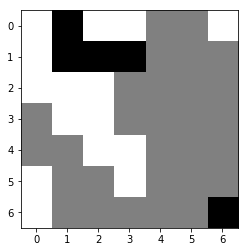

((1, 1), (3, 3)): n_v:  1924 q_all:-0.186177 q:-0.143198 q_m:-0.066667 p:0.713688
((1, 3), (3, 3)): n_v:   675 q_all:-0.147415 q:-0.165251 q_m:-0.066667 p:0.154521
((1, 2), (3, 3)): n_v:   163 q_all:-0.223848 q:-0.189481 q_m:-0.066667 p:0.083245
((1, 1), (2, 3)): n_v:    59 q_all:-0.093062 q:-0.238478 q_m:-0.200000 p:0.001618
((1, 2), (2, 3)): n_v:    18 q_all:-0.280719 q:-0.257138 q_m:-0.166667 p:0.013472
((1, 3), (1, 4)): n_v:    14 q_all:-0.204887 q:-0.285629 q_m:-0.233333 p:0.006497
((1, 3), (3, 5)): n_v:     7 q_all:-0.160942 q:-0.302287 q_m:-0.333333 p:0.002169
((6, 6), (5, 4)): n_v:     5 q_all:-0.169439 q:-0.203280 q_m:-0.200000 p:0.001485
((0, 1), (2, 3)): n_v:     4 q_all:-0.284783 q:-0.310279 q_m:-0.200000 p:0.003507
((1, 3), (2, 4)): n_v:     2 q_all:-0.199013 q:-0.311139 q_m:-0.300000 p:0.001152
((1, 2), (3, 0)): n_v:     1 q_all:-0.289136 q:-0.267467 q_m:-0.133333 p:0.000942
((6, 6), (5, 5)): n_v:     0 q_all:-0.288789 q:-0.288789 q_m:-0.300000 p:0.000488
((1, 1), (3, 0))

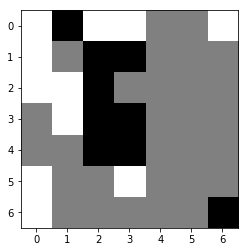

((0, 0), (1, 1)): n_v:  2338 q_all:+0.199154 q:+0.191788 q_m:+0.300000 p:0.021796
((0, 3), (2, 3)): n_v:   561 q_all:+0.098157 q:+0.038618 q_m:+0.400000 p:0.192260
((0, 2), (2, 3)): n_v:   121 q_all:+0.128396 q:+0.069556 q_m:+0.400000 p:0.029247
((2, 1), (2, 3)): n_v:   121 q_all:+0.144579 q:+0.070997 q_m:+0.400000 p:0.022675
((3, 1), (2, 3)): n_v:    85 q_all:+0.125990 q:+0.070194 q_m:+0.400000 p:0.021016
((3, 1), (1, 1)): n_v:    85 q_all:+0.175236 q:+0.146825 q_m:+0.266667 p:0.007316
((5, 0), (5, 1)): n_v:    64 q_all:-0.029725 q:-0.027443 q_m:+0.166667 p:0.049270
((0, 3), (1, 1)): n_v:    14 q_all:+0.158519 q:+0.119601 q_m:+0.266667 p:0.001846
((0, 6), (1, 5)): n_v:    13 q_all:-0.041206 q:-0.029526 q_m:+0.100000 p:0.010820
((0, 3), (1, 5)): n_v:     4 q_all:-0.082470 q:-0.046988 q_m:+0.066667 p:0.004465
((3, 1), (4, 1)): n_v:     4 q_all:-0.039109 q:+0.002560 q_m:+0.233333 p:0.003604
((5, 3), (4, 4)): n_v:     4 q_all:+0.021178 q:+0.008082 q_m:+0.233333 p:0.002416
((5, 3), (5, 2))

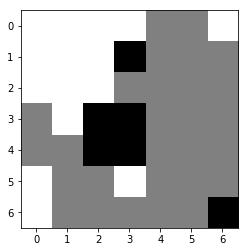

((1, 3), (2, 3)): n_v:  2572 q_all:-0.198487 q:-0.251933 q_m:-0.133333 p:0.286314
((4, 2), (3, 0)): n_v:   224 q_all:-0.218704 q:-0.209201 q_m:-0.100000 p:0.039445
((4, 2), (6, 1)): n_v:   153 q_all:-0.218968 q:-0.197144 q_m:-0.166667 p:0.027033
((1, 3), (0, 5)): n_v:   136 q_all:-0.195074 q:-0.211155 q_m:-0.233333 p:0.013726
((3, 2), (4, 1)): n_v:    90 q_all:-0.234802 q:-0.223638 q_m:-0.133333 p:0.020649
((3, 3), (4, 1)): n_v:    81 q_all:-0.246395 q:-0.234751 q_m:-0.166667 p:0.021436
((3, 3), (5, 1)): n_v:    70 q_all:-0.261331 q:-0.234936 q_m:-0.166667 p:0.021856
((4, 3), (6, 1)): n_v:    68 q_all:-0.232117 q:-0.217621 q_m:-0.166667 p:0.015047
((3, 2), (3, 0)): n_v:    64 q_all:-0.245451 q:-0.206800 q_m:-0.100000 p:0.016746
((3, 3), (1, 5)): n_v:    52 q_all:-0.265002 q:-0.238049 q_m:-0.233333 p:0.017079
((3, 3), (2, 5)): n_v:    49 q_all:-0.285081 q:-0.258635 q_m:-0.300000 p:0.019181
((4, 3), (5, 1)): n_v:    42 q_all:-0.257502 q:-0.251827 q_m:-0.166667 p:0.012638
((3, 2), (5, 1))

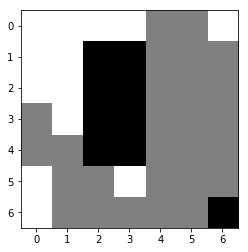

((0, 3), (1, 4)): n_v:   837 q_all:+0.201186 q:+0.170250 q_m:+0.300000 p:0.168978
((5, 3), (5, 2)): n_v:   826 q_all:+0.205113 q:+0.143876 q_m:+0.300000 p:0.156658
((3, 1), (4, 1)): n_v:   722 q_all:+0.216402 q:+0.172157 q_m:+0.300000 p:0.111887
((5, 3), (4, 4)): n_v:   583 q_all:+0.178001 q:+0.156751 q_m:+0.300000 p:0.159639
((5, 3), (5, 4)): n_v:   309 q_all:+0.146073 q:+0.132142 q_m:+0.233333 p:0.115447
((0, 6), (1, 4)): n_v:   147 q_all:+0.177200 q:+0.164156 q_m:+0.266667 p:0.040740
((6, 0), (5, 2)): n_v:   140 q_all:+0.162951 q:+0.138900 q_m:+0.266667 p:0.045052
((0, 6), (2, 4)): n_v:    49 q_all:+0.169272 q:+0.168832 q_m:+0.333333 p:0.014678
((5, 0), (5, 2)): n_v:    31 q_all:+0.180254 q:+0.139416 q_m:+0.266667 p:0.008192
((2, 0), (3, 0)): n_v:    27 q_all:+0.146589 q:+0.102429 q_m:+0.166667 p:0.009927
((2, 0), (4, 1)): n_v:    15 q_all:+0.185119 q:+0.137672 q_m:+0.266667 p:0.003993
((0, 3), (0, 4)): n_v:    14 q_all:+0.142616 q:+0.137319 q_m:+0.233333 p:0.005579
((5, 3), (6, 4))

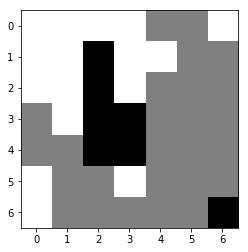

((3, 3), (2, 4)): n_v:  1067 q_all:-0.192100 q:-0.230175 q_m:-0.066667 p:0.303071
((3, 3), (4, 4)): n_v:   212 q_all:-0.279993 q:-0.270513 q_m:-0.200000 p:0.135838
((2, 2), (0, 4)): n_v:   130 q_all:-0.212524 q:-0.238554 q_m:-0.100000 p:0.047949
((4, 2), (2, 4)): n_v:   113 q_all:-0.211725 q:-0.248406 q_m:-0.100000 p:0.041412
((4, 2), (3, 0)): n_v:    76 q_all:-0.220451 q:-0.207030 q_m:-0.100000 p:0.030685
((2, 2), (2, 4)): n_v:    72 q_all:-0.310248 q:-0.241749 q_m:-0.100000 p:0.054860
((1, 2), (2, 4)): n_v:    61 q_all:-0.232836 q:-0.234194 q_m:-0.100000 p:0.027354
((3, 2), (2, 4)): n_v:    61 q_all:-0.284405 q:-0.248142 q_m:-0.100000 p:0.040310
((1, 2), (3, 0)): n_v:    39 q_all:-0.197470 q:-0.211697 q_m:-0.100000 p:0.011860
((3, 3), (1, 5)): n_v:    29 q_all:-0.309996 q:-0.237481 q_m:-0.166667 p:0.022819
((2, 2), (4, 4)): n_v:    29 q_all:-0.253444 q:-0.253094 q_m:-0.233333 p:0.015768
((4, 2), (4, 4)): n_v:    28 q_all:-0.301525 q:-0.280511 q_m:-0.233333 p:0.020952
((4, 3), (2, 4))

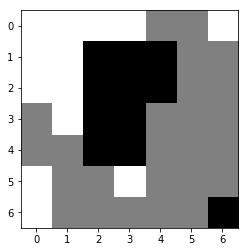

((5, 3), (5, 2)): n_v:   553 q_all:+0.203564 q:+0.096520 q_m:+0.233333 p:0.110172
((5, 3), (3, 4)): n_v:   447 q_all:+0.239560 q:+0.169669 q_m:+0.333333 p:0.026872
((0, 3), (0, 4)): n_v:   392 q_all:+0.149926 q:+0.141657 q_m:+0.233333 p:0.159611
((3, 1), (4, 1)): n_v:   382 q_all:+0.200017 q:+0.135392 q_m:+0.233333 p:0.081472
((5, 3), (6, 4)): n_v:   164 q_all:+0.118330 q:+0.050854 q_m:+0.100000 p:0.087346
((5, 3), (4, 4)): n_v:   140 q_all:+0.143463 q:+0.118599 q_m:+0.233333 p:0.060720
((5, 3), (5, 4)): n_v:   109 q_all:+0.104208 q:+0.088601 q_m:+0.166667 p:0.064207
((5, 3), (6, 2)): n_v:    78 q_all:+0.128347 q:+0.061947 q_m:+0.100000 p:0.038443
((6, 0), (5, 2)): n_v:    60 q_all:+0.159359 q:+0.089378 q_m:+0.200000 p:0.022292
((2, 0), (4, 1)): n_v:    36 q_all:+0.156646 q:+0.094700 q_m:+0.200000 p:0.013866
((0, 6), (0, 4)): n_v:    36 q_all:+0.157623 q:+0.132811 q_m:+0.200000 p:0.013913
((6, 0), (4, 1)): n_v:    34 q_all:+0.158934 q:+0.116029 q_m:+0.200000 p:0.012656
((0, 6), (2, 5))

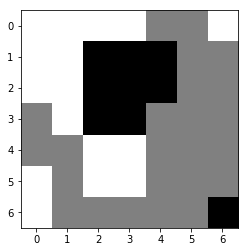

((3, 3), (4, 4)): n_v:   594 q_all:-0.227224 q:-0.232645 q_m:-0.066667 p:0.245124
((3, 2), (5, 1)): n_v:   326 q_all:-0.162159 q:-0.215907 q_m:+0.033333 p:0.042642
((3, 2), (4, 1)): n_v:   139 q_all:-0.211816 q:-0.159817 q_m:+0.066667 p:0.048224
((1, 3), (0, 4)): n_v:   104 q_all:-0.198294 q:-0.275166 q_m:-0.133333 p:0.029675
((3, 3), (4, 1)): n_v:    89 q_all:-0.214955 q:-0.180736 q_m:+0.033333 p:0.032198
((3, 3), (5, 1)): n_v:    80 q_all:-0.203342 q:-0.211024 q_m:+0.033333 p:0.024986
((3, 2), (4, 4)): n_v:    76 q_all:-0.259499 q:-0.258560 q_m:-0.100000 p:0.042179
((2, 2), (4, 1)): n_v:    65 q_all:-0.247474 q:-0.206976 q_m:+0.033333 p:0.032510
((3, 3), (5, 4)): n_v:    59 q_all:-0.277432 q:-0.212468 q_m:-0.100000 p:0.037660
((3, 3), (4, 5)): n_v:    48 q_all:-0.316559 q:-0.325212 q_m:-0.233333 p:0.039037
((1, 2), (3, 0)): n_v:    44 q_all:-0.223936 q:-0.276955 q_m:-0.033333 p:0.017544
((3, 3), (5, 5)): n_v:    43 q_all:-0.323234 q:-0.295169 q_m:-0.233333 p:0.035797
((3, 3), (1, 5))

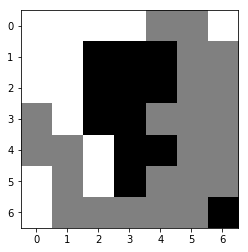

((5, 2), (3, 4)): n_v:  1068 q_all:+0.304129 q:+0.235822 q_m:+0.400000 p:0.212782
((0, 3), (0, 4)): n_v:   675 q_all:+0.181523 q:+0.150099 q_m:+0.233333 p:0.487936
((4, 2), (3, 4)): n_v:   116 q_all:+0.306589 q:+0.190347 q_m:+0.400000 p:0.021804
((0, 6), (0, 4)): n_v:   114 q_all:+0.217162 q:+0.128334 q_m:+0.200000 p:0.064938
((5, 2), (6, 2)): n_v:    76 q_all:+0.136368 q:+0.080645 q_m:+0.166667 p:0.070307
((6, 0), (6, 2)): n_v:    19 q_all:+0.082044 q:+0.060054 q_m:+0.133333 p:0.022583
((4, 2), (5, 4)): n_v:    17 q_all:+0.205167 q:+0.115923 q_m:+0.266667 p:0.010923
((3, 1), (4, 1)): n_v:    11 q_all:+0.139027 q:+0.077845 q_m:+0.166667 p:0.010745
((0, 6), (1, 5)): n_v:    11 q_all:+0.251154 q:+0.154258 q_m:+0.233333 p:0.005069
((2, 0), (3, 0)): n_v:     9 q_all:+0.043180 q:+0.073953 q_m:+0.100000 p:0.011862
((0, 6), (2, 5)): n_v:     7 q_all:+0.220683 q:+0.136938 q_m:+0.200000 p:0.003802
((5, 2), (5, 4)): n_v:     6 q_all:+0.165165 q:+0.155212 q_m:+0.266667 p:0.005326
((4, 2), (6, 4))

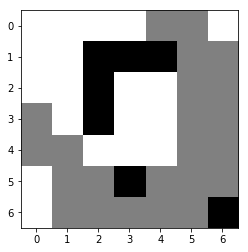

((5, 3), (5, 4)): n_v:   488 q_all:-0.269745 q:-0.251808 q_m:-0.233333 p:0.175568
((5, 3), (5, 2)): n_v:   404 q_all:-0.293864 q:-0.332624 q_m:-0.233333 p:0.183170
((1, 4), (3, 5)): n_v:   336 q_all:-0.245867 q:-0.223857 q_m:-0.200000 p:0.089868
((3, 2), (4, 1)): n_v:   317 q_all:-0.234887 q:-0.243687 q_m:-0.166667 p:0.070866
((1, 4), (2, 5)): n_v:   273 q_all:-0.324342 q:-0.280523 q_m:-0.233333 p:0.156160
((3, 2), (5, 1)): n_v:   240 q_all:-0.184874 q:-0.225229 q_m:-0.200000 p:0.007071
((1, 2), (3, 0)): n_v:   169 q_all:-0.301017 q:-0.293871 q_m:-0.200000 p:0.081464
((1, 4), (3, 6)): n_v:    83 q_all:-0.327626 q:-0.336320 q_m:-0.400000 p:0.048939
((3, 2), (5, 4)): n_v:    40 q_all:-0.295797 q:-0.258068 q_m:-0.266667 p:0.018691
((3, 2), (3, 0)): n_v:    37 q_all:-0.255791 q:-0.253887 q_m:-0.200000 p:0.011213
((6, 6), (4, 5)): n_v:    34 q_all:-0.301794 q:-0.251981 q_m:-0.266667 p:0.016615
((1, 3), (3, 5)): n_v:    29 q_all:-0.336134 q:-0.298600 q_m:-0.200000 p:0.018251
((2, 2), (4, 1))

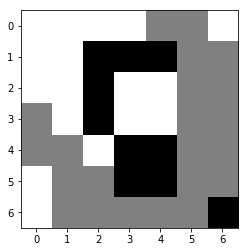

((4, 2), (5, 2)): n_v:  1287 q_all:+0.305858 q:+0.212791 q_m:+0.400000 p:0.566993
((0, 3), (0, 4)): n_v:   400 q_all:+0.323588 q:+0.263109 q_m:+0.400000 p:0.144436
((6, 0), (5, 2)): n_v:   184 q_all:+0.223255 q:+0.203914 q_m:+0.366667 p:0.147218
((0, 6), (0, 4)): n_v:    75 q_all:+0.313966 q:+0.247086 q_m:+0.366667 p:0.030329
((5, 0), (5, 2)): n_v:    43 q_all:+0.293309 q:+0.212108 q_m:+0.366667 p:0.021116
((6, 0), (6, 2)): n_v:    33 q_all:+0.231562 q:+0.178556 q_m:+0.300000 p:0.025774
((5, 0), (6, 2)): n_v:    10 q_all:+0.209611 q:+0.180030 q_m:+0.300000 p:0.008952
((3, 1), (4, 1)): n_v:     8 q_all:+0.239427 q:+0.224728 q_m:+0.333333 p:0.006506
((3, 4), (5, 2)): n_v:     3 q_all:+0.179944 q:+0.172180 q_m:+0.366667 p:0.003098
((3, 4), (4, 5)): n_v:     3 q_all:+0.260192 q:+0.242752 q_m:+0.400000 p:0.002498
((3, 1), (5, 2)): n_v:     2 q_all:+0.196286 q:+0.175534 q_m:+0.366667 p:0.002616
((2, 4), (2, 5)): n_v:     2 q_all:+0.187429 q:+0.197828 q_m:+0.333333 p:0.001950
((2, 4), (3, 5))

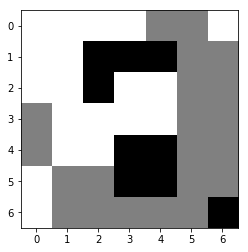

((1, 2), (3, 0)): n_v:   474 q_all:-0.176865 q:-0.230602 q_m:-0.066667 p:0.107389
((4, 4), (3, 5)): n_v:   244 q_all:-0.299040 q:-0.221883 q_m:-0.166667 p:0.204952
((1, 4), (3, 6)): n_v:   129 q_all:-0.286986 q:-0.297106 q_m:-0.333333 p:0.100550
((1, 4), (3, 5)): n_v:   112 q_all:-0.259621 q:-0.241277 q_m:-0.200000 p:0.071432
((4, 3), (5, 1)): n_v:   102 q_all:-0.199813 q:-0.185048 q_m:-0.066667 p:0.035013
((2, 2), (3, 0)): n_v:   101 q_all:-0.221246 q:-0.184403 q_m:-0.066667 p:0.044926
((5, 3), (5, 1)): n_v:    58 q_all:-0.189539 q:-0.189268 q_m:-0.066667 p:0.017131
((5, 4), (3, 6)): n_v:    53 q_all:-0.315217 q:-0.311514 q_m:-0.333333 p:0.048783
((5, 4), (3, 5)): n_v:    40 q_all:-0.302483 q:-0.253881 q_m:-0.200000 p:0.034016
((4, 3), (5, 2)): n_v:    33 q_all:-0.246114 q:-0.216497 q_m:-0.166667 p:0.019278
((4, 4), (3, 6)): n_v:    25 q_all:-0.289071 q:-0.299602 q_m:-0.333333 p:0.019921
((1, 4), (2, 5)): n_v:    24 q_all:-0.263600 q:-0.242417 q_m:-0.166667 p:0.016327
((4, 3), (3, 5))

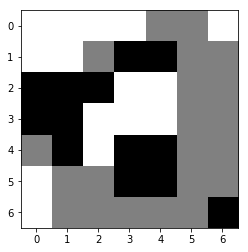

((0, 1), (1, 2)): n_v:  1839 q_all:+0.257004 q:+0.206697 q_m:+0.300000 p:0.130272
((4, 2), (5, 2)): n_v:   227 q_all:-0.013589 q:+0.026173 q_m:+0.300000 p:0.276714
((6, 0), (5, 2)): n_v:   124 q_all:-0.024607 q:+0.034025 q_m:+0.266667 p:0.157411
((0, 0), (1, 2)): n_v:    31 q_all:+0.170932 q:+0.175870 q_m:+0.266667 p:0.013719
((5, 0), (5, 2)): n_v:     8 q_all:+0.006003 q:+0.056629 q_m:+0.266667 p:0.009469
((1, 0), (1, 2)): n_v:     5 q_all:+0.104797 q:+0.131258 q_m:+0.266667 p:0.004123
((3, 4), (5, 2)): n_v:     0 q_all:-0.007695 q:-0.007695 q_m:+0.266667 p:0.000564
((3, 2), (4, 0)): n_v:     0 q_all:+0.008371 q:+0.008371 q_m:+0.266667 p:0.000001
((3, 3), (1, 5)): n_v:     0 q_all:-0.053593 q:-0.053593 q_m:+0.133333 p:0.000000
((2, 4), (0, 5)): n_v:     0 q_all:-0.019329 q:-0.019329 q_m:+0.133333 p:0.000000
((2, 3), (0, 5)): n_v:     0 q_all:-0.038010 q:-0.038010 q_m:+0.133333 p:0.000000
((3, 4), (3, 6)): n_v:     0 q_all:-0.058916 q:-0.058916 q_m:+0.066667 p:0.000000
((2, 4), (1, 2))

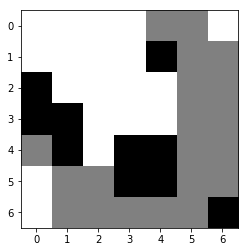

((4, 1), (5, 1)): n_v:  1195 q_all:-0.211178 q:-0.231160 q_m:-0.066667 p:0.172144
((5, 3), (5, 1)): n_v:   463 q_all:-0.181766 q:-0.280035 q_m:-0.100000 p:0.020283
((3, 0), (5, 1)): n_v:   323 q_all:-0.221743 q:-0.225964 q_m:-0.100000 p:0.058300
((1, 4), (3, 5)): n_v:   258 q_all:-0.293583 q:-0.251747 q_m:-0.166667 p:0.110099
((1, 4), (1, 5)): n_v:   222 q_all:-0.244690 q:-0.253239 q_m:-0.133333 p:0.057486
((4, 3), (5, 1)): n_v:   185 q_all:-0.272281 q:-0.272459 q_m:-0.100000 p:0.065374
((1, 4), (0, 4)): n_v:   165 q_all:-0.215953 q:-0.246525 q_m:-0.133333 p:0.026382
((6, 6), (6, 4)): n_v:    92 q_all:-0.395192 q:-0.379562 q_m:-0.300000 p:0.071659
((4, 3), (5, 5)): n_v:    82 q_all:-0.380355 q:-0.325006 q_m:-0.300000 p:0.059701
((4, 4), (3, 5)): n_v:    74 q_all:-0.296237 q:-0.238802 q_m:-0.133333 p:0.032146
((3, 1), (5, 1)): n_v:    56 q_all:-0.280800 q:-0.251839 q_m:-0.100000 p:0.021362
((4, 3), (3, 5)): n_v:    55 q_all:-0.323394 q:-0.269418 q_m:-0.166667 p:0.029428
((4, 4), (5, 5))

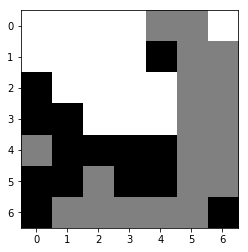

((3, 4), (5, 2)): n_v:  1250 q_all:+0.262367 q:+0.129544 q_m:+0.400000 p:0.078751
((0, 3), (0, 4)): n_v:   636 q_all:+0.192362 q:+0.146551 q_m:+0.166667 p:0.204184
((3, 2), (4, 0)): n_v:   249 q_all:+0.205794 q:+0.141667 q_m:+0.400000 p:0.067591
((3, 3), (5, 2)): n_v:   187 q_all:+0.151645 q:+0.094853 q_m:+0.400000 p:0.087883
((2, 2), (4, 0)): n_v:   116 q_all:+0.172967 q:+0.118368 q_m:+0.400000 p:0.045710
((2, 4), (3, 5)): n_v:   102 q_all:+0.123809 q:+0.074596 q_m:+0.166667 p:0.058379
((2, 1), (4, 0)): n_v:    75 q_all:+0.177645 q:+0.138805 q_m:+0.400000 p:0.027758
((3, 2), (5, 2)): n_v:    65 q_all:+0.136386 q:+0.047177 q_m:+0.400000 p:0.034243
((0, 6), (0, 5)): n_v:    36 q_all:+0.189835 q:+0.140883 q_m:+0.166667 p:0.011883
((3, 4), (4, 6)): n_v:    30 q_all:+0.017835 q:-0.036942 q_m:+0.066667 p:0.029227
((0, 6), (2, 6)): n_v:    24 q_all:+0.042466 q:+0.034359 q_m:+0.066667 p:0.021424
((3, 4), (5, 5)): n_v:    23 q_all:+0.132589 q:+0.165788 q_m:+0.266667 p:0.012023
((0, 6), (1, 6))

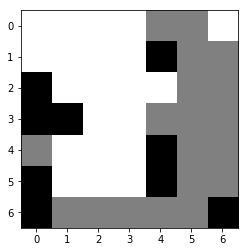

((4, 4), (3, 4)): n_v:  1683 q_all:-0.314177 q:-0.264069 q_m:-0.100000 p:0.527908
((1, 4), (3, 4)): n_v:   405 q_all:-0.312916 q:-0.274866 q_m:-0.133333 p:0.125291
((5, 4), (3, 4)): n_v:   400 q_all:-0.318498 q:-0.268867 q_m:-0.133333 p:0.131836
((6, 0), (4, 0)): n_v:   162 q_all:-0.239134 q:-0.312212 q_m:-0.266667 p:0.005980
((4, 4), (6, 2)): n_v:   126 q_all:-0.392854 q:-0.364028 q_m:-0.200000 p:0.075811
((5, 4), (6, 2)): n_v:    32 q_all:-0.404300 q:-0.348951 q_m:-0.200000 p:0.020758
((3, 0), (4, 0)): n_v:    27 q_all:-0.365083 q:-0.336351 q_m:-0.233333 p:0.013694
((6, 6), (6, 4)): n_v:    25 q_all:-0.439171 q:-0.425611 q_m:-0.333333 p:0.019846
((2, 0), (4, 0)): n_v:    13 q_all:-0.341719 q:-0.372218 q_m:-0.266667 p:0.005715
((1, 4), (0, 4)): n_v:    11 q_all:-0.340954 q:-0.313538 q_m:-0.233333 p:0.004875
((6, 6), (4, 6)): n_v:    10 q_all:-0.481537 q:-0.407432 q_m:-0.400000 p:0.010093
((6, 0), (6, 2)): n_v:     7 q_all:-0.387803 q:-0.351635 q_m:-0.200000 p:0.004195
((5, 4), (6, 4))

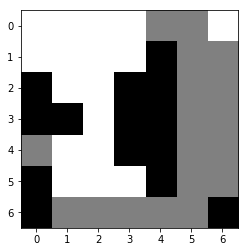

((4, 1), (4, 0)): n_v:  3191 q_all:+0.343697 q:+0.244990 q_m:+0.333333 p:0.257529
((0, 6), (2, 5)): n_v:    43 q_all:+0.189491 q:+0.143978 q_m:+0.300000 p:0.026622
((5, 2), (4, 0)): n_v:    30 q_all:+0.222206 q:+0.223233 q_m:+0.300000 p:0.015168
((5, 1), (6, 1)): n_v:    28 q_all:+0.238037 q:+0.204940 q_m:+0.266667 p:0.012514
((0, 6), (1, 5)): n_v:    10 q_all:+0.203045 q:+0.140955 q_m:+0.266667 p:0.005920
((5, 3), (3, 5)): n_v:     5 q_all:+0.175724 q:+0.146513 q_m:+0.300000 p:0.003843
((0, 3), (1, 5)): n_v:     4 q_all:+0.180990 q:+0.112769 q_m:+0.233333 p:0.002839
((0, 6), (0, 5)): n_v:     3 q_all:+0.125413 q:+0.091028 q_m:+0.200000 p:0.002705
((3, 2), (4, 0)): n_v:     2 q_all:+0.126472 q:+0.141605 q_m:+0.300000 p:0.001737
((2, 2), (4, 0)): n_v:     2 q_all:+0.083464 q:+0.096034 q_m:+0.300000 p:0.002127
((4, 2), (4, 0)): n_v:     2 q_all:+0.146898 q:+0.158530 q_m:+0.300000 p:0.001580
((0, 3), (0, 4)): n_v:     1 q_all:+0.104736 q:+0.104736 q_m:+0.200000 p:0.001765
((1, 3), (3, 5))

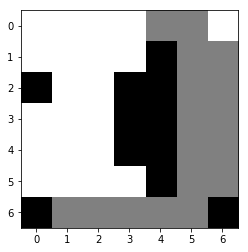

((6, 0), (6, 1)): n_v:  1462 q_all:-0.287675 q:-0.271635 q_m:-0.100000 p:0.016503
((4, 4), (6, 2)): n_v:   696 q_all:-0.427901 q:-0.383378 q_m:-0.133333 p:0.285144
((1, 4), (0, 4)): n_v:   646 q_all:-0.332857 q:-0.314369 q_m:-0.166667 p:0.090404
((5, 4), (6, 4)): n_v:   400 q_all:-0.390316 q:-0.412108 q_m:-0.233333 p:0.121722
((4, 3), (6, 4)): n_v:   217 q_all:-0.461578 q:-0.430998 q_m:-0.266667 p:0.109975
((4, 3), (6, 1)): n_v:   197 q_all:-0.361330 q:-0.309969 q_m:-0.133333 p:0.043490
((6, 6), (6, 4)): n_v:   184 q_all:-0.410283 q:-0.426992 q_m:-0.266667 p:0.066562
((2, 3), (0, 4)): n_v:   134 q_all:-0.444630 q:-0.384634 q_m:-0.200000 p:0.061296
((4, 3), (6, 2)): n_v:    75 q_all:-0.418804 q:-0.400536 q_m:-0.133333 p:0.029096
((6, 0), (6, 2)): n_v:    74 q_all:-0.386966 q:-0.378123 q_m:-0.133333 p:0.021908
((2, 4), (0, 4)): n_v:    63 q_all:-0.398324 q:-0.332127 q_m:-0.200000 p:0.020634
((5, 4), (6, 2)): n_v:    48 q_all:-0.423868 q:-0.377527 q_m:-0.133333 p:0.019514
((4, 3), (6, 5))

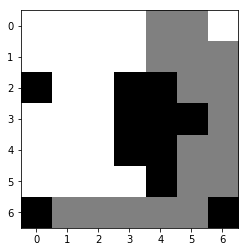

((0, 6), (2, 5)): n_v:  1099 q_all:+0.449955 q:+0.350546 q_m:+0.533333 p:0.810848
((0, 3), (1, 4)): n_v:   460 q_all:+0.593290 q:+0.455787 q_m:+0.500000 p:0.025255
((0, 3), (2, 5)): n_v:   156 q_all:+0.513972 q:+0.346099 q_m:+0.533333 p:0.067884
((5, 0), (6, 1)): n_v:    15 q_all:+0.456895 q:+0.453042 q_m:+0.433333 p:0.010943
((5, 3), (4, 5)): n_v:     9 q_all:+0.499360 q:+0.361996 q_m:+0.600000 p:0.004496
((0, 6), (0, 5)): n_v:     8 q_all:+0.471128 q:+0.289261 q_m:+0.366667 p:0.005391
((0, 6), (1, 4)): n_v:     6 q_all:+0.538818 q:+0.414687 q_m:+0.466667 p:0.001933
((1, 3), (2, 5)): n_v:     3 q_all:+0.398716 q:+0.267818 q_m:+0.533333 p:0.003445
((0, 6), (1, 5)): n_v:     2 q_all:+0.500300 q:+0.320968 q_m:+0.433333 p:0.001379
((5, 2), (6, 3)): n_v:     1 q_all:+0.369616 q:+0.296516 q_m:+0.433333 p:0.001161
((5, 3), (6, 1)): n_v:     1 q_all:+0.429453 q:+0.368292 q_m:+0.400000 p:0.001498
((4, 2), (6, 1)): n_v:     0 q_all:+0.346239 q:+0.292478 q_m:+0.400000 p:0.000104
((4, 0), (6, 2))

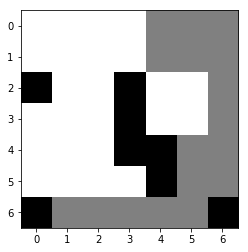

((2, 3), (1, 4)): n_v:   441 q_all:-0.365805 q:-0.368621 q_m:-0.233333 p:0.156288
((3, 3), (1, 4)): n_v:   136 q_all:-0.495226 q:-0.407152 q_m:-0.266667 p:0.154559
((4, 3), (6, 1)): n_v:   129 q_all:-0.487113 q:-0.376345 q_m:-0.333333 p:0.140730
((4, 4), (4, 5)): n_v:   104 q_all:-0.421338 q:-0.427198 q_m:-0.366667 p:0.071607
((2, 3), (4, 5)): n_v:    62 q_all:-0.499019 q:-0.431359 q_m:-0.400000 p:0.072702
((6, 6), (4, 5)): n_v:    39 q_all:-0.451403 q:-0.415611 q_m:-0.400000 p:0.034396
((4, 3), (6, 5)): n_v:    32 q_all:-0.677193 q:-0.450567 q_m:-0.533333 p:0.072159
((3, 3), (4, 5)): n_v:    18 q_all:-0.614614 q:-0.431736 q_m:-0.400000 p:0.034013
((2, 3), (0, 5)): n_v:    17 q_all:-0.544267 q:-0.456084 q_m:-0.533333 p:0.024398
((6, 0), (6, 1)): n_v:    17 q_all:-0.423465 q:-0.366227 q_m:-0.300000 p:0.011810
((4, 4), (6, 5)): n_v:    13 q_all:-0.644934 q:-0.434981 q_m:-0.533333 p:0.026939
((6, 6), (6, 4)): n_v:    11 q_all:-0.576364 q:-0.535748 q_m:-0.466667 p:0.018073
((5, 4), (6, 5))

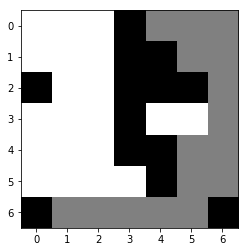

((3, 5), (5, 5)): n_v:   771 q_all:+0.330574 q:+0.333635 q_m:+0.433333 p:0.393652
((3, 4), (5, 5)): n_v:   754 q_all:+0.422802 q:+0.274538 q_m:+0.433333 p:0.088555
((3, 5), (1, 5)): n_v:   257 q_all:+0.348347 q:+0.314808 q_m:+0.433333 p:0.112137
((3, 4), (1, 5)): n_v:   138 q_all:+0.337778 q:+0.245678 q_m:+0.433333 p:0.066546
((5, 3), (5, 5)): n_v:   117 q_all:+0.335341 q:+0.257064 q_m:+0.433333 p:0.057647
((3, 4), (4, 5)): n_v:    50 q_all:+0.334311 q:+0.282586 q_m:+0.400000 p:0.024940
((5, 0), (6, 1)): n_v:    32 q_all:+0.298145 q:+0.354813 q_m:+0.333333 p:0.020867
((5, 3), (6, 4)): n_v:    21 q_all:+0.228411 q:+0.190519 q_m:+0.333333 p:0.019347
((3, 5), (3, 6)): n_v:    15 q_all:+0.237442 q:+0.247484 q_m:+0.333333 p:0.013716
((3, 5), (2, 6)): n_v:    14 q_all:+0.331322 q:+0.248898 q_m:+0.333333 p:0.007233
((5, 1), (6, 2)): n_v:     8 q_all:+0.258330 q:+0.221540 q_m:+0.266667 p:0.006803
((5, 3), (6, 1)): n_v:     5 q_all:+0.334955 q:+0.278618 q_m:+0.300000 p:0.002705
((3, 5), (4, 6))

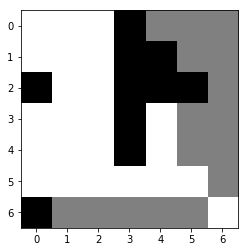

((2, 5), (4, 5)): n_v:   784 q_all:-0.309366 q:-0.340750 q_m:-0.166667 p:0.243692
((4, 3), (6, 1)): n_v:   670 q_all:-0.313927 q:-0.301117 q_m:-0.233333 p:0.220746
((4, 3), (6, 5)): n_v:   295 q_all:-0.346122 q:-0.371779 q_m:-0.233333 p:0.135297
((2, 4), (4, 5)): n_v:   222 q_all:-0.340799 q:-0.327176 q_m:-0.166667 p:0.097123
((2, 3), (4, 5)): n_v:   219 q_all:-0.465100 q:-0.382589 q_m:-0.166667 p:0.203842
((3, 3), (4, 5)): n_v:    54 q_all:-0.427062 q:-0.359582 q_m:-0.166667 p:0.042293
((0, 3), (0, 5)): n_v:    13 q_all:-0.443080 q:-0.539911 q_m:-0.433333 p:0.011704
((2, 3), (0, 5)): n_v:    10 q_all:-0.541757 q:-0.542452 q_m:-0.433333 p:0.013089
((4, 3), (4, 5)): n_v:     8 q_all:-0.380506 q:-0.356550 q_m:-0.166667 p:0.004928
((6, 0), (6, 1)): n_v:     7 q_all:-0.352375 q:-0.294205 q_m:-0.200000 p:0.003594
((4, 3), (3, 5)): n_v:     3 q_all:-0.374625 q:-0.437028 q_m:-0.300000 p:0.002075
((2, 4), (3, 5)): n_v:     3 q_all:-0.405833 q:-0.435773 q_m:-0.266667 p:0.002278
((1, 3), (0, 5))

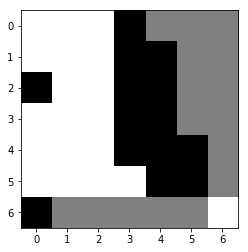

((5, 0), (6, 1)): n_v:   720 q_all:+0.340599 q:+0.298079 q_m:+0.266667 p:0.047422
((5, 3), (6, 4)): n_v:   690 q_all:+0.259887 q:+0.173344 q_m:+0.333333 p:0.266502
((6, 6), (5, 6)): n_v:   539 q_all:+0.311026 q:+0.206532 q_m:+0.333333 p:0.098252
((5, 3), (3, 5)): n_v:   193 q_all:+0.328234 q:+0.302050 q_m:+0.433333 p:0.021940
((5, 1), (6, 2)): n_v:   140 q_all:+0.193703 q:+0.150145 q_m:+0.200000 p:0.091168
((6, 6), (6, 5)): n_v:    61 q_all:+0.296769 q:+0.167831 q_m:+0.333333 p:0.014706
((6, 6), (4, 6)): n_v:    61 q_all:+0.234843 q:+0.159837 q_m:+0.300000 p:0.029998
((0, 2), (0, 4)): n_v:    54 q_all:+0.248781 q:+0.212175 q_m:+0.366667 p:0.023442
((6, 6), (6, 4)): n_v:    41 q_all:+0.248968 q:+0.159632 q_m:+0.300000 p:0.017818
((5, 3), (6, 1)): n_v:    16 q_all:+0.259498 q:+0.212254 q_m:+0.233333 p:0.006403
((5, 2), (6, 3)): n_v:     9 q_all:+0.237069 q:+0.182914 q_m:+0.266667 p:0.004547
((5, 0), (6, 2)): n_v:     9 q_all:+0.124285 q:+0.040608 q_m:+0.166667 p:0.009047
((5, 3), (6, 5))

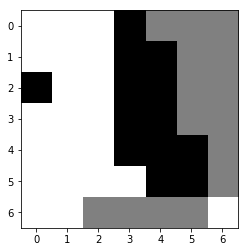

((5, 4), (6, 2)): n_v:  1438 q_all:-0.335454 q:-0.307184 q_m:-0.000000 p:0.390623
((4, 4), (6, 2)): n_v:   549 q_all:-0.368500 q:-0.324310 q_m:-0.000000 p:0.222271
((4, 3), (6, 2)): n_v:   133 q_all:-0.399448 q:-0.333923 q_m:-0.000000 p:0.070652
((5, 4), (6, 4)): n_v:   115 q_all:-0.374276 q:-0.437976 q_m:-0.166667 p:0.049605
((4, 3), (6, 4)): n_v:    57 q_all:-0.490151 q:-0.460317 q_m:-0.200000 p:0.051244
((0, 3), (0, 4)): n_v:    47 q_all:-0.393039 q:-0.385448 q_m:-0.233333 p:0.023682
((5, 4), (6, 3)): n_v:    24 q_all:-0.401879 q:-0.399629 q_m:-0.100000 p:0.013404
((4, 5), (6, 4)): n_v:    21 q_all:-0.397410 q:-0.486347 q_m:-0.200000 p:0.011080
((4, 5), (5, 6)): n_v:    18 q_all:-0.354074 q:-0.338907 q_m:-0.166667 p:0.006256
((3, 4), (5, 6)): n_v:     9 q_all:-0.408316 q:-0.396693 q_m:-0.200000 p:0.005235
((2, 3), (0, 4)): n_v:     9 q_all:-0.514371 q:-0.434778 q_m:-0.266667 p:0.009071
((5, 5), (6, 3)): n_v:     8 q_all:-0.412630 q:-0.405491 q_m:-0.133333 p:0.004839
((4, 4), (6, 4))

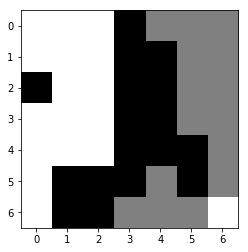

((6, 6), (5, 4)): n_v:  3167 q_all:+0.345564 q:+0.303586 q_m:+0.333333 p:0.986283
((3, 2), (5, 4)): n_v:     4 q_all:+0.102159 q:+0.184600 q_m:+0.333333 p:0.004315
((4, 2), (5, 4)): n_v:     4 q_all:+0.193187 q:+0.152090 q_m:+0.333333 p:0.004136
((6, 6), (5, 6)): n_v:     4 q_all:+0.294393 q:+0.169328 q_m:+0.166667 p:0.002235
((4, 2), (6, 3)): n_v:     0 q_all:+0.088551 q:+0.088551 q_m:+0.200000 p:0.000117
((4, 1), (6, 3)): n_v:     0 q_all:+0.046851 q:+0.046851 q_m:+0.200000 p:0.000718
((6, 6), (6, 4)): n_v:     0 q_all:+0.102749 q:+0.102749 q_m:+0.133333 p:0.000983
((2, 2), (0, 4)): n_v:     0 q_all:+0.118270 q:+0.118270 q_m:+0.200000 p:0.000033
((1, 2), (0, 4)): n_v:     0 q_all:+0.072000 q:+0.072000 q_m:+0.200000 p:0.000040
((0, 2), (0, 4)): n_v:     0 q_all:+0.159371 q:+0.159371 q_m:+0.200000 p:0.000593
((4, 2), (6, 4)): n_v:     0 q_all:+0.029147 q:+0.029147 q_m:+0.133333 p:0.000077
((6, 6), (6, 5)): n_v:     0 q_all:+0.170902 q:+0.170902 q_m:+0.100000 p:0.000377
((6, 6), (4, 6))

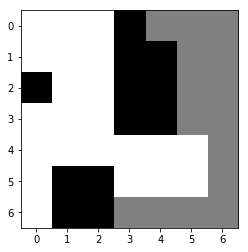

((2, 4), (3, 5)): n_v:  3151 q_all:-0.355698 q:-0.328451 q_m:-0.166667 p:0.324322
((5, 1), (6, 3)): n_v:   265 q_all:-0.322036 q:-0.387085 q_m:-0.200000 p:0.001638
((6, 2), (6, 4)): n_v:   200 q_all:-0.380323 q:-0.442638 q_m:-0.133333 p:0.034459
((3, 4), (5, 6)): n_v:   163 q_all:-0.370457 q:-0.369003 q_m:-0.200000 p:0.023711
((2, 4), (4, 6)): n_v:   141 q_all:-0.391200 q:-0.381951 q_m:-0.200000 p:0.028624
((1, 4), (3, 5)): n_v:   133 q_all:-0.373574 q:-0.366305 q_m:-0.200000 p:0.020206
((3, 4), (4, 6)): n_v:    80 q_all:-0.385185 q:-0.395810 q_m:-0.200000 p:0.015067
((5, 2), (6, 3)): n_v:    68 q_all:-0.398546 q:-0.376621 q_m:-0.166667 p:0.015452
((2, 3), (3, 5)): n_v:    58 q_all:-0.446136 q:-0.389985 q_m:-0.200000 p:0.021009
((0, 3), (0, 4)): n_v:    50 q_all:-0.453934 q:-0.440932 q_m:-0.300000 p:0.019376
((1, 3), (3, 5)): n_v:    50 q_all:-0.432857 q:-0.369580 q_m:-0.200000 p:0.015910
((3, 4), (1, 6)): n_v:    31 q_all:-0.436850 q:-0.434425 q_m:-0.333333 p:0.010630
((5, 2), (6, 4))

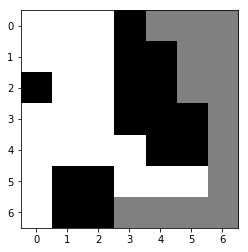

((5, 3), (6, 3)): n_v:  2536 q_all:+0.354095 q:+0.356032 q_m:+0.333333 p:0.331002
((5, 5), (4, 6)): n_v:  1568 q_all:+0.366902 q:+0.267277 q_m:+0.333333 p:0.147747
((5, 3), (6, 4)): n_v:    31 q_all:+0.202630 q:+0.197554 q_m:+0.200000 p:0.017646
((0, 2), (0, 4)): n_v:    21 q_all:+0.261706 q:+0.260651 q_m:+0.366667 p:0.008666
((4, 3), (2, 5)): n_v:    13 q_all:+0.315036 q:+0.257556 q_m:+0.433333 p:0.003020
((5, 5), (6, 6)): n_v:     9 q_all:+0.263460 q:+0.197745 q_m:+0.200000 p:0.003824
((5, 5), (6, 3)): n_v:     6 q_all:+0.298683 q:+0.317230 q_m:+0.300000 p:0.001867
((5, 5), (3, 6)): n_v:     4 q_all:+0.290880 q:+0.277930 q_m:+0.300000 p:0.001437
((5, 5), (5, 6)): n_v:     2 q_all:+0.249290 q:+0.264948 q_m:+0.266667 p:0.001196
((4, 1), (6, 3)): n_v:     0 q_all:+0.111390 q:+0.111390 q_m:+0.300000 p:0.000794
((5, 4), (5, 6)): n_v:     0 q_all:+0.208556 q:+0.208556 q_m:+0.233333 p:0.000005
((4, 3), (6, 3)): n_v:     0 q_all:+0.176796 q:+0.176796 q_m:+0.300000 p:0.000147
((4, 2), (6, 4))

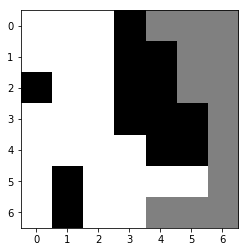

((4, 5), (6, 4)): n_v:  2550 q_all:-0.340717 q:-0.372292 q_m:-0.066667 p:0.375123
((0, 3), (0, 4)): n_v:   376 q_all:-0.470870 q:-0.482617 q_m:-0.300000 p:0.204759
((4, 4), (6, 4)): n_v:   108 q_all:-0.454604 q:-0.417677 q_m:-0.066667 p:0.053452
((2, 4), (0, 4)): n_v:    31 q_all:-0.493106 q:-0.500000 q_m:-0.333333 p:0.019584
((2, 3), (0, 4)): n_v:    25 q_all:-0.533672 q:-0.525901 q_m:-0.333333 p:0.018865
((3, 5), (4, 6)): n_v:    17 q_all:-0.397253 q:-0.443800 q_m:-0.233333 p:0.005752
((4, 5), (5, 6)): n_v:    16 q_all:-0.431855 q:-0.419739 q_m:-0.233333 p:0.006961
((3, 5), (5, 6)): n_v:     7 q_all:-0.495233 q:-0.447396 q_m:-0.266667 p:0.004358
((4, 5), (6, 5)): n_v:     7 q_all:-0.484639 q:-0.420842 q_m:-0.200000 p:0.004581
((4, 5), (6, 6)): n_v:     5 q_all:-0.501598 q:-0.491667 q_m:-0.266667 p:0.003317
((1, 4), (2, 5)): n_v:     4 q_all:-0.435755 q:-0.460455 q_m:-0.300000 p:0.001600
((3, 5), (2, 6)): n_v:     4 q_all:-0.449884 q:-0.458224 q_m:-0.300000 p:0.002088
((4, 4), (6, 6))

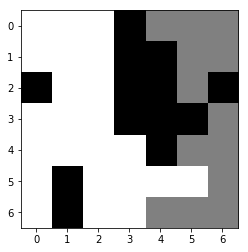

((5, 4), (4, 5)): n_v:  1638 q_all:+0.573337 q:+0.534233 q_m:+0.566667 p:0.400616
((6, 3), (4, 5)): n_v:   113 q_all:+0.533975 q:+0.434958 q_m:+0.533333 p:0.049104
((5, 3), (6, 4)): n_v:     5 q_all:+0.527160 q:+0.426425 q_m:+0.366667 p:0.002121
((4, 3), (2, 5)): n_v:     3 q_all:+0.501974 q:+0.398245 q_m:+0.666667 p:0.001838
((5, 3), (4, 5)): n_v:     1 q_all:+0.336971 q:+0.375101 q_m:+0.533333 p:0.001898
((5, 4), (6, 5)): n_v:     0 q_all:+0.399658 q:+0.399658 q_m:+0.366667 p:0.000290
((5, 5), (6, 6)): n_v:     0 q_all:+0.402355 q:+0.402355 q_m:+0.366667 p:0.000105
((0, 2), (0, 4)): n_v:     0 q_all:+0.481960 q:+0.430587 q_m:+0.533333 p:0.000065
((4, 3), (4, 5)): n_v:     0 q_all:+0.423102 q:+0.312871 q_m:+0.533333 p:0.000409
((5, 3), (6, 5)): n_v:     0 q_all:+0.221976 q:+0.221976 q_m:+0.333333 p:0.000003
((4, 3), (6, 4)): n_v:     0 q_all:+0.250834 q:+0.250834 q_m:+0.333333 p:0.000007
((1, 2), (0, 4)): n_v:     0 q_all:+0.422107 q:+0.310881 q_m:+0.533333 p:0.000002
((4, 3), (6, 5))

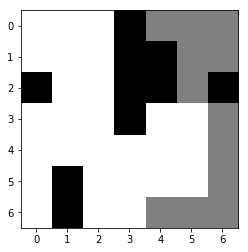

((2, 6), (4, 6)): n_v:  2622 q_all:-0.558442 q:-0.569963 q_m:-0.366667 p:0.580438
((2, 4), (4, 6)): n_v:   315 q_all:-0.603600 q:-0.559948 q_m:-0.366667 p:0.118836
((3, 3), (2, 5)): n_v:   142 q_all:-0.636472 q:-0.623307 q_m:-0.433333 p:0.069780
((0, 3), (2, 5)): n_v:   127 q_all:-0.546410 q:-0.614262 q_m:-0.433333 p:0.023017
((1, 4), (2, 5)): n_v:    91 q_all:-0.627481 q:-0.582551 q_m:-0.400000 p:0.042025
((2, 4), (3, 6)): n_v:    21 q_all:-0.623434 q:-0.609614 q_m:-0.433333 p:0.009350
((1, 4), (3, 6)): n_v:    17 q_all:-0.617499 q:-0.653105 q_m:-0.433333 p:0.007525
((2, 3), (2, 5)): n_v:    16 q_all:-0.757610 q:-0.639239 q_m:-0.433333 p:0.014937
((0, 3), (0, 4)): n_v:    12 q_all:-0.666468 q:-0.729767 q_m:-0.533333 p:0.007654
((1, 3), (2, 5)): n_v:     9 q_all:-0.662890 q:-0.616408 q_m:-0.433333 p:0.005677
((2, 6), (0, 4)): n_v:     6 q_all:-0.659024 q:-0.752702 q_m:-0.566667 p:0.003653
((2, 6), (3, 6)): n_v:     5 q_all:-0.656003 q:-0.656545 q_m:-0.400000 p:0.003134
((2, 3), (0, 4))

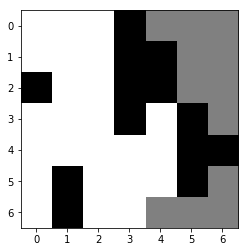

((3, 4), (2, 5)): n_v:  3257 q_all:+0.556737 q:+0.532055 q_m:+0.600000 p:0.398804
((5, 3), (6, 4)): n_v:   689 q_all:+0.524630 q:+0.495606 q_m:+0.466667 p:0.151314
((3, 4), (5, 6)): n_v:   357 q_all:+0.596658 q:+0.518468 q_m:+0.566667 p:0.000484
((4, 4), (3, 6)): n_v:    23 q_all:+0.502262 q:+0.378198 q_m:+0.566667 p:0.006813
((5, 4), (5, 6)): n_v:    19 q_all:+0.513351 q:+0.488251 q_m:+0.566667 p:0.004857
((5, 4), (6, 5)): n_v:    15 q_all:+0.424727 q:+0.439825 q_m:+0.466667 p:0.007797
((5, 4), (3, 6)): n_v:    15 q_all:+0.511056 q:+0.467404 q_m:+0.566667 p:0.004160
((0, 2), (0, 4)): n_v:     3 q_all:+0.484531 q:+0.423656 q_m:+0.566667 p:0.000956
((4, 4), (5, 6)): n_v:     2 q_all:+0.478897 q:+0.415997 q_m:+0.566667 p:0.000805
((3, 4), (3, 6)): n_v:     2 q_all:+0.512992 q:+0.442868 q_m:+0.566667 p:0.000673
((4, 3), (6, 5)): n_v:     0 q_all:+0.337396 q:+0.241460 q_m:+0.433333 p:0.000002
((4, 4), (6, 6)): n_v:     0 q_all:+0.363476 q:+0.293619 q_m:+0.433333 p:0.000009
((4, 4), (2, 6))

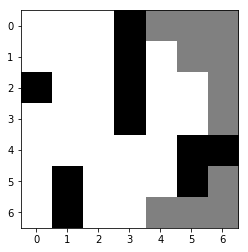

((5, 5), (6, 4)): n_v:  1335 q_all:-0.571537 q:-0.604377 q_m:-0.366667 p:0.345120
((4, 6), (6, 4)): n_v:   967 q_all:-0.538876 q:-0.659070 q_m:-0.400000 p:0.160870
((4, 5), (6, 4)): n_v:   534 q_all:-0.565485 q:-0.660994 q_m:-0.400000 p:0.128797
((0, 3), (1, 5)): n_v:   507 q_all:-0.547287 q:-0.584398 q_m:-0.400000 p:0.096506
((0, 3), (0, 4)): n_v:   378 q_all:-0.598236 q:-0.685032 q_m:-0.500000 p:0.126037
((3, 3), (1, 5)): n_v:    98 q_all:-0.533696 q:-0.606313 q_m:-0.400000 p:0.014850
((2, 3), (1, 5)): n_v:    39 q_all:-0.585764 q:-0.619680 q_m:-0.400000 p:0.011751
((1, 3), (1, 5)): n_v:    23 q_all:-0.569809 q:-0.630440 q_m:-0.400000 p:0.006080
((2, 3), (0, 4)): n_v:    19 q_all:-0.649382 q:-0.680605 q_m:-0.533333 p:0.009373
((4, 6), (2, 6)): n_v:     7 q_all:-0.576565 q:-0.639552 q_m:-0.466667 p:0.002144
((4, 6), (6, 6)): n_v:     5 q_all:-0.655705 q:-0.749378 q_m:-0.600000 p:0.002661
((4, 6), (6, 5)): n_v:     4 q_all:-0.661002 q:-0.753069 q_m:-0.533333 p:0.002059
((4, 5), (2, 6))

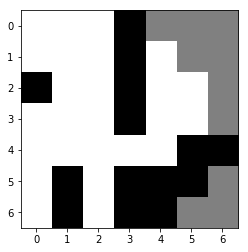

((2, 5), (3, 6)): n_v:  1797 q_all:+0.551136 q:+0.558738 q_m:+0.533333 p:0.176140
((1, 4), (0, 4)): n_v:   642 q_all:+0.488640 q:+0.511969 q_m:+0.533333 p:0.207408
((1, 4), (3, 6)): n_v:   325 q_all:+0.577735 q:+0.486246 q_m:+0.500000 p:0.000737
((1, 4), (0, 5)): n_v:    40 q_all:+0.387128 q:+0.457546 q_m:+0.400000 p:0.028059
((0, 2), (0, 4)): n_v:     9 q_all:+0.385668 q:+0.387319 q_m:+0.500000 p:0.006231
((2, 5), (1, 6)): n_v:     6 q_all:+0.389202 q:+0.450291 q_m:+0.400000 p:0.004414
((4, 4), (3, 6)): n_v:     4 q_all:+0.415933 q:+0.432186 q_m:+0.500000 p:0.001977
((4, 4), (5, 6)): n_v:     1 q_all:+0.442457 q:+0.422885 q_m:+0.566667 p:0.000382
((1, 2), (0, 4)): n_v:     1 q_all:+0.272331 q:+0.283766 q_m:+0.500000 p:0.000975
((3, 5), (5, 6)): n_v:     1 q_all:+0.526557 q:+0.547529 q_m:+0.566667 p:0.000210
((4, 4), (6, 5)): n_v:     1 q_all:+0.498776 q:+0.470487 q_m:+0.566667 p:0.000282
((2, 5), (0, 4)): n_v:     1 q_all:+0.507477 q:+0.500744 q_m:+0.500000 p:0.000411
((2, 5), (2, 6))

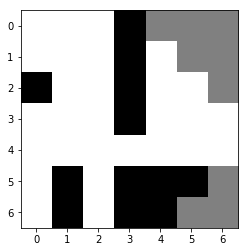

((5, 5), (5, 6)): n_v:  1553 q_all:-0.543194 q:-0.617040 q_m:-0.366667 p:0.318376
((0, 3), (1, 5)): n_v:   549 q_all:-0.599566 q:-0.629576 q_m:-0.333333 p:0.215646
((3, 3), (1, 5)): n_v:   538 q_all:-0.560966 q:-0.616222 q_m:-0.333333 p:0.142015
((6, 4), (5, 6)): n_v:   248 q_all:-0.603016 q:-0.742728 q_m:-0.400000 p:0.100409
((2, 3), (1, 5)): n_v:   236 q_all:-0.620060 q:-0.643121 q_m:-0.333333 p:0.109163
((5, 4), (5, 6)): n_v:    86 q_all:-0.685405 q:-0.794704 q_m:-0.400000 p:0.058738
((1, 3), (1, 5)): n_v:    62 q_all:-0.619188 q:-0.673851 q_m:-0.333333 p:0.028707
((0, 3), (0, 4)): n_v:     7 q_all:-0.615572 q:-0.738978 q_m:-0.433333 p:0.003513
((5, 4), (6, 5)): n_v:     4 q_all:-0.639137 q:-0.824786 q_m:-0.500000 p:0.002401
((2, 3), (0, 4)): n_v:     3 q_all:-0.635076 q:-0.721036 q_m:-0.466667 p:0.001651
((5, 5), (6, 6)): n_v:     2 q_all:-0.601066 q:-0.749448 q_m:-0.500000 p:0.000857
((6, 4), (6, 6)): n_v:     2 q_all:-0.661818 q:-0.819792 q_m:-0.533333 p:0.001791
((0, 3), (0, 5))

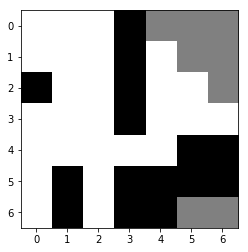

((1, 4), (0, 4)): n_v:  1188 q_all:+0.539768 q:+0.561392 q_m:+0.533333 p:0.290604
((1, 4), (0, 5)): n_v:  1054 q_all:+0.427476 q:+0.570011 q_m:+0.400000 p:0.669014
((4, 4), (6, 5)): n_v:   785 q_all:+0.607899 q:+0.605616 q_m:+0.633333 p:0.006057
((4, 3), (6, 5)): n_v:   112 q_all:+0.596610 q:+0.624762 q_m:+0.633333 p:0.005251
((0, 2), (0, 4)): n_v:     6 q_all:+0.371833 q:+0.367548 q_m:+0.500000 p:0.004875
((2, 4), (0, 4)): n_v:     5 q_all:+0.568010 q:+0.479489 q_m:+0.500000 p:0.000770
((2, 5), (0, 5)): n_v:     4 q_all:+0.427486 q:+0.436316 q_m:+0.366667 p:0.002545
((2, 5), (2, 6)): n_v:     3 q_all:+0.427886 q:+0.583060 q_m:+0.400000 p:0.002291
((2, 4), (0, 5)): n_v:     3 q_all:+0.387265 q:+0.335649 q_m:+0.366667 p:0.002948
((2, 5), (0, 4)): n_v:     2 q_all:+0.499028 q:+0.551603 q_m:+0.500000 p:0.001105
((1, 4), (1, 5)): n_v:     1 q_all:+0.473737 q:+0.441121 q_m:+0.400000 p:0.000834
((2, 5), (1, 6)): n_v:     1 q_all:+0.407618 q:+0.523602 q_m:+0.400000 p:0.001102
((2, 4), (0, 6))

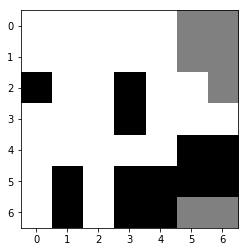

((3, 3), (1, 5)): n_v:  1813 q_all:-0.564333 q:-0.580851 q_m:-0.266667 p:0.464625
((2, 3), (1, 5)): n_v:   916 q_all:-0.632813 q:-0.590247 q_m:-0.266667 p:0.466022
((4, 6), (2, 6)): n_v:    35 q_all:-0.655504 q:-0.632709 q_m:-0.333333 p:0.020707
((5, 4), (6, 5)): n_v:     9 q_all:-0.629358 q:-0.766255 q_m:-0.500000 p:0.004558
((2, 3), (0, 5)): n_v:     8 q_all:-0.603769 q:-0.646993 q_m:-0.400000 p:0.003362
((5, 5), (6, 6)): n_v:     8 q_all:-0.554690 q:-0.714143 q_m:-0.500000 p:0.001959
((6, 4), (6, 6)): n_v:     5 q_all:-0.639194 q:-0.741283 q_m:-0.533333 p:0.003094
((4, 5), (6, 6)): n_v:     4 q_all:-0.664944 q:-0.690175 q_m:-0.533333 p:0.002481
((4, 5), (2, 6)): n_v:     3 q_all:-0.751359 q:-0.756747 q_m:-0.333333 p:0.002973
((4, 6), (6, 5)): n_v:     2 q_all:-0.714200 q:-0.780480 q_m:-0.533333 p:0.002395
((6, 3), (6, 5)): n_v:     1 q_all:-0.744766 q:-0.805441 q_m:-0.533333 p:0.001792
((4, 6), (6, 6)): n_v:     1 q_all:-0.660433 q:-0.779729 q_m:-0.533333 p:0.000600
((4, 5), (6, 5))

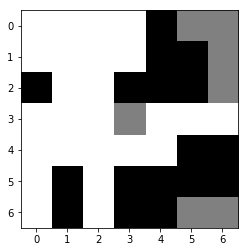

((2, 2), (3, 3)): n_v:  1673 q_all:+0.570113 q:+0.528727 q_m:+0.433333 p:0.114548
((4, 3), (6, 5)): n_v:  1647 q_all:+0.608103 q:+0.425833 q_m:+0.533333 p:0.045772
((0, 3), (0, 5)): n_v:    14 q_all:+0.334981 q:+0.207297 q_m:+0.466667 p:0.013885
((3, 4), (1, 6)): n_v:     3 q_all:+0.454506 q:+0.110518 q_m:+0.400000 p:0.001894
((4, 4), (6, 5)): n_v:     2 q_all:+0.491037 q:+0.448741 q_m:+0.533333 p:0.000945
((1, 3), (0, 5)): n_v:     2 q_all:+0.303737 q:+0.149325 q_m:+0.466667 p:0.002582
((3, 5), (2, 6)): n_v:     2 q_all:+0.325429 q:+0.340833 q_m:+0.433333 p:0.001628
((4, 1), (3, 3)): n_v:     1 q_all:+0.147377 q:+0.146724 q_m:+0.400000 p:0.001616
((3, 6), (1, 6)): n_v:     1 q_all:+0.197641 q:+0.137316 q_m:+0.400000 p:0.001329
((3, 5), (3, 3)): n_v:     1 q_all:+0.337434 q:+0.383495 q_m:+0.400000 p:0.001032
((5, 2), (3, 3)): n_v:     1 q_all:+0.232133 q:+0.239957 q_m:+0.400000 p:0.001182
((3, 5), (1, 6)): n_v:     1 q_all:+0.416744 q:+0.204723 q_m:+0.400000 p:0.001144
((1, 1), (3, 3))

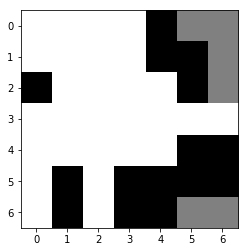

((1, 5), (2, 6)): n_v:  1757 q_all:-0.580512 q:-0.597885 q_m:-0.266667 p:0.315744
((1, 4), (2, 6)): n_v:   761 q_all:-0.591304 q:-0.536685 q_m:-0.300000 p:0.164247
((4, 6), (2, 6)): n_v:   287 q_all:-0.650296 q:-0.703194 q_m:-0.300000 p:0.119840
((0, 4), (2, 6)): n_v:   201 q_all:-0.617608 q:-0.644206 q_m:-0.300000 p:0.061797
((4, 5), (2, 6)): n_v:    50 q_all:-0.779105 q:-0.816414 q_m:-0.300000 p:0.043239
((6, 4), (6, 6)): n_v:    34 q_all:-0.597360 q:-0.772482 q_m:-0.433333 p:0.007938
((1, 5), (1, 6)): n_v:    15 q_all:-0.613250 q:-0.736849 q_m:-0.400000 p:0.004261
((4, 5), (6, 6)): n_v:    14 q_all:-0.630078 q:-0.739737 q_m:-0.433333 p:0.004708
((5, 5), (6, 6)): n_v:    13 q_all:-0.560226 q:-0.725191 q_m:-0.400000 p:0.001469
((1, 4), (1, 6)): n_v:    12 q_all:-0.629670 q:-0.714382 q_m:-0.433333 p:0.004263
((0, 4), (0, 6)): n_v:     6 q_all:-0.617018 q:-0.732915 q_m:-0.433333 p:0.001677
((6, 3), (6, 5)): n_v:     6 q_all:-0.641705 q:-0.799879 q_m:-0.433333 p:0.002528
((0, 4), (1, 6))

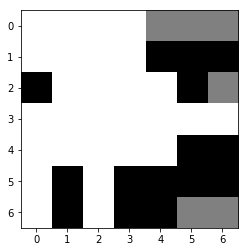

((3, 5), (2, 6)): n_v:  1216 q_all:+0.818126 q:+0.873073 q_m:+0.666667 p:0.339448
((0, 3), (0, 5)): n_v:   514 q_all:+0.714318 q:+0.674942 q_m:+0.633333 p:0.398093
((2, 4), (0, 5)): n_v:    10 q_all:+0.680722 q:+0.515099 q_m:+0.633333 p:0.009731
((4, 4), (6, 5)): n_v:     9 q_all:+0.717803 q:+0.697974 q_m:+0.700000 p:0.006891
((4, 3), (6, 5)): n_v:     4 q_all:+0.637289 q:+0.702976 q_m:+0.700000 p:0.004765
((0, 3), (0, 4)): n_v:     3 q_all:+0.738782 q:+0.755606 q_m:+0.600000 p:0.002238
((1, 3), (0, 5)): n_v:     3 q_all:+0.484132 q:+0.558187 q_m:+0.633333 p:0.006242
((2, 3), (0, 5)): n_v:     2 q_all:+0.582485 q:+0.442185 q_m:+0.633333 p:0.002996
((3, 4), (2, 6)): n_v:     1 q_all:+0.580276 q:+0.624804 q_m:+0.633333 p:0.001421
((4, 4), (2, 6)): n_v:     1 q_all:+0.632897 q:+0.728353 q_m:+0.633333 p:0.001753
((2, 4), (0, 6)): n_v:     0 q_all:+0.594946 q:+0.623226 q_m:+0.566667 p:0.000096
((2, 3), (0, 4)): n_v:     0 q_all:+0.554599 q:+0.542532 q_m:+0.566667 p:0.000035
((4, 4), (6, 6))

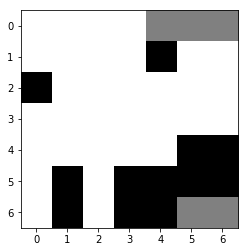

((1, 4), (0, 6)): n_v:  1094 q_all:-0.729201 q:-0.813607 q_m:-0.533333 p:0.125341
((1, 4), (0, 4)): n_v:   848 q_all:-0.797702 q:-0.840583 q_m:-0.433333 p:0.309778
((6, 4), (6, 6)): n_v:   560 q_all:-0.833148 q:-0.834508 q_m:-0.666667 p:0.277667
((4, 6), (6, 6)): n_v:   205 q_all:-0.807858 q:-0.880397 q_m:-0.666667 p:0.082461
((5, 4), (6, 6)): n_v:   152 q_all:-0.881696 q:-0.889495 q_m:-0.666667 p:0.102943
((4, 5), (6, 6)): n_v:    35 q_all:-0.876367 q:-0.869557 q_m:-0.666667 p:0.023042
((6, 3), (6, 5)): n_v:    28 q_all:-0.867298 q:-0.913806 q_m:-0.666667 p:0.017514
((5, 5), (6, 6)): n_v:    25 q_all:-0.826794 q:-0.827841 q_m:-0.633333 p:0.012047
((5, 4), (6, 5)): n_v:    12 q_all:-0.795079 q:-0.897996 q_m:-0.633333 p:0.004533
((1, 4), (0, 5)): n_v:     9 q_all:-0.809740 q:-0.813563 q_m:-0.500000 p:0.004035
((5, 3), (6, 5)): n_v:     5 q_all:-0.880449 q:-0.898721 q_m:-0.666667 p:0.003905
((4, 6), (6, 5)): n_v:     2 q_all:-0.844189 q:-0.900356 q_m:-0.666667 p:0.001249
((4, 5), (6, 5))

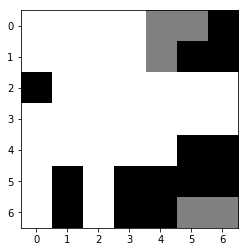

((0, 3), (0, 5)): n_v:  2032 q_all:+0.933987 q:+0.848310 q_m:+0.733333 p:0.212079
((2, 6), (0, 5)): n_v:   605 q_all:+0.681899 q:+0.747820 q_m:+0.733333 p:0.635059
((2, 4), (0, 5)): n_v:    96 q_all:+0.789876 q:+0.744309 q_m:+0.733333 p:0.052466
((4, 3), (6, 5)): n_v:    34 q_all:+0.763210 q:+0.735185 q_m:+0.800000 p:0.024402
((4, 4), (6, 5)): n_v:    27 q_all:+0.730241 q:+0.752487 q_m:+0.800000 p:0.023814
((1, 3), (0, 5)): n_v:    23 q_all:+0.784437 q:+0.790600 q_m:+0.733333 p:0.013450
((2, 3), (0, 5)): n_v:    21 q_all:+0.730851 q:+0.748217 q_m:+0.733333 p:0.018419
((2, 5), (0, 5)): n_v:    16 q_all:+0.691717 q:+0.758954 q_m:+0.733333 p:0.016512
((4, 4), (6, 6)): n_v:     0 q_all:+0.658756 q:+0.650846 q_m:+0.666667 p:0.000002
((2, 3), (0, 4)): n_v:     0 q_all:+0.606214 q:+0.612428 q_m:+0.600000 p:0.000005
((0, 3), (1, 4)): n_v:     0 q_all:+0.750500 q:+0.867666 q_m:+0.633333 p:0.000486
((3, 6), (1, 4)): n_v:     0 q_all:+0.676045 q:+0.752089 q_m:+0.600000 p:0.000190
((3, 3), (1, 4))

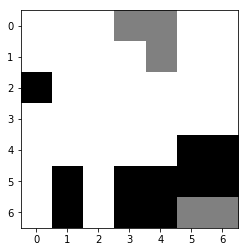

((6, 4), (6, 6)): n_v:  2236 q_all:-0.832898 q:-0.843650 q_m:-0.733333 p:0.488702
((4, 6), (6, 6)): n_v:   638 q_all:-0.872437 q:-0.882270 q_m:-0.733333 p:0.129484
((4, 5), (6, 6)): n_v:   426 q_all:-0.897754 q:-0.905584 q_m:-0.733333 p:0.131586
((5, 3), (6, 5)): n_v:   127 q_all:-0.936950 q:-0.883731 q_m:-0.733333 p:0.058806
((6, 3), (6, 5)): n_v:    77 q_all:-0.920694 q:-0.908874 q_m:-0.733333 p:0.029913
((5, 4), (6, 5)): n_v:    76 q_all:-0.853294 q:-0.892637 q_m:-0.700000 p:0.006929
((5, 4), (6, 6)): n_v:    60 q_all:-0.951812 q:-0.869599 q_m:-0.733333 p:0.031677
((5, 5), (6, 6)): n_v:    49 q_all:-0.950526 q:-0.850234 q_m:-0.700000 p:0.025645
((4, 6), (6, 5)): n_v:    22 q_all:-0.933421 q:-0.884340 q_m:-0.733333 p:0.009819
((4, 5), (6, 5)): n_v:    12 q_all:-0.963973 q:-0.954436 q_m:-0.733333 p:0.007388
1 's turn
one move takes time(s):  0.1946582794189453
train_mode is both train
no. of data collected:  8


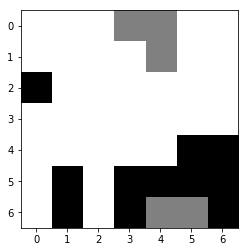

((0, 5), (0, 4)): n_v:  1955 q_all:+0.965839 q:+0.822351 q_m:+0.766667 p:0.055635
((4, 4), (6, 5)): n_v:   569 q_all:+0.848010 q:+0.844025 q_m:+1.000000 p:0.123256
((4, 3), (6, 5)): n_v:   564 q_all:+0.841793 q:+0.851781 q_m:+1.000000 p:0.137292
((6, 2), (6, 4)): n_v:   260 q_all:+0.866016 q:+0.931823 q_m:+1.000000 p:0.036814
((0, 5), (1, 4)): n_v:   100 q_all:+0.839640 q:+0.921740 q_m:+0.766667 p:0.025343
((4, 2), (6, 4)): n_v:    72 q_all:+0.843136 q:+0.872650 q_m:+1.000000 p:0.016882
((4, 3), (6, 4)): n_v:    70 q_all:+0.835263 q:+0.841975 q_m:+1.000000 p:0.018700
((5, 2), (6, 4)): n_v:    30 q_all:+0.854902 q:+0.874238 q_m:+1.000000 p:0.005396
((0, 6), (1, 4)): n_v:    27 q_all:+0.812610 q:+0.885708 q_m:+0.733333 p:0.010091
((2, 6), (0, 4)): n_v:    24 q_all:+0.648021 q:+0.717358 q_m:+0.733333 p:0.025804
((1, 6), (0, 4)): n_v:    17 q_all:+0.790237 q:+0.759807 q_m:+0.733333 p:0.008171
((4, 4), (6, 4)): n_v:    17 q_all:+0.839907 q:+0.841950 q_m:+1.000000 p:0.004519
((0, 6), (0, 4))

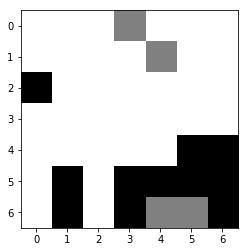

((6, 6), (6, 4)): n_v:  2868 q_all:-0.855064 q:-0.902985 q_m:-0.766667 p:0.491856
((5, 3), (6, 5)): n_v:   300 q_all:-0.956743 q:-0.933017 q_m:-0.766667 p:0.119436
((5, 6), (6, 4)): n_v:   175 q_all:-0.965009 q:-0.891612 q_m:-0.766667 p:0.076275
((4, 6), (6, 4)): n_v:    86 q_all:-0.983244 q:-0.939013 q_m:-0.766667 p:0.044700
((5, 3), (6, 4)): n_v:    63 q_all:-0.977424 q:-0.933195 q_m:-0.733333 p:0.031089
((4, 6), (6, 5)): n_v:    55 q_all:-0.985021 q:-0.953725 q_m:-0.766667 p:0.028962
((6, 3), (6, 5)): n_v:    54 q_all:-0.984629 q:-0.951537 q_m:-0.766667 p:0.028274
((4, 5), (6, 4)): n_v:    33 q_all:-0.984242 q:-0.965448 q_m:-0.766667 p:0.017566
((5, 4), (6, 5)): n_v:    28 q_all:-0.983060 q:-0.939155 q_m:-0.733333 p:0.014579
((4, 5), (6, 5)): n_v:    22 q_all:-0.983858 q:-0.985830 q_m:-0.766667 p:0.011883
1 's turn


This is a random move


one move takes time(s):  0.17145061492919922
train_mode is both train
no. of data collected:  8


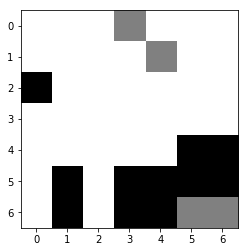

((0, 4), (1, 4)): n_v:  1977 q_all:+0.971178 q:+0.937979 q_m:+0.800000 p:0.071214
((4, 4), (6, 5)): n_v:  1587 q_all:+0.869250 q:+0.860726 q_m:+1.000000 p:0.109083
((4, 3), (6, 5)): n_v:   682 q_all:+0.861867 q:+0.889794 q_m:+1.000000 p:0.065263
((0, 6), (1, 4)): n_v:   119 q_all:+0.857406 q:+0.903788 q_m:+0.766667 p:0.013531
((0, 2), (0, 3)): n_v:    38 q_all:+0.800000 q:+0.844492 q_m:+0.800000 p:0.012602
((3, 6), (1, 4)): n_v:    26 q_all:+0.764351 q:+0.878185 q_m:+0.766667 p:0.011950
((0, 2), (1, 4)): n_v:    22 q_all:+0.741528 q:+0.897698 q_m:+0.766667 p:0.012124
((2, 6), (1, 4)): n_v:    15 q_all:+0.713763 q:+0.829374 q_m:+0.766667 p:0.009592
((1, 6), (1, 4)): n_v:    14 q_all:+0.829777 q:+0.877443 q_m:+0.766667 p:0.003037
((3, 5), (1, 4)): n_v:     9 q_all:+0.845090 q:+0.894516 q_m:+0.766667 p:0.001430
((2, 2), (1, 4)): n_v:     8 q_all:+0.759174 q:+0.855734 q_m:+0.766667 p:0.003896
((0, 1), (0, 3)): n_v:     7 q_all:+0.669040 q:+0.762287 q_m:+0.766667 p:0.006181
((2, 4), (0, 3))

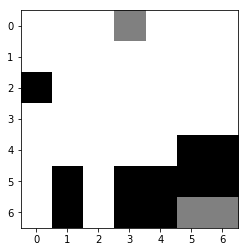

((6, 4), (6, 6)): n_v:  2355 q_all:-0.868299 q:-0.930835 q_m:-0.800000 p:0.226632
((4, 5), (6, 6)): n_v:   590 q_all:-0.980372 q:-0.972742 q_m:-0.800000 p:0.243881
((4, 6), (6, 6)): n_v:   435 q_all:-0.979893 q:-0.942077 q_m:-0.800000 p:0.178887
((5, 5), (6, 6)): n_v:   117 q_all:-0.974246 q:-0.937020 q_m:-0.766667 p:0.045001
((6, 3), (6, 5)): n_v:    47 q_all:-0.948611 q:-0.948176 q_m:-0.800000 p:0.012912
((5, 4), (6, 5)): n_v:    46 q_all:-0.905759 q:-0.948067 q_m:-0.766667 p:0.003594
((4, 6), (6, 5)): n_v:    28 q_all:-0.979310 q:-0.923130 q_m:-0.800000 p:0.011591
((5, 3), (6, 5)): n_v:    27 q_all:-0.978571 q:-0.935036 q_m:-0.800000 p:0.011106
((4, 5), (6, 5)): n_v:    22 q_all:-0.973913 q:-0.985435 q_m:-0.800000 p:0.008701
((5, 4), (6, 6)): n_v:    19 q_all:-0.980000 q:-0.923419 q_m:-0.800000 p:0.007860
1 's turn


This is a random move


one move takes time(s):  0.18721795082092285
train_mode is both train
no. of data collected:  8


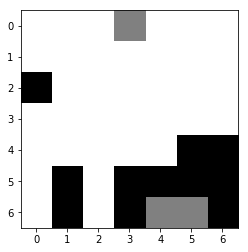

((6, 2), (6, 4)): n_v:  2320 q_all:+0.935416 q:+0.971681 q_m:+1.000000 p:0.399689
((0, 2), (0, 3)): n_v:   811 q_all:+0.985427 q:+0.972676 q_m:+0.833333 p:0.036907
((4, 3), (6, 5)): n_v:   273 q_all:+0.841828 q:+0.946401 q_m:+1.000000 p:0.134960
((4, 4), (6, 5)): n_v:   262 q_all:+0.865427 q:+0.931157 q_m:+1.000000 p:0.104017
((4, 3), (6, 4)): n_v:    98 q_all:+0.826464 q:+0.939919 q_m:+1.000000 p:0.053414
((5, 2), (6, 4)): n_v:    85 q_all:+0.890136 q:+0.943911 q_m:+1.000000 p:0.025219
((4, 2), (6, 4)): n_v:    82 q_all:+0.854494 q:+0.953241 q_m:+1.000000 p:0.036411
((0, 1), (0, 3)): n_v:    39 q_all:+0.738909 q:+0.950679 q_m:+0.800000 p:0.031979
((4, 4), (6, 4)): n_v:    38 q_all:+0.841535 q:+0.926965 q_m:+1.000000 p:0.018730
((0, 5), (0, 3)): n_v:    30 q_all:+0.872467 q:+0.942837 q_m:+0.800000 p:0.011865
((1, 1), (0, 3)): n_v:     8 q_all:+0.802535 q:+0.850390 q_m:+0.800000 p:0.005336
((2, 4), (0, 3)): n_v:     7 q_all:+0.787461 q:+0.898259 q_m:+0.800000 p:0.004579
((2, 2), (0, 3))

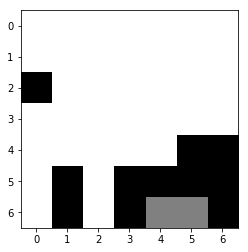

((6, 6), (6, 4)): n_v:  1469 q_all:-0.872102 q:-0.904780 q_m:-0.833333 p:0.448549
((5, 6), (6, 4)): n_v:   313 q_all:-0.906097 q:-0.893248 q_m:-0.833333 p:0.137775
((6, 3), (6, 5)): n_v:   286 q_all:-0.878431 q:-0.959221 q_m:-0.833333 p:0.094613
((5, 3), (6, 5)): n_v:   280 q_all:-0.843820 q:-0.942048 q_m:-0.833333 p:0.053631
((5, 3), (6, 4)): n_v:    75 q_all:-0.921954 q:-0.935595 q_m:-0.800000 p:0.037553
((4, 6), (6, 4)): n_v:    61 q_all:-0.967204 q:-0.940954 q_m:-0.833333 p:0.042074
((4, 5), (6, 4)): n_v:    35 q_all:-0.969444 q:-0.974328 q_m:-0.833333 p:0.024541
((4, 6), (6, 5)): n_v:    14 q_all:-0.984444 q:-0.953699 q_m:-0.833333 p:0.010742
((4, 5), (6, 5)): n_v:    13 q_all:-0.988095 q:-0.988390 q_m:-0.833333 p:0.010159
((5, 4), (6, 5)): n_v:    13 q_all:-0.985714 q:-0.947591 q_m:-0.800000 p:0.009981
1 's turn
one move takes time(s):  0.09918498992919922
train_mode is both train
no. of data collected:  8


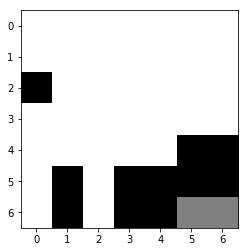

((4, 4), (6, 5)): n_v:  2248 q_all:+0.892347 q:+0.977683 q_m:+1.000000 p:0.622418
((4, 3), (6, 5)): n_v:   919 q_all:+0.862006 q:+0.986501 q_m:+1.000000 p:0.352670
((4, 4), (6, 6)): n_v:    30 q_all:+0.866475 q:+0.971940 q_m:+0.966667 p:0.011331
-1 's turn
one move takes time(s):  0.13924145698547363
train_mode is both train
no. of data collected:  8


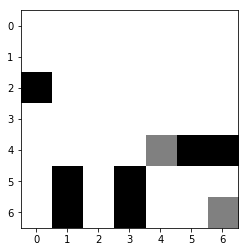

((6, 3), (4, 4)): n_v:  2107 q_all:-0.857534 q:-0.966189 q_m:-0.700000 p:0.407825
((4, 6), (4, 4)): n_v:   744 q_all:-0.878858 q:-0.982102 q_m:-0.700000 p:0.194313
((4, 6), (6, 6)): n_v:   370 q_all:-0.881559 q:-0.992222 q_m:-0.900000 p:0.099544
((4, 5), (6, 6)): n_v:   339 q_all:-0.880242 q:-0.997360 q_m:-0.900000 p:0.089598
((4, 5), (4, 4)): n_v:   207 q_all:-0.931452 q:-0.989770 q_m:-0.666667 p:0.088652
1 's turn


This is a random move


one move takes time(s):  0.05899810791015625
train_mode is both train
no. of data collected:  8


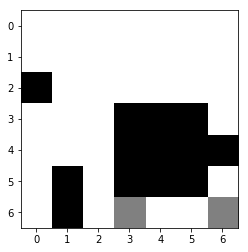

((5, 2), (6, 3)): n_v:  3469 q_all:+0.932687 q:+0.992430 q_m:+0.866667 p:0.337814
((5, 6), (6, 6)): n_v:    28 q_all:+0.822251 q:+0.995380 q_m:+0.800000 p:0.010730
((4, 2), (6, 3)): n_v:     0 q_all:+0.833333 q:+0.956457 q_m:+0.833333 p:0.000063
((6, 5), (6, 3)): n_v:     0 q_all:+0.833333 q:+0.982562 q_m:+0.833333 p:0.000295
((4, 1), (6, 3)): n_v:     0 q_all:+0.833333 q:+0.963227 q_m:+0.833333 p:0.000036
((6, 4), (6, 6)): n_v:     0 q_all:+0.873411 q:+0.980154 q_m:+0.766667 p:0.000002
-1 's turn
one move takes time(s):  0.05713987350463867
train_mode is both train
no. of data collected:  8


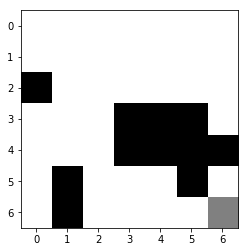

((4, 6), (6, 6)): n_v:  2506 q_all:-0.971344 q:-0.987105 q_m:-0.733333 p:0.567522
((4, 4), (6, 6)): n_v:  1740 q_all:-0.970429 q:-0.978813 q_m:-0.733333 p:0.389715
((4, 5), (6, 6)): n_v:    96 q_all:-0.972004 q:-0.995105 q_m:-0.733333 p:0.022147
((5, 5), (6, 6)): n_v:    66 q_all:-1.000000 q:+5.000000 q_m:-0.700000 p:0.020413
1 's turn
one move takes time(s):  0.037419795989990234
train_mode is both train
no. of data collected:  8


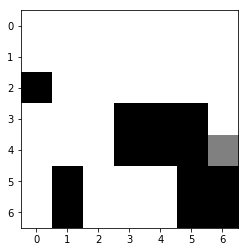

((3, 6), (4, 6)): n_v:  3720 q_all:+1.000000 q:+5.000000 q_m:+1.000000 p:0.984934
((2, 6), (4, 6)): n_v:    31 q_all:+0.973846 q:+0.996574 q_m:+1.000000 p:0.010886
((6, 4), (4, 6)): n_v:    10 q_all:+0.975140 q:+0.994459 q_m:+1.000000 p:0.003641
((2, 5), (4, 6)): n_v:     0 q_all:+1.000000 q:+0.995590 q_m:+1.000000 p:0.000151
((5, 4), (4, 6)): n_v:     0 q_all:+1.000000 q:+0.990257 q_m:+1.000000 p:0.000166
((2, 4), (4, 6)): n_v:     0 q_all:+1.000000 q:+0.980539 q_m:+1.000000 p:0.000214
this self play has 74 steps, time elapsed 131.92821621894836
winner is 1.0
episode 16 finished
episode 17 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3772921562194824
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5354278087615967
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.0521223545074463
train_mode is both train
no. of data 

due to rollout lim, final rollout times:  1601 time elapsed:  2.5807809829711914
one move takes time(s):  2.5820884704589844
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.716282606124878
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7906255722045898
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7144131660461426
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.987398624420166
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.640392541885376
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.7134296894073486
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5909299850463867
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0

due to rollout lim, final rollout times:  1601 time elapsed:  2.099567413330078
one move takes time(s):  2.1019272804260254
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.132479667663574
one move takes time(s):  2.1346850395202637
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6982908248901367
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5096819400787354
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3469691276550293
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.502878189086914
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.3300635814666748
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7176682949066162
train_mode is both train
no. of d

one move takes time(s):  1.8139853477478027
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8883540630340576
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.0202910900115967
one move takes time(s):  3.0214526653289795
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1607 time elapsed:  2.0036938190460205
one move takes time(s):  2.0051002502441406
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2312965393066406
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0004277229309082
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1122970581054688
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3266725540161133
train_mode is both train
no. of data collected:  8
1 's

one move takes time(s):  1.2108154296875
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0439529418945312
one move takes time(s):  2.0454697608947754
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.669872760772705
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.462460994720459
one move takes time(s):  2.4641194343566895
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6229350566864014
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8739755153656006
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.8921184539794922
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8069167137145996
train_mode is both train
no. of data collected:  8
1 's turn

9000/9000 [==============================] - 1s 97us/step - loss: 1.8286 - activation_29_loss: 1.7947 - dense_15_loss: 0.0092 - val_loss: 1.7936 - val_activation_29_loss: 1.7557 - val_dense_15_loss: 0.0131
Epoch 4/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8255 - activation_29_loss: 1.7917 - dense_15_loss: 0.0091 - val_loss: 1.7934 - val_activation_29_loss: 1.7556 - val_dense_15_loss: 0.0130
Epoch 5/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8234 - activation_29_loss: 1.7897 - dense_15_loss: 0.0089 - val_loss: 1.7960 - val_activation_29_loss: 1.7582 - val_dense_15_loss: 0.0130
Epoch 6/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8201 - activation_29_loss: 1.7866 - dense_15_loss: 0.0088 - val_loss: 1.7948 - val_activation_29_loss: 1.7571 - val_dense_15_loss: 0.0129
Epoch 7/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8167 - activation_29_loss: 1.7833 - dense_15_loss: 0.0086 - 

9000/9000 [==============================] - 1s 93us/step - loss: 1.7730 - activation_29_loss: 1.7412 - dense_15_loss: 0.0070 - val_loss: 1.7936 - val_activation_29_loss: 1.7584 - val_dense_15_loss: 0.0105
Epoch 41/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.7729 - activation_29_loss: 1.7410 - dense_15_loss: 0.0072 - val_loss: 1.7936 - val_activation_29_loss: 1.7584 - val_dense_15_loss: 0.0104
Epoch 42/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.7716 - activation_29_loss: 1.7397 - dense_15_loss: 0.0071 - val_loss: 1.7937 - val_activation_29_loss: 1.7585 - val_dense_15_loss: 0.0104
Epoch 43/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.7712 - activation_29_loss: 1.7394 - dense_15_loss: 0.0070 - val_loss: 1.7936 - val_activation_29_loss: 1.7584 - val_dense_15_loss: 0.0104
Epoch 44/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.7699 - activation_29_loss: 1.7379 - dense_15_loss: 0.007



This is a random move


one move takes time(s):  1.8267393112182617
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6470367908477783


This is a random move


one move takes time(s):  2.648097038269043
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7815461158752441
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.531986951828003
one move takes time(s):  2.534860134124756
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.310452938079834
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6216297149658203
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.7657384872436523
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final



This is a random move


one move takes time(s):  0.11641573905944824
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.14705872535705566
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.0688018798828125
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.04871940612792969
train_mode is both train
no. of data collected:  8
this self play has 75 steps, time elapsed 91.66687154769897
winner is -1.0
episode 21 finished
episode 22 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.38751697540283203
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5427300930023193
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7653515338897705
train_mode is both train
no. of data collected:  8
1 's turn


due to rollout lim, final rollout times:  1601 time elapsed:  3.7005834579467773
one move takes time(s):  3.702284336090088
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.8956215381622314


This is a random move


one move takes time(s):  2.8972327709198
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.2165467739105225
one move takes time(s):  5.217700242996216
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.22739839553833
one move takes time(s):  3.2285149097442627
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.896728754043579
one move takes time(s):  3.8982322216033936
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):

one move takes time(s):  1.5549688339233398
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.286743402481079


This is a random move


one move takes time(s):  2.2880730628967285
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.521855354309082
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1532466411590576
one move takes time(s):  2.154414176940918
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5291783809661865


This is a random move


one move takes time(s):  2.530506134033203
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3969826698303223
one move takes time(s):  2.398191213607788
train_mode is both train
no. of data collected:  8
1 's t



This is a random move


one move takes time(s):  0.38794708251953125
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.42110610008239746
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7517881393432617
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.3465158939361572
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2382619380950928
one move takes time(s):  2.2391984462738037
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.93985915184021
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.314821481704712


This is a random move


one move takes time(s):  3.3156850337982178
train_mode is both train
no. of 

one move takes time(s):  0.7157840728759766
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8259141445159912
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7792115211486816
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8305795192718506
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5864465236663818
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.634432315826416
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.687333345413208
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.49475812911987305
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4485659599304199
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4474368095397949
train_mo

one move takes time(s):  1.782120704650879
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9701328277587891
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0008435249328613
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6578192710876465
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.301335096359253
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7359895706176758
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0723857879638672
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4665355682373047
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.41785740852355957
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5041377544403076
train_m

9000/9000 [==============================] - 1s 94us/step - loss: 1.8203 - activation_29_loss: 1.7885 - dense_15_loss: 0.0070 - val_loss: 1.8486 - val_activation_29_loss: 1.8165 - val_dense_15_loss: 0.0073
Epoch 23/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8194 - activation_29_loss: 1.7875 - dense_15_loss: 0.0072 - val_loss: 1.8483 - val_activation_29_loss: 1.8163 - val_dense_15_loss: 0.0072
Epoch 24/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8180 - activation_29_loss: 1.7863 - dense_15_loss: 0.0070 - val_loss: 1.8485 - val_activation_29_loss: 1.8166 - val_dense_15_loss: 0.0071
Epoch 25/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8171 - activation_29_loss: 1.7853 - dense_15_loss: 0.0071 - val_loss: 1.8485 - val_activation_29_loss: 1.8165 - val_dense_15_loss: 0.0073
Epoch 26/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8162 - activation_29_loss: 1.7844 - dense_15_loss: 0.007

9000/9000 [==============================] - 1s 94us/step - loss: 1.7887 - activation_29_loss: 1.7574 - dense_15_loss: 0.0065 - val_loss: 1.8522 - val_activation_29_loss: 1.8201 - val_dense_15_loss: 0.0073
Epoch 60/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.7869 - activation_29_loss: 1.7557 - dense_15_loss: 0.0063 - val_loss: 1.8518 - val_activation_29_loss: 1.8198 - val_dense_15_loss: 0.0072
Epoch 61/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.7865 - activation_29_loss: 1.7553 - dense_15_loss: 0.0064 - val_loss: 1.8525 - val_activation_29_loss: 1.8205 - val_dense_15_loss: 0.0072
Epoch 62/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.7865 - activation_29_loss: 1.7553 - dense_15_loss: 0.0064 - val_loss: 1.8524 - val_activation_29_loss: 1.8204 - val_dense_15_loss: 0.0072
Epoch 63/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.7865 - activation_29_loss: 1.7553 - dense_15_loss: 0.006

one move takes time(s):  0.3209042549133301
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.19404816627502441
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2840158939361572
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4618699550628662
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1956348419189453
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3112640380859375
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.22850799560546875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.13712716102600098
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.137054443359375
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s)

one move takes time(s):  0.5765566825866699
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.92352294921875
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.856964111328125
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4748351573944092
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6894636154174805
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0630497932434082
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0073027610778809
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.979179859161377
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.43115901947021484
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7380754947662354
train_mod

due to rollout lim, final rollout times:  1601 time elapsed:  2.54937481880188
one move takes time(s):  2.5507242679595947
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1612 time elapsed:  2.0000698566436768
one move takes time(s):  2.0017597675323486
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.6582252979278564
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3499693870544434
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2453312873840332
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.589362621307373
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9058554172515869
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.851637840270996
train_mode is both train
no. of da

due to rollout lim, final rollout times:  1601 time elapsed:  2.14123797416687
one move takes time(s):  2.1428139209747314
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.8825244903564453
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0641143321990967
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0634241104125977
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.978261947631836
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4996542930603027
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.4840855598449707
one move takes time(s):  2.4852757453918457
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0197291374206543
train_mode is both train
no. of d

one move takes time(s):  1.414172887802124
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6874146461486816
one move takes time(s):  2.688693046569824
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3162002563476562
one move takes time(s):  2.3183326721191406
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.932004928588867
one move takes time(s):  2.9333372116088867
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0465197563171387
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.210186719894409


This is a random move


one move takes time(s):  2.211470603942871
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, fi

9000/9000 [==============================] - 1s 93us/step - loss: 1.8409 - activation_29_loss: 1.8090 - dense_15_loss: 0.0071 - val_loss: 1.8276 - val_activation_29_loss: 1.7959 - val_dense_15_loss: 0.0068
Epoch 7/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8397 - activation_29_loss: 1.8079 - dense_15_loss: 0.0069 - val_loss: 1.8276 - val_activation_29_loss: 1.7959 - val_dense_15_loss: 0.0069
Epoch 8/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8381 - activation_29_loss: 1.8064 - dense_15_loss: 0.0069 - val_loss: 1.8274 - val_activation_29_loss: 1.7957 - val_dense_15_loss: 0.0068
Epoch 9/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8365 - activation_29_loss: 1.8047 - dense_15_loss: 0.0070 - val_loss: 1.8272 - val_activation_29_loss: 1.7955 - val_dense_15_loss: 0.0068
Epoch 10/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8361 - activation_29_loss: 1.8041 - dense_15_loss: 0.0071 -

9000/9000 [==============================] - 1s 93us/step - loss: 1.8081 - activation_29_loss: 1.7768 - dense_15_loss: 0.0065 - val_loss: 1.8312 - val_activation_29_loss: 1.7996 - val_dense_15_loss: 0.0068
Epoch 44/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8068 - activation_29_loss: 1.7757 - dense_15_loss: 0.0063 - val_loss: 1.8316 - val_activation_29_loss: 1.7999 - val_dense_15_loss: 0.0068
Epoch 45/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8062 - activation_29_loss: 1.7750 - dense_15_loss: 0.0064 - val_loss: 1.8321 - val_activation_29_loss: 1.8004 - val_dense_15_loss: 0.0068
Epoch 46/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8054 - activation_29_loss: 1.7742 - dense_15_loss: 0.0063 - val_loss: 1.8319 - val_activation_29_loss: 1.8002 - val_dense_15_loss: 0.0068
Epoch 47/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8044 - activation_29_loss: 1.7733 - dense_15_loss: 0.006

one move takes time(s):  1.565885066986084
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6439037322998047
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1804118156433105
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.202768087387085
one move takes time(s):  2.2044003009796143
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.500474452972412
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.190237283706665
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2176437377929688
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1102077960968018
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8335392475128174
train_mode is both train
no. of dat

one move takes time(s):  0.802487850189209
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.140592336654663
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.9697229862213135
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5689404010772705
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.3469438552856445


This is a random move


one move takes time(s):  3.3485960960388184
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1679 time elapsed:  2.002993583679199


This is a random move


one move takes time(s):  2.004281997680664
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.174562931060791
train_mode is both train
no. of data collected:  8
1 's turn



one move takes time(s):  0.38727235794067383
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5587892532348633
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.37155604362487793
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.6187789440155029
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6006684303283691
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1884150505065918
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2679307460784912
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.30800819396972656
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.23981022834777832
train_mode is both train
no. of data collected:  8
1 's 

one move takes time(s):  1.4215495586395264
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.2155938148498535
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1001126766204834
one move takes time(s):  2.102187395095825
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3653430938720703
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6033430099487305
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.909745454788208
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8616421222686768
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1712 time elapsed:  2.003333806991577
one move takes time(s):  2.0044522285461426
train_mode is both train
no. of 

due to rollout lim, final rollout times:  1601 time elapsed:  3.454594612121582
one move takes time(s):  3.4558026790618896
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5375683307647705
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3123950958251953
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0326485633850098
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1648852825164795
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.476219654083252
one move takes time(s):  2.477335214614868
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.0797924995422363
one move takes time(s):  3.081120491027832
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s)

one move takes time(s):  0.9029455184936523
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8295550346374512
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4531056880950928
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1825428009033203
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0921099185943604
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0679478645324707
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8319926261901855
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.1462914943695068
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1858205795288086
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  

9000/9000 [==============================] - 1s 92us/step - loss: 1.8330 - activation_29_loss: 1.8005 - dense_15_loss: 0.0076 - val_loss: 1.8656 - val_activation_29_loss: 1.8320 - val_dense_15_loss: 0.0087
Epoch 11/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8310 - activation_29_loss: 1.7986 - dense_15_loss: 0.0076 - val_loss: 1.8656 - val_activation_29_loss: 1.8320 - val_dense_15_loss: 0.0087
Epoch 12/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8298 - activation_29_loss: 1.7975 - dense_15_loss: 0.0075 - val_loss: 1.8660 - val_activation_29_loss: 1.8325 - val_dense_15_loss: 0.0087
Epoch 13/512
9000/9000 [==============================] - 1s 98us/step - loss: 1.8299 - activation_29_loss: 1.7974 - dense_15_loss: 0.0077 - val_loss: 1.8661 - val_activation_29_loss: 1.8324 - val_dense_15_loss: 0.0089
Epoch 14/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8276 - activation_29_loss: 1.7952 - dense_15_loss: 0.007

9000/9000 [==============================] - 1s 96us/step - loss: 1.8011 - activation_29_loss: 1.7695 - dense_15_loss: 0.0067 - val_loss: 1.8704 - val_activation_29_loss: 1.8370 - val_dense_15_loss: 0.0086
Epoch 48/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8008 - activation_29_loss: 1.7692 - dense_15_loss: 0.0067 - val_loss: 1.8710 - val_activation_29_loss: 1.8375 - val_dense_15_loss: 0.0086
Epoch 49/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8002 - activation_29_loss: 1.7683 - dense_15_loss: 0.0069 - val_loss: 1.8710 - val_activation_29_loss: 1.8375 - val_dense_15_loss: 0.0086
Epoch 50/512
9000/9000 [==============================] - 1s 99us/step - loss: 1.7990 - activation_29_loss: 1.7676 - dense_15_loss: 0.0066 - val_loss: 1.8708 - val_activation_29_loss: 1.8374 - val_dense_15_loss: 0.0086
Epoch 51/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.7989 - activation_29_loss: 1.7672 - dense_15_loss: 0.006

due to rollout lim, final rollout times:  1601 time elapsed:  2.511806011199951
one move takes time(s):  2.5128369331359863
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5524768829345703


This is a random move


one move takes time(s):  2.554351806640625
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.753049850463867


This is a random move


one move takes time(s):  3.7540950775146484
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.7447290420532227
one move takes time(s):  3.745950937271118
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.804478406906128
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2701971530914307
one move takes time(

one move takes time(s):  0.08590245246887207
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.056125640869140625
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.051033735275268555
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.04434514045715332
train_mode is both train
no. of data collected:  8
this self play has 74 steps, time elapsed 138.85785031318665
winner is 1.0
episode 37 finished
episode 38 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.381946325302124
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4104287624359131
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5482797622680664
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0

one move takes time(s):  0.46038174629211426
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.42431116104125977
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.24265074729919434
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.33003807067871094
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1676781177520752
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1270442008972168
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.10845708847045898
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.13085031509399414
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.07833003997802734
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1197674274444580

one move takes time(s):  0.5111782550811768
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.3519306182861328
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.37870192527770996
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2454977035522461
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.18203210830688477
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2953829765319824
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.14465999603271484
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.26566505432128906
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2864406108856201
trai

one move takes time(s):  0.7515697479248047
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9391140937805176
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5905201435089111
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.672344446182251
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.49759531021118164
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4163951873779297
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7933712005615234
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.45801639556884766
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5308473110198975
train_mode is both train
no. of d

Epoch 23/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8254 - activation_29_loss: 1.7927 - dense_15_loss: 0.0079 - val_loss: 1.8569 - val_activation_29_loss: 1.8250 - val_dense_15_loss: 0.0070
Epoch 24/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8244 - activation_29_loss: 1.7916 - dense_15_loss: 0.0079 - val_loss: 1.8585 - val_activation_29_loss: 1.8266 - val_dense_15_loss: 0.0070
Epoch 25/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8246 - activation_29_loss: 1.7919 - dense_15_loss: 0.0078 - val_loss: 1.8578 - val_activation_29_loss: 1.8259 - val_dense_15_loss: 0.0070
Epoch 26/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8236 - activation_29_loss: 1.7909 - dense_15_loss: 0.0078 - val_loss: 1.8576 - val_activation_29_loss: 1.8257 - val_dense_15_loss: 0.0070
Epoch 27/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8218 - activation_29_loss: 1.7893 - dense_1

9000/9000 [==============================] - 1s 92us/step - loss: 1.8003 - activation_29_loss: 1.7684 - dense_15_loss: 0.0070 - val_loss: 1.8635 - val_activation_29_loss: 1.8315 - val_dense_15_loss: 0.0071
Epoch 61/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.7998 - activation_29_loss: 1.7677 - dense_15_loss: 0.0071 - val_loss: 1.8638 - val_activation_29_loss: 1.8317 - val_dense_15_loss: 0.0072
Epoch 62/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.7989 - activation_29_loss: 1.7670 - dense_15_loss: 0.0070 - val_loss: 1.8642 - val_activation_29_loss: 1.8320 - val_dense_15_loss: 0.0073
Epoch 63/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.7992 - activation_29_loss: 1.7673 - dense_15_loss: 0.0070 - val_loss: 1.8640 - val_activation_29_loss: 1.8319 - val_dense_15_loss: 0.0072
Epoch 64/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.7988 - activation_29_loss: 1.7669 - dense_15_loss: 0.007

one move takes time(s):  0.39360594749450684
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5687596797943115
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.22147250175476074
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1481034755706787
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.16245388984680176
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.1640927791595459
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.11117982864379883
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.0690462589263916
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s)

due to rollout lim, final rollout times:  1601 time elapsed:  2.7043869495391846
one move takes time(s):  2.705522060394287
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.442012310028076


This is a random move


one move takes time(s):  2.4433186054229736
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0714633464813232
one move takes time(s):  2.072483539581299
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.3964474201202393
one move takes time(s):  3.3975300788879395
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1766221523284912
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0714683532714844
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(

one move takes time(s):  1.1128952503204346
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1658 time elapsed:  2.0006861686706543
one move takes time(s):  2.002504587173462
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.08420467376709
one move takes time(s):  2.085214376449585
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1964225769042969
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.566547155380249
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5819029808044434
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7672913074493408
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1730678081512451
train_mode is both train
no. of da

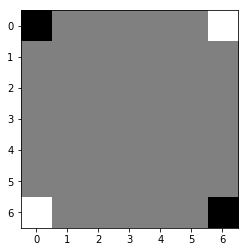

((6, 6), (5, 5)): n_v:   645 q_all:+0.021065 q:+0.030223 q_m:+0.033333 p:0.350473
((0, 0), (1, 1)): n_v:   602 q_all:+0.014896 q:+0.018747 q_m:+0.033333 p:0.344943
((0, 0), (0, 1)): n_v:   181 q_all:+0.010798 q:+0.003814 q_m:+0.033333 p:0.107373
((6, 6), (6, 5)): n_v:   171 q_all:+0.012597 q:+0.016267 q_m:+0.033333 p:0.100417
((0, 0), (1, 0)): n_v:    81 q_all:+0.012163 q:+0.019072 q_m:+0.033333 p:0.047645
((6, 6), (5, 6)): n_v:    80 q_all:+0.012196 q:+0.008629 q_m:+0.033333 p:0.047042
((6, 6), (6, 4)): n_v:     0 q_all:-0.005261 q:-0.005261 q_m:-0.000000 p:0.000051
((0, 0), (1, 2)): n_v:     0 q_all:-0.009787 q:-0.009787 q_m:-0.000000 p:0.000103
((0, 0), (2, 2)): n_v:     0 q_all:-0.012102 q:-0.012102 q_m:-0.000000 p:0.000303
((0, 0), (0, 2)): n_v:     0 q_all:-0.016031 q:-0.016031 q_m:-0.000000 p:0.000049
((6, 6), (4, 6)): n_v:     0 q_all:-0.007533 q:-0.007533 q_m:-0.000000 p:0.000225
((6, 6), (5, 4)): n_v:     0 q_all:+0.007332 q:+0.007332 q_m:-0.000000 p:0.000118
((6, 6), (4, 4))

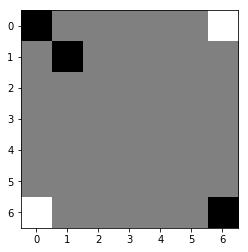

((6, 0), (5, 1)): n_v:   644 q_all:-0.029505 q:-0.024900 q_m:-0.000000 p:0.275519
((0, 6), (1, 5)): n_v:   580 q_all:-0.024451 q:-0.035463 q_m:-0.000000 p:0.236209
((6, 0), (5, 0)): n_v:   438 q_all:-0.028807 q:-0.028709 q_m:-0.000000 p:0.186243
((0, 6), (1, 6)): n_v:   387 q_all:-0.025843 q:-0.035853 q_m:-0.000000 p:0.159958
((6, 0), (6, 1)): n_v:   167 q_all:-0.033053 q:-0.030885 q_m:-0.000000 p:0.074242
((0, 6), (0, 5)): n_v:   146 q_all:-0.033248 q:-0.049165 q_m:-0.000000 p:0.064887
((0, 6), (2, 4)): n_v:     0 q_all:-0.074088 q:-0.074088 q_m:-0.033333 p:0.000211
((6, 0), (6, 2)): n_v:     0 q_all:-0.057876 q:-0.057876 q_m:-0.033333 p:0.000147
((6, 0), (5, 2)): n_v:     0 q_all:-0.055049 q:-0.055049 q_m:-0.033333 p:0.000182
((6, 0), (4, 1)): n_v:     0 q_all:-0.043902 q:-0.043902 q_m:-0.033333 p:0.000333
((0, 6), (2, 6)): n_v:     0 q_all:-0.045054 q:-0.045054 q_m:-0.033333 p:0.000284
((0, 6), (0, 4)): n_v:     0 q_all:-0.072690 q:-0.072690 q_m:-0.033333 p:0.000237
((0, 6), (2, 5))

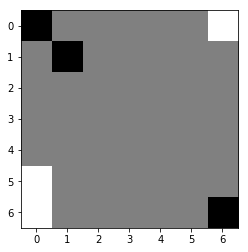

((6, 6), (5, 5)): n_v:   967 q_all:+0.009303 q:+0.022559 q_m:+0.033333 p:0.376080
((1, 1), (2, 1)): n_v:   316 q_all:+0.009643 q:+0.009502 q_m:+0.033333 p:0.122596
((0, 0), (0, 1)): n_v:   192 q_all:+0.001326 q:-0.011005 q_m:+0.033333 p:0.081089
((6, 6), (6, 5)): n_v:   186 q_all:+0.002580 q:+0.007410 q_m:+0.033333 p:0.077846
((1, 1), (2, 0)): n_v:   170 q_all:+0.007780 q:+0.011964 q_m:+0.033333 p:0.067167
((1, 1), (2, 2)): n_v:   162 q_all:+0.004372 q:+0.002112 q_m:+0.033333 p:0.066414
((6, 6), (5, 6)): n_v:    85 q_all:+0.002736 q:+0.002303 q_m:+0.033333 p:0.035606
((0, 0), (1, 0)): n_v:    58 q_all:+0.004818 q:+0.001301 q_m:+0.033333 p:0.023890
((1, 1), (0, 2)): n_v:    33 q_all:-0.002809 q:-0.007585 q_m:+0.033333 p:0.014782
((1, 1), (1, 2)): n_v:    29 q_all:-0.004231 q:-0.008547 q_m:+0.033333 p:0.013050
((1, 1), (3, 0)): n_v:     0 q_all:-0.004610 q:-0.004610 q_m:-0.000000 p:0.000307
((6, 6), (6, 4)): n_v:     0 q_all:-0.009630 q:-0.009630 q_m:-0.000000 p:0.000063
((1, 1), (2, 3))

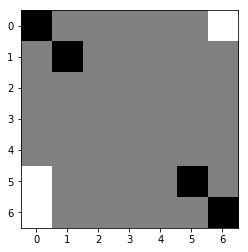

((0, 6), (1, 6)): n_v:   529 q_all:-0.026885 q:-0.035427 q_m:-0.000000 p:0.164063
((0, 6), (1, 5)): n_v:   490 q_all:-0.026371 q:-0.032526 q_m:-0.000000 p:0.151194
((5, 0), (5, 1)): n_v:   383 q_all:-0.025379 q:-0.027027 q_m:-0.000000 p:0.116738
((5, 0), (4, 0)): n_v:   376 q_all:-0.017633 q:-0.035870 q_m:-0.000000 p:0.103405
((5, 0), (4, 1)): n_v:   373 q_all:-0.021186 q:-0.037746 q_m:-0.000000 p:0.107659
((0, 6), (0, 5)): n_v:   265 q_all:-0.030471 q:-0.047943 q_m:-0.000000 p:0.085857
((5, 0), (6, 1)): n_v:   255 q_all:-0.029861 q:-0.034128 q_m:-0.000000 p:0.082248
((5, 0), (3, 1)): n_v:     2 q_all:-0.068549 q:-0.049539 q_m:-0.033333 p:0.000989
((5, 0), (3, 2)): n_v:     1 q_all:-0.064465 q:-0.050213 q_m:-0.033333 p:0.000657
((5, 0), (3, 0)): n_v:     1 q_all:-0.073360 q:-0.061439 q_m:-0.033333 p:0.000562
((5, 0), (4, 2)): n_v:     0 q_all:-0.049098 q:-0.049098 q_m:-0.033333 p:0.000258
((0, 6), (2, 4)): n_v:     0 q_all:-0.074794 q:-0.074794 q_m:-0.033333 p:0.000267
((6, 0), (6, 2))

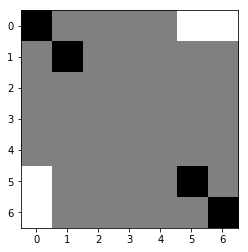

((1, 1), (2, 1)): n_v:   365 q_all:+0.005439 q:+0.006612 q_m:+0.033333 p:0.133975
((1, 1), (2, 2)): n_v:   281 q_all:+0.013247 q:+0.001926 q_m:+0.033333 p:0.093417
((5, 5), (4, 5)): n_v:   243 q_all:-0.014171 q:-0.002221 q_m:+0.033333 p:0.110733
((5, 5), (4, 4)): n_v:   195 q_all:-0.003507 q:+0.012423 q_m:+0.033333 p:0.079508
((5, 5), (6, 5)): n_v:   148 q_all:-0.004650 q:-0.004598 q_m:+0.033333 p:0.061293
((0, 0), (0, 1)): n_v:   148 q_all:-0.004995 q:-0.008338 q_m:+0.033333 p:0.061144
((1, 1), (2, 0)): n_v:   140 q_all:+0.008243 q:+0.011166 q_m:+0.033333 p:0.049618
((0, 0), (1, 0)): n_v:    87 q_all:-0.009316 q:+0.000082 q_m:+0.033333 p:0.037792
((1, 1), (1, 2)): n_v:    83 q_all:-0.008676 q:-0.003693 q_m:+0.033333 p:0.035685
((1, 1), (0, 2)): n_v:    83 q_all:-0.003665 q:-0.005262 q_m:+0.033333 p:0.033952
((5, 5), (4, 6)): n_v:    82 q_all:-0.014013 q:+0.006124 q_m:+0.033333 p:0.037557
((5, 5), (5, 6)): n_v:    56 q_all:-0.013660 q:-0.000615 q_m:+0.033333 p:0.025365
((5, 5), (6, 4))

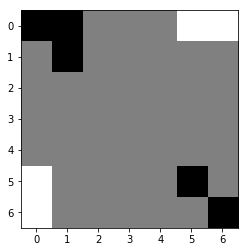

((0, 5), (1, 6)): n_v:   921 q_all:-0.035321 q:-0.038107 q_m:-0.000000 p:0.283253
((5, 0), (4, 1)): n_v:   202 q_all:-0.031104 q:-0.042274 q_m:-0.000000 p:0.058474
((0, 5), (1, 4)): n_v:   169 q_all:-0.023686 q:-0.043450 q_m:-0.000000 p:0.042823
((0, 5), (1, 5)): n_v:   155 q_all:-0.042950 q:-0.054962 q_m:-0.000000 p:0.053399
((5, 0), (5, 1)): n_v:   133 q_all:-0.031559 q:-0.031155 q_m:-0.000000 p:0.038900
((5, 0), (4, 0)): n_v:   121 q_all:-0.026899 q:-0.040991 q_m:-0.000000 p:0.032575
((5, 0), (6, 1)): n_v:   115 q_all:-0.038125 q:-0.036459 q_m:-0.000000 p:0.037141
((0, 5), (0, 4)): n_v:    78 q_all:-0.038811 q:-0.063403 q_m:-0.000000 p:0.025335
((0, 5), (2, 6)): n_v:     2 q_all:-0.051042 q:-0.039702 q_m:-0.033333 p:0.001075
((0, 5), (2, 4)): n_v:     2 q_all:-0.055422 q:-0.072435 q_m:-0.033333 p:0.001098
((0, 5), (2, 5)): n_v:     1 q_all:-0.032309 q:-0.032641 q_m:-0.033333 p:0.000462
((5, 0), (3, 2)): n_v:     1 q_all:-0.067231 q:-0.047835 q_m:-0.033333 p:0.000469
((5, 0), (3, 1))

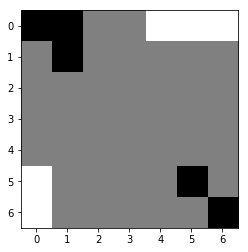

((1, 1), (2, 1)): n_v:   251 q_all:-0.003726 q:-0.006172 q_m:+0.033333 p:0.114285
((1, 1), (2, 0)): n_v:   242 q_all:+0.005201 q:-0.009054 q_m:+0.033333 p:0.099743
((5, 5), (4, 5)): n_v:   235 q_all:-0.013745 q:-0.015267 q_m:+0.033333 p:0.118292
((1, 1), (2, 2)): n_v:   203 q_all:-0.009359 q:-0.010177 q_m:+0.033333 p:0.098221
((5, 5), (4, 6)): n_v:   164 q_all:-0.017275 q:-0.007429 q_m:+0.033333 p:0.085626
((5, 5), (4, 4)): n_v:   161 q_all:-0.004171 q:-0.000717 q_m:+0.033333 p:0.073498
((5, 5), (6, 5)): n_v:    98 q_all:-0.007077 q:-0.018314 q_m:+0.033333 p:0.046370
((0, 0), (1, 0)): n_v:    75 q_all:-0.009938 q:-0.012333 q_m:+0.033333 p:0.036739
((0, 1), (1, 2)): n_v:    70 q_all:-0.018517 q:-0.023048 q_m:+0.033333 p:0.037287
((0, 1), (0, 2)): n_v:    53 q_all:-0.006956 q:-0.020017 q_m:+0.033333 p:0.025228
((5, 5), (5, 4)): n_v:    41 q_all:-0.007473 q:-0.000567 q_m:+0.033333 p:0.019480
((5, 5), (6, 4)): n_v:    32 q_all:-0.012562 q:+0.001745 q_m:+0.033333 p:0.016380
((5, 5), (5, 6))

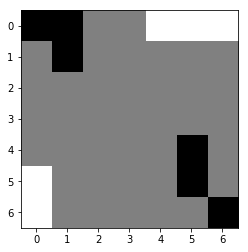

((0, 5), (1, 6)): n_v:   474 q_all:-0.028282 q:-0.068153 q_m:-0.000000 p:0.166626
((0, 4), (1, 5)): n_v:   253 q_all:-0.017647 q:-0.082769 q_m:-0.000000 p:0.076489
((0, 4), (1, 6)): n_v:   234 q_all:-0.040410 q:-0.067019 q_m:-0.033333 p:0.095548
((0, 4), (1, 2)): n_v:   149 q_all:-0.049421 q:-0.018593 q_m:+0.100000 p:0.067082
((0, 4), (1, 3)): n_v:   110 q_all:-0.009708 q:-0.068534 q_m:-0.000000 p:0.029302
((5, 0), (4, 1)): n_v:   104 q_all:-0.035371 q:-0.061781 q_m:-0.000000 p:0.040212
((5, 0), (4, 0)): n_v:    99 q_all:-0.030115 q:-0.058074 q_m:-0.000000 p:0.035902
((0, 4), (1, 4)): n_v:    98 q_all:-0.022977 q:-0.074396 q_m:-0.000000 p:0.031988
((5, 0), (5, 1)): n_v:    90 q_all:-0.026091 q:-0.049992 q_m:-0.000000 p:0.030599
((5, 0), (6, 1)): n_v:    65 q_all:-0.035801 q:-0.052232 q_m:-0.000000 p:0.025059
((0, 4), (0, 3)): n_v:    53 q_all:-0.032853 q:-0.064789 q_m:-0.000000 p:0.019631
((0, 4), (2, 6)): n_v:    32 q_all:-0.076346 q:-0.060530 q_m:-0.033333 p:0.018502
((0, 4), (2, 2))

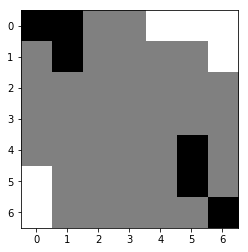

((4, 5), (3, 5)): n_v:   536 q_all:+0.028069 q:-0.030359 q_m:+0.033333 p:0.170160
((4, 5), (3, 6)): n_v:   535 q_all:+0.033898 q:-0.023503 q_m:+0.033333 p:0.156084
((4, 5), (4, 6)): n_v:   181 q_all:+0.000529 q:-0.024487 q_m:+0.033333 p:0.079703
((4, 5), (3, 4)): n_v:   144 q_all:+0.026526 q:-0.020709 q_m:+0.033333 p:0.046601
((5, 5), (6, 5)): n_v:   105 q_all:+0.001680 q:-0.023439 q_m:+0.033333 p:0.045489
((1, 1), (2, 0)): n_v:   105 q_all:+0.009959 q:-0.014642 q_m:+0.033333 p:0.041995
((1, 1), (2, 1)): n_v:    99 q_all:-0.029917 q:-0.010336 q_m:+0.033333 p:0.056988
((4, 5), (4, 4)): n_v:    73 q_all:-0.001245 q:-0.016114 q_m:+0.033333 p:0.032846
((4, 5), (5, 6)): n_v:    41 q_all:+0.000900 q:-0.021828 q_m:+0.033333 p:0.018264
((5, 5), (6, 4)): n_v:    38 q_all:-0.003738 q:-0.008514 q_m:+0.033333 p:0.017682
((1, 1), (2, 2)): n_v:    32 q_all:-0.031216 q:-0.015890 q_m:+0.033333 p:0.018707
((4, 5), (2, 5)): n_v:    31 q_all:-0.057160 q:+0.013608 q_m:+0.066667 p:0.021557
((0, 0), (1, 0))

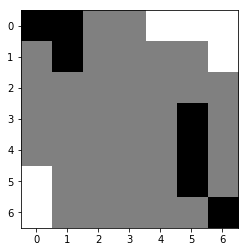

((1, 6), (2, 6)): n_v:   477 q_all:-0.010261 q:-0.033020 q_m:+0.066667 p:0.131369
((0, 4), (2, 2)): n_v:   443 q_all:-0.037277 q:-0.041738 q_m:+0.033333 p:0.171956
((1, 6), (2, 5)): n_v:   249 q_all:-0.022079 q:-0.048399 q_m:+0.066667 p:0.080986
((1, 6), (3, 4)): n_v:   187 q_all:-0.059452 q:-0.002452 q_m:+0.100000 p:0.089967
((0, 4), (2, 6)): n_v:   139 q_all:-0.017444 q:-0.039478 q_m:+0.033333 p:0.042572
((1, 6), (2, 4)): n_v:   131 q_all:-0.031554 q:-0.059974 q_m:+0.033333 p:0.047734
((0, 4), (1, 2)): n_v:   101 q_all:-0.048346 q:-0.021153 q_m:+0.100000 p:0.044071
((5, 0), (4, 0)): n_v:    82 q_all:-0.171354 q:-0.062446 q_m:-0.000000 p:0.078127
((0, 4), (2, 4)): n_v:    70 q_all:-0.027506 q:-0.050826 q_m:+0.033333 p:0.024427
((0, 5), (2, 4)): n_v:    56 q_all:-0.026711 q:-0.054060 q_m:+0.033333 p:0.019386
((0, 6), (2, 4)): n_v:    45 q_all:-0.023939 q:-0.057430 q_m:+0.033333 p:0.015045
((1, 6), (3, 6)): n_v:    41 q_all:-0.085777 q:-0.022096 q_m:+0.100000 p:0.024134
((0, 4), (2, 5))

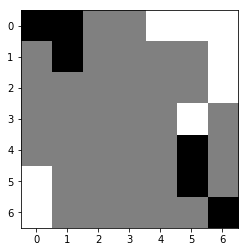

((4, 5), (2, 5)): n_v:  1151 q_all:+0.072094 q:+0.016686 q_m:+0.133333 p:0.256507
((4, 5), (3, 6)): n_v:   878 q_all:-0.021368 q:-0.007002 q_m:+0.100000 p:0.542963
((5, 5), (3, 6)): n_v:    76 q_all:-0.035875 q:-0.007502 q_m:+0.066667 p:0.051590
((1, 1), (2, 1)): n_v:    26 q_all:-0.114078 q:-0.080738 q_m:-0.033333 p:0.026853
((4, 5), (4, 6)): n_v:    14 q_all:-0.065813 q:-0.033166 q_m:+0.033333 p:0.011240
((4, 5), (3, 4)): n_v:    12 q_all:-0.051039 q:-0.037323 q_m:+0.033333 p:0.009608
((4, 5), (2, 4)): n_v:     9 q_all:-0.022996 q:-0.023652 q_m:-0.000000 p:0.006166
((1, 1), (2, 0)): n_v:     7 q_all:-0.136123 q:-0.076496 q_m:-0.033333 p:0.008648
((4, 5), (4, 4)): n_v:     6 q_all:-0.053782 q:-0.029716 q_m:+0.033333 p:0.004642
((1, 1), (3, 0)): n_v:     5 q_all:-0.141114 q:-0.090172 q_m:-0.066667 p:0.006075
((4, 5), (5, 3)): n_v:     4 q_all:-0.072960 q:-0.074533 q_m:-0.066667 p:0.003781
((0, 1), (1, 3)): n_v:     4 q_all:-0.005822 q:-0.054782 q_m:-0.000000 p:0.002221
((4, 5), (3, 3))

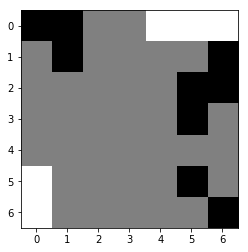

((0, 4), (1, 5)): n_v:  2869 q_all:-0.063150 q:+0.000653 q_m:+0.100000 p:0.637909
((5, 0), (5, 1)): n_v:     6 q_all:-0.187051 q:-0.103886 q_m:-0.100000 p:0.004747
((0, 6), (2, 4)): n_v:     5 q_all:-0.040771 q:-0.084442 q_m:-0.000000 p:0.000573
((0, 4), (2, 4)): n_v:     2 q_all:-0.097369 q:-0.087044 q_m:-0.000000 p:0.000834
((0, 5), (2, 4)): n_v:     2 q_all:-0.106728 q:-0.091086 q_m:-0.000000 p:0.001052
((0, 4), (1, 4)): n_v:     2 q_all:-0.254394 q:-0.121284 q_m:-0.033333 p:0.002231
((5, 0), (4, 0)): n_v:     2 q_all:-0.174757 q:-0.114777 q_m:-0.100000 p:0.001335
((0, 4), (1, 3)): n_v:     1 q_all:-0.112549 q:-0.129771 q_m:-0.100000 p:0.000754
((0, 4), (1, 2)): n_v:     1 q_all:-0.062218 q:-0.080678 q_m:-0.000000 p:0.000374
((5, 0), (4, 2)): n_v:     0 q_all:-0.130233 q:-0.130233 q_m:-0.133333 p:0.000086
((0, 5), (2, 3)): n_v:     0 q_all:-0.124634 q:-0.124634 q_m:-0.133333 p:0.000012
((6, 0), (5, 2)): n_v:     0 q_all:-0.125633 q:-0.125633 q_m:-0.133333 p:0.000033
((0, 5), (1, 3))

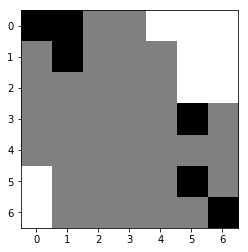

((3, 5), (1, 4)): n_v:  4264 q_all:+0.069214 q:+0.091473 q_m:+0.166667 p:0.824713
((3, 5), (3, 6)): n_v:   107 q_all:+0.016575 q:-0.009343 q_m:+0.066667 p:0.037320
((3, 5), (5, 4)): n_v:    93 q_all:-0.115711 q:-0.102778 q_m:-0.100000 p:0.069027
((0, 1), (1, 2)): n_v:    25 q_all:-0.092991 q:-0.088708 q_m:-0.066667 p:0.016873
((3, 5), (5, 6)): n_v:    12 q_all:-0.116217 q:-0.105848 q_m:-0.100000 p:0.009289
((3, 5), (2, 4)): n_v:    10 q_all:-0.018556 q:-0.034126 q_m:+0.066667 p:0.004632
((5, 5), (5, 4)): n_v:     9 q_all:-0.080124 q:-0.062246 q_m:-0.066667 p:0.006221
((3, 5), (3, 4)): n_v:     3 q_all:-0.070506 q:-0.045024 q_m:-0.000000 p:0.001931
((5, 5), (3, 6)): n_v:     2 q_all:-0.021251 q:-0.026185 q_m:+0.033333 p:0.000963
((3, 5), (4, 6)): n_v:     1 q_all:-0.093721 q:-0.096247 q_m:-0.066667 p:0.001206
((3, 5), (4, 4)): n_v:     1 q_all:-0.095597 q:-0.067893 q_m:-0.066667 p:0.001354
((5, 5), (6, 5)): n_v:     0 q_all:-0.075563 q:-0.075563 q_m:-0.066667 p:0.000066
((1, 1), (1, 3))

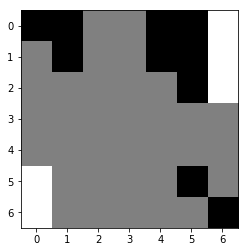

((2, 6), (2, 4)): n_v:  3044 q_all:-0.051721 q:-0.058052 q_m:+0.033333 p:0.520398
((1, 6), (2, 4)): n_v:   958 q_all:-0.080172 q:-0.071519 q_m:+0.033333 p:0.233945
((0, 6), (2, 4)): n_v:   652 q_all:-0.065864 q:-0.052020 q_m:+0.033333 p:0.135184
((2, 6), (4, 4)): n_v:   274 q_all:-0.062161 q:-0.091171 q_m:-0.100000 p:0.054329
((2, 6), (3, 6)): n_v:    61 q_all:-0.113582 q:-0.133312 q_m:-0.066667 p:0.020453
((2, 6), (3, 5)): n_v:    43 q_all:-0.114734 q:-0.121150 q_m:-0.066667 p:0.014630
((5, 0), (4, 2)): n_v:     9 q_all:-0.108257 q:-0.118925 q_m:-0.166667 p:0.003091
((2, 6), (4, 5)): n_v:     9 q_all:-0.088878 q:-0.081790 q_m:-0.100000 p:0.002519
((6, 0), (4, 2)): n_v:     7 q_all:-0.114284 q:-0.128264 q_m:-0.166667 p:0.002404
((5, 0), (5, 1)): n_v:     6 q_all:-0.079208 q:-0.094720 q_m:-0.133333 p:0.001592
((5, 0), (6, 1)): n_v:     3 q_all:-0.102411 q:-0.101528 q_m:-0.133333 p:0.001082
((5, 0), (4, 1)): n_v:     3 q_all:-0.109361 q:-0.107575 q_m:-0.133333 p:0.000963
((2, 6), (4, 6))

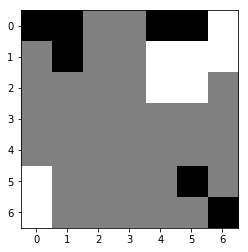

((0, 4), (1, 3)): n_v:  1866 q_all:+0.050213 q:+0.049496 q_m:+0.133333 p:0.477716
((0, 4), (2, 6)): n_v:  1555 q_all:+0.061778 q:+0.060545 q_m:+0.166667 p:0.346037
((5, 5), (4, 6)): n_v:   166 q_all:+0.021277 q:+0.021492 q_m:-0.000000 p:0.056466
((1, 1), (2, 0)): n_v:   141 q_all:+0.019516 q:+0.021046 q_m:-0.000000 p:0.048731
((5, 5), (3, 5)): n_v:    32 q_all:+0.031608 q:+0.039255 q_m:+0.100000 p:0.009980
((0, 4), (0, 3)): n_v:    25 q_all:+0.000856 q:+0.030631 q_m:+0.066667 p:0.010150
((0, 0), (2, 0)): n_v:    19 q_all:-0.008912 q:+0.000274 q_m:-0.033333 p:0.008088
((0, 1), (2, 0)): n_v:    17 q_all:+0.005917 q:-0.011347 q_m:-0.033333 p:0.006869
((0, 5), (2, 6)): n_v:    16 q_all:+0.035687 q:+0.027955 q_m:+0.166667 p:0.004821
((0, 5), (1, 3)): n_v:    11 q_all:+0.033208 q:-0.004081 q_m:+0.100000 p:0.003291
((5, 5), (3, 4)): n_v:    10 q_all:+0.037719 q:+0.045110 q_m:+0.100000 p:0.003210
((6, 6), (4, 6)): n_v:    10 q_all:-0.021141 q:+0.007674 q_m:-0.033333 p:0.004793
((0, 4), (2, 3))

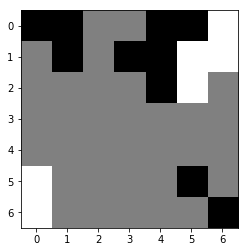

((2, 5), (0, 3)): n_v:  1417 q_all:-0.027024 q:-0.028532 q_m:+0.066667 p:0.381184
((2, 5), (2, 3)): n_v:  1138 q_all:-0.017702 q:-0.051559 q_m:+0.066667 p:0.270817
((1, 5), (2, 3)): n_v:   256 q_all:-0.125682 q:-0.087539 q_m:+0.066667 p:0.153087
((1, 5), (0, 3)): n_v:   252 q_all:-0.129111 q:-0.066251 q_m:+0.066667 p:0.152950
((2, 5), (4, 3)): n_v:    18 q_all:-0.093326 q:-0.117682 q_m:-0.133333 p:0.008999
((5, 0), (4, 1)): n_v:    17 q_all:-0.087205 q:-0.075061 q_m:-0.100000 p:0.008071
((2, 5), (3, 4)): n_v:    13 q_all:-0.073990 q:-0.084382 q_m:-0.033333 p:0.005924
((1, 5), (2, 6)): n_v:     5 q_all:-0.108418 q:-0.071889 q_m:-0.100000 p:0.002753
((2, 5), (3, 5)): n_v:     4 q_all:-0.064275 q:-0.078973 q_m:-0.033333 p:0.001942
((2, 5), (4, 5)): n_v:     3 q_all:-0.072179 q:-0.058799 q_m:-0.066667 p:0.001291
((5, 0), (6, 1)): n_v:     2 q_all:-0.072480 q:-0.066761 q_m:-0.100000 p:0.001209
((5, 0), (5, 1)): n_v:     1 q_all:-0.108414 q:-0.063233 q_m:-0.100000 p:0.000795
((5, 0), (4, 0))

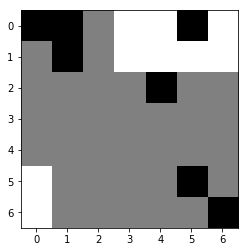

((2, 4), (2, 5)): n_v:  1687 q_all:+0.079398 q:+0.064519 q_m:+0.166667 p:0.323491
((1, 1), (2, 1)): n_v:   370 q_all:-0.019386 q:-0.001379 q_m:-0.033333 p:0.203924
((2, 4), (2, 3)): n_v:   236 q_all:+0.018411 q:+0.029141 q_m:+0.100000 p:0.097694
((5, 5), (4, 5)): n_v:   113 q_all:+0.003484 q:-0.007256 q_m:-0.033333 p:0.053190
((1, 1), (2, 0)): n_v:    83 q_all:-0.000913 q:-0.003770 q_m:-0.033333 p:0.040427
((2, 4), (1, 2)): n_v:    73 q_all:-0.048789 q:-0.018495 q_m:+0.066667 p:0.048235
((0, 1), (0, 2)): n_v:    73 q_all:-0.018715 q:+0.009924 q_m:+0.100000 p:0.039797
((0, 1), (1, 2)): n_v:    56 q_all:-0.021911 q:-0.011044 q_m:+0.100000 p:0.031724
((5, 5), (6, 4)): n_v:    16 q_all:-0.004878 q:+0.003742 q_m:-0.033333 p:0.007994
((5, 5), (4, 6)): n_v:    15 q_all:+0.008904 q:-0.003034 q_m:-0.033333 p:0.006943
((2, 4), (0, 2)): n_v:    10 q_all:-0.045664 q:-0.009047 q_m:+0.066667 p:0.006693
((0, 0), (2, 1)): n_v:     9 q_all:-0.057771 q:-0.021233 q_m:-0.066667 p:0.006694
((0, 0), (1, 0))

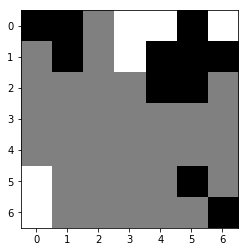

((0, 4), (2, 6)): n_v:  1188 q_all:-0.075966 q:-0.072211 q_m:+0.033333 p:0.386104
((1, 3), (2, 3)): n_v:  1186 q_all:-0.054226 q:-0.062696 q_m:-0.000000 p:0.297843
((0, 6), (2, 6)): n_v:   453 q_all:-0.057036 q:-0.021714 q_m:+0.033333 p:0.117918
((1, 3), (2, 2)): n_v:   152 q_all:-0.094723 q:-0.107060 q_m:-0.066667 p:0.059482
((5, 0), (4, 0)): n_v:   149 q_all:-0.053741 q:-0.087992 q_m:-0.133333 p:0.037395
((0, 3), (1, 2)): n_v:    26 q_all:-0.119970 q:-0.075323 q_m:-0.000000 p:0.012739
((0, 3), (2, 1)): n_v:    20 q_all:-0.107530 q:-0.104162 q_m:-0.100000 p:0.008683
((0, 3), (0, 2)): n_v:    19 q_all:-0.098832 q:-0.052293 q_m:-0.000000 p:0.007942
((0, 3), (2, 2)): n_v:    13 q_all:-0.104459 q:-0.115805 q_m:-0.100000 p:0.005611
((5, 0), (4, 1)): n_v:    10 q_all:-0.047626 q:-0.096783 q_m:-0.133333 p:0.002382
((0, 3), (2, 3)): n_v:     8 q_all:-0.065899 q:-0.098699 q_m:-0.033333 p:0.002597
((5, 0), (5, 1)): n_v:     7 q_all:-0.035034 q:-0.084049 q_m:-0.133333 p:0.001444
((1, 3), (2, 1))

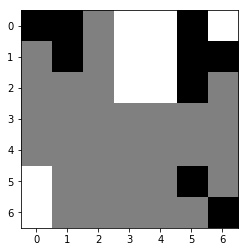

((2, 5), (3, 4)): n_v:  1267 q_all:+0.106777 q:+0.070721 q_m:+0.166667 p:0.080082
((0, 1), (1, 2)): n_v:   978 q_all:+0.031190 q:+0.118782 q_m:+0.233333 p:0.334246
((0, 0), (1, 2)): n_v:   327 q_all:+0.006792 q:+0.109568 q_m:+0.200000 p:0.141106
((1, 1), (2, 2)): n_v:    62 q_all:+0.056653 q:+0.081823 q_m:+0.166667 p:0.015475
((5, 5), (3, 3)): n_v:    41 q_all:+0.069424 q:+0.066690 q_m:+0.133333 p:0.008411
((1, 1), (2, 1)): n_v:    24 q_all:+0.017546 q:+0.057283 q_m:+0.033333 p:0.009536
((5, 5), (3, 4)): n_v:    19 q_all:+0.062905 q:+0.043654 q_m:+0.133333 p:0.004347
((0, 1), (0, 2)): n_v:    17 q_all:-0.014966 q:+0.068554 q_m:+0.166667 p:0.008622
((5, 5), (5, 4)): n_v:    13 q_all:+0.038074 q:+0.052397 q_m:+0.033333 p:0.004311
((1, 1), (3, 2)): n_v:    10 q_all:+0.083860 q:+0.097999 q_m:+0.066667 p:0.000867
((5, 5), (4, 4)): n_v:     9 q_all:+0.075246 q:+0.065954 q_m:+0.033333 p:0.001367
((1, 1), (3, 3)): n_v:     6 q_all:+0.067024 q:+0.084166 q_m:+0.133333 p:0.001462
((1, 5), (3, 3))

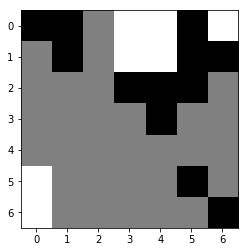

((1, 4), (3, 3)): n_v:   441 q_all:-0.092614 q:-0.108924 q_m:+0.033333 p:0.128315
((0, 3), (1, 2)): n_v:   381 q_all:-0.074582 q:-0.028500 q_m:+0.066667 p:0.084843
((1, 3), (2, 2)): n_v:   283 q_all:-0.102012 q:-0.065367 q_m:-0.000000 p:0.092304
((1, 3), (3, 3)): n_v:   232 q_all:-0.114131 q:-0.104143 q_m:+0.033333 p:0.086297
((1, 3), (3, 5)): n_v:   223 q_all:-0.089272 q:-0.118122 q_m:+0.033333 p:0.062116
((0, 4), (2, 6)): n_v:   168 q_all:-0.084741 q:-0.051602 q_m:+0.033333 p:0.043976
((5, 0), (3, 1)): n_v:   163 q_all:-0.102152 q:-0.093628 q_m:-0.166667 p:0.053331
((0, 6), (2, 6)): n_v:   157 q_all:-0.048444 q:-0.001357 q_m:+0.033333 p:0.019773
((1, 3), (3, 1)): n_v:   131 q_all:-0.212965 q:-0.145606 q_m:-0.166667 p:0.097285
((1, 4), (1, 2)): n_v:   126 q_all:-0.057288 q:-0.112137 q_m:+0.033333 p:0.019869
((0, 4), (1, 2)): n_v:   119 q_all:-0.051518 q:-0.085733 q_m:+0.033333 p:0.016325
((5, 0), (4, 0)): n_v:   107 q_all:-0.053922 q:-0.073733 q_m:-0.133333 p:0.015423
((1, 4), (3, 5))

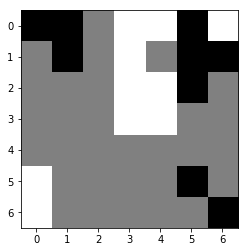

((0, 5), (1, 4)): n_v:  1854 q_all:+0.158482 q:+0.165094 q_m:+0.333333 p:0.149698
((0, 1), (1, 2)): n_v:   121 q_all:-0.015356 q:-0.016821 q_m:+0.200000 p:0.100002
((1, 6), (1, 4)): n_v:    64 q_all:+0.101586 q:+0.146133 q_m:+0.300000 p:0.020911
((5, 5), (5, 4)): n_v:    36 q_all:-0.024322 q:+0.005056 q_m:-0.000000 p:0.031512
((0, 0), (1, 2)): n_v:    33 q_all:-0.031414 q:-0.023623 q_m:+0.166667 p:0.029410
((5, 5), (4, 4)): n_v:    31 q_all:+0.019082 q:+0.030934 q_m:+0.133333 p:0.021360
((1, 1), (2, 2)): n_v:    27 q_all:-0.002809 q:-0.000620 q_m:+0.200000 p:0.020538
((6, 6), (5, 4)): n_v:     5 q_all:-0.035362 q:-0.008743 q_m:-0.033333 p:0.005174
((2, 5), (3, 5)): n_v:     4 q_all:-0.015323 q:-0.018426 q_m:+0.133333 p:0.004077
((0, 0), (2, 2)): n_v:     1 q_all:-0.033846 q:-0.020065 q_m:+0.166667 p:0.001130
((6, 6), (4, 4)): n_v:     1 q_all:-0.003319 q:+0.024414 q_m:+0.100000 p:0.001477
((5, 5), (6, 5)): n_v:     0 q_all:-0.005584 q:-0.005584 q_m:-0.000000 p:0.000141
((0, 5), (2, 6))

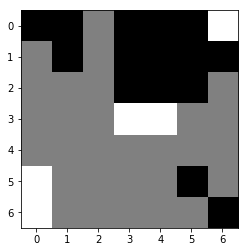

((3, 4), (2, 6)): n_v:  1417 q_all:-0.106433 q:-0.093331 q_m:-0.133333 p:0.336636
((3, 4), (1, 2)): n_v:   715 q_all:-0.162559 q:-0.104310 q_m:-0.000000 p:0.316789
((3, 4), (5, 6)): n_v:   284 q_all:-0.109523 q:-0.105723 q_m:-0.200000 p:0.070885
((3, 3), (1, 2)): n_v:   139 q_all:-0.132805 q:-0.122484 q_m:-0.000000 p:0.046614
((3, 4), (4, 6)): n_v:   128 q_all:-0.186967 q:-0.150447 q_m:-0.266667 p:0.068416
((3, 3), (2, 2)): n_v:    45 q_all:-0.243128 q:-0.166117 q_m:-0.100000 p:0.033855
((3, 4), (2, 2)): n_v:    34 q_all:-0.256536 q:-0.156537 q_m:-0.133333 p:0.027061
((3, 3), (5, 1)): n_v:    28 q_all:-0.220909 q:-0.209935 q_m:-0.333333 p:0.018887
((3, 4), (5, 2)): n_v:    15 q_all:-0.265453 q:-0.190884 q_m:-0.333333 p:0.012968
((3, 3), (2, 1)): n_v:    14 q_all:-0.232715 q:-0.186656 q_m:-0.266667 p:0.010326
((0, 6), (2, 6)): n_v:    14 q_all:-0.142893 q:-0.141749 q_m:-0.133333 p:0.005422
((5, 0), (4, 0)): n_v:    13 q_all:-0.227150 q:-0.208034 q_m:-0.300000 p:0.009424
((3, 3), (4, 2))

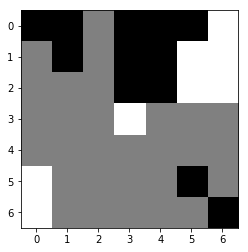

((2, 4), (3, 5)): n_v:  1659 q_all:+0.133782 q:+0.142402 q_m:+0.300000 p:0.313744
((2, 3), (3, 4)): n_v:   295 q_all:+0.119133 q:+0.163773 q_m:+0.300000 p:0.071559
((2, 3), (3, 2)): n_v:   262 q_all:+0.099048 q:+0.135417 q_m:+0.233333 p:0.082668
((2, 3), (3, 5)): n_v:   107 q_all:+0.125162 q:+0.109471 q_m:+0.266667 p:0.023733
((1, 1), (2, 0)): n_v:   101 q_all:+0.110932 q:+0.131809 q_m:+0.166667 p:0.027632
((1, 1), (2, 2)): n_v:    66 q_all:+0.083563 q:+0.118109 q_m:+0.233333 p:0.024657
((0, 1), (0, 2)): n_v:    54 q_all:+0.018101 q:+0.102701 q_m:+0.166667 p:0.033376
((5, 5), (6, 5)): n_v:    50 q_all:+0.092097 q:+0.105657 q_m:+0.166667 p:0.016942
((2, 3), (3, 1)): n_v:    42 q_all:+0.048814 q:+0.064466 q_m:+0.133333 p:0.021226
((0, 0), (1, 0)): n_v:    34 q_all:+0.094445 q:+0.120820 q_m:+0.166667 p:0.010912
((5, 5), (3, 5)): n_v:    29 q_all:+0.116394 q:+0.120880 q_m:+0.266667 p:0.007122
((1, 1), (2, 1)): n_v:    28 q_all:+0.059600 q:+0.122014 q_m:+0.166667 p:0.012699
((5, 5), (4, 6))

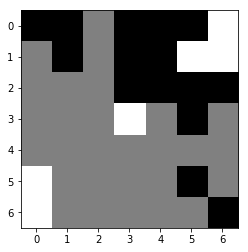

((3, 3), (3, 4)): n_v:  1743 q_all:-0.058050 q:-0.069669 q_m:-0.000000 p:0.321375
((3, 3), (3, 2)): n_v:   684 q_all:-0.167101 q:-0.104419 q_m:-0.200000 p:0.381535
((3, 3), (1, 2)): n_v:   269 q_all:-0.088755 q:-0.033282 q_m:+0.033333 p:0.077973
((1, 6), (3, 4)): n_v:   152 q_all:-0.144040 q:-0.149494 q_m:-0.033333 p:0.072926
((1, 5), (3, 4)): n_v:    51 q_all:-0.206441 q:-0.188863 q_m:-0.033333 p:0.035582
((3, 3), (2, 1)): n_v:    38 q_all:-0.201952 q:-0.093266 q_m:-0.233333 p:0.026019
((5, 0), (3, 2)): n_v:    35 q_all:-0.189526 q:-0.122414 q_m:-0.233333 p:0.022629
((3, 3), (5, 1)): n_v:    35 q_all:-0.146515 q:-0.129367 q_m:-0.300000 p:0.017279
((3, 3), (5, 2)): n_v:    31 q_all:-0.132996 q:-0.136830 q_m:-0.300000 p:0.013874
((3, 3), (4, 1)): n_v:    12 q_all:-0.149981 q:-0.159405 q_m:-0.300000 p:0.006343
((3, 3), (4, 5)): n_v:    11 q_all:-0.094155 q:-0.153380 q_m:-0.166667 p:0.003222
((3, 3), (5, 4)): n_v:    10 q_all:-0.207236 q:-0.085562 q_m:-0.233333 p:0.007547
((1, 6), (3, 6))

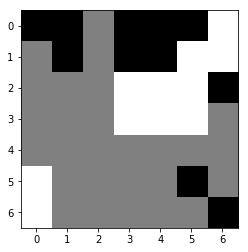

((2, 6), (3, 6)): n_v:  2010 q_all:+0.089270 q:+0.094277 q_m:+0.166667 p:0.443933
((5, 5), (4, 4)): n_v:   501 q_all:+0.084063 q:+0.090244 q_m:+0.233333 p:0.119584
((1, 1), (2, 2)): n_v:   431 q_all:+0.039723 q:+0.094239 q_m:+0.166667 p:0.168998
((2, 6), (4, 4)): n_v:    88 q_all:+0.078598 q:+0.067605 q_m:+0.200000 p:0.022714
((5, 5), (4, 5)): n_v:    66 q_all:+0.064300 q:+0.050190 q_m:+0.166667 p:0.020170
((0, 0), (2, 2)): n_v:    32 q_all:-0.000211 q:+0.074816 q_m:+0.133333 p:0.017039
((0, 3), (2, 2)): n_v:    22 q_all:+0.037257 q:+0.055778 q_m:+0.133333 p:0.009066
((1, 1), (2, 1)): n_v:    15 q_all:-0.000816 q:+0.060171 q_m:+0.033333 p:0.008286
((6, 6), (4, 4)): n_v:    15 q_all:+0.080023 q:+0.079308 q_m:+0.200000 p:0.003440
((0, 1), (2, 2)): n_v:    13 q_all:+0.033393 q:+0.072834 q_m:+0.133333 p:0.005785
((1, 1), (3, 2)): n_v:    12 q_all:+0.066060 q:+0.072940 q_m:+0.133333 p:0.003792
((5, 5), (6, 5)): n_v:    10 q_all:-0.003937 q:+0.046938 q_m:+0.033333 p:0.005694
((0, 1), (1, 2))

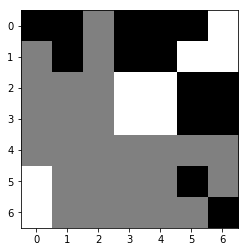

((2, 3), (1, 2)): n_v:  1748 q_all:-0.074040 q:-0.010970 q_m:+0.133333 p:0.435989
((3, 4), (4, 5)): n_v:   677 q_all:-0.066757 q:-0.036608 q_m:+0.066667 p:0.152815
((3, 4), (5, 6)): n_v:   176 q_all:-0.094758 q:-0.035451 q_m:-0.033333 p:0.055675
((3, 3), (2, 1)): n_v:   127 q_all:-0.103630 q:-0.074146 q_m:-0.100000 p:0.044022
((5, 0), (4, 1)): n_v:   101 q_all:-0.084461 q:-0.083434 q_m:-0.133333 p:0.028517
((3, 3), (4, 5)): n_v:    82 q_all:-0.048189 q:-0.049292 q_m:+0.033333 p:0.013555
((2, 3), (2, 2)): n_v:    77 q_all:-0.115536 q:-0.057815 q_m:-0.000000 p:0.029621
((3, 4), (1, 2)): n_v:    62 q_all:-0.092862 q:-0.078636 q_m:+0.100000 p:0.019384
((5, 0), (4, 0)): n_v:    54 q_all:-0.074720 q:-0.076196 q_m:-0.133333 p:0.013672
((2, 4), (1, 2)): n_v:    52 q_all:-0.112904 q:-0.132991 q_m:+0.100000 p:0.019835
((2, 3), (2, 1)): n_v:    47 q_all:-0.120334 q:-0.086048 q_m:-0.100000 p:0.018890
((2, 3), (0, 2)): n_v:    46 q_all:-0.060476 q:-0.023580 q_m:+0.100000 p:0.009610
((3, 3), (1, 2))

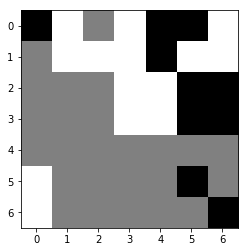

((0, 0), (0, 2)): n_v:  2962 q_all:+0.118939 q:+0.130304 q_m:+0.200000 p:0.838370
((0, 4), (2, 2)): n_v:    98 q_all:+0.030107 q:-0.006804 q_m:+0.200000 p:0.057503
((0, 0), (2, 2)): n_v:    70 q_all:+0.032250 q:+0.052596 q_m:+0.200000 p:0.040672
((0, 4), (0, 2)): n_v:    67 q_all:+0.033327 q:+0.070990 q_m:+0.200000 p:0.038492
((1, 4), (2, 2)): n_v:    11 q_all:-0.048011 q:-0.061806 q_m:+0.200000 p:0.010039
((3, 5), (4, 4)): n_v:     4 q_all:-0.053237 q:-0.047337 q_m:+0.033333 p:0.003932
((1, 4), (0, 2)): n_v:     4 q_all:-0.031003 q:+0.027617 q_m:+0.200000 p:0.003746
((0, 0), (1, 0)): n_v:     1 q_all:+0.052586 q:+0.044503 q_m:+0.033333 p:0.000685
((6, 6), (4, 4)): n_v:     1 q_all:-0.113653 q:-0.060399 q_m:-0.000000 p:0.001100
((5, 5), (6, 5)): n_v:     0 q_all:-0.096112 q:-0.096112 q_m:-0.100000 p:0.000065
((2, 5), (4, 3)): n_v:     0 q_all:-0.144854 q:-0.144854 q_m:-0.000000 p:0.000011
((3, 5), (4, 6)): n_v:     0 q_all:-0.117805 q:-0.117805 q_m:-0.100000 p:0.000006
((6, 6), (6, 4))

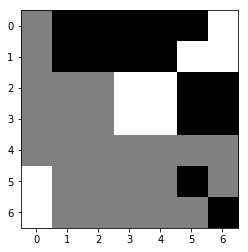

((2, 3), (2, 2)): n_v:  2740 q_all:-0.064442 q:-0.039098 q_m:+0.033333 p:0.207479
((2, 3), (2, 1)): n_v:   511 q_all:-0.149317 q:-0.127939 q_m:-0.066667 p:0.165098
((3, 3), (4, 2)): n_v:   171 q_all:-0.154933 q:-0.126468 q_m:-0.166667 p:0.058113
((3, 4), (4, 5)): n_v:   158 q_all:-0.097159 q:-0.054484 q_m:+0.033333 p:0.027032
((3, 4), (5, 6)): n_v:   148 q_all:-0.119744 q:-0.043783 q_m:-0.066667 p:0.035103
((3, 3), (4, 4)): n_v:   104 q_all:-0.133526 q:-0.097921 q_m:-0.033333 p:0.028995
((3, 3), (5, 1)): n_v:    61 q_all:-0.189601 q:-0.115056 q_m:-0.200000 p:0.027246
((3, 3), (2, 1)): n_v:    56 q_all:-0.155520 q:-0.100835 q_m:-0.066667 p:0.019275
((3, 3), (4, 5)): n_v:    42 q_all:-0.094744 q:-0.074313 q_m:-0.000000 p:0.006827
((5, 0), (4, 1)): n_v:    40 q_all:-0.127826 q:-0.095453 q_m:-0.166667 p:0.010283
((3, 4), (4, 6)): n_v:    40 q_all:-0.104153 q:-0.029138 q_m:-0.000000 p:0.007828
((3, 4), (2, 2)): n_v:    38 q_all:-0.102282 q:-0.103252 q_m:-0.000000 p:0.007100
((2, 4), (2, 2))

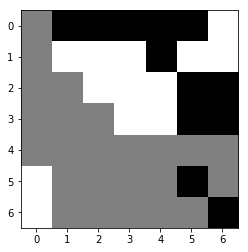

((0, 1), (2, 1)): n_v:  2502 q_all:+0.103138 q:+0.141887 q_m:+0.166667 p:0.285645
((3, 5), (4, 4)): n_v:   399 q_all:+0.108656 q:+0.072637 q_m:+0.133333 p:0.039055
((0, 2), (2, 1)): n_v:   365 q_all:+0.043280 q:+0.109603 q_m:+0.166667 p:0.106808
((0, 1), (1, 0)): n_v:   209 q_all:+0.048316 q:+0.071819 q_m:+0.066667 p:0.058156
((3, 5), (4, 5)): n_v:   154 q_all:+0.012816 q:+0.015946 q_m:+0.066667 p:0.059010
((0, 3), (2, 1)): n_v:   103 q_all:-0.002816 q:+0.076159 q_m:+0.166667 p:0.044399
((6, 6), (4, 4)): n_v:    96 q_all:+0.101388 q:+0.052455 q_m:+0.100000 p:0.011504
((0, 1), (0, 0)): n_v:    58 q_all:+0.011314 q:+0.060378 q_m:+0.066667 p:0.022886
((6, 6), (4, 5)): n_v:    54 q_all:+0.002292 q:+0.013606 q_m:+0.033333 p:0.022717
((1, 4), (3, 2)): n_v:    42 q_all:-0.083159 q:-0.023442 q_m:+0.166667 p:0.028456
((5, 5), (4, 3)): n_v:    40 q_all:+0.047954 q:+0.053053 q_m:+0.100000 p:0.011392
((5, 5), (6, 4)): n_v:    28 q_all:+0.042996 q:+0.038253 q_m:-0.000000 p:0.008330
((3, 6), (4, 4))

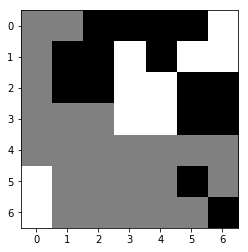

((2, 3), (3, 2)): n_v:  1443 q_all:-0.060695 q:-0.026162 q_m:-0.000000 p:0.203893
((3, 4), (5, 6)): n_v:   842 q_all:-0.015464 q:-0.059288 q_m:-0.033333 p:0.002217
((2, 3), (0, 1)): n_v:   330 q_all:-0.114833 q:-0.105658 q_m:+0.033333 p:0.101458
((1, 3), (0, 1)): n_v:   239 q_all:-0.125554 q:-0.145463 q_m:+0.033333 p:0.081530
((3, 4), (4, 6)): n_v:   194 q_all:-0.021791 q:-0.033649 q_m:+0.033333 p:0.001061
((3, 3), (4, 1)): n_v:   104 q_all:-0.157575 q:-0.111854 q_m:-0.166667 p:0.045738
((3, 4), (4, 5)): n_v:    99 q_all:-0.082404 q:-0.047667 q_m:+0.066667 p:0.020610
((3, 4), (3, 2)): n_v:    98 q_all:-0.104866 q:-0.083756 q_m:-0.033333 p:0.027272
((3, 3), (4, 5)): n_v:    90 q_all:-0.077398 q:-0.055596 q_m:+0.033333 p:0.017380
((3, 3), (3, 1)): n_v:    78 q_all:-0.091450 q:-0.068409 q_m:-0.033333 p:0.018478
((5, 0), (4, 1)): n_v:    52 q_all:-0.147428 q:-0.119124 q_m:-0.133333 p:0.021053
((5, 0), (6, 1)): n_v:    33 q_all:-0.126467 q:-0.105158 q_m:-0.133333 p:0.011177
((5, 0), (3, 2))

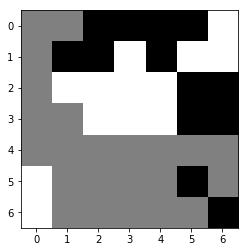

((1, 1), (3, 1)): n_v:  1196 q_all:+0.126708 q:+0.120839 q_m:+0.200000 p:0.203041
((5, 5), (4, 3)): n_v:   649 q_all:+0.093860 q:+0.090459 q_m:+0.200000 p:0.187634
((3, 5), (4, 4)): n_v:   164 q_all:+0.072101 q:+0.053259 q_m:+0.166667 p:0.060610
((1, 1), (2, 0)): n_v:   147 q_all:+0.071504 q:+0.066094 q_m:+0.100000 p:0.054353
((1, 1), (1, 0)): n_v:   111 q_all:+0.091700 q:+0.079230 q_m:+0.100000 p:0.032960
((1, 2), (3, 1)): n_v:    60 q_all:+0.005798 q:+0.077441 q_m:+0.200000 p:0.036207
((3, 5), (4, 3)): n_v:    49 q_all:+0.047042 q:+0.078777 q_m:+0.200000 p:0.022913
((6, 6), (4, 5)): n_v:    40 q_all:+0.003944 q:+0.017226 q_m:+0.066667 p:0.024659
((3, 5), (4, 5)): n_v:    33 q_all:-0.004078 q:+0.014985 q_m:+0.100000 p:0.021609
((6, 6), (4, 4)): n_v:    32 q_all:+0.066515 q:+0.041972 q_m:+0.133333 p:0.012599
((1, 1), (0, 0)): n_v:    30 q_all:-0.021474 q:-0.009035 q_m:+0.033333 p:0.021358
((2, 5), (4, 3)): n_v:    21 q_all:-0.041726 q:-0.002108 q_m:+0.200000 p:0.017004
((5, 5), (6, 4))

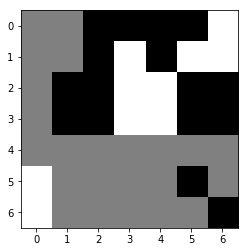

((3, 3), (1, 1)): n_v:   545 q_all:-0.114564 q:-0.056219 q_m:+0.066667 p:0.185471
((2, 3), (1, 1)): n_v:   364 q_all:-0.170255 q:-0.120226 q_m:+0.066667 p:0.200655
((3, 4), (4, 5)): n_v:   297 q_all:-0.093988 q:-0.054496 q_m:+0.033333 p:0.077624
((5, 0), (4, 1)): n_v:   282 q_all:-0.080429 q:-0.080896 q_m:-0.033333 p:0.059467
((5, 0), (5, 1)): n_v:   261 q_all:-0.084904 q:-0.140401 q_m:-0.166667 p:0.059658
((3, 3), (4, 5)): n_v:   188 q_all:-0.101226 q:-0.065574 q_m:-0.000000 p:0.054319
((3, 3), (4, 2)): n_v:   168 q_all:-0.126010 q:-0.106604 q_m:-0.033333 p:0.064293
((3, 3), (4, 4)): n_v:   104 q_all:-0.122856 q:-0.101827 q_m:-0.033333 p:0.038939
((3, 3), (4, 1)): n_v:    94 q_all:-0.185961 q:-0.092971 q_m:-0.066667 p:0.057736
((3, 3), (5, 1)): n_v:    80 q_all:-0.260567 q:-0.134145 q_m:-0.200000 p:0.071492
((5, 0), (4, 0)): n_v:    63 q_all:-0.074625 q:-0.079461 q_m:-0.100000 p:0.011986
((1, 3), (1, 1)): n_v:    60 q_all:-0.133433 q:-0.151444 q_m:+0.066667 p:0.024878
((6, 0), (4, 1))

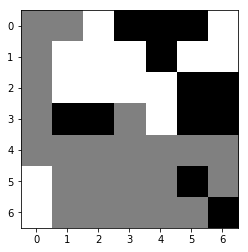

((3, 2), (3, 3)): n_v:  2104 q_all:+0.143250 q:+0.118924 q_m:+0.233333 p:0.877301
((5, 5), (3, 3)): n_v:    74 q_all:+0.116360 q:+0.090357 q_m:+0.200000 p:0.039299
((3, 5), (3, 3)): n_v:    44 q_all:+0.074639 q:+0.063244 q_m:+0.200000 p:0.031162
((3, 1), (3, 3)): n_v:    24 q_all:+0.079973 q:+0.091946 q_m:+0.200000 p:0.016589
((3, 2), (2, 0)): n_v:     9 q_all:+0.053584 q:+0.011064 q_m:+0.066667 p:0.007609
((3, 2), (1, 0)): n_v:     7 q_all:+0.004348 q:+0.006141 q_m:+0.066667 p:0.007034
((1, 4), (3, 3)): n_v:     4 q_all:-0.127209 q:-0.025686 q_m:+0.200000 p:0.007194
((2, 5), (3, 3)): n_v:     3 q_all:-0.100486 q:-0.034351 q_m:+0.200000 p:0.005326
((3, 2), (5, 1)): n_v:     2 q_all:+0.013225 q:+0.003596 q_m:+0.066667 p:0.002456
((3, 1), (1, 0)): n_v:     1 q_all:+0.056011 q:+0.038238 q_m:+0.066667 p:0.001345
((5, 5), (6, 5)): n_v:     0 q_all:-0.023126 q:-0.023126 q_m:-0.033333 p:0.000698
((3, 6), (5, 4)): n_v:     0 q_all:-0.049341 q:-0.049341 q_m:-0.066667 p:0.000028
((6, 6), (6, 4))

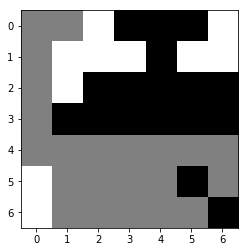

((5, 0), (4, 1)): n_v:  1203 q_all:-0.130456 q:-0.119759 q_m:-0.066667 p:0.279440
((6, 0), (4, 1)): n_v:   690 q_all:-0.147905 q:-0.142260 q_m:-0.100000 p:0.199917
((5, 0), (4, 2)): n_v:   469 q_all:-0.155626 q:-0.105756 q_m:-0.033333 p:0.147976
((6, 0), (4, 2)): n_v:   363 q_all:-0.152749 q:-0.122951 q_m:-0.033333 p:0.110878
((1, 1), (2, 0)): n_v:   173 q_all:-0.095498 q:-0.141492 q_m:-0.133333 p:0.020320
((5, 0), (4, 0)): n_v:   121 q_all:-0.079334 q:-0.111732 q_m:-0.133333 p:0.007762
((5, 0), (5, 1)): n_v:   107 q_all:-0.110726 q:-0.177507 q_m:-0.200000 p:0.017980
((2, 1), (4, 3)): n_v:   101 q_all:-0.124733 q:-0.116000 q_m:-0.033333 p:0.021442
((2, 1), (3, 0)): n_v:    36 q_all:-0.127845 q:-0.170750 q_m:-0.133333 p:0.008229
((1, 1), (1, 0)): n_v:    33 q_all:-0.202058 q:-0.208585 q_m:-0.200000 p:0.015704
((1, 1), (0, 0)): n_v:    32 q_all:-0.170452 q:-0.187793 q_m:-0.200000 p:0.011743
((2, 1), (4, 1)): n_v:    29 q_all:-0.188816 q:-0.136935 q_m:-0.100000 p:0.012646
((2, 1), (0, 1))

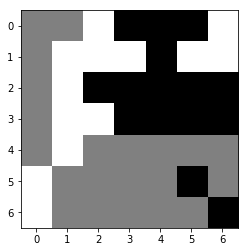

((3, 3), (4, 2)): n_v:  1849 q_all:+0.180621 q:+0.190559 q_m:+0.300000 p:0.303896
((3, 4), (4, 2)): n_v:   348 q_all:+0.145503 q:+0.098895 q_m:+0.266667 p:0.102325
((3, 3), (4, 4)): n_v:   310 q_all:+0.022276 q:+0.030214 q_m:+0.100000 p:0.233442
((2, 3), (0, 1)): n_v:    75 q_all:+0.043391 q:+0.056683 q_m:+0.266667 p:0.051132
((2, 2), (0, 1)): n_v:    46 q_all:+0.159728 q:+0.145886 q_m:+0.266667 p:0.011179
((5, 5), (5, 6)): n_v:    46 q_all:+0.081288 q:+0.041871 q_m:+0.100000 p:0.024925
((3, 3), (5, 1)): n_v:    43 q_all:+0.063238 q:+0.080716 q_m:+0.266667 p:0.025785
((5, 5), (6, 5)): n_v:    27 q_all:+0.089465 q:+0.059677 q_m:+0.100000 p:0.013597
((3, 3), (4, 3)): n_v:     9 q_all:+0.044704 q:+0.033611 q_m:+0.166667 p:0.006469
((2, 6), (4, 4)): n_v:     8 q_all:-0.004864 q:-0.044511 q_m:+0.066667 p:0.007284
((2, 2), (1, 0)): n_v:     7 q_all:+0.055891 q:+0.059384 q_m:+0.200000 p:0.004546
((2, 2), (3, 0)): n_v:     6 q_all:+0.115244 q:+0.084100 q_m:+0.266667 p:0.002407
((2, 2), (4, 0))

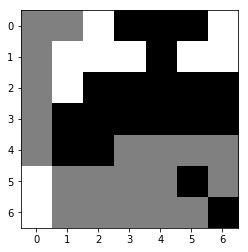

((5, 0), (5, 1)): n_v:  1839 q_all:-0.148698 q:-0.161927 q_m:-0.133333 p:0.238948
((5, 0), (5, 2)): n_v:   417 q_all:-0.172391 q:-0.198343 q_m:-0.166667 p:0.087418
((6, 0), (5, 2)): n_v:   401 q_all:-0.174533 q:-0.187897 q_m:-0.166667 p:0.086771
((2, 1), (4, 3)): n_v:   367 q_all:-0.142336 q:-0.095385 q_m:-0.033333 p:0.039984
((6, 0), (4, 0)): n_v:    84 q_all:-0.232842 q:-0.144912 q_m:-0.166667 p:0.034780
((6, 0), (6, 2)): n_v:    56 q_all:-0.227712 q:-0.183564 q_m:-0.300000 p:0.022242
((5, 0), (4, 0)): n_v:    22 q_all:-0.269219 q:-0.160205 q_m:-0.133333 p:0.012159
((5, 0), (3, 0)): n_v:    21 q_all:-0.226948 q:-0.193143 q_m:-0.166667 p:0.008408
((5, 0), (6, 2)): n_v:    16 q_all:-0.280837 q:-0.212652 q_m:-0.300000 p:0.009151
((1, 1), (2, 0)): n_v:    15 q_all:-0.295462 q:-0.209477 q_m:-0.200000 p:0.009565
((2, 1), (3, 0)): n_v:    11 q_all:-0.220921 q:-0.199391 q_m:-0.133333 p:0.004405
((5, 0), (6, 1)): n_v:     7 q_all:-0.274228 q:-0.188356 q_m:-0.266667 p:0.003809
((2, 1), (0, 1))

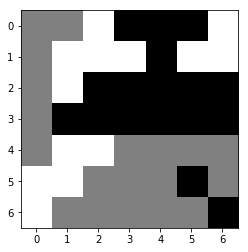

((3, 1), (2, 0)): n_v:  1121 q_all:+0.175284 q:+0.177619 q_m:+0.300000 p:0.282334
((3, 1), (4, 0)): n_v:   941 q_all:+0.243814 q:+0.152675 q_m:+0.366667 p:0.016815
((2, 2), (0, 1)): n_v:   473 q_all:+0.146933 q:+0.181254 q_m:+0.333333 p:0.164943
((5, 5), (6, 5)): n_v:   102 q_all:+0.084687 q:+0.094454 q_m:+0.166667 p:0.057077
((3, 1), (3, 0)): n_v:    98 q_all:+0.177386 q:+0.138397 q_m:+0.300000 p:0.024048
((3, 1), (1, 0)): n_v:    96 q_all:+0.135713 q:+0.120595 q_m:+0.266667 p:0.037474
((0, 3), (0, 1)): n_v:    67 q_all:+0.097246 q:+0.163876 q_m:+0.333333 p:0.034932
((5, 5), (5, 4)): n_v:    65 q_all:+0.075065 q:+0.084691 q_m:+0.166667 p:0.038794
((3, 2), (4, 3)): n_v:    63 q_all:+0.141015 q:+0.134771 q_m:+0.233333 p:0.023449
((2, 3), (0, 1)): n_v:    45 q_all:+0.076377 q:+0.089638 q_m:+0.333333 p:0.026870
((3, 5), (4, 6)): n_v:    39 q_all:+0.115434 q:+0.108999 q_m:+0.166667 p:0.018015
((3, 2), (2, 0)): n_v:    34 q_all:+0.055075 q:+0.070488 q_m:+0.266667 p:0.022864
((3, 3), (5, 2))

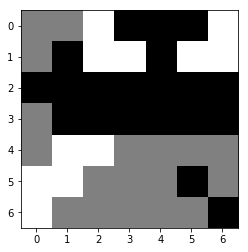

((4, 1), (3, 0)): n_v:   871 q_all:-0.191827 q:-0.177247 q_m:-0.066667 p:0.357919
((4, 2), (3, 0)): n_v:   623 q_all:-0.183144 q:-0.192560 q_m:-0.100000 p:0.235754
((5, 1), (3, 0)): n_v:   378 q_all:-0.190499 q:-0.186170 q_m:-0.100000 p:0.153547
((0, 2), (1, 0)): n_v:   374 q_all:-0.159290 q:-0.141897 q_m:-0.100000 p:0.108332
((4, 2), (4, 4)): n_v:   173 q_all:-0.168888 q:-0.145122 q_m:-0.033333 p:0.056444
((5, 0), (3, 0)): n_v:   105 q_all:-0.195324 q:-0.152263 q_m:-0.100000 p:0.044922
((1, 2), (3, 0)): n_v:    39 q_all:-0.288301 q:-0.277934 q_m:-0.100000 p:0.030262
((4, 2), (4, 3)): n_v:    10 q_all:-0.144344 q:-0.155542 q_m:-0.066667 p:0.002482
((1, 2), (1, 0)): n_v:     5 q_all:-0.232761 q:-0.185632 q_m:-0.100000 p:0.002845
((4, 1), (4, 3)): n_v:     1 q_all:-0.174098 q:-0.153297 q_m:-0.100000 p:0.000385
((0, 2), (0, 1)): n_v:     1 q_all:-0.245193 q:-0.273591 q_m:-0.200000 p:0.000903
((4, 2), (5, 4)): n_v:     1 q_all:-0.190040 q:-0.157363 q_m:-0.233333 p:0.000736
((4, 2), (6, 1))

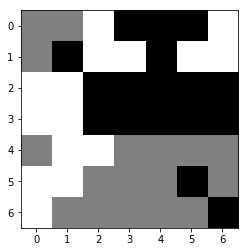

((1, 1), (1, 0)): n_v:  1491 q_all:+0.197133 q:+0.174400 q_m:+0.233333 p:0.470842
((1, 1), (0, 1)): n_v:   698 q_all:+0.202732 q:+0.174239 q_m:+0.233333 p:0.205263
((5, 5), (5, 6)): n_v:    33 q_all:+0.091649 q:-0.001124 q_m:+0.100000 p:0.024254
((6, 6), (4, 6)): n_v:    31 q_all:+0.116092 q:+0.042354 q_m:+0.066667 p:0.019622
((2, 2), (4, 0)): n_v:    28 q_all:+0.134858 q:+0.125943 q_m:+0.400000 p:0.015505
((3, 2), (4, 0)): n_v:    25 q_all:+0.213932 q:+0.114494 q_m:+0.400000 p:0.005945
((3, 2), (1, 0)): n_v:    25 q_all:+0.043596 q:+0.057354 q_m:+0.200000 p:0.023652
((3, 5), (4, 6)): n_v:    22 q_all:+0.120805 q:+0.038684 q_m:+0.100000 p:0.013983
((5, 5), (6, 5)): n_v:    21 q_all:+0.115038 q:+0.026637 q_m:+0.100000 p:0.013513
((2, 2), (1, 0)): n_v:    19 q_all:+0.084350 q:+0.071717 q_m:+0.200000 p:0.015083
((2, 2), (0, 1)): n_v:    18 q_all:+0.090390 q:+0.082989 q_m:+0.200000 p:0.012759
((3, 4), (4, 6)): n_v:    10 q_all:-0.018920 q:-0.066351 q_m:+0.066667 p:0.011231
((1, 1), (0, 0))

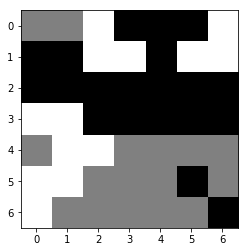

((0, 2), (0, 1)): n_v:  1446 q_all:-0.148574 q:-0.204216 q_m:-0.066667 p:0.130671
((4, 2), (4, 4)): n_v:  1091 q_all:-0.178500 q:-0.190636 q_m:+0.033333 p:0.212651
((1, 3), (0, 1)): n_v:   355 q_all:-0.249387 q:-0.311737 q_m:-0.100000 p:0.157953
((4, 2), (6, 1)): n_v:   111 q_all:-0.280498 q:-0.331582 q_m:-0.233333 p:0.061630
((4, 2), (4, 3)): n_v:    59 q_all:-0.183366 q:-0.166889 q_m:-0.000000 p:0.012570
((3, 1), (4, 3)): n_v:    39 q_all:-0.219638 q:-0.190435 q_m:-0.033333 p:0.013323
((5, 0), (6, 1)): n_v:    15 q_all:-0.323329 q:-0.316147 q_m:-0.200000 p:0.010690
((0, 2), (0, 0)): n_v:    13 q_all:-0.241546 q:-0.205807 q_m:-0.100000 p:0.005297
((4, 1), (6, 1)): n_v:     9 q_all:-0.310241 q:-0.304691 q_m:-0.233333 p:0.006300
((3, 0), (4, 0)): n_v:     7 q_all:-0.322192 q:-0.292422 q_m:-0.200000 p:0.005540
((4, 2), (5, 4)): n_v:     7 q_all:-0.268814 q:-0.204548 q_m:-0.166667 p:0.004045
((4, 1), (4, 3)): n_v:     6 q_all:-0.224618 q:-0.165200 q_m:-0.033333 p:0.002281
((5, 1), (4, 3))

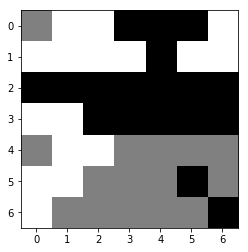

((2, 2), (0, 0)): n_v:  1194 q_all:+0.108095 q:+0.135010 q_m:+0.266667 p:0.381789
((2, 0), (4, 0)): n_v:   607 q_all:+0.173834 q:+0.186786 q_m:+0.400000 p:0.053783
((2, 0), (0, 0)): n_v:   600 q_all:+0.169102 q:+0.205659 q_m:+0.266667 p:0.061783
((2, 2), (4, 0)): n_v:   249 q_all:+0.155135 q:+0.131686 q_m:+0.400000 p:0.038210
((3, 2), (4, 0)): n_v:   139 q_all:+0.113768 q:+0.126458 q_m:+0.400000 p:0.041716
((3, 5), (4, 6)): n_v:    95 q_all:+0.063946 q:+0.061198 q_m:+0.100000 p:0.045466
((6, 6), (4, 6)): n_v:    53 q_all:+0.059249 q:+0.064850 q_m:+0.066667 p:0.026006
((2, 1), (4, 0)): n_v:    52 q_all:+0.061786 q:+0.122096 q_m:+0.400000 p:0.024965
((3, 2), (4, 3)): n_v:    35 q_all:+0.148405 q:+0.086502 q_m:+0.166667 p:0.006367
((2, 1), (0, 0)): n_v:    30 q_all:+0.041436 q:+0.151653 q_m:+0.266667 p:0.016024
((3, 4), (4, 6)): n_v:    17 q_all:+0.009477 q:-0.061013 q_m:+0.066667 p:0.011968
((2, 4), (4, 6)): n_v:    15 q_all:-0.092827 q:-0.145517 q_m:+0.066667 p:0.016058
((2, 6), (4, 6))

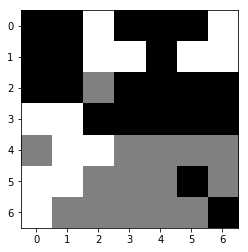

((4, 2), (2, 2)): n_v:  1039 q_all:-0.130061 q:-0.073555 q_m:+0.066667 p:0.167320
((1, 2), (2, 2)): n_v:   662 q_all:-0.142109 q:-0.080150 q_m:+0.100000 p:0.135970
((3, 0), (2, 2)): n_v:   369 q_all:-0.138343 q:-0.054688 q_m:+0.066667 p:0.070855
((4, 1), (2, 2)): n_v:   327 q_all:-0.152490 q:-0.068758 q_m:+0.066667 p:0.079729
((4, 2), (4, 4)): n_v:   298 q_all:-0.207828 q:-0.188862 q_m:-0.000000 p:0.132797
((0, 2), (2, 2)): n_v:   143 q_all:-0.182989 q:-0.162393 q_m:+0.066667 p:0.051016
((4, 2), (6, 1)): n_v:     0 q_all:-0.320420 q:-0.320420 q_m:-0.266667 p:0.000036
((5, 1), (5, 3)): n_v:     0 q_all:-0.288820 q:-0.288820 q_m:-0.266667 p:0.000000
((4, 2), (6, 2)): n_v:     0 q_all:-0.333299 q:-0.333299 q_m:-0.266667 p:0.000008
((4, 1), (6, 1)): n_v:     0 q_all:-0.302126 q:-0.302126 q_m:-0.266667 p:0.000011
((4, 2), (4, 0)): n_v:     0 q_all:-0.318721 q:-0.318721 q_m:-0.266667 p:0.000108
((3, 1), (5, 3)): n_v:     0 q_all:-0.260068 q:-0.260068 q_m:-0.266667 p:0.000013
((3, 1), (5, 2))

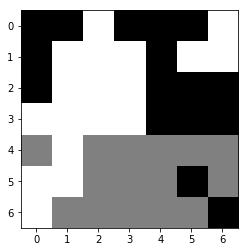

((3, 4), (4, 2)): n_v:  1485 q_all:+0.100251 q:+0.111285 q_m:+0.266667 p:0.727721
((2, 0), (4, 2)): n_v:  1007 q_all:+0.219085 q:+0.155497 q_m:+0.266667 p:0.041306
((2, 4), (4, 2)): n_v:   105 q_all:+0.082811 q:+0.014938 q_m:+0.266667 p:0.057819
((3, 4), (4, 4)): n_v:    35 q_all:-0.008675 q:+0.010363 q_m:+0.033333 p:0.032270
((2, 6), (4, 4)): n_v:    16 q_all:-0.083383 q:-0.083268 q_m:-0.000000 p:0.018436
((6, 6), (4, 6)): n_v:    10 q_all:-0.124143 q:+0.024507 q_m:-0.066667 p:0.013935
((6, 6), (4, 4)): n_v:     9 q_all:-0.038889 q:+0.007885 q_m:-0.000000 p:0.009862
((3, 4), (4, 3)): n_v:     5 q_all:+0.015345 q:+0.027742 q_m:+0.100000 p:0.004414
((3, 6), (4, 4)): n_v:     5 q_all:-0.008635 q:-0.035367 q_m:-0.000000 p:0.005399
((2, 4), (4, 6)): n_v:     4 q_all:-0.204258 q:-0.171797 q_m:-0.066667 p:0.007206
((2, 0), (4, 0)): n_v:     3 q_all:+0.031382 q:+0.115555 q_m:+0.266667 p:0.002158
((3, 4), (4, 6)): n_v:     3 q_all:-0.114221 q:-0.080696 q_m:-0.066667 p:0.004326
((2, 6), (4, 6))

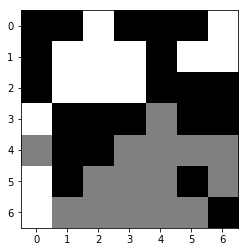

((2, 3), (3, 4)): n_v:  1293 q_all:-0.062367 q:-0.114313 q_m:+0.033333 p:0.186238
((3, 0), (4, 0)): n_v:  1197 q_all:-0.091616 q:-0.182771 q_m:-0.033333 p:0.295363
((6, 0), (4, 0)): n_v:   483 q_all:-0.082096 q:-0.202422 q_m:-0.066667 p:0.103111
((1, 6), (3, 4)): n_v:    25 q_all:-0.225108 q:-0.199274 q_m:-0.000000 p:0.018336
((5, 0), (5, 2)): n_v:    17 q_all:-0.086176 q:-0.151415 q_m:-0.066667 p:0.004059
((6, 0), (5, 2)): n_v:    14 q_all:-0.176072 q:-0.197702 q_m:-0.066667 p:0.007798
((2, 2), (3, 4)): n_v:    11 q_all:-0.218571 q:-0.211597 q_m:-0.000000 p:0.007753
((2, 2), (4, 0)): n_v:     7 q_all:-0.337829 q:-0.257380 q_m:-0.066667 p:0.008072
((1, 2), (3, 4)): n_v:     6 q_all:-0.273522 q:-0.224190 q_m:-0.000000 p:0.006170
((1, 5), (3, 4)): n_v:     5 q_all:-0.289709 q:-0.258793 q_m:-0.000000 p:0.005372
((3, 0), (5, 2)): n_v:     4 q_all:-0.089860 q:-0.188464 q_m:-0.066667 p:0.001131
((1, 3), (3, 4)): n_v:     3 q_all:-0.297621 q:-0.257823 q_m:-0.000000 p:0.002796
((2, 2), (4, 3))

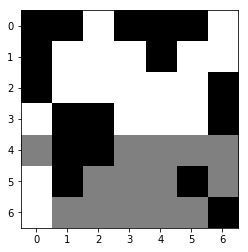

((3, 1), (4, 0)): n_v:  1740 q_all:+0.077156 q:+0.032286 q_m:+0.133333 p:0.123973
((5, 5), (4, 4)): n_v:   211 q_all:+0.020806 q:+0.077238 q_m:+0.200000 p:0.057955
((3, 6), (4, 6)): n_v:   165 q_all:-0.063209 q:-0.048057 q_m:+0.066667 p:0.095357
((4, 2), (4, 4)): n_v:   158 q_all:+0.016979 q:+0.035039 q_m:+0.166667 p:0.045782
((3, 2), (4, 4)): n_v:   124 q_all:+0.048631 q:+0.031963 q_m:+0.166667 p:0.021635
((3, 2), (4, 3)): n_v:    62 q_all:-0.029312 q:-0.060085 q_m:+0.133333 p:0.028664
((4, 2), (4, 0)): n_v:    59 q_all:+0.046736 q:+0.010086 q_m:+0.100000 p:0.010493
((3, 2), (4, 0)): n_v:    52 q_all:-0.007770 q:-0.024334 q_m:+0.100000 p:0.019806
((2, 6), (4, 4)): n_v:    46 q_all:+0.047002 q:+0.028554 q_m:+0.166667 p:0.008398
((5, 1), (6, 1)): n_v:    37 q_all:+0.006932 q:+0.013051 q_m:+0.133333 p:0.012230
((5, 5), (6, 5)): n_v:    26 q_all:-0.044426 q:-0.050944 q_m:-0.000000 p:0.013632
((6, 6), (4, 6)): n_v:    20 q_all:-0.064583 q:-0.046878 q_m:+0.033333 p:0.011504
((3, 6), (4, 4))

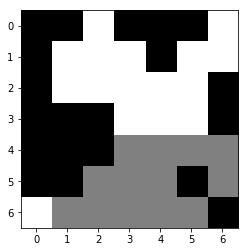

((6, 0), (6, 1)): n_v:  2577 q_all:-0.055741 q:-0.079550 q_m:+0.033333 p:0.389902
((3, 4), (4, 5)): n_v:   309 q_all:-0.176235 q:-0.153252 q_m:+0.033333 p:0.172738
((6, 0), (5, 2)): n_v:   147 q_all:-0.121968 q:-0.128661 q_m:+0.066667 p:0.055498
((3, 3), (4, 3)): n_v:   105 q_all:-0.125641 q:-0.086808 q_m:+0.033333 p:0.040412
((3, 3), (5, 4)): n_v:    58 q_all:-0.250433 q:-0.209776 q_m:-0.066667 p:0.047684
((3, 3), (5, 2)): n_v:    48 q_all:-0.219835 q:-0.202125 q_m:+0.066667 p:0.034260
((3, 5), (4, 6)): n_v:    38 q_all:-0.152347 q:-0.079554 q_m:+0.033333 p:0.018157
((3, 4), (5, 2)): n_v:    27 q_all:-0.213679 q:-0.228585 q_m:+0.066667 p:0.019130
((3, 3), (4, 5)): n_v:    14 q_all:-0.217012 q:-0.215178 q_m:-0.000000 p:0.010082
((3, 5), (5, 6)): n_v:    12 q_all:-0.176963 q:-0.132976 q_m:-0.000000 p:0.007196
((3, 4), (5, 6)): n_v:     9 q_all:-0.193259 q:-0.201676 q_m:-0.000000 p:0.005876
((2, 3), (4, 5)): n_v:     5 q_all:-0.340585 q:-0.297373 q_m:-0.000000 p:0.005635
((3, 3), (4, 4))

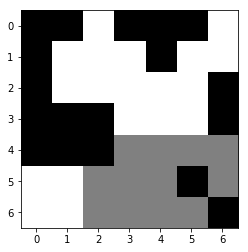

((5, 5), (4, 4)): n_v:   998 q_all:+0.100274 q:+0.133533 q_m:+0.200000 p:0.065524
((4, 1), (5, 2)): n_v:   672 q_all:+0.057821 q:-0.002447 q_m:+0.133333 p:0.131187
((5, 5), (6, 4)): n_v:   466 q_all:+0.004195 q:-0.016984 q_m:-0.000000 p:0.167050
((5, 5), (5, 6)): n_v:   352 q_all:+0.114937 q:-0.089486 q_m:-0.000000 p:0.007398
((4, 2), (4, 4)): n_v:   181 q_all:+0.070950 q:+0.092579 q_m:+0.166667 p:0.028227
((3, 2), (4, 4)): n_v:   175 q_all:+0.084544 q:+0.073728 q_m:+0.166667 p:0.019918
((5, 5), (5, 4)): n_v:   160 q_all:+0.014137 q:-0.015433 q_m:-0.000000 p:0.052542
((3, 2), (4, 3)): n_v:   142 q_all:+0.066094 q:+0.039982 q_m:+0.133333 p:0.024157
((5, 5), (6, 5)): n_v:   136 q_all:+0.090922 q:-0.003157 q_m:-0.000000 p:0.012919
((6, 6), (4, 4)): n_v:   136 q_all:+0.117118 q:+0.117918 q_m:+0.166667 p:0.001833
((3, 6), (5, 4)): n_v:    99 q_all:+0.034680 q:+0.011487 q_m:-0.033333 p:0.026472
((3, 6), (5, 6)): n_v:    86 q_all:+0.028917 q:-0.050970 q_m:-0.033333 p:0.024364
((3, 6), (4, 4))

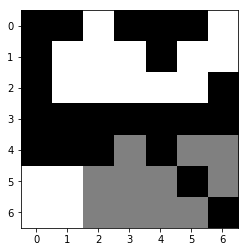

((6, 1), (4, 3)): n_v:  1285 q_all:+0.001302 q:-0.040015 q_m:+0.133333 p:0.176048
((2, 3), (4, 5)): n_v:   579 q_all:-0.153642 q:-0.142648 q_m:+0.133333 p:0.421150
((5, 1), (4, 3)): n_v:   351 q_all:-0.094980 q:-0.085852 q_m:+0.133333 p:0.176970
((2, 5), (4, 3)): n_v:   103 q_all:-0.111893 q:-0.112485 q_m:+0.133333 p:0.058750
((2, 1), (4, 3)): n_v:    57 q_all:-0.146260 q:-0.129709 q_m:+0.133333 p:0.039927
((2, 4), (4, 5)): n_v:    51 q_all:-0.229488 q:-0.204473 q_m:+0.133333 p:0.052421
((2, 5), (4, 5)): n_v:    34 q_all:-0.234744 q:-0.154802 q_m:+0.133333 p:0.035945
((5, 1), (5, 2)): n_v:    24 q_all:-0.048684 q:-0.077618 q_m:-0.033333 p:0.007935
((2, 2), (4, 3)): n_v:     5 q_all:-0.257641 q:-0.142452 q_m:+0.133333 p:0.006069
((2, 4), (4, 3)): n_v:     4 q_all:-0.271557 q:-0.214122 q_m:+0.133333 p:0.005119
((6, 0), (5, 2)): n_v:     3 q_all:-0.096172 q:-0.133219 q_m:-0.066667 p:0.001646
((2, 3), (4, 3)): n_v:     1 q_all:-0.234984 q:-0.184766 q_m:+0.133333 p:0.001137
((5, 1), (6, 2))

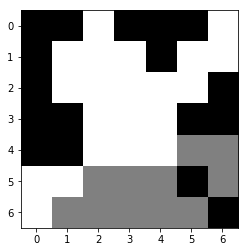

((3, 5), (4, 5)): n_v:  1131 q_all:-0.040280 q:-0.034807 q_m:+0.033333 p:0.193997
((4, 1), (5, 2)): n_v:   669 q_all:-0.033752 q:-0.069452 q_m:+0.100000 p:0.098718
((6, 6), (4, 5)): n_v:   225 q_all:-0.059359 q:-0.060668 q_m:-0.000000 p:0.054096
((4, 0), (6, 1)): n_v:   201 q_all:-0.015491 q:-0.051996 q_m:+0.066667 p:0.016222
((5, 5), (6, 5)): n_v:   179 q_all:-0.130846 q:-0.128443 q_m:-0.100000 p:0.089781
((5, 5), (5, 4)): n_v:   106 q_all:-0.134485 q:-0.049697 q_m:+0.033333 p:0.053837
((5, 5), (5, 3)): n_v:    73 q_all:-0.135727 q:-0.002100 q_m:+0.066667 p:0.037678
((3, 6), (5, 4)): n_v:    63 q_all:-0.102269 q:-0.029744 q_m:-0.000000 p:0.024862
((5, 5), (6, 4)): n_v:    61 q_all:-0.136946 q:-0.145497 q_m:-0.100000 p:0.031957
((6, 6), (5, 4)): n_v:    49 q_all:-0.206444 q:-0.085381 q_m:-0.000000 p:0.038026
((2, 6), (4, 5)): n_v:    43 q_all:-0.056430 q:-0.078541 q_m:-0.000000 p:0.010008
((3, 5), (5, 3)): n_v:    23 q_all:-0.058016 q:-0.020126 q_m:+0.066667 p:0.005012
((4, 0), (5, 2))

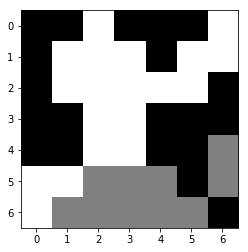

((4, 3), (5, 4)): n_v:  2533 q_all:-0.014063 q:-0.033891 q_m:+0.200000 p:0.483540
((4, 2), (5, 2)): n_v:   180 q_all:-0.128654 q:-0.107712 q_m:+0.066667 p:0.111649
((4, 2), (5, 4)): n_v:    69 q_all:-0.069732 q:-0.034867 q_m:+0.166667 p:0.027798
((6, 0), (5, 2)): n_v:    25 q_all:-0.106360 q:-0.069179 q_m:+0.033333 p:0.013841
((3, 3), (5, 4)): n_v:    15 q_all:-0.204089 q:-0.104312 q_m:+0.166667 p:0.013305
((4, 3), (6, 5)): n_v:     6 q_all:-0.051603 q:+0.025959 q_m:+0.100000 p:0.002299
((2, 4), (4, 6)): n_v:     6 q_all:-0.243215 q:-0.144106 q_m:+0.233333 p:0.007026
((3, 2), (5, 4)): n_v:     5 q_all:-0.198726 q:-0.118244 q_m:+0.166667 p:0.004814
((5, 0), (5, 2)): n_v:     5 q_all:-0.148067 q:-0.147431 q_m:+0.033333 p:0.003924
((3, 3), (5, 2)): n_v:     4 q_all:-0.245862 q:-0.167417 q_m:+0.033333 p:0.004828
((2, 5), (4, 6)): n_v:     3 q_all:-0.227397 q:-0.081784 q_m:+0.233333 p:0.002494
((4, 2), (6, 1)): n_v:     1 q_all:-0.156874 q:-0.136260 q_m:-0.033333 p:0.000695
((4, 3), (6, 1))

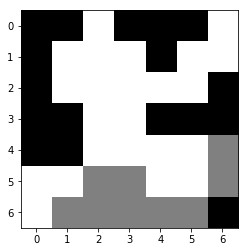

((6, 6), (6, 5)): n_v:  1678 q_all:-0.060349 q:-0.122409 q_m:-0.033333 p:0.669522
((3, 4), (5, 2)): n_v:  1551 q_all:+0.068682 q:-0.177565 q_m:-0.000000 p:0.007976
((3, 4), (5, 3)): n_v:   177 q_all:+0.043192 q:-0.130973 q_m:+0.066667 p:0.014733
((4, 0), (6, 1)): n_v:   116 q_all:-0.072951 q:-0.166472 q_m:-0.000000 p:0.051050
((6, 6), (5, 6)): n_v:    66 q_all:-0.108018 q:-0.157514 q_m:-0.033333 p:0.035940
((6, 6), (6, 4)): n_v:    52 q_all:-0.141232 q:-0.165386 q_m:-0.066667 p:0.034200
((4, 1), (5, 2)): n_v:    48 q_all:-0.061917 q:-0.140123 q_m:+0.033333 p:0.019705
((4, 1), (5, 3)): n_v:    43 q_all:-0.161075 q:-0.089266 q_m:+0.066667 p:0.030230
((3, 1), (5, 3)): n_v:    41 q_all:-0.213424 q:-0.109451 q_m:+0.066667 p:0.035463
((3, 5), (4, 6)): n_v:    40 q_all:-0.096046 q:-0.046007 q_m:-0.033333 p:0.020435
((6, 6), (4, 6)): n_v:    32 q_all:-0.033236 q:-0.041309 q_m:-0.066667 p:0.010329
((3, 6), (5, 6)): n_v:    18 q_all:-0.167691 q:-0.146622 q_m:-0.066667 p:0.013177
((3, 5), (5, 3))

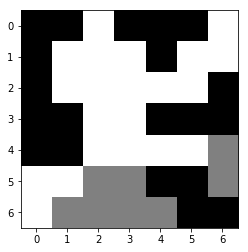

((4, 5), (5, 6)): n_v:  2192 q_all:-0.001947 q:+0.078983 q_m:+0.266667 p:0.793494
((4, 4), (5, 6)): n_v:   508 q_all:+0.039163 q:+0.037584 q_m:+0.233333 p:0.112615
((4, 5), (4, 6)): n_v:   128 q_all:+0.027601 q:+0.091623 q_m:+0.266667 p:0.033427
((4, 4), (4, 6)): n_v:    56 q_all:+0.084726 q:+0.004762 q_m:+0.233333 p:0.004298
((4, 3), (6, 4)): n_v:    53 q_all:+0.065691 q:-0.058522 q_m:+0.233333 p:0.007036
((4, 5), (6, 4)): n_v:    43 q_all:+0.097420 q:+0.009248 q_m:+0.233333 p:0.000914
((4, 2), (6, 4)): n_v:    24 q_all:+0.014890 q:-0.031862 q_m:+0.233333 p:0.007145
((5, 1), (6, 2)): n_v:     9 q_all:-0.091282 q:-0.217238 q_m:+0.066667 p:0.006428
((4, 4), (6, 4)): n_v:     6 q_all:-0.002407 q:-0.025490 q_m:+0.233333 p:0.002421
((6, 0), (6, 2)): n_v:     5 q_all:-0.116306 q:-0.203675 q_m:+0.033333 p:0.003718
((4, 4), (6, 2)): n_v:     5 q_all:-0.145249 q:-0.194252 q_m:+0.033333 p:0.005019
((4, 2), (5, 3)): n_v:     4 q_all:-0.064113 q:-0.085930 q_m:+0.133333 p:0.002121
((4, 3), (6, 2))

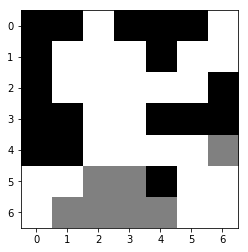

((3, 5), (4, 6)): n_v:  3280 q_all:+0.080375 q:+0.021894 q_m:-0.033333 p:0.340106
((5, 4), (5, 2)): n_v:   113 q_all:-0.145892 q:-0.219937 q_m:-0.066667 p:0.092968
((5, 4), (4, 6)): n_v:    90 q_all:-0.065043 q:-0.101988 q_m:-0.066667 p:0.050777
((2, 6), (4, 6)): n_v:    56 q_all:-0.157270 q:-0.139260 q_m:-0.066667 p:0.047994
((5, 4), (5, 3)): n_v:    44 q_all:-0.208185 q:-0.171394 q_m:-0.033333 p:0.045311
((3, 4), (4, 6)): n_v:    29 q_all:-0.144999 q:-0.219636 q_m:-0.066667 p:0.023683
((3, 4), (5, 2)): n_v:    14 q_all:+0.035399 q:-0.292296 q_m:-0.066667 p:0.003254
((5, 4), (6, 4)): n_v:     9 q_all:-0.205153 q:-0.212837 q_m:-0.100000 p:0.009949
((3, 0), (5, 2)): n_v:     3 q_all:-0.269335 q:-0.298989 q_m:-0.066667 p:0.004020
((3, 4), (5, 3)): n_v:     3 q_all:-0.077865 q:-0.286222 q_m:-0.066667 p:0.002330
((4, 1), (5, 2)): n_v:     3 q_all:-0.224675 q:-0.215187 q_m:-0.033333 p:0.003328
((4, 1), (5, 3)): n_v:     2 q_all:-0.259291 q:-0.212835 q_m:-0.066667 p:0.002970
((5, 4), (6, 2))

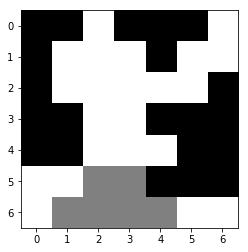

((6, 5), (6, 4)): n_v:  3537 q_all:-0.011588 q:-0.006675 q_m:+0.200000 p:0.381907
((5, 1), (6, 2)): n_v:   186 q_all:-0.202972 q:-0.234685 q_m:+0.066667 p:0.120741
((6, 6), (6, 4)): n_v:   173 q_all:-0.096781 q:-0.094902 q_m:+0.166667 p:0.057310
((4, 3), (6, 4)): n_v:   131 q_all:-0.113902 q:-0.051455 q_m:+0.166667 p:0.051614
((4, 2), (6, 4)): n_v:    78 q_all:-0.111376 q:-0.079682 q_m:+0.166667 p:0.030079
((4, 2), (5, 2)): n_v:    52 q_all:-0.221881 q:-0.126702 q_m:+0.133333 p:0.036950
((4, 4), (6, 4)): n_v:    43 q_all:-0.113801 q:-0.042825 q_m:+0.166667 p:0.016644
((5, 0), (6, 1)): n_v:    42 q_all:-0.129261 q:-0.123114 q_m:+0.066667 p:0.018617
((6, 0), (6, 2)): n_v:    36 q_all:-0.214087 q:-0.215504 q_m:+0.033333 p:0.024437
((4, 4), (6, 2)): n_v:    36 q_all:-0.180623 q:-0.194178 q_m:+0.033333 p:0.021428
((5, 0), (6, 2)): n_v:    26 q_all:-0.210930 q:-0.211814 q_m:+0.033333 p:0.017799
((4, 2), (5, 3)): n_v:    25 q_all:-0.184400 q:-0.111005 q_m:+0.133333 p:0.014075
((4, 4), (5, 2))

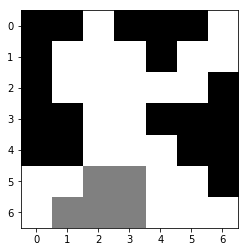

((4, 1), (5, 3)): n_v:  3007 q_all:+0.091827 q:+0.171530 q_m:+0.133333 p:0.255724
((3, 4), (5, 3)): n_v:   618 q_all:-0.021528 q:-0.047727 q_m:+0.133333 p:0.244950
((3, 1), (5, 3)): n_v:   609 q_all:-0.059641 q:+0.082431 q_m:+0.133333 p:0.305421
((3, 4), (5, 2)): n_v:   163 q_all:+0.117428 q:-0.274936 q_m:-0.000000 p:0.001946
((4, 5), (5, 3)): n_v:    86 q_all:-0.165176 q:+0.005631 q_m:+0.133333 p:0.067814
((4, 0), (6, 1)): n_v:    66 q_all:-0.073927 q:-0.109220 q_m:-0.000000 p:0.035948
((3, 5), (5, 3)): n_v:    37 q_all:-0.243291 q:-0.114523 q_m:+0.133333 p:0.038148
((4, 1), (5, 2)): n_v:    29 q_all:-0.048207 q:+0.008481 q_m:+0.033333 p:0.013039
((4, 0), (6, 2)): n_v:    11 q_all:-0.405960 q:-0.371826 q_m:-0.133333 p:0.017276
((3, 0), (5, 2)): n_v:     6 q_all:-0.207932 q:-0.125788 q_m:-0.000000 p:0.006128
((4, 0), (5, 2)): n_v:     4 q_all:-0.168528 q:-0.060100 q_m:-0.000000 p:0.003604
((4, 1), (6, 1)): n_v:     3 q_all:-0.154258 q:-0.076891 q_m:-0.000000 p:0.002558
((4, 1), (6, 2))

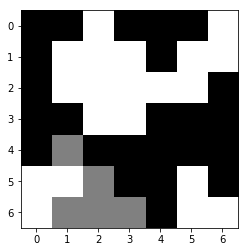

((5, 1), (6, 3)): n_v:  1908 q_all:+0.021869 q:-0.103355 q_m:+0.066667 p:0.005026
((3, 2), (4, 1)): n_v:  1703 q_all:-0.073337 q:-0.012499 q_m:+0.166667 p:0.339252
((6, 0), (4, 1)): n_v:   574 q_all:-0.075309 q:+0.017728 q_m:+0.133333 p:0.118582
((3, 3), (4, 1)): n_v:    12 q_all:-0.266731 q:-0.190010 q_m:+0.133333 p:0.010598
((5, 1), (5, 2)): n_v:     9 q_all:-0.301764 q:-0.157055 q_m:+0.100000 p:0.007656
((6, 0), (5, 2)): n_v:     4 q_all:-0.321242 q:-0.148395 q_m:+0.066667 p:0.003658
((2, 3), (4, 1)): n_v:     4 q_all:-0.405853 q:-0.327674 q_m:+0.133333 p:0.005252
((5, 0), (5, 2)): n_v:     2 q_all:-0.250665 q:-0.165588 q_m:+0.066667 p:0.001774
((2, 1), (4, 1)): n_v:     1 q_all:-0.450171 q:-0.316216 q_m:+0.133333 p:0.001347
((5, 5), (6, 3)): n_v:     1 q_all:-0.317815 q:-0.266617 q_m:+0.066667 p:0.001473
((2, 2), (4, 1)): n_v:     1 q_all:-0.363447 q:-0.285658 q_m:+0.133333 p:0.001494
((6, 5), (6, 3)): n_v:     1 q_all:-0.318639 q:-0.273275 q_m:+0.066667 p:0.001163
((5, 1), (6, 2))

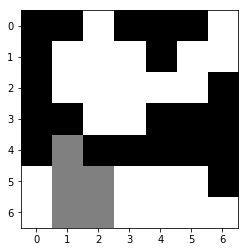

((3, 1), (5, 1)): n_v:  1853 q_all:+0.017288 q:+0.018821 q_m:+0.066667 p:0.145498
((3, 0), (4, 1)): n_v:   402 q_all:-0.025149 q:+0.099712 q_m:+0.100000 p:0.085930
((3, 0), (5, 1)): n_v:   336 q_all:-0.052154 q:+0.038687 q_m:+0.066667 p:0.103458
((4, 2), (5, 2)): n_v:   222 q_all:-0.005777 q:-0.509219 q_m:+0.100000 p:0.034251
((4, 0), (5, 1)): n_v:   199 q_all:-0.111251 q:+0.045342 q_m:+0.100000 p:0.100458
((4, 0), (6, 1)): n_v:   190 q_all:+0.030091 q:-0.025128 q_m:+0.066667 p:0.005846
((4, 3), (5, 1)): n_v:   105 q_all:-0.109113 q:-0.092582 q_m:+0.066667 p:0.052531
((4, 2), (6, 1)): n_v:   101 q_all:+0.009470 q:-0.014232 q_m:+0.066667 p:0.010479
((4, 2), (6, 2)): n_v:    69 q_all:-0.082873 q:-0.333984 q_m:+0.066667 p:0.027524
((3, 1), (5, 2)): n_v:    49 q_all:-0.039312 q:-0.313309 q_m:+0.066667 p:0.012133
((4, 0), (5, 2)): n_v:    43 q_all:+0.002859 q:-0.444022 q_m:+0.066667 p:0.005336
((3, 0), (5, 2)): n_v:    30 q_all:-0.057750 q:-0.500845 q_m:+0.066667 p:0.009809
((2, 0), (4, 1))

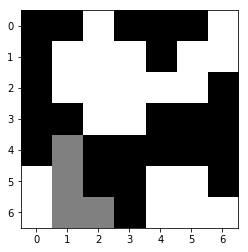

((6, 0), (6, 2)): n_v:  1100 q_all:+0.032435 q:+0.002664 q_m:+0.100000 p:0.005721
((6, 0), (4, 1)): n_v:   630 q_all:-0.135286 q:+0.206314 q_m:+0.233333 p:0.479404
((5, 0), (6, 2)): n_v:   150 q_all:+0.029338 q:+0.018742 q_m:+0.100000 p:0.002503
((3, 2), (4, 1)): n_v:    90 q_all:-0.284668 q:+0.237182 q_m:+0.266667 p:0.127785
((5, 0), (5, 1)): n_v:     6 q_all:-0.687868 q:-0.120999 q_m:+0.133333 p:0.018857
((3, 3), (4, 1)): n_v:     2 q_all:-0.181213 q:-0.075340 q_m:+0.233333 p:0.002473
((2, 2), (4, 1)): n_v:     1 q_all:-0.157897 q:-0.111446 q_m:+0.233333 p:0.000793
((2, 3), (4, 1)): n_v:     1 q_all:-0.284337 q:-0.166931 q_m:+0.233333 p:0.001383
((2, 1), (4, 1)): n_v:     0 q_all:-0.169032 q:-0.169032 q_m:+0.233333 p:0.000528
((5, 4), (6, 2)): n_v:     0 q_all:-0.199238 q:-0.199238 q_m:+0.100000 p:0.000015
((3, 3), (5, 1)): n_v:     0 q_all:-0.353632 q:-0.353632 q_m:+0.100000 p:0.000420
((3, 2), (5, 1)): n_v:     0 q_all:-0.301760 q:-0.301760 q_m:+0.100000 p:0.000241
((5, 0), (6, 1))

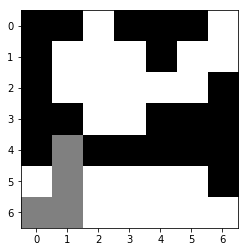

((4, 0), (6, 1)): n_v:  1795 q_all:-0.019943 q:-0.623221 q_m:+0.100000 p:0.005053
((3, 1), (5, 1)): n_v:   700 q_all:-0.095561 q:-0.356460 q_m:+0.100000 p:0.199918
((3, 0), (5, 1)): n_v:   142 q_all:-0.257454 q:-0.234800 q_m:+0.100000 p:0.126733
((4, 0), (5, 1)): n_v:    79 q_all:-0.472410 q:-0.135518 q_m:+0.133333 p:0.134329
((3, 0), (4, 1)): n_v:    68 q_all:-0.269583 q:+0.039828 q_m:+0.133333 p:0.064045
((4, 3), (5, 1)): n_v:    44 q_all:-0.350390 q:-0.358346 q_m:+0.100000 p:0.053780
((4, 2), (6, 1)): n_v:    14 q_all:-0.085053 q:-0.504666 q_m:+0.100000 p:0.003561
((2, 0), (4, 1)): n_v:     8 q_all:-0.290299 q:-0.130635 q_m:+0.100000 p:0.009043
((4, 3), (4, 1)): n_v:     6 q_all:-0.186402 q:-0.192636 q_m:+0.100000 p:0.004259
((4, 2), (6, 0)): n_v:     3 q_all:-0.367927 q:-0.635859 q_m:-0.033333 p:0.004306
((4, 3), (6, 1)): n_v:     1 q_all:-0.582459 q:-0.672730 q_m:+0.100000 p:0.003668
((4, 0), (6, 0)): n_v:     0 q_all:-0.626408 q:-0.626408 q_m:-0.033333 p:0.001793
1 's turn
one mo

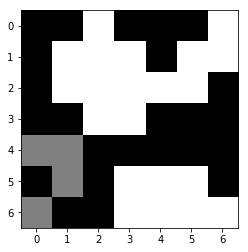

((3, 3), (5, 1)): n_v:  1849 q_all:+0.203824 q:+0.012037 q_m:+0.233333 p:0.063156
((3, 2), (4, 1)): n_v:  1156 q_all:+0.029970 q:-0.372962 q_m:+0.266667 p:0.574354
((6, 3), (5, 1)): n_v:   261 q_all:+0.001157 q:+0.024952 q_m:+0.233333 p:0.165203
((3, 2), (5, 1)): n_v:   172 q_all:+0.055411 q:+0.054552 q_m:+0.233333 p:0.065165
((6, 3), (4, 1)): n_v:    47 q_all:-0.206549 q:-0.375802 q_m:+0.233333 p:0.066375
((5, 3), (4, 1)): n_v:    39 q_all:+0.059694 q:-0.604592 q_m:+0.233333 p:0.013824
((5, 3), (5, 1)): n_v:    14 q_all:-0.141034 q:-0.270121 q_m:+0.233333 p:0.017228
((3, 3), (4, 1)): n_v:     7 q_all:-0.197065 q:-0.442881 q_m:+0.233333 p:0.010592
((2, 2), (4, 1)): n_v:     5 q_all:-0.317784 q:-0.314692 q_m:+0.233333 p:0.009868
((2, 3), (4, 1)): n_v:     3 q_all:-0.421049 q:-0.479969 q_m:+0.233333 p:0.007239
((2, 1), (4, 1)): n_v:     2 q_all:-0.432903 q:-0.536398 q_m:+0.233333 p:0.006487
((2, 1), (4, 0)): n_v:     0 q_all:-0.339911 q:-0.339911 q_m:+0.100000 p:0.000014
((3, 2), (4, 0))

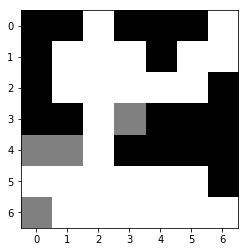

((3, 4), (3, 3)): n_v:  2170 q_all:+0.176467 q:+0.003700 q_m:+0.133333 p:0.339681
((4, 3), (4, 1)): n_v:  1315 q_all:-0.165634 q:-0.323303 q_m:+0.100000 p:0.012257
((3, 1), (3, 3)): n_v:    28 q_all:-0.232420 q:-0.152120 q_m:+0.100000 p:0.008963
((3, 0), (4, 1)): n_v:    12 q_all:-0.357737 q:-0.575798 q_m:+0.133333 p:0.011025
((4, 5), (3, 3)): n_v:     9 q_all:-0.382231 q:-0.022182 q_m:+0.100000 p:0.009088
((3, 5), (3, 3)): n_v:     4 q_all:-0.469033 q:-0.310211 q_m:+0.100000 p:0.006172
((1, 4), (3, 3)): n_v:     3 q_all:-0.413029 q:-0.333105 q_m:+0.100000 p:0.003670
((2, 0), (4, 1)): n_v:     1 q_all:-0.531029 q:-0.297093 q_m:+0.100000 p:0.001428
((3, 0), (4, 0)): n_v:     0 q_all:-0.484088 q:-0.484088 q_m:-0.066667 p:0.000248
((2, 0), (4, 0)): n_v:     0 q_all:-0.464232 q:-0.464232 q_m:-0.100000 p:0.000006
1 's turn


This is a random move


one move takes time(s):  0.1059422492980957
train_mode is both train
no. of data collected:  8


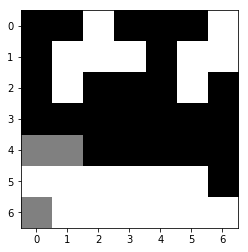

((5, 0), (4, 1)): n_v:  2761 q_all:-0.309710 q:+0.387486 q_m:+0.166667 p:0.374427
((6, 1), (4, 1)): n_v:  1060 q_all:-0.238254 q:+0.171287 q_m:+0.133333 p:0.028184
((6, 2), (4, 1)): n_v:    34 q_all:-0.504887 q:-0.088869 q_m:+0.133333 p:0.028319
((6, 3), (4, 1)): n_v:    26 q_all:-0.421408 q:-0.022309 q_m:+0.133333 p:0.013732
((2, 1), (4, 1)): n_v:     8 q_all:-0.500537 q:-0.121108 q_m:+0.133333 p:0.007198
((5, 0), (4, 0)): n_v:     3 q_all:-0.677284 q:-0.331988 q_m:+0.033333 p:0.004368
((5, 0), (6, 0)): n_v:     1 q_all:-0.473773 q:-0.324991 q_m:-0.100000 p:0.000272
((5, 3), (4, 1)): n_v:     1 q_all:-0.781314 q:-0.663559 q_m:+0.133333 p:0.002659
((6, 1), (4, 0)): n_v:     0 q_all:-0.434867 q:-0.434867 q_m:-0.000000 p:0.000216
((6, 2), (4, 0)): n_v:     0 q_all:-0.423828 q:-0.423828 q_m:-0.000000 p:0.000068
((5, 2), (4, 0)): n_v:     0 q_all:-0.679940 q:-0.679940 q_m:-0.000000 p:0.000011
((2, 1), (4, 0)): n_v:     0 q_all:-0.427795 q:-0.427795 q_m:-0.000000 p:0.000006
((6, 2), (6, 0))

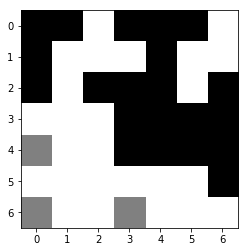

((2, 0), (4, 0)): n_v:  1696 q_all:+0.528454 q:+0.508905 q_m:+0.200000 p:0.882706
((2, 2), (4, 0)): n_v:    84 q_all:+0.391744 q:+0.347079 q_m:+0.200000 p:0.099202
((4, 4), (6, 3)): n_v:     3 q_all:-0.051047 q:-0.249545 q_m:+0.200000 p:0.010924
((4, 5), (6, 3)): n_v:     1 q_all:-0.204156 q:-0.025190 q_m:+0.200000 p:0.006535
((4, 3), (6, 3)): n_v:     0 q_all:-0.127950 q:-0.127950 q_m:+0.200000 p:0.000500
1 's turn
one move takes time(s):  0.15014028549194336
train_mode is both train
no. of data collected:  8


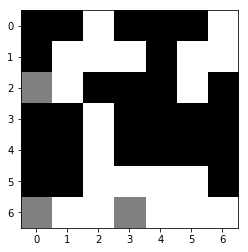

((0, 2), (2, 0)): n_v:  1808 q_all:-0.641827 q:-0.574886 q_m:-0.000000 p:0.132831
((1, 1), (2, 0)): n_v:   995 q_all:-0.688299 q:-0.360549 q_m:+0.033333 p:0.236867
((3, 2), (2, 0)): n_v:   384 q_all:-0.606586 q:-0.622322 q_m:-0.000000 p:0.045232
((4, 2), (2, 0)): n_v:   128 q_all:-0.864950 q:-0.486774 q_m:-0.000000 p:0.110209
((1, 2), (2, 0)): n_v:   108 q_all:-0.710672 q:-0.436881 q_m:-0.000000 p:0.033932
((6, 2), (6, 0)): n_v:    10 q_all:-0.789707 q:-0.520079 q_m:-0.066667 p:0.005544
((6, 1), (6, 0)): n_v:     8 q_all:-0.857173 q:-0.618743 q_m:-0.033333 p:0.006901
((4, 2), (6, 0)): n_v:     5 q_all:-0.860534 q:-0.551275 q_m:-0.066667 p:0.004236
((5, 2), (6, 0)): n_v:     1 q_all:-0.806993 q:-0.656397 q_m:-0.066667 p:0.000373
((4, 2), (6, 3)): n_v:     0 q_all:-0.707704 q:-0.707704 q_m:-0.200000 p:0.000129
((5, 5), (6, 3)): n_v:     0 q_all:-0.909108 q:-0.909108 q_m:-0.200000 p:0.000155
((5, 2), (6, 3)): n_v:     0 q_all:-0.876097 q:-0.876097 q_m:-0.166667 p:0.000253
((6, 1), (6, 3))

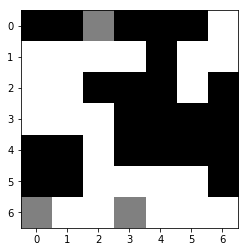

((0, 1), (0, 2)): n_v:  1979 q_all:+0.658916 q:+0.508054 q_m:+0.233333 p:0.321939
((5, 0), (6, 0)): n_v:  1477 q_all:+0.713586 q:+0.206279 q_m:+0.100000 p:0.036350
((0, 4), (0, 2)): n_v:    66 q_all:+0.347219 q:+0.362660 q_m:+0.200000 p:0.083058
((0, 0), (0, 2)): n_v:    13 q_all:+0.458519 q:+0.364683 q_m:+0.200000 p:0.012112
((4, 3), (6, 3)): n_v:    10 q_all:+0.561468 q:+0.561468 q_m:+0.333333 p:0.000484
((1, 4), (0, 2)): n_v:     7 q_all:-0.091690 q:+0.064404 q_m:+0.200000 p:0.019467
((5, 1), (6, 3)): n_v:     6 q_all:+0.375943 q:+0.298634 q_m:+0.333333 p:0.007712
((2, 4), (0, 2)): n_v:     3 q_all:-0.014220 q:-0.089007 q_m:+0.200000 p:0.007137
((2, 3), (0, 2)): n_v:     2 q_all:-0.165317 q:+0.019154 q_m:+0.200000 p:0.005677
((4, 4), (6, 3)): n_v:     1 q_all:+0.019138 q:+0.019138 q_m:+0.333333 p:0.003765
((4, 1), (6, 3)): n_v:     1 q_all:+0.366274 q:+0.366274 q_m:+0.333333 p:0.002263
((2, 2), (0, 2)): n_v:     0 q_all:+0.142231 q:+0.142231 q_m:+0.200000 p:0.000992
((4, 0), (6, 0))

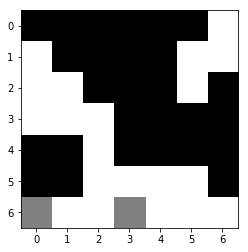

((6, 2), (6, 0)): n_v:  1105 q_all:-0.819479 q:-0.829474 q_m:-0.100000 p:0.354466
((6, 1), (6, 0)): n_v:   789 q_all:-0.820755 q:-0.891706 q_m:-0.066667 p:0.255944
((4, 2), (6, 0)): n_v:   508 q_all:-0.801646 q:-0.694116 q_m:-0.100000 p:0.132871
((6, 5), (6, 3)): n_v:   324 q_all:-0.741872 q:-0.981813 q_m:-0.233333 p:0.021143
((5, 5), (6, 3)): n_v:    71 q_all:-0.772132 q:-0.983119 q_m:-0.233333 p:0.011226
((5, 2), (6, 0)): n_v:    56 q_all:-0.884953 q:-0.811137 q_m:-0.100000 p:0.029612
((5, 2), (6, 3)): n_v:    41 q_all:-0.990707 q:-0.980486 q_m:-0.200000 p:0.036340
((4, 2), (6, 3)): n_v:    22 q_all:-0.787198 q:-0.867148 q_m:-0.233333 p:0.004085
((6, 1), (6, 3)): n_v:    17 q_all:-0.905650 q:-0.884677 q_m:-0.233333 p:0.010820
-1 's turn
one move takes time(s):  0.24415254592895508
train_mode is both train
no. of data collected:  8


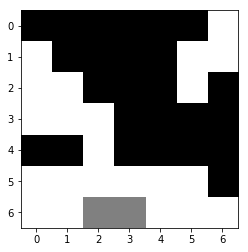

((4, 0), (6, 2)): n_v:  1493 q_all:+0.700153 q:+0.796261 q_m:+0.366667 p:0.622386
((4, 1), (6, 2)): n_v:   273 q_all:+0.758086 q:+0.657290 q_m:+0.366667 p:0.054331
((4, 3), (6, 2)): n_v:   230 q_all:+0.710444 q:+0.622649 q_m:+0.366667 p:0.087112
((4, 1), (6, 3)): n_v:   217 q_all:+0.752577 q:+0.767338 q_m:+0.366667 p:0.047602
((4, 4), (6, 3)): n_v:   172 q_all:+0.760908 q:+0.519263 q_m:+0.366667 p:0.032283
((4, 4), (6, 2)): n_v:    74 q_all:+0.613667 q:+0.525771 q_m:+0.366667 p:0.053926
((4, 3), (6, 3)): n_v:    48 q_all:+0.757447 q:+0.358774 q_m:+0.366667 p:0.009603
((4, 5), (6, 3)): n_v:    33 q_all:+0.102725 q:+0.615108 q_m:+0.366667 p:0.085691
1 's turn
one move takes time(s):  0.11229109764099121
train_mode is both train
no. of data collected:  8


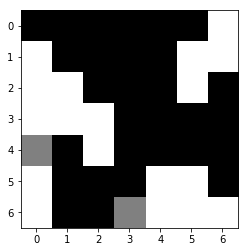

((6, 0), (4, 0)): n_v:  2023 q_all:-0.825625 q:-0.696229 q_m:-0.233333 p:0.179901
((3, 0), (4, 0)): n_v:   327 q_all:-0.945320 q:-0.788063 q_m:-0.200000 p:0.166156
((6, 5), (6, 3)): n_v:   215 q_all:-0.854929 q:-0.983305 q_m:-0.166667 p:0.041141
((5, 5), (6, 3)): n_v:   210 q_all:-0.851709 q:-0.979790 q_m:-0.166667 p:0.037409
((3, 2), (4, 0)): n_v:   122 q_all:-0.891292 q:-0.825455 q_m:-0.233333 p:0.038893
((4, 2), (4, 0)): n_v:   117 q_all:-0.808294 q:-0.600854 q_m:-0.233333 p:0.003150
((5, 4), (6, 3)): n_v:    72 q_all:-0.995328 q:-0.973765 q_m:-0.133333 p:0.049554
((4, 2), (6, 3)): n_v:    65 q_all:-0.836272 q:-0.853134 q_m:-0.166667 p:0.008296
((2, 1), (4, 0)): n_v:    56 q_all:-0.808268 q:-0.786682 q_m:-0.233333 p:0.001535
((2, 0), (4, 0)): n_v:    23 q_all:-0.872031 q:-0.828507 q_m:-0.233333 p:0.005988
-1 's turn
one move takes time(s):  0.06506943702697754
train_mode is both train
no. of data collected:  8


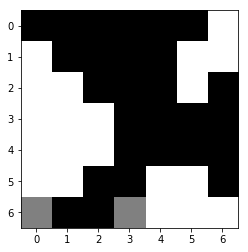

((6, 1), (6, 3)): n_v:  2144 q_all:+0.849279 q:+0.744534 q_m:+0.366667 p:0.010813
((6, 1), (6, 0)): n_v:  1089 q_all:+0.915462 q:+0.847886 q_m:+0.400000 p:0.192907
((5, 2), (6, 3)): n_v:   374 q_all:+0.642026 q:+0.884053 q_m:+0.400000 p:0.270969
((6, 2), (6, 0)): n_v:     7 q_all:+0.645702 q:+0.645702 q_m:+0.366667 p:0.005041
((4, 5), (6, 3)): n_v:     1 q_all:+0.512711 q:+0.512711 q_m:+0.366667 p:0.002057
((4, 4), (6, 3)): n_v:     0 q_all:+0.383180 q:+0.383180 q_m:+0.366667 p:0.001313
((5, 2), (6, 0)): n_v:     0 q_all:+0.475742 q:+0.475742 q_m:+0.366667 p:0.000042
((4, 3), (6, 3)): n_v:     0 q_all:+0.355132 q:+0.355132 q_m:+0.366667 p:0.001043
1 's turn
one move takes time(s):  0.06815528869628906
train_mode is both train
no. of data collected:  8


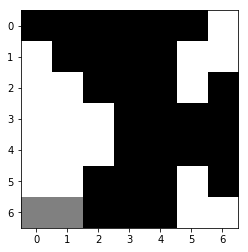

((4, 0), (6, 1)): n_v:  2928 q_all:-0.787857 q:-0.936113 q_m:-0.233333 p:0.169896
((5, 0), (6, 1)): n_v:   622 q_all:-1.000000 q:+5.000000 q_m:-0.200000 p:0.458857
((4, 2), (6, 1)): n_v:    85 q_all:-0.908691 q:-0.908691 q_m:-0.233333 p:0.027785
((4, 1), (6, 1)): n_v:    79 q_all:-0.944906 q:-0.962378 q_m:-0.233333 p:0.044549
((4, 0), (6, 0)): n_v:     9 q_all:-0.968290 q:-0.968290 q_m:-0.366667 p:0.006340
((4, 2), (6, 0)): n_v:     2 q_all:-0.954963 q:-0.954963 q_m:-0.366667 p:0.001255
((5, 0), (6, 0)): n_v:     1 q_all:-0.993178 q:-0.993178 q_m:-0.333333 p:0.001229
((4, 1), (6, 0)): n_v:     1 q_all:-0.978572 q:-0.978572 q_m:-0.366667 p:0.001264
-1 's turn
one move takes time(s):  0.08863115310668945
train_mode is both train
no. of data collected:  8


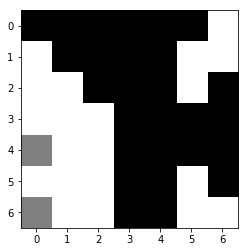

((2, 2), (4, 0)): n_v:  4334 q_all:+0.758373 q:+0.890200 q_m:+0.566667 p:0.996251
1 's turn
one move takes time(s):  0.18022871017456055
train_mode is both train
no. of data collected:  8


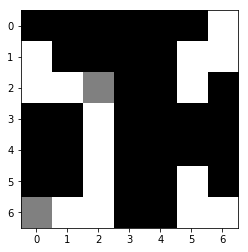

((4, 2), (2, 2)): n_v:  1778 q_all:-0.857078 q:-0.990937 q_m:-0.166667 p:0.347614
((4, 2), (6, 0)): n_v:   998 q_all:-0.790711 q:-0.927551 q_m:-0.433333 p:0.025402
((5, 2), (6, 0)): n_v:   771 q_all:-0.789654 q:-0.923607 q_m:-0.433333 p:0.017309
((1, 0), (2, 2)): n_v:   559 q_all:-0.860338 q:-0.955098 q_m:-0.166667 p:0.114067
((2, 0), (2, 2)): n_v:   515 q_all:-0.845774 q:-0.990711 q_m:-0.166667 p:0.085791
((2, 1), (2, 2)): n_v:   340 q_all:-0.993662 q:-0.998872 q_m:-0.133333 p:0.185494
((6, 2), (6, 0)): n_v:   140 q_all:-0.815672 q:-0.997112 q_m:-0.433333 p:0.012518
((6, 1), (6, 0)): n_v:    93 q_all:-0.809725 q:-0.993700 q_m:-0.400000 p:0.006626
-1 's turn


This is a random move


one move takes time(s):  0.05197715759277344
train_mode is both train
no. of data collected:  8


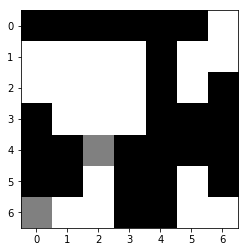

((4, 1), (4, 2)): n_v:  3154 q_all:+0.930791 q:+0.992334 q_m:+0.466667 p:0.283530
((5, 0), (4, 2)): n_v:    44 q_all:+0.694410 q:+0.955487 q_m:+0.433333 p:0.024758
((3, 0), (4, 2)): n_v:    43 q_all:+0.694642 q:+0.955951 q_m:+0.433333 p:0.024221
((6, 3), (4, 2)): n_v:    13 q_all:+0.711587 q:+0.989841 q_m:+0.433333 p:0.006293
((6, 4), (4, 2)): n_v:     5 q_all:+0.705621 q:+0.977908 q_m:+0.433333 p:0.002563
((4, 0), (4, 2)): n_v:     2 q_all:+0.698665 q:+0.963996 q_m:+0.433333 p:0.001095
((4, 4), (4, 2)): n_v:     2 q_all:+0.596168 q:+0.759002 q_m:+0.433333 p:0.002851
((3, 4), (4, 2)): n_v:     1 q_all:+0.631263 q:+0.829192 q_m:+0.433333 p:0.001475
((5, 4), (4, 2)): n_v:     1 q_all:+0.610762 q:+0.788191 q_m:+0.433333 p:0.001372
((5, 0), (6, 0)): n_v:     0 q_all:+0.032558 q:+0.032558 q_m:+0.266667 p:0.000039
((4, 1), (6, 0)): n_v:     0 q_all:-0.014739 q:-0.014739 q_m:+0.233333 p:0.000083
((4, 0), (6, 0)): n_v:     0 q_all:-0.216581 q:-0.216581 q_m:+0.233333 p:0.000077
((2, 4), (4, 2))

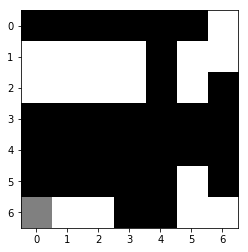

((6, 2), (6, 0)): n_v:  2962 q_all:-0.999888 q:-0.999866 q_m:-0.333333 p:0.719494
((6, 1), (6, 0)): n_v:  1147 q_all:-1.000000 q:+5.000000 q_m:-0.300000 p:0.278903
-1 's turn


This is a random move


one move takes time(s):  0.04050016403198242
train_mode is both train
no. of data collected:  8


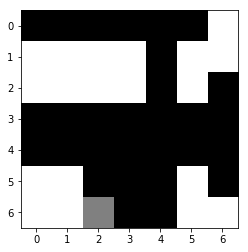

((5, 2), (6, 2)): n_v:  4286 q_all:+1.000000 q:+5.000000 q_m:+0.500000 p:0.293099
((6, 4), (6, 2)): n_v:     7 q_all:+0.930956 q:+0.980982 q_m:+0.466667 p:0.002108
((4, 0), (6, 2)): n_v:     4 q_all:+0.943735 q:+0.970685 q_m:+0.466667 p:0.001115
((4, 3), (6, 2)): n_v:     0 q_all:+0.696184 q:+0.925702 q_m:+0.466667 p:0.000323
((5, 4), (6, 2)): n_v:     0 q_all:+0.652619 q:+0.838571 q_m:+0.466667 p:0.000099
((4, 2), (6, 2)): n_v:     0 q_all:+0.630617 q:+0.794567 q_m:+0.466667 p:0.000203
((4, 4), (6, 2)): n_v:     0 q_all:+0.633913 q:+0.801159 q_m:+0.466667 p:0.000085
((4, 1), (6, 2)): n_v:     0 q_all:+0.573369 q:+0.680072 q_m:+0.466667 p:0.000167
this self play has 75 steps, time elapsed 181.4895417690277
winner is -1.0
episode 44 finished
episode 45 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3857741355895996
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5559718608856201
train_mode is both train
no. of

one move takes time(s):  0.24654173851013184
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.16657733917236328
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.14797353744506836
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.08324766159057617
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.15980076789855957
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.07658791542053223
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.11928939819335938
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.18138885498046875
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.11736845970153809
train_mode is both train
no. of data collected:  8
1 's turn


This is a rand

Epoch 32/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8217 - activation_29_loss: 1.7891 - dense_15_loss: 0.0077 - val_loss: 1.9039 - val_activation_29_loss: 1.8716 - val_dense_15_loss: 0.0074
Epoch 33/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8201 - activation_29_loss: 1.7876 - dense_15_loss: 0.0075 - val_loss: 1.9036 - val_activation_29_loss: 1.8714 - val_dense_15_loss: 0.0073
Epoch 34/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8195 - activation_29_loss: 1.7867 - dense_15_loss: 0.0079 - val_loss: 1.9038 - val_activation_29_loss: 1.8715 - val_dense_15_loss: 0.0074
Epoch 35/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8179 - activation_29_loss: 1.7853 - dense_15_loss: 0.0076 - val_loss: 1.9036 - val_activation_29_loss: 1.8714 - val_dense_15_loss: 0.0073
Epoch 36/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8183 - activation_29_loss: 1.7858 - dense_1



This is a random move


one move takes time(s):  0.7677521705627441
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.1055269241333008
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.076122522354126
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0796949863433838
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1743 time elapsed:  2.000138998031616


This is a random move


one move takes time(s):  2.0011284351348877
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6988303661346436


This is a random move


one move takes time(s):  2.6998159885406494
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.328850507736206
train_mo



This is a random move


one move takes time(s):  0.4297347068786621
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2888338565826416
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2500898838043213
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2225356101989746
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.15152978897094727
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.25973057746887207
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.17783212661743164
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1308135986328125
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.09425783157348633
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(

due to rollout lim, final rollout times:  1601 time elapsed:  3.8665075302124023
one move takes time(s):  3.8680756092071533
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.761892795562744
one move takes time(s):  2.763127565383911
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.2764852046966553


This is a random move


one move takes time(s):  3.2779042720794678
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.5153424739837646
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4835505485534668
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.8541271686553955
one move takes time(s):  2.855344772338867
train_mode is both train
no. of data collected:  8
1 's

one move takes time(s):  1.9563677310943604
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1671 time elapsed:  2.0092036724090576
one move takes time(s):  2.010380983352661
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.4831511974334717
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.255051612854004
one move takes time(s):  2.2565503120422363
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6219334602355957
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.855351448059082
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.6751704216003418
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5935640335083008
train_

one move takes time(s):  1.0521275997161865
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7283484935760498
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6363520622253418
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5378453731536865
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7186384201049805
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6717040538787842
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.239776372909546
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.054013729095459
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8153011798858643
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0581684112548828
train_mod

one move takes time(s):  0.9409549236297607
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0468237400054932
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3550374507904053


This is a random move


one move takes time(s):  2.3562734127044678
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.9525353908538818
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6511056423187256
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.9174633026123047
one move takes time(s):  2.918663501739502
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2440519332885742
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2546944618225098
train

Epoch 3/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8764 - activation_29_loss: 1.8437 - dense_15_loss: 0.0078 - val_loss: 1.8483 - val_activation_29_loss: 1.8163 - val_dense_15_loss: 0.0071
Epoch 4/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8739 - activation_29_loss: 1.8413 - dense_15_loss: 0.0077 - val_loss: 1.8482 - val_activation_29_loss: 1.8162 - val_dense_15_loss: 0.0071
Epoch 5/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8712 - activation_29_loss: 1.8387 - dense_15_loss: 0.0076 - val_loss: 1.8480 - val_activation_29_loss: 1.8161 - val_dense_15_loss: 0.0070
Epoch 6/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8699 - activation_29_loss: 1.8373 - dense_15_loss: 0.0077 - val_loss: 1.8481 - val_activation_29_loss: 1.8162 - val_dense_15_loss: 0.0070
Epoch 7/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8682 - activation_29_loss: 1.8357 - dense_15_los

9000/9000 [==============================] - 1s 93us/step - loss: 1.8355 - activation_29_loss: 1.8037 - dense_15_loss: 0.0069 - val_loss: 1.8534 - val_activation_29_loss: 1.8219 - val_dense_15_loss: 0.0066
Epoch 41/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8345 - activation_29_loss: 1.8028 - dense_15_loss: 0.0068 - val_loss: 1.8536 - val_activation_29_loss: 1.8222 - val_dense_15_loss: 0.0065
Epoch 42/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8343 - activation_29_loss: 1.8026 - dense_15_loss: 0.0068 - val_loss: 1.8536 - val_activation_29_loss: 1.8222 - val_dense_15_loss: 0.0065
Epoch 43/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8333 - activation_29_loss: 1.8016 - dense_15_loss: 0.0067 - val_loss: 1.8537 - val_activation_29_loss: 1.8222 - val_dense_15_loss: 0.0065
Epoch 44/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8331 - activation_29_loss: 1.8015 - dense_15_loss: 0.006

one move takes time(s):  0.6995692253112793
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.486393690109253
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.039085626602173
one move takes time(s):  2.0411183834075928
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.4392342567443848
one move takes time(s):  2.440382242202759
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.578005313873291
one move takes time(s):  2.5804600715637207
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1628 time elapsed:  2.000349283218384
one move takes time(s):  2.001999855041504
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5960838794708252
train

one move takes time(s):  1.5452203750610352
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.9014005661010742
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1093850135803223
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.932591438293457
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8240082263946533
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2695696353912354
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1563796997070312
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5557794570922852
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8261945247650146
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1

one move takes time(s):  1.8903553485870361
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.4916090965270996
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.191530227661133
one move takes time(s):  2.1928510665893555
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.300086498260498
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5557985305786133
one move takes time(s):  2.5571110248565674
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4884440898895264
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.541886806488037
one move takes time(s):  2.543079137802124
train_mode is both train
no. of data collected:  8
1 's tu



This is a random move


one move takes time(s):  0.5547833442687988
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0976943969726562
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.6977763175964355
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1382453441619873


This is a random move


one move takes time(s):  2.1392548084259033
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.047234058380127


This is a random move


one move takes time(s):  2.0485992431640625
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7637810707092285


This is a random move


one move takes time(s):  2.764775037765503
train_mode is both train
no. of data collected:  8
1 's t

one move takes time(s):  0.37833714485168457
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5307817459106445
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.0656635761260986
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2706434726715088
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.865537405014038
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5495505332946777


This is a random move


one move takes time(s):  2.550527572631836
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.1551876068115234
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time 

32968  data in database
10000  data expected
10000  data grabbed
start training, training data no. 10000
Train on 9000 samples, validate on 1000 samples
Epoch 1/512
9000/9000 [==============================] - 1s 120us/step - loss: 1.8489 - activation_29_loss: 1.8156 - dense_15_loss: 0.0084 - val_loss: 1.8777 - val_activation_29_loss: 1.8442 - val_dense_15_loss: 0.0085
Epoch 2/512
9000/9000 [==============================] - 1s 112us/step - loss: 1.8456 - activation_29_loss: 1.8125 - dense_15_loss: 0.0081 - val_loss: 1.8781 - val_activation_29_loss: 1.8447 - val_dense_15_loss: 0.0085
Epoch 3/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8428 - activation_29_loss: 1.8095 - dense_15_loss: 0.0083 - val_loss: 1.8774 - val_activation_29_loss: 1.8440 - val_dense_15_loss: 0.0085
Epoch 4/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8399 - activation_29_loss: 1.8068 - dense_15_loss: 0.0082 - val_loss: 1.8777 - val_activation_29_loss: 1.8443 -

Epoch 38/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8038 - activation_29_loss: 1.7715 - dense_15_loss: 0.0073 - val_loss: 1.8844 - val_activation_29_loss: 1.8512 - val_dense_15_loss: 0.0083
Epoch 39/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8039 - activation_29_loss: 1.7714 - dense_15_loss: 0.0075 - val_loss: 1.8842 - val_activation_29_loss: 1.8509 - val_dense_15_loss: 0.0083
Epoch 40/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8031 - activation_29_loss: 1.7707 - dense_15_loss: 0.0075 - val_loss: 1.8851 - val_activation_29_loss: 1.8519 - val_dense_15_loss: 0.0083
Epoch 41/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8022 - activation_29_loss: 1.7699 - dense_15_loss: 0.0073 - val_loss: 1.8845 - val_activation_29_loss: 1.8513 - val_dense_15_loss: 0.0083
Epoch 42/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8014 - activation_29_loss: 1.7691 - dense_1

due to rollout lim, final rollout times:  1601 time elapsed:  2.8697731494903564


This is a random move


one move takes time(s):  2.871027708053589
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.4357988834381104
one move takes time(s):  3.437012195587158
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.629342794418335
one move takes time(s):  2.630826234817505
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.236116647720337
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4581525325775146
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9134626388549805
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2223110198974

due to rollout lim, final rollout times:  1601 time elapsed:  2.06445574760437


This is a random move


one move takes time(s):  2.065035820007324
train_mode is both train
no. of data collected:  8
-1 's turn
due to time lim, final rollout times:  112 time elapsed:  130.99561977386475


This is a random move


one move takes time(s):  131.03447794914246
no. of data collected:  0
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.032499313354492
one move takes time(s):  4.033668518066406
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.182267904281616
one move takes time(s):  3.183504581451416
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.477388858795166
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.9415075778961182
train_mode is both train
no. of data collected:  8
1 's turn
du

one move takes time(s):  1.7654361724853516
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.240359306335449
one move takes time(s):  2.2416696548461914
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7286324501037598
one move takes time(s):  2.7301766872406006
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1755 time elapsed:  2.0017306804656982
one move takes time(s):  2.0032217502593994
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1753 time elapsed:  2.002995729446411


This is a random move


one move takes time(s):  2.0042529106140137
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1044962406158447
one move takes time(s):  2.1057398319244385

one move takes time(s):  1.391624927520752
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8223731517791748
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4781849384307861
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2590298652648926
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.9552369117736816
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.868851661682129
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0631530284881592
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4185829162597656
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9386122226715088
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1

due to rollout lim, final rollout times:  1601 time elapsed:  2.1227715015411377
one move takes time(s):  2.1239819526672363
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4683537483215332
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3692669868469238
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9395184516906738
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.3081865310668945
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2447519302368164
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.601630449295044
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4771513938903809
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s): 

one move takes time(s):  1.584825038909912
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7944023609161377
one move takes time(s):  2.7955689430236816
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.812743186950684
one move takes time(s):  4.814398288726807
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.625070095062256
one move takes time(s):  2.6262035369873047
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.851449966430664
one move takes time(s):  5.852741718292236
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.6535396575927734
one move takes time(s):  3.6547458171844482
train_mode is both train
no. 

9000/9000 [==============================] - 1s 108us/step - loss: 1.8745 - activation_29_loss: 1.8421 - dense_15_loss: 0.0074 - val_loss: 1.8748 - val_activation_29_loss: 1.8431 - val_dense_15_loss: 0.0067
Epoch 3/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8700 - activation_29_loss: 1.8380 - dense_15_loss: 0.0071 - val_loss: 1.8746 - val_activation_29_loss: 1.8429 - val_dense_15_loss: 0.0068
Epoch 4/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8681 - activation_29_loss: 1.8360 - dense_15_loss: 0.0072 - val_loss: 1.8744 - val_activation_29_loss: 1.8427 - val_dense_15_loss: 0.0067
Epoch 5/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8663 - activation_29_loss: 1.8342 - dense_15_loss: 0.0071 - val_loss: 1.8745 - val_activation_29_loss: 1.8428 - val_dense_15_loss: 0.0068
Epoch 6/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8641 - activation_29_loss: 1.8319 - dense_15_loss: 0.0072 -

9000/9000 [==============================] - 1s 93us/step - loss: 1.8313 - activation_29_loss: 1.7999 - dense_15_loss: 0.0064 - val_loss: 1.8831 - val_activation_29_loss: 1.8511 - val_dense_15_loss: 0.0070
Epoch 40/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8302 - activation_29_loss: 1.7988 - dense_15_loss: 0.0065 - val_loss: 1.8828 - val_activation_29_loss: 1.8509 - val_dense_15_loss: 0.0070
Epoch 41/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8298 - activation_29_loss: 1.7985 - dense_15_loss: 0.0063 - val_loss: 1.8835 - val_activation_29_loss: 1.8516 - val_dense_15_loss: 0.0069
Epoch 42/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8289 - activation_29_loss: 1.7976 - dense_15_loss: 0.0063 - val_loss: 1.8834 - val_activation_29_loss: 1.8514 - val_dense_15_loss: 0.0071
Epoch 43/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8285 - activation_29_loss: 1.7972 - dense_15_loss: 0.006

one move takes time(s):  1.3319780826568604
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3364052772521973
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5692338943481445
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0474700927734375
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.38327956199646
one move takes time(s):  2.384474515914917
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3167591094970703
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.385725975036621
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4961199760437012
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3000152111053467
train_mode is both train
no. of dat

no. of data collected:  8
1 's turn
one move takes time(s):  0.17090106010437012
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.12818336486816406
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.11603856086730957
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.07926321029663086
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.11583733558654785
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.04492688179016113
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.04569411277770996
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.03901314735412598
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.04070544242858887
train_mode is both train
no. of data coll

one move takes time(s):  0.44426655769348145
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5995461940765381
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.38135743141174316
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6271276473999023
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8801791667938232
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.42621874809265137
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5583198070526123
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4788191318511963
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2763669490814209
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.39753222465515137
tr

one move takes time(s):  1.242100715637207
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7862532138824463
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.503873348236084
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5082144737243652
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8089525699615479
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7202346324920654
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.560692310333252
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.46169495582580566
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.42333006858825684
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  

due to rollout lim, final rollout times:  1601 time elapsed:  2.3606109619140625
one move takes time(s):  2.3618509769439697
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.018869161605835
one move takes time(s):  2.0201358795166016
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6682851314544678


This is a random move


one move takes time(s):  2.669544219970703
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.604785919189453
one move takes time(s):  2.606368064880371
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1143319606781006


This is a random move


one move takes time(s):  2.1155567169189453
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time



This is a random move


one move takes time(s):  0.8408963680267334
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9361057281494141
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7282946109771729
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.304673671722412
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8598308563232422
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8748762607574463
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6159884929656982
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9475135803222656
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1652 time elapsed:  2.0105600357055664


This is a random move


one move takes time(s): 

9000/9000 [==============================] - 1s 125us/step - loss: 1.8738 - activation_29_loss: 1.8399 - dense_15_loss: 0.0089 - val_loss: 1.8864 - val_activation_29_loss: 1.8519 - val_dense_15_loss: 0.0096
Epoch 2/512
9000/9000 [==============================] - 1s 100us/step - loss: 1.8703 - activation_29_loss: 1.8364 - dense_15_loss: 0.0089 - val_loss: 1.8871 - val_activation_29_loss: 1.8526 - val_dense_15_loss: 0.0095
Epoch 3/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8665 - activation_29_loss: 1.8331 - dense_15_loss: 0.0085 - val_loss: 1.8870 - val_activation_29_loss: 1.8523 - val_dense_15_loss: 0.0097
Epoch 4/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8637 - activation_29_loss: 1.8302 - dense_15_loss: 0.0086 - val_loss: 1.8866 - val_activation_29_loss: 1.8518 - val_dense_15_loss: 0.0098
Epoch 5/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8614 - activation_29_loss: 1.8280 - dense_15_loss: 0.0084 

9000/9000 [==============================] - 1s 91us/step - loss: 1.8256 - activation_29_loss: 1.7933 - dense_15_loss: 0.0073 - val_loss: 1.8929 - val_activation_29_loss: 1.8576 - val_dense_15_loss: 0.0103
Epoch 39/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8257 - activation_29_loss: 1.7934 - dense_15_loss: 0.0073 - val_loss: 1.8925 - val_activation_29_loss: 1.8572 - val_dense_15_loss: 0.0103
Epoch 40/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8237 - activation_29_loss: 1.7917 - dense_15_loss: 0.0071 - val_loss: 1.8926 - val_activation_29_loss: 1.8574 - val_dense_15_loss: 0.0103
Epoch 41/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8226 - activation_29_loss: 1.7905 - dense_15_loss: 0.0071 - val_loss: 1.8928 - val_activation_29_loss: 1.8576 - val_dense_15_loss: 0.0102
Epoch 42/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8225 - activation_29_loss: 1.7905 - dense_15_loss: 0.007

one move takes time(s):  1.0512292385101318
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.105135440826416
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9133262634277344
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.8602564334869385
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.362520456314087
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0300962924957275
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8759407997131348
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2015717029571533
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.379281759262085
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4

due to rollout lim, final rollout times:  1692 time elapsed:  2.0044493675231934
one move takes time(s):  2.0058019161224365
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6920115947723389
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0778307914733887
one move takes time(s):  2.0793070793151855
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3671457767486572
one move takes time(s):  2.3682541847229004
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8151271343231201
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5851225852966309
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.4172749519348145


This is a random move


one move takes ti

one move takes time(s):  1.4228224754333496
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8685743808746338
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.403367757797241
one move takes time(s):  2.404613494873047
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4345512390136719
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1578876972198486
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6766541004180908
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2581913471221924
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.229008436203003
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7899460792541504
train_mode is both train
no. of da

due to rollout lim, final rollout times:  1601 time elapsed:  4.850607872009277


This is a random move


one move takes time(s):  4.851888179779053
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.5264930725097656
one move takes time(s):  3.5276808738708496
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.196995735168457
one move takes time(s):  3.1982040405273438
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9356563091278076
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.726667881011963


This is a random move


one move takes time(s):  2.7279164791107178
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3920354843139648
train_mode is both train
no. of data collected:  8
-1 's 



This is a random move


one move takes time(s):  1.9916541576385498
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.8847365379333496
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5082197189331055
one move takes time(s):  2.509422540664673
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6512091159820557


This is a random move


one move takes time(s):  2.6524579524993896
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.299419403076172


This is a random move


one move takes time(s):  3.3007354736328125
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3039190769195557
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, fi

one move takes time(s):  0.2872335910797119
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.2236335277557373
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2417130470275879
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.11370253562927246
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.11700749397277832
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1516261100769043
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.16324949264526367
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.18167805671691895
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.37317728996276855
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time

9000/9000 [==============================] - 1s 96us/step - loss: 1.8349 - activation_29_loss: 1.8022 - dense_15_loss: 0.0077 - val_loss: 1.8922 - val_activation_29_loss: 1.8585 - val_dense_15_loss: 0.0088
Epoch 30/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8341 - activation_29_loss: 1.8014 - dense_15_loss: 0.0078 - val_loss: 1.8923 - val_activation_29_loss: 1.8586 - val_dense_15_loss: 0.0087
Epoch 31/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8335 - activation_29_loss: 1.8008 - dense_15_loss: 0.0078 - val_loss: 1.8923 - val_activation_29_loss: 1.8586 - val_dense_15_loss: 0.0088
Epoch 32/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8323 - activation_29_loss: 1.7996 - dense_15_loss: 0.0078 - val_loss: 1.8927 - val_activation_29_loss: 1.8589 - val_dense_15_loss: 0.0088
Epoch 33/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8322 - activation_29_loss: 1.7993 - dense_15_loss: 0.007

9000/9000 [==============================] - 1s 93us/step - loss: 1.8111 - activation_29_loss: 1.7787 - dense_15_loss: 0.0074 - val_loss: 1.8975 - val_activation_29_loss: 1.8635 - val_dense_15_loss: 0.0091
Epoch 67/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8094 - activation_29_loss: 1.7772 - dense_15_loss: 0.0073 - val_loss: 1.8973 - val_activation_29_loss: 1.8634 - val_dense_15_loss: 0.0090
Epoch 68/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8088 - activation_29_loss: 1.7765 - dense_15_loss: 0.0073 - val_loss: 1.8973 - val_activation_29_loss: 1.8633 - val_dense_15_loss: 0.0090
Epoch 69/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8088 - activation_29_loss: 1.7766 - dense_15_loss: 0.0072 - val_loss: 1.8975 - val_activation_29_loss: 1.8634 - val_dense_15_loss: 0.0091
Epoch 70/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8086 - activation_29_loss: 1.7764 - dense_15_loss: 0.007

one move takes time(s):  0.6971282958984375
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5496735572814941
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9013707637786865
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5969831943511963
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.376706600189209
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5229918956756592
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6829090118408203
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3056797981262207
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.42352843284606934
train_mode is both train
no. of data collected:  8
1 's turn

one move takes time(s):  0.7197952270507812
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5049092769622803
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6070342063903809
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5299739837646484
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4495503902435303
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.3975656032562256
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.369769811630249
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.33156323432922363
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.43470335006713867
train_mode is both train
no. of data collected:  8
1 's tur

one move takes time(s):  0.2636902332305908
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.12714552879333496
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.1217050552368164
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.17145776748657227
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.06953024864196777
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.11653614044189453
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.0569000244140625
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.08579111099243164
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.044562578201293945
train_mode is both train
no. of data collected:  8
1 

one move takes time(s):  0.4034714698791504
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.34648966789245605
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3060309886932373
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.21767616271972656
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3391296863555908
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.20753097534179688
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.15271568298339844
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.14077138900756836
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.08414626121520996
train_mode is both train
no. of data collected:  8
-1 

one move takes time(s):  0.6206042766571045
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5192890167236328
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4830360412597656
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4886932373046875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.38512086868286133
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.33254551887512207
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4131758213043213
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.46624302864074707
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2001948356628418
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3652455806732178
trai

9000/9000 [==============================] - 1s 92us/step - loss: 1.8362 - activation_29_loss: 1.8025 - dense_15_loss: 0.0088 - val_loss: 1.8747 - val_activation_29_loss: 1.8369 - val_dense_15_loss: 0.0128
Epoch 30/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8359 - activation_29_loss: 1.8021 - dense_15_loss: 0.0088 - val_loss: 1.8736 - val_activation_29_loss: 1.8359 - val_dense_15_loss: 0.0128
Epoch 31/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8352 - activation_29_loss: 1.8015 - dense_15_loss: 0.0088 - val_loss: 1.8737 - val_activation_29_loss: 1.8359 - val_dense_15_loss: 0.0128
Epoch 32/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8340 - activation_29_loss: 1.8000 - dense_15_loss: 0.0090 - val_loss: 1.8737 - val_activation_29_loss: 1.8359 - val_dense_15_loss: 0.0128
Epoch 33/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8328 - activation_29_loss: 1.7992 - dense_15_loss: 0.008

9000/9000 [==============================] - 1s 93us/step - loss: 1.8121 - activation_29_loss: 1.7790 - dense_15_loss: 0.0082 - val_loss: 1.8757 - val_activation_29_loss: 1.8382 - val_dense_15_loss: 0.0125
Epoch 67/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8111 - activation_29_loss: 1.7780 - dense_15_loss: 0.0080 - val_loss: 1.8771 - val_activation_29_loss: 1.8396 - val_dense_15_loss: 0.0125
Epoch 68/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8101 - activation_29_loss: 1.7772 - dense_15_loss: 0.0079 - val_loss: 1.8768 - val_activation_29_loss: 1.8393 - val_dense_15_loss: 0.0125
Epoch 69/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8102 - activation_29_loss: 1.7772 - dense_15_loss: 0.0080 - val_loss: 1.8763 - val_activation_29_loss: 1.8388 - val_dense_15_loss: 0.0125
Epoch 70/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8098 - activation_29_loss: 1.7767 - dense_15_loss: 0.008

one move takes time(s):  0.2877359390258789
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.336353063583374
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.327009916305542
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.28197216987609863
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.27417445182800293
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.22593951225280762
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.15864920616149902
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.159041166305542
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.10670733451843262
train_

one move takes time(s):  0.9569306373596191
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5334367752075195
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6595842838287354
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3784353733062744
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.341076135635376
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.4088711738586426
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.21914267539978027
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.21296262741088867
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.20890450477600098
train_mode is both train
no. of 

due to rollout lim, final rollout times:  1601 time elapsed:  2.5470385551452637
one move takes time(s):  2.5483808517456055
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.76996111869812
one move takes time(s):  3.7723312377929688
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2499396800994873
one move takes time(s):  2.2510480880737305
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6352169513702393
one move takes time(s):  2.636845827102661
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.334430456161499
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.58547043800354
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0038683414459229
train

due to rollout lim, final rollout times:  1658 time elapsed:  2.004594564437866


This is a random move


one move takes time(s):  2.0061869621276855
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.165574550628662
one move takes time(s):  2.166776418685913
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.9311397075653076
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3365259170532227


This is a random move


one move takes time(s):  2.3381710052490234
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2454514503479004
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.168271541595459
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5009262561798096
train_

one move takes time(s):  1.0086119174957275
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3977231979370117
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1629 time elapsed:  2.000004529953003
one move takes time(s):  2.0015220642089844
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.4438772201538086
one move takes time(s):  2.445002555847168
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.85892391204834


This is a random move


one move takes time(s):  2.8601880073547363
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6720149517059326
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.423112392425537
train_mode is both train
no. of d

Epoch 4/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8823 - activation_29_loss: 1.8452 - dense_15_loss: 0.0121 - val_loss: 1.9355 - val_activation_29_loss: 1.9009 - val_dense_15_loss: 0.0096
Epoch 5/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8792 - activation_29_loss: 1.8423 - dense_15_loss: 0.0119 - val_loss: 1.9357 - val_activation_29_loss: 1.9010 - val_dense_15_loss: 0.0097
Epoch 6/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8767 - activation_29_loss: 1.8398 - dense_15_loss: 0.0119 - val_loss: 1.9357 - val_activation_29_loss: 1.9010 - val_dense_15_loss: 0.0097
Epoch 7/512
9000/9000 [==============================] - 1s 96us/step - loss: 1.8742 - activation_29_loss: 1.8374 - dense_15_loss: 0.0118 - val_loss: 1.9363 - val_activation_29_loss: 1.9015 - val_dense_15_loss: 0.0098
Epoch 8/512
9000/9000 [==============================] - 1s 98us/step - loss: 1.8724 - activation_29_loss: 1.8356 - dense_15_los

9000/9000 [==============================] - 1s 92us/step - loss: 1.8381 - activation_29_loss: 1.8029 - dense_15_loss: 0.0102 - val_loss: 1.9405 - val_activation_29_loss: 1.9056 - val_dense_15_loss: 0.0099
Epoch 42/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8376 - activation_29_loss: 1.8023 - dense_15_loss: 0.0103 - val_loss: 1.9407 - val_activation_29_loss: 1.9058 - val_dense_15_loss: 0.0099
Epoch 43/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8381 - activation_29_loss: 1.8030 - dense_15_loss: 0.0100 - val_loss: 1.9403 - val_activation_29_loss: 1.9054 - val_dense_15_loss: 0.0099
Epoch 44/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8366 - activation_29_loss: 1.8016 - dense_15_loss: 0.0100 - val_loss: 1.9406 - val_activation_29_loss: 1.9057 - val_dense_15_loss: 0.0099
Epoch 45/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8350 - activation_29_loss: 1.7999 - dense_15_loss: 0.010

one move takes time(s):  1.7573928833007812
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9227428436279297
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.687946081161499
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.616403579711914
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2338502407073975
one move takes time(s):  2.2350428104400635
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.918372631072998
one move takes time(s):  2.919534921646118
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1574132442474365
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6184372901916504
train_mode is both train
no. of d

one move takes time(s):  0.40185046195983887
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5618641376495361
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7753818035125732
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0867676734924316
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5017223358154297
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5944695472717285
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.8730034828186035
one move takes time(s):  2.8742218017578125
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2423131465911865
train_mode is both train
no. of data collected:  8
-1 's t

one move takes time(s):  0.9192640781402588
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5925753116607666
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6181371212005615
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4905109405517578
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5808911323547363
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.21141815185546875
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.31451940536499023
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.38892316818237305
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2282419204711914
train_mode is both train
no. of data collected:  8
-1 's 

one move takes time(s):  1.4437963962554932
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6794805526733398
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7489891052246094
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.366140365600586


This is a random move


one move takes time(s):  2.3677213191986084
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8200995922088623
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2795491218566895
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1995880603790283
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6264224052429199
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9945089817047119
train_

due to rollout lim, final rollout times:  1601 time elapsed:  3.516779899597168


This is a random move


one move takes time(s):  3.5180623531341553
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6999952793121338
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9135243892669678
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0203144550323486
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1497151851654053
one move takes time(s):  2.15149188041687
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9789302349090576
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.405832290649414
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move




one move takes time(s):  0.8514578342437744
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5582120418548584
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5973970890045166
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5539839267730713
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2624752521514893
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.578632116317749
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9042918682098389
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.7941017150878906
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.356459379196167
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move




9000/9000 [==============================] - 1s 91us/step - loss: 1.8479 - activation_29_loss: 1.8133 - dense_15_loss: 0.0096 - val_loss: 1.8775 - val_activation_29_loss: 1.8418 - val_dense_15_loss: 0.0107
Epoch 14/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8468 - activation_29_loss: 1.8124 - dense_15_loss: 0.0094 - val_loss: 1.8775 - val_activation_29_loss: 1.8418 - val_dense_15_loss: 0.0107
Epoch 15/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8464 - activation_29_loss: 1.8119 - dense_15_loss: 0.0095 - val_loss: 1.8772 - val_activation_29_loss: 1.8416 - val_dense_15_loss: 0.0107
Epoch 16/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8445 - activation_29_loss: 1.8101 - dense_15_loss: 0.0094 - val_loss: 1.8775 - val_activation_29_loss: 1.8419 - val_dense_15_loss: 0.0106
Epoch 17/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8433 - activation_29_loss: 1.8088 - dense_15_loss: 0.009

9000/9000 [==============================] - 1s 93us/step - loss: 1.8163 - activation_29_loss: 1.7827 - dense_15_loss: 0.0086 - val_loss: 1.8809 - val_activation_29_loss: 1.8457 - val_dense_15_loss: 0.0101
Epoch 51/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8160 - activation_29_loss: 1.7824 - dense_15_loss: 0.0086 - val_loss: 1.8811 - val_activation_29_loss: 1.8460 - val_dense_15_loss: 0.0101
Epoch 52/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8152 - activation_29_loss: 1.7816 - dense_15_loss: 0.0086 - val_loss: 1.8819 - val_activation_29_loss: 1.8464 - val_dense_15_loss: 0.0104
Epoch 53/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8147 - activation_29_loss: 1.7810 - dense_15_loss: 0.0087 - val_loss: 1.8814 - val_activation_29_loss: 1.8463 - val_dense_15_loss: 0.0102
Epoch 54/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8148 - activation_29_loss: 1.7810 - dense_15_loss: 0.008

one move takes time(s):  1.3216969966888428
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1801633834838867
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9267010688781738
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5455029010772705
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5817615985870361
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.471189260482788
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.714080810546875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7777230739593506
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1874303817749023
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move




due to rollout lim, final rollout times:  1601 time elapsed:  2.7041449546813965
one move takes time(s):  2.705118417739868
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4731323719024658
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2263894081115723
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9965791702270508
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.9130420684814453
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9757676124572754
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0420453548431396
one move takes time(s):  2.0430121421813965
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.962040901184082
train

one move takes time(s):  0.35144877433776855
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2630190849304199
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2227311134338379
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.19726848602294922
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.14276552200317383
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.23320245742797852
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2012617588043213
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.19937777519226074
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.10088109970092773
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.0522916316986084


one move takes time(s):  0.37407994270324707
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6020321846008301
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.580695629119873
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6462156772613525
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4571256637573242
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2812371253967285
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4412548542022705
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2839536666870117
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.31159210205078125
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):

due to rollout lim, final rollout times:  1601 time elapsed:  5.316313982009888
one move takes time(s):  5.317633390426636
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.3817520141601562
one move takes time(s):  3.383021593093872
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.583949089050293
one move takes time(s):  2.5864248275756836
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.341060161590576


This is a random move


one move takes time(s):  2.342313051223755
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.489785432815552
one move takes time(s):  5.491085767745972
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 tim

9000/9000 [==============================] - 1s 123us/step - loss: 1.8843 - activation_29_loss: 1.8463 - dense_15_loss: 0.0130 - val_loss: 1.8870 - val_activation_29_loss: 1.8497 - val_dense_15_loss: 0.0123
Epoch 2/512
9000/9000 [==============================] - 1s 105us/step - loss: 1.8805 - activation_29_loss: 1.8428 - dense_15_loss: 0.0126 - val_loss: 1.8873 - val_activation_29_loss: 1.8500 - val_dense_15_loss: 0.0124
Epoch 3/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8770 - activation_29_loss: 1.8395 - dense_15_loss: 0.0125 - val_loss: 1.8866 - val_activation_29_loss: 1.8491 - val_dense_15_loss: 0.0124
Epoch 4/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8747 - activation_29_loss: 1.8373 - dense_15_loss: 0.0124 - val_loss: 1.8860 - val_activation_29_loss: 1.8487 - val_dense_15_loss: 0.0123
Epoch 5/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8719 - activation_29_loss: 1.8345 - dense_15_loss: 0.0123 

9000/9000 [==============================] - 1s 93us/step - loss: 1.8312 - activation_29_loss: 1.7955 - dense_15_loss: 0.0107 - val_loss: 1.8910 - val_activation_29_loss: 1.8535 - val_dense_15_loss: 0.0125
Epoch 39/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8310 - activation_29_loss: 1.7951 - dense_15_loss: 0.0108 - val_loss: 1.8906 - val_activation_29_loss: 1.8530 - val_dense_15_loss: 0.0126
Epoch 40/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8298 - activation_29_loss: 1.7941 - dense_15_loss: 0.0107 - val_loss: 1.8912 - val_activation_29_loss: 1.8536 - val_dense_15_loss: 0.0126
Epoch 41/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8293 - activation_29_loss: 1.7936 - dense_15_loss: 0.0107 - val_loss: 1.8908 - val_activation_29_loss: 1.8532 - val_dense_15_loss: 0.0126
Epoch 42/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8284 - activation_29_loss: 1.7927 - dense_15_loss: 0.010

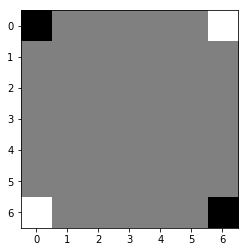

((6, 6), (5, 5)): n_v:   660 q_all:+0.009256 q:+0.012289 q_m:+0.033333 p:0.362484
((0, 0), (1, 1)): n_v:   619 q_all:+0.004938 q:+0.005141 q_m:+0.033333 p:0.353069
((6, 6), (6, 5)): n_v:   160 q_all:+0.003122 q:+0.002129 q_m:+0.033333 p:0.092659
((0, 0), (0, 1)): n_v:   157 q_all:-0.003170 q:-0.015560 q_m:+0.033333 p:0.095586
((6, 6), (5, 6)): n_v:    85 q_all:+0.007278 q:+0.000871 q_m:+0.033333 p:0.047907
((0, 0), (1, 0)): n_v:    79 q_all:+0.000535 q:+0.003807 q_m:+0.033333 p:0.046772
((6, 6), (6, 4)): n_v:     0 q_all:-0.011780 q:-0.011780 q_m:-0.000000 p:0.000033
((0, 0), (1, 2)): n_v:     0 q_all:-0.023401 q:-0.023401 q_m:-0.000000 p:0.000051
((0, 0), (2, 2)): n_v:     0 q_all:-0.027493 q:-0.027493 q_m:-0.000000 p:0.000262
((0, 0), (0, 2)): n_v:     0 q_all:-0.028449 q:-0.028449 q_m:-0.000000 p:0.000027
((6, 6), (4, 6)): n_v:     0 q_all:-0.021957 q:-0.021957 q_m:-0.000000 p:0.000132
((6, 6), (5, 4)): n_v:     0 q_all:+0.003739 q:+0.003739 q_m:-0.000000 p:0.000105
((6, 6), (4, 4))

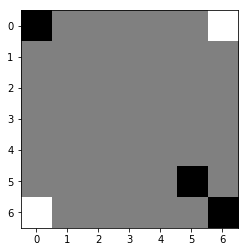

((0, 6), (1, 5)): n_v:   669 q_all:-0.016125 q:-0.011665 q_m:-0.000000 p:0.272427
((6, 0), (5, 1)): n_v:   600 q_all:-0.020475 q:-0.006026 q_m:-0.000000 p:0.255176
((0, 6), (1, 6)): n_v:   427 q_all:-0.013223 q:-0.014227 q_m:-0.000000 p:0.168853
((6, 0), (5, 0)): n_v:   416 q_all:-0.016004 q:-0.005000 q_m:-0.000000 p:0.169232
((0, 6), (0, 5)): n_v:   160 q_all:-0.020435 q:-0.024950 q_m:-0.000000 p:0.068182
((6, 0), (6, 1)): n_v:   147 q_all:-0.021819 q:-0.008134 q_m:-0.000000 p:0.063600
((0, 6), (2, 6)): n_v:     1 q_all:-0.021895 q:-0.017170 q_m:-0.033333 p:0.000442
((0, 6), (2, 4)): n_v:     0 q_all:-0.041656 q:-0.041656 q_m:-0.033333 p:0.000233
((6, 0), (6, 2)): n_v:     0 q_all:-0.023920 q:-0.023920 q_m:-0.033333 p:0.000149
((6, 0), (5, 2)): n_v:     0 q_all:-0.022509 q:-0.022509 q_m:-0.033333 p:0.000073
((6, 0), (4, 1)): n_v:     0 q_all:-0.014730 q:-0.014730 q_m:-0.033333 p:0.000203
((0, 6), (0, 4)): n_v:     0 q_all:-0.041657 q:-0.041657 q_m:-0.033333 p:0.000084
((0, 6), (2, 5))

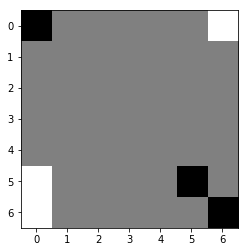

((0, 0), (1, 1)): n_v:  1056 q_all:+0.010018 q:+0.018979 q_m:+0.033333 p:0.404734
((5, 5), (6, 5)): n_v:   242 q_all:+0.001862 q:+0.004375 q_m:+0.033333 p:0.101216
((5, 5), (4, 5)): n_v:   200 q_all:-0.001990 q:+0.005161 q_m:+0.033333 p:0.087345
((0, 0), (0, 1)): n_v:   189 q_all:+0.002609 q:-0.003102 q_m:+0.033333 p:0.078694
((5, 5), (4, 4)): n_v:   178 q_all:+0.004980 q:+0.021483 q_m:+0.033333 p:0.072337
((5, 5), (4, 6)): n_v:    95 q_all:-0.000770 q:+0.017401 q_m:+0.033333 p:0.041109
((5, 5), (5, 6)): n_v:    77 q_all:+0.005415 q:+0.012817 q_m:+0.033333 p:0.031133
((0, 0), (1, 0)): n_v:    60 q_all:+0.002395 q:+0.014705 q_m:+0.033333 p:0.025052
((5, 5), (6, 4)): n_v:    40 q_all:+0.002741 q:+0.020800 q_m:+0.033333 p:0.016679
((5, 5), (5, 4)): n_v:    39 q_all:+0.005497 q:+0.024387 q_m:+0.033333 p:0.016098
((5, 5), (3, 6)): n_v:     0 q_all:-0.007594 q:-0.007594 q_m:-0.000000 p:0.000128
((5, 5), (5, 3)): n_v:     0 q_all:-0.009863 q:-0.009863 q_m:-0.000000 p:0.000037
((0, 0), (0, 2))

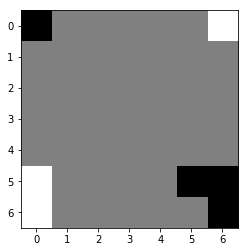

((5, 0), (4, 1)): n_v:   463 q_all:-0.023082 q:-0.002401 q_m:-0.000000 p:0.200848
((5, 0), (6, 1)): n_v:   303 q_all:-0.027374 q:-0.017705 q_m:-0.000000 p:0.137501
((5, 0), (5, 1)): n_v:   290 q_all:-0.012094 q:-0.005821 q_m:-0.000000 p:0.110925
((0, 6), (0, 5)): n_v:   234 q_all:-0.021503 q:-0.011507 q_m:-0.000000 p:0.099529
((0, 6), (1, 5)): n_v:   229 q_all:-0.012538 q:+0.003270 q_m:-0.000000 p:0.088028
((0, 6), (1, 6)): n_v:   185 q_all:-0.013793 q:+0.001978 q_m:-0.000000 p:0.072238
((5, 0), (4, 0)): n_v:   129 q_all:-0.025736 q:-0.002880 q_m:-0.000000 p:0.057781
((5, 0), (4, 2)): n_v:     0 q_all:-0.028459 q:-0.028459 q_m:-0.033333 p:0.000156
((5, 0), (3, 2)): n_v:     0 q_all:-0.027121 q:-0.027121 q_m:-0.033333 p:0.000145
((0, 6), (2, 4)): n_v:     0 q_all:-0.035714 q:-0.035714 q_m:-0.033333 p:0.000125
((6, 0), (6, 2)): n_v:     0 q_all:-0.019296 q:-0.019296 q_m:-0.033333 p:0.000158
((5, 0), (3, 1)): n_v:     0 q_all:-0.028046 q:-0.028046 q_m:-0.033333 p:0.000241
((0, 6), (2, 5))

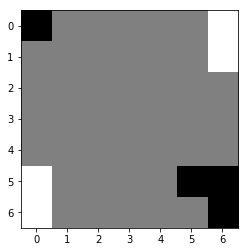

((0, 0), (1, 1)): n_v:  1086 q_all:-0.003514 q:+0.005155 q_m:+0.033333 p:0.437170
((0, 0), (0, 1)): n_v:   196 q_all:-0.009320 q:-0.016636 q_m:+0.033333 p:0.084392
((5, 5), (6, 5)): n_v:   165 q_all:-0.001587 q:-0.005849 q_m:+0.033333 p:0.065011
((5, 5), (4, 4)): n_v:   138 q_all:-0.004680 q:-0.000964 q_m:+0.033333 p:0.056532
((0, 0), (1, 0)): n_v:   112 q_all:-0.012155 q:+0.001434 q_m:+0.033333 p:0.049733
((5, 5), (4, 5)): n_v:   109 q_all:-0.006733 q:-0.018032 q_m:+0.033333 p:0.045830
((5, 5), (4, 6)): n_v:    80 q_all:+0.002143 q:+0.011634 q_m:+0.033333 p:0.030461
((5, 5), (5, 4)): n_v:    35 q_all:-0.009458 q:+0.004577 q_m:+0.033333 p:0.015259
((5, 5), (6, 4)): n_v:    23 q_all:-0.007460 q:+0.004798 q_m:+0.033333 p:0.009780
((5, 6), (5, 4)): n_v:     0 q_all:-0.017220 q:-0.017220 q_m:-0.000000 p:0.000044
((5, 6), (3, 6)): n_v:     0 q_all:-0.009337 q:-0.009337 q_m:-0.000000 p:0.000118
((5, 5), (3, 6)): n_v:     0 q_all:-0.016433 q:-0.016433 q_m:-0.000000 p:0.000141
((5, 5), (5, 3))

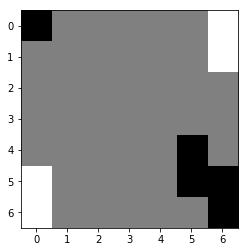

((5, 0), (4, 0)): n_v:   538 q_all:-0.010893 q:-0.006052 q_m:-0.000000 p:0.194089
((1, 6), (2, 6)): n_v:   342 q_all:-0.010911 q:-0.013144 q_m:-0.000000 p:0.123576
((5, 0), (5, 1)): n_v:   307 q_all:-0.005441 q:-0.009205 q_m:-0.000000 p:0.102975
((5, 0), (6, 1)): n_v:   239 q_all:-0.019357 q:-0.023766 q_m:-0.000000 p:0.095633
((0, 6), (0, 5)): n_v:   120 q_all:-0.025734 q:-0.018293 q_m:-0.000000 p:0.051725
((0, 6), (1, 5)): n_v:   109 q_all:-0.014533 q:-0.017690 q_m:-0.000000 p:0.041340
((5, 0), (4, 1)): n_v:    83 q_all:-0.016431 q:-0.007512 q_m:-0.000000 p:0.032169
((1, 6), (2, 5)): n_v:    50 q_all:+0.004098 q:-0.012886 q_m:-0.000000 p:0.014666
((1, 6), (3, 5)): n_v:    14 q_all:-0.060367 q:+0.004354 q_m:+0.033333 p:0.008558
((1, 6), (3, 4)): n_v:    14 q_all:-0.053521 q:+0.000655 q_m:+0.033333 p:0.008060
((6, 0), (4, 0)): n_v:    11 q_all:-0.021899 q:-0.018226 q_m:-0.033333 p:0.004918
((5, 0), (3, 1)): n_v:    10 q_all:-0.028554 q:-0.032919 q_m:-0.033333 p:0.004618
((0, 6), (2, 6))

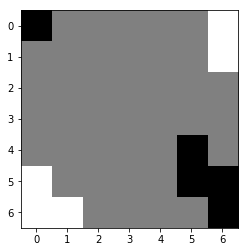

((0, 0), (1, 1)): n_v:   757 q_all:-0.006789 q:-0.016998 q_m:+0.033333 p:0.302473
((4, 5), (3, 6)): n_v:   209 q_all:+0.012536 q:-0.024368 q_m:+0.033333 p:0.064661
((4, 5), (3, 5)): n_v:   148 q_all:+0.012479 q:-0.035254 q_m:+0.033333 p:0.045985
((4, 5), (4, 4)): n_v:   144 q_all:-0.004621 q:-0.023876 q_m:+0.033333 p:0.056115
((5, 5), (6, 5)): n_v:   129 q_all:-0.009407 q:-0.041395 q_m:+0.033333 p:0.053345
((4, 5), (4, 6)): n_v:   116 q_all:-0.006476 q:-0.017491 q_m:+0.033333 p:0.046391
((4, 5), (3, 4)): n_v:    92 q_all:+0.021986 q:-0.022933 q_m:+0.033333 p:0.024620
((0, 0), (0, 1)): n_v:    79 q_all:-0.016102 q:-0.037579 q_m:+0.033333 p:0.035008
((4, 5), (5, 4)): n_v:    68 q_all:-0.013468 q:-0.025727 q_m:+0.033333 p:0.029545
((0, 0), (1, 0)): n_v:    39 q_all:-0.015701 q:-0.021397 q_m:+0.033333 p:0.017338
((5, 5), (6, 4)): n_v:    30 q_all:-0.020855 q:-0.034627 q_m:+0.033333 p:0.014050
((4, 5), (6, 5)): n_v:    12 q_all:-0.024074 q:-0.042827 q_m:-0.000000 p:0.006215
((4, 5), (4, 3))

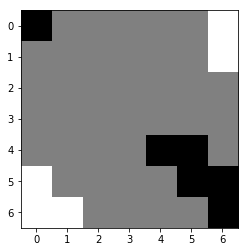

((6, 1), (5, 2)): n_v:   712 q_all:+0.020500 q:-0.013421 q_m:-0.000000 p:0.303102
((1, 6), (3, 4)): n_v:   265 q_all:-0.005864 q:+0.008452 q_m:+0.100000 p:0.146723
((5, 0), (5, 1)): n_v:   125 q_all:+0.028480 q:+0.008331 q_m:-0.000000 p:0.048640
((5, 0), (4, 0)): n_v:   106 q_all:-0.004698 q:-0.022013 q_m:-0.000000 p:0.058381
((1, 6), (3, 5)): n_v:    81 q_all:+0.012891 q:+0.030992 q_m:+0.100000 p:0.037261
((5, 0), (3, 2)): n_v:    73 q_all:-0.025859 q:-0.021822 q_m:-0.033333 p:0.047874
((1, 6), (2, 6)): n_v:    73 q_all:+0.019138 q:-0.009400 q_m:-0.000000 p:0.031914
((6, 1), (6, 2)): n_v:    65 q_all:+0.007808 q:-0.026206 q_m:-0.000000 p:0.031885
((5, 0), (4, 1)): n_v:    55 q_all:-0.010905 q:-0.026086 q_m:-0.000000 p:0.031729
((6, 1), (5, 3)): n_v:    28 q_all:-0.025079 q:+0.020811 q_m:+0.033333 p:0.018417
((0, 6), (0, 5)): n_v:    28 q_all:-0.024271 q:-0.015918 q_m:-0.000000 p:0.018113
((1, 6), (2, 5)): n_v:    26 q_all:+0.025485 q:-0.013367 q_m:-0.000000 p:0.010650
((0, 6), (1, 5))

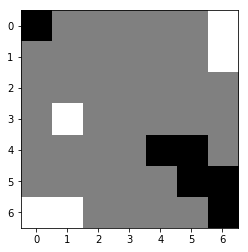

((4, 4), (4, 2)): n_v:   872 q_all:+0.035051 q:+0.033268 q_m:+0.100000 p:0.366907
((4, 4), (5, 3)): n_v:   131 q_all:+0.023250 q:-0.031443 q_m:+0.066667 p:0.062997
((4, 4), (4, 3)): n_v:    85 q_all:+0.028215 q:-0.003624 q_m:+0.066667 p:0.038762
((4, 5), (4, 6)): n_v:    83 q_all:+0.001878 q:-0.001296 q_m:+0.066667 p:0.048596
((0, 0), (1, 1)): n_v:    52 q_all:-0.022556 q:-0.000854 q_m:+0.066667 p:0.037112
((4, 4), (2, 2)): n_v:    33 q_all:+0.058832 q:+0.033998 q_m:+0.100000 p:0.010231
((5, 5), (6, 5)): n_v:    32 q_all:+0.031507 q:-0.022402 q_m:+0.066667 p:0.014359
((4, 4), (3, 3)): n_v:    30 q_all:+0.031200 q:-0.001893 q_m:+0.066667 p:0.013461
((0, 0), (2, 2)): n_v:    28 q_all:+0.041058 q:+0.022435 q_m:+0.100000 p:0.011329
((4, 4), (3, 5)): n_v:    23 q_all:+0.001187 q:-0.023992 q_m:+0.066667 p:0.013710
((0, 0), (1, 0)): n_v:    22 q_all:-0.019054 q:-0.003882 q_m:+0.066667 p:0.015279
((0, 0), (2, 0)): n_v:    20 q_all:+0.064386 q:+0.020258 q_m:+0.100000 p:0.005574
((4, 5), (2, 4))

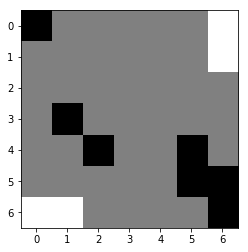

((6, 0), (4, 1)): n_v:   769 q_all:+0.061546 q:-0.013765 q_m:+0.033333 p:0.027698
((6, 1), (4, 1)): n_v:   549 q_all:+0.060450 q:-0.006427 q_m:+0.033333 p:0.022903
((6, 0), (5, 1)): n_v:   511 q_all:-0.052028 q:-0.079324 q_m:-0.000000 p:0.251961
((1, 6), (2, 6)): n_v:   138 q_all:-0.058629 q:-0.044525 q_m:-0.066667 p:0.072241
((6, 1), (5, 2)): n_v:   133 q_all:-0.094414 q:-0.068247 q_m:-0.000000 p:0.088210
((1, 6), (2, 5)): n_v:   100 q_all:-0.058580 q:-0.043176 q_m:-0.066667 p:0.052444
((6, 1), (6, 2)): n_v:    65 q_all:-0.130286 q:-0.057694 q_m:-0.066667 p:0.052953
((1, 6), (3, 4)): n_v:    53 q_all:-0.075053 q:-0.033634 q_m:-0.033333 p:0.031548
((0, 6), (1, 5)): n_v:    36 q_all:-0.098677 q:-0.048914 q_m:-0.066667 p:0.024684
((0, 6), (0, 5)): n_v:    28 q_all:-0.086194 q:-0.046874 q_m:-0.066667 p:0.017305
((6, 0), (5, 0)): n_v:    22 q_all:-0.145080 q:-0.060373 q_m:-0.066667 p:0.019276
((6, 1), (4, 3)): n_v:    22 q_all:-0.036101 q:-0.040538 q_m:-0.033333 p:0.009807
((6, 1), (5, 3))

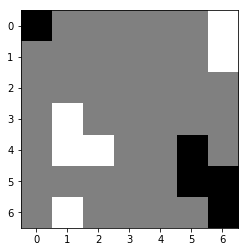

((4, 5), (3, 4)): n_v:  1085 q_all:-0.065648 q:-0.038016 q_m:-0.000000 p:0.465922
((5, 6), (3, 4)): n_v:   245 q_all:-0.085426 q:-0.068788 q_m:-0.033333 p:0.125250
((4, 5), (4, 6)): n_v:   241 q_all:-0.033398 q:-0.038905 q_m:-0.000000 p:0.071792
((5, 5), (3, 4)): n_v:   129 q_all:-0.051102 q:-0.048551 q_m:-0.033333 p:0.047543
((0, 0), (1, 1)): n_v:   100 q_all:-0.023780 q:-0.030238 q_m:-0.000000 p:0.025288
((4, 5), (3, 6)): n_v:    96 q_all:-0.017386 q:-0.048274 q_m:-0.000000 p:0.022329
((4, 5), (3, 3)): n_v:    96 q_all:+0.004339 q:+0.011745 q_m:+0.033333 p:0.013723
((4, 5), (4, 3)): n_v:    70 q_all:+0.011358 q:+0.018771 q_m:+0.033333 p:0.007469
((4, 5), (3, 5)): n_v:    41 q_all:-0.066162 q:-0.048580 q_m:-0.000000 p:0.018070
((5, 5), (3, 3)): n_v:    38 q_all:+0.001756 q:+0.003022 q_m:+0.033333 p:0.005867
((4, 5), (5, 4)): n_v:    29 q_all:-0.106225 q:-0.036688 q_m:-0.000000 p:0.017834
((4, 5), (2, 6)): n_v:    21 q_all:-0.036543 q:-0.011802 q_m:+0.033333 p:0.006311
((5, 5), (4, 3))

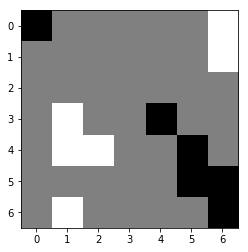

((4, 2), (4, 4)): n_v:  2505 q_all:+0.068969 q:+0.083235 q_m:+0.200000 p:0.814919
((4, 2), (2, 4)): n_v:   129 q_all:+0.007327 q:-0.007283 q_m:+0.066667 p:0.072059
((4, 2), (4, 3)): n_v:    27 q_all:+0.040268 q:+0.036482 q_m:+0.100000 p:0.011845
((4, 1), (4, 3)): n_v:    15 q_all:+0.002167 q:+0.020259 q_m:+0.066667 p:0.008769
((3, 1), (4, 3)): n_v:    14 q_all:+0.040736 q:+0.034636 q_m:+0.066667 p:0.006161
((3, 1), (2, 2)): n_v:    14 q_all:-0.067796 q:-0.035709 q_m:+0.033333 p:0.012232
((4, 2), (3, 3)): n_v:    12 q_all:+0.033425 q:+0.033139 q_m:+0.100000 p:0.005675
((4, 1), (2, 2)): n_v:    10 q_all:-0.051894 q:-0.053168 q_m:-0.000000 p:0.008122
((4, 2), (5, 4)): n_v:     9 q_all:+0.037836 q:+0.055126 q_m:+0.133333 p:0.004112
((4, 2), (5, 3)): n_v:     4 q_all:-0.031734 q:+0.017850 q_m:+0.033333 p:0.003011
((3, 1), (1, 1)): n_v:     4 q_all:-0.005128 q:+0.029680 q_m:+0.066667 p:0.002354
((3, 1), (2, 3)): n_v:     4 q_all:-0.003346 q:+0.019065 q_m:+0.066667 p:0.002947
((1, 6), (3, 5))

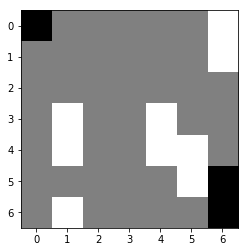

((6, 6), (5, 4)): n_v:  2488 q_all:-0.063366 q:-0.061351 q_m:-0.000000 p:0.633881
((5, 6), (5, 4)): n_v:   938 q_all:-0.057892 q:-0.080454 q_m:-0.000000 p:0.223425
((5, 6), (3, 5)): n_v:   484 q_all:-0.055123 q:-0.109597 q_m:-0.000000 p:0.111090
((5, 6), (4, 6)): n_v:    25 q_all:-0.103870 q:-0.122658 q_m:-0.033333 p:0.009600
((6, 6), (4, 6)): n_v:    15 q_all:-0.089315 q:-0.140285 q_m:-0.066667 p:0.005101
((0, 0), (1, 2)): n_v:     9 q_all:-0.193293 q:-0.228925 q_m:-0.200000 p:0.006058
((5, 6), (6, 5)): n_v:     6 q_all:-0.130916 q:-0.181071 q_m:-0.100000 p:0.003087
((0, 0), (2, 2)): n_v:     2 q_all:-0.174833 q:-0.165381 q_m:-0.133333 p:0.001542
((6, 6), (6, 4)): n_v:     0 q_all:-0.212518 q:-0.212518 q_m:-0.133333 p:0.000625
((5, 6), (3, 6)): n_v:     0 q_all:-0.187007 q:-0.187007 q_m:-0.133333 p:0.000291
((0, 0), (0, 2)): n_v:     0 q_all:-0.223984 q:-0.223984 q_m:-0.200000 p:0.000048
((0, 0), (0, 1)): n_v:     0 q_all:-0.210519 q:-0.210519 q_m:-0.166667 p:0.000510
((0, 0), (1, 1))

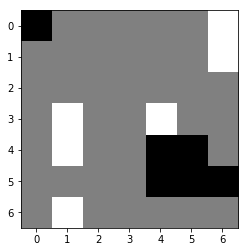

((3, 4), (5, 3)): n_v:  1421 q_all:+0.058914 q:+0.100448 q_m:+0.133333 p:0.376674
((3, 4), (4, 6)): n_v:   874 q_all:+0.121569 q:+0.108024 q_m:+0.200000 p:0.060480
((3, 4), (4, 3)): n_v:   303 q_all:+0.077300 q:+0.085040 q_m:+0.166667 p:0.063111
((3, 4), (1, 3)): n_v:   133 q_all:-0.010750 q:-0.000200 q_m:-0.000000 p:0.064602
((3, 4), (1, 5)): n_v:    89 q_all:-0.009230 q:-0.007303 q_m:-0.000000 p:0.042971
((3, 1), (4, 0)): n_v:    84 q_all:+0.024788 q:-0.007968 q_m:+0.033333 p:0.031316
((3, 4), (2, 6)): n_v:    68 q_all:+0.014403 q:+0.002385 q_m:-0.000000 p:0.027690
((3, 1), (1, 1)): n_v:    64 q_all:+0.046309 q:+0.034109 q_m:+0.066667 p:0.019700
((3, 4), (5, 2)): n_v:    56 q_all:-0.028677 q:+0.005702 q_m:-0.000000 p:0.030310
((3, 4), (2, 3)): n_v:    49 q_all:-0.004355 q:+0.001984 q_m:+0.033333 p:0.022836
((4, 1), (5, 3)): n_v:    48 q_all:+0.038059 q:+0.074084 q_m:+0.133333 p:0.015963
((4, 1), (4, 3)): n_v:    44 q_all:+0.052050 q:+0.048364 q_m:+0.133333 p:0.012527
((3, 1), (1, 0))

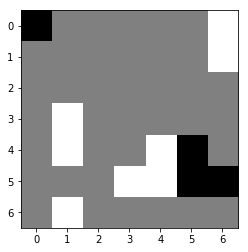

((4, 5), (4, 3)): n_v:  1676 q_all:+0.015189 q:-0.015261 q_m:+0.066667 p:0.567861
((5, 5), (4, 3)): n_v:   871 q_all:+0.008355 q:-0.031639 q_m:+0.066667 p:0.316405
((5, 5), (6, 4)): n_v:    65 q_all:-0.117238 q:-0.086111 q_m:+0.033333 p:0.053152
((4, 5), (3, 4)): n_v:    29 q_all:-0.112793 q:-0.111536 q_m:-0.033333 p:0.023077
((4, 5), (6, 3)): n_v:    18 q_all:-0.049867 q:-0.102945 q_m:-0.000000 p:0.010660
((4, 5), (2, 3)): n_v:    10 q_all:-0.137718 q:-0.144770 q_m:-0.133333 p:0.008991
((5, 5), (6, 3)): n_v:     9 q_all:-0.050051 q:-0.089262 q_m:-0.000000 p:0.005556
((4, 5), (6, 4)): n_v:     2 q_all:-0.168281 q:-0.136876 q_m:-0.000000 p:0.002940
((4, 5), (3, 5)): n_v:     2 q_all:-0.079165 q:-0.098374 q_m:-0.033333 p:0.001608
((0, 0), (1, 1)): n_v:     1 q_all:-0.135138 q:-0.132856 q_m:-0.100000 p:0.001125
((5, 5), (6, 5)): n_v:     0 q_all:-0.153635 q:-0.153635 q_m:-0.033333 p:0.000549
((4, 5), (3, 6)): n_v:     0 q_all:-0.162915 q:-0.162915 q_m:-0.100000 p:0.000215
((4, 5), (4, 6))

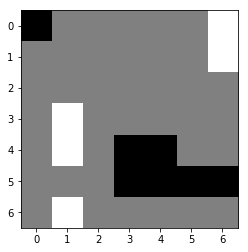

((3, 1), (3, 3)): n_v:   669 q_all:+0.015606 q:+0.065774 q_m:+0.066667 p:0.112380
((1, 6), (2, 5)): n_v:   517 q_all:+0.007624 q:+0.032420 q_m:-0.033333 p:0.101366
((4, 1), (3, 3)): n_v:   354 q_all:+0.004933 q:+0.047982 q_m:+0.066667 p:0.072735
((3, 1), (2, 1)): n_v:   166 q_all:-0.015292 q:-0.012112 q_m:-0.033333 p:0.045740
((4, 1), (6, 3)): n_v:   154 q_all:-0.006749 q:+0.042247 q_m:+0.066667 p:0.037886
((4, 1), (5, 2)): n_v:   148 q_all:-0.036749 q:+0.045341 q_m:+0.100000 p:0.051952
((6, 1), (6, 2)): n_v:   143 q_all:-0.018205 q:+0.041821 q_m:+0.033333 p:0.040814
((3, 1), (4, 2)): n_v:   133 q_all:-0.018136 q:+0.047701 q_m:+0.100000 p:0.037972
((3, 1), (3, 2)): n_v:    69 q_all:-0.007426 q:+0.047665 q_m:+0.033333 p:0.017121
((3, 1), (1, 1)): n_v:    64 q_all:-0.012222 q:+0.038478 q_m:-0.000000 p:0.017038
((6, 1), (6, 3)): n_v:    58 q_all:-0.002550 q:+0.038308 q_m:+0.066667 p:0.013555
((3, 1), (5, 1)): n_v:    46 q_all:-0.100830 q:-0.011187 q_m:-0.066667 p:0.026588
((3, 1), (5, 2))

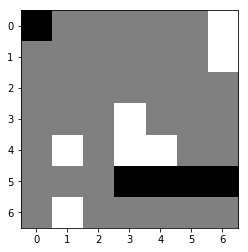

((5, 6), (3, 4)): n_v:   795 q_all:+0.039040 q:+0.013718 q_m:+0.133333 p:0.306819
((5, 5), (3, 4)): n_v:   538 q_all:+0.030745 q:+0.012888 q_m:+0.133333 p:0.226243
((5, 4), (3, 2)): n_v:   293 q_all:-0.004761 q:+0.022279 q_m:+0.133333 p:0.167347
((5, 3), (5, 2)): n_v:   249 q_all:+0.026994 q:+0.053072 q_m:+0.166667 p:0.108751
((5, 3), (3, 4)): n_v:   101 q_all:+0.017061 q:+0.023760 q_m:+0.133333 p:0.048603
((5, 4), (3, 4)): n_v:    78 q_all:+0.035004 q:+0.002769 q_m:+0.133333 p:0.031754
((5, 3), (3, 2)): n_v:    74 q_all:-0.016905 q:+0.040249 q_m:+0.133333 p:0.046494
((5, 3), (4, 2)): n_v:    44 q_all:+0.015905 q:+0.011879 q_m:+0.166667 p:0.021621
((5, 4), (5, 2)): n_v:    13 q_all:+0.018546 q:+0.031971 q_m:+0.133333 p:0.006554
((5, 4), (4, 2)): n_v:     9 q_all:+0.005349 q:+0.009476 q_m:+0.133333 p:0.004717
((5, 3), (6, 2)): n_v:     4 q_all:-0.025863 q:-0.039166 q_m:+0.033333 p:0.003064
((0, 0), (1, 2)): n_v:     3 q_all:-0.111740 q:-0.066681 q_m:-0.066667 p:0.003380
((5, 3), (6, 4))

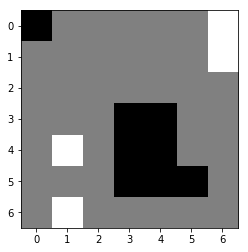

((4, 1), (4, 2)): n_v:   887 q_all:-0.025338 q:+0.043671 q_m:+0.100000 p:0.387725
((1, 6), (2, 5)): n_v:   350 q_all:-0.008252 q:+0.026562 q_m:-0.033333 p:0.128750
((4, 1), (2, 3)): n_v:   280 q_all:+0.003198 q:+0.000553 q_m:-0.000000 p:0.089724
((4, 1), (3, 2)): n_v:   153 q_all:-0.010245 q:+0.025857 q_m:+0.033333 p:0.057530
((0, 6), (2, 5)): n_v:   117 q_all:-0.002924 q:+0.015278 q_m:-0.066667 p:0.040478
((6, 1), (4, 2)): n_v:   115 q_all:-0.015477 q:+0.042867 q_m:+0.066667 p:0.045681
((4, 1), (3, 1)): n_v:    94 q_all:-0.016565 q:-0.018077 q_m:-0.100000 p:0.037989
((1, 6), (3, 5)): n_v:    61 q_all:-0.002039 q:+0.042608 q_m:-0.000000 p:0.021023
((1, 6), (2, 4)): n_v:    59 q_all:+0.020602 q:+0.005557 q_m:-0.000000 p:0.014768
((4, 1), (5, 2)): n_v:    43 q_all:-0.036164 q:+0.025868 q_m:+0.033333 p:0.020647
((0, 6), (2, 4)): n_v:    42 q_all:+0.012304 q:+0.010177 q_m:-0.000000 p:0.011971
((4, 1), (2, 1)): n_v:    32 q_all:-0.071131 q:-0.034782 q_m:-0.133333 p:0.020360
((4, 1), (2, 2))

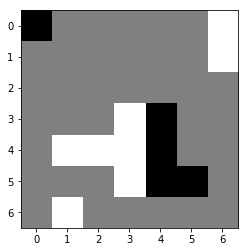

((3, 4), (5, 2)): n_v:  1184 q_all:+0.040804 q:+0.086006 q_m:+0.233333 p:0.401264
((4, 4), (5, 2)): n_v:   370 q_all:+0.032483 q:+0.081168 q_m:+0.233333 p:0.137622
((5, 4), (3, 2)): n_v:   353 q_all:+0.012458 q:+0.024524 q_m:+0.166667 p:0.158719
((3, 4), (3, 2)): n_v:   289 q_all:+0.038171 q:+0.029369 q_m:+0.166667 p:0.101166
((5, 4), (5, 2)): n_v:   234 q_all:+0.032641 q:+0.061676 q_m:+0.233333 p:0.086456
((3, 4), (1, 2)): n_v:    78 q_all:-0.051888 q:-0.080373 q_m:-0.100000 p:0.054451
((4, 4), (3, 2)): n_v:    71 q_all:-0.028186 q:+0.027207 q_m:+0.166667 p:0.043632
((0, 0), (1, 2)): n_v:     8 q_all:-0.081363 q:-0.078685 q_m:-0.100000 p:0.007096
((5, 4), (6, 4)): n_v:     1 q_all:-0.101333 q:-0.070509 q_m:-0.000000 p:0.001656
((3, 4), (1, 5)): n_v:     1 q_all:+0.063743 q:+0.015667 q_m:+0.033333 p:0.000467
((4, 4), (6, 5)): n_v:     1 q_all:-0.083125 q:-0.067091 q_m:-0.100000 p:0.001218
((4, 4), (6, 3)): n_v:     0 q_all:-0.073739 q:-0.073739 q_m:-0.033333 p:0.000521
((4, 4), (6, 6))

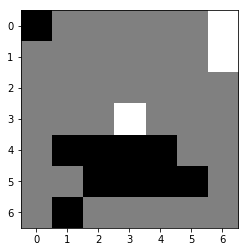

((3, 3), (5, 1)): n_v:  1355 q_all:-0.010286 q:+0.007086 q_m:+0.033333 p:0.385806
((3, 3), (3, 2)): n_v:   488 q_all:-0.032426 q:-0.047904 q_m:-0.000000 p:0.180193
((3, 3), (3, 4)): n_v:   409 q_all:-0.072440 q:-0.082370 q_m:-0.066667 p:0.213315
((3, 3), (1, 1)): n_v:   230 q_all:-0.054989 q:-0.086036 q_m:-0.166667 p:0.104684
((3, 3), (1, 5)): n_v:   105 q_all:-0.106911 q:-0.144600 q_m:-0.233333 p:0.068986
((3, 3), (4, 5)): n_v:    44 q_all:-0.021744 q:-0.018506 q_m:-0.033333 p:0.014675
((3, 3), (2, 5)): n_v:    16 q_all:-0.054610 q:-0.117542 q_m:-0.233333 p:0.007546
((3, 3), (3, 1)): n_v:     7 q_all:-0.119573 q:-0.095251 q_m:-0.100000 p:0.005074
((3, 3), (2, 1)): n_v:     6 q_all:-0.117777 q:-0.134360 q_m:-0.233333 p:0.004217
((1, 6), (3, 4)): n_v:     6 q_all:-0.106278 q:-0.120853 q_m:-0.100000 p:0.004199
((3, 3), (3, 5)): n_v:     5 q_all:-0.110648 q:-0.110432 q_m:-0.166667 p:0.003678
((0, 6), (1, 5)): n_v:     4 q_all:-0.094235 q:-0.138257 q_m:-0.200000 p:0.002627
((1, 6), (0, 4))

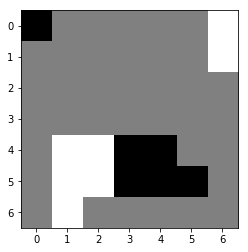

((5, 3), (6, 2)): n_v:  2101 q_all:+0.042528 q:+0.041384 q_m:+0.200000 p:0.442861
((5, 3), (6, 4)): n_v:   488 q_all:-0.047993 q:-0.073612 q_m:-0.000000 p:0.261682
((4, 3), (6, 2)): n_v:   192 q_all:+0.014950 q:+0.011589 q_m:+0.166667 p:0.059631
((4, 3), (6, 4)): n_v:    51 q_all:-0.091479 q:-0.092369 q_m:-0.033333 p:0.035650
((4, 4), (6, 2)): n_v:    50 q_all:+0.020424 q:+0.026542 q_m:+0.166667 p:0.014681
((5, 4), (6, 2)): n_v:    48 q_all:+0.029454 q:+0.021038 q_m:+0.166667 p:0.012322
((4, 3), (3, 2)): n_v:    23 q_all:+0.018788 q:-0.008635 q_m:+0.133333 p:0.007038
((5, 5), (5, 6)): n_v:    12 q_all:-0.032436 q:-0.038839 q_m:-0.000000 p:0.006152
((4, 4), (6, 4)): n_v:     4 q_all:-0.069308 q:-0.099957 q_m:-0.033333 p:0.002595
((4, 4), (5, 6)): n_v:     3 q_all:-0.080765 q:-0.051584 q_m:-0.033333 p:0.002416
((4, 3), (3, 4)): n_v:     3 q_all:-0.072101 q:-0.048939 q_m:-0.000000 p:0.002279
((4, 4), (3, 5)): n_v:     2 q_all:-0.045241 q:-0.046950 q_m:-0.000000 p:0.001558
((5, 3), (6, 3))

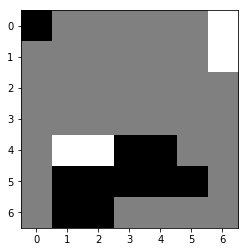

((4, 1), (5, 0)): n_v:  1336 q_all:-0.027476 q:-0.053478 q_m:-0.033333 p:0.333426
((4, 2), (6, 3)): n_v:  1293 q_all:-0.030657 q:-0.029725 q_m:+0.066667 p:0.335656
((4, 1), (6, 3)): n_v:   810 q_all:-0.051688 q:-0.037326 q_m:+0.066667 p:0.265325
((4, 2), (6, 4)): n_v:    55 q_all:-0.052746 q:-0.063022 q_m:-0.000000 p:0.018389
((4, 2), (6, 0)): n_v:    45 q_all:-0.065320 q:-0.089956 q_m:-0.066667 p:0.016202
((4, 1), (6, 0)): n_v:    32 q_all:-0.008522 q:-0.095821 q_m:-0.066667 p:0.006155
((4, 2), (5, 0)): n_v:    20 q_all:-0.068789 q:-0.062793 q_m:-0.066667 p:0.007576
((4, 2), (3, 3)): n_v:    11 q_all:-0.078464 q:-0.059592 q_m:-0.033333 p:0.004588
((4, 1), (4, 0)): n_v:     5 q_all:-0.136248 q:-0.106420 q_m:-0.100000 p:0.003334
((1, 6), (2, 5)): n_v:     3 q_all:-0.137134 q:-0.087903 q_m:-0.166667 p:0.001951
((1, 6), (2, 6)): n_v:     1 q_all:-0.124932 q:-0.101144 q_m:-0.166667 p:0.000863
((0, 6), (0, 5)): n_v:     1 q_all:-0.150598 q:-0.111688 q_m:-0.166667 p:0.001056
((4, 2), (3, 4))

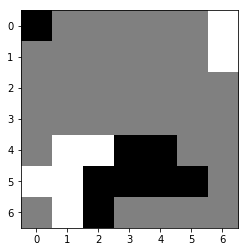

((6, 2), (4, 0)): n_v:  1484 q_all:+0.055886 q:+0.090166 q_m:+0.233333 p:0.293384
((4, 4), (6, 6)): n_v:   419 q_all:-0.052190 q:-0.015976 q_m:+0.033333 p:0.246115
((6, 2), (6, 0)): n_v:   237 q_all:+0.063694 q:+0.079055 q_m:+0.233333 p:0.040297
((5, 5), (4, 6)): n_v:   229 q_all:-0.035907 q:+0.015742 q_m:+0.066667 p:0.120900
((5, 5), (6, 6)): n_v:   114 q_all:-0.038902 q:+0.010535 q_m:+0.066667 p:0.061706
((4, 3), (3, 2)): n_v:    82 q_all:+0.039606 q:+0.025708 q_m:+0.200000 p:0.020946
((5, 2), (4, 0)): n_v:    77 q_all:+0.046431 q:+0.048276 q_m:+0.233333 p:0.018000
((4, 4), (4, 6)): n_v:    35 q_all:-0.048398 q:-0.003880 q_m:+0.033333 p:0.019757
((5, 4), (6, 5)): n_v:    33 q_all:-0.029970 q:+0.003167 q_m:+0.066667 p:0.016867
((4, 4), (3, 5)): n_v:    31 q_all:-0.023753 q:+0.001480 q_m:+0.066667 p:0.015454
((5, 4), (4, 6)): n_v:    31 q_all:-0.027802 q:+0.003886 q_m:+0.033333 p:0.015779
((4, 3), (3, 4)): n_v:    20 q_all:-0.042548 q:-0.019952 q_m:+0.066667 p:0.011346
((5, 2), (6, 3))

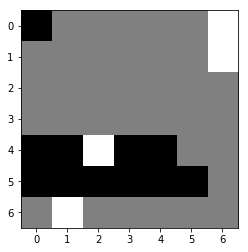

((6, 1), (6, 0)): n_v:  1599 q_all:-0.026658 q:-0.049213 q_m:-0.066667 p:0.474148
((4, 2), (6, 0)): n_v:   957 q_all:-0.019690 q:-0.078776 q_m:-0.100000 p:0.260467
((6, 1), (6, 2)): n_v:   358 q_all:-0.085839 q:-0.057254 q_m:-0.000000 p:0.180930
((4, 2), (3, 1)): n_v:   115 q_all:-0.084777 q:-0.092052 q_m:-0.066667 p:0.057931
((4, 2), (6, 2)): n_v:    19 q_all:-0.081870 q:-0.104764 q_m:-0.033333 p:0.009525
((4, 2), (6, 4)): n_v:    16 q_all:-0.045262 q:-0.077038 q_m:-0.033333 p:0.006116
((4, 2), (3, 3)): n_v:     5 q_all:-0.096799 q:-0.104939 q_m:-0.066667 p:0.002784
((1, 6), (3, 5)): n_v:     2 q_all:-0.144453 q:-0.151332 q_m:-0.166667 p:0.002049
((1, 6), (2, 5)): n_v:     1 q_all:-0.098372 q:-0.134829 q_m:-0.200000 p:0.000783
((6, 1), (6, 3)): n_v:     1 q_all:-0.096918 q:-0.070169 q_m:-0.033333 p:0.000838
((4, 2), (3, 2)): n_v:     1 q_all:-0.104347 q:-0.117009 q_m:-0.066667 p:0.000874
((1, 6), (0, 4)): n_v:     0 q_all:-0.195643 q:-0.195643 q_m:-0.233333 p:0.000042
((4, 2), (2, 0))

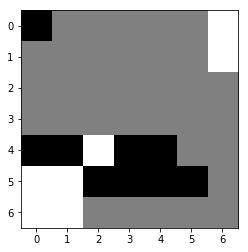

((5, 2), (6, 2)): n_v:  1390 q_all:+0.061332 q:+0.080145 q_m:+0.233333 p:0.172521
((5, 3), (6, 4)): n_v:   588 q_all:+0.006885 q:-0.010590 q_m:+0.100000 p:0.185639
((4, 0), (3, 1)): n_v:   414 q_all:+0.095913 q:+0.026545 q_m:+0.166667 p:0.001022
((4, 3), (6, 2)): n_v:   167 q_all:+0.028248 q:+0.036049 q_m:+0.200000 p:0.040119
((4, 0), (6, 2)): n_v:   130 q_all:+0.024134 q:+0.035581 q_m:+0.200000 p:0.033331
((4, 3), (6, 4)): n_v:    97 q_all:-0.035443 q:-0.061395 q_m:+0.066667 p:0.045382
((4, 1), (6, 2)): n_v:    59 q_all:+0.015622 q:+0.015111 q_m:+0.200000 p:0.016957
((4, 4), (6, 4)): n_v:    34 q_all:-0.021846 q:-0.043175 q_m:+0.066667 p:0.014284
((5, 5), (4, 6)): n_v:    29 q_all:+0.015369 q:+0.025040 q_m:+0.100000 p:0.008236
((4, 3), (3, 3)): n_v:    23 q_all:+0.080756 q:+0.015100 q_m:+0.166667 p:0.001291
((5, 5), (6, 6)): n_v:    23 q_all:-0.001396 q:+0.020591 q_m:+0.100000 p:0.007929
((5, 5), (5, 6)): n_v:    21 q_all:+0.016850 q:+0.024688 q_m:+0.100000 p:0.005864
((4, 4), (6, 2))

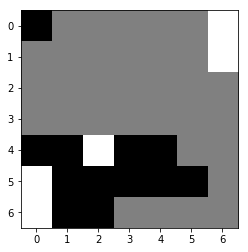

((4, 2), (6, 3)): n_v:  2302 q_all:-0.023198 q:-0.022733 q_m:+0.033333 p:0.662719
((4, 2), (3, 1)): n_v:   187 q_all:-0.105725 q:-0.062997 q_m:-0.066667 p:0.109029
((4, 2), (6, 4)): n_v:   156 q_all:-0.071729 q:-0.062390 q_m:-0.033333 p:0.072302
((4, 2), (3, 3)): n_v:    61 q_all:-0.090736 q:-0.082100 q_m:-0.066667 p:0.032477
((4, 2), (3, 2)): n_v:    48 q_all:-0.088435 q:-0.076824 q_m:-0.066667 p:0.025393
((5, 0), (3, 1)): n_v:    33 q_all:-0.126581 q:-0.120737 q_m:-0.100000 p:0.021520
((4, 2), (3, 4)): n_v:    24 q_all:-0.038836 q:-0.071860 q_m:-0.100000 p:0.008463
((1, 6), (2, 5)): n_v:    16 q_all:-0.058337 q:-0.113893 q_m:-0.200000 p:0.006658
((1, 6), (3, 5)): n_v:    14 q_all:-0.111248 q:-0.118299 q_m:-0.166667 p:0.008584
((4, 2), (2, 1)): n_v:    14 q_all:-0.090276 q:-0.123404 q_m:-0.233333 p:0.007797
((4, 2), (2, 3)): n_v:    13 q_all:-0.064017 q:-0.132810 q_m:-0.233333 p:0.005850
((1, 6), (2, 6)): n_v:    10 q_all:-0.055520 q:-0.128971 q_m:-0.200000 p:0.004204
((4, 2), (2, 4))

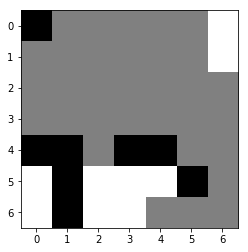

((5, 5), (6, 4)): n_v:  1692 q_all:+0.015015 q:+0.071147 q_m:+0.200000 p:0.441265
((4, 3), (6, 4)): n_v:  1460 q_all:+0.052903 q:+0.043000 q_m:+0.166667 p:0.207473
((4, 1), (4, 2)): n_v:   502 q_all:+0.006801 q:+0.021466 q_m:+0.133333 p:0.144108
((4, 4), (6, 4)): n_v:    31 q_all:+0.013511 q:+0.033314 q_m:+0.166667 p:0.008402
((4, 3), (6, 5)): n_v:    26 q_all:-0.047463 q:-0.008448 q_m:+0.033333 p:0.011999
((4, 4), (4, 2)): n_v:     6 q_all:-0.032748 q:-0.016377 q_m:+0.100000 p:0.002745
((4, 4), (6, 6)): n_v:     5 q_all:-0.062854 q:-0.072698 q_m:-0.033333 p:0.002960
((4, 0), (4, 2)): n_v:     5 q_all:-0.031816 q:-0.021066 q_m:+0.100000 p:0.002122
((4, 3), (4, 5)): n_v:     4 q_all:-0.000754 q:+0.002170 q_m:+0.033333 p:0.001369
((4, 4), (4, 5)): n_v:     3 q_all:-0.025589 q:-0.004773 q_m:+0.066667 p:0.001257
((5, 5), (6, 5)): n_v:     1 q_all:-0.023877 q:+0.005865 q_m:+0.066667 p:0.000571
((6, 1), (4, 2)): n_v:     1 q_all:-0.007318 q:-0.012485 q_m:+0.100000 p:0.000506
((5, 5), (4, 6))

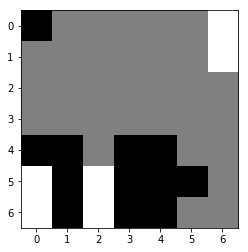

((5, 2), (4, 2)): n_v:  2824 q_all:+0.030069 q:+0.009323 q_m:+0.100000 p:0.800306
((5, 0), (4, 2)): n_v:   196 q_all:-0.084851 q:-0.074283 q_m:+0.066667 p:0.132772
((6, 0), (4, 2)): n_v:    95 q_all:-0.036089 q:-0.003665 q_m:+0.066667 p:0.048739
((6, 2), (4, 2)): n_v:    19 q_all:-0.041446 q:-0.051493 q_m:+0.066667 p:0.010245
((1, 6), (2, 4)): n_v:     2 q_all:-0.143807 q:-0.130909 q_m:-0.200000 p:0.002459
((0, 6), (2, 4)): n_v:     1 q_all:-0.145102 q:-0.135841 q_m:-0.200000 p:0.001267
((1, 6), (0, 4)): n_v:     0 q_all:-0.149548 q:-0.149548 q_m:-0.200000 p:0.000005
((5, 0), (3, 2)): n_v:     0 q_all:-0.127061 q:-0.127061 q_m:-0.066667 p:0.000691
((1, 6), (2, 6)): n_v:     0 q_all:-0.098988 q:-0.098988 q_m:-0.166667 p:0.000085
((1, 6), (3, 5)): n_v:     0 q_all:-0.076776 q:-0.076776 q_m:-0.133333 p:0.000220
((5, 2), (3, 2)): n_v:     0 q_all:-0.062154 q:-0.062154 q_m:-0.066667 p:0.000272
((1, 6), (3, 4)): n_v:     0 q_all:-0.104571 q:-0.104571 q_m:-0.066667 p:0.000293
((5, 0), (3, 0))

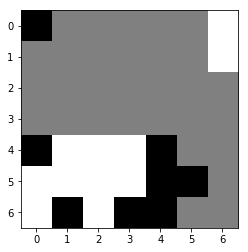

((4, 4), (3, 3)): n_v:  2087 q_all:-0.034089 q:-0.000468 q_m:+0.066667 p:0.541142
((4, 4), (3, 2)): n_v:   577 q_all:+0.003786 q:-0.007997 q_m:+0.100000 p:0.085319
((4, 4), (3, 4)): n_v:   437 q_all:-0.052767 q:-0.024306 q_m:-0.000000 p:0.137429
((4, 0), (3, 1)): n_v:   272 q_all:-0.005442 q:-0.001446 q_m:+0.066667 p:0.047531
((4, 0), (3, 2)): n_v:   236 q_all:+0.017431 q:-0.000635 q_m:+0.100000 p:0.025309
((5, 5), (5, 6)): n_v:    50 q_all:-0.084159 q:-0.017689 q_m:-0.066667 p:0.020749
((4, 4), (3, 5)): n_v:    44 q_all:-0.054201 q:-0.019027 q_m:-0.066667 p:0.014154
((5, 5), (6, 6)): n_v:    43 q_all:-0.092383 q:-0.032210 q_m:-0.066667 p:0.018542
((5, 5), (4, 6)): n_v:    32 q_all:-0.060297 q:-0.019309 q_m:-0.066667 p:0.010885
((4, 4), (2, 2)): n_v:    31 q_all:-0.105220 q:-0.049533 q_m:-0.100000 p:0.015012
((4, 0), (3, 0)): n_v:    26 q_all:-0.053898 q:-0.001546 q_m:-0.000000 p:0.008446
((5, 4), (6, 5)): n_v:    26 q_all:-0.011341 q:-0.014548 q_m:-0.066667 p:0.005065
((5, 4), (3, 2))

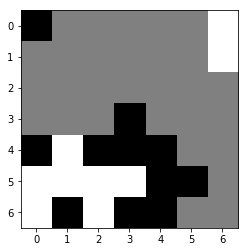

((4, 1), (3, 2)): n_v:  3275 q_all:+0.031558 q:+0.053916 q_m:+0.166667 p:0.901163
((1, 6), (3, 4)): n_v:   131 q_all:+0.004055 q:+0.014209 q_m:+0.133333 p:0.047859
((5, 0), (3, 2)): n_v:    85 q_all:-0.016311 q:-0.021573 q_m:+0.133333 p:0.036646
((5, 1), (3, 2)): n_v:    10 q_all:-0.123945 q:-0.071821 q_m:+0.133333 p:0.008047
((5, 2), (3, 4)): n_v:     4 q_all:-0.079924 q:-0.043511 q_m:+0.133333 p:0.002586
((5, 3), (6, 5)): n_v:     1 q_all:-0.044641 q:-0.005617 q_m:+0.133333 p:0.000528
((5, 2), (3, 2)): n_v:     1 q_all:-0.064105 q:-0.040338 q_m:+0.133333 p:0.000607
((4, 1), (3, 1)): n_v:     1 q_all:-0.002755 q:-0.001360 q_m:+0.100000 p:0.000496
((5, 3), (3, 4)): n_v:     0 q_all:-0.025595 q:-0.025595 q_m:+0.133333 p:0.000382
((1, 6), (0, 4)): n_v:     0 q_all:-0.039668 q:-0.039668 q_m:-0.066667 p:0.000000
((1, 6), (2, 6)): n_v:     0 q_all:-0.006210 q:-0.006210 q_m:-0.033333 p:0.000023
((5, 3), (3, 1)): n_v:     0 q_all:-0.042982 q:-0.042982 q_m:+0.066667 p:0.000014
((0, 6), (2, 4))

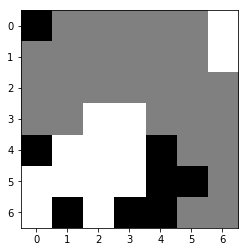

((4, 0), (3, 1)): n_v:  2830 q_all:-0.000656 q:-0.013041 q_m:+0.066667 p:0.515014
((4, 4), (3, 4)): n_v:   949 q_all:-0.029158 q:-0.037878 q_m:-0.000000 p:0.248893
((4, 4), (3, 5)): n_v:   131 q_all:-0.143650 q:-0.122848 q_m:-0.133333 p:0.077086
((4, 4), (2, 2)): n_v:   116 q_all:-0.092211 q:-0.095074 q_m:-0.033333 p:0.051302
((0, 0), (2, 2)): n_v:    70 q_all:-0.092157 q:-0.088280 q_m:-0.033333 p:0.030817
((4, 0), (3, 0)): n_v:    26 q_all:-0.145730 q:-0.108005 q_m:-0.066667 p:0.015783
((4, 0), (2, 2)): n_v:    26 q_all:-0.059260 q:-0.093176 q_m:-0.033333 p:0.009114
((5, 5), (3, 4)): n_v:    17 q_all:-0.039478 q:-0.056073 q_m:-0.033333 p:0.004943
((5, 5), (6, 6)): n_v:    11 q_all:-0.157827 q:-0.122749 q_m:-0.133333 p:0.007205
((0, 0), (1, 1)): n_v:     7 q_all:-0.079928 q:-0.092165 q_m:-0.133333 p:0.002956
((5, 4), (6, 5)): n_v:     6 q_all:-0.100343 q:-0.105229 q_m:-0.133333 p:0.003004
((5, 5), (5, 6)): n_v:     6 q_all:-0.169869 q:-0.114401 q_m:-0.133333 p:0.004594
((5, 5), (4, 6))

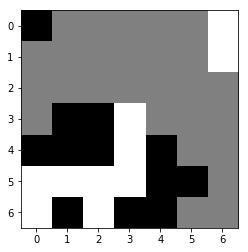

((3, 3), (4, 5)): n_v:  1337 q_all:+0.030794 q:+0.046644 q_m:+0.133333 p:0.174074
((4, 3), (6, 5)): n_v:   700 q_all:-0.007401 q:+0.007766 q_m:+0.133333 p:0.171514
((3, 3), (2, 2)): n_v:   430 q_all:+0.015329 q:+0.015224 q_m:+0.100000 p:0.075973
((3, 3), (3, 4)): n_v:   391 q_all:+0.003194 q:-0.015245 q_m:+0.033333 p:0.083502
((3, 3), (2, 5)): n_v:   240 q_all:-0.019831 q:-0.021149 q_m:-0.066667 p:0.068049
((3, 3), (2, 1)): n_v:   145 q_all:+0.018378 q:-0.007376 q_m:+0.066667 p:0.024300
((1, 6), (2, 5)): n_v:   144 q_all:-0.046048 q:-0.023301 q_m:-0.033333 p:0.052214
((3, 3), (2, 4)): n_v:   134 q_all:-0.058479 q:-0.042345 q_m:-0.033333 p:0.053791
((4, 3), (4, 5)): n_v:    89 q_all:-0.042031 q:-0.000438 q_m:+0.133333 p:0.031286
((3, 3), (1, 5)): n_v:    46 q_all:-0.015724 q:-0.040338 q_m:-0.066667 p:0.012558
((5, 0), (3, 0)): n_v:    41 q_all:-0.087166 q:-0.071495 q_m:+0.133333 p:0.020278
((3, 3), (2, 3)): n_v:    40 q_all:-0.018177 q:-0.008432 q_m:+0.033333 p:0.011177
((5, 3), (6, 5))

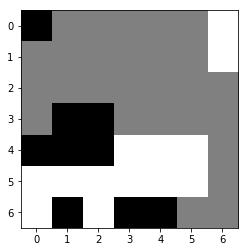

((3, 2), (3, 4)): n_v:  2151 q_all:-0.026165 q:-0.021628 q_m:+0.066667 p:0.634873
((3, 2), (3, 3)): n_v:   221 q_all:-0.063144 q:-0.009018 q_m:+0.033333 p:0.094571
((4, 2), (3, 4)): n_v:   163 q_all:-0.061963 q:-0.053173 q_m:+0.066667 p:0.069488
((6, 4), (6, 5)): n_v:    99 q_all:-0.028972 q:+0.001820 q_m:+0.033333 p:0.030396
((6, 4), (5, 6)): n_v:    49 q_all:-0.036929 q:-0.005568 q_m:-0.000000 p:0.016621
((6, 3), (6, 5)): n_v:    34 q_all:-0.049757 q:-0.035656 q_m:-0.000000 p:0.013242
((3, 2), (2, 4)): n_v:    20 q_all:-0.086170 q:-0.091702 q_m:-0.133333 p:0.010462
((3, 1), (3, 3)): n_v:    17 q_all:-0.085759 q:-0.047159 q_m:-0.000000 p:0.009086
((6, 4), (4, 6)): n_v:    14 q_all:-0.050236 q:-0.037393 q_m:-0.000000 p:0.005625
((3, 1), (1, 0)): n_v:    12 q_all:-0.068923 q:-0.090478 q_m:-0.133333 p:0.005680
((4, 2), (2, 4)): n_v:     5 q_all:-0.098520 q:-0.122376 q_m:-0.133333 p:0.003151
((3, 2), (1, 0)): n_v:     5 q_all:-0.114771 q:-0.093950 q_m:-0.133333 p:0.002963
((3, 1), (3, 0))

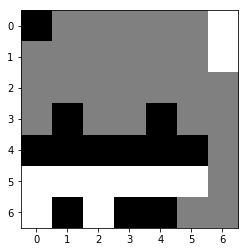

((1, 6), (3, 5)): n_v:  1666 q_all:+0.032290 q:+0.051218 q_m:+0.133333 p:0.377875
((5, 0), (3, 2)): n_v:  1259 q_all:+0.002952 q:-0.018713 q_m:+0.200000 p:0.403769
((5, 5), (3, 3)): n_v:   329 q_all:+0.029408 q:+0.017048 q_m:+0.200000 p:0.077828
((5, 4), (3, 2)): n_v:   117 q_all:+0.048196 q:+0.036360 q_m:+0.200000 p:0.020673
((5, 5), (5, 6)): n_v:    67 q_all:-0.027545 q:+0.006182 q_m:+0.033333 p:0.028403
((5, 1), (3, 3)): n_v:    35 q_all:-0.127237 q:-0.064672 q_m:+0.200000 p:0.026142
((5, 1), (3, 2)): n_v:    22 q_all:-0.133970 q:-0.061985 q_m:+0.200000 p:0.017006
((5, 5), (3, 5)): n_v:    18 q_all:+0.025468 q:+0.035633 q_m:+0.133333 p:0.004524
((5, 4), (3, 3)): n_v:    13 q_all:+0.051076 q:+0.016197 q_m:+0.200000 p:0.002205
((5, 4), (6, 5)): n_v:    12 q_all:+0.008875 q:+0.023667 q_m:+0.033333 p:0.003816
((5, 0), (3, 0)): n_v:    11 q_all:-0.073370 q:-0.071573 q_m:+0.133333 p:0.006297
((5, 3), (3, 5)): n_v:     6 q_all:-0.037608 q:-0.029400 q_m:+0.133333 p:0.002781
((1, 6), (3, 6))

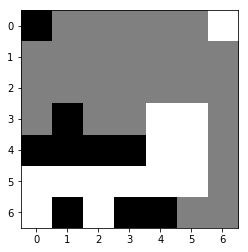

((4, 3), (6, 5)): n_v:  1655 q_all:-0.000637 q:-0.029499 q_m:-0.000000 p:0.266912
((4, 2), (3, 3)): n_v:   896 q_all:-0.039674 q:-0.038284 q_m:+0.033333 p:0.263811
((4, 3), (2, 5)): n_v:   285 q_all:+0.004760 q:-0.025678 q_m:-0.000000 p:0.040783
((3, 1), (3, 3)): n_v:    70 q_all:-0.037674 q:-0.056748 q_m:-0.000000 p:0.020220
((6, 4), (6, 5)): n_v:    66 q_all:-0.032191 q:+0.009324 q_m:+0.033333 p:0.017875
((6, 3), (6, 5)): n_v:    58 q_all:-0.029158 q:-0.023551 q_m:-0.000000 p:0.015080
((4, 3), (2, 1)): n_v:    50 q_all:-0.143835 q:-0.123059 q_m:-0.133333 p:0.032758
((4, 2), (2, 4)): n_v:    49 q_all:-0.021840 q:-0.052641 q_m:-0.000000 p:0.011500
((6, 4), (4, 6)): n_v:    39 q_all:-0.014106 q:+0.001248 q_m:+0.066667 p:0.008219
((4, 1), (3, 3)): n_v:    20 q_all:-0.070325 q:-0.090844 q_m:-0.000000 p:0.008176
((6, 4), (5, 6)): n_v:    15 q_all:-0.044368 q:+0.013746 q_m:-0.000000 p:0.004764
((4, 3), (2, 4)): n_v:     6 q_all:+0.000558 q:-0.042982 q_m:-0.000000 p:0.001078
((6, 4), (6, 6))

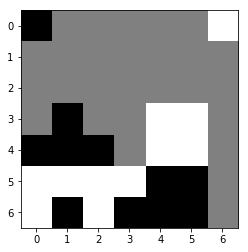

((4, 4), (5, 6)): n_v:   893 q_all:-0.015667 q:+0.008931 q_m:+0.133333 p:0.256769
((4, 5), (5, 6)): n_v:   766 q_all:+0.015511 q:+0.036535 q_m:+0.166667 p:0.138130
((3, 5), (5, 6)): n_v:   440 q_all:-0.014930 q:+0.023273 q_m:+0.133333 p:0.125299
((5, 3), (3, 2)): n_v:   426 q_all:+0.067283 q:-0.000566 q_m:+0.200000 p:0.001057
((3, 4), (4, 3)): n_v:   364 q_all:+0.012573 q:+0.006286 q_m:+0.166667 p:0.069457
((3, 4), (5, 6)): n_v:   162 q_all:+0.004708 q:+0.050582 q_m:+0.133333 p:0.035155
((3, 4), (2, 3)): n_v:    42 q_all:-0.055600 q:-0.057105 q_m:+0.033333 p:0.018208
((4, 4), (6, 6)): n_v:    13 q_all:-0.005552 q:+0.015385 q_m:+0.133333 p:0.003224
((3, 5), (1, 6)): n_v:    13 q_all:-0.088529 q:-0.049327 q_m:-0.000000 p:0.007456
((3, 4), (3, 2)): n_v:    12 q_all:-0.024607 q:+0.027668 q_m:+0.200000 p:0.003877
((3, 5), (4, 3)): n_v:    11 q_all:-0.006564 q:-0.013881 q_m:+0.133333 p:0.002873
((3, 4), (1, 6)): n_v:     9 q_all:-0.069004 q:-0.032602 q_m:-0.000000 p:0.004296
((4, 4), (3, 2))

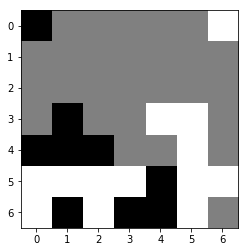

((4, 2), (4, 4)): n_v:  1622 q_all:+0.045304 q:+0.025249 q_m:+0.200000 p:0.545242
((5, 4), (4, 4)): n_v:   673 q_all:+0.002014 q:+0.035672 q_m:+0.233333 p:0.339280
((5, 4), (4, 6)): n_v:   134 q_all:+0.007167 q:-0.022589 q_m:+0.133333 p:0.065131
((6, 4), (4, 6)): n_v:    39 q_all:+0.021023 q:-0.005475 q_m:+0.133333 p:0.017133
((6, 3), (4, 4)): n_v:    18 q_all:+0.015033 q:-0.002470 q_m:+0.200000 p:0.008508
((4, 2), (2, 4)): n_v:    14 q_all:-0.012767 q:-0.035562 q_m:-0.000000 p:0.008308
((6, 4), (4, 4)): n_v:     6 q_all:-0.023867 q:-0.034942 q_m:+0.200000 p:0.003829
((5, 4), (6, 6)): n_v:     5 q_all:-0.044786 q:-0.048371 q_m:+0.066667 p:0.003572
((4, 2), (4, 3)): n_v:     2 q_all:-0.036024 q:-0.018876 q_m:+0.100000 p:0.001496
((6, 4), (6, 6)): n_v:     1 q_all:+0.002083 q:+0.024622 q_m:+0.066667 p:0.000852
((4, 1), (4, 3)): n_v:     0 q_all:-0.119645 q:-0.119645 q_m:+0.066667 p:0.000460
((3, 1), (1, 2)): n_v:     0 q_all:-0.103323 q:-0.103323 q_m:-0.133333 p:0.000000
((4, 2), (2, 1))

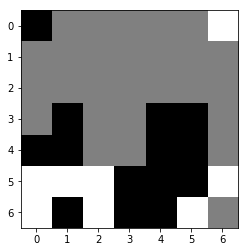

((5, 2), (4, 3)): n_v:  1776 q_all:-0.024069 q:-0.018357 q_m:+0.100000 p:0.351421
((5, 1), (4, 2)): n_v:   765 q_all:-0.039878 q:-0.056883 q_m:+0.033333 p:0.192965
((5, 6), (4, 6)): n_v:   263 q_all:-0.046934 q:-0.007663 q_m:+0.033333 p:0.072806
((6, 0), (4, 2)): n_v:   143 q_all:-0.068680 q:-0.065500 q_m:-0.000000 p:0.050575
((5, 0), (4, 2)): n_v:    46 q_all:-0.086557 q:-0.164561 q_m:-0.000000 p:0.019222
((6, 2), (4, 2)): n_v:    43 q_all:-0.032688 q:-0.101408 q_m:-0.000000 p:0.009783
((5, 1), (4, 3)): n_v:    27 q_all:-0.149340 q:-0.134099 q_m:+0.066667 p:0.017096
((6, 5), (4, 3)): n_v:    25 q_all:-0.037326 q:-0.059690 q_m:+0.066667 p:0.006164
((6, 2), (4, 3)): n_v:    22 q_all:-0.020882 q:-0.087092 q_m:+0.066667 p:0.004284
((0, 6), (2, 4)): n_v:    18 q_all:-0.067816 q:-0.063595 q_m:-0.066667 p:0.006184
((6, 5), (4, 6)): n_v:    15 q_all:-0.029295 q:-0.032758 q_m:-0.000000 p:0.003158
((0, 6), (2, 6)): n_v:    14 q_all:-0.064866 q:-0.056182 q_m:-0.133333 p:0.005034
((0, 6), (2, 5))

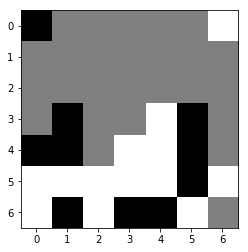

((3, 1), (4, 2)): n_v:  2766 q_all:+0.046875 q:+0.058252 q_m:+0.200000 p:0.434681
((6, 1), (4, 2)): n_v:   136 q_all:+0.087762 q:+0.042566 q_m:+0.166667 p:0.002423
((4, 1), (3, 3)): n_v:    99 q_all:+0.045087 q:-0.000165 q_m:+0.100000 p:0.016224
((3, 1), (3, 3)): n_v:    62 q_all:-0.013965 q:-0.022657 q_m:+0.100000 p:0.022730
((4, 5), (3, 3)): n_v:    50 q_all:-0.042193 q:-0.032165 q_m:+0.100000 p:0.023144
((3, 5), (3, 3)): n_v:    49 q_all:-0.012483 q:-0.036263 q_m:+0.100000 p:0.017703
((6, 3), (4, 2)): n_v:    40 q_all:-0.005375 q:+0.006611 q_m:+0.166667 p:0.013341
((4, 5), (6, 6)): n_v:    37 q_all:+0.029068 q:+0.010449 q_m:+0.033333 p:0.008156
((4, 0), (4, 2)): n_v:    35 q_all:-0.007725 q:+0.003524 q_m:+0.166667 p:0.012245
((5, 5), (3, 3)): n_v:    32 q_all:-0.051923 q:-0.049055 q_m:+0.100000 p:0.015830
((6, 4), (4, 2)): n_v:    28 q_all:-0.018293 q:+0.006341 q_m:+0.166667 p:0.010406
((3, 1), (2, 2)): n_v:    28 q_all:-0.088128 q:-0.070168 q_m:-0.066667 p:0.017655
((3, 5), (2, 4))

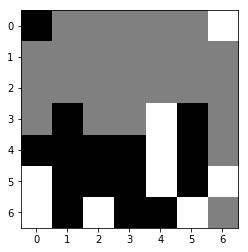

((3, 4), (3, 2)): n_v:  2394 q_all:-0.051203 q:-0.009515 q_m:+0.066667 p:0.656207
((4, 4), (3, 2)): n_v:  1147 q_all:-0.013786 q:-0.033861 q_m:+0.066667 p:0.186980
((5, 0), (3, 2)): n_v:   276 q_all:-0.078450 q:-0.088148 q_m:+0.066667 p:0.097902
((5, 4), (3, 2)): n_v:   128 q_all:-0.034611 q:-0.046080 q_m:+0.066667 p:0.028998
((5, 6), (4, 6)): n_v:    61 q_all:-0.026215 q:-0.030931 q_m:+0.033333 p:0.012183
((3, 4), (4, 6)): n_v:    14 q_all:-0.050563 q:-0.043489 q_m:-0.000000 p:0.003864
((3, 4), (1, 2)): n_v:     2 q_all:-0.177140 q:-0.143969 q_m:-0.200000 p:0.001457
((5, 0), (3, 0)): n_v:     2 q_all:-0.130942 q:-0.110082 q_m:-0.000000 p:0.001507
((4, 4), (3, 6)): n_v:     1 q_all:-0.142865 q:-0.118976 q_m:-0.066667 p:0.000709
((5, 6), (6, 6)): n_v:     1 q_all:-0.131666 q:-0.114831 q_m:-0.100000 p:0.000735
((3, 4), (2, 6)): n_v:     1 q_all:-0.117390 q:-0.100386 q_m:-0.133333 p:0.000548
((4, 4), (6, 6)): n_v:     1 q_all:-0.170528 q:-0.144297 q_m:-0.133333 p:0.000934
((6, 5), (4, 6))

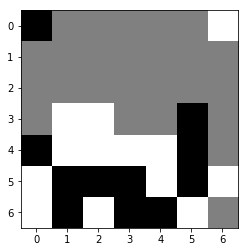

((3, 5), (3, 3)): n_v:  2129 q_all:+0.075226 q:+0.101773 q_m:+0.200000 p:0.482569
((4, 5), (3, 3)): n_v:   804 q_all:+0.078339 q:+0.061589 q_m:+0.200000 p:0.174432
((5, 5), (3, 3)): n_v:   215 q_all:+0.033805 q:+0.030522 q_m:+0.200000 p:0.076332
((5, 5), (6, 6)): n_v:    82 q_all:+0.081908 q:+0.029646 q_m:+0.100000 p:0.017019
((3, 5), (3, 4)): n_v:    70 q_all:-0.021719 q:-0.002142 q_m:+0.100000 p:0.037323
((5, 1), (3, 3)): n_v:    67 q_all:-0.028769 q:+0.047424 q_m:+0.200000 p:0.036758
((3, 5), (2, 5)): n_v:    51 q_all:-0.040883 q:-0.055139 q_m:-0.033333 p:0.030491
((3, 5), (4, 6)): n_v:    34 q_all:+0.012912 q:+0.009439 q_m:+0.033333 p:0.014589
((4, 0), (3, 0)): n_v:    27 q_all:+0.032282 q:+0.001321 q_m:+0.100000 p:0.009395
((0, 0), (2, 1)): n_v:    19 q_all:-0.006681 q:-0.021546 q_m:+0.066667 p:0.009323
((3, 5), (2, 4)): n_v:    13 q_all:-0.049782 q:-0.068722 q_m:-0.033333 p:0.008538
((5, 2), (3, 3)): n_v:    10 q_all:-0.151037 q:-0.095408 q_m:+0.200000 p:0.009433
((5, 3), (3, 3))

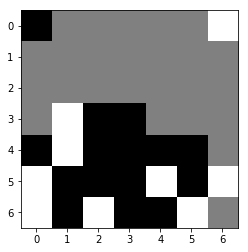

((5, 6), (3, 4)): n_v:  3001 q_all:-0.073210 q:-0.069453 q_m:+0.066667 p:0.828473
((5, 6), (4, 6)): n_v:   151 q_all:-0.085645 q:-0.070502 q_m:-0.033333 p:0.047908
((3, 1), (2, 2)): n_v:    70 q_all:-0.066010 q:-0.107601 q_m:-0.033333 p:0.017940
((5, 6), (6, 6)): n_v:    40 q_all:-0.147065 q:-0.079678 q_m:-0.100000 p:0.020496
((5, 4), (3, 4)): n_v:    34 q_all:-0.126680 q:-0.064170 q_m:+0.066667 p:0.015539
((3, 1), (3, 0)): n_v:    14 q_all:-0.106673 q:-0.106476 q_m:-0.100000 p:0.005694
((3, 1), (2, 3)): n_v:     9 q_all:-0.113619 q:-0.102513 q_m:-0.066667 p:0.003468
((0, 6), (1, 5)): n_v:     7 q_all:-0.142252 q:-0.108581 q_m:-0.166667 p:0.003749
((5, 6), (3, 5)): n_v:     7 q_all:-0.140491 q:-0.101755 q_m:-0.066667 p:0.003426
((6, 5), (4, 6)): n_v:     5 q_all:-0.122899 q:-0.118854 q_m:-0.066667 p:0.002414
((3, 1), (2, 1)): n_v:     5 q_all:-0.124465 q:-0.132716 q_m:-0.100000 p:0.002454
((0, 6), (2, 4)): n_v:     4 q_all:-0.125713 q:-0.137609 q_m:-0.133333 p:0.001828
((0, 6), (2, 6))

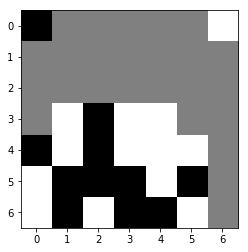

((5, 5), (5, 6)): n_v:  3001 q_all:+0.087958 q:+0.076660 q_m:+0.100000 p:0.685618
((4, 0), (3, 0)): n_v:  1077 q_all:+0.095551 q:-0.006830 q_m:+0.100000 p:0.222166
((3, 2), (2, 3)): n_v:    66 q_all:+0.009944 q:+0.013773 q_m:+0.100000 p:0.030169
((3, 2), (2, 2)): n_v:    34 q_all:+0.003104 q:-0.003600 q_m:+0.100000 p:0.016036
((6, 4), (5, 6)): n_v:    22 q_all:-0.046857 q:-0.008232 q_m:+0.066667 p:0.013529
((5, 5), (4, 6)): n_v:    17 q_all:-0.039639 q:-0.011369 q_m:+0.033333 p:0.010498
((0, 0), (1, 0)): n_v:     8 q_all:-0.037549 q:-0.054456 q_m:-0.033333 p:0.005080
((5, 5), (3, 5)): n_v:     4 q_all:-0.005124 q:+0.020129 q_m:+0.133333 p:0.002386
((3, 2), (2, 1)): n_v:     3 q_all:-0.060476 q:-0.067056 q_m:+0.033333 p:0.002491
((0, 0), (2, 2)): n_v:     3 q_all:-0.007504 q:-0.017220 q_m:+0.066667 p:0.001799
((5, 5), (6, 6)): n_v:     2 q_all:-0.005317 q:+0.020928 q_m:+0.033333 p:0.001459
((3, 2), (3, 0)): n_v:     2 q_all:-0.010366 q:-0.036057 q_m:+0.066667 p:0.001341
((4, 0), (2, 2))

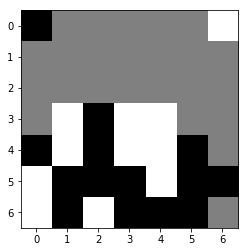

((4, 4), (6, 6)): n_v:  2237 q_all:-0.099609 q:-0.036720 q_m:+0.100000 p:0.532970
((3, 4), (4, 6)): n_v:  1185 q_all:-0.084304 q:-0.022206 q_m:+0.100000 p:0.229767
((5, 4), (4, 6)): n_v:   179 q_all:-0.109936 q:-0.083369 q_m:+0.100000 p:0.048213
((4, 4), (4, 6)): n_v:   123 q_all:-0.139616 q:-0.086498 q_m:+0.100000 p:0.043462
((3, 4), (3, 5)): n_v:    78 q_all:-0.100062 q:-0.105640 q_m:-0.000000 p:0.018754
((5, 4), (6, 6)): n_v:    64 q_all:-0.114256 q:-0.063162 q_m:+0.100000 p:0.017868
((3, 1), (3, 0)): n_v:    51 q_all:-0.076516 q:-0.138630 q_m:-0.000000 p:0.008711
((3, 4), (2, 6)): n_v:    45 q_all:-0.177803 q:-0.172824 q_m:-0.100000 p:0.021266
((3, 3), (3, 5)): n_v:    22 q_all:-0.146140 q:-0.122872 q_m:-0.033333 p:0.008229
((3, 1), (2, 0)): n_v:    16 q_all:-0.171926 q:-0.230114 q_m:-0.066667 p:0.007176
((4, 4), (2, 6)): n_v:    10 q_all:-0.230156 q:-0.171485 q_m:-0.100000 p:0.006560
((0, 6), (2, 6)): n_v:     7 q_all:-0.206688 q:-0.184768 q_m:-0.100000 p:0.003863
((4, 3), (3, 5))

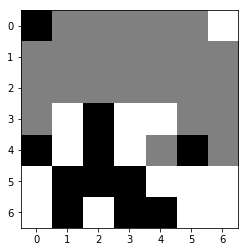

((4, 5), (4, 4)): n_v:  3457 q_all:+0.157028 q:+0.147899 q_m:+0.266667 p:0.563347
((3, 2), (4, 4)): n_v:    21 q_all:+0.075266 q:+0.092854 q_m:+0.233333 p:0.009073
((4, 2), (4, 4)): n_v:    21 q_all:-0.039006 q:+0.035008 q_m:+0.233333 p:0.016265
((3, 2), (2, 2)): n_v:    13 q_all:-0.035031 q:-0.067103 q_m:+0.066667 p:0.010203
((5, 2), (4, 4)): n_v:     7 q_all:-0.095761 q:-0.028540 q_m:+0.233333 p:0.007165
((6, 3), (4, 4)): n_v:     4 q_all:-0.007597 q:+0.045195 q_m:+0.233333 p:0.002840
((6, 4), (4, 4)): n_v:     4 q_all:+0.019967 q:+0.070468 q_m:+0.233333 p:0.002565
((4, 2), (2, 4)): n_v:     1 q_all:-0.123807 q:-0.169636 q_m:+0.033333 p:0.001405
((3, 2), (2, 4)): n_v:     1 q_all:-0.072838 q:-0.080621 q_m:+0.033333 p:0.001482
((0, 0), (2, 2)): n_v:     1 q_all:-0.115169 q:-0.083832 q_m:+0.033333 p:0.001039
((3, 2), (1, 2)): n_v:     0 q_all:-0.160265 q:-0.160265 q_m:-0.100000 p:0.000000
((3, 2), (1, 3)): n_v:     0 q_all:-0.103059 q:-0.103059 q_m:-0.100000 p:0.000001
((0, 0), (1, 1))

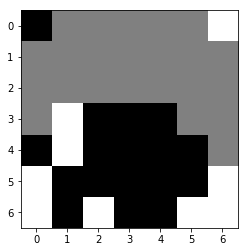

((5, 6), (3, 5)): n_v:  3557 q_all:-0.153959 q:-0.099611 q_m:-0.066667 p:0.790870
((5, 6), (4, 6)): n_v:   532 q_all:-0.140405 q:-0.082591 q_m:-0.100000 p:0.098426
((6, 6), (4, 6)): n_v:   147 q_all:-0.181325 q:-0.159070 q_m:-0.133333 p:0.044088
((3, 1), (2, 3)): n_v:   144 q_all:-0.095564 q:-0.111444 q_m:-0.066667 p:0.008733
((0, 6), (2, 6)): n_v:    32 q_all:-0.203620 q:-0.167977 q_m:-0.266667 p:0.011548
((3, 1), (3, 0)): n_v:    21 q_all:-0.190736 q:-0.150946 q_m:-0.166667 p:0.006906
((6, 5), (4, 6)): n_v:    21 q_all:-0.211714 q:-0.138851 q_m:-0.133333 p:0.008114
((3, 1), (2, 2)): n_v:    18 q_all:-0.176992 q:-0.137041 q_m:-0.100000 p:0.005423
((0, 6), (1, 5)): n_v:    16 q_all:-0.154446 q:-0.136945 q_m:-0.233333 p:0.003797
((0, 6), (2, 5)): n_v:    12 q_all:-0.198442 q:-0.138640 q_m:-0.200000 p:0.004324
((3, 1), (2, 1)): n_v:     8 q_all:-0.188103 q:-0.170343 q_m:-0.166667 p:0.002758
((4, 1), (2, 3)): n_v:     7 q_all:-0.185214 q:-0.185273 q_m:-0.066667 p:0.002390
((0, 6), (1, 6))

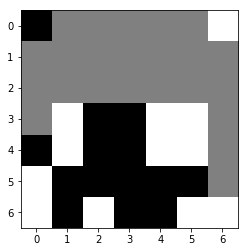

((5, 5), (5, 6)): n_v:  3692 q_all:+0.188332 q:+0.211876 q_m:+0.300000 p:0.801096
((4, 0), (3, 0)): n_v:   592 q_all:+0.222740 q:+0.116823 q_m:+0.233333 p:0.072535
((6, 4), (5, 6)): n_v:   136 q_all:+0.072333 q:+0.090903 q_m:+0.266667 p:0.073292
((5, 5), (4, 6)): n_v:    15 q_all:+0.048198 q:+0.057027 q_m:+0.233333 p:0.009552
((3, 2), (3, 0)): n_v:    15 q_all:+0.040834 q:+0.043298 q_m:+0.200000 p:0.009581
((3, 3), (2, 4)): n_v:    11 q_all:+0.118169 q:+0.072713 q_m:+0.233333 p:0.004798
((0, 0), (1, 0)): n_v:     9 q_all:+0.041657 q:+0.017413 q_m:+0.100000 p:0.006060
((3, 2), (2, 2)): n_v:     5 q_all:+0.060415 q:+0.032419 q_m:+0.166667 p:0.003138
((5, 1), (3, 0)): n_v:     2 q_all:+0.005805 q:+0.028307 q_m:+0.200000 p:0.001609
((5, 2), (3, 0)): n_v:     2 q_all:-0.108063 q:-0.087354 q_m:+0.200000 p:0.001976
((3, 2), (2, 1)): n_v:     1 q_all:+0.039426 q:+0.003060 q_m:+0.166667 p:0.000750
((5, 5), (3, 6)): n_v:     1 q_all:+0.024751 q:+0.028593 q_m:+0.200000 p:0.000902
((3, 3), (1, 5))

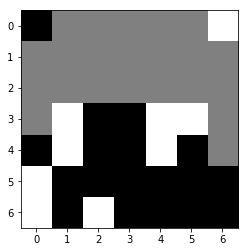

((3, 5), (4, 6)): n_v:  3295 q_all:-0.198443 q:-0.129499 q_m:-0.066667 p:0.690942
((3, 4), (4, 6)): n_v:   774 q_all:-0.222374 q:-0.167210 q_m:-0.100000 p:0.212366
((3, 5), (2, 6)): n_v:    69 q_all:-0.283264 q:-0.279879 q_m:-0.266667 p:0.030639
((4, 4), (4, 6)): n_v:    51 q_all:-0.269006 q:-0.219321 q_m:-0.100000 p:0.020592
((3, 4), (2, 6)): n_v:    24 q_all:-0.322812 q:-0.298621 q_m:-0.300000 p:0.013367
((3, 1), (3, 0)): n_v:    10 q_all:-0.226098 q:-0.281335 q_m:-0.200000 p:0.003122
((0, 6), (2, 6)): n_v:     9 q_all:-0.317125 q:-0.306150 q_m:-0.300000 p:0.005266
((3, 1), (2, 0)): n_v:     8 q_all:-0.317541 q:-0.332477 q_m:-0.266667 p:0.004286
((4, 4), (2, 6)): n_v:     6 q_all:-0.288964 q:-0.261418 q_m:-0.300000 p:0.002776
((3, 4), (2, 3)): n_v:     4 q_all:-0.264635 q:-0.288608 q_m:-0.133333 p:0.001705
((3, 4), (2, 2)): n_v:     3 q_all:-0.299452 q:-0.286011 q_m:-0.166667 p:0.001447
((3, 5), (3, 6)): n_v:     3 q_all:-0.328815 q:-0.269561 q_m:-0.200000 p:0.002158
((3, 4), (3, 6))

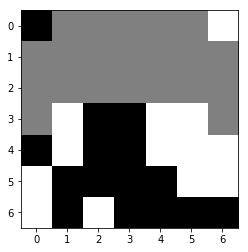

((4, 0), (3, 0)): n_v:  4039 q_all:+0.247157 q:+0.200645 q_m:+0.233333 p:0.893996
((3, 2), (3, 0)): n_v:    39 q_all:+0.088802 q:+0.111402 q_m:+0.200000 p:0.026438
((3, 3), (2, 4)): n_v:    35 q_all:+0.138999 q:+0.127215 q_m:+0.233333 p:0.018696
((3, 2), (2, 2)): n_v:    13 q_all:+0.079040 q:+0.088236 q_m:+0.166667 p:0.009574
((5, 2), (3, 0)): n_v:     6 q_all:-0.132703 q:-0.060130 q_m:+0.200000 p:0.007515
((5, 1), (3, 0)): n_v:     5 q_all:+0.005727 q:+0.080097 q_m:+0.200000 p:0.004634
((5, 4), (3, 6)): n_v:     5 q_all:-0.020573 q:+0.030536 q_m:+0.266667 p:0.005412
((4, 2), (3, 0)): n_v:     3 q_all:+0.039188 q:+0.039658 q_m:+0.200000 p:0.003101
((3, 2), (2, 3)): n_v:     3 q_all:+0.098716 q:+0.076008 q_m:+0.166667 p:0.002049
((3, 2), (2, 1)): n_v:     2 q_all:+0.063502 q:+0.043365 q_m:+0.166667 p:0.001744
((0, 0), (1, 0)): n_v:     2 q_all:+0.071613 q:+0.080825 q_m:+0.100000 p:0.001856
((0, 0), (2, 2)): n_v:     1 q_all:+0.067273 q:+0.053468 q_m:+0.133333 p:0.001449
((3, 3), (1, 5))

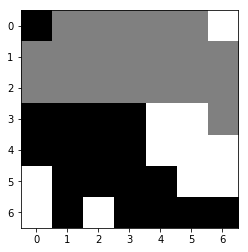

((3, 4), (2, 2)): n_v:  1071 q_all:-0.253398 q:-0.233175 q_m:-0.033333 p:0.167555
((3, 4), (2, 3)): n_v:   907 q_all:-0.252285 q:-0.225003 q_m:-0.066667 p:0.139066
((3, 5), (2, 6)): n_v:   351 q_all:-0.234149 q:-0.255619 q_m:-0.200000 p:0.037162
((3, 5), (3, 6)): n_v:   350 q_all:-0.222588 q:-0.246494 q_m:-0.200000 p:0.026366
((3, 4), (2, 4)): n_v:   347 q_all:-0.267324 q:-0.253842 q_m:-0.133333 p:0.066907
((0, 6), (1, 5)): n_v:   269 q_all:-0.268412 q:-0.251751 q_m:-0.200000 p:0.052765
((3, 5), (1, 5)): n_v:   221 q_all:-0.263323 q:-0.282957 q_m:-0.233333 p:0.040219
((0, 6), (2, 6)): n_v:   210 q_all:-0.272785 q:-0.283181 q_m:-0.233333 p:0.043595
((0, 6), (1, 6)): n_v:   199 q_all:-0.231005 q:-0.234100 q_m:-0.200000 p:0.019442
((3, 4), (1, 5)): n_v:   159 q_all:-0.338825 q:-0.292481 q_m:-0.233333 p:0.060686
((0, 6), (0, 5)): n_v:   154 q_all:-0.235692 q:-0.249411 q_m:-0.200000 p:0.016865
((3, 4), (2, 5)): n_v:    93 q_all:-0.304454 q:-0.269376 q_m:-0.200000 p:0.027232
((3, 5), (2, 3))

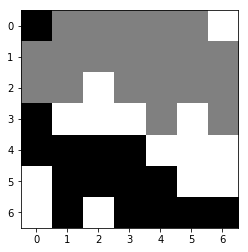

((4, 3), (3, 4)): n_v:  2422 q_all:+0.278779 q:+0.249718 q_m:+0.333333 p:0.952777
((3, 0), (2, 1)): n_v:    57 q_all:+0.266256 q:+0.173251 q_m:+0.266667 p:0.025477
((0, 0), (2, 1)): n_v:    53 q_all:+0.284149 q:+0.136307 q_m:+0.233333 p:0.019650
((5, 3), (3, 4)): n_v:     0 q_all:+0.039225 q:+0.039225 q_m:+0.300000 p:0.000079
((4, 3), (2, 3)): n_v:     0 q_all:+0.012677 q:+0.012677 q_m:+0.233333 p:0.000000
((4, 3), (2, 5)): n_v:     0 q_all:-0.015194 q:-0.015194 q_m:+0.100000 p:0.000101
((4, 2), (2, 0)): n_v:     0 q_all:-0.061611 q:-0.061611 q_m:+0.100000 p:0.000000
((4, 2), (2, 4)): n_v:     0 q_all:+0.015049 q:+0.015049 q_m:+0.166667 p:0.000004
((0, 0), (1, 1)): n_v:     0 q_all:+0.067989 q:+0.067989 q_m:+0.133333 p:0.000125
((4, 3), (2, 1)): n_v:     0 q_all:+0.014006 q:+0.014006 q_m:+0.233333 p:0.000089
((5, 2), (3, 4)): n_v:     0 q_all:+0.006973 q:+0.006973 q_m:+0.300000 p:0.000122
((3, 0), (1, 1)): n_v:     0 q_all:+0.045909 q:+0.045909 q_m:+0.100000 p:0.000010
((4, 3), (2, 4))

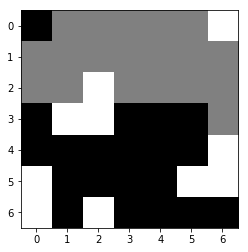

((2, 2), (2, 4)): n_v:  1463 q_all:-0.269687 q:-0.284519 q_m:-0.133333 p:0.271612
((4, 6), (3, 6)): n_v:  1173 q_all:-0.307853 q:-0.285753 q_m:-0.166667 p:0.356577
((3, 2), (2, 4)): n_v:   530 q_all:-0.288116 q:-0.271527 q_m:-0.133333 p:0.128762
((0, 6), (2, 4)): n_v:   150 q_all:-0.304391 q:-0.295595 q_m:-0.133333 p:0.044006
((4, 6), (2, 4)): n_v:    80 q_all:-0.315104 q:-0.294479 q_m:-0.133333 p:0.025916
((5, 6), (3, 6)): n_v:    67 q_all:-0.386358 q:-0.318333 q_m:-0.200000 p:0.036996
((3, 2), (1, 0)): n_v:    50 q_all:-0.342033 q:-0.325860 q_m:-0.266667 p:0.020732
((2, 2), (1, 0)): n_v:    38 q_all:-0.325120 q:-0.303017 q_m:-0.266667 p:0.013869
((2, 2), (2, 3)): n_v:    28 q_all:-0.339696 q:-0.303426 q_m:-0.166667 p:0.011538
((3, 1), (2, 3)): n_v:    17 q_all:-0.280458 q:-0.317777 q_m:-0.200000 p:0.003821
((5, 5), (3, 6)): n_v:    16 q_all:-0.396903 q:-0.308567 q_m:-0.200000 p:0.009797
((0, 6), (2, 5)): n_v:    12 q_all:-0.374708 q:-0.301833 q_m:-0.200000 p:0.005790
((3, 2), (2, 0))

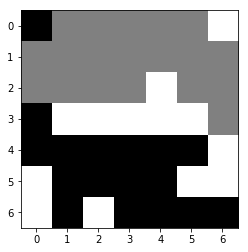

((3, 0), (2, 1)): n_v:  1251 q_all:+0.250947 q:+0.232699 q_m:+0.300000 p:0.509036
((4, 5), (3, 6)): n_v:   970 q_all:+0.344989 q:+0.302749 q_m:+0.300000 p:0.073066
((0, 0), (2, 1)): n_v:   565 q_all:+0.229624 q:+0.207118 q_m:+0.266667 p:0.272507
((0, 0), (2, 2)): n_v:   208 q_all:+0.264581 q:+0.271651 q_m:+0.333333 p:0.074621
((3, 0), (2, 0)): n_v:    48 q_all:+0.242035 q:+0.219578 q_m:+0.233333 p:0.021173
((4, 5), (2, 3)): n_v:    44 q_all:+0.329200 q:+0.175396 q_m:+0.400000 p:0.005495
((0, 0), (1, 1)): n_v:    15 q_all:+0.223289 q:+0.177548 q_m:+0.166667 p:0.007906
((3, 0), (2, 2)): n_v:    10 q_all:+0.231910 q:+0.266844 q_m:+0.333333 p:0.004803
((4, 0), (2, 1)): n_v:     8 q_all:+0.140246 q:+0.091865 q_m:+0.266667 p:0.006614
((0, 0), (1, 0)): n_v:     7 q_all:+0.191362 q:+0.174326 q_m:+0.166667 p:0.004283
((4, 1), (2, 3)): n_v:     4 q_all:+0.189976 q:+0.100217 q_m:+0.400000 p:0.002925
((4, 0), (2, 2)): n_v:     4 q_all:+0.148784 q:+0.171637 q_m:+0.333333 p:0.003598
((0, 0), (1, 2))

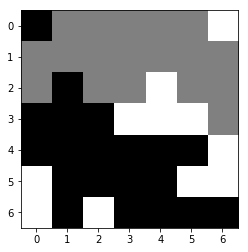

((2, 4), (2, 2)): n_v:   991 q_all:-0.267784 q:-0.280870 q_m:-0.100000 p:0.328033
((3, 3), (2, 2)): n_v:   876 q_all:-0.263579 q:-0.264544 q_m:-0.066667 p:0.277453
((3, 4), (2, 2)): n_v:   332 q_all:-0.259624 q:-0.284284 q_m:-0.100000 p:0.100256
((3, 3), (1, 1)): n_v:   121 q_all:-0.242134 q:-0.288524 q_m:-0.166667 p:0.028916
((2, 4), (3, 6)): n_v:    78 q_all:-0.286113 q:-0.330760 q_m:-0.233333 p:0.031168
((2, 4), (2, 6)): n_v:    59 q_all:-0.456366 q:-0.395888 q_m:-0.300000 p:0.060918
((0, 6), (2, 6)): n_v:    53 q_all:-0.462875 q:-0.428645 q_m:-0.300000 p:0.056010
((3, 3), (1, 5)): n_v:    47 q_all:-0.346558 q:-0.384670 q_m:-0.300000 p:0.029667
((3, 4), (2, 6)): n_v:    22 q_all:-0.439368 q:-0.392377 q_m:-0.300000 p:0.021188
((3, 4), (3, 6)): n_v:    10 q_all:-0.406335 q:-0.376249 q_m:-0.233333 p:0.008545
((2, 4), (1, 2)): n_v:     7 q_all:-0.341872 q:-0.336218 q_m:-0.233333 p:0.004672
((3, 4), (1, 5)): n_v:     6 q_all:-0.405289 q:-0.395179 q_m:-0.300000 p:0.005299
((4, 6), (2, 6))

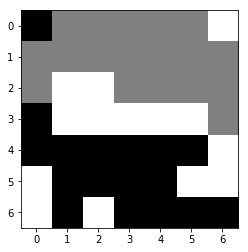

((3, 0), (2, 0)): n_v:   964 q_all:+0.274568 q:+0.224075 q_m:+0.266667 p:0.384712
((0, 0), (1, 1)): n_v:   717 q_all:+0.266577 q:+0.204885 q_m:+0.266667 p:0.307797
((0, 0), (2, 0)): n_v:   403 q_all:+0.295724 q:+0.219284 q_m:+0.233333 p:0.128515
((4, 5), (3, 6)): n_v:   340 q_all:+0.343567 q:+0.274285 q_m:+0.266667 p:0.045660
((0, 0), (1, 0)): n_v:   112 q_all:+0.240543 q:+0.130307 q_m:+0.200000 p:0.059569
((0, 0), (1, 2)): n_v:    51 q_all:+0.244566 q:+0.154934 q_m:+0.233333 p:0.026683
((3, 0), (1, 1)): n_v:    31 q_all:+0.212564 q:+0.161229 q_m:+0.233333 p:0.019911
((4, 5), (2, 3)): n_v:    12 q_all:+0.263028 q:+0.160816 q_m:+0.366667 p:0.005413
((0, 0), (0, 1)): n_v:    11 q_all:+0.212911 q:+0.142890 q_m:+0.133333 p:0.007410
((0, 0), (0, 2)): n_v:     4 q_all:+0.199025 q:+0.117595 q_m:+0.100000 p:0.002978
((4, 1), (2, 3)): n_v:     2 q_all:+0.065341 q:+0.081459 q_m:+0.366667 p:0.003034
((4, 2), (2, 3)): n_v:     1 q_all:+0.074939 q:+0.169211 q_m:+0.366667 p:0.001126
((4, 3), (2, 3))

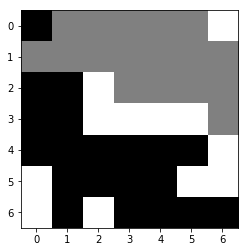

((2, 2), (1, 1)): n_v:  1254 q_all:-0.288677 q:-0.255724 q_m:-0.033333 p:0.447211
((3, 2), (1, 1)): n_v:   341 q_all:-0.282121 q:-0.246955 q_m:-0.066667 p:0.112993
((3, 3), (1, 1)): n_v:   279 q_all:-0.253057 q:-0.253449 q_m:-0.066667 p:0.061445
((2, 2), (1, 0)): n_v:   219 q_all:-0.280178 q:-0.253574 q_m:-0.066667 p:0.071118
((3, 5), (3, 6)): n_v:   116 q_all:-0.253714 q:-0.314972 q_m:-0.166667 p:0.025750
((0, 6), (1, 5)): n_v:    89 q_all:-0.352892 q:-0.354881 q_m:-0.233333 p:0.053973
((3, 4), (1, 5)): n_v:    87 q_all:-0.356462 q:-0.364455 q_m:-0.266667 p:0.054040
((3, 3), (1, 5)): n_v:    70 q_all:-0.371767 q:-0.362606 q_m:-0.266667 p:0.047516
((3, 2), (1, 0)): n_v:    48 q_all:-0.279153 q:-0.243977 q_m:-0.066667 p:0.015511
((3, 5), (1, 5)): n_v:    39 q_all:-0.352532 q:-0.352256 q_m:-0.266667 p:0.023599
((3, 4), (3, 6)): n_v:    21 q_all:-0.365997 q:-0.342811 q_m:-0.200000 p:0.013841
((0, 6), (1, 6)): n_v:    21 q_all:-0.373404 q:-0.354344 q_m:-0.233333 p:0.014197
((3, 4), (1, 6))

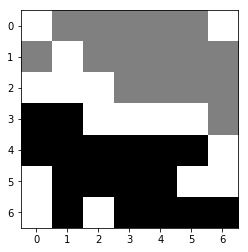

((4, 5), (3, 6)): n_v:  2840 q_all:+0.279840 q:+0.265801 q_m:+0.200000 p:0.964093
((3, 0), (1, 0)): n_v:    43 q_all:+0.258337 q:+0.229220 q_m:+0.300000 p:0.018186
((3, 0), (1, 2)): n_v:     5 q_all:+0.171525 q:+0.110909 q_m:+0.233333 p:0.004115
((3, 1), (2, 3)): n_v:     5 q_all:+0.054883 q:+0.140228 q_m:+0.300000 p:0.006707
((3, 1), (1, 0)): n_v:     1 q_all:+0.068625 q:+0.158381 q_m:+0.300000 p:0.002061
((4, 4), (3, 6)): n_v:     1 q_all:+0.046093 q:+0.093431 q_m:+0.166667 p:0.001534
((4, 3), (2, 3)): n_v:     0 q_all:+0.089102 q:+0.089102 q_m:+0.300000 p:0.000045
((4, 4), (2, 3)): n_v:     0 q_all:+0.194956 q:+0.194956 q_m:+0.300000 p:0.000108
((4, 4), (2, 6)): n_v:     0 q_all:-0.003348 q:-0.003348 q_m:+0.100000 p:0.000014
((3, 1), (1, 3)): n_v:     0 q_all:-0.031638 q:-0.031638 q_m:+0.100000 p:0.000018
((3, 1), (1, 2)): n_v:     0 q_all:+0.009316 q:+0.009316 q_m:+0.233333 p:0.000011
((4, 5), (2, 4)): n_v:     0 q_all:+0.072788 q:+0.072788 q_m:+0.233333 p:0.000026
((4, 3), (2, 4))

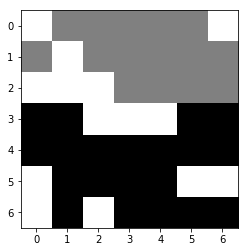

((3, 4), (2, 5)): n_v:  1672 q_all:-0.268972 q:-0.274620 q_m:-0.033333 p:0.231433
((0, 6), (2, 5)): n_v:   955 q_all:-0.298964 q:-0.313041 q_m:-0.066667 p:0.216840
((0, 6), (2, 6)): n_v:   534 q_all:-0.323213 q:-0.328295 q_m:-0.066667 p:0.159592
((3, 4), (2, 6)): n_v:   383 q_all:-0.271177 q:-0.276523 q_m:-0.066667 p:0.055490
((3, 3), (2, 5)): n_v:   334 q_all:-0.297630 q:-0.264832 q_m:-0.066667 p:0.074641
((3, 3), (2, 4)): n_v:    83 q_all:-0.404546 q:-0.424891 q_m:-0.100000 p:0.045061
((3, 4), (1, 5)): n_v:    50 q_all:-0.304000 q:-0.355353 q_m:-0.200000 p:0.012215
((3, 3), (1, 5)): n_v:    46 q_all:-0.373459 q:-0.340856 q_m:-0.200000 p:0.020919
((0, 6), (1, 5)): n_v:    40 q_all:-0.327696 q:-0.381121 q_m:-0.166667 p:0.012701
((3, 4), (1, 6)): n_v:    33 q_all:-0.356314 q:-0.376103 q_m:-0.200000 p:0.013221
((2, 2), (2, 4)): n_v:    23 q_all:-0.430035 q:-0.403361 q_m:-0.133333 p:0.014011
((0, 6), (2, 4)): n_v:    19 q_all:-0.435659 q:-0.443628 q_m:-0.133333 p:0.012175
((3, 2), (1, 0))

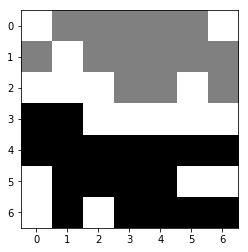

((4, 6), (2, 4)): n_v:  2734 q_all:+0.302800 q:+0.251629 q_m:+0.300000 p:0.714344
((4, 6), (2, 6)): n_v:   151 q_all:+0.221439 q:+0.213166 q_m:+0.233333 p:0.081611
((3, 0), (1, 0)): n_v:    77 q_all:+0.276138 q:+0.266490 q_m:+0.300000 p:0.027258
((3, 1), (2, 3)): n_v:    63 q_all:+0.132461 q:+0.191250 q_m:+0.300000 p:0.053190
((3, 0), (1, 2)): n_v:    49 q_all:+0.248362 q:+0.165237 q_m:+0.233333 p:0.022238
((4, 4), (2, 6)): n_v:    35 q_all:+0.186539 q:+0.139156 q_m:+0.233333 p:0.022776
((4, 2), (2, 4)): n_v:    29 q_all:+0.107060 q:+0.165256 q_m:+0.300000 p:0.026691
((4, 3), (2, 4)): n_v:    11 q_all:+0.125204 q:+0.175635 q_m:+0.300000 p:0.010304
((4, 5), (2, 4)): n_v:     8 q_all:+0.161238 q:+0.155141 q_m:+0.300000 p:0.006589
((4, 4), (2, 4)): n_v:     7 q_all:+0.128540 q:+0.187974 q_m:+0.300000 p:0.006451
((4, 5), (2, 3)): n_v:     6 q_all:+0.177219 q:+0.156422 q_m:+0.300000 p:0.004541
((4, 1), (2, 3)): n_v:     5 q_all:+0.043894 q:+0.098115 q_m:+0.300000 p:0.005583
((4, 5), (2, 6))

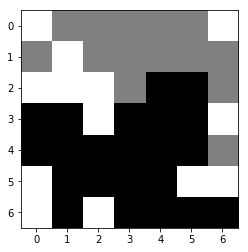

((3, 6), (4, 6)): n_v:  2746 q_all:-0.276563 q:-0.332466 q_m:-0.133333 p:0.137525
((0, 6), (2, 6)): n_v:   606 q_all:-0.398838 q:-0.318856 q_m:-0.166667 p:0.251249
((3, 6), (2, 6)): n_v:   296 q_all:-0.371924 q:-0.296447 q_m:-0.133333 p:0.098938
((3, 2), (1, 4)): n_v:   124 q_all:-0.260437 q:-0.270356 q_m:-0.166667 p:0.000054
((2, 2), (2, 3)): n_v:   100 q_all:-0.295274 q:-0.256970 q_m:-0.066667 p:0.010674
((3, 6), (1, 5)): n_v:    38 q_all:-0.265832 q:-0.253406 q_m:-0.166667 p:0.000650
((0, 6), (1, 5)): n_v:    15 q_all:-0.325600 q:-0.231866 q_m:-0.133333 p:0.002795
((0, 6), (1, 6)): n_v:     1 q_all:-0.379073 q:-0.299470 q_m:-0.200000 p:0.000170
((2, 1), (2, 3)): n_v:     1 q_all:-0.324375 q:-0.273604 q_m:-0.100000 p:0.000198
((1, 1), (2, 3)): n_v:     1 q_all:-0.367881 q:-0.270286 q_m:-0.100000 p:0.000212
((2, 2), (1, 4)): n_v:     1 q_all:-0.350419 q:-0.285322 q_m:-0.166667 p:0.000094
((3, 6), (1, 6)): n_v:     0 q_all:-0.318889 q:-0.318889 q_m:-0.233333 p:0.000013
((1, 1), (1, 3))

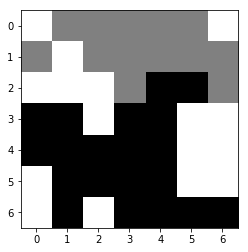

((2, 4), (2, 3)): n_v:  2177 q_all:+0.322251 q:+0.292218 q_m:+0.300000 p:0.136174
((2, 5), (2, 6)): n_v:   917 q_all:+0.301403 q:+0.323140 q_m:+0.300000 p:0.114294
((2, 5), (1, 6)): n_v:   571 q_all:+0.196806 q:+0.168711 q_m:+0.233333 p:0.249316
((3, 0), (1, 0)): n_v:   236 q_all:+0.305906 q:+0.292486 q_m:+0.400000 p:0.026119
((2, 4), (1, 2)): n_v:   176 q_all:+0.326404 q:+0.234215 q_m:+0.333333 p:0.008728
((2, 4), (1, 5)): n_v:    83 q_all:+0.221261 q:+0.193033 q_m:+0.233333 p:0.029921
((2, 4), (1, 6)): n_v:    71 q_all:+0.202167 q:+0.167441 q_m:+0.200000 p:0.029736
((2, 4), (1, 4)): n_v:    67 q_all:+0.142032 q:+0.143471 q_m:+0.166667 p:0.039976
((2, 4), (1, 3)): n_v:    19 q_all:+0.141837 q:+0.169590 q_m:+0.233333 p:0.011892
((3, 1), (1, 0)): n_v:     7 q_all:+0.240556 q:+0.211370 q_m:+0.400000 p:0.002138
((2, 5), (2, 3)): n_v:     6 q_all:+0.257689 q:+0.259326 q_m:+0.266667 p:0.001695
((3, 4), (1, 6)): n_v:     6 q_all:+0.115560 q:+0.105217 q_m:+0.200000 p:0.004189
((2, 4), (0, 5))

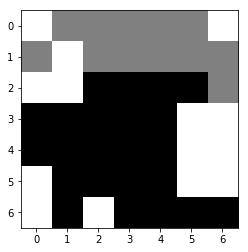

((1, 1), (1, 3)): n_v:  1633 q_all:-0.286428 q:-0.286251 q_m:-0.100000 p:0.270093
((2, 1), (1, 3)): n_v:   386 q_all:-0.323408 q:-0.265418 q_m:-0.100000 p:0.109521
((0, 6), (1, 4)): n_v:   333 q_all:-0.311769 q:-0.291194 q_m:-0.100000 p:0.082045
((2, 0), (1, 2)): n_v:   272 q_all:-0.340149 q:-0.330603 q_m:-0.166667 p:0.091764
((1, 1), (1, 2)): n_v:   260 q_all:-0.335837 q:-0.312515 q_m:-0.133333 p:0.084196
((0, 0), (1, 2)): n_v:   258 q_all:-0.350292 q:-0.307386 q_m:-0.166667 p:0.095430
((0, 6), (1, 5)): n_v:   128 q_all:-0.289559 q:-0.278286 q_m:-0.133333 p:0.022460
((3, 5), (1, 3)): n_v:   117 q_all:-0.412862 q:-0.330991 q_m:-0.100000 p:0.067027
((3, 6), (1, 4)): n_v:   104 q_all:-0.301185 q:-0.304309 q_m:-0.100000 p:0.022133
((0, 6), (2, 6)): n_v:    73 q_all:-0.392616 q:-0.361207 q_m:-0.233333 p:0.037196
((3, 6), (1, 5)): n_v:    39 q_all:-0.324356 q:-0.312507 q_m:-0.166667 p:0.011282
((3, 5), (2, 6)): n_v:    10 q_all:-0.411616 q:-0.358845 q_m:-0.200000 p:0.005711
((2, 1), (0, 3))

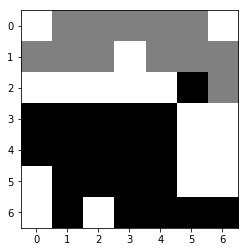

((2, 5), (1, 4)): n_v:  2790 q_all:+0.312048 q:+0.316638 q_m:+0.333333 p:0.877034
((2, 5), (1, 5)): n_v:   188 q_all:+0.335779 q:+0.246664 q_m:+0.266667 p:0.043789
((2, 5), (2, 6)): n_v:   127 q_all:+0.392882 q:+0.362229 q_m:+0.266667 p:0.004663
((3, 0), (1, 2)): n_v:    87 q_all:+0.264315 q:+0.257940 q_m:+0.366667 p:0.041746
((3, 0), (1, 1)): n_v:    18 q_all:+0.288945 q:+0.302758 q_m:+0.366667 p:0.007464
((3, 1), (1, 2)): n_v:     4 q_all:+0.084294 q:+0.200553 q_m:+0.366667 p:0.005072
((2, 5), (1, 6)): n_v:     3 q_all:+0.243419 q:+0.207803 q_m:+0.200000 p:0.001930
((3, 3), (1, 2)): n_v:     3 q_all:+0.097275 q:+0.160560 q_m:+0.366667 p:0.003191
((3, 4), (1, 2)): n_v:     3 q_all:+0.209374 q:+0.263949 q_m:+0.366667 p:0.002494
((3, 3), (1, 4)): n_v:     2 q_all:+0.000480 q:+0.131085 q_m:+0.300000 p:0.003120
((3, 2), (1, 2)): n_v:     2 q_all:+0.097463 q:+0.180975 q_m:+0.366667 p:0.002053
((3, 2), (1, 4)): n_v:     2 q_all:+0.120458 q:+0.146622 q_m:+0.300000 p:0.001826
((3, 2), (1, 1))

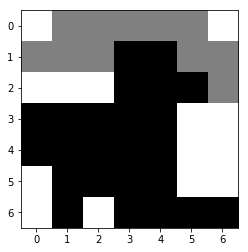

((0, 6), (1, 5)): n_v:  2933 q_all:-0.294298 q:-0.232645 q_m:-0.100000 p:0.423741
((3, 6), (1, 5)): n_v:   636 q_all:-0.307622 q:-0.280645 q_m:-0.133333 p:0.116782
((0, 0), (1, 1)): n_v:   236 q_all:-0.472761 q:-0.447986 q_m:-0.300000 p:0.159151
((2, 1), (0, 3)): n_v:    38 q_all:-0.382138 q:-0.381655 q_m:-0.200000 p:0.015731
((0, 6), (2, 6)): n_v:    34 q_all:-0.421146 q:-0.372452 q_m:-0.266667 p:0.018141
((0, 6), (0, 4)): n_v:    30 q_all:-0.402401 q:-0.438836 q_m:-0.200000 p:0.013927
((0, 0), (1, 2)): n_v:    23 q_all:-0.364786 q:-0.369777 q_m:-0.200000 p:0.008083
((3, 5), (2, 6)): n_v:    21 q_all:-0.408809 q:-0.354896 q_m:-0.233333 p:0.010640
((2, 0), (1, 2)): n_v:    20 q_all:-0.354501 q:-0.386831 q_m:-0.200000 p:0.006501
((2, 2), (0, 3)): n_v:    17 q_all:-0.323976 q:-0.383760 q_m:-0.200000 p:0.004177
((3, 5), (1, 5)): n_v:    16 q_all:-0.415467 q:-0.306091 q_m:-0.133333 p:0.008095
((2, 2), (0, 4)): n_v:    14 q_all:-0.373766 q:-0.438940 q_m:-0.200000 p:0.005510
((0, 0), (0, 2))

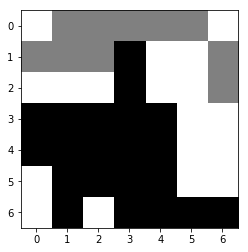

((1, 3), (1, 1)): n_v:  1968 q_all:+0.372104 q:+0.394971 q_m:+0.366667 p:0.186917
((1, 3), (0, 4)): n_v:   541 q_all:+0.313110 q:+0.234626 q_m:+0.266667 p:0.144600
((3, 0), (1, 1)): n_v:   337 q_all:+0.284315 q:+0.319631 q_m:+0.366667 p:0.118621
((2, 3), (1, 1)): n_v:   286 q_all:+0.317943 q:+0.364483 q_m:+0.366667 p:0.072218
((1, 3), (0, 5)): n_v:   232 q_all:+0.368796 q:+0.291522 q_m:+0.300000 p:0.024293
((3, 4), (2, 6)): n_v:   175 q_all:+0.234053 q:+0.222929 q_m:+0.366667 p:0.087494
((1, 3), (0, 2)): n_v:   118 q_all:+0.237771 q:+0.198349 q_m:+0.133333 p:0.057832
((1, 3), (1, 2)): n_v:   106 q_all:+0.265727 q:+0.287271 q_m:+0.266667 p:0.042840
((1, 3), (0, 1)): n_v:    81 q_all:+0.277628 q:+0.220511 q_m:+0.166667 p:0.030240
((4, 4), (2, 6)): n_v:    79 q_all:+0.183769 q:+0.209707 q_m:+0.366667 p:0.050999
((1, 3), (0, 3)): n_v:    51 q_all:+0.248115 q:+0.204800 q_m:+0.200000 p:0.023571
((3, 0), (1, 0)): n_v:    19 q_all:+0.195412 q:+0.248009 q_m:+0.300000 p:0.011611
((3, 2), (1, 1))

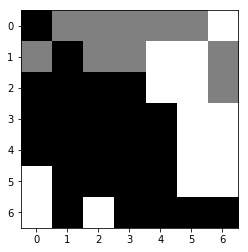

((1, 4), (1, 2)): n_v:  2917 q_all:-0.304333 q:-0.327537 q_m:-0.100000 p:0.696933
((2, 4), (1, 2)): n_v:   361 q_all:-0.418065 q:-0.372138 q_m:-0.100000 p:0.221047
((3, 6), (1, 6)): n_v:    26 q_all:-0.512420 q:-0.509633 q_m:-0.366667 p:0.024648
((1, 4), (1, 3)): n_v:    19 q_all:-0.439506 q:-0.367003 q_m:-0.200000 p:0.012939
((3, 5), (1, 6)): n_v:    10 q_all:-0.631914 q:-0.591519 q_m:-0.366667 p:0.014174
((1, 5), (1, 3)): n_v:     6 q_all:-0.461039 q:-0.392241 q_m:-0.233333 p:0.005176
((2, 5), (1, 3)): n_v:     4 q_all:-0.461131 q:-0.396175 q_m:-0.233333 p:0.003149
((3, 5), (1, 3)): n_v:     3 q_all:-0.522411 q:-0.464787 q_m:-0.233333 p:0.003361
((1, 4), (0, 3)): n_v:     1 q_all:-0.594509 q:-0.520127 q_m:-0.333333 p:0.001218
((2, 4), (1, 6)): n_v:     1 q_all:-0.572891 q:-0.522963 q_m:-0.366667 p:0.002237
((1, 4), (2, 6)): n_v:     0 q_all:-0.469709 q:-0.469709 q_m:-0.366667 p:0.000124
((0, 6), (2, 6)): n_v:     0 q_all:-0.486420 q:-0.486420 q_m:-0.366667 p:0.000240
((2, 5), (0, 3))

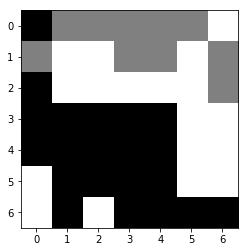

((0, 0), (1, 0)): n_v:  3419 q_all:+0.303276 q:+0.375061 q_m:+0.266667 p:0.508960
((0, 0), (0, 2)): n_v:   254 q_all:+0.305824 q:+0.217330 q_m:+0.233333 p:0.035998
((2, 0), (0, 1)): n_v:   220 q_all:+0.346951 q:+0.192431 q_m:+0.233333 p:0.004627
((3, 4), (1, 6)): n_v:   214 q_all:+0.351078 q:+0.203630 q_m:+0.300000 p:0.001760
((0, 0), (0, 1)): n_v:   111 q_all:+0.293757 q:+0.215857 q_m:+0.266667 p:0.019592
((3, 0), (1, 0)): n_v:    19 q_all:+0.159031 q:+0.236143 q_m:+0.233333 p:0.010785
((2, 0), (0, 2)): n_v:     5 q_all:+0.231973 q:+0.184637 q_m:+0.233333 p:0.002009
((3, 2), (1, 0)): n_v:     3 q_all:+0.093580 q:+0.110496 q_m:+0.233333 p:0.002411
((3, 1), (1, 0)): n_v:     1 q_all:-0.021476 q:+0.135021 q_m:+0.233333 p:0.001060
((3, 2), (1, 4)): n_v:     0 q_all:+0.177556 q:+0.177556 q_m:+0.366667 p:0.000370
((3, 4), (2, 6)): n_v:     0 q_all:+0.225095 q:+0.225095 q_m:+0.366667 p:0.000211
((3, 1), (1, 3)): n_v:     0 q_all:+0.136601 q:+0.136601 q_m:+0.366667 p:0.000591
((3, 4), (1, 3))

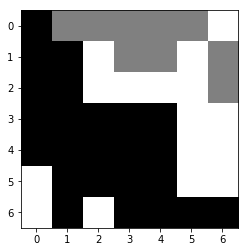

((1, 2), (0, 1)): n_v:  3293 q_all:-0.199920 q:-0.222382 q_m:-0.033333 p:0.315861
((2, 3), (0, 1)): n_v:   560 q_all:-0.280450 q:-0.210753 q_m:-0.066667 p:0.179143
((2, 2), (0, 1)): n_v:   171 q_all:-0.299769 q:-0.249739 q_m:-0.066667 p:0.063664
((2, 3), (0, 5)): n_v:   162 q_all:-0.458191 q:-0.416165 q_m:-0.266667 p:0.132512
((0, 6), (0, 5)): n_v:   101 q_all:-0.412580 q:-0.417723 q_m:-0.233333 p:0.069924
((2, 4), (0, 5)): n_v:    50 q_all:-0.459290 q:-0.401599 q_m:-0.266667 p:0.041270
((2, 5), (0, 5)): n_v:    18 q_all:-0.484169 q:-0.438723 q_m:-0.266667 p:0.016716
((1, 5), (2, 6)): n_v:     6 q_all:-0.401692 q:-0.348139 q_m:-0.233333 p:0.004017
((0, 6), (2, 6)): n_v:     5 q_all:-0.422132 q:-0.367936 q_m:-0.266667 p:0.004120
((2, 4), (1, 6)): n_v:     5 q_all:-0.474670 q:-0.423664 q_m:-0.266667 p:0.004864
((3, 6), (1, 6)): n_v:     4 q_all:-0.466801 q:-0.433004 q_m:-0.266667 p:0.003736
((0, 6), (1, 6)): n_v:     3 q_all:-0.421330 q:-0.403276 q_m:-0.233333 p:0.002573
((2, 3), (0, 4))

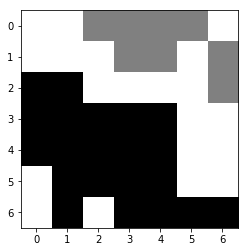

((2, 0), (0, 2)): n_v:  2335 q_all:+0.171756 q:+0.273464 q_m:+0.233333 p:0.608041
((3, 4), (2, 6)): n_v:   865 q_all:+0.228483 q:+0.221714 q_m:+0.300000 p:0.086498
((3, 4), (1, 6)): n_v:   362 q_all:+0.248065 q:+0.192148 q_m:+0.233333 p:0.016094
((3, 4), (1, 3)): n_v:   341 q_all:+0.223664 q:+0.329088 q_m:+0.300000 p:0.039024
((3, 4), (1, 4)): n_v:   111 q_all:+0.184510 q:+0.245260 q_m:+0.300000 p:0.024788
((2, 1), (1, 3)): n_v:    93 q_all:+0.061353 q:+0.218392 q_m:+0.300000 p:0.053108
((3, 2), (1, 3)): n_v:    88 q_all:+0.109834 q:+0.181688 q_m:+0.300000 p:0.038327
((2, 1), (0, 2)): n_v:    60 q_all:+0.055322 q:+0.178676 q_m:+0.233333 p:0.035318
((4, 4), (2, 6)): n_v:    50 q_all:+0.145727 q:+0.231621 q_m:+0.300000 p:0.016409
((3, 3), (1, 4)): n_v:    49 q_all:+0.124266 q:+0.174437 q_m:+0.300000 p:0.019598
((3, 2), (1, 4)): n_v:    37 q_all:+0.077439 q:+0.124006 q_m:+0.300000 p:0.019345
((3, 1), (1, 3)): n_v:    26 q_all:+0.011526 q:+0.131015 q_m:+0.300000 p:0.018613
((3, 3), (1, 3))

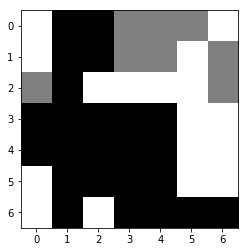

((1, 0), (2, 0)): n_v:  2805 q_all:-0.111588 q:-0.052321 q_m:+0.066667 p:0.437411
((0, 0), (2, 0)): n_v:   426 q_all:-0.153824 q:-0.116216 q_m:+0.033333 p:0.122799
((1, 5), (2, 6)): n_v:    85 q_all:-0.350307 q:-0.307397 q_m:-0.200000 p:0.077004
((0, 6), (2, 6)): n_v:    79 q_all:-0.368060 q:-0.332623 q_m:-0.233333 p:0.075874
((2, 2), (2, 0)): n_v:    16 q_all:-0.203169 q:-0.163061 q_m:+0.033333 p:0.007506
((2, 2), (1, 3)): n_v:     7 q_all:-0.281165 q:-0.321622 q_m:-0.066667 p:0.005407
((2, 4), (2, 6)): n_v:     4 q_all:-0.413480 q:-0.407115 q_m:-0.233333 p:0.005060
((4, 5), (2, 6)): n_v:     3 q_all:-0.492628 q:-0.427758 q_m:-0.233333 p:0.005091
((4, 6), (2, 6)): n_v:     3 q_all:-0.478465 q:-0.426385 q_m:-0.233333 p:0.004621
((1, 5), (1, 3)): n_v:     2 q_all:-0.286187 q:-0.309268 q_m:-0.100000 p:0.001085
((3, 5), (1, 3)): n_v:     1 q_all:-0.428164 q:-0.418110 q_m:-0.100000 p:0.001469
((2, 5), (1, 3)): n_v:     1 q_all:-0.367329 q:-0.342473 q_m:-0.100000 p:0.001656
((3, 6), (1, 6))

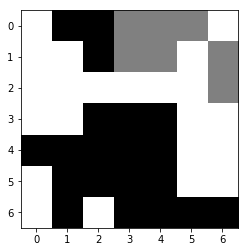

((1, 2), (1, 4)): n_v:  2531 q_all:+0.276484 q:+0.109045 q_m:+0.200000 p:0.183297
((0, 2), (1, 3)): n_v:   896 q_all:+0.151130 q:+0.219901 q_m:+0.166667 p:0.221596
((0, 2), (1, 4)): n_v:   172 q_all:+0.082575 q:+0.094790 q_m:+0.200000 p:0.087524
((0, 1), (1, 3)): n_v:   125 q_all:+0.097088 q:+0.091496 q_m:+0.133333 p:0.056650
((0, 2), (0, 4)): n_v:    82 q_all:+0.010791 q:+0.000146 q_m:-0.000000 p:0.064488
((1, 2), (0, 4)): n_v:    82 q_all:+0.019293 q:+0.006675 q_m:-0.000000 p:0.061706
((3, 4), (2, 6)): n_v:    51 q_all:+0.096055 q:+0.028620 q_m:+0.200000 p:0.023558
((3, 2), (1, 4)): n_v:    16 q_all:-0.027880 q:-0.017356 q_m:+0.200000 p:0.015583
((3, 4), (1, 3)): n_v:    11 q_all:+0.015013 q:+0.067817 q_m:+0.133333 p:0.008625
((3, 3), (1, 4)): n_v:    10 q_all:-0.104509 q:-0.011330 q_m:+0.200000 p:0.012408
((3, 4), (1, 6)): n_v:     8 q_all:+0.082829 q:-0.010369 q_m:+0.133333 p:0.004214
((3, 4), (1, 4)): n_v:     7 q_all:-0.013041 q:+0.033921 q_m:+0.200000 p:0.006700
((0, 2), (0, 3))

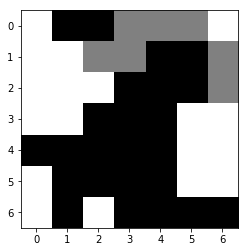

((0, 6), (2, 6)): n_v:  2079 q_all:-0.153021 q:-0.195150 q_m:-0.066667 p:0.114624
((2, 2), (1, 3)): n_v:   415 q_all:-0.309358 q:-0.122529 q_m:+0.100000 p:0.179610
((2, 2), (0, 3)): n_v:   371 q_all:-0.205931 q:-0.309992 q_m:-0.066667 p:0.008121
((1, 1), (1, 3)): n_v:   282 q_all:-0.326604 q:-0.208963 q_m:+0.066667 p:0.141097
((3, 5), (2, 6)): n_v:   232 q_all:-0.276572 q:-0.204313 q_m:-0.033333 p:0.070269
((1, 1), (1, 2)): n_v:   174 q_all:-0.242284 q:-0.050610 q_m:+0.033333 p:0.028862
((2, 1), (1, 3)): n_v:   147 q_all:-0.380782 q:-0.236219 q_m:+0.066667 p:0.105743
((3, 0), (1, 2)): n_v:   100 q_all:-0.266257 q:-0.184304 q_m:-0.000000 p:0.026103
((0, 0), (1, 2)): n_v:    59 q_all:-0.267987 q:-0.076212 q_m:-0.000000 p:0.015296
((3, 5), (1, 3)): n_v:    41 q_all:-0.354393 q:-0.219567 q_m:+0.066667 p:0.025463
((2, 2), (0, 4)): n_v:    39 q_all:-0.279788 q:-0.342995 q_m:-0.066667 p:0.012572
((3, 1), (1, 3)): n_v:    26 q_all:-0.303212 q:-0.270879 q_m:+0.066667 p:0.010761
((1, 0), (1, 2))

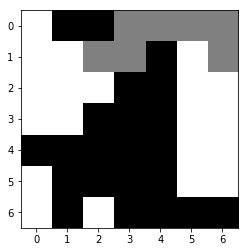

((1, 4), (1, 6)): n_v:  2252 q_all:+0.311359 q:+0.240806 q_m:+0.266667 p:0.021537
((0, 1), (1, 2)): n_v:  1009 q_all:+0.128311 q:+0.336456 q_m:+0.300000 p:0.343682
((2, 4), (1, 2)): n_v:   321 q_all:+0.194700 q:+0.322184 q_m:+0.266667 p:0.015373
((1, 4), (1, 2)): n_v:    35 q_all:+0.137530 q:+0.356171 q_m:+0.266667 p:0.010124
((2, 4), (1, 6)): n_v:    30 q_all:+0.112585 q:+0.145320 q_m:+0.266667 p:0.012460
((1, 4), (0, 4)): n_v:    28 q_all:+0.136311 q:+0.084122 q_m:+0.166667 p:0.008704
((3, 4), (1, 6)): n_v:    20 q_all:+0.073656 q:+0.083888 q_m:+0.266667 p:0.011412
((3, 4), (1, 2)): n_v:    20 q_all:+0.148017 q:+0.205845 q_m:+0.266667 p:0.004749
((1, 4), (0, 5)): n_v:    17 q_all:+0.095317 q:+0.097834 q_m:+0.166667 p:0.008200
((3, 3), (1, 2)): n_v:    16 q_all:-0.067057 q:+0.065477 q_m:+0.266667 p:0.018704
((3, 2), (1, 2)): n_v:    10 q_all:-0.055889 q:+0.008421 q_m:+0.266667 p:0.011958
((0, 2), (1, 3)): n_v:     2 q_all:-0.152599 q:+0.068358 q_m:+0.166667 p:0.003221
((2, 4), (0, 5))

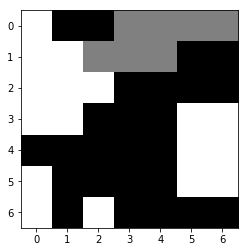

((2, 2), (1, 4)): n_v:  3044 q_all:-0.195735 q:-0.235149 q_m:-0.000000 p:0.275165
((1, 1), (1, 2)): n_v:   272 q_all:-0.293971 q:-0.087980 q_m:-0.033333 p:0.077360
((3, 0), (1, 2)): n_v:   227 q_all:-0.373813 q:-0.230377 q_m:-0.066667 p:0.142110
((3, 6), (1, 4)): n_v:   211 q_all:-0.403852 q:-0.290210 q_m:-0.000000 p:0.158138
((0, 0), (1, 2)): n_v:    89 q_all:-0.309984 q:-0.103362 q_m:-0.066667 p:0.030881
((3, 1), (1, 2)): n_v:    47 q_all:-0.431068 q:-0.237625 q_m:-0.066667 p:0.039590
((3, 5), (1, 4)): n_v:    42 q_all:-0.411588 q:-0.261263 q_m:-0.000000 p:0.032851
((2, 0), (1, 2)): n_v:    39 q_all:-0.376455 q:-0.240291 q_m:-0.066667 p:0.025325
((1, 0), (1, 2)): n_v:    27 q_all:-0.355121 q:-0.186756 q_m:-0.066667 p:0.014776
((2, 2), (1, 3)): n_v:     3 q_all:-0.484873 q:-0.358643 q_m:-0.033333 p:0.002932
((2, 2), (0, 3)): n_v:     1 q_all:-0.446145 q:-0.418917 q_m:-0.200000 p:0.001585
((1, 1), (1, 3)): n_v:     1 q_all:-0.407942 q:-0.400478 q_m:-0.066667 p:0.001260
((2, 1), (1, 3))

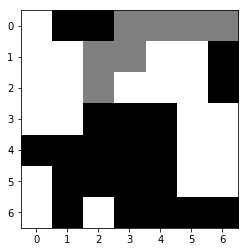

((0, 2), (1, 3)): n_v:  2237 q_all:+0.288504 q:+0.157798 q_m:+0.233333 p:0.083148
((3, 2), (2, 2)): n_v:  1503 q_all:+0.192387 q:+0.302296 q_m:+0.300000 p:0.331704
((0, 1), (2, 2)): n_v:   593 q_all:+0.199830 q:+0.275614 q_m:+0.266667 p:0.114991
((0, 1), (1, 3)): n_v:   102 q_all:+0.205755 q:+0.152154 q_m:+0.200000 p:0.017409
((1, 6), (0, 5)): n_v:    82 q_all:+0.195486 q:+0.207338 q_m:+0.166667 p:0.017266
((0, 2), (2, 2)): n_v:    68 q_all:+0.177965 q:+0.274916 q_m:+0.266667 p:0.018490
((0, 2), (0, 3)): n_v:    25 q_all:+0.162780 q:-0.003142 q_m:+0.100000 p:0.008355
((4, 0), (2, 2)): n_v:    19 q_all:+0.146254 q:+0.113897 q_m:+0.266667 p:0.007585
((0, 2), (0, 4)): n_v:    13 q_all:+0.011799 q:+0.066339 q_m:+0.133333 p:0.011215
((4, 4), (2, 2)): n_v:     4 q_all:+0.085337 q:+0.113793 q_m:+0.266667 p:0.002579
((3, 4), (2, 2)): n_v:     4 q_all:+0.150096 q:+0.182455 q_m:+0.266667 p:0.001575
((0, 1), (1, 2)): n_v:     3 q_all:+0.064335 q:+0.146560 q_m:+0.233333 p:0.002361
((0, 1), (0, 3))

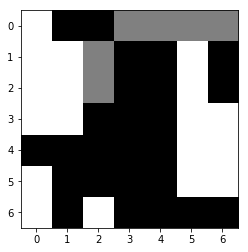

((3, 1), (1, 2)): n_v:  2130 q_all:-0.264468 q:-0.227192 q_m:+0.033333 p:0.107993
((1, 1), (1, 2)): n_v:   411 q_all:-0.360589 q:-0.109395 q_m:+0.066667 p:0.146052
((1, 5), (0, 3)): n_v:   286 q_all:-0.317818 q:-0.352106 q_m:-0.033333 p:0.062835
((1, 1), (2, 2)): n_v:   191 q_all:-0.372511 q:-0.278840 q_m:+0.066667 p:0.075081
((3, 0), (1, 2)): n_v:   180 q_all:-0.342952 q:-0.248261 q_m:+0.033333 p:0.053888
((1, 1), (0, 3)): n_v:   131 q_all:-0.437527 q:-0.439209 q_m:-0.033333 p:0.078495
((0, 0), (1, 2)): n_v:   113 q_all:-0.411082 q:-0.185834 q_m:+0.033333 p:0.058087
((2, 0), (1, 2)): n_v:   113 q_all:-0.398437 q:-0.270730 q_m:+0.033333 p:0.053848
((3, 0), (2, 2)): n_v:   100 q_all:-0.342553 q:-0.387498 q_m:+0.033333 p:0.029143
((1, 0), (2, 2)): n_v:    78 q_all:-0.313960 q:-0.289944 q_m:+0.033333 p:0.016289
((1, 0), (1, 2)): n_v:    43 q_all:-0.402649 q:-0.231543 q_m:+0.033333 p:0.021419
((2, 1), (0, 3)): n_v:    37 q_all:-0.473859 q:-0.420830 q_m:-0.033333 p:0.026986
((2, 5), (0, 3))

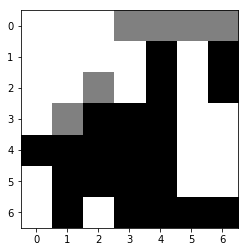

((3, 2), (3, 1)): n_v:  3321 q_all:+0.221383 q:+0.264670 q_m:+0.200000 p:0.113506
((4, 1), (2, 2)): n_v:   238 q_all:+0.191565 q:-0.053054 q_m:+0.300000 p:0.030989
((4, 0), (2, 2)): n_v:   139 q_all:+0.156667 q:+0.026003 q_m:+0.300000 p:0.033642
((3, 2), (2, 2)): n_v:    64 q_all:+0.024416 q:+0.136879 q_m:+0.333333 p:0.042852
((1, 4), (2, 2)): n_v:    17 q_all:-0.046595 q:+0.060375 q_m:+0.300000 p:0.015476
((4, 2), (2, 2)): n_v:    14 q_all:-0.044629 q:-0.007259 q_m:+0.300000 p:0.013089
((4, 3), (2, 2)): n_v:    12 q_all:-0.187858 q:-0.181746 q_m:+0.300000 p:0.017005
((4, 4), (2, 2)): n_v:     6 q_all:-0.110754 q:-0.058008 q_m:+0.300000 p:0.007215
((4, 3), (3, 1)): n_v:     5 q_all:-0.122402 q:-0.076227 q_m:+0.166667 p:0.005238
((5, 3), (3, 1)): n_v:     5 q_all:-0.262546 q:-0.117681 q_m:+0.166667 p:0.008903
((2, 4), (2, 2)): n_v:     5 q_all:-0.020422 q:+0.039246 q_m:+0.300000 p:0.003925
((1, 4), (0, 3)): n_v:     3 q_all:+0.083327 q:-0.053551 q_m:+0.200000 p:0.001676
((5, 1), (3, 1))

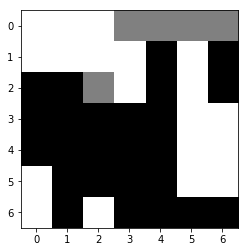

((1, 1), (2, 2)): n_v:  2307 q_all:-0.307474 q:-0.283352 q_m:+0.100000 p:0.145676
((0, 2), (2, 2)): n_v:  1016 q_all:-0.309712 q:-0.334712 q_m:+0.066667 p:0.070376
((1, 0), (2, 2)): n_v:   383 q_all:-0.393009 q:-0.301217 q_m:+0.066667 p:0.116214
((0, 0), (2, 2)): n_v:   349 q_all:-0.334431 q:-0.253998 q_m:+0.066667 p:0.048595
((0, 1), (2, 2)): n_v:   290 q_all:-0.375854 q:-0.410365 q_m:+0.066667 p:0.073834
((2, 3), (0, 5)): n_v:     6 q_all:-0.380428 q:-0.438158 q_m:-0.066667 p:0.001767
((1, 5), (0, 5)): n_v:     2 q_all:-0.446360 q:-0.377246 q_m:-0.033333 p:0.001197
((1, 3), (0, 5)): n_v:     1 q_all:-0.354060 q:-0.324030 q_m:-0.066667 p:0.000145
((1, 5), (0, 6)): n_v:     1 q_all:-0.557473 q:-0.405524 q_m:-0.100000 p:0.000420
((2, 3), (0, 4)): n_v:     0 q_all:-0.591096 q:-0.591096 q_m:-0.133333 p:0.000118
((0, 1), (0, 3)): n_v:     0 q_all:-0.546528 q:-0.546528 q_m:-0.133333 p:0.000026
((2, 5), (0, 3)): n_v:     0 q_all:-0.580697 q:-0.580697 q_m:-0.133333 p:0.000030
((0, 2), (0, 3))

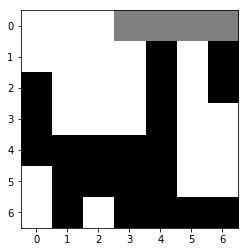

((1, 4), (0, 3)): n_v:  3454 q_all:+0.410592 q:+0.207147 q_m:+0.133333 p:0.661273
((2, 4), (0, 3)): n_v:   158 q_all:+0.100101 q:-0.050123 q_m:+0.100000 p:0.183842
((1, 6), (0, 6)): n_v:    18 q_all:-0.206392 q:-0.224387 q_m:-0.000000 p:0.039957
((1, 6), (0, 4)): n_v:    10 q_all:-0.376248 q:-0.328251 q_m:+0.033333 p:0.027721
((1, 4), (0, 4)): n_v:     6 q_all:-0.316046 q:-0.313224 q_m:+0.066667 p:0.015871
((2, 6), (0, 4)): n_v:     3 q_all:-0.264994 q:-0.402652 q_m:+0.033333 p:0.007307
((2, 6), (0, 5)): n_v:     3 q_all:-0.306480 q:-0.283022 q_m:-0.033333 p:0.007140
((1, 4), (0, 5)): n_v:     3 q_all:-0.362857 q:-0.365386 q_m:-0.000000 p:0.007898
((2, 6), (0, 6)): n_v:     3 q_all:-0.369067 q:-0.287964 q_m:-0.033333 p:0.008892
((2, 4), (0, 6)): n_v:     1 q_all:-0.352824 q:-0.339850 q_m:-0.033333 p:0.003550
((1, 4), (0, 6)): n_v:     0 q_all:-0.329995 q:-0.329995 q_m:-0.033333 p:0.001584
((2, 4), (0, 5)): n_v:     0 q_all:-0.383418 q:-0.383418 q_m:-0.033333 p:0.001437
((2, 4), (0, 4))

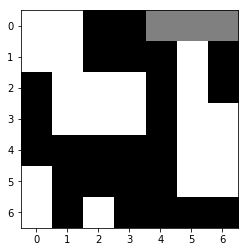

((1, 5), (0, 4)): n_v:  3664 q_all:-0.606974 q:-0.471976 q_m:+0.100000 p:0.860368
((1, 5), (0, 5)): n_v:   336 q_all:-0.596812 q:-0.397834 q_m:+0.033333 p:0.069390
((2, 5), (0, 4)): n_v:   217 q_all:-0.559345 q:-0.598131 q_m:+0.066667 p:0.022350
((2, 3), (0, 4)): n_v:    96 q_all:-0.600296 q:-0.628611 q_m:+0.066667 p:0.020967
((2, 2), (0, 4)): n_v:    38 q_all:-0.710652 q:-0.637003 q_m:+0.066667 p:0.019273
((2, 3), (0, 5)): n_v:     6 q_all:-0.651450 q:-0.676050 q_m:-0.000000 p:0.001666
((1, 5), (0, 6)): n_v:     6 q_all:-0.741398 q:-0.807514 q_m:-0.033333 p:0.003831
((2, 5), (0, 5)): n_v:     2 q_all:-0.778905 q:-0.673559 q_m:-0.000000 p:0.001743
((2, 5), (0, 6)): n_v:     0 q_all:-0.731611 q:-0.731611 q_m:-0.066667 p:0.000188
-1 's turn
one move takes time(s):  0.0621945858001709
train_mode is both train
no. of data collected:  8


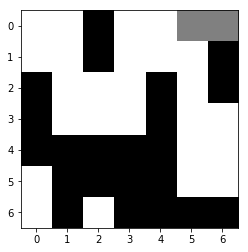

((1, 6), (0, 5)): n_v:  4557 q_all:+0.786694 q:+0.504799 q_m:+0.133333 p:0.781345
((2, 6), (0, 5)): n_v:    86 q_all:+0.228409 q:+0.115807 q_m:+0.100000 p:0.146568
((2, 4), (0, 5)): n_v:    29 q_all:-0.062985 q:-0.053047 q_m:+0.100000 p:0.069609
((2, 4), (0, 6)): n_v:     0 q_all:-0.685384 q:-0.685384 q_m:-0.033333 p:0.000214
((2, 6), (0, 6)): n_v:     0 q_all:-0.778867 q:-0.778867 q_m:-0.033333 p:0.000640
((1, 6), (0, 6)): n_v:     0 q_all:-0.723276 q:-0.723276 q_m:-0.000000 p:0.001544
1 's turn
one move takes time(s):  0.04084134101867676
train_mode is both train
no. of data collected:  8


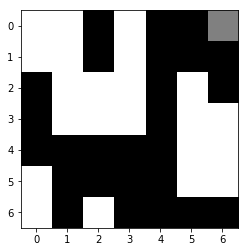

((2, 5), (0, 6)): n_v:  4900 q_all:-0.943666 q:-0.819812 q_m:+0.066667 p:0.995370
-1 's turn


This is a random move


one move takes time(s):  0.034638404846191406
train_mode is both train
no. of data collected:  8


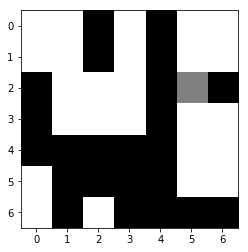

((1, 4), (2, 5)): n_v:  5175 q_all:+1.000000 q:+5.000000 q_m:+0.233333 p:0.179249
((0, 4), (2, 5)): n_v:    79 q_all:+0.835050 q:+0.404473 q_m:+0.200000 p:0.035100
((4, 3), (2, 5)): n_v:     8 q_all:-0.213678 q:+0.010986 q_m:+0.200000 p:0.022710
((4, 4), (2, 5)): n_v:     5 q_all:-0.205597 q:-0.046716 q_m:+0.200000 p:0.015385
this self play has 83 steps, time elapsed 103.3848557472229
winner is -1.0
episode 91 finished
episode 92 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.37359070777893066
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.3963456153869629
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.7107560634613037
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0010836124420166
train_mode is both train
no. of data collected:  8
-1 's turn


This 

one move takes time(s):  0.3756718635559082
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5472571849822998
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.0137932300567627
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.021723985671997
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.729865550994873
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.123422145843506


This is a random move


one move takes time(s):  2.125446081161499
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.774691104888916
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9717445373535156
train_mode i

one move takes time(s):  0.49825191497802734
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.39670324325561523
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2748427391052246
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5138328075408936
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.338454008102417
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.21462512016296387
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.36936283111572266
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.22096538543701172
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.20664525032043457
train_mode is both train
no. of data collected:  8
1 's

due to rollout lim, final rollout times:  1601 time elapsed:  3.9470980167388916
one move takes time(s):  3.948539972305298
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1963024139404297
one move takes time(s):  2.1976375579833984
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.5331859588623047
train_mode is both train
no. of data collected:  8
-1 's turn
due to time lim, final rollout times:  377 time elapsed:  230.50715804100037
one move takes time(s):  230.53742265701294
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3981986045837402
one move takes time(s):  2.3994224071502686
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.038440227508545
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):

one move takes time(s):  1.3479042053222656
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.030735969543457
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.181975841522217
one move takes time(s):  2.1830968856811523
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9016406536102295
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.8110334873199463
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.367081880569458
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1256897449493408
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8278224468231201
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1

Epoch 10/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8626 - activation_29_loss: 1.8257 - dense_15_loss: 0.0119 - val_loss: 1.8697 - val_activation_29_loss: 1.8350 - val_dense_15_loss: 0.0097
Epoch 11/512
9000/9000 [==============================] - 1s 90us/step - loss: 1.8599 - activation_29_loss: 1.8231 - dense_15_loss: 0.0118 - val_loss: 1.8691 - val_activation_29_loss: 1.8344 - val_dense_15_loss: 0.0097
Epoch 12/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8585 - activation_29_loss: 1.8219 - dense_15_loss: 0.0116 - val_loss: 1.8692 - val_activation_29_loss: 1.8345 - val_dense_15_loss: 0.0097
Epoch 13/512
9000/9000 [==============================] - 1s 97us/step - loss: 1.8574 - activation_29_loss: 1.8206 - dense_15_loss: 0.0118 - val_loss: 1.8695 - val_activation_29_loss: 1.8347 - val_dense_15_loss: 0.0098
Epoch 14/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8559 - activation_29_loss: 1.8194 - dense_1

9000/9000 [==============================] - 1s 92us/step - loss: 1.8263 - activation_29_loss: 1.7914 - dense_15_loss: 0.0098 - val_loss: 1.8736 - val_activation_29_loss: 1.8385 - val_dense_15_loss: 0.0100
Epoch 48/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8249 - activation_29_loss: 1.7901 - dense_15_loss: 0.0097 - val_loss: 1.8737 - val_activation_29_loss: 1.8385 - val_dense_15_loss: 0.0101
Epoch 49/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8233 - activation_29_loss: 1.7887 - dense_15_loss: 0.0095 - val_loss: 1.8737 - val_activation_29_loss: 1.8386 - val_dense_15_loss: 0.0101
Epoch 50/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8246 - activation_29_loss: 1.7897 - dense_15_loss: 0.0098 - val_loss: 1.8738 - val_activation_29_loss: 1.8387 - val_dense_15_loss: 0.0101
Epoch 51/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8231 - activation_29_loss: 1.7884 - dense_15_loss: 0.009

due to rollout lim, final rollout times:  1601 time elapsed:  2.848435401916504
one move takes time(s):  2.850099802017212
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.269665479660034
one move takes time(s):  2.2708959579467773
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.7684924602508545
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.114643096923828
one move takes time(s):  2.1158125400543213
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.000638723373413


This is a random move


one move takes time(s):  2.0019028186798096
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.793583631515503
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, fin

due to rollout lim, final rollout times:  1601 time elapsed:  3.096376895904541


This is a random move


one move takes time(s):  3.097038507461548
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.2015562057495117


This is a random move


one move takes time(s):  3.202799081802368
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.207322835922241
one move takes time(s):  4.2085254192352295
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.7389063835144043
one move takes time(s):  3.7400708198547363
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.471637725830078
one move takes time(s):  3.4730026721954346
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, 



This is a random move


one move takes time(s):  0.3881192207336426
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6876976490020752
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2946956157684326
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0307528972625732


This is a random move


one move takes time(s):  2.031301736831665
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2417373657226562


This is a random move


one move takes time(s):  2.24277400970459
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.356553792953491


This is a random move


one move takes time(s):  2.3575916290283203
train_mode is both train
no. of data collected:  8
1 's tur



This is a random move


one move takes time(s):  0.3758232593536377
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5271661281585693
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7617738246917725
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0366363525390625
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.817697286605835
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.392296075820923
one move takes time(s):  2.39282488822937
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3862576484680176
one move takes time(s):  2.3871912956237793
train_mode is both train
no. of data collected:  8
1 's turn


one move takes time(s):  0.9159073829650879
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7366609573364258
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4590113162994385
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4613943099975586
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.36459851264953613
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.6312954425811768
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3619818687438965
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.597968339920044
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5749685764312744
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s): 

one move takes time(s):  1.703193187713623
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.754150629043579
one move takes time(s):  3.755471706390381
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.929131031036377
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.840846538543701
one move takes time(s):  2.8424806594848633
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7599549293518066


This is a random move


one move takes time(s):  2.7610743045806885
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1839964389801025
one move takes time(s):  2.185034990310669
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, fin

Epoch 9/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8598 - activation_29_loss: 1.8246 - dense_15_loss: 0.0102 - val_loss: 1.8532 - val_activation_29_loss: 1.8165 - val_dense_15_loss: 0.0117
Epoch 10/512
9000/9000 [==============================] - 1s 97us/step - loss: 1.8580 - activation_29_loss: 1.8231 - dense_15_loss: 0.0099 - val_loss: 1.8532 - val_activation_29_loss: 1.8165 - val_dense_15_loss: 0.0117
Epoch 11/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8564 - activation_29_loss: 1.8213 - dense_15_loss: 0.0100 - val_loss: 1.8532 - val_activation_29_loss: 1.8165 - val_dense_15_loss: 0.0116
Epoch 12/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8563 - activation_29_loss: 1.8211 - dense_15_loss: 0.0102 - val_loss: 1.8531 - val_activation_29_loss: 1.8165 - val_dense_15_loss: 0.0116
Epoch 13/512
9000/9000 [==============================] - 1s 97us/step - loss: 1.8536 - activation_29_loss: 1.8187 - dense_15

9000/9000 [==============================] - 1s 91us/step - loss: 1.8242 - activation_29_loss: 1.7904 - dense_15_loss: 0.0088 - val_loss: 1.8592 - val_activation_29_loss: 1.8225 - val_dense_15_loss: 0.0116
Epoch 47/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8231 - activation_29_loss: 1.7892 - dense_15_loss: 0.0089 - val_loss: 1.8593 - val_activation_29_loss: 1.8227 - val_dense_15_loss: 0.0116
Epoch 48/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8231 - activation_29_loss: 1.7891 - dense_15_loss: 0.0090 - val_loss: 1.8594 - val_activation_29_loss: 1.8226 - val_dense_15_loss: 0.0118
Epoch 49/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8217 - activation_29_loss: 1.7881 - dense_15_loss: 0.0086 - val_loss: 1.8595 - val_activation_29_loss: 1.8228 - val_dense_15_loss: 0.0116
Epoch 50/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8210 - activation_29_loss: 1.7872 - dense_15_loss: 0.008

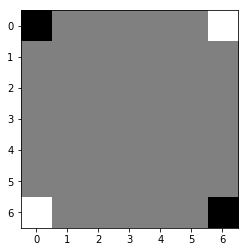

((6, 6), (5, 5)): n_v:   660 q_all:+0.009256 q:+0.012289 q_m:+0.033333 p:0.362484
((0, 0), (1, 1)): n_v:   619 q_all:+0.004938 q:+0.005141 q_m:+0.033333 p:0.353069
((6, 6), (6, 5)): n_v:   160 q_all:+0.003122 q:+0.002129 q_m:+0.033333 p:0.092659
((0, 0), (0, 1)): n_v:   157 q_all:-0.003170 q:-0.015560 q_m:+0.033333 p:0.095586
((6, 6), (5, 6)): n_v:    85 q_all:+0.007278 q:+0.000871 q_m:+0.033333 p:0.047907
((0, 0), (1, 0)): n_v:    79 q_all:+0.000535 q:+0.003807 q_m:+0.033333 p:0.046772
((6, 6), (6, 4)): n_v:     0 q_all:-0.011780 q:-0.011780 q_m:-0.000000 p:0.000033
((0, 0), (1, 2)): n_v:     0 q_all:-0.023401 q:-0.023401 q_m:-0.000000 p:0.000051
((0, 0), (2, 2)): n_v:     0 q_all:-0.027493 q:-0.027493 q_m:-0.000000 p:0.000262
((0, 0), (0, 2)): n_v:     0 q_all:-0.028449 q:-0.028449 q_m:-0.000000 p:0.000027
((6, 6), (4, 6)): n_v:     0 q_all:-0.021957 q:-0.021957 q_m:-0.000000 p:0.000132
((6, 6), (5, 4)): n_v:     0 q_all:+0.003739 q:+0.003739 q_m:-0.000000 p:0.000105
((6, 6), (4, 4))

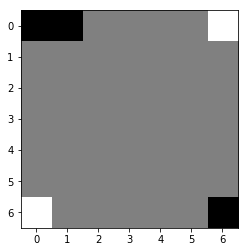

((0, 6), (1, 5)): n_v:   696 q_all:-0.013921 q:-0.014402 q_m:-0.000000 p:0.355756
((6, 0), (5, 1)): n_v:   679 q_all:-0.016646 q:-0.010501 q_m:-0.000000 p:0.355329
((0, 6), (1, 6)): n_v:   219 q_all:-0.016546 q:-0.015202 q_m:-0.000000 p:0.114910
((6, 0), (5, 0)): n_v:   191 q_all:-0.014287 q:-0.011076 q_m:-0.000000 p:0.098047
((0, 6), (0, 5)): n_v:    71 q_all:-0.024320 q:-0.025723 q_m:-0.000000 p:0.040014
((6, 0), (6, 1)): n_v:    61 q_all:-0.025160 q:-0.012424 q_m:-0.000000 p:0.034276
((0, 6), (2, 4)): n_v:     0 q_all:-0.041972 q:-0.041972 q_m:-0.033333 p:0.000173
((6, 0), (6, 2)): n_v:     0 q_all:-0.029746 q:-0.029746 q_m:-0.033333 p:0.000048
((6, 0), (5, 2)): n_v:     0 q_all:-0.028898 q:-0.028898 q_m:-0.033333 p:0.000089
((6, 0), (4, 1)): n_v:     0 q_all:-0.010326 q:-0.010326 q_m:-0.033333 p:0.000112
((0, 6), (2, 6)): n_v:     0 q_all:-0.020330 q:-0.020330 q_m:-0.033333 p:0.000344
((0, 6), (0, 4)): n_v:     0 q_all:-0.042111 q:-0.042111 q_m:-0.033333 p:0.000055
((0, 6), (2, 5))

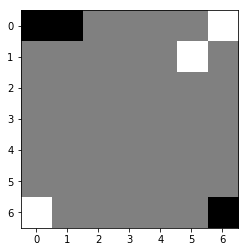

((0, 0), (1, 1)): n_v:   800 q_all:+0.005442 q:-0.007681 q_m:+0.033333 p:0.222763
((6, 6), (5, 5)): n_v:   732 q_all:+0.007019 q:+0.008647 q_m:+0.033333 p:0.198898
((6, 6), (6, 5)): n_v:   338 q_all:+0.000335 q:-0.000913 q_m:+0.033333 p:0.100985
((0, 0), (1, 0)): n_v:   218 q_all:-0.005400 q:-0.022436 q_m:+0.033333 p:0.070242
((0, 1), (1, 2)): n_v:   147 q_all:-0.014801 q:-0.029884 q_m:+0.033333 p:0.053191
((6, 6), (5, 6)): n_v:   137 q_all:-0.000975 q:-0.004577 q_m:+0.033333 p:0.041714
((0, 1), (0, 2)): n_v:    81 q_all:-0.008075 q:-0.024381 q_m:+0.033333 p:0.026865
((0, 1), (0, 3)): n_v:     1 q_all:-0.036710 q:-0.026762 q_m:-0.000000 p:0.000412
((0, 0), (2, 1)): n_v:     1 q_all:-0.020851 q:-0.023829 q_m:-0.000000 p:0.000407
((0, 0), (2, 2)): n_v:     1 q_all:-0.037291 q:-0.033948 q_m:-0.000000 p:0.000499
((6, 6), (6, 4)): n_v:     0 q_all:-0.015055 q:-0.015055 q_m:-0.000000 p:0.000050
((0, 0), (0, 2)): n_v:     0 q_all:-0.033107 q:-0.033107 q_m:-0.000000 p:0.000059
((0, 1), (2, 2))

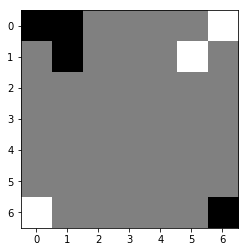

((0, 6), (1, 6)): n_v:   600 q_all:-0.021944 q:-0.034028 q_m:-0.000000 p:0.206889
((1, 5), (2, 4)): n_v:   435 q_all:+0.002595 q:-0.015452 q_m:-0.000000 p:0.107724
((6, 0), (5, 0)): n_v:   398 q_all:-0.016000 q:-0.012926 q_m:-0.000000 p:0.128125
((1, 5), (1, 4)): n_v:   328 q_all:+0.000346 q:-0.018715 q_m:-0.000000 p:0.084208
((1, 5), (2, 6)): n_v:   250 q_all:-0.019416 q:-0.015668 q_m:-0.000000 p:0.083648
((6, 0), (5, 1)): n_v:   196 q_all:-0.015312 q:-0.011298 q_m:-0.000000 p:0.062532
((1, 5), (2, 5)): n_v:   142 q_all:-0.010873 q:-0.012470 q_m:-0.000000 p:0.042761
((1, 5), (0, 4)): n_v:    75 q_all:-0.019196 q:-0.032875 q_m:-0.000000 p:0.025216
((0, 6), (0, 5)): n_v:    59 q_all:-0.025748 q:-0.045252 q_m:-0.000000 p:0.021329
((6, 0), (6, 1)): n_v:    58 q_all:-0.017091 q:-0.011900 q_m:-0.000000 p:0.019153
((1, 5), (1, 3)): n_v:     1 q_all:-0.056550 q:-0.037912 q_m:-0.033333 p:0.000914
((1, 5), (3, 3)): n_v:     0 q_all:-0.036607 q:-0.036607 q_m:-0.033333 p:0.000039
((1, 5), (0, 3))

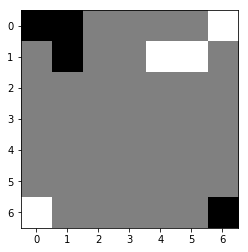

((6, 6), (5, 5)): n_v:   618 q_all:+0.028504 q:+0.030195 q_m:+0.033333 p:0.173162
((1, 1), (2, 2)): n_v:   342 q_all:-0.021070 q:+0.011288 q_m:+0.033333 p:0.169944
((0, 0), (1, 0)): n_v:   229 q_all:+0.015280 q:+0.003982 q_m:+0.033333 p:0.077646
((6, 6), (6, 5)): n_v:   220 q_all:+0.024869 q:+0.021057 q_m:+0.033333 p:0.065177
((0, 1), (0, 2)): n_v:   150 q_all:-0.020005 q:-0.003684 q_m:+0.033333 p:0.073838
((1, 1), (2, 1)): n_v:   142 q_all:-0.014870 q:+0.022931 q_m:+0.033333 p:0.067017
((0, 1), (1, 2)): n_v:    90 q_all:-0.009077 q:-0.006546 q_m:+0.033333 p:0.040293
((6, 6), (5, 6)): n_v:    68 q_all:+0.026460 q:+0.017210 q_m:+0.033333 p:0.019847
((1, 1), (2, 0)): n_v:    45 q_all:+0.020152 q:+0.023516 q_m:+0.033333 p:0.014279
((0, 1), (0, 3)): n_v:    35 q_all:+0.004738 q:+0.022109 q_m:+0.066667 p:0.013578
((0, 1), (1, 3)): n_v:    31 q_all:-0.001434 q:+0.022665 q_m:+0.066667 p:0.012999
((1, 1), (2, 3)): n_v:    29 q_all:+0.007402 q:+0.008108 q_m:+0.066667 p:0.010931
((1, 1), (1, 3))

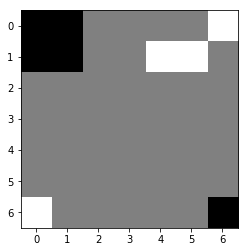

((1, 4), (2, 5)): n_v:   780 q_all:+0.038305 q:-0.010654 q_m:-0.000000 p:0.223964
((1, 5), (2, 6)): n_v:   227 q_all:+0.024900 q:-0.007868 q_m:-0.000000 p:0.079224
((1, 4), (1, 3)): n_v:   212 q_all:+0.035194 q:-0.013396 q_m:-0.000000 p:0.064199
((0, 6), (1, 6)): n_v:   168 q_all:-0.004261 q:-0.033071 q_m:-0.000000 p:0.080346
((1, 4), (2, 4)): n_v:    97 q_all:+0.002985 q:-0.021671 q_m:-0.000000 p:0.043639
((1, 4), (0, 4)): n_v:    92 q_all:-0.007739 q:-0.046157 q_m:-0.000000 p:0.045438
((6, 0), (5, 1)): n_v:    84 q_all:+0.028011 q:-0.015880 q_m:-0.000000 p:0.028204
((1, 4), (0, 3)): n_v:    76 q_all:+0.019537 q:-0.033706 q_m:-0.000000 p:0.028312
((1, 4), (1, 2)): n_v:    74 q_all:-0.022850 q:+0.033026 q_m:+0.100000 p:0.041716
((1, 4), (2, 3)): n_v:    57 q_all:+0.028295 q:-0.015853 q_m:-0.000000 p:0.019064
((0, 6), (0, 5)): n_v:    39 q_all:+0.000944 q:-0.033851 q_m:-0.000000 p:0.018129
((6, 0), (5, 0)): n_v:    30 q_all:+0.017161 q:-0.018171 q_m:-0.000000 p:0.011777
((6, 0), (6, 1))

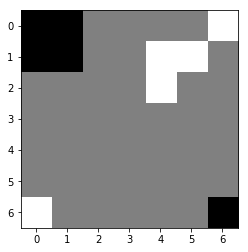

((0, 1), (1, 3)): n_v:   643 q_all:+0.044716 q:+0.057365 q_m:+0.133333 p:0.237365
((1, 1), (1, 3)): n_v:   490 q_all:+0.028334 q:+0.048987 q_m:+0.133333 p:0.217982
((6, 6), (5, 5)): n_v:   153 q_all:+0.032913 q:+0.035766 q_m:+0.033333 p:0.065199
((1, 0), (2, 1)): n_v:   123 q_all:-0.044708 q:+0.005120 q_m:+0.033333 p:0.096867
((6, 6), (6, 5)): n_v:    98 q_all:+0.026078 q:+0.029036 q_m:+0.033333 p:0.044659
((1, 1), (2, 3)): n_v:    63 q_all:+0.021581 q:+0.040800 q_m:+0.133333 p:0.030363
((1, 1), (2, 2)): n_v:    61 q_all:-0.024545 q:+0.009217 q_m:+0.033333 p:0.042156
((0, 1), (0, 2)): n_v:    50 q_all:-0.045056 q:+0.009399 q_m:+0.033333 p:0.039748
((0, 1), (2, 3)): n_v:    32 q_all:+0.023927 q:+0.041765 q_m:+0.133333 p:0.014934
((0, 1), (1, 2)): n_v:    25 q_all:-0.022715 q:+0.021826 q_m:+0.033333 p:0.017551
((1, 1), (3, 3)): n_v:    25 q_all:+0.018799 q:+0.026906 q_m:+0.066667 p:0.012429
((1, 0), (2, 0)): n_v:    24 q_all:+0.021640 q:+0.020158 q_m:+0.033333 p:0.011486
((6, 6), (5, 6))

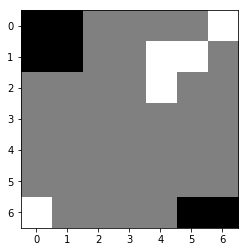

((1, 4), (2, 5)): n_v:   285 q_all:+0.024655 q:-0.033619 q_m:-0.000000 p:0.104754
((0, 6), (1, 6)): n_v:   223 q_all:+0.024478 q:-0.044647 q_m:-0.000000 p:0.081992
((2, 4), (1, 2)): n_v:   208 q_all:-0.004228 q:+0.038932 q_m:+0.100000 p:0.105568
((1, 5), (2, 6)): n_v:   143 q_all:+0.035826 q:-0.018850 q_m:-0.000000 p:0.044955
((2, 4), (3, 5)): n_v:   134 q_all:+0.034237 q:-0.031413 q_m:-0.000000 p:0.043207
((2, 4), (1, 6)): n_v:   104 q_all:+0.000075 q:-0.058701 q_m:-0.033333 p:0.050869
((6, 0), (5, 1)): n_v:   100 q_all:+0.042479 q:-0.015615 q_m:-0.000000 p:0.027941
((6, 0), (5, 0)): n_v:    76 q_all:+0.035604 q:-0.017261 q_m:-0.000000 p:0.024055
((1, 4), (1, 2)): n_v:    63 q_all:+0.009312 q:+0.039290 q_m:+0.100000 p:0.028179
((2, 4), (0, 5)): n_v:    50 q_all:-0.009893 q:-0.070124 q_m:-0.033333 p:0.026652
((1, 4), (1, 3)): n_v:    47 q_all:-0.037899 q:-0.016894 q_m:-0.000000 p:0.032062
((1, 4), (0, 4)): n_v:    34 q_all:-0.094975 q:-0.052964 q_m:-0.000000 p:0.033150
((2, 4), (2, 6))

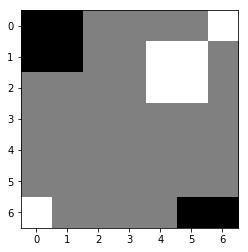

((1, 1), (2, 3)): n_v:   241 q_all:+0.017868 q:+0.036069 q_m:+0.133333 p:0.086557
((1, 1), (1, 3)): n_v:   236 q_all:+0.013943 q:+0.044542 q_m:+0.133333 p:0.089066
((6, 5), (5, 6)): n_v:   185 q_all:+0.023551 q:+0.023127 q_m:+0.033333 p:0.061819
((1, 0), (2, 0)): n_v:   176 q_all:+0.025592 q:+0.021440 q_m:+0.033333 p:0.057087
((0, 1), (1, 3)): n_v:   148 q_all:+0.041601 q:+0.049612 q_m:+0.133333 p:0.036900
((0, 1), (1, 2)): n_v:   128 q_all:-0.014724 q:+0.024904 q_m:+0.033333 p:0.065501
((0, 1), (0, 2)): n_v:    94 q_all:-0.052416 q:+0.014058 q_m:+0.033333 p:0.064246
((1, 1), (2, 2)): n_v:    89 q_all:-0.024265 q:+0.008794 q_m:+0.033333 p:0.049481
((0, 1), (2, 3)): n_v:    83 q_all:+0.036943 q:+0.039963 q_m:+0.133333 p:0.022727
((6, 5), (5, 5)): n_v:    77 q_all:+0.021346 q:+0.024303 q_m:+0.033333 p:0.026627
((0, 0), (2, 0)): n_v:    59 q_all:-0.001323 q:-0.005938 q_m:-0.000000 p:0.026451
((0, 1), (2, 0)): n_v:    53 q_all:+0.019825 q:+0.006988 q_m:-0.000000 p:0.018498
((1, 0), (3, 1))

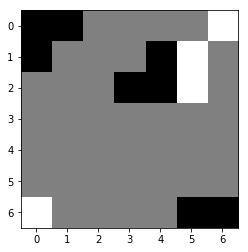

((2, 5), (1, 3)): n_v:   913 q_all:+0.059530 q:+0.009569 q_m:+0.066667 p:0.316074
((1, 5), (1, 3)): n_v:   811 q_all:+0.024487 q:+0.018809 q_m:+0.066667 p:0.407505
((2, 5), (3, 4)): n_v:   190 q_all:-0.017525 q:-0.058704 q_m:+0.033333 p:0.131385
((0, 6), (0, 5)): n_v:    22 q_all:-0.097390 q:-0.153430 q_m:-0.033333 p:0.023576
((1, 5), (0, 4)): n_v:    12 q_all:-0.111067 q:-0.133642 q_m:-0.033333 p:0.013969
((2, 5), (3, 3)): n_v:    10 q_all:-0.018363 q:-0.044411 q_m:-0.000000 p:0.007171
((1, 5), (3, 3)): n_v:     8 q_all:-0.036481 q:-0.052163 q_m:-0.000000 p:0.006890
((6, 0), (5, 1)): n_v:     8 q_all:-0.113434 q:-0.102163 q_m:-0.100000 p:0.008688
((2, 5), (3, 5)): n_v:     8 q_all:-0.115302 q:-0.097405 q_m:-0.033333 p:0.009145
((1, 5), (3, 4)): n_v:     5 q_all:-0.095705 q:-0.070971 q_m:-0.000000 p:0.006132
((0, 6), (1, 6)): n_v:     4 q_all:-0.182117 q:-0.167128 q_m:-0.100000 p:0.006083
((2, 5), (0, 3)): n_v:     2 q_all:-0.138238 q:-0.116797 q_m:-0.066667 p:0.003524
((2, 5), (0, 5))

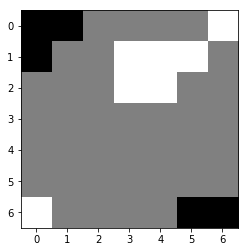

((0, 1), (1, 2)): n_v:  1280 q_all:-0.008670 q:+0.033208 q_m:+0.100000 p:0.314007
((0, 1), (0, 2)): n_v:   337 q_all:-0.086734 q:-0.006750 q_m:+0.033333 p:0.184600
((1, 0), (2, 1)): n_v:   170 q_all:-0.188301 q:-0.030522 q_m:-0.033333 p:0.159666
((0, 1), (2, 2)): n_v:   150 q_all:-0.023812 q:+0.028934 q_m:+0.066667 p:0.045710
((0, 1), (0, 3)): n_v:   145 q_all:-0.022581 q:+0.017410 q_m:+0.066667 p:0.043351
((1, 0), (2, 2)): n_v:   139 q_all:-0.031554 q:+0.030149 q_m:+0.066667 p:0.046485
((0, 0), (1, 1)): n_v:   102 q_all:+0.028029 q:-0.007460 q_m:-0.033333 p:0.010629
((0, 0), (1, 2)): n_v:   100 q_all:-0.034942 q:+0.034422 q_m:+0.066667 p:0.034813
((0, 0), (2, 2)): n_v:    89 q_all:-0.047388 q:+0.036631 q_m:+0.066667 p:0.035308
((1, 0), (1, 2)): n_v:    32 q_all:-0.026536 q:+0.017259 q_m:+0.066667 p:0.010128
((1, 0), (3, 2)): n_v:    27 q_all:-0.016226 q:+0.004241 q_m:-0.000000 p:0.007531
((0, 0), (0, 2)): n_v:    23 q_all:-0.044829 q:-0.004736 q_m:-0.000000 p:0.009086
((0, 0), (2, 1))

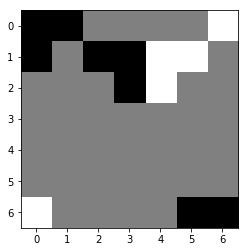

((2, 4), (2, 2)): n_v:  1946 q_all:+0.006953 q:+0.027194 q_m:+0.100000 p:0.622347
((1, 4), (2, 2)): n_v:   773 q_all:+0.018046 q:+0.035699 q_m:+0.100000 p:0.216078
((2, 4), (0, 2)): n_v:   126 q_all:-0.016945 q:-0.001857 q_m:+0.100000 p:0.051559
((1, 4), (0, 2)): n_v:    92 q_all:-0.011869 q:-0.013390 q_m:+0.100000 p:0.035390
((1, 4), (0, 3)): n_v:    20 q_all:-0.052834 q:-0.037713 q_m:+0.066667 p:0.010919
((6, 0), (5, 1)): n_v:    13 q_all:-0.082908 q:-0.047109 q_m:-0.066667 p:0.008709
((0, 6), (1, 6)): n_v:    10 q_all:-0.152454 q:-0.117819 q_m:-0.066667 p:0.008826
((1, 4), (0, 4)): n_v:     8 q_all:-0.101461 q:-0.100133 q_m:-0.000000 p:0.006304
((2, 4), (4, 2)): n_v:     8 q_all:-0.162724 q:-0.082084 q_m:-0.100000 p:0.008198
((2, 4), (0, 4)): n_v:     4 q_all:-0.104608 q:-0.124781 q_m:-0.033333 p:0.003235
((1, 5), (0, 3)): n_v:     2 q_all:-0.068858 q:-0.059741 q_m:+0.033333 p:0.001411
((2, 4), (0, 3)): n_v:     2 q_all:-0.056512 q:-0.037568 q_m:+0.033333 p:0.001304
((2, 4), (1, 6))

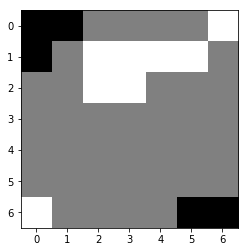

((0, 0), (1, 1)): n_v:  3107 q_all:+0.014218 q:-0.002398 q_m:+0.066667 p:0.266177
((0, 1), (0, 2)): n_v:   129 q_all:-0.075111 q:-0.029353 q_m:+0.066667 p:0.049200
((0, 1), (0, 3)): n_v:   102 q_all:+0.012211 q:+0.011844 q_m:+0.100000 p:0.009347
((1, 0), (2, 1)): n_v:    51 q_all:-0.086968 q:-0.009292 q_m:+0.066667 p:0.020925
((0, 0), (0, 2)): n_v:    16 q_all:-0.057831 q:-0.039047 q_m:+0.033333 p:0.005122
((1, 0), (3, 2)): n_v:    15 q_all:-0.028408 q:-0.009219 q_m:+0.033333 p:0.003349
((0, 0), (2, 1)): n_v:    15 q_all:-0.090380 q:-0.023383 q_m:+0.033333 p:0.006207
((0, 1), (2, 1)): n_v:    11 q_all:-0.088021 q:-0.023068 q_m:+0.033333 p:0.004627
((6, 5), (5, 5)): n_v:     7 q_all:-0.119542 q:-0.064525 q_m:-0.066667 p:0.003583
((6, 5), (6, 4)): n_v:     2 q_all:-0.092934 q:-0.068582 q_m:-0.066667 p:0.001118
((1, 0), (0, 2)): n_v:     2 q_all:-0.044082 q:-0.036753 q_m:+0.033333 p:0.000799
((1, 0), (2, 0)): n_v:     2 q_all:-0.121803 q:-0.082836 q_m:-0.066667 p:0.001569
((6, 5), (4, 4))

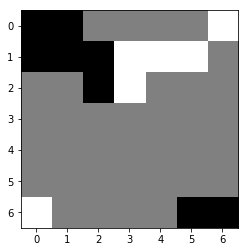

((1, 3), (2, 1)): n_v:  1054 q_all:+0.046158 q:+0.030832 q_m:+0.200000 p:0.077856
((2, 3), (0, 2)): n_v:   896 q_all:+0.009757 q:+0.030822 q_m:+0.133333 p:0.159876
((2, 3), (2, 1)): n_v:   848 q_all:+0.056020 q:+0.045011 q_m:+0.200000 p:0.038846
((1, 3), (0, 2)): n_v:   362 q_all:+0.020729 q:+0.046182 q_m:+0.166667 p:0.053287
((1, 4), (2, 5)): n_v:   305 q_all:-0.113006 q:-0.039107 q_m:-0.033333 p:0.162224
((1, 3), (2, 5)): n_v:   237 q_all:-0.108220 q:-0.059450 q_m:-0.066667 p:0.122340
((1, 3), (0, 4)): n_v:   153 q_all:-0.095704 q:-0.101589 q_m:-0.033333 p:0.073806
((2, 3), (2, 5)): n_v:   142 q_all:-0.112008 q:-0.052831 q_m:-0.066667 p:0.074847
((2, 3), (4, 1)): n_v:   105 q_all:-0.047823 q:+0.007747 q_m:-0.066667 p:0.036076
((1, 4), (0, 2)): n_v:    97 q_all:+0.035592 q:+0.043646 q_m:+0.133333 p:0.010181
((2, 3), (0, 4)): n_v:    85 q_all:-0.101599 q:-0.087284 q_m:-0.066667 p:0.042351
((2, 3), (4, 5)): n_v:    51 q_all:-0.063062 q:-0.008289 q_m:-0.066667 p:0.020000
((2, 3), (0, 5))

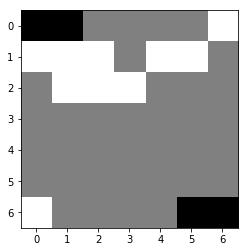

((0, 1), (1, 3)): n_v:  1055 q_all:-0.019619 q:-0.002160 q_m:+0.066667 p:0.252966
((0, 0), (2, 0)): n_v:   881 q_all:-0.083996 q:-0.045137 q_m:-0.000000 p:0.424760
((0, 1), (0, 2)): n_v:   532 q_all:-0.032219 q:-0.104641 q_m:-0.033333 p:0.152971
((0, 1), (2, 0)): n_v:    81 q_all:-0.060508 q:-0.034763 q_m:-0.000000 p:0.032196
((6, 5), (5, 5)): n_v:    36 q_all:-0.059877 q:-0.121827 q_m:-0.166667 p:0.014023
((6, 6), (4, 6)): n_v:    29 q_all:-0.089641 q:-0.162210 q_m:-0.200000 p:0.014934
((0, 0), (0, 2)): n_v:    26 q_all:-0.093396 q:-0.143881 q_m:-0.066667 p:0.013741
((6, 5), (5, 3)): n_v:    13 q_all:-0.139671 q:-0.152149 q_m:-0.200000 p:0.009217
((0, 1), (0, 3)): n_v:    10 q_all:-0.105528 q:-0.139070 q_m:-0.066667 p:0.005896
((6, 5), (5, 4)): n_v:    10 q_all:-0.108433 q:-0.119661 q_m:-0.166667 p:0.006285
((6, 6), (4, 4)): n_v:    10 q_all:-0.075848 q:-0.129244 q_m:-0.200000 p:0.004831
((6, 5), (4, 4)): n_v:     5 q_all:-0.086206 q:-0.119351 q_m:-0.200000 p:0.002599
((6, 5), (6, 4))

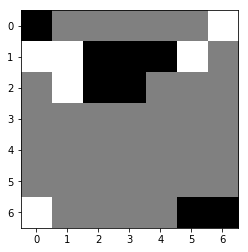

((1, 5), (2, 4)): n_v:  1353 q_all:+0.044167 q:+0.054437 q_m:+0.166667 p:0.373260
((1, 5), (0, 3)): n_v:   299 q_all:-0.000421 q:+0.027092 q_m:+0.133333 p:0.134330
((1, 0), (0, 1)): n_v:   236 q_all:+0.052953 q:+0.046900 q_m:+0.100000 p:0.057293
((2, 1), (0, 3)): n_v:   176 q_all:-0.021448 q:+0.005699 q_m:+0.133333 p:0.093448
((1, 1), (0, 3)): n_v:   106 q_all:-0.004698 q:+0.010985 q_m:+0.133333 p:0.049087
((0, 6), (0, 5)): n_v:    66 q_all:-0.016363 q:-0.025667 q_m:+0.033333 p:0.033837
((2, 1), (0, 1)): n_v:    62 q_all:+0.050363 q:+0.012628 q_m:+0.066667 p:0.015587
((1, 1), (0, 2)): n_v:    57 q_all:-0.017757 q:-0.030309 q_m:+0.100000 p:0.029689
((0, 6), (2, 4)): n_v:    38 q_all:+0.026682 q:+0.012998 q_m:+0.133333 p:0.013318
((1, 5), (0, 4)): n_v:    33 q_all:-0.028716 q:-0.012850 q_m:+0.100000 p:0.018504
((2, 1), (3, 2)): n_v:    27 q_all:-0.012391 q:+0.007349 q_m:+0.100000 p:0.013799
((1, 5), (2, 5)): n_v:    17 q_all:-0.071075 q:-0.005403 q_m:+0.033333 p:0.013005
((2, 1), (0, 2))

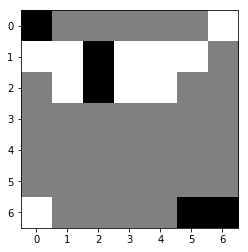

((0, 0), (2, 0)): n_v:   962 q_all:+0.047810 q:+0.041589 q_m:+0.033333 p:0.034720
((0, 0), (0, 1)): n_v:   497 q_all:-0.026697 q:-0.020815 q_m:-0.000000 p:0.153900
((2, 2), (0, 1)): n_v:   495 q_all:-0.034367 q:-0.030499 q_m:-0.033333 p:0.168212
((1, 2), (0, 3)): n_v:   173 q_all:-0.058165 q:-0.082202 q_m:-0.000000 p:0.073714
((2, 2), (3, 3)): n_v:   129 q_all:-0.053006 q:-0.049278 q_m:-0.000000 p:0.052788
((1, 2), (0, 2)): n_v:   121 q_all:-0.072062 q:-0.070723 q_m:-0.000000 p:0.057671
((2, 2), (0, 4)): n_v:   107 q_all:-0.038798 q:-0.028670 q_m:+0.033333 p:0.038268
((2, 2), (3, 2)): n_v:    91 q_all:-0.072770 q:-0.071977 q_m:-0.000000 p:0.044102
((1, 2), (0, 4)): n_v:    77 q_all:-0.024796 q:-0.023933 q_m:+0.033333 p:0.023358
((2, 2), (2, 0)): n_v:    50 q_all:-0.018300 q:+0.033144 q_m:+0.033333 p:0.014153
((1, 2), (2, 0)): n_v:    43 q_all:-0.022116 q:+0.006447 q_m:+0.033333 p:0.012921
((2, 2), (3, 4)): n_v:    24 q_all:-0.045322 q:-0.055180 q_m:-0.033333 p:0.009459
((2, 2), (0, 3))

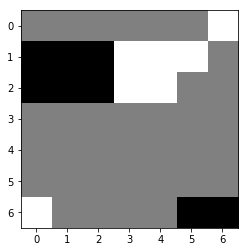

((2, 3), (0, 1)): n_v:   802 q_all:+0.008384 q:+0.034905 q_m:+0.166667 p:0.169541
((1, 3), (0, 1)): n_v:   387 q_all:-0.006447 q:+0.016070 q_m:+0.166667 p:0.104495
((2, 3), (0, 5)): n_v:   288 q_all:-0.136368 q:-0.079779 q_m:-0.033333 p:0.225979
((2, 3), (3, 1)): n_v:   273 q_all:+0.007540 q:+0.032579 q_m:+0.166667 p:0.058642
((2, 4), (3, 5)): n_v:   227 q_all:-0.035276 q:-0.017535 q_m:-0.000000 p:0.087550
((1, 3), (3, 1)): n_v:   131 q_all:-0.000802 q:+0.003467 q_m:+0.166667 p:0.032557
((1, 3), (0, 5)): n_v:   111 q_all:-0.147241 q:-0.080926 q_m:-0.033333 p:0.091887
((2, 3), (3, 5)): n_v:    70 q_all:-0.105376 q:-0.044117 q_m:-0.033333 p:0.046374
((1, 3), (3, 5)): n_v:    21 q_all:-0.106361 q:-0.062940 q_m:-0.033333 p:0.013692
((0, 6), (1, 6)): n_v:    19 q_all:-0.028176 q:-0.029983 q_m:-0.000000 p:0.006905
((1, 4), (2, 5)): n_v:    18 q_all:-0.033236 q:-0.032442 q_m:-0.000000 p:0.007099
((2, 3), (3, 2)): n_v:    17 q_all:-0.006974 q:+0.017239 q_m:+0.133333 p:0.004755
((1, 3), (0, 2))

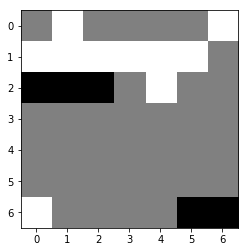

((2, 2), (0, 0)): n_v:  1015 q_all:+0.041557 q:+0.003583 q_m:+0.033333 p:0.327380
((2, 2), (0, 4)): n_v:   658 q_all:-0.008161 q:-0.029574 q_m:+0.033333 p:0.341666
((2, 2), (2, 3)): n_v:   425 q_all:+0.027151 q:+0.000949 q_m:+0.133333 p:0.161178
((2, 0), (0, 0)): n_v:   137 q_all:+0.066833 q:+0.001295 q_m:+0.033333 p:0.030632
((2, 0), (0, 2)): n_v:    76 q_all:+0.004259 q:+0.012434 q_m:+0.100000 p:0.035774
((2, 2), (0, 2)): n_v:    68 q_all:-0.014639 q:+0.009530 q_m:+0.100000 p:0.037213
((2, 1), (2, 3)): n_v:    57 q_all:-0.027908 q:-0.033304 q_m:+0.100000 p:0.034066
((2, 1), (0, 0)): n_v:    54 q_all:+0.048764 q:+0.012264 q_m:+0.033333 p:0.015423
((2, 1), (0, 2)): n_v:    39 q_all:+0.037997 q:+0.016275 q_m:+0.100000 p:0.013136
((2, 1), (0, 3)): n_v:     1 q_all:-0.054935 q:-0.108909 q_m:+0.033333 p:0.001242
((2, 2), (0, 3)): n_v:     1 q_all:-0.053933 q:-0.064388 q_m:+0.033333 p:0.001315
((2, 0), (3, 1)): n_v:     0 q_all:-0.114489 q:-0.114489 q_m:-0.133333 p:0.000017
((2, 1), (3, 3))

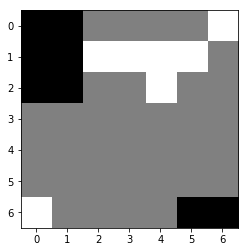

((1, 2), (2, 2)): n_v:  1616 q_all:-0.005657 q:+0.014171 q_m:+0.133333 p:0.372101
((2, 4), (2, 2)): n_v:   250 q_all:-0.003165 q:+0.013271 q_m:+0.100000 p:0.055323
((1, 2), (0, 2)): n_v:   196 q_all:+0.004729 q:+0.032829 q_m:+0.133333 p:0.037558
((1, 4), (2, 6)): n_v:   120 q_all:-0.040591 q:-0.019029 q_m:-0.033333 p:0.043683
((1, 2), (3, 1)): n_v:    87 q_all:+0.046929 q:+0.051609 q_m:+0.100000 p:0.002660
((1, 3), (0, 4)): n_v:    60 q_all:-0.088348 q:-0.037842 q_m:-0.000000 p:0.032918
((1, 2), (3, 0)): n_v:    60 q_all:+0.030854 q:+0.035406 q_m:+0.100000 p:0.005549
((2, 4), (3, 5)): n_v:    58 q_all:-0.097351 q:+0.014869 q_m:-0.000000 p:0.034031
((1, 4), (2, 2)): n_v:    42 q_all:-0.008658 q:-0.006159 q_m:+0.100000 p:0.010381
((2, 4), (0, 2)): n_v:    34 q_all:+0.012171 q:+0.032128 q_m:+0.100000 p:0.005476
((1, 4), (3, 6)): n_v:    17 q_all:-0.059427 q:-0.009659 q_m:-0.033333 p:0.007507
((1, 4), (2, 5)): n_v:    14 q_all:-0.108354 q:-0.012541 q_m:-0.000000 p:0.008676
((2, 4), (4, 2))

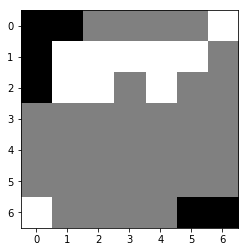

((0, 1), (0, 2)): n_v:  1671 q_all:+0.011945 q:+0.063917 q_m:+0.100000 p:0.524669
((0, 1), (2, 3)): n_v:   686 q_all:+0.033642 q:+0.053093 q_m:+0.200000 p:0.164177
((2, 0), (3, 1)): n_v:   497 q_all:+0.021465 q:+0.021290 q_m:+0.033333 p:0.139827
((2, 0), (0, 2)): n_v:   231 q_all:-0.008455 q:+0.020261 q_m:+0.066667 p:0.088893
((6, 5), (4, 3)): n_v:    75 q_all:-0.024751 q:-0.032028 q_m:-0.133333 p:0.033183
((0, 0), (0, 2)): n_v:    37 q_all:-0.028845 q:+0.020816 q_m:+0.066667 p:0.017105
((0, 1), (0, 3)): n_v:    34 q_all:+0.002046 q:-0.008267 q_m:+0.066667 p:0.011850
((6, 5), (6, 4)): n_v:    18 q_all:+0.008016 q:-0.019207 q_m:-0.100000 p:0.005965
((1, 0), (0, 2)): n_v:    11 q_all:-0.031656 q:+0.008741 q_m:+0.066667 p:0.005017
((1, 0), (3, 1)): n_v:     6 q_all:+0.012718 q:-0.021720 q_m:-0.000000 p:0.001563
((2, 0), (3, 2)): n_v:     1 q_all:+0.012804 q:-0.006027 q_m:-0.000000 p:0.000547
((2, 0), (3, 0)): n_v:     1 q_all:+0.027066 q:-0.029392 q_m:-0.033333 p:0.000471
((2, 0), (4, 1))

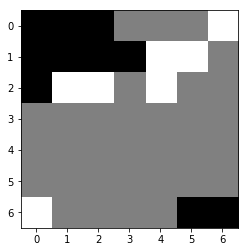

((1, 4), (0, 3)): n_v:  2407 q_all:+0.040488 q:+0.022015 q_m:+0.133333 p:0.688960
((2, 4), (0, 3)): n_v:   315 q_all:+0.041397 q:+0.017145 q_m:+0.100000 p:0.089268
((2, 2), (0, 3)): n_v:   279 q_all:+0.012355 q:+0.036940 q_m:+0.100000 p:0.106885
((2, 1), (0, 3)): n_v:   108 q_all:-0.011887 q:-0.002773 q_m:+0.100000 p:0.050301
((1, 5), (0, 3)): n_v:    55 q_all:+0.000705 q:+0.010688 q_m:+0.100000 p:0.023416
((1, 4), (2, 3)): n_v:    15 q_all:-0.064707 q:-0.023403 q_m:+0.066667 p:0.009839
((2, 1), (2, 3)): n_v:     3 q_all:-0.046619 q:-0.030872 q_m:+0.033333 p:0.001996
((2, 4), (1, 6)): n_v:     1 q_all:-0.177955 q:-0.125683 q_m:-0.100000 p:0.002035
((1, 4), (2, 5)): n_v:     1 q_all:-0.088128 q:-0.105008 q_m:-0.066667 p:0.001094
((0, 6), (1, 6)): n_v:     1 q_all:-0.157227 q:-0.111106 q_m:-0.066667 p:0.001378
((2, 1), (3, 1)): n_v:     0 q_all:-0.030720 q:-0.030720 q_m:-0.000000 p:0.000098
((1, 5), (3, 3)): n_v:     0 q_all:-0.147440 q:-0.147440 q_m:-0.100000 p:0.000000
((2, 4), (4, 5))

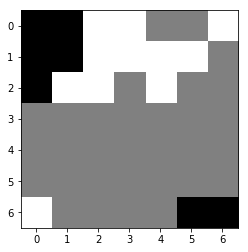

((0, 1), (2, 3)): n_v:  1417 q_all:-0.041703 q:+0.028457 q_m:+0.200000 p:0.414213
((2, 0), (3, 1)): n_v:   971 q_all:+0.032608 q:+0.031493 q_m:+0.033333 p:0.057693
((1, 1), (2, 3)): n_v:   729 q_all:-0.116589 q:+0.001483 q_m:+0.200000 p:0.384274
((6, 5), (4, 3)): n_v:   336 q_all:-0.028208 q:-0.035269 q_m:-0.133333 p:0.084133
((6, 5), (6, 4)): n_v:   179 q_all:-0.004940 q:-0.030514 q_m:-0.100000 p:0.031860
((6, 5), (5, 5)): n_v:    19 q_all:-0.007454 q:-0.033253 q_m:-0.100000 p:0.003645
((2, 0), (4, 1)): n_v:    12 q_all:-0.066999 q:-0.044817 q_m:-0.133333 p:0.004622
((6, 6), (6, 4)): n_v:     9 q_all:-0.033452 q:-0.051412 q_m:-0.133333 p:0.002533
((6, 5), (5, 6)): n_v:     5 q_all:-0.029014 q:-0.061223 q_m:-0.100000 p:0.001433
((2, 0), (3, 2)): n_v:     4 q_all:+0.004176 q:-0.009977 q_m:-0.000000 p:0.000706
((6, 6), (4, 5)): n_v:     4 q_all:-0.046283 q:-0.039080 q_m:-0.133333 p:0.001500
((2, 0), (3, 0)): n_v:     3 q_all:-0.049045 q:-0.030464 q_m:-0.033333 p:0.001181
((6, 5), (5, 4))

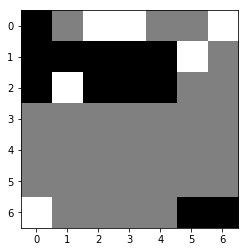

((0, 2), (0, 1)): n_v:  2505 q_all:+0.086406 q:+0.085964 q_m:+0.100000 p:0.497581
((0, 6), (0, 5)): n_v:   179 q_all:-0.142721 q:-0.139185 q_m:-0.100000 p:0.181754
((0, 3), (0, 1)): n_v:    64 q_all:+0.074396 q:+0.049489 q_m:+0.066667 p:0.015552
((1, 5), (2, 5)): n_v:    45 q_all:-0.017091 q:-0.027208 q_m:-0.033333 p:0.025998
((0, 3), (0, 4)): n_v:    22 q_all:-0.059505 q:-0.060617 q_m:-0.033333 p:0.016423
((2, 1), (0, 1)): n_v:    18 q_all:+0.032412 q:+0.048975 q_m:+0.066667 p:0.006907
((0, 3), (0, 5)): n_v:    13 q_all:-0.124443 q:-0.163274 q_m:-0.133333 p:0.013171
((0, 6), (2, 5)): n_v:    12 q_all:-0.027774 q:-0.047390 q_m:-0.066667 p:0.007674
((6, 0), (6, 1)): n_v:    12 q_all:-0.086107 q:-0.078924 q_m:-0.166667 p:0.009789
((2, 1), (3, 2)): n_v:     7 q_all:-0.034237 q:-0.066794 q_m:-0.033333 p:0.004559
((0, 3), (2, 5)): n_v:     4 q_all:-0.051232 q:-0.070024 q_m:-0.066667 p:0.003053
((2, 1), (3, 3)): n_v:     1 q_all:-0.042220 q:-0.001714 q_m:-0.000000 p:0.000742
((2, 1), (3, 1))

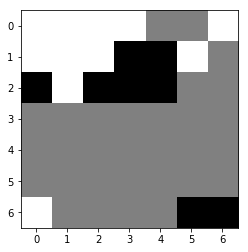

((1, 3), (0, 4)): n_v:  1863 q_all:-0.092247 q:-0.084088 q_m:+0.066667 p:0.348284
((2, 4), (0, 4)): n_v:   518 q_all:-0.071953 q:-0.116210 q_m:+0.033333 p:0.064814
((2, 3), (0, 4)): n_v:   450 q_all:-0.124972 q:-0.091966 q_m:+0.033333 p:0.129300
((2, 4), (1, 6)): n_v:   197 q_all:-0.062388 q:-0.113547 q_m:+0.033333 p:0.018806
((2, 3), (0, 5)): n_v:   167 q_all:-0.123004 q:-0.125182 q_m:+0.033333 p:0.047130
((2, 2), (0, 4)): n_v:   148 q_all:-0.086868 q:-0.101643 q_m:+0.033333 p:0.025328
((2, 4), (0, 5)): n_v:   122 q_all:-0.115514 q:-0.145289 q_m:+0.033333 p:0.031441
((1, 4), (2, 5)): n_v:    75 q_all:-0.108122 q:-0.169780 q_m:-0.000000 p:0.017857
((1, 4), (0, 5)): n_v:    70 q_all:-0.128366 q:-0.124731 q_m:+0.066667 p:0.020844
((1, 3), (0, 5)): n_v:    55 q_all:-0.100130 q:-0.138450 q_m:+0.033333 p:0.011624
((6, 5), (6, 4)): n_v:    17 q_all:-0.120843 q:-0.163663 q_m:-0.066667 p:0.004883
((6, 5), (5, 6)): n_v:    10 q_all:-0.133921 q:-0.192961 q_m:-0.066667 p:0.003441
((2, 4), (3, 5))

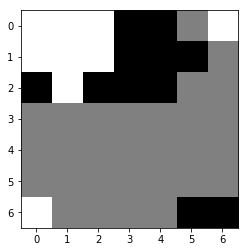

((0, 6), (0, 5)): n_v:  2830 q_all:+0.075252 q:+0.080996 q_m:+0.166667 p:0.847543
((0, 6), (2, 5)): n_v:   456 q_all:+0.112280 q:+0.098135 q_m:+0.133333 p:0.080631
((2, 1), (3, 2)): n_v:    50 q_all:+0.035682 q:+0.027104 q_m:+0.100000 p:0.021616
((2, 1), (3, 1)): n_v:    34 q_all:+0.069711 q:+0.060096 q_m:+0.100000 p:0.010889
((0, 6), (1, 6)): n_v:    20 q_all:-0.024691 q:+0.008969 q_m:+0.033333 p:0.013017
((6, 0), (6, 1)): n_v:    17 q_all:+0.005699 q:-0.020110 q_m:-0.033333 p:0.009205
((2, 1), (3, 3)): n_v:     8 q_all:-0.013192 q:+0.016650 q_m:+0.133333 p:0.005290
((1, 0), (3, 1)): n_v:     3 q_all:+0.006001 q:-0.021544 q_m:+0.066667 p:0.001847
((2, 1), (3, 0)): n_v:     3 q_all:+0.033776 q:+0.030252 q_m:+0.033333 p:0.001464
((6, 0), (4, 1)): n_v:     2 q_all:-0.022355 q:-0.047044 q_m:-0.066667 p:0.001631
((1, 1), (3, 3)): n_v:     1 q_all:-0.227793 q:-0.130842 q_m:+0.133333 p:0.002323
((6, 0), (5, 1)): n_v:     1 q_all:-0.019207 q:-0.022293 q_m:-0.033333 p:0.000895
((6, 0), (5, 0))

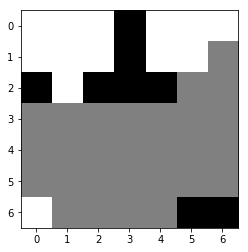

((2, 4), (1, 6)): n_v:  3278 q_all:-0.068051 q:-0.097076 q_m:+0.033333 p:0.686707
((2, 4), (2, 5)): n_v:   457 q_all:-0.149489 q:-0.149053 q_m:-0.000000 p:0.205660
((2, 3), (2, 5)): n_v:    82 q_all:-0.163344 q:-0.132708 q_m:-0.033333 p:0.040434
((6, 5), (5, 6)): n_v:    38 q_all:-0.203395 q:-0.251363 q_m:-0.133333 p:0.023083
((0, 3), (2, 5)): n_v:    35 q_all:-0.138924 q:-0.175790 q_m:-0.033333 p:0.015050
((1, 3), (2, 5)): n_v:     6 q_all:-0.237309 q:-0.171531 q_m:-0.033333 p:0.004576
((2, 4), (3, 5)): n_v:     2 q_all:-0.210202 q:-0.232900 q_m:-0.133333 p:0.001633
((6, 5), (5, 5)): n_v:     1 q_all:-0.213217 q:-0.224449 q_m:-0.133333 p:0.000671
((1, 3), (3, 2)): n_v:     0 q_all:-0.227968 q:-0.227968 q_m:-0.100000 p:0.000002
((6, 5), (5, 4)): n_v:     0 q_all:-0.216097 q:-0.216097 q_m:-0.133333 p:0.000052
((2, 3), (4, 2)): n_v:     0 q_all:-0.219352 q:-0.219352 q_m:-0.166667 p:0.000007
((6, 6), (6, 4)): n_v:     0 q_all:-0.243987 q:-0.243987 q_m:-0.166667 p:0.000014
((6, 5), (4, 5))

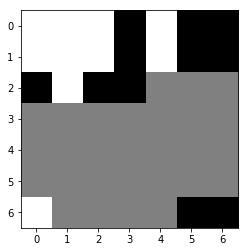

((1, 4), (2, 4)): n_v:  3795 q_all:+0.063623 q:+0.033101 q_m:+0.200000 p:0.842765
((1, 4), (2, 5)): n_v:   508 q_all:+0.069821 q:+0.069503 q_m:+0.133333 p:0.104089
((2, 1), (3, 1)): n_v:    49 q_all:+0.080858 q:+0.048883 q_m:+0.133333 p:0.008602
((0, 4), (2, 6)): n_v:    21 q_all:+0.058575 q:+0.066884 q_m:+0.100000 p:0.005015
((0, 2), (2, 4)): n_v:    19 q_all:-0.070181 q:-0.047705 q_m:+0.166667 p:0.011976
((2, 1), (3, 2)): n_v:    15 q_all:+0.006442 q:+0.019497 q_m:+0.133333 p:0.005740
((2, 1), (3, 0)): n_v:    12 q_all:-0.004238 q:+0.029306 q_m:+0.066667 p:0.004977
((0, 4), (2, 5)): n_v:    10 q_all:+0.056111 q:+0.029443 q_m:+0.100000 p:0.002510
((0, 4), (2, 4)): n_v:     7 q_all:+0.014308 q:-0.004045 q_m:+0.166667 p:0.002630
((1, 4), (2, 6)): n_v:     6 q_all:+0.057926 q:+0.050672 q_m:+0.100000 p:0.001506
((6, 0), (5, 1)): n_v:     4 q_all:+0.039798 q:-0.020805 q_m:-0.000000 p:0.001422
((1, 2), (2, 4)): n_v:     4 q_all:-0.145229 q:-0.100451 q_m:+0.166667 p:0.003398
((6, 0), (5, 0))

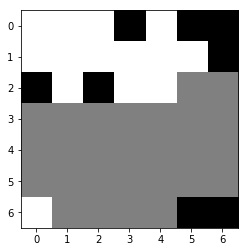

((1, 6), (2, 5)): n_v:  3819 q_all:-0.070830 q:-0.073583 q_m:+0.033333 p:0.781965
((0, 3), (2, 5)): n_v:   375 q_all:-0.075462 q:-0.086067 q_m:-0.000000 p:0.081300
((0, 6), (2, 5)): n_v:   300 q_all:-0.108273 q:-0.112792 q_m:-0.000000 p:0.091487
((0, 5), (2, 5)): n_v:    54 q_all:-0.167785 q:-0.166617 q_m:-0.000000 p:0.025538
((6, 6), (4, 5)): n_v:    14 q_all:-0.173219 q:-0.187814 q_m:-0.200000 p:0.006850
((2, 2), (3, 3)): n_v:    13 q_all:-0.103524 q:-0.128055 q_m:-0.033333 p:0.004090
((6, 5), (4, 5)): n_v:     6 q_all:-0.178128 q:-0.201438 q_m:-0.200000 p:0.003124
((2, 2), (3, 2)): n_v:     5 q_all:-0.108463 q:-0.099042 q_m:-0.033333 p:0.001395
((1, 6), (2, 6)): n_v:     3 q_all:-0.166636 q:-0.138576 q_m:-0.100000 p:0.001766
((2, 0), (4, 1)): n_v:     1 q_all:-0.157828 q:-0.188597 q_m:-0.200000 p:0.000607
((6, 5), (6, 4)): n_v:     0 q_all:-0.181393 q:-0.181393 q_m:-0.166667 p:0.000359
((6, 5), (5, 4)): n_v:     0 q_all:-0.174970 q:-0.174970 q_m:-0.166667 p:0.000091
((6, 5), (5, 5))

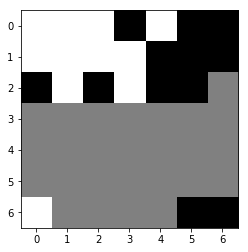

((2, 1), (3, 1)): n_v:  1917 q_all:+0.092834 q:+0.111523 q_m:+0.133333 p:0.257539
((0, 4), (2, 6)): n_v:  1392 q_all:+0.055412 q:+0.062176 q_m:+0.166667 p:0.326267
((2, 3), (3, 3)): n_v:   428 q_all:+0.025756 q:+0.042852 q_m:+0.133333 p:0.134590
((2, 3), (3, 4)): n_v:   391 q_all:+0.044675 q:-0.000721 q_m:+0.133333 p:0.103161
((2, 3), (3, 5)): n_v:   100 q_all:+0.011366 q:-0.002626 q_m:+0.100000 p:0.035393
((2, 3), (3, 1)): n_v:    89 q_all:+0.021177 q:+0.017937 q_m:+0.100000 p:0.029077
((1, 0), (3, 1)): n_v:    55 q_all:+0.035076 q:+0.009383 q_m:+0.100000 p:0.015877
((2, 1), (3, 2)): n_v:    50 q_all:+0.011706 q:+0.019549 q_m:+0.066667 p:0.017906
((6, 0), (5, 0)): n_v:    30 q_all:+0.031826 q:-0.008925 q_m:-0.000000 p:0.008983
((6, 0), (5, 1)): n_v:    30 q_all:+0.046136 q:-0.005193 q_m:-0.000000 p:0.007953
((2, 1), (3, 0)): n_v:    15 q_all:+0.035704 q:+0.059857 q_m:+0.066667 p:0.004556
((6, 0), (6, 1)): n_v:    14 q_all:+0.017397 q:-0.006463 q_m:-0.000000 p:0.004817
((6, 0), (4, 0))

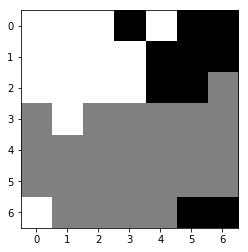

((2, 4), (3, 2)): n_v:  2717 q_all:-0.108048 q:-0.091572 q_m:+0.133333 p:0.651793
((2, 4), (3, 4)): n_v:   209 q_all:-0.169001 q:-0.148491 q_m:-0.033333 p:0.092196
((1, 4), (3, 2)): n_v:   157 q_all:-0.195931 q:-0.159942 q_m:+0.133333 p:0.083370
((1, 6), (3, 4)): n_v:    58 q_all:-0.190180 q:-0.174048 q_m:-0.066667 p:0.030038
((1, 5), (2, 6)): n_v:    39 q_all:-0.095311 q:-0.107769 q_m:-0.100000 p:0.007906
((2, 4), (3, 3)): n_v:    20 q_all:-0.140953 q:-0.118324 q_m:+0.033333 p:0.007181
((2, 5), (3, 3)): n_v:     7 q_all:-0.155022 q:-0.133502 q_m:-0.000000 p:0.002711
((1, 5), (3, 4)): n_v:     4 q_all:-0.292240 q:-0.180283 q_m:-0.066667 p:0.003279
((6, 5), (6, 4)): n_v:     4 q_all:-0.164145 q:-0.161605 q_m:-0.100000 p:0.001697
((2, 4), (4, 2)): n_v:     2 q_all:-0.174998 q:-0.168446 q_m:-0.066667 p:0.001226
((1, 4), (3, 4)): n_v:     1 q_all:-0.283432 q:-0.272970 q_m:-0.066667 p:0.000845
((2, 4), (3, 6)): n_v:     1 q_all:-0.247312 q:-0.238547 q_m:-0.133333 p:0.001013
((0, 6), (2, 6))

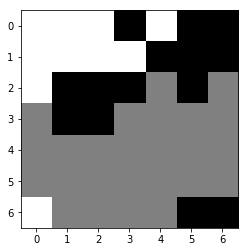

((1, 3), (2, 4)): n_v:  3830 q_all:+0.111396 q:+0.058108 q_m:+0.166667 p:0.952025
((2, 0), (3, 0)): n_v:    50 q_all:+0.086046 q:+0.030709 q_m:+0.033333 p:0.016269
((0, 2), (2, 4)): n_v:    19 q_all:-0.064711 q:-0.036516 q_m:+0.133333 p:0.015490
((6, 0), (4, 2)): n_v:     9 q_all:-0.009048 q:-0.031806 q_m:-0.000000 p:0.005658
((0, 4), (2, 4)): n_v:     5 q_all:+0.035292 q:+0.009566 q_m:+0.133333 p:0.002553
((1, 2), (2, 4)): n_v:     5 q_all:-0.099220 q:-0.074642 q_m:+0.133333 p:0.004537
((2, 0), (4, 2)): n_v:     1 q_all:-0.077146 q:-0.061190 q_m:-0.000000 p:0.000910
((1, 1), (3, 3)): n_v:     1 q_all:-0.228346 q:-0.167579 q_m:+0.066667 p:0.001198
((1, 1), (3, 0)): n_v:     0 q_all:-0.194397 q:-0.194397 q_m:-0.000000 p:0.000008
((1, 2), (3, 3)): n_v:     0 q_all:-0.095082 q:-0.095082 q_m:+0.066667 p:0.000228
((0, 4), (2, 6)): n_v:     0 q_all:+0.031171 q:+0.031171 q_m:+0.066667 p:0.000294
((1, 2), (3, 4)): n_v:     0 q_all:-0.141180 q:-0.141180 q_m:-0.000000 p:0.000017
((6, 0), (5, 0))

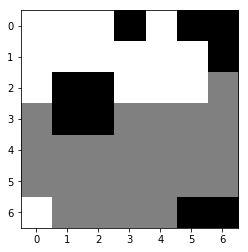

((3, 2), (3, 4)): n_v:  2651 q_all:-0.142322 q:-0.149719 q_m:+0.033333 p:0.574284
((1, 6), (2, 6)): n_v:  1462 q_all:-0.089546 q:-0.096461 q_m:-0.000000 p:0.110495
((2, 2), (3, 3)): n_v:   427 q_all:-0.137162 q:-0.146870 q_m:-0.000000 p:0.086664
((2, 2), (3, 4)): n_v:   128 q_all:-0.158386 q:-0.123546 q_m:+0.033333 p:0.033185
((1, 6), (3, 4)): n_v:    59 q_all:-0.158977 q:-0.150076 q_m:+0.033333 p:0.015505
((3, 1), (3, 3)): n_v:    56 q_all:-0.134095 q:-0.176336 q_m:-0.033333 p:0.010983
((3, 2), (5, 1)): n_v:    31 q_all:-0.129111 q:-0.173742 q_m:-0.100000 p:0.005790
((1, 6), (3, 5)): n_v:    28 q_all:-0.173075 q:-0.189774 q_m:-0.033333 p:0.008486
((2, 1), (3, 0)): n_v:    21 q_all:-0.135878 q:-0.146045 q_m:-0.066667 p:0.004364
((0, 6), (2, 6)): n_v:    19 q_all:-0.135629 q:-0.147178 q_m:-0.033333 p:0.003840
((3, 2), (5, 0)): n_v:    14 q_all:-0.132342 q:-0.180317 q_m:-0.100000 p:0.002658
((6, 5), (5, 5)): n_v:     7 q_all:-0.182155 q:-0.202298 q_m:-0.133333 p:0.002335
((2, 1), (3, 3))

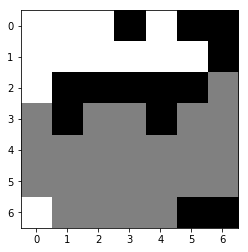

((1, 5), (2, 6)): n_v:  1703 q_all:+0.134508 q:+0.149711 q_m:+0.133333 p:0.362380
((1, 0), (3, 2)): n_v:   954 q_all:+0.079644 q:+0.089887 q_m:+0.233333 p:0.360731
((2, 0), (3, 2)): n_v:   362 q_all:+0.112410 q:+0.137056 q_m:+0.233333 p:0.101226
((2, 0), (3, 0)): n_v:   278 q_all:+0.138855 q:+0.085140 q_m:+0.133333 p:0.055524
((1, 5), (3, 3)): n_v:    78 q_all:+0.077972 q:+0.034797 q_m:+0.233333 p:0.029865
((1, 4), (3, 2)): n_v:    27 q_all:+0.104642 q:+0.099582 q_m:+0.233333 p:0.008146
((1, 1), (3, 3)): n_v:    20 q_all:-0.143656 q:-0.091756 q_m:+0.233333 p:0.021492
((1, 1), (3, 2)): n_v:    18 q_all:-0.019794 q:-0.024054 q_m:+0.233333 p:0.012747
((6, 0), (4, 2)): n_v:    14 q_all:+0.025711 q:-0.006699 q_m:+0.033333 p:0.007867
((6, 0), (5, 1)): n_v:     9 q_all:+0.046452 q:+0.013388 q_m:-0.000000 p:0.004627
((1, 4), (3, 3)): n_v:     6 q_all:-0.002031 q:-0.021338 q_m:+0.233333 p:0.004027
((0, 4), (2, 6)): n_v:     6 q_all:+0.008485 q:+0.024012 q_m:+0.100000 p:0.003500
((6, 0), (5, 0))

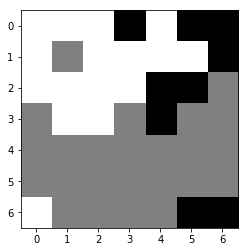

((0, 3), (1, 1)): n_v:  1467 q_all:+0.215358 q:+0.177476 q_m:+0.300000 p:0.115351
((2, 4), (3, 3)): n_v:   219 q_all:-0.088199 q:-0.148841 q_m:-0.000000 p:0.333065
((2, 5), (3, 3)): n_v:    52 q_all:+0.156093 q:-0.140880 q_m:-0.033333 p:0.018265
((3, 4), (5, 5)): n_v:    13 q_all:-0.168932 q:-0.227347 q_m:-0.233333 p:0.025818
((3, 4), (2, 6)): n_v:    11 q_all:-0.064844 q:-0.161197 q_m:-0.166667 p:0.016229
((1, 6), (2, 6)): n_v:     5 q_all:-0.093308 q:-0.156819 q_m:-0.133333 p:0.008588
((0, 6), (2, 6)): n_v:     2 q_all:-0.185797 q:-0.209985 q_m:-0.166667 p:0.005210
((3, 4), (4, 2)): n_v:     1 q_all:-0.199153 q:-0.181988 q_m:-0.100000 p:0.003438
((2, 4), (4, 2)): n_v:     1 q_all:-0.163420 q:-0.196588 q_m:-0.100000 p:0.002070
((0, 5), (2, 6)): n_v:     0 q_all:-0.239629 q:-0.239629 q_m:-0.166667 p:0.000228
((6, 6), (6, 4)): n_v:     0 q_all:-0.243526 q:-0.243526 q_m:-0.233333 p:0.000005
((2, 5), (4, 3)): n_v:     0 q_all:-0.180490 q:-0.180490 q_m:-0.166667 p:0.000006
((3, 4), (3, 6))

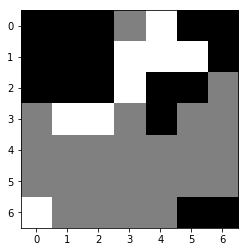

((0, 4), (0, 3)): n_v:  2241 q_all:-0.191203 q:-0.197485 q_m:-0.133333 p:0.282809
((2, 3), (3, 3)): n_v:   367 q_all:-0.256667 q:-0.264286 q_m:-0.066667 p:0.131053
((1, 5), (3, 3)): n_v:   331 q_all:-0.158149 q:-0.322240 q_m:-0.100000 p:0.002995
((2, 3), (3, 5)): n_v:    91 q_all:-0.312486 q:-0.309477 q_m:-0.100000 p:0.050688
((1, 3), (3, 5)): n_v:    88 q_all:-0.282663 q:-0.288034 q_m:-0.100000 p:0.039669
((3, 1), (3, 0)): n_v:    30 q_all:-0.262337 q:-0.242987 q_m:-0.133333 p:0.011434
((3, 1), (3, 3)): n_v:    24 q_all:-0.222189 q:-0.276264 q_m:-0.100000 p:0.005486
((1, 5), (0, 3)): n_v:    16 q_all:-0.209909 q:-0.235744 q_m:-0.166667 p:0.003249
((1, 5), (3, 5)): n_v:    16 q_all:-0.289538 q:-0.341049 q_m:-0.100000 p:0.007635
((1, 4), (3, 5)): n_v:     7 q_all:-0.332296 q:-0.306200 q_m:-0.100000 p:0.004499
((2, 3), (0, 3)): n_v:     5 q_all:-0.278890 q:-0.276518 q_m:-0.166667 p:0.002459
((0, 4), (2, 6)): n_v:     4 q_all:-0.288284 q:-0.300793 q_m:-0.166667 p:0.001958
((1, 5), (2, 6))

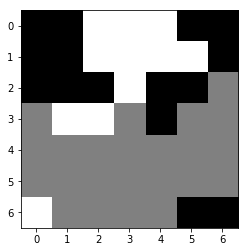

((2, 2), (3, 3)): n_v:  3250 q_all:+0.199078 q:+0.204053 q_m:+0.300000 p:0.283815
((1, 6), (2, 6)): n_v:   533 q_all:+0.179421 q:+0.155484 q_m:+0.233333 p:0.079808
((3, 4), (2, 6)): n_v:   104 q_all:+0.152109 q:+0.143130 q_m:+0.200000 p:0.024175
((2, 4), (4, 2)): n_v:    20 q_all:+0.197178 q:+0.109585 q_m:+0.266667 p:0.001873
((2, 5), (3, 3)): n_v:    19 q_all:+0.145314 q:+0.176171 q_m:+0.266667 p:0.004735
((3, 4), (4, 2)): n_v:    15 q_all:+0.127111 q:+0.135694 q_m:+0.266667 p:0.004772
((3, 4), (4, 5)): n_v:     7 q_all:+0.098171 q:+0.080695 q_m:+0.166667 p:0.002661
((6, 5), (6, 4)): n_v:     7 q_all:+0.066667 q:+0.095394 q_m:+0.166667 p:0.003879
((3, 4), (4, 4)): n_v:     7 q_all:+0.061365 q:+0.094850 q_m:+0.166667 p:0.003751
((3, 4), (5, 5)): n_v:     6 q_all:+0.104061 q:+0.088190 q_m:+0.133333 p:0.002637
((2, 2), (4, 4)): n_v:     4 q_all:+0.088491 q:+0.093983 q_m:+0.133333 p:0.002074
((2, 1), (3, 3)): n_v:     4 q_all:+0.047742 q:+0.098229 q_m:+0.266667 p:0.002308
((3, 4), (5, 6))

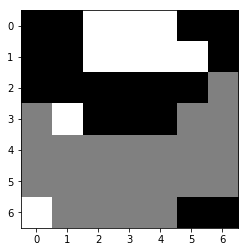

((3, 1), (3, 0)): n_v:  1393 q_all:-0.173257 q:-0.144890 q_m:-0.133333 p:0.274044
((3, 1), (4, 3)): n_v:  1094 q_all:-0.146112 q:-0.223810 q_m:-0.100000 p:0.131326
((1, 5), (2, 6)): n_v:   520 q_all:-0.149070 q:-0.137135 q_m:-0.133333 p:0.066848
((3, 1), (4, 2)): n_v:   436 q_all:-0.236250 q:-0.240168 q_m:-0.133333 p:0.163504
((1, 5), (3, 5)): n_v:   432 q_all:-0.256919 q:-0.224130 q_m:-0.100000 p:0.187427
((1, 3), (3, 5)): n_v:    98 q_all:-0.393242 q:-0.326472 q_m:-0.100000 p:0.080669
((1, 4), (3, 5)): n_v:    51 q_all:-0.353542 q:-0.291655 q_m:-0.100000 p:0.036247
((6, 0), (4, 2)): n_v:    36 q_all:-0.278129 q:-0.249308 q_m:-0.166667 p:0.018169
((3, 1), (4, 1)): n_v:    11 q_all:-0.292775 q:-0.287034 q_m:-0.200000 p:0.005902
((0, 4), (2, 6)): n_v:    11 q_all:-0.341865 q:-0.300152 q_m:-0.166667 p:0.007903
((1, 5), (3, 6)): n_v:     6 q_all:-0.322148 q:-0.293767 q_m:-0.233333 p:0.004149
((3, 1), (4, 0)): n_v:     4 q_all:-0.284514 q:-0.305149 q_m:-0.266667 p:0.002459
((6, 0), (5, 1))

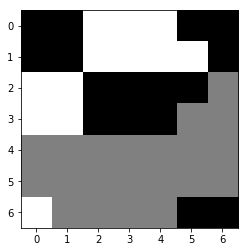

((1, 6), (2, 6)): n_v:  2634 q_all:+0.249480 q:+0.169626 q_m:+0.233333 p:0.538020
((3, 4), (2, 6)): n_v:    65 q_all:+0.168727 q:+0.130873 q_m:+0.200000 p:0.032026
((0, 6), (2, 6)): n_v:    34 q_all:+0.281880 q:+0.107067 q_m:+0.200000 p:0.003051
((3, 2), (4, 1)): n_v:    20 q_all:+0.146938 q:+0.167654 q_m:+0.300000 p:0.011758
((3, 4), (4, 5)): n_v:    13 q_all:+0.113569 q:+0.023438 q_m:+0.166667 p:0.008974
((6, 5), (6, 4)): n_v:     3 q_all:+0.069920 q:+0.051745 q_m:+0.166667 p:0.002909
((3, 2), (5, 1)): n_v:     2 q_all:+0.063058 q:+0.061411 q_m:+0.200000 p:0.002142
((2, 4), (3, 5)): n_v:     2 q_all:+0.025785 q:+0.026720 q_m:+0.166667 p:0.002318
((6, 5), (5, 6)): n_v:     2 q_all:+0.060139 q:+0.040243 q_m:+0.166667 p:0.002217
((6, 5), (5, 5)): n_v:     2 q_all:+0.067319 q:+0.060164 q_m:+0.166667 p:0.002454
((0, 5), (2, 6)): n_v:     1 q_all:-0.028433 q:+0.062101 q_m:+0.200000 p:0.000874
((3, 2), (4, 0)): n_v:     1 q_all:+0.069437 q:+0.072960 q_m:+0.266667 p:0.001015
((3, 3), (4, 1))

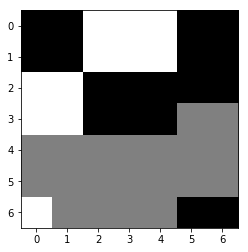

((1, 3), (3, 5)): n_v:   989 q_all:-0.361685 q:-0.217932 q_m:+0.033333 p:0.543790
((3, 1), (4, 2)): n_v:   850 q_all:-0.218903 q:-0.197472 q_m:-0.066667 p:0.101005
((3, 1), (4, 3)): n_v:   657 q_all:-0.248092 q:-0.216500 q_m:-0.033333 p:0.135906
((6, 0), (6, 1)): n_v:   426 q_all:-0.191018 q:-0.211449 q_m:-0.200000 p:0.014621
((6, 0), (5, 1)): n_v:   218 q_all:-0.221572 q:-0.226707 q_m:-0.200000 p:0.027749
((1, 4), (3, 5)): n_v:   187 q_all:-0.286487 q:-0.141410 q_m:+0.033333 p:0.060302
((3, 0), (5, 1)): n_v:   180 q_all:-0.213694 q:-0.265954 q_m:-0.233333 p:0.018582
((6, 0), (5, 0)): n_v:   141 q_all:-0.242585 q:-0.247800 q_m:-0.200000 p:0.027009
((3, 0), (4, 1)): n_v:    53 q_all:-0.237357 q:-0.210011 q_m:-0.133333 p:0.009306
((6, 0), (4, 2)): n_v:    37 q_all:-0.234462 q:-0.206347 q_m:-0.100000 p:0.006283
((6, 0), (4, 1)): n_v:    36 q_all:-0.283237 q:-0.251517 q_m:-0.166667 p:0.011248
((3, 0), (4, 2)): n_v:    15 q_all:-0.253186 q:-0.210886 q_m:-0.100000 p:0.003241
((2, 1), (4, 3))

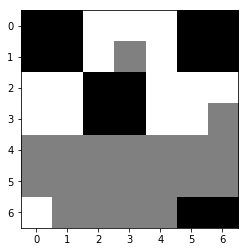

((2, 2), (1, 3)): n_v:  2411 q_all:+0.462665 q:+0.431760 q_m:+0.400000 p:0.416677
((3, 2), (1, 3)): n_v:    37 q_all:+0.363254 q:+0.347355 q_m:+0.366667 p:0.020863
((0, 1), (1, 3)): n_v:    33 q_all:+0.286031 q:+0.305879 q_m:+0.366667 p:0.028091
((0, 5), (1, 3)): n_v:    21 q_all:+0.237148 q:+0.283136 q_m:+0.366667 p:0.021238
((1, 5), (1, 3)): n_v:    11 q_all:+0.157289 q:+0.256187 q_m:+0.366667 p:0.014938
((1, 1), (1, 3)): n_v:    11 q_all:+0.123195 q:+0.198057 q_m:+0.366667 p:0.017265
((3, 3), (1, 3)): n_v:     1 q_all:+0.309659 q:+0.355249 q_m:+0.366667 p:0.000697
((2, 3), (4, 2)): n_v:     0 q_all:-0.047206 q:-0.047206 q_m:+0.033333 p:0.000003
((3, 2), (4, 1)): n_v:     0 q_all:+0.028841 q:+0.028841 q_m:+0.133333 p:0.000018
((3, 3), (4, 4)): n_v:     0 q_all:-0.010632 q:-0.010632 q_m:+0.133333 p:0.000055
((3, 2), (4, 0)): n_v:     0 q_all:-0.029975 q:-0.029975 q_m:+0.100000 p:0.000007
((3, 2), (4, 4)): n_v:     0 q_all:-0.046664 q:-0.046664 q_m:+0.100000 p:0.000020
((6, 5), (4, 5))

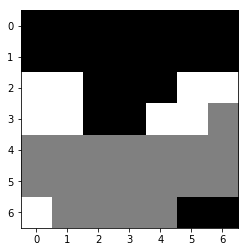

((3, 4), (5, 5)): n_v:   811 q_all:-0.405346 q:-0.321688 q_m:-0.266667 p:0.083333
((3, 4), (4, 2)): n_v:   602 q_all:-0.492803 q:-0.445982 q_m:-0.266667 p:0.228244
((3, 4), (4, 3)): n_v:   347 q_all:-0.483760 q:-0.432123 q_m:-0.233333 p:0.121720
((3, 0), (5, 1)): n_v:   337 q_all:-0.431402 q:-0.443307 q_m:-0.400000 p:0.062517
((6, 0), (6, 1)): n_v:   196 q_all:-0.378803 q:-0.444745 q_m:-0.366667 p:0.003679
((6, 0), (5, 1)): n_v:   134 q_all:-0.426808 q:-0.446629 q_m:-0.366667 p:0.022730
((3, 5), (4, 3)): n_v:   114 q_all:-0.485704 q:-0.439654 q_m:-0.266667 p:0.040974
((3, 4), (5, 6)): n_v:   114 q_all:-0.412324 q:-0.349635 q_m:-0.266667 p:0.014156
((3, 5), (5, 5)): n_v:   109 q_all:-0.448363 q:-0.369849 q_m:-0.266667 p:0.026091
((3, 1), (4, 2)): n_v:   106 q_all:-0.421904 q:-0.475860 q_m:-0.233333 p:0.016441
((3, 1), (4, 3)): n_v:   102 q_all:-0.536720 q:-0.446733 q_m:-0.266667 p:0.052808
((3, 4), (5, 2)): n_v:    92 q_all:-0.517573 q:-0.442871 q_m:-0.400000 p:0.042063
((3, 0), (5, 0))

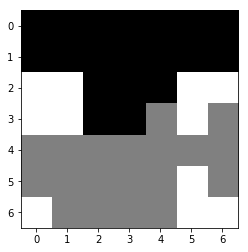

((2, 3), (3, 4)): n_v:  2468 q_all:+0.443494 q:+0.409240 q_m:+0.433333 p:0.463961
((2, 4), (3, 6)): n_v:    31 q_all:+0.475231 q:+0.344850 q_m:+0.466667 p:0.001433
((1, 6), (3, 4)): n_v:    12 q_all:+0.284447 q:+0.297473 q_m:+0.400000 p:0.010211
((3, 2), (3, 4)): n_v:    11 q_all:+0.352557 q:+0.359604 q_m:+0.400000 p:0.006441
((3, 2), (4, 1)): n_v:     4 q_all:+0.385425 q:+0.410272 q_m:+0.433333 p:0.001978
((1, 6), (3, 6)): n_v:     3 q_all:+0.363893 q:+0.378708 q_m:+0.466667 p:0.001417
((2, 2), (3, 4)): n_v:     2 q_all:+0.273778 q:+0.292506 q_m:+0.400000 p:0.002467
((1, 4), (3, 6)): n_v:     2 q_all:+0.392053 q:+0.278682 q_m:+0.466667 p:0.000957
((3, 3), (4, 1)): n_v:     1 q_all:+0.350002 q:+0.374382 q_m:+0.400000 p:0.000981
((1, 5), (3, 4)): n_v:     1 q_all:+0.159052 q:+0.233451 q_m:+0.400000 p:0.001215
((3, 2), (5, 0)): n_v:     1 q_all:+0.339270 q:+0.288833 q_m:+0.333333 p:0.001088
((3, 2), (5, 1)): n_v:     1 q_all:+0.349684 q:+0.306034 q_m:+0.333333 p:0.000839
((3, 3), (4, 5))

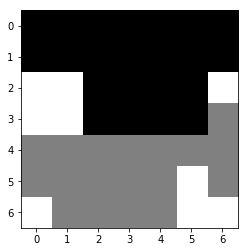

((2, 6), (3, 6)): n_v:  2534 q_all:-0.429199 q:-0.382652 q_m:-0.266667 p:0.540383
((3, 1), (4, 3)): n_v:   227 q_all:-0.497688 q:-0.418198 q_m:-0.233333 p:0.096392
((3, 1), (4, 2)): n_v:   175 q_all:-0.457189 q:-0.467913 q_m:-0.266667 p:0.052604
((5, 5), (4, 3)): n_v:   149 q_all:-0.462232 q:-0.434756 q_m:-0.233333 p:0.047128
((2, 6), (4, 4)): n_v:   141 q_all:-0.404231 q:-0.391845 q_m:-0.233333 p:0.019367
((5, 5), (4, 4)): n_v:   104 q_all:-0.440855 q:-0.422070 q_m:-0.200000 p:0.026127
((5, 5), (3, 6)): n_v:    98 q_all:-0.453118 q:-0.419802 q_m:-0.300000 p:0.028379
((3, 0), (4, 2)): n_v:    83 q_all:-0.472080 q:-0.444261 q_m:-0.300000 p:0.028720
((6, 5), (4, 3)): n_v:    53 q_all:-0.491096 q:-0.415986 q_m:-0.233333 p:0.021742
((6, 0), (4, 2)): n_v:    47 q_all:-0.477451 q:-0.482780 q_m:-0.300000 p:0.017332
((6, 5), (4, 4)): n_v:    43 q_all:-0.448515 q:-0.429847 q_m:-0.233333 p:0.011784
((6, 6), (4, 4)): n_v:    35 q_all:-0.454828 q:-0.435219 q_m:-0.233333 p:0.010177
((2, 0), (4, 2))

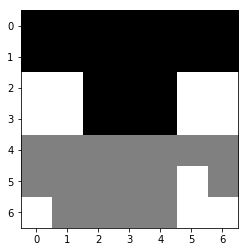

((3, 2), (4, 1)): n_v:  1979 q_all:+0.439766 q:+0.439629 q_m:+0.433333 p:0.476545
((3, 4), (4, 5)): n_v:  1833 q_all:+0.445875 q:+0.424024 q_m:+0.500000 p:0.407356
((3, 4), (5, 6)): n_v:    66 q_all:+0.455186 q:+0.442413 q_m:+0.466667 p:0.012734
((3, 3), (4, 4)): n_v:    46 q_all:+0.437611 q:+0.423797 q_m:+0.433333 p:0.011288
((3, 3), (4, 5)): n_v:    34 q_all:+0.392053 q:+0.364524 q_m:+0.466667 p:0.013467
((3, 2), (4, 2)): n_v:    25 q_all:+0.370085 q:+0.337823 q_m:+0.366667 p:0.011640
((3, 3), (4, 1)): n_v:    21 q_all:+0.353528 q:+0.393409 q_m:+0.400000 p:0.010944
((3, 2), (5, 0)): n_v:    14 q_all:+0.329426 q:+0.309381 q_m:+0.333333 p:0.008391
((3, 2), (5, 1)): n_v:     9 q_all:+0.335220 q:+0.323053 q_m:+0.333333 p:0.005532
((3, 4), (4, 6)): n_v:     7 q_all:+0.440973 q:+0.385475 q_m:+0.466667 p:0.001738
((3, 2), (4, 3)): n_v:     6 q_all:+0.350320 q:+0.322671 q_m:+0.300000 p:0.003495
((3, 2), (4, 0)): n_v:     4 q_all:+0.363481 q:+0.365892 q_m:+0.400000 p:0.002159
((2, 3), (4, 5))

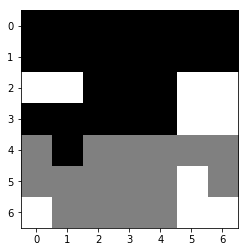

((6, 0), (4, 0)): n_v:  2067 q_all:-0.409742 q:-0.404598 q_m:-0.233333 p:0.450730
((2, 0), (4, 2)): n_v:   216 q_all:-0.442791 q:-0.441228 q_m:-0.166667 p:0.070763
((6, 6), (4, 6)): n_v:   169 q_all:-0.525982 q:-0.498784 q_m:-0.433333 p:0.100798
((6, 0), (4, 2)): n_v:   114 q_all:-0.427384 q:-0.420211 q_m:-0.166667 p:0.031521
((2, 6), (4, 4)): n_v:    98 q_all:-0.516995 q:-0.495588 q_m:-0.300000 p:0.055777
((2, 1), (4, 0)): n_v:    73 q_all:-0.453561 q:-0.409554 q_m:-0.233333 p:0.026489
((6, 5), (4, 6)): n_v:    69 q_all:-0.505520 q:-0.471854 q_m:-0.433333 p:0.036987
((2, 0), (4, 0)): n_v:    58 q_all:-0.463683 q:-0.435119 q_m:-0.233333 p:0.023216
((6, 5), (4, 4)): n_v:    54 q_all:-0.483661 q:-0.497788 q_m:-0.300000 p:0.025272
((3, 6), (4, 4)): n_v:    50 q_all:-0.476294 q:-0.474407 q_m:-0.300000 p:0.022203
((3, 5), (4, 4)): n_v:    36 q_all:-0.489549 q:-0.478286 q_m:-0.266667 p:0.017453
((3, 5), (4, 3)): n_v:    35 q_all:-0.511750 q:-0.450045 q_m:-0.233333 p:0.019803
((2, 6), (4, 6))

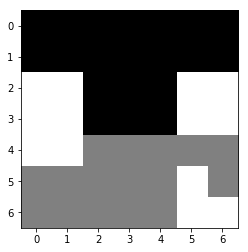

((3, 4), (4, 5)): n_v:  1182 q_all:+0.424169 q:+0.413901 q_m:+0.466667 p:0.229623
((3, 2), (4, 2)): n_v:   726 q_all:+0.411229 q:+0.398665 q_m:+0.400000 p:0.171630
((3, 2), (5, 1)): n_v:   573 q_all:+0.419448 q:+0.372764 q_m:+0.366667 p:0.119782
((3, 4), (5, 6)): n_v:   512 q_all:+0.463886 q:+0.434830 q_m:+0.433333 p:0.033687
((3, 3), (4, 4)): n_v:   309 q_all:+0.385151 q:+0.408371 q_m:+0.400000 p:0.099281
((3, 2), (5, 0)): n_v:    72 q_all:+0.364751 q:+0.350145 q_m:+0.366667 p:0.028027
((3, 3), (5, 1)): n_v:    39 q_all:+0.337816 q:+0.363517 q_m:+0.366667 p:0.018619
((3, 3), (4, 5)): n_v:    39 q_all:+0.365811 q:+0.335987 q_m:+0.433333 p:0.015228
((3, 4), (4, 6)): n_v:    38 q_all:+0.390077 q:+0.380537 q_m:+0.433333 p:0.011654
((2, 4), (4, 5)): n_v:     4 q_all:+0.342909 q:+0.211206 q_m:+0.433333 p:0.002170
((3, 2), (4, 3)): n_v:     4 q_all:+0.346991 q:+0.313700 q_m:+0.266667 p:0.002110
((2, 3), (4, 5)): n_v:     3 q_all:+0.246385 q:+0.209603 q_m:+0.433333 p:0.002138
((3, 4), (4, 2))

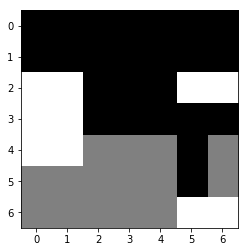

((6, 6), (4, 6)): n_v:  1123 q_all:-0.469932 q:-0.387443 q_m:-0.200000 p:0.428589
((2, 6), (4, 4)): n_v:   454 q_all:-0.449906 q:-0.444721 q_m:-0.133333 p:0.139805
((6, 5), (4, 4)): n_v:   440 q_all:-0.458464 q:-0.451226 q_m:-0.133333 p:0.149536
((6, 5), (4, 6)): n_v:   230 q_all:-0.429677 q:-0.366994 q_m:-0.200000 p:0.053768
((6, 6), (4, 4)): n_v:   162 q_all:-0.464012 q:-0.475815 q_m:-0.133333 p:0.058055
((2, 0), (4, 2)): n_v:    81 q_all:-0.527910 q:-0.552969 q_m:-0.333333 p:0.048549
((2, 6), (4, 6)): n_v:    66 q_all:-0.479388 q:-0.412388 q_m:-0.200000 p:0.027403
((3, 0), (4, 2)): n_v:    48 q_all:-0.487610 q:-0.536491 q_m:-0.333333 p:0.021237
((3, 1), (4, 2)): n_v:    32 q_all:-0.470709 q:-0.526954 q_m:-0.300000 p:0.012574
((2, 1), (4, 2)): n_v:    20 q_all:-0.546827 q:-0.544121 q_m:-0.333333 p:0.013689
((4, 1), (4, 3)): n_v:    17 q_all:-0.457639 q:-0.499561 q_m:-0.266667 p:0.005881
((2, 5), (4, 4)): n_v:    17 q_all:-0.477864 q:-0.460818 q_m:-0.133333 p:0.006923
((4, 0), (4, 2))

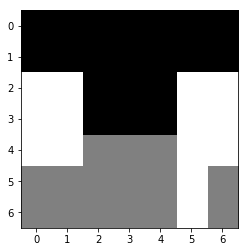

((3, 4), (5, 6)): n_v:  1470 q_all:+0.499121 q:+0.463930 q_m:+0.466667 p:0.185268
((3, 3), (4, 4)): n_v:   646 q_all:+0.448152 q:+0.424706 q_m:+0.433333 p:0.204299
((3, 2), (4, 2)): n_v:   311 q_all:+0.403473 q:+0.405287 q_m:+0.366667 p:0.150078
((3, 2), (5, 0)): n_v:   172 q_all:+0.383170 q:+0.356906 q_m:+0.333333 p:0.096294
((3, 2), (5, 1)): n_v:    48 q_all:+0.425843 q:+0.378364 q_m:+0.333333 p:0.019423
((3, 3), (5, 1)): n_v:     3 q_all:+0.333097 q:+0.361921 q_m:+0.333333 p:0.002852
((3, 2), (4, 4)): n_v:     2 q_all:+0.416968 q:+0.363745 q_m:+0.400000 p:0.001137
((2, 3), (4, 4)): n_v:     2 q_all:+0.253751 q:+0.209011 q_m:+0.400000 p:0.001653
((3, 4), (5, 4)): n_v:     2 q_all:+0.384038 q:+0.395571 q_m:+0.400000 p:0.001655
((2, 3), (4, 2)): n_v:     1 q_all:+0.135960 q:+0.211702 q_m:+0.333333 p:0.001217
((2, 4), (4, 4)): n_v:     1 q_all:+0.162610 q:+0.204159 q_m:+0.400000 p:0.001160
((3, 4), (4, 2)): n_v:     1 q_all:+0.383231 q:+0.355639 q_m:+0.333333 p:0.000907
((3, 2), (5, 2))

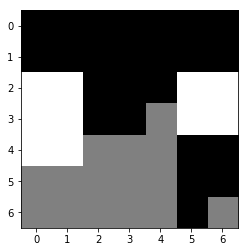

((2, 5), (3, 4)): n_v:  2189 q_all:-0.479907 q:-0.549003 q_m:-0.166667 p:0.254726
((3, 6), (3, 4)): n_v:   280 q_all:-0.535890 q:-0.555806 q_m:-0.200000 p:0.087973
((2, 6), (3, 4)): n_v:   244 q_all:-0.525722 q:-0.544719 q_m:-0.200000 p:0.067780
((3, 5), (4, 3)): n_v:    97 q_all:-0.557824 q:-0.598028 q_m:-0.333333 p:0.037627
((4, 0), (6, 0)): n_v:    38 q_all:-0.580876 q:-0.700310 q_m:-0.466667 p:0.018263
((3, 6), (5, 4)): n_v:    36 q_all:-0.489431 q:-0.482318 q_m:-0.266667 p:0.005355
((3, 1), (4, 3)): n_v:    32 q_all:-0.653138 q:-0.589120 q_m:-0.333333 p:0.023337
((2, 6), (4, 4)): n_v:    25 q_all:-0.574293 q:-0.545319 q_m:-0.266667 p:0.011138
((2, 5), (4, 4)): n_v:    25 q_all:-0.540037 q:-0.603278 q_m:-0.266667 p:0.008355
((4, 1), (4, 3)): n_v:    24 q_all:-0.589401 q:-0.607809 q_m:-0.333333 p:0.012473
((3, 5), (5, 4)): n_v:    24 q_all:-0.505745 q:-0.480409 q_m:-0.266667 p:0.005124
((2, 1), (4, 2)): n_v:    19 q_all:-0.631525 q:-0.621198 q_m:-0.333333 p:0.012199
((2, 5), (4, 3))

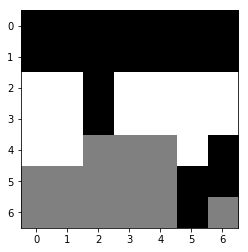

((5, 5), (4, 4)): n_v:  2264 q_all:+0.488952 q:+0.496631 q_m:+0.466667 p:0.576669
((3, 2), (4, 2)): n_v:  1215 q_all:+0.481833 q:+0.409423 q_m:+0.400000 p:0.336933
((6, 5), (4, 4)): n_v:   148 q_all:+0.470635 q:+0.478242 q_m:+0.433333 p:0.046561
((3, 2), (4, 4)): n_v:    91 q_all:+0.529809 q:+0.430150 q_m:+0.433333 p:0.011383
((5, 6), (4, 4)): n_v:    48 q_all:+0.484947 q:+0.451516 q_m:+0.433333 p:0.013034
((4, 6), (4, 4)): n_v:     9 q_all:+0.421106 q:+0.400254 q_m:+0.433333 p:0.004573
((2, 2), (4, 4)): n_v:     8 q_all:+0.375104 q:+0.351910 q_m:+0.433333 p:0.005451
((3, 2), (5, 0)): n_v:     2 q_all:+0.404439 q:+0.376503 q_m:+0.300000 p:0.001228
((3, 2), (5, 1)): n_v:     2 q_all:+0.424900 q:+0.395092 q_m:+0.300000 p:0.000978
((2, 2), (4, 2)): n_v:     0 q_all:+0.250181 q:+0.250181 q_m:+0.366667 p:0.000471
((5, 5), (6, 6)): n_v:     0 q_all:+0.355350 q:+0.355350 q_m:+0.200000 p:0.000414
((5, 6), (5, 4)): n_v:     0 q_all:+0.364604 q:+0.364604 q_m:+0.233333 p:0.000005
((3, 2), (5, 3))

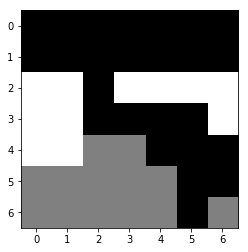

((4, 1), (4, 3)): n_v:  1927 q_all:-0.470831 q:-0.467355 q_m:-0.200000 p:0.351290
((3, 1), (4, 3)): n_v:   641 q_all:-0.517211 q:-0.457175 q_m:-0.200000 p:0.210888
((2, 1), (4, 3)): n_v:   346 q_all:-0.517309 q:-0.470134 q_m:-0.200000 p:0.114084
((2, 5), (4, 3)): n_v:   216 q_all:-0.567836 q:-0.551938 q_m:-0.200000 p:0.105680
((2, 4), (4, 3)): n_v:    76 q_all:-0.559196 q:-0.568972 q_m:-0.200000 p:0.035319
((2, 4), (4, 2)): n_v:    56 q_all:-0.588541 q:-0.592558 q_m:-0.333333 p:0.031386
((3, 6), (5, 4)): n_v:    42 q_all:-0.502755 q:-0.451965 q_m:-0.200000 p:0.012097
((4, 0), (6, 0)): n_v:    35 q_all:-0.567142 q:-0.649035 q_m:-0.466667 p:0.017218
((2, 3), (4, 3)): n_v:    32 q_all:-0.527566 q:-0.528884 q_m:-0.200000 p:0.011599
((4, 1), (6, 3)): n_v:    25 q_all:-0.565607 q:-0.620195 q_m:-0.466667 p:0.012110
((2, 3), (4, 2)): n_v:    24 q_all:-0.549073 q:-0.569487 q_m:-0.333333 p:0.010175
((4, 0), (5, 2)): n_v:    24 q_all:-0.592580 q:-0.628943 q_m:-0.466667 p:0.013770
((3, 0), (4, 2))

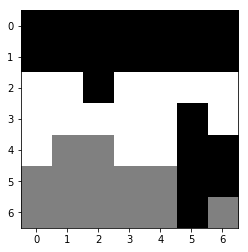

((4, 5), (5, 4)): n_v:  3279 q_all:+0.506723 q:+0.445631 q_m:+0.366667 p:0.460403
((5, 6), (5, 4)): n_v:    58 q_all:+0.504793 q:+0.392665 q_m:+0.333333 p:0.008616
((5, 5), (6, 4)): n_v:     9 q_all:+0.389581 q:+0.325199 q_m:+0.233333 p:0.005141
((4, 6), (5, 4)): n_v:     8 q_all:+0.330870 q:+0.353147 q_m:+0.333333 p:0.006024
((2, 2), (4, 1)): n_v:     3 q_all:+0.418993 q:+0.405772 q_m:+0.466667 p:0.001402
((5, 5), (6, 6)): n_v:     2 q_all:+0.407589 q:+0.348889 q_m:+0.233333 p:0.000985
((6, 5), (5, 3)): n_v:     2 q_all:+0.411594 q:+0.385465 q_m:+0.333333 p:0.001274
((3, 5), (5, 4)): n_v:     1 q_all:+0.351463 q:+0.298334 q_m:+0.333333 p:0.000933
((2, 2), (4, 2)): n_v:     0 q_all:+0.392624 q:+0.318582 q_m:+0.466667 p:0.000326
((5, 5), (5, 3)): n_v:     0 q_all:+0.362102 q:+0.362102 q_m:+0.333333 p:0.000116
((5, 5), (6, 3)): n_v:     0 q_all:+0.277392 q:+0.277392 q_m:+0.200000 p:0.000057
((4, 5), (6, 6)): n_v:     0 q_all:+0.285381 q:+0.285381 q_m:+0.200000 p:0.000023
((5, 6), (6, 4))

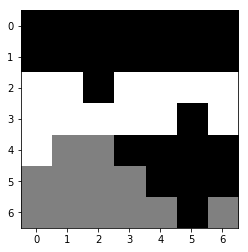

((3, 2), (5, 3)): n_v:  2064 q_all:-0.537052 q:-0.490895 q_m:-0.166667 p:0.417629
((3, 4), (5, 3)): n_v:   720 q_all:-0.551551 q:-0.465474 q_m:-0.166667 p:0.175195
((3, 1), (5, 3)): n_v:   687 q_all:-0.542067 q:-0.460609 q_m:-0.166667 p:0.148516
((3, 3), (5, 3)): n_v:   406 q_all:-0.565829 q:-0.504833 q_m:-0.166667 p:0.115349
((3, 1), (4, 2)): n_v:   270 q_all:-0.491613 q:-0.524954 q_m:-0.266667 p:0.020078
((4, 0), (6, 2)): n_v:    62 q_all:-0.580727 q:-0.618693 q_m:-0.366667 p:0.020149
((3, 0), (5, 2)): n_v:    39 q_all:-0.489941 q:-0.559272 q_m:-0.300000 p:0.002663
((3, 0), (4, 2)): n_v:    27 q_all:-0.494353 q:-0.498375 q_m:-0.300000 p:0.002056
((3, 0), (4, 1)): n_v:    25 q_all:-0.611651 q:-0.663839 q_m:-0.333333 p:0.010480
((4, 0), (4, 2)): n_v:    21 q_all:-0.487656 q:-0.561816 q_m:-0.300000 p:0.001326
((2, 0), (4, 1)): n_v:    19 q_all:-0.544951 q:-0.663827 q_m:-0.366667 p:0.004446
((4, 0), (5, 0)): n_v:    12 q_all:-0.618514 q:-0.629518 q_m:-0.333333 p:0.005595
((3, 0), (5, 1))

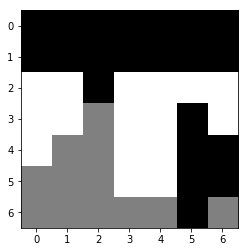

((2, 2), (3, 2)): n_v:  3018 q_all:+0.535041 q:+0.515767 q_m:+0.533333 p:0.674437
((5, 5), (6, 4)): n_v:   299 q_all:+0.476840 q:+0.438712 q_m:+0.333333 p:0.123494
((2, 2), (4, 1)): n_v:    38 q_all:+0.442452 q:+0.427489 q_m:+0.366667 p:0.020385
((1, 0), (3, 2)): n_v:    26 q_all:+0.434484 q:+0.397507 q_m:+0.500000 p:0.014806
((2, 2), (4, 2)): n_v:    11 q_all:+0.402655 q:+0.313295 q_m:+0.433333 p:0.007788
((1, 3), (3, 2)): n_v:     5 q_all:+0.257006 q:+0.247369 q_m:+0.500000 p:0.005363
((1, 1), (3, 2)): n_v:     5 q_all:+0.289560 q:+0.295618 q_m:+0.500000 p:0.004442
((1, 4), (3, 2)): n_v:     2 q_all:+0.287132 q:+0.294798 q_m:+0.500000 p:0.002214
((1, 2), (3, 2)): n_v:     2 q_all:+0.341308 q:+0.266695 q_m:+0.500000 p:0.000995
((5, 5), (6, 6)): n_v:     1 q_all:+0.401177 q:+0.387500 q_m:+0.200000 p:0.001297
((6, 5), (6, 3)): n_v:     1 q_all:+0.357984 q:+0.344776 q_m:+0.300000 p:0.000891
((4, 6), (6, 4)): n_v:     1 q_all:+0.280602 q:+0.323125 q_m:+0.300000 p:0.001547
((5, 5), (6, 3))

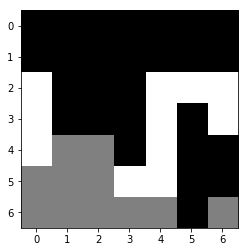

((5, 3), (4, 2)): n_v:   733 q_all:-0.550946 q:-0.608125 q_m:-0.233333 p:0.137549
((4, 0), (4, 2)): n_v:   631 q_all:-0.547305 q:-0.624928 q_m:-0.266667 p:0.111899
((2, 4), (4, 2)): n_v:   483 q_all:-0.598739 q:-0.634486 q_m:-0.266667 p:0.157710
((5, 4), (6, 6)): n_v:   438 q_all:-0.575505 q:-0.577091 q_m:-0.333333 p:0.113290
((2, 0), (4, 2)): n_v:   365 q_all:-0.552373 q:-0.634064 q_m:-0.266667 p:0.070046
((3, 0), (4, 2)): n_v:   313 q_all:-0.565297 q:-0.560707 q_m:-0.266667 p:0.071713
((4, 4), (6, 6)): n_v:   304 q_all:-0.601118 q:-0.643292 q_m:-0.333333 p:0.101363
((4, 4), (4, 2)): n_v:   179 q_all:-0.594130 q:-0.592244 q_m:-0.266667 p:0.056184
((5, 4), (4, 2)): n_v:   160 q_all:-0.552558 q:-0.608570 q_m:-0.266667 p:0.030628
((3, 4), (4, 2)): n_v:   147 q_all:-0.618567 q:-0.584699 q_m:-0.266667 p:0.056682
((5, 3), (6, 4)): n_v:    83 q_all:-0.598440 q:-0.603543 q_m:-0.366667 p:0.027075
((4, 4), (6, 2)): n_v:    23 q_all:-0.595551 q:-0.667910 q_m:-0.533333 p:0.007509
((5, 3), (6, 2))

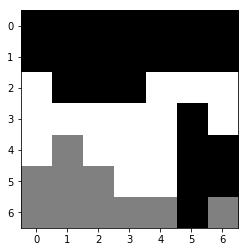

((5, 5), (6, 4)): n_v:  2085 q_all:+0.492799 q:+0.491372 q_m:+0.400000 p:0.439657
((2, 1), (4, 1)): n_v:   128 q_all:+0.418238 q:+0.521332 q_m:+0.566667 p:0.065343
((2, 3), (4, 1)): n_v:    90 q_all:+0.459082 q:+0.483383 q_m:+0.566667 p:0.031032
((2, 2), (4, 1)): n_v:    59 q_all:+0.422188 q:+0.493011 q_m:+0.566667 p:0.029265
((5, 5), (6, 6)): n_v:    16 q_all:+0.447356 q:+0.422742 q_m:+0.266667 p:0.006256
((5, 5), (6, 3)): n_v:    10 q_all:+0.496521 q:+0.337648 q_m:+0.366667 p:0.002026
((6, 5), (6, 3)): n_v:     8 q_all:+0.436238 q:+0.386794 q_m:+0.366667 p:0.003768
((5, 6), (6, 4)): n_v:     5 q_all:+0.435725 q:+0.401943 q_m:+0.366667 p:0.002628
((4, 6), (6, 4)): n_v:     2 q_all:+0.388889 q:+0.362882 q_m:+0.366667 p:0.001638
((4, 5), (6, 3)): n_v:     1 q_all:+0.370081 q:+0.298364 q_m:+0.366667 p:0.001076
((4, 6), (6, 6)): n_v:     0 q_all:+0.287938 q:+0.287938 q_m:+0.233333 p:0.000455
((4, 5), (6, 4)): n_v:     0 q_all:+0.309289 q:+0.309289 q_m:+0.366667 p:0.000540
((4, 5), (6, 6))

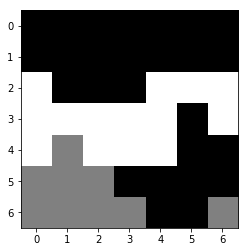

((4, 2), (6, 3)): n_v:  2277 q_all:-0.541797 q:-0.634861 q_m:-0.200000 p:0.455361
((4, 4), (6, 3)): n_v:   805 q_all:-0.606198 q:-0.639174 q_m:-0.200000 p:0.328343
((4, 3), (6, 3)): n_v:   181 q_all:-0.586830 q:-0.634393 q_m:-0.200000 p:0.062370
((4, 4), (6, 6)): n_v:   176 q_all:-0.576990 q:-0.604898 q_m:-0.200000 p:0.055174
((4, 2), (6, 0)): n_v:    61 q_all:-0.615574 q:-0.684585 q_m:-0.400000 p:0.026891
((4, 0), (6, 1)): n_v:    26 q_all:-0.595222 q:-0.720730 q_m:-0.400000 p:0.010035
((4, 4), (6, 2)): n_v:    17 q_all:-0.600309 q:-0.674369 q_m:-0.333333 p:0.006817
((4, 0), (6, 0)): n_v:    11 q_all:-0.598129 q:-0.745454 q_m:-0.400000 p:0.004342
((4, 4), (5, 2)): n_v:    10 q_all:-0.578140 q:-0.643659 q_m:-0.333333 p:0.003469
((4, 2), (5, 2)): n_v:     8 q_all:-0.623132 q:-0.700623 q_m:-0.300000 p:0.004066
((4, 0), (6, 2)): n_v:     7 q_all:-0.607011 q:-0.735527 q_m:-0.333333 p:0.003252
((4, 3), (6, 1)): n_v:     7 q_all:-0.650347 q:-0.683996 q_m:-0.400000 p:0.004351
((4, 2), (6, 1))

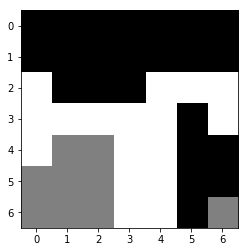

((5, 5), (6, 6)): n_v:  2628 q_all:+0.537178 q:+0.424024 q_m:+0.233333 p:0.155065
((2, 3), (4, 1)): n_v:   336 q_all:+0.425379 q:+0.392930 q_m:+0.466667 p:0.138230
((2, 1), (4, 1)): n_v:   275 q_all:+0.444198 q:+0.453485 q_m:+0.466667 p:0.096983
((2, 2), (4, 1)): n_v:   199 q_all:+0.454566 q:+0.450998 q_m:+0.466667 p:0.063696
((2, 3), (4, 2)): n_v:   197 q_all:+0.401440 q:+0.310850 q_m:+0.533333 p:0.095767
((2, 1), (4, 2)): n_v:   190 q_all:+0.464271 q:+0.383320 q_m:+0.533333 p:0.054751
((2, 2), (4, 2)): n_v:    56 q_all:+0.411848 q:+0.350714 q_m:+0.533333 p:0.025140
((4, 6), (6, 6)): n_v:    16 q_all:+0.272771 q:+0.287757 q_m:+0.200000 p:0.014808
((4, 5), (6, 6)): n_v:     6 q_all:+0.269959 q:+0.260123 q_m:+0.200000 p:0.005118
1 's turn
one move takes time(s):  1.079042911529541
train_mode is both train
no. of data collected:  8


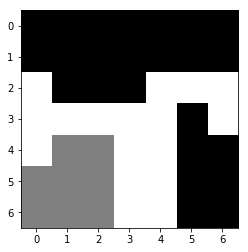

((6, 3), (6, 1)): n_v:  1809 q_all:-0.461190 q:-0.662947 q_m:-0.233333 p:0.108138
((4, 0), (6, 1)): n_v:   652 q_all:-0.482240 q:-0.689446 q_m:-0.233333 p:0.054598
((4, 3), (6, 1)): n_v:   327 q_all:-0.484323 q:-0.616266 q_m:-0.233333 p:0.029870
((6, 3), (5, 1)): n_v:   111 q_all:-0.588783 q:-0.644719 q_m:-0.233333 p:0.049699
((4, 0), (5, 0)): n_v:    79 q_all:-0.594134 q:-0.640358 q_m:-0.200000 p:0.036720
((4, 0), (6, 0)): n_v:    69 q_all:-0.523483 q:-0.634728 q_m:-0.233333 p:0.016236
((3, 0), (5, 1)): n_v:    65 q_all:-0.638206 q:-0.646176 q_m:-0.233333 p:0.038663
((6, 3), (4, 1)): n_v:    61 q_all:-0.574585 q:-0.657717 q_m:-0.233333 p:0.024805
((3, 0), (4, 1)): n_v:    58 q_all:-0.599069 q:-0.677674 q_m:-0.200000 p:0.027501
((3, 1), (4, 2)): n_v:    57 q_all:-0.565083 q:-0.671584 q_m:-0.200000 p:0.021641
((2, 0), (4, 1)): n_v:    57 q_all:-0.621694 q:-0.699445 q_m:-0.233333 p:0.031104
((4, 0), (5, 1)): n_v:    56 q_all:-0.603812 q:-0.635952 q_m:-0.200000 p:0.027640
((5, 3), (6, 1))

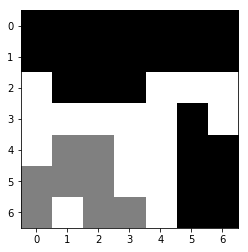

((6, 5), (6, 3)): n_v:  1522 q_all:+0.466063 q:+0.514986 q_m:+0.433333 p:0.366289
((4, 5), (6, 3)): n_v:   467 q_all:+0.434169 q:+0.414103 q_m:+0.433333 p:0.162047
((2, 1), (4, 2)): n_v:   329 q_all:+0.488963 q:+0.466917 q_m:+0.566667 p:0.053493
((2, 3), (4, 1)): n_v:   306 q_all:+0.446568 q:+0.444715 q_m:+0.500000 p:0.093731
((2, 3), (4, 2)): n_v:   286 q_all:+0.405318 q:+0.392413 q_m:+0.566667 p:0.127256
((2, 2), (4, 1)): n_v:   205 q_all:+0.504554 q:+0.496265 q_m:+0.500000 p:0.022757
((5, 5), (6, 3)): n_v:   161 q_all:+0.366604 q:+0.430338 q_m:+0.433333 p:0.092500
((2, 1), (4, 1)): n_v:   125 q_all:+0.428537 q:+0.497653 q_m:+0.500000 p:0.045817
((2, 2), (4, 2)): n_v:    49 q_all:+0.376021 q:+0.422880 q_m:+0.566667 p:0.026355
1 's turn
one move takes time(s):  0.5986671447753906
train_mode is both train
no. of data collected:  8


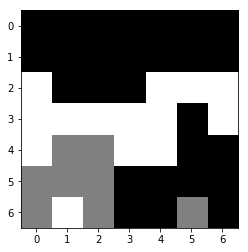

((4, 3), (6, 5)): n_v:  2744 q_all:-0.529019 q:-0.441732 q_m:-0.100000 p:0.861378
((4, 4), (6, 5)): n_v:   232 q_all:-0.513738 q:-0.543288 q_m:-0.100000 p:0.060344
((4, 3), (5, 2)): n_v:    26 q_all:-0.603727 q:-0.662010 q_m:-0.266667 p:0.015061
((3, 2), (5, 2)): n_v:    15 q_all:-0.536806 q:-0.690325 q_m:-0.300000 p:0.005417
((3, 3), (5, 2)): n_v:    15 q_all:-0.631555 q:-0.696623 q_m:-0.300000 p:0.010025
((3, 0), (5, 2)): n_v:    13 q_all:-0.563969 q:-0.676528 q_m:-0.300000 p:0.005994
((3, 4), (5, 2)): n_v:    12 q_all:-0.638564 q:-0.640064 q_m:-0.300000 p:0.008669
((3, 1), (5, 2)): n_v:     8 q_all:-0.613588 q:-0.670154 q_m:-0.300000 p:0.005253
((6, 1), (6, 2)): n_v:     4 q_all:-0.597589 q:-0.718843 q_m:-0.266667 p:0.002601
((3, 0), (5, 0)): n_v:     3 q_all:-0.598146 q:-0.680745 q_m:-0.433333 p:0.002087
((4, 4), (5, 2)): n_v:     3 q_all:-0.584201 q:-0.617141 q_m:-0.300000 p:0.001828
((4, 0), (5, 2)): n_v:     3 q_all:-0.626896 q:-0.652403 q_m:-0.300000 p:0.002372
((4, 0), (6, 0))

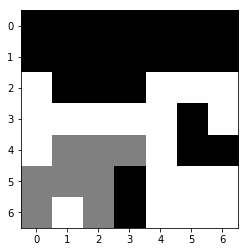

((5, 3), (4, 3)): n_v:  3289 q_all:+0.543039 q:+0.510666 q_m:+0.466667 p:0.707213
((6, 3), (4, 3)): n_v:   264 q_all:+0.479559 q:+0.459057 q_m:+0.433333 p:0.106819
((5, 3), (4, 1)): n_v:   246 q_all:+0.536407 q:+0.404040 q_m:+0.366667 p:0.057982
((6, 3), (4, 1)): n_v:   169 q_all:+0.501883 q:+0.394391 q_m:+0.366667 p:0.057066
((3, 5), (4, 3)): n_v:    38 q_all:+0.355733 q:+0.289664 q_m:+0.433333 p:0.029722
((4, 5), (4, 3)): n_v:    17 q_all:+0.343879 q:+0.363304 q_m:+0.433333 p:0.013616
((2, 3), (4, 1)): n_v:     8 q_all:+0.314251 q:+0.201267 q_m:+0.366667 p:0.008042
((2, 1), (4, 3)): n_v:     6 q_all:+0.280069 q:+0.341521 q_m:+0.433333 p:0.006622
((2, 3), (4, 3)): n_v:     2 q_all:+0.228219 q:+0.230320 q_m:+0.433333 p:0.003081
((2, 2), (4, 3)): n_v:     2 q_all:+0.283487 q:+0.320906 q_m:+0.433333 p:0.002025
((2, 1), (4, 1)): n_v:     1 q_all:+0.164947 q:+0.251072 q_m:+0.366667 p:0.001686
((6, 3), (5, 1)): n_v:     1 q_all:+0.339630 q:+0.308412 q_m:+0.233333 p:0.001039
((2, 2), (4, 1))

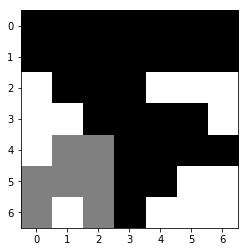

((3, 1), (4, 2)): n_v:  1032 q_all:-0.586892 q:-0.579649 q_m:-0.166667 p:0.229900
((4, 0), (4, 2)): n_v:   687 q_all:-0.601737 q:-0.614398 q_m:-0.200000 p:0.181807
((3, 0), (4, 2)): n_v:   622 q_all:-0.551387 q:-0.552532 q_m:-0.200000 p:0.076613
((2, 4), (4, 2)): n_v:   600 q_all:-0.593284 q:-0.599054 q_m:-0.200000 p:0.144712
((6, 1), (4, 2)): n_v:   466 q_all:-0.584106 q:-0.585068 q_m:-0.200000 p:0.100250
((6, 4), (4, 2)): n_v:   245 q_all:-0.608352 q:-0.657441 q_m:-0.200000 p:0.069577
((2, 0), (4, 2)): n_v:   212 q_all:-0.586054 q:-0.627463 q_m:-0.200000 p:0.046716
((4, 0), (5, 2)): n_v:   177 q_all:-0.596158 q:-0.569259 q_m:-0.266667 p:0.044313
((6, 1), (5, 2)): n_v:   149 q_all:-0.599528 q:-0.570488 q_m:-0.233333 p:0.038656
((3, 1), (5, 2)): n_v:   106 q_all:-0.563229 q:-0.575102 q_m:-0.266667 p:0.016517
((4, 0), (6, 0)): n_v:    55 q_all:-0.556880 q:-0.621133 q_m:-0.466667 p:0.007625
((3, 0), (5, 2)): n_v:    27 q_all:-0.599833 q:-0.573818 q_m:-0.266667 p:0.007162
((6, 1), (6, 2))

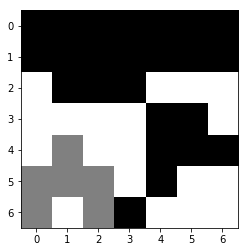

((6, 3), (4, 1)): n_v:  1304 q_all:+0.587845 q:+0.596564 q_m:+0.500000 p:0.489174
((6, 3), (5, 2)): n_v:  1065 q_all:+0.594030 q:+0.578908 q_m:+0.466667 p:0.374549
((2, 1), (4, 1)): n_v:    58 q_all:+0.361308 q:+0.452315 q_m:+0.500000 p:0.071980
((6, 3), (6, 2)): n_v:    24 q_all:+0.446498 q:+0.401414 q_m:+0.333333 p:0.022419
((2, 2), (4, 1)): n_v:    19 q_all:+0.380963 q:+0.401990 q_m:+0.500000 p:0.022494
((6, 3), (5, 1)): n_v:    13 q_all:+0.520415 q:+0.430604 q_m:+0.366667 p:0.008786
((2, 3), (4, 1)): n_v:     7 q_all:+0.403711 q:+0.339708 q_m:+0.500000 p:0.008098
((5, 4), (6, 2)): n_v:     0 q_all:+0.306235 q:+0.306235 q_m:+0.300000 p:0.000025
((5, 4), (5, 2)): n_v:     0 q_all:+0.400026 q:+0.366718 q_m:+0.433333 p:0.001034
((3, 4), (5, 2)): n_v:     0 q_all:+0.302623 q:+0.171912 q_m:+0.433333 p:0.000340
((4, 4), (5, 2)): n_v:     0 q_all:+0.377004 q:+0.320674 q_m:+0.433333 p:0.000799
((4, 4), (6, 2)): n_v:     0 q_all:+0.250848 q:+0.250848 q_m:+0.300000 p:0.000076
1 's turn
one mo

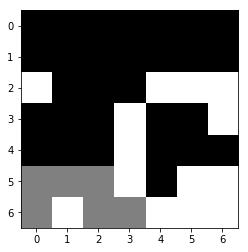

((3, 3), (5, 1)): n_v:   906 q_all:-0.626518 q:-0.661600 q_m:-0.300000 p:0.291353
((4, 3), (5, 1)): n_v:   755 q_all:-0.625494 q:-0.672729 q_m:-0.300000 p:0.239827
((5, 3), (5, 1)): n_v:   474 q_all:-0.636815 q:-0.663874 q_m:-0.300000 p:0.170122
((6, 1), (5, 1)): n_v:   349 q_all:-0.628367 q:-0.640132 q_m:-0.266667 p:0.114697
((3, 3), (5, 2)): n_v:   257 q_all:-0.613185 q:-0.703069 q_m:-0.366667 p:0.070432
((6, 1), (6, 3)): n_v:    44 q_all:-0.570411 q:-0.793974 q_m:-0.433333 p:0.005304
((4, 3), (5, 2)): n_v:    31 q_all:-0.653680 q:-0.709225 q_m:-0.333333 p:0.013043
((6, 1), (5, 0)): n_v:    19 q_all:-0.703242 q:-0.667734 q_m:-0.333333 p:0.011320
((6, 4), (5, 2)): n_v:    17 q_all:-0.697412 q:-0.743774 q_m:-0.366667 p:0.010343
((4, 3), (6, 2)): n_v:    10 q_all:-0.648107 q:-0.765414 q_m:-0.500000 p:0.004275
((5, 3), (6, 3)): n_v:     7 q_all:-0.700389 q:-0.799252 q_m:-0.400000 p:0.004373
((4, 3), (6, 3)): n_v:     7 q_all:-0.716322 q:-0.756388 q_m:-0.433333 p:0.004245
((6, 5), (6, 3))

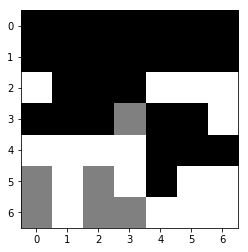

((2, 2), (3, 3)): n_v:  1730 q_all:+0.712473 q:+0.662436 q_m:+0.533333 p:0.094738
((3, 2), (5, 0)): n_v:   574 q_all:+0.637970 q:+0.437832 q_m:+0.566667 p:0.197200
((3, 4), (5, 2)): n_v:    96 q_all:+0.597269 q:+0.503903 q_m:+0.700000 p:0.048224
((3, 0), (5, 2)): n_v:    75 q_all:+0.574555 q:+0.543453 q_m:+0.700000 p:0.043839
((3, 0), (5, 0)): n_v:    35 q_all:+0.496280 q:+0.435336 q_m:+0.566667 p:0.031503
((5, 4), (3, 3)): n_v:    21 q_all:+0.656254 q:+0.633995 q_m:+0.500000 p:0.005902
((5, 4), (5, 2)): n_v:    19 q_all:+0.638680 q:+0.453750 q_m:+0.700000 p:0.006767
((4, 4), (5, 2)): n_v:    16 q_all:+0.646200 q:+0.482465 q_m:+0.700000 p:0.005183
((3, 2), (5, 2)): n_v:     9 q_all:+0.608099 q:+0.539671 q_m:+0.700000 p:0.004010
((3, 1), (5, 0)): n_v:     5 q_all:+0.458522 q:+0.374717 q_m:+0.566667 p:0.004990
((3, 1), (5, 2)): n_v:     4 q_all:+0.602537 q:+0.465516 q_m:+0.700000 p:0.002332
((1, 2), (3, 3)): n_v:     2 q_all:+0.380775 q:+0.439918 q_m:+0.500000 p:0.002530
((1, 3), (3, 3))

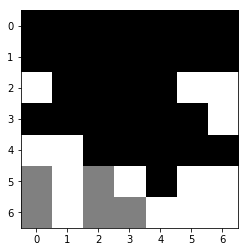

((4, 0), (5, 2)): n_v:  1452 q_all:-0.717409 q:-0.712495 q_m:-0.400000 p:0.464854
((6, 4), (5, 2)): n_v:   922 q_all:-0.657074 q:-0.739738 q_m:-0.400000 p:0.107102
((4, 1), (6, 0)): n_v:   652 q_all:-0.624455 q:-0.734887 q_m:-0.533333 p:0.003643
((4, 1), (5, 2)): n_v:   136 q_all:-0.715724 q:-0.706171 q_m:-0.366667 p:0.042742
((4, 0), (6, 0)): n_v:   103 q_all:-0.707516 q:-0.755524 q_m:-0.533333 p:0.029797
((5, 1), (6, 3)): n_v:    31 q_all:-0.716118 q:-0.719222 q_m:-0.466667 p:0.009991
((6, 1), (6, 3)): n_v:    31 q_all:-0.715578 q:-0.761374 q_m:-0.466667 p:0.010044
((6, 5), (6, 3)): n_v:    24 q_all:-0.727798 q:-0.757881 q_m:-0.466667 p:0.008814
((4, 1), (6, 3)): n_v:    20 q_all:-0.743767 q:-0.775412 q_m:-0.466667 p:0.008116
((5, 5), (6, 3)): n_v:    12 q_all:-0.814377 q:-0.786340 q_m:-0.466667 p:0.008328
((4, 0), (5, 0)): n_v:     8 q_all:-0.706022 q:-0.748988 q_m:-0.500000 p:0.002394
((5, 1), (6, 0)): n_v:     6 q_all:-0.703771 q:-0.767818 q_m:-0.500000 p:0.001813
((5, 3), (6, 3))

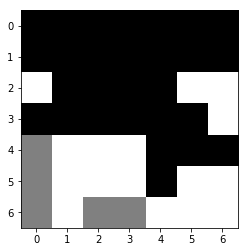

((3, 0), (4, 0)): n_v:  1760 q_all:+0.740468 q:+0.721214 q_m:+0.566667 p:0.389942
((5, 4), (6, 3)): n_v:   959 q_all:+0.755171 q:+0.892466 q_m:+0.633333 p:0.162291
((5, 4), (6, 2)): n_v:   194 q_all:+0.755221 q:+0.682331 q_m:+0.666667 p:0.032930
((4, 4), (6, 2)): n_v:   158 q_all:+0.794925 q:+0.615891 q_m:+0.666667 p:0.004397
((3, 0), (5, 0)): n_v:    95 q_all:+0.675678 q:+0.649763 q_m:+0.600000 p:0.043022
((4, 4), (6, 3)): n_v:     5 q_all:+0.672493 q:+0.749760 q_m:+0.600000 p:0.002453
((3, 1), (5, 0)): n_v:     5 q_all:+0.574776 q:+0.564945 q_m:+0.600000 p:0.004103
((4, 5), (6, 3)): n_v:     3 q_all:+0.658313 q:+0.784768 q_m:+0.600000 p:0.001533
((3, 2), (5, 0)): n_v:     2 q_all:+0.545220 q:+0.481299 q_m:+0.600000 p:0.002305
((3, 2), (4, 0)): n_v:     1 q_all:+0.466758 q:+0.531314 q_m:+0.533333 p:0.001273
((2, 1), (4, 0)): n_v:     0 q_all:+0.529642 q:+0.525951 q_m:+0.533333 p:0.000475
((2, 2), (4, 0)): n_v:     0 q_all:+0.503921 q:+0.474509 q_m:+0.533333 p:0.001032
1 's turn
one mo

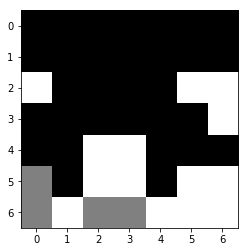

((5, 2), (5, 0)): n_v:  1755 q_all:-0.732323 q:-0.756542 q_m:-0.366667 p:0.536875
((4, 2), (5, 0)): n_v:   753 q_all:-0.719391 q:-0.709563 q_m:-0.366667 p:0.197661
((6, 1), (5, 0)): n_v:   574 q_all:-0.775623 q:-0.679742 q_m:-0.333333 p:0.259682
((4, 3), (6, 2)): n_v:     4 q_all:-0.731391 q:-0.814925 q_m:-0.500000 p:0.001423
((5, 2), (6, 0)): n_v:     3 q_all:-0.779203 q:-0.817456 q_m:-0.500000 p:0.001640
((4, 2), (6, 0)): n_v:     2 q_all:-0.712184 q:-0.810077 q_m:-0.500000 p:0.000630
((4, 2), (6, 3)): n_v:     1 q_all:-0.756461 q:-0.871821 q_m:-0.500000 p:0.000354
((6, 1), (6, 0)): n_v:     1 q_all:-0.710086 q:-0.800878 q_m:-0.466667 p:0.000341
((4, 2), (6, 2)): n_v:     1 q_all:-0.676305 q:-0.819155 q_m:-0.500000 p:0.000073
((4, 3), (6, 3)): n_v:     1 q_all:-0.702984 q:-0.861269 q_m:-0.500000 p:0.000159
((6, 4), (6, 2)): n_v:     1 q_all:-0.703025 q:-0.818097 q_m:-0.500000 p:0.000320
((5, 2), (6, 2)): n_v:     1 q_all:-0.701178 q:-0.826287 q_m:-0.466667 p:0.000094
((5, 5), (6, 3))

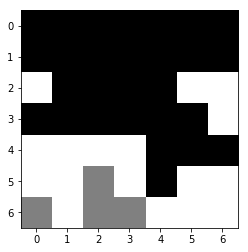

((3, 0), (5, 2)): n_v:  2726 q_all:+0.739301 q:+0.813264 q_m:+0.766667 p:0.837320
((4, 4), (5, 2)): n_v:   373 q_all:+0.799411 q:+0.722179 q_m:+0.766667 p:0.038959
((5, 4), (5, 2)): n_v:   274 q_all:+0.760592 q:+0.784312 q_m:+0.766667 p:0.064640
((3, 1), (5, 2)): n_v:    38 q_all:+0.681951 q:+0.762964 q_m:+0.766667 p:0.019321
((3, 3), (5, 2)): n_v:    38 q_all:+0.662164 q:+0.701194 q_m:+0.766667 p:0.021986
((3, 4), (5, 2)): n_v:    19 q_all:+0.695865 q:+0.693728 q_m:+0.766667 p:0.008622
((3, 2), (5, 2)): n_v:     9 q_all:+0.647989 q:+0.758892 q_m:+0.766667 p:0.005154
((5, 4), (6, 3)): n_v:     7 q_all:+0.713537 q:+0.812088 q_m:+0.533333 p:0.002984
((4, 4), (6, 3)): n_v:     0 q_all:+0.582399 q:+0.664798 q_m:+0.500000 p:0.000202
((5, 4), (6, 2)): n_v:     0 q_all:+0.649708 q:+0.732748 q_m:+0.566667 p:0.000574
((4, 5), (6, 3)): n_v:     0 q_all:+0.609376 q:+0.718753 q_m:+0.500000 p:0.000066
((4, 4), (6, 2)): n_v:     0 q_all:+0.595366 q:+0.624065 q_m:+0.566667 p:0.000155
1 's turn


This

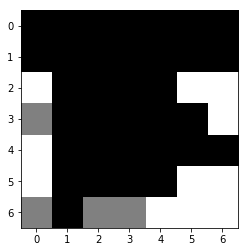

((5, 0), (3, 0)): n_v:  1099 q_all:-0.693860 q:-0.763355 q_m:-0.566667 p:0.099213
((2, 0), (3, 0)): n_v:  1088 q_all:-0.728760 q:-0.744448 q_m:-0.533333 p:0.211833
((6, 4), (6, 2)): n_v:  1087 q_all:-0.760498 q:-0.821507 q_m:-0.500000 p:0.314697
((4, 0), (6, 2)): n_v:   443 q_all:-0.747337 q:-0.787240 q_m:-0.500000 p:0.110670
((5, 0), (6, 2)): n_v:   112 q_all:-0.732088 q:-0.783031 q_m:-0.500000 p:0.023038
((5, 0), (6, 0)): n_v:    71 q_all:-0.749310 q:-0.814170 q_m:-0.600000 p:0.018345
((4, 0), (6, 0)): n_v:    38 q_all:-0.706750 q:-0.794638 q_m:-0.633333 p:0.004883
((6, 5), (6, 3)): n_v:     4 q_all:-0.791355 q:-0.859774 q_m:-0.566667 p:0.001660
((5, 5), (6, 3)): n_v:     1 q_all:-0.840587 q:-0.929016 q_m:-0.566667 p:0.000929
((6, 4), (6, 3)): n_v:     1 q_all:-0.758711 q:-0.852887 q_m:-0.533333 p:0.000430
-1 's turn


This is a random move


one move takes time(s):  0.22560834884643555
train_mode is both train
no. of data collected:  8


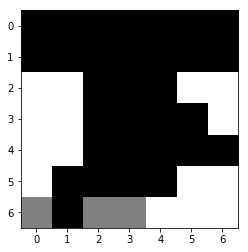

((5, 1), (6, 0)): n_v:  2184 q_all:+0.755610 q:+0.809651 q_m:+0.633333 p:0.410758
((5, 1), (6, 2)): n_v:   212 q_all:+0.782149 q:+0.849397 q_m:+0.566667 p:0.018850
((5, 2), (6, 3)): n_v:   207 q_all:+0.756118 q:+0.895322 q_m:+0.633333 p:0.038286
((6, 1), (6, 3)): n_v:    24 q_all:+0.709687 q:+0.836035 q_m:+0.600000 p:0.008571
((5, 1), (6, 3)): n_v:     6 q_all:+0.769087 q:+0.821826 q_m:+0.600000 p:0.000949
((5, 2), (6, 0)): n_v:     3 q_all:+0.690738 q:+0.692909 q_m:+0.600000 p:0.001368
((4, 3), (6, 3)): n_v:     2 q_all:+0.647583 q:+0.648212 q_m:+0.600000 p:0.000912
((4, 2), (6, 0)): n_v:     2 q_all:+0.624435 q:+0.630488 q_m:+0.600000 p:0.001465
((4, 2), (6, 3)): n_v:     1 q_all:+0.676149 q:+0.800450 q_m:+0.600000 p:0.000680
((4, 3), (6, 2)): n_v:     1 q_all:+0.506766 q:+0.580544 q_m:+0.533333 p:0.001388
((4, 5), (6, 3)): n_v:     1 q_all:+0.646907 q:+0.736256 q_m:+0.600000 p:0.000613
((4, 4), (6, 3)): n_v:     0 q_all:+0.654247 q:+0.708494 q_m:+0.600000 p:0.000360
((4, 2), (6, 2))

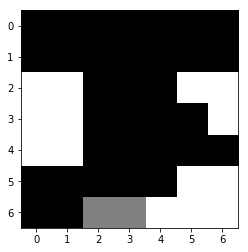

((6, 4), (6, 2)): n_v:  2559 q_all:-0.846151 q:-0.798808 q_m:-0.366667 p:0.822192
((4, 0), (6, 2)): n_v:   650 q_all:-0.796610 q:-0.798499 q_m:-0.366667 p:0.106289
((6, 5), (6, 3)): n_v:    88 q_all:-0.854612 q:-0.869560 q_m:-0.433333 p:0.030395
((4, 1), (6, 3)): n_v:    55 q_all:-0.795687 q:-0.878444 q_m:-0.433333 p:0.008409
((4, 1), (6, 2)): n_v:    54 q_all:-0.811378 q:-0.755589 q_m:-0.366667 p:0.011470
((5, 5), (6, 3)): n_v:    50 q_all:-0.847059 q:-0.931681 q_m:-0.433333 p:0.016280
((6, 4), (6, 3)): n_v:     8 q_all:-0.923994 q:-0.915945 q_m:-0.400000 p:0.004528
-1 's turn
one move takes time(s):  0.13646960258483887
train_mode is both train
no. of data collected:  8


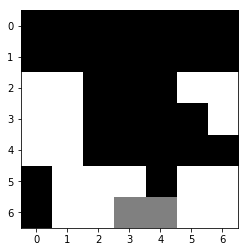

((5, 4), (6, 4)): n_v:  2279 q_all:+0.936690 q:+0.945314 q_m:+0.600000 p:0.425140
((4, 2), (6, 4)): n_v:  1048 q_all:+0.924003 q:+0.787079 q_m:+0.566667 p:0.105993
((5, 4), (6, 3)): n_v:   420 q_all:+0.771006 q:+0.939441 q_m:+0.600000 p:0.290136
((4, 6), (6, 4)): n_v:   337 q_all:+0.843189 q:+0.825841 q_m:+0.566667 p:0.127674
((4, 2), (6, 3)): n_v:    12 q_all:+0.705690 q:+0.779688 q_m:+0.566667 p:0.011545
((4, 4), (6, 3)): n_v:    11 q_all:+0.737637 q:+0.821168 q_m:+0.566667 p:0.009217
((4, 3), (6, 4)): n_v:    10 q_all:+0.668330 q:+0.733010 q_m:+0.566667 p:0.010326
((4, 5), (6, 3)): n_v:    10 q_all:+0.701714 q:+0.844885 q_m:+0.566667 p:0.009176
((4, 5), (6, 4)): n_v:     4 q_all:+0.737946 q:+0.778458 q_m:+0.566667 p:0.003494
((4, 4), (6, 4)): n_v:     2 q_all:+0.622495 q:+0.678322 q_m:+0.566667 p:0.003335
((4, 3), (6, 3)): n_v:     2 q_all:+0.649033 q:+0.749640 q_m:+0.566667 p:0.002365
1 's turn


This is a random move


one move takes time(s):  0.03604698181152344
train_mode is bot

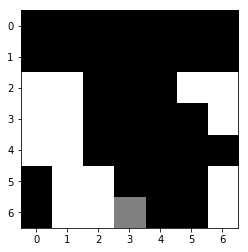

((5, 2), (6, 3)): n_v:  1152 q_all:-1.000000 q:+5.000000 q_m:-0.366667 p:0.244724
((4, 1), (6, 3)): n_v:   917 q_all:-0.992023 q:-0.991419 q_m:-0.400000 p:0.171909
((6, 1), (6, 3)): n_v:   797 q_all:-0.999621 q:-0.995515 q_m:-0.400000 p:0.168461
((5, 1), (6, 3)): n_v:   559 q_all:-0.998983 q:-0.991356 q_m:-0.400000 p:0.117035
this self play has 76 steps, time elapsed 86.24185562133789
winner is -1.0
episode 101 finished
episode 102 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.37340307235717773
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5443122386932373
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0437612533569336
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6726198196411133
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elaps

one move takes time(s):  0.513756513595581
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.35315489768981934
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.46129703521728516
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.36490559577941895
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5443155765533447
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.42849040031433105
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.47037577629089355
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3116602897644043
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6802847385406494
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s

one move takes time(s):  1.4714703559875488
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.391422748565674


This is a random move


one move takes time(s):  5.392731666564941
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4434263706207275
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.8567750453948975
one move takes time(s):  2.8580400943756104
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2786808013916016
one move takes time(s):  2.2799036502838135
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3765180110931396
one move takes time(s):  2.377819299697876
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, 



This is a random move


one move takes time(s):  1.5339653491973877
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.858067512512207
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7817225456237793
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8307180404663086
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.48464131355285645
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.7404782772064209
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.837752103805542
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4455158710479736
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7384405136108398
train_mode is both train
no. of data collected:  8
-1 's turn

due to rollout lim, final rollout times:  1601 time elapsed:  5.933123350143433
one move takes time(s):  5.934444904327393
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6568315029144287
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.1915183067321777
one move takes time(s):  3.1927762031555176
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.528639316558838
one move takes time(s):  2.5296504497528076
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.411303281784058
one move takes time(s):  5.412543296813965
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7366762161254883
one move takes time(s):  2.7379772663116455
train_mode is both train
no.

Epoch 13/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8587 - activation_29_loss: 1.8232 - dense_15_loss: 0.0104 - val_loss: 1.8928 - val_activation_29_loss: 1.8572 - val_dense_15_loss: 0.0105
Epoch 14/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8572 - activation_29_loss: 1.8218 - dense_15_loss: 0.0103 - val_loss: 1.8930 - val_activation_29_loss: 1.8574 - val_dense_15_loss: 0.0105
Epoch 15/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8566 - activation_29_loss: 1.8210 - dense_15_loss: 0.0105 - val_loss: 1.8931 - val_activation_29_loss: 1.8575 - val_dense_15_loss: 0.0105
Epoch 16/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8548 - activation_29_loss: 1.8196 - dense_15_loss: 0.0102 - val_loss: 1.8932 - val_activation_29_loss: 1.8576 - val_dense_15_loss: 0.0106
Epoch 17/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8540 - activation_29_loss: 1.8189 - dense_1

9000/9000 [==============================] - 1s 92us/step - loss: 1.8268 - activation_29_loss: 1.7926 - dense_15_loss: 0.0091 - val_loss: 1.8966 - val_activation_29_loss: 1.8608 - val_dense_15_loss: 0.0108
Epoch 51/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8265 - activation_29_loss: 1.7923 - dense_15_loss: 0.0091 - val_loss: 1.8967 - val_activation_29_loss: 1.8609 - val_dense_15_loss: 0.0108
Epoch 52/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8254 - activation_29_loss: 1.7913 - dense_15_loss: 0.0090 - val_loss: 1.8974 - val_activation_29_loss: 1.8616 - val_dense_15_loss: 0.0107
Epoch 53/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8240 - activation_29_loss: 1.7900 - dense_15_loss: 0.0090 - val_loss: 1.8972 - val_activation_29_loss: 1.8614 - val_dense_15_loss: 0.0108
Epoch 54/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8248 - activation_29_loss: 1.7906 - dense_15_loss: 0.009

due to rollout lim, final rollout times:  1601 time elapsed:  2.1073200702667236
one move takes time(s):  2.1089069843292236
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.361997127532959
one move takes time(s):  2.363175392150879
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.779472827911377
one move takes time(s):  2.780855655670166
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8046822547912598
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.031749963760376


This is a random move


one move takes time(s):  3.03301739692688
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.665236711502075
one move takes time(s):  3.6665844917297363
train

one move takes time(s):  0.11509418487548828
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.0584256649017334
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.06771421432495117
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.07673144340515137
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.060744524002075195
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.028837203979492188
train_mode is both train
no. of data collected:  8
this self play has 76 steps, time elapsed 502.8075692653656
winner is 1.0
episode 106 finished
episode 107 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.38977956771850586
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5424356460571289
train_mode is both train
no. o



This is a random move


one move takes time(s):  0.4730417728424072
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6824741363525391
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0882833003997803
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8264245986938477
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8881759643554688
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5731377601623535
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7757120132446289
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8725287914276123
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1467747688293457
train_mode is both train
no. of data collected:  8
-1 's tur

one move takes time(s):  1.664262294769287
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9309048652648926
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9744272232055664
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.3710625171661377
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3725883960723877
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6531906127929688
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9935469627380371
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6625938415527344
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5241014957427979
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  

due to rollout lim, final rollout times:  1601 time elapsed:  4.156479597091675
one move takes time(s):  4.157657861709595
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.275782108306885
one move takes time(s):  5.277080059051514
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1882874965667725
one move takes time(s):  2.1906015872955322
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5519492626190186
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.067854166030884
one move takes time(s):  3.0691158771514893
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.1117305755615234


This is a random move


one move takes time(s):  3.1130547523498535
tr

one move takes time(s):  0.875251054763794
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6190030574798584
one move takes time(s):  2.6204652786254883
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8325455188751221
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.267984390258789
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8375587463378906
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6716055870056152
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8525927066802979
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5158722400665283
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4291601181030273
train_mode is both train
no. of d



This is a random move


one move takes time(s):  0.06916189193725586
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.09746861457824707
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.06966900825500488
train_mode is both train
no. of data collected:  8
this self play has 83 steps, time elapsed 99.32778429985046
winner is -1.0
35456  data in database
10000  data expected
10000  data grabbed
start training, training data no. 10000
Train on 9000 samples, validate on 1000 samples
Epoch 1/512
9000/9000 [==============================] - 1s 119us/step - loss: 1.8906 - activation_29_loss: 1.8539 - dense_15_loss: 0.0116 - val_loss: 1.8945 - val_activation_29_loss: 1.8573 - val_dense_15_loss: 0.0122
Epoch 2/512
9000/9000 [==============================] - 1s 99us/step - loss: 1.8864 - activation_29_loss: 1.8500 - dense_15_loss: 0.0114 - val_loss: 1.8943 - val_activation_29_loss: 1.8571 - 

Epoch 36/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8402 - activation_29_loss: 1.8058 - dense_15_loss: 0.0094 - val_loss: 1.8944 - val_activation_29_loss: 1.8579 - val_dense_15_loss: 0.0114
Epoch 37/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8401 - activation_29_loss: 1.8059 - dense_15_loss: 0.0092 - val_loss: 1.8944 - val_activation_29_loss: 1.8580 - val_dense_15_loss: 0.0114
Epoch 38/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8389 - activation_29_loss: 1.8048 - dense_15_loss: 0.0091 - val_loss: 1.8944 - val_activation_29_loss: 1.8581 - val_dense_15_loss: 0.0113
Epoch 39/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8384 - activation_29_loss: 1.8040 - dense_15_loss: 0.0093 - val_loss: 1.8944 - val_activation_29_loss: 1.8580 - val_dense_15_loss: 0.0114
Epoch 40/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8367 - activation_29_loss: 1.8028 - dense_1

9000/9000 [==============================] - 1s 91us/step - loss: 1.8162 - activation_29_loss: 1.7829 - dense_15_loss: 0.0083 - val_loss: 1.8974 - val_activation_29_loss: 1.8609 - val_dense_15_loss: 0.0115
Epoch 00073: early stopping
saving files
episode 110 finished
episode 111 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3530697822570801
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5025508403778076
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9950466156005859
train_mode is both train
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  1147 time elapsed:  451.4729063510895


This is a random move


one move takes time(s):  451.4875204563141
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.8744101524353027
one move takes time(s):  3.8759

one move takes time(s):  1.0684220790863037
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1427063941955566
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.048255443572998
one move takes time(s):  2.049511432647705
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1919708251953125
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7275521755218506
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2601873874664307
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.48256397247314453
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6672825813293457
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s): 



This is a random move


one move takes time(s):  1.2981600761413574
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.319965124130249
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7542910575866699
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3324418067932129
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.27271413803100586
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.42590808868408203
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5067384243011475
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3503444194793701
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6209578514099121
train_mode is both train
no. of data collected:  8
1 's tur

one move takes time(s):  1.1708199977874756
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1664 time elapsed:  2.0005850791931152


This is a random move


one move takes time(s):  2.0019688606262207
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9675452709197998
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.62520694732666
one move takes time(s):  2.6264443397521973
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.210153818130493
one move takes time(s):  2.21138072013855
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.405860424041748
one move takes time(s):  2.407172441482544
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s): 

one move takes time(s):  1.534231424331665
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.263756513595581
one move takes time(s):  3.2649765014648438
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.642268419265747
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6117801666259766
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.861983299255371
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.236274480819702
one move takes time(s):  2.2383670806884766
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.168703317642212
one move takes time(s):  3.1697986125946045
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move




This is a random move


one move takes time(s):  1.0823619365692139
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6708171367645264
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.791815996170044
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.8779759407043457
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.189091444015503
one move takes time(s):  2.1902875900268555
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5994222164154053
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1020336151123047
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9304113388061523
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4298300743103027
train_m

9000/9000 [==============================] - 1s 102us/step - loss: 1.8959 - activation_29_loss: 1.8584 - dense_15_loss: 0.0124 - val_loss: 1.9199 - val_activation_29_loss: 1.8812 - val_dense_15_loss: 0.0137
Epoch 3/512
9000/9000 [==============================] - 1s 97us/step - loss: 1.8914 - activation_29_loss: 1.8544 - dense_15_loss: 0.0120 - val_loss: 1.9193 - val_activation_29_loss: 1.8807 - val_dense_15_loss: 0.0135
Epoch 4/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8884 - activation_29_loss: 1.8516 - dense_15_loss: 0.0118 - val_loss: 1.9194 - val_activation_29_loss: 1.8809 - val_dense_15_loss: 0.0135
Epoch 5/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8865 - activation_29_loss: 1.8496 - dense_15_loss: 0.0118 - val_loss: 1.9184 - val_activation_29_loss: 1.8800 - val_dense_15_loss: 0.0134
Epoch 6/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8835 - activation_29_loss: 1.8469 - dense_15_loss: 0.0116 -

9000/9000 [==============================] - 1s 93us/step - loss: 1.8456 - activation_29_loss: 1.8112 - dense_15_loss: 0.0094 - val_loss: 1.9259 - val_activation_29_loss: 1.8855 - val_dense_15_loss: 0.0154
Epoch 40/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8449 - activation_29_loss: 1.8104 - dense_15_loss: 0.0094 - val_loss: 1.9262 - val_activation_29_loss: 1.8856 - val_dense_15_loss: 0.0155
Epoch 41/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8445 - activation_29_loss: 1.8101 - dense_15_loss: 0.0093 - val_loss: 1.9265 - val_activation_29_loss: 1.8859 - val_dense_15_loss: 0.0155
Epoch 42/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8435 - activation_29_loss: 1.8091 - dense_15_loss: 0.0093 - val_loss: 1.9270 - val_activation_29_loss: 1.8865 - val_dense_15_loss: 0.0155
Epoch 43/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8428 - activation_29_loss: 1.8085 - dense_15_loss: 0.009

due to rollout lim, final rollout times:  1601 time elapsed:  2.3040478229522705
one move takes time(s):  2.3050897121429443
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6704211235046387
one move takes time(s):  2.67229962348938
train_mode is both train
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  1 time elapsed:  464.18239164352417
one move takes time(s):  464.2057511806488
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.817887783050537
one move takes time(s):  2.8191375732421875
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2591471672058105
one move takes time(s):  2.260611057281494
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.56685709953308

one move takes time(s):  0.24376535415649414
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4842400550842285
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.31157922744750977
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6125774383544922
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.332782506942749
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.20295500755310059
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1740891933441162
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.1587977409362793
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.174835205078125
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s): 

due to rollout lim, final rollout times:  1601 time elapsed:  4.12677001953125
one move takes time(s):  4.12816309928894
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6795122623443604
one move takes time(s):  2.6806869506835938
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.523136377334595


This is a random move


one move takes time(s):  4.524279356002808
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.546417713165283
one move takes time(s):  3.5474987030029297
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.0308210849761963
one move takes time(s):  3.0323326587677
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time 

due to rollout lim, final rollout times:  1601 time elapsed:  2.214073896408081
one move takes time(s):  2.2152857780456543
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9344258308410645
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0563843250274658
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5443227291107178
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.8426103591918945
one move takes time(s):  2.843811273574829
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.339440107345581
one move takes time(s):  3.3409578800201416
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6159589290618896
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, f

-1 's turn


This is a random move


one move takes time(s):  0.06544709205627441
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.05483889579772949
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.03342700004577637
train_mode is both train
no. of data collected:  8
this self play has 71 steps, time elapsed 115.99857497215271
winner is -1.0
episode 118 finished
episode 119 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3943452835083008
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.545041561126709
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.0348718166351318
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.212742805480957
train_mode is both train
no. of data collected:  8


due to rollout lim, final rollout times:  1601 time elapsed:  2.3693928718566895
one move takes time(s):  2.370543956756592
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.2449018955230713


This is a random move


one move takes time(s):  3.2462143898010254
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.8733901977539062
one move takes time(s):  2.8749566078186035
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.278815746307373


This is a random move


one move takes time(s):  3.2800590991973877
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.9745585918426514
one move takes time(s):  3.975766181945801
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim,

one move takes time(s):  0.5467875003814697
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.0649480819702148
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9720749855041504
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.251476287841797


This is a random move


one move takes time(s):  3.2521183490753174
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.0674328804016113


This is a random move


one move takes time(s):  3.069819450378418
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.531541109085083


This is a random move


one move takes time(s):  3.532564163208008
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, fina

one move takes time(s):  1.050786018371582
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2750256061553955
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3874971866607666
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8168044090270996
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.664086103439331
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8925936222076416
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3988921642303467
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.34328246116638184
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.24362492561340332
train_mode is both train
no. of data collected:  8
1 's turn

9000/9000 [==============================] - 1s 91us/step - loss: 1.8806 - activation_29_loss: 1.8466 - dense_15_loss: 0.0089 - val_loss: 1.9379 - val_activation_29_loss: 1.8985 - val_dense_15_loss: 0.0143
Epoch 28/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8794 - activation_29_loss: 1.8456 - dense_15_loss: 0.0088 - val_loss: 1.9374 - val_activation_29_loss: 1.8988 - val_dense_15_loss: 0.0136
Epoch 29/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8781 - activation_29_loss: 1.8444 - dense_15_loss: 0.0087 - val_loss: 1.9375 - val_activation_29_loss: 1.8987 - val_dense_15_loss: 0.0137
Epoch 30/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8784 - activation_29_loss: 1.8445 - dense_15_loss: 0.0089 - val_loss: 1.9380 - val_activation_29_loss: 1.8989 - val_dense_15_loss: 0.0141
Epoch 31/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8773 - activation_29_loss: 1.8435 - dense_15_loss: 0.008

9000/9000 [==============================] - 1s 93us/step - loss: 1.8534 - activation_29_loss: 1.8203 - dense_15_loss: 0.0080 - val_loss: 1.9401 - val_activation_29_loss: 1.9007 - val_dense_15_loss: 0.0144
Epoch 65/512
9000/9000 [==============================] - 1s 96us/step - loss: 1.8532 - activation_29_loss: 1.8201 - dense_15_loss: 0.0080 - val_loss: 1.9399 - val_activation_29_loss: 1.9007 - val_dense_15_loss: 0.0142
Epoch 66/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8530 - activation_29_loss: 1.8198 - dense_15_loss: 0.0081 - val_loss: 1.9402 - val_activation_29_loss: 1.9010 - val_dense_15_loss: 0.0142
Epoch 67/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8524 - activation_29_loss: 1.8193 - dense_15_loss: 0.0080 - val_loss: 1.9403 - val_activation_29_loss: 1.9011 - val_dense_15_loss: 0.0142
Epoch 68/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8514 - activation_29_loss: 1.8185 - dense_15_loss: 0.007

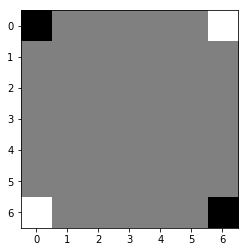

((6, 6), (5, 5)): n_v:   670 q_all:+0.009986 q:+0.016140 q_m:+0.033333 p:0.364975
((0, 0), (1, 1)): n_v:   635 q_all:+0.004312 q:+0.012143 q_m:+0.033333 p:0.363523
((6, 6), (6, 5)): n_v:   144 q_all:-0.000570 q:+0.002785 q_m:+0.033333 p:0.085772
((0, 0), (0, 1)): n_v:   143 q_all:-0.003200 q:-0.013396 q_m:+0.033333 p:0.087219
((6, 6), (5, 6)): n_v:    84 q_all:+0.004623 q:+0.005102 q_m:+0.033333 p:0.047997
((0, 0), (1, 0)): n_v:    84 q_all:+0.003541 q:+0.010937 q_m:+0.033333 p:0.048857
((6, 6), (6, 4)): n_v:     0 q_all:-0.000488 q:-0.000488 q_m:-0.000000 p:0.000033
((0, 0), (1, 2)): n_v:     0 q_all:-0.017719 q:-0.017719 q_m:-0.000000 p:0.000070
((0, 0), (2, 2)): n_v:     0 q_all:-0.025517 q:-0.025517 q_m:-0.000000 p:0.000217
((0, 0), (0, 2)): n_v:     0 q_all:-0.028375 q:-0.028375 q_m:-0.000000 p:0.000035
((6, 6), (4, 6)): n_v:     0 q_all:-0.018790 q:-0.018790 q_m:-0.000000 p:0.000169
((6, 6), (5, 4)): n_v:     0 q_all:+0.007464 q:+0.007464 q_m:-0.000000 p:0.000121
((6, 6), (4, 4))

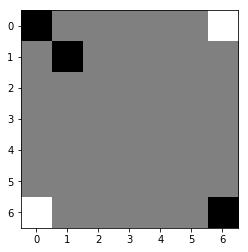

((0, 6), (1, 5)): n_v:   626 q_all:-0.013196 q:-0.018318 q_m:-0.000000 p:0.251089
((6, 0), (5, 1)): n_v:   610 q_all:-0.019604 q:-0.017693 q_m:-0.000000 p:0.260462
((0, 6), (1, 6)): n_v:   434 q_all:-0.017740 q:-0.025859 q_m:-0.000000 p:0.182282
((6, 0), (5, 0)): n_v:   432 q_all:-0.015539 q:-0.018076 q_m:-0.000000 p:0.177606
((0, 6), (0, 5)): n_v:   147 q_all:-0.021836 q:-0.037306 q_m:-0.000000 p:0.064362
((6, 0), (6, 1)): n_v:   145 q_all:-0.018856 q:-0.009729 q_m:-0.000000 p:0.061503
((0, 6), (2, 6)): n_v:     1 q_all:-0.020350 q:-0.017625 q_m:-0.033333 p:0.000462
((0, 6), (2, 4)): n_v:     0 q_all:-0.046648 q:-0.046648 q_m:-0.033333 p:0.000220
((6, 0), (6, 2)): n_v:     0 q_all:-0.031639 q:-0.031639 q_m:-0.033333 p:0.000127
((6, 0), (5, 2)): n_v:     0 q_all:-0.030004 q:-0.030004 q_m:-0.033333 p:0.000142
((6, 0), (4, 1)): n_v:     0 q_all:-0.020864 q:-0.020864 q_m:-0.033333 p:0.000235
((0, 6), (0, 4)): n_v:     0 q_all:-0.043473 q:-0.043473 q_m:-0.033333 p:0.000119
((0, 6), (2, 5))

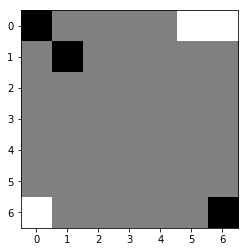

((6, 6), (5, 5)): n_v:  1027 q_all:+0.001015 q:+0.016327 q_m:+0.033333 p:0.471762
((1, 1), (2, 2)): n_v:   202 q_all:-0.009784 q:-0.008965 q_m:+0.033333 p:0.102880
((1, 1), (2, 1)): n_v:   162 q_all:-0.005056 q:+0.000346 q_m:+0.033333 p:0.079176
((6, 6), (6, 5)): n_v:   108 q_all:-0.007273 q:+0.003205 q_m:+0.033333 p:0.054070
((0, 0), (0, 1)): n_v:   103 q_all:-0.008676 q:-0.022614 q_m:+0.033333 p:0.052335
((0, 0), (1, 0)): n_v:    81 q_all:-0.002638 q:-0.008902 q_m:+0.033333 p:0.038815
((6, 6), (5, 6)): n_v:    69 q_all:+0.000383 q:+0.005457 q_m:+0.033333 p:0.032095
((1, 1), (2, 0)): n_v:    60 q_all:-0.005436 q:-0.005207 q_m:+0.033333 p:0.029811
((1, 1), (1, 2)): n_v:    58 q_all:-0.002628 q:-0.000104 q_m:+0.033333 p:0.027605
((1, 1), (0, 2)): n_v:    37 q_all:-0.010950 q:-0.008173 q_m:+0.033333 p:0.019262
((1, 1), (3, 0)): n_v:     0 q_all:-0.023728 q:-0.023728 q_m:-0.000000 p:0.000097
((6, 6), (6, 4)): n_v:     0 q_all:-0.000860 q:-0.000860 q_m:-0.000000 p:0.000037
((1, 1), (2, 3))

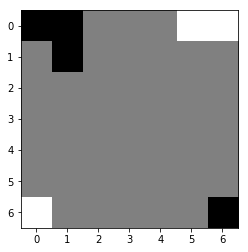

((0, 5), (1, 6)): n_v:   838 q_all:-0.026010 q:-0.028721 q_m:-0.000000 p:0.304633
((6, 0), (5, 0)): n_v:   511 q_all:-0.022454 q:-0.022813 q_m:-0.000000 p:0.177677
((0, 5), (1, 5)): n_v:   210 q_all:-0.029466 q:-0.030894 q_m:-0.000000 p:0.079756
((6, 0), (5, 1)): n_v:   166 q_all:-0.029625 q:-0.023276 q_m:-0.000000 p:0.063221
((0, 5), (1, 4)): n_v:    61 q_all:-0.027463 q:-0.020491 q_m:-0.000000 p:0.022657
((6, 0), (6, 1)): n_v:    46 q_all:-0.025242 q:-0.015362 q_m:-0.000000 p:0.016807
((0, 5), (0, 4)): n_v:    27 q_all:-0.038936 q:-0.036955 q_m:-0.000000 p:0.011401
((0, 5), (2, 6)): n_v:     2 q_all:-0.033133 q:-0.017365 q_m:-0.033333 p:0.000730
((0, 5), (2, 3)): n_v:     0 q_all:-0.040195 q:-0.040195 q_m:-0.033333 p:0.000066
((0, 5), (2, 5)): n_v:     0 q_all:-0.023637 q:-0.023637 q_m:-0.033333 p:0.000111
((0, 6), (2, 4)): n_v:     0 q_all:-0.052649 q:-0.052649 q_m:-0.033333 p:0.000081
((6, 0), (6, 2)): n_v:     0 q_all:-0.034386 q:-0.034386 q_m:-0.033333 p:0.000070
((0, 6), (2, 5))

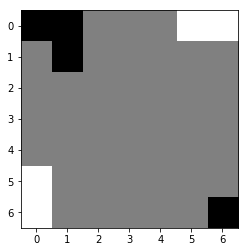

((6, 6), (5, 5)): n_v:  1289 q_all:-0.008879 q:-0.002990 q_m:+0.033333 p:0.524793
((1, 1), (2, 1)): n_v:   325 q_all:-0.000438 q:-0.020161 q_m:+0.033333 p:0.120569
((1, 1), (2, 2)): n_v:   184 q_all:-0.007697 q:-0.027660 q_m:+0.033333 p:0.074251
((6, 6), (6, 5)): n_v:   161 q_all:-0.014250 q:-0.020255 q_m:+0.033333 p:0.069290
((1, 1), (2, 0)): n_v:    93 q_all:-0.005184 q:-0.015269 q_m:+0.033333 p:0.036387
((6, 6), (5, 6)): n_v:    76 q_all:-0.009610 q:-0.015584 q_m:+0.033333 p:0.031322
((0, 0), (1, 0)): n_v:    65 q_all:-0.010610 q:-0.037670 q_m:+0.033333 p:0.027183
((0, 1), (0, 2)): n_v:    38 q_all:-0.006064 q:-0.038172 q_m:+0.033333 p:0.015123
((0, 1), (1, 2)): n_v:    36 q_all:-0.009717 q:-0.037371 q_m:+0.033333 p:0.015138
((1, 1), (3, 0)): n_v:     1 q_all:-0.048820 q:-0.022541 q_m:-0.000000 p:0.000544
((1, 1), (3, 1)): n_v:     1 q_all:-0.030651 q:-0.016683 q_m:-0.000000 p:0.000493
((0, 1), (0, 3)): n_v:     0 q_all:-0.033379 q:-0.033379 q_m:-0.000000 p:0.000081
((6, 6), (6, 4))

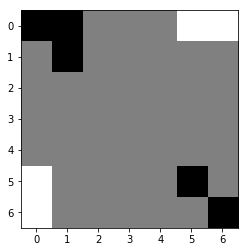

((0, 5), (1, 6)): n_v:   988 q_all:-0.011283 q:-0.021340 q_m:-0.000000 p:0.200199
((5, 0), (4, 1)): n_v:   490 q_all:-0.004525 q:-0.020413 q_m:-0.000000 p:0.087455
((0, 5), (1, 5)): n_v:   422 q_all:-0.013476 q:-0.025381 q_m:-0.000000 p:0.088971
((5, 0), (4, 0)): n_v:   334 q_all:-0.008939 q:-0.024977 q_m:-0.000000 p:0.064766
((5, 0), (5, 1)): n_v:   291 q_all:-0.014518 q:-0.024638 q_m:-0.000000 p:0.062562
((5, 0), (6, 1)): n_v:   263 q_all:-0.010543 q:-0.023620 q_m:-0.000000 p:0.052684
((0, 5), (0, 4)): n_v:   118 q_all:-0.011733 q:-0.030320 q_m:-0.000000 p:0.024231
((0, 5), (1, 4)): n_v:   117 q_all:-0.002888 q:-0.011521 q_m:-0.000000 p:0.020239
((0, 5), (2, 6)): n_v:     3 q_all:-0.013925 q:-0.011290 q_m:-0.033333 p:0.000847
((0, 5), (2, 5)): n_v:     1 q_all:-0.014091 q:-0.014468 q_m:-0.033333 p:0.000224
((5, 0), (3, 2)): n_v:     1 q_all:-0.051612 q:-0.029240 q_m:-0.033333 p:0.000352
((5, 0), (3, 0)): n_v:     1 q_all:-0.059336 q:-0.037677 q_m:-0.033333 p:0.000581
((5, 0), (3, 1))

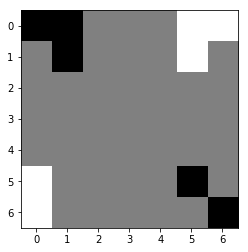

((0, 0), (1, 0)): n_v:   429 q_all:-0.013724 q:-0.040539 q_m:+0.033333 p:0.142203
((0, 1), (1, 2)): n_v:   317 q_all:+0.004778 q:-0.020891 q_m:+0.033333 p:0.079359
((5, 5), (4, 5)): n_v:   251 q_all:+0.007205 q:-0.012277 q_m:+0.033333 p:0.059932
((1, 1), (2, 2)): n_v:   222 q_all:+0.010606 q:-0.013603 q_m:+0.033333 p:0.049895
((1, 1), (2, 1)): n_v:   200 q_all:-0.002469 q:-0.014706 q_m:+0.033333 p:0.056493
((5, 5), (4, 4)): n_v:   117 q_all:+0.005123 q:+0.004414 q_m:+0.033333 p:0.029011
((5, 5), (6, 5)): n_v:   102 q_all:-0.015872 q:-0.020166 q_m:+0.033333 p:0.034698
((5, 5), (5, 6)): n_v:   100 q_all:-0.014496 q:-0.006226 q_m:+0.033333 p:0.033501
((5, 5), (5, 4)): n_v:    99 q_all:-0.009492 q:+0.006844 q_m:+0.033333 p:0.031035
((0, 1), (0, 2)): n_v:    99 q_all:+0.014660 q:-0.024545 q_m:+0.033333 p:0.020498
((5, 5), (6, 4)): n_v:    47 q_all:-0.015159 q:+0.003452 q_m:+0.033333 p:0.016040
((5, 5), (4, 6)): n_v:    19 q_all:-0.006171 q:-0.000475 q_m:+0.033333 p:0.005571
((1, 1), (2, 0))

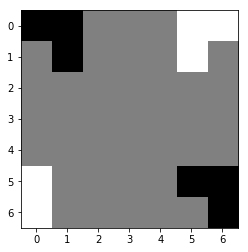

((5, 0), (6, 1)): n_v:   369 q_all:-0.031237 q:-0.033790 q_m:-0.000000 p:0.144264
((0, 5), (1, 6)): n_v:   282 q_all:-0.025282 q:-0.032971 q_m:-0.000000 p:0.102186
((5, 0), (4, 1)): n_v:   241 q_all:-0.017926 q:-0.031495 q_m:-0.000000 p:0.078886
((1, 5), (2, 4)): n_v:   224 q_all:+0.012234 q:-0.034420 q_m:-0.000000 p:0.040470
((1, 5), (2, 5)): n_v:   213 q_all:-0.000315 q:-0.009362 q_m:-0.000000 p:0.051726
((5, 0), (5, 1)): n_v:   112 q_all:-0.026374 q:-0.036899 q_m:-0.000000 p:0.041133
((5, 0), (4, 0)): n_v:    83 q_all:-0.024745 q:-0.036033 q_m:-0.000000 p:0.029694
((1, 5), (2, 6)): n_v:    80 q_all:-0.014014 q:-0.026298 q_m:-0.000000 p:0.024471
((0, 5), (0, 4)): n_v:    74 q_all:+0.012822 q:-0.033588 q_m:-0.000000 p:0.013394
((0, 5), (1, 4)): n_v:    39 q_all:+0.010825 q:-0.028020 q_m:-0.000000 p:0.007398
((0, 6), (0, 4)): n_v:     3 q_all:+0.014046 q:-0.045706 q_m:-0.033333 p:0.000515
((1, 5), (3, 6)): n_v:     1 q_all:-0.063953 q:-0.040037 q_m:-0.033333 p:0.000574
((6, 0), (6, 2))

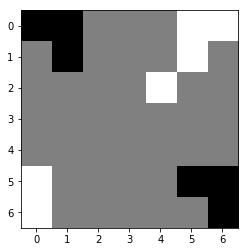

((5, 5), (3, 3)): n_v:   399 q_all:+0.034653 q:+0.023992 q_m:+0.066667 p:0.107470
((0, 1), (1, 2)): n_v:   338 q_all:-0.008861 q:-0.022437 q_m:+0.033333 p:0.160152
((1, 1), (3, 3)): n_v:   131 q_all:+0.039988 q:+0.020050 q_m:+0.066667 p:0.032097
((5, 6), (3, 5)): n_v:   119 q_all:-0.000367 q:+0.003513 q_m:+0.066667 p:0.051843
((5, 5), (5, 4)): n_v:   116 q_all:-0.002733 q:+0.002920 q_m:+0.033333 p:0.051426
((5, 5), (4, 5)): n_v:   105 q_all:-0.026163 q:-0.028434 q_m:+0.033333 p:0.058328
((1, 1), (2, 1)): n_v:    88 q_all:-0.000541 q:-0.014489 q_m:+0.033333 p:0.038474
((5, 5), (3, 5)): n_v:    78 q_all:-0.012392 q:+0.013363 q_m:+0.066667 p:0.038447
((0, 0), (1, 0)): n_v:    57 q_all:+0.001609 q:-0.033402 q_m:+0.033333 p:0.024322
((0, 1), (1, 3)): n_v:    46 q_all:+0.014117 q:+0.015816 q_m:+0.066667 p:0.017118
((5, 5), (6, 5)): n_v:    43 q_all:-0.001986 q:-0.002476 q_m:+0.033333 p:0.019228
((5, 5), (3, 4)): n_v:    38 q_all:-0.011502 q:+0.004752 q_m:+0.066667 p:0.018788
((5, 5), (4, 4))

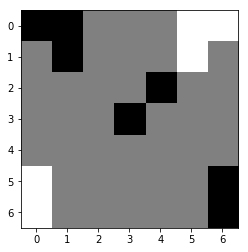

((1, 5), (3, 4)): n_v:   465 q_all:-0.017310 q:+0.001902 q_m:+0.066667 p:0.139997
((1, 5), (2, 5)): n_v:   235 q_all:-0.039953 q:-0.017955 q_m:+0.033333 p:0.094790
((0, 5), (1, 6)): n_v:   214 q_all:-0.037295 q:-0.068326 q_m:-0.033333 p:0.083643
((0, 5), (1, 4)): n_v:   206 q_all:-0.009838 q:-0.031357 q_m:+0.033333 p:0.054738
((1, 5), (2, 3)): n_v:   195 q_all:-0.010542 q:+0.035091 q_m:+0.066667 p:0.052912
((0, 5), (2, 3)): n_v:   174 q_all:-0.002969 q:+0.036998 q_m:+0.066667 p:0.041329
((5, 0), (5, 1)): n_v:   104 q_all:-0.059341 q:-0.052082 q_m:-0.033333 p:0.051011
((5, 0), (3, 2)): n_v:    83 q_all:-0.027136 q:-0.035813 q_m:-0.000000 p:0.028647
((5, 0), (4, 1)): n_v:    65 q_all:-0.063596 q:-0.050573 q_m:-0.033333 p:0.033300
((0, 5), (1, 3)): n_v:    62 q_all:-0.016297 q:-0.004653 q_m:-0.000000 p:0.018381
((0, 5), (0, 4)): n_v:    31 q_all:-0.073036 q:-0.068733 q_m:-0.033333 p:0.017456
((5, 0), (4, 0)): n_v:    25 q_all:-0.052535 q:-0.051540 q_m:-0.033333 p:0.011174
((1, 5), (2, 6))

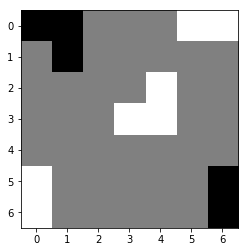

((1, 1), (2, 3)): n_v:   999 q_all:+0.027336 q:+0.040986 q_m:+0.133333 p:0.458017
((0, 1), (2, 3)): n_v:   996 q_all:+0.047355 q:+0.036938 q_m:+0.133333 p:0.372304
((5, 6), (3, 5)): n_v:   104 q_all:-0.018815 q:+0.000444 q_m:+0.066667 p:0.068596
((5, 6), (4, 5)): n_v:    36 q_all:+0.008522 q:-0.028391 q_m:+0.033333 p:0.019902
((1, 1), (2, 2)): n_v:    22 q_all:-0.000947 q:-0.012711 q_m:+0.033333 p:0.012531
((5, 6), (5, 5)): n_v:    14 q_all:-0.009545 q:-0.034440 q_m:-0.033333 p:0.008873
((1, 1), (2, 1)): n_v:    11 q_all:-0.027804 q:-0.040903 q_m:-0.033333 p:0.007812
((6, 6), (4, 5)): n_v:     7 q_all:-0.004258 q:-0.031363 q_m:-0.000000 p:0.004447
((6, 6), (4, 4)): n_v:     5 q_all:+0.000380 q:+0.014965 q_m:+0.066667 p:0.003253
((5, 6), (4, 6)): n_v:     3 q_all:-0.085241 q:-0.043809 q_m:-0.033333 p:0.002789
((0, 1), (1, 2)): n_v:     2 q_all:-0.062096 q:-0.057007 q_m:-0.033333 p:0.002011
((1, 1), (3, 1)): n_v:     2 q_all:-0.060113 q:-0.050725 q_m:-0.066667 p:0.002424
((5, 6), (6, 5))

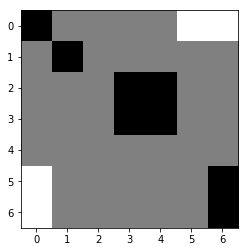

((0, 5), (1, 4)): n_v:  1564 q_all:-0.059247 q:-0.025728 q_m:+0.033333 p:0.587113
((0, 5), (1, 3)): n_v:   417 q_all:-0.026383 q:-0.017236 q_m:-0.000000 p:0.104405
((5, 0), (3, 2)): n_v:   268 q_all:-0.052446 q:-0.013121 q_m:-0.000000 p:0.093845
((0, 6), (1, 4)): n_v:   175 q_all:-0.042011 q:-0.043432 q_m:-0.000000 p:0.054441
((5, 0), (4, 1)): n_v:    76 q_all:-0.083476 q:-0.047540 q_m:-0.100000 p:0.035947
((0, 5), (2, 5)): n_v:    45 q_all:-0.039493 q:-0.013645 q_m:-0.000000 p:0.013544
((0, 6), (2, 5)): n_v:    40 q_all:-0.042520 q:-0.016600 q_m:-0.000000 p:0.012738
((0, 5), (1, 5)): n_v:    28 q_all:-0.079095 q:-0.052858 q_m:-0.033333 p:0.013030
((6, 0), (4, 2)): n_v:    21 q_all:-0.061598 q:-0.042156 q_m:-0.066667 p:0.008288
((0, 5), (0, 4)): n_v:    13 q_all:-0.158295 q:-0.076917 q_m:-0.100000 p:0.009880
((6, 0), (5, 2)): n_v:    13 q_all:-0.103211 q:-0.045516 q_m:-0.133333 p:0.007347
((5, 0), (4, 2)): n_v:    11 q_all:-0.068243 q:-0.036212 q_m:-0.066667 p:0.004622
((5, 0), (3, 1))

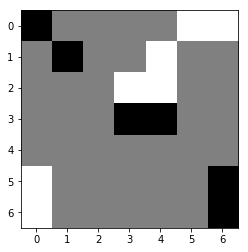

((3, 3), (1, 5)): n_v:  1134 q_all:+0.079634 q:+0.058249 q_m:+0.233333 p:0.296785
((3, 4), (1, 5)): n_v:   630 q_all:+0.088046 q:+0.077570 q_m:+0.233333 p:0.146179
((3, 4), (1, 3)): n_v:   501 q_all:+0.072708 q:+0.058675 q_m:+0.166667 p:0.143342
((1, 1), (1, 3)): n_v:   236 q_all:+0.051455 q:+0.035426 q_m:+0.166667 p:0.085430
((3, 3), (5, 5)): n_v:   180 q_all:-0.015885 q:-0.023036 q_m:-0.033333 p:0.108728
((3, 4), (5, 5)): n_v:   124 q_all:-0.018801 q:-0.020273 q_m:-0.033333 p:0.076174
((3, 3), (5, 1)): n_v:   109 q_all:+0.067136 q:+0.047481 q_m:+0.100000 p:0.033613
((3, 4), (5, 3)): n_v:    60 q_all:-0.037428 q:-0.022361 q_m:-0.033333 p:0.040810
((5, 6), (5, 5)): n_v:    52 q_all:+0.001612 q:-0.004244 q_m:-0.000000 p:0.027941
((3, 3), (1, 3)): n_v:    23 q_all:+0.080155 q:+0.028308 q_m:+0.166667 p:0.006178
((3, 3), (3, 2)): n_v:     5 q_all:-0.040435 q:-0.004547 q_m:+0.066667 p:0.003497
((3, 4), (3, 2)): n_v:     3 q_all:-0.031095 q:-0.009420 q_m:+0.033333 p:0.002168
((3, 3), (2, 5))

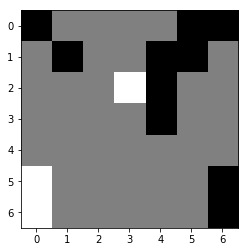

((2, 3), (0, 1)): n_v:   786 q_all:-0.054428 q:-0.071997 q_m:-0.100000 p:0.239402
((2, 3), (0, 4)): n_v:   545 q_all:-0.055297 q:-0.095417 q_m:-0.033333 p:0.167682
((2, 3), (1, 3)): n_v:   399 q_all:-0.079593 q:-0.111739 q_m:-0.066667 p:0.160199
((2, 3), (2, 5)): n_v:   252 q_all:-0.040460 q:-0.053876 q_m:+0.033333 p:0.063426
((2, 3), (0, 2)): n_v:   148 q_all:-0.134398 q:-0.127466 q_m:-0.166667 p:0.090782
((2, 3), (4, 5)): n_v:   119 q_all:-0.118705 q:-0.098511 q_m:-0.100000 p:0.065750
((5, 0), (4, 1)): n_v:    81 q_all:-0.153948 q:-0.142270 q_m:-0.200000 p:0.055816
((2, 3), (2, 1)): n_v:    78 q_all:-0.146064 q:-0.130042 q_m:-0.166667 p:0.050903
((2, 3), (4, 1)): n_v:    73 q_all:-0.152040 q:-0.175438 q_m:-0.233333 p:0.049748
((2, 3), (3, 3)): n_v:    36 q_all:-0.085799 q:-0.120184 q_m:-0.066667 p:0.015511
((2, 3), (1, 2)): n_v:    24 q_all:-0.121524 q:-0.137500 q_m:-0.133333 p:0.013525
((2, 3), (4, 3)): n_v:     7 q_all:-0.179960 q:-0.161867 q_m:-0.166667 p:0.005571
((2, 3), (2, 2))

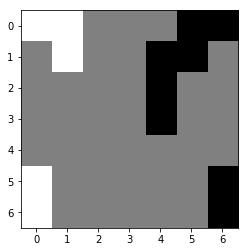

((3, 4), (1, 6)): n_v:   555 q_all:+0.061653 q:-0.002632 q_m:+0.100000 p:0.185147
((2, 4), (1, 2)): n_v:   370 q_all:+0.055312 q:+0.103057 q_m:+0.233333 p:0.133010
((2, 4), (1, 6)): n_v:   290 q_all:+0.082493 q:+0.011556 q_m:+0.100000 p:0.072091
((0, 5), (1, 6)): n_v:   232 q_all:+0.081317 q:+0.006222 q_m:+0.133333 p:0.058663
((3, 4), (1, 2)): n_v:   196 q_all:+0.043512 q:+0.087423 q_m:+0.233333 p:0.080027
((1, 4), (1, 2)): n_v:   146 q_all:+0.051699 q:+0.081399 q_m:+0.233333 p:0.054944
((0, 5), (0, 4)): n_v:    92 q_all:+0.027072 q:+0.009260 q_m:+0.133333 p:0.043861
((3, 4), (5, 5)): n_v:    55 q_all:+0.080702 q:+0.034449 q_m:+0.100000 p:0.014122
((3, 4), (5, 4)): n_v:    44 q_all:+0.078149 q:+0.047637 q_m:+0.100000 p:0.011811
((2, 4), (0, 2)): n_v:    34 q_all:+0.071222 q:+0.102261 q_m:+0.233333 p:0.010175
((3, 4), (2, 6)): n_v:    30 q_all:+0.055562 q:+0.003880 q_m:+0.100000 p:0.010878
((3, 4), (5, 2)): n_v:    23 q_all:+0.062004 q:+0.029639 q_m:+0.100000 p:0.007432
((1, 4), (2, 3))

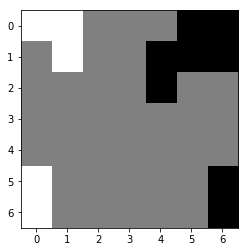

((0, 1), (1, 3)): n_v:   609 q_all:-0.030229 q:+0.001833 q_m:+0.033333 p:0.114522
((1, 1), (1, 3)): n_v:   278 q_all:-0.044341 q:+0.000196 q_m:+0.033333 p:0.068520
((1, 1), (2, 1)): n_v:   256 q_all:-0.091425 q:-0.097318 q_m:-0.066667 p:0.113425
((0, 1), (0, 2)): n_v:   225 q_all:-0.107712 q:-0.080193 q_m:-0.066667 p:0.114956
((0, 0), (1, 0)): n_v:   224 q_all:-0.045066 q:-0.075669 q_m:-0.066667 p:0.055983
((1, 1), (2, 2)): n_v:   138 q_all:-0.108207 q:-0.095689 q_m:-0.066667 p:0.070801
((1, 1), (2, 3)): n_v:    89 q_all:-0.032867 q:-0.002972 q_m:+0.033333 p:0.017544
((0, 1), (1, 2)): n_v:    74 q_all:-0.106944 q:-0.087926 q_m:-0.066667 p:0.037850
((5, 0), (4, 1)): n_v:    68 q_all:-0.039201 q:-0.045284 q_m:-0.066667 p:0.015536
((5, 0), (4, 0)): n_v:    62 q_all:-0.001785 q:-0.035091 q_m:-0.066667 p:0.004118
((1, 1), (2, 0)): n_v:    61 q_all:-0.046119 q:-0.055489 q_m:-0.066667 p:0.015656
((0, 1), (0, 3)): n_v:    34 q_all:-0.038945 q:-0.071510 q_m:-0.033333 p:0.007648
((0, 1), (2, 3))

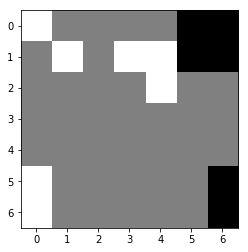

((1, 5), (2, 3)): n_v:  1296 q_all:+0.113550 q:+0.074104 q_m:+0.166667 p:0.168890
((0, 5), (0, 4)): n_v:   444 q_all:-0.011893 q:+0.013771 q_m:+0.133333 p:0.286968
((0, 5), (2, 3)): n_v:   401 q_all:+0.084297 q:+0.044779 q_m:+0.166667 p:0.100615
((1, 5), (2, 5)): n_v:   118 q_all:-0.019369 q:+0.011005 q_m:+0.133333 p:0.080024
((5, 6), (4, 5)): n_v:    39 q_all:-0.034363 q:-0.060450 q_m:-0.000000 p:0.028921
((0, 6), (0, 4)): n_v:    15 q_all:-0.043797 q:-0.012803 q_m:+0.100000 p:0.011928
((0, 6), (2, 5)): n_v:    10 q_all:-0.029929 q:-0.011932 q_m:+0.100000 p:0.007774
((0, 5), (2, 5)): n_v:     8 q_all:-0.018123 q:-0.016838 q_m:+0.100000 p:0.005834
((1, 6), (0, 4)): n_v:     4 q_all:-0.040512 q:-0.017789 q_m:+0.100000 p:0.003390
((0, 5), (0, 3)): n_v:     2 q_all:-0.059256 q:-0.018330 q_m:+0.100000 p:0.002029
((1, 5), (2, 6)): n_v:     2 q_all:-0.050386 q:-0.060893 q_m:-0.000000 p:0.001837
((5, 6), (5, 4)): n_v:     1 q_all:-0.047669 q:-0.041665 q_m:-0.033333 p:0.000855
((5, 6), (5, 5))

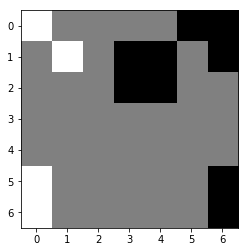

((1, 1), (0, 2)): n_v:  1026 q_all:-0.066390 q:-0.082349 q_m:-0.066667 p:0.151405
((1, 1), (1, 2)): n_v:   678 q_all:-0.126922 q:-0.060929 q_m:-0.000000 p:0.248484
((1, 1), (2, 2)): n_v:   443 q_all:-0.125622 q:-0.074973 q_m:-0.000000 p:0.160554
((5, 0), (5, 1)): n_v:   237 q_all:-0.144517 q:-0.103491 q_m:-0.133333 p:0.102167
((1, 1), (2, 1)): n_v:    93 q_all:-0.093265 q:-0.136002 q_m:-0.133333 p:0.022803
((0, 0), (0, 1)): n_v:    87 q_all:-0.070055 q:-0.120843 q_m:-0.133333 p:0.014104
((1, 1), (3, 3)): n_v:    80 q_all:-0.111314 q:-0.074842 q_m:-0.033333 p:0.025088
((0, 0), (0, 2)): n_v:    73 q_all:-0.150940 q:-0.112137 q_m:-0.100000 p:0.033110
((1, 1), (0, 3)): n_v:    50 q_all:-0.096413 q:-0.104018 q_m:-0.033333 p:0.012808
((0, 0), (1, 2)): n_v:    50 q_all:-0.167445 q:-0.060394 q_m:-0.033333 p:0.025793
((5, 0), (3, 2)): n_v:    33 q_all:-0.116129 q:-0.110360 q_m:-0.100000 p:0.010948
((1, 1), (3, 2)): n_v:    33 q_all:-0.135985 q:-0.106737 q_m:-0.100000 p:0.013553
((1, 1), (2, 0))

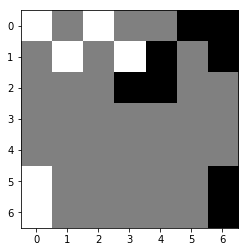

((1, 4), (0, 3)): n_v:   635 q_all:+0.034845 q:+0.074374 q_m:+0.233333 p:0.276847
((2, 3), (1, 2)): n_v:   608 q_all:+0.082148 q:+0.116920 q_m:+0.300000 p:0.155984
((2, 4), (1, 2)): n_v:   579 q_all:+0.076252 q:+0.112860 q_m:+0.266667 p:0.161400
((2, 3), (0, 1)): n_v:   359 q_all:+0.034196 q:+0.091934 q_m:+0.266667 p:0.157598
((1, 4), (1, 2)): n_v:   228 q_all:+0.075315 q:+0.112149 q_m:+0.266667 p:0.064497
((2, 4), (0, 3)): n_v:    78 q_all:+0.009246 q:+0.071660 q_m:+0.200000 p:0.042032
((2, 3), (0, 3)): n_v:    76 q_all:+0.021722 q:+0.032660 q_m:+0.200000 p:0.036868
((2, 3), (2, 2)): n_v:    69 q_all:+0.034787 q:+0.077306 q_m:+0.233333 p:0.030162
((2, 4), (2, 2)): n_v:    54 q_all:+0.027230 q:+0.071374 q_m:+0.200000 p:0.025475
((1, 4), (2, 2)): n_v:    39 q_all:+0.021516 q:+0.062427 q_m:+0.200000 p:0.019027
((0, 5), (0, 3)): n_v:    12 q_all:+0.011747 q:+0.055457 q_m:+0.200000 p:0.006516
((0, 5), (0, 4)): n_v:     5 q_all:+0.028739 q:+0.012539 q_m:+0.166667 p:0.002414
((2, 3), (0, 4))

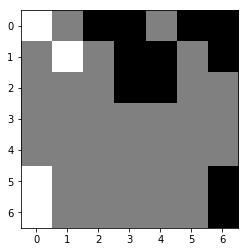

((1, 1), (1, 2)): n_v:  2019 q_all:-0.046449 q:-0.007786 q_m:+0.066667 p:0.825337
((0, 0), (1, 2)): n_v:   284 q_all:-0.053134 q:-0.016269 q_m:+0.033333 p:0.123911
((1, 1), (2, 2)): n_v:    10 q_all:-0.170730 q:-0.124591 q_m:-0.066667 p:0.009449
((6, 0), (5, 2)): n_v:     7 q_all:-0.233051 q:-0.144531 q_m:-0.233333 p:0.007897
((0, 0), (0, 1)): n_v:     4 q_all:-0.142307 q:-0.131514 q_m:-0.133333 p:0.003793
((5, 0), (5, 1)): n_v:     3 q_all:-0.200629 q:-0.137075 q_m:-0.200000 p:0.003804
((1, 1), (2, 1)): n_v:     1 q_all:-0.131922 q:-0.179478 q_m:-0.200000 p:0.001289
((5, 0), (5, 2)): n_v:     1 q_all:-0.220144 q:-0.154083 q_m:-0.233333 p:0.002055
((5, 0), (6, 1)): n_v:     1 q_all:-0.193523 q:-0.144536 q_m:-0.200000 p:0.001258
((1, 1), (2, 0)): n_v:     0 q_all:-0.141046 q:-0.141046 q_m:-0.200000 p:0.000406
((5, 0), (4, 2)): n_v:     0 q_all:-0.166757 q:-0.166757 q_m:-0.233333 p:0.000009
((5, 0), (3, 2)): n_v:     0 q_all:-0.141071 q:-0.141071 q_m:-0.166667 p:0.000229
((1, 1), (3, 0))

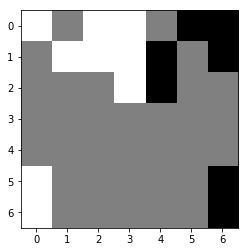

((1, 4), (2, 2)): n_v:  2847 q_all:+0.029228 q:+0.032028 q_m:+0.200000 p:0.732188
((2, 4), (2, 2)): n_v:   726 q_all:+0.026202 q:+0.033515 q_m:+0.200000 p:0.193664
((0, 5), (0, 4)): n_v:    57 q_all:-0.122315 q:-0.023145 q_m:+0.100000 p:0.042926
((2, 4), (0, 4)): n_v:     4 q_all:-0.098665 q:-0.045295 q_m:+0.066667 p:0.003159
((2, 4), (4, 2)): n_v:     3 q_all:-0.204027 q:-0.088321 q_m:-0.066667 p:0.003589
((0, 6), (0, 4)): n_v:     1 q_all:-0.082745 q:-0.049925 q_m:+0.066667 p:0.000526
((2, 4), (3, 3)): n_v:     1 q_all:-0.028419 q:-0.028006 q_m:+0.033333 p:0.000656
((1, 6), (0, 4)): n_v:     0 q_all:-0.054197 q:-0.054197 q_m:+0.066667 p:0.000273
((5, 6), (5, 4)): n_v:     0 q_all:-0.114031 q:-0.114031 q_m:-0.066667 p:0.000000
((0, 5), (2, 6)): n_v:     0 q_all:-0.129150 q:-0.129150 q_m:-0.066667 p:0.000001
((6, 6), (6, 4)): n_v:     0 q_all:-0.134688 q:-0.134688 q_m:-0.066667 p:0.000030
((5, 6), (3, 6)): n_v:     0 q_all:-0.145131 q:-0.145131 q_m:-0.066667 p:0.000001
((1, 6), (3, 5))

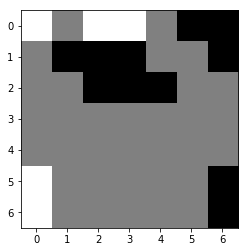

((0, 3), (1, 4)): n_v:  1859 q_all:-0.003001 q:-0.030076 q_m:+0.100000 p:0.264522
((0, 0), (2, 1)): n_v:   771 q_all:-0.064591 q:-0.058330 q_m:-0.000000 p:0.250044
((0, 3), (1, 5)): n_v:   500 q_all:+0.021228 q:-0.012112 q_m:+0.066667 p:0.035501
((0, 2), (1, 4)): n_v:   396 q_all:-0.013113 q:-0.063910 q_m:+0.066667 p:0.068236
((0, 3), (2, 5)): n_v:   253 q_all:-0.060318 q:-0.090292 q_m:-0.066667 p:0.078755
((0, 3), (2, 1)): n_v:   148 q_all:-0.109883 q:-0.118758 q_m:-0.000000 p:0.067959
((0, 0), (0, 1)): n_v:   110 q_all:-0.077152 q:-0.082670 q_m:-0.033333 p:0.039997
((5, 0), (4, 1)): n_v:   105 q_all:-0.135503 q:-0.154238 q_m:-0.166667 p:0.056262
((0, 2), (2, 1)): n_v:    98 q_all:-0.070464 q:-0.111897 q_m:-0.000000 p:0.033450
((6, 0), (4, 1)): n_v:    35 q_all:-0.163636 q:-0.189279 q_m:-0.200000 p:0.021970
((5, 0), (6, 1)): n_v:    14 q_all:-0.135820 q:-0.166659 q_m:-0.166667 p:0.007832
((0, 3), (0, 4)): n_v:    10 q_all:-0.146248 q:-0.130971 q_m:-0.033333 p:0.006117
((0, 0), (1, 0))

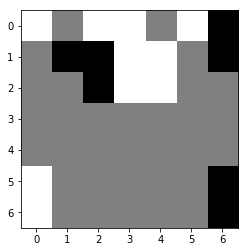

((1, 1), (0, 1)): n_v:  1499 q_all:+0.047874 q:+0.016282 q_m:+0.066667 p:0.037978
((0, 6), (1, 5)): n_v:   856 q_all:-0.023809 q:-0.065986 q_m:+0.133333 p:0.225429
((0, 6), (0, 4)): n_v:   262 q_all:-0.027808 q:+0.002178 q_m:+0.166667 p:0.072470
((2, 2), (0, 4)): n_v:   205 q_all:-0.037387 q:+0.005567 q_m:+0.166667 p:0.063531
((5, 6), (5, 5)): n_v:   158 q_all:-0.092718 q:-0.131999 q_m:-0.066667 p:0.077892
((1, 6), (0, 4)): n_v:   109 q_all:-0.029646 q:-0.000071 q_m:+0.166667 p:0.030762
((2, 2), (3, 3)): n_v:    40 q_all:-0.030042 q:-0.045893 q_m:+0.066667 p:0.011616
((2, 2), (0, 1)): n_v:    27 q_all:+0.041187 q:-0.017681 q_m:+0.033333 p:0.001194
((6, 6), (6, 4)): n_v:    13 q_all:-0.104051 q:-0.158230 q_m:-0.100000 p:0.007325
((5, 6), (6, 5)): n_v:     7 q_all:-0.072189 q:-0.143325 q_m:-0.066667 p:0.003189
((1, 2), (0, 4)): n_v:     6 q_all:-0.040962 q:-0.008784 q_m:+0.166667 p:0.001863
((1, 1), (1, 0)): n_v:     2 q_all:-0.100010 q:-0.068555 q_m:-0.000000 p:0.001301
((1, 6), (2, 5))

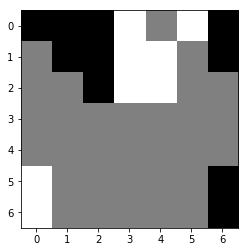

((0, 3), (2, 1)): n_v:   919 q_all:-0.013918 q:-0.031916 q_m:+0.133333 p:0.005347
((0, 3), (1, 5)): n_v:   744 q_all:-0.038671 q:-0.065096 q_m:+0.066667 p:0.068958
((2, 3), (1, 5)): n_v:   584 q_all:-0.116483 q:-0.081109 q_m:+0.066667 p:0.213311
((0, 5), (1, 5)): n_v:   495 q_all:-0.088075 q:-0.039945 q_m:+0.100000 p:0.131751
((1, 3), (1, 5)): n_v:   186 q_all:-0.065555 q:-0.091901 q_m:+0.066667 p:0.034901
((2, 3), (2, 1)): n_v:   117 q_all:-0.017888 q:-0.063327 q_m:+0.133333 p:0.002037
((1, 4), (2, 5)): n_v:    40 q_all:-0.066134 q:-0.060660 q_m:+0.033333 p:0.007573
((5, 0), (5, 1)): n_v:    24 q_all:-0.077540 q:-0.142272 q_m:-0.033333 p:0.005444
((0, 3), (2, 5)): n_v:    13 q_all:-0.086317 q:-0.074848 q_m:-0.000000 p:0.003543
((2, 3), (4, 1)): n_v:     9 q_all:-0.088192 q:-0.194571 q_m:-0.066667 p:0.002420
((5, 0), (4, 1)): n_v:     8 q_all:-0.108677 q:-0.153958 q_m:-0.033333 p:0.002740
((1, 3), (2, 1)): n_v:     5 q_all:-0.083596 q:-0.047842 q_m:+0.133333 p:0.001364
((2, 3), (0, 4))

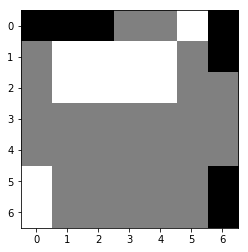

((0, 6), (1, 5)): n_v:  1799 q_all:+0.004397 q:-0.006995 q_m:+0.100000 p:0.389210
((0, 2), (0, 3)): n_v:   421 q_all:-0.000795 q:-0.031871 q_m:+0.100000 p:0.099675
((0, 0), (1, 0)): n_v:   392 q_all:+0.036125 q:-0.022722 q_m:+0.033333 p:0.036606
((5, 6), (5, 5)): n_v:    28 q_all:-0.098970 q:-0.117922 q_m:-0.100000 p:0.017717
((1, 6), (3, 4)): n_v:    10 q_all:-0.046710 q:-0.020636 q_m:-0.000000 p:0.004539
((0, 2), (1, 0)): n_v:     8 q_all:-0.018347 q:-0.065340 q_m:-0.000000 p:0.002653
((0, 0), (2, 0)): n_v:     5 q_all:-0.054655 q:-0.057529 q_m:-0.000000 p:0.002302
((0, 1), (0, 3)): n_v:     3 q_all:-0.065396 q:-0.090239 q_m:+0.066667 p:0.001562
((5, 6), (3, 4)): n_v:     3 q_all:-0.068520 q:-0.042838 q_m:-0.000000 p:0.001790
((1, 6), (2, 6)): n_v:     2 q_all:-0.138672 q:-0.116090 q_m:-0.100000 p:0.001446
((0, 6), (2, 5)): n_v:     2 q_all:-0.107713 q:-0.081206 q_m:-0.000000 p:0.001114
((1, 6), (2, 5)): n_v:     1 q_all:-0.072562 q:-0.057702 q_m:+0.033333 p:0.000999
((0, 6), (2, 6))

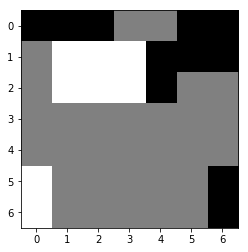

((1, 1), (1, 0)): n_v:  1484 q_all:+0.007470 q:+0.013598 q_m:+0.066667 p:0.240790
((1, 3), (0, 4)): n_v:   782 q_all:-0.038779 q:-0.046368 q_m:+0.133333 p:0.248230
((2, 3), (0, 4)): n_v:   254 q_all:-0.023221 q:-0.066330 q_m:+0.100000 p:0.067490
((2, 3), (2, 5)): n_v:   233 q_all:-0.003487 q:-0.042452 q_m:+0.166667 p:0.046482
((2, 2), (0, 4)): n_v:   186 q_all:-0.061723 q:-0.104643 q_m:+0.100000 p:0.073129
((2, 2), (1, 0)): n_v:   132 q_all:-0.097373 q:-0.067899 q_m:+0.033333 p:0.068004
((1, 3), (2, 5)): n_v:    62 q_all:-0.035097 q:-0.016162 q_m:+0.166667 p:0.019059
((1, 2), (0, 3)): n_v:    41 q_all:-0.076026 q:-0.051215 q_m:+0.066667 p:0.018296
((1, 2), (0, 4)): n_v:    38 q_all:-0.079655 q:-0.087527 q_m:+0.100000 p:0.017224
((2, 3), (4, 5)): n_v:    16 q_all:-0.074340 q:-0.068019 q_m:-0.033333 p:0.007171
((5, 0), (4, 1)): n_v:    10 q_all:-0.127554 q:-0.138438 q_m:-0.066667 p:0.006716
((2, 3), (4, 1)): n_v:     7 q_all:-0.145099 q:-0.154083 q_m:-0.100000 p:0.004699
((2, 2), (0, 3))

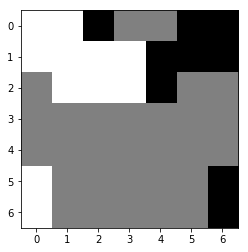

((2, 4), (3, 2)): n_v:  2231 q_all:+0.016092 q:+0.000887 q_m:+0.133333 p:0.250483
((0, 2), (0, 3)): n_v:   502 q_all:-0.103522 q:-0.069766 q_m:+0.100000 p:0.267283
((0, 2), (2, 0)): n_v:   185 q_all:+0.030130 q:+0.021122 q_m:+0.133333 p:0.011450
((1, 4), (3, 2)): n_v:    56 q_all:-0.010917 q:-0.010643 q_m:+0.133333 p:0.011606
((2, 4), (0, 3)): n_v:    46 q_all:-0.117609 q:-0.072327 q_m:+0.066667 p:0.027235
((2, 4), (3, 4)): n_v:    32 q_all:-0.041938 q:-0.033951 q_m:+0.033333 p:0.010373
((2, 4), (3, 3)): n_v:    28 q_all:-0.032125 q:+0.007084 q_m:+0.100000 p:0.007782
((2, 4), (4, 2)): n_v:     7 q_all:-0.072026 q:-0.043429 q_m:-0.066667 p:0.003100
((0, 2), (0, 4)): n_v:     6 q_all:-0.056127 q:-0.100474 q_m:-0.000000 p:0.002408
((1, 5), (0, 3)): n_v:     5 q_all:-0.098706 q:-0.037039 q_m:+0.066667 p:0.002476
((0, 5), (0, 3)): n_v:     5 q_all:-0.072996 q:-0.058092 q_m:+0.066667 p:0.002305
((1, 5), (2, 6)): n_v:     4 q_all:-0.109843 q:-0.093255 q_m:-0.033333 p:0.002573
((1, 5), (3, 3))

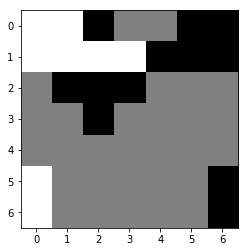

((1, 0), (3, 1)): n_v:  1501 q_all:-0.047756 q:-0.017875 q_m:+0.066667 p:0.464758
((5, 0), (3, 1)): n_v:   750 q_all:-0.030313 q:+0.001828 q_m:+0.066667 p:0.190785
((1, 3), (2, 4)): n_v:   682 q_all:+0.002579 q:-0.067106 q_m:+0.100000 p:0.102510
((1, 3), (3, 1)): n_v:   292 q_all:+0.001150 q:-0.024171 q_m:+0.066667 p:0.045069
((1, 3), (0, 4)): n_v:   131 q_all:-0.022491 q:-0.039972 q_m:+0.100000 p:0.030281
((1, 3), (3, 5)): n_v:    79 q_all:-0.061303 q:-0.091936 q_m:-0.133333 p:0.027917
((1, 1), (3, 3)): n_v:    57 q_all:-0.149036 q:-0.127273 q_m:+0.066667 p:0.036114
((1, 2), (0, 3)): n_v:    54 q_all:-0.031247 q:-0.063624 q_m:+0.033333 p:0.013750
((1, 3), (3, 3)): n_v:    38 q_all:-0.030342 q:-0.032461 q_m:+0.066667 p:0.009776
((1, 2), (0, 4)): n_v:    33 q_all:+0.039493 q:-0.086927 q_m:+0.066667 p:0.000997
((1, 2), (3, 1)): n_v:    32 q_all:-0.110343 q:-0.103153 q_m:+0.066667 p:0.016736
((1, 1), (3, 1)): n_v:    29 q_all:-0.155876 q:-0.109452 q_m:+0.066667 p:0.019534
((5, 0), (4, 1))

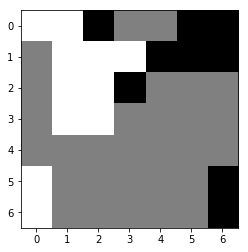

((0, 2), (1, 0)): n_v:  1325 q_all:+0.085658 q:+0.096329 q_m:+0.200000 p:0.178529
((2, 3), (4, 1)): n_v:   633 q_all:+0.092868 q:+0.059734 q_m:+0.133333 p:0.069878
((0, 2), (0, 3)): n_v:   373 q_all:-0.033854 q:+0.001858 q_m:+0.100000 p:0.210152
((2, 3), (3, 3)): n_v:   213 q_all:+0.034904 q:+0.026115 q_m:+0.100000 p:0.067655
((1, 5), (3, 3)): n_v:    32 q_all:+0.019961 q:+0.020761 q_m:+0.066667 p:0.012021
((0, 2), (2, 0)): n_v:    30 q_all:+0.046244 q:+0.022195 q_m:+0.133333 p:0.008370
((2, 3), (3, 5)): n_v:    26 q_all:-0.056729 q:-0.052187 q_m:-0.066667 p:0.017394
((0, 2), (2, 4)): n_v:    25 q_all:-0.023019 q:-0.060340 q_m:-0.000000 p:0.013374
((1, 5), (0, 3)): n_v:    23 q_all:+0.030076 q:+0.044710 q_m:+0.066667 p:0.007986
((2, 3), (4, 5)): n_v:    22 q_all:-0.054143 q:-0.038135 q_m:-0.066667 p:0.013936
((2, 3), (4, 2)): n_v:    17 q_all:+0.006412 q:+0.026400 q_m:+0.066667 p:0.007345
((0, 5), (0, 3)): n_v:    16 q_all:-0.008466 q:-0.017384 q_m:+0.066667 p:0.007801
((0, 2), (0, 4))

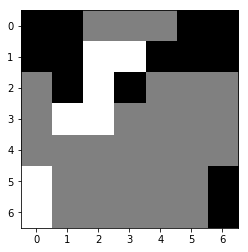

((3, 1), (2, 0)): n_v:   689 q_all:-0.063888 q:-0.060247 q_m:+0.033333 p:0.144131
((1, 2), (0, 2)): n_v:   622 q_all:-0.115695 q:-0.129012 q_m:-0.033333 p:0.246605
((1, 3), (0, 4)): n_v:   563 q_all:-0.058457 q:-0.091143 q_m:+0.033333 p:0.106759
((3, 2), (2, 0)): n_v:   441 q_all:-0.085537 q:-0.095241 q_m:-0.000000 p:0.126615
((1, 2), (2, 0)): n_v:   196 q_all:-0.105800 q:-0.098712 q_m:-0.000000 p:0.070949
((2, 2), (0, 4)): n_v:   127 q_all:-0.085397 q:-0.084532 q_m:-0.000000 p:0.036542
((1, 2), (0, 4)): n_v:    91 q_all:-0.059057 q:-0.098705 q_m:-0.000000 p:0.017506
((3, 1), (4, 0)): n_v:    31 q_all:-0.190486 q:-0.160463 q_m:-0.166667 p:0.020951
((1, 3), (2, 4)): n_v:    24 q_all:-0.077598 q:-0.075432 q_m:+0.033333 p:0.006448
((3, 2), (4, 0)): n_v:    16 q_all:-0.171277 q:-0.165474 q_m:-0.200000 p:0.009896
((2, 2), (0, 2)): n_v:    16 q_all:-0.223013 q:-0.148972 q_m:-0.066667 p:0.013179
((2, 2), (2, 0)): n_v:    12 q_all:-0.188198 q:-0.094155 q_m:-0.000000 p:0.008001
((2, 2), (2, 4))

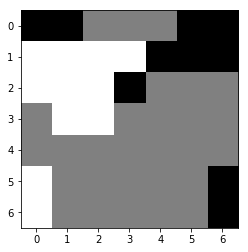

((2, 3), (0, 2)): n_v:  1305 q_all:+0.051650 q:+0.066718 q_m:+0.166667 p:0.545862
((1, 4), (0, 2)): n_v:   279 q_all:+0.057327 q:+0.096603 q_m:+0.166667 p:0.110368
((0, 1), (0, 2)): n_v:   178 q_all:+0.069590 q:+0.073567 q_m:+0.200000 p:0.061436
((2, 3), (0, 4)): n_v:   172 q_all:-0.000691 q:-0.014502 q_m:+0.033333 p:0.109567
((2, 3), (4, 1)): n_v:   104 q_all:+0.122535 q:+0.128771 q_m:+0.166667 p:0.012758
((2, 3), (3, 3)): n_v:    93 q_all:+0.048311 q:+0.083083 q_m:+0.133333 p:0.040056
((0, 5), (0, 4)): n_v:    44 q_all:+0.013331 q:-0.022247 q_m:+0.066667 p:0.025548
((2, 3), (4, 2)): n_v:    12 q_all:+0.047879 q:+0.099501 q_m:+0.100000 p:0.005525
((2, 3), (3, 5)): n_v:    10 q_all:-0.046331 q:-0.008410 q_m:-0.033333 p:0.008692
((1, 5), (3, 3)): n_v:     7 q_all:+0.009469 q:+0.072356 q_m:+0.100000 p:0.004788
((1, 4), (3, 3)): n_v:     7 q_all:+0.043974 q:+0.076636 q_m:+0.100000 p:0.003060
((2, 3), (4, 5)): n_v:     6 q_all:-0.054177 q:+0.008108 q_m:-0.033333 p:0.005464
((2, 3), (4, 4))

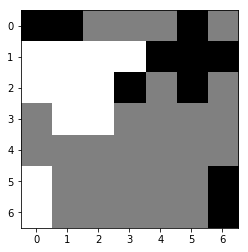

((1, 3), (2, 4)): n_v:  1141 q_all:+0.121253 q:+0.151468 q_m:+0.333333 p:0.438650
((1, 3), (0, 4)): n_v:   193 q_all:+0.133264 q:+0.046117 q_m:+0.266667 p:0.063074
((2, 2), (2, 4)): n_v:   163 q_all:+0.008470 q:+0.074233 q_m:+0.300000 p:0.151070
((3, 2), (2, 4)): n_v:    95 q_all:+0.086563 q:+0.127921 q_m:+0.300000 p:0.052633
((1, 2), (2, 4)): n_v:    57 q_all:+0.049498 q:+0.095641 q_m:+0.300000 p:0.041165
((1, 1), (0, 2)): n_v:    51 q_all:+0.028728 q:+0.096837 q_m:+0.133333 p:0.042777
((2, 2), (0, 4)): n_v:    19 q_all:-0.003310 q:-0.001756 q_m:+0.233333 p:0.019268
((1, 2), (0, 4)): n_v:     8 q_all:+0.064240 q:+0.028544 q_m:+0.233333 p:0.005760
((2, 0), (0, 2)): n_v:     8 q_all:+0.001018 q:+0.032125 q_m:+0.100000 p:0.008556
((3, 1), (4, 2)): n_v:     7 q_all:-0.027774 q:-0.038845 q_m:+0.066667 p:0.007767
((2, 1), (0, 2)): n_v:     7 q_all:-0.091218 q:-0.015760 q_m:+0.100000 p:0.010261
((2, 2), (4, 4)): n_v:     5 q_all:-0.087217 q:-0.029582 q_m:+0.033333 p:0.007004
((3, 2), (4, 4))

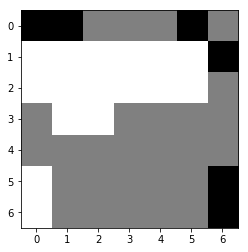

((0, 5), (0, 4)): n_v:  1443 q_all:-0.101496 q:-0.135433 q_m:-0.100000 p:0.446034
((0, 1), (0, 2)): n_v:  1269 q_all:-0.112615 q:-0.167503 q_m:-0.100000 p:0.444867
((0, 0), (0, 2)): n_v:   121 q_all:-0.155183 q:-0.215466 q_m:-0.133333 p:0.061777
((1, 6), (2, 6)): n_v:    17 q_all:-0.134397 q:-0.102351 q_m:-0.166667 p:0.007539
((1, 6), (0, 4)): n_v:    13 q_all:-0.106945 q:-0.168797 q_m:-0.133333 p:0.004418
((1, 6), (3, 4)): n_v:    12 q_all:-0.166203 q:-0.109056 q_m:-0.133333 p:0.006758
((5, 6), (3, 4)): n_v:    12 q_all:-0.157812 q:-0.092658 q_m:-0.133333 p:0.006536
((5, 6), (3, 5)): n_v:     5 q_all:-0.238644 q:-0.147874 q_m:-0.200000 p:0.004676
((0, 5), (0, 6)): n_v:     4 q_all:-0.170701 q:-0.199136 q_m:-0.233333 p:0.002535
((1, 6), (3, 5)): n_v:     2 q_all:-0.231962 q:-0.165686 q_m:-0.200000 p:0.002281
((6, 6), (6, 4)): n_v:     1 q_all:-0.252228 q:-0.231679 q_m:-0.333333 p:0.000929
((5, 6), (4, 6)): n_v:     1 q_all:-0.263397 q:-0.198333 q_m:-0.300000 p:0.001744
((5, 6), (4, 5))

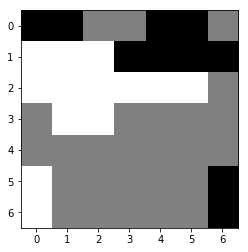

((1, 2), (0, 3)): n_v:   643 q_all:+0.089213 q:+0.159401 q_m:+0.333333 p:0.202397
((2, 4), (0, 6)): n_v:   548 q_all:+0.138670 q:+0.108571 q_m:+0.300000 p:0.076445
((2, 5), (0, 6)): n_v:   518 q_all:+0.149930 q:+0.097762 q_m:+0.300000 p:0.051652
((2, 2), (0, 3)): n_v:   339 q_all:+0.051070 q:+0.077193 q_m:+0.300000 p:0.152501
((2, 4), (0, 3)): n_v:   339 q_all:+0.072108 q:+0.113560 q_m:+0.300000 p:0.126761
((2, 5), (0, 3)): n_v:   316 q_all:+0.067625 q:+0.099298 q_m:+0.300000 p:0.123335
((2, 1), (0, 3)): n_v:   206 q_all:-0.010678 q:+0.045153 q_m:+0.300000 p:0.137561
((2, 3), (0, 3)): n_v:   132 q_all:+0.054766 q:+0.074509 q_m:+0.300000 p:0.057736
((1, 1), (0, 3)): n_v:    75 q_all:+0.059705 q:+0.081695 q_m:+0.300000 p:0.031520
((2, 4), (0, 2)): n_v:    31 q_all:+0.103017 q:+0.145096 q_m:+0.233333 p:0.008454
((2, 1), (0, 2)): n_v:    15 q_all:-0.011976 q:+0.084428 q_m:+0.233333 p:0.010674
((2, 5), (2, 6)): n_v:    11 q_all:+0.093241 q:+0.091402 q_m:+0.266667 p:0.003461
((2, 0), (0, 2))

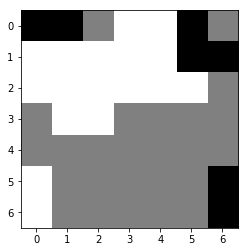

((0, 1), (0, 2)): n_v:  2014 q_all:-0.102726 q:-0.080731 q_m:-0.033333 p:0.901419
((0, 0), (0, 2)): n_v:   215 q_all:-0.093692 q:-0.132387 q_m:-0.066667 p:0.088579
((1, 5), (3, 3)): n_v:    20 q_all:-0.067425 q:-0.110836 q_m:-0.066667 p:0.006200
((5, 6), (5, 4)): n_v:     0 q_all:-0.276754 q:-0.276754 q_m:-0.333333 p:0.000025
((0, 5), (2, 6)): n_v:     0 q_all:-0.261148 q:-0.261148 q_m:-0.266667 p:0.000004
((6, 6), (6, 4)): n_v:     0 q_all:-0.281090 q:-0.281090 q_m:-0.333333 p:0.000652
((5, 6), (3, 6)): n_v:     0 q_all:-0.242958 q:-0.242958 q_m:-0.266667 p:0.000009
((1, 6), (3, 5)): n_v:     0 q_all:-0.232852 q:-0.232852 q_m:-0.200000 p:0.000043
((5, 6), (5, 5)): n_v:     0 q_all:-0.263204 q:-0.263204 q_m:-0.300000 p:0.000023
((5, 6), (6, 5)): n_v:     0 q_all:-0.268922 q:-0.268922 q_m:-0.300000 p:0.000006
((1, 6), (3, 4)): n_v:     0 q_all:-0.163039 q:-0.163039 q_m:-0.133333 p:0.000366
((1, 5), (3, 6)): n_v:     0 q_all:-0.269003 q:-0.269003 q_m:-0.266667 p:0.000003
((1, 5), (2, 6))

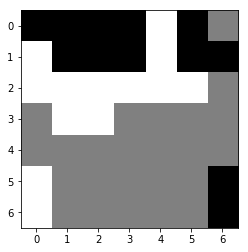

((2, 5), (0, 6)): n_v:  2332 q_all:+0.113894 q:+0.047224 q_m:+0.233333 p:0.367289
((2, 4), (0, 6)): n_v:  1097 q_all:+0.016344 q:+0.056907 q_m:+0.233333 p:0.521696
((2, 5), (2, 6)): n_v:   120 q_all:+0.001712 q:+0.048757 q_m:+0.200000 p:0.062998
((0, 4), (2, 6)): n_v:    32 q_all:+0.006928 q:+0.037045 q_m:+0.166667 p:0.016652
((0, 4), (0, 6)): n_v:    11 q_all:-0.013936 q:+0.030244 q_m:+0.233333 p:0.006785
((3, 1), (4, 0)): n_v:     2 q_all:-0.032273 q:-0.050047 q_m:+0.066667 p:0.001704
((3, 2), (5, 1)): n_v:     2 q_all:-0.082534 q:-0.074985 q_m:+0.033333 p:0.001605
((1, 4), (0, 6)): n_v:     2 q_all:-0.097635 q:+0.001084 q_m:+0.233333 p:0.002428
((2, 4), (2, 6)): n_v:     2 q_all:-0.023379 q:+0.021834 q_m:+0.166667 p:0.001443
((5, 0), (5, 1)): n_v:     1 q_all:-0.035577 q:-0.022157 q_m:+0.066667 p:0.000667
((3, 2), (4, 0)): n_v:     1 q_all:-0.094714 q:-0.072250 q_m:+0.033333 p:0.001252
((3, 1), (5, 1)): n_v:     1 q_all:-0.068649 q:-0.072207 q_m:+0.033333 p:0.001020
((1, 4), (2, 6))

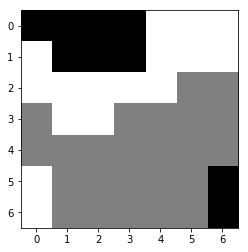

((0, 3), (2, 5)): n_v:  1631 q_all:-0.154766 q:-0.139339 q_m:+0.033333 p:0.461410
((5, 6), (4, 5)): n_v:  1480 q_all:-0.117994 q:-0.226128 q_m:-0.200000 p:0.248251
((1, 3), (2, 5)): n_v:   243 q_all:-0.170516 q:-0.139611 q_m:+0.033333 p:0.080889
((1, 1), (3, 3)): n_v:   230 q_all:-0.201206 q:-0.133073 q_m:+0.033333 p:0.098816
((6, 6), (4, 5)): n_v:   228 q_all:-0.129594 q:-0.240695 q_m:-0.233333 p:0.046486
((5, 6), (3, 5)): n_v:    85 q_all:-0.169520 q:-0.176648 q_m:-0.166667 p:0.027743
((5, 6), (3, 4)): n_v:    25 q_all:-0.158817 q:-0.169023 q_m:-0.100000 p:0.007424
((5, 6), (3, 6)): n_v:    21 q_all:-0.182377 q:-0.271933 q_m:-0.233333 p:0.007521
((5, 6), (4, 6)): n_v:    14 q_all:-0.113409 q:-0.231960 q_m:-0.200000 p:0.002176
((1, 3), (3, 3)): n_v:    13 q_all:-0.206700 q:-0.148187 q_m:+0.033333 p:0.006178
((1, 2), (3, 3)): n_v:    11 q_all:-0.252563 q:-0.154966 q_m:+0.033333 p:0.006563
((5, 6), (6, 5)): n_v:     3 q_all:-0.146911 q:-0.272165 q_m:-0.200000 p:0.000982
((1, 2), (3, 0))

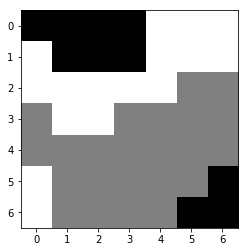

((3, 2), (5, 1)): n_v:   401 q_all:+0.091583 q:+0.016537 q_m:+0.200000 p:0.254752
((3, 1), (5, 1)): n_v:   383 q_all:+0.124730 q:+0.018721 q_m:+0.200000 p:0.180004
((3, 2), (4, 3)): n_v:   243 q_all:+0.198476 q:+0.022325 q_m:+0.233333 p:0.024256
((5, 0), (5, 1)): n_v:   187 q_all:+0.146949 q:+0.061307 q_m:+0.233333 p:0.067228
((5, 0), (6, 1)): n_v:    60 q_all:+0.143755 q:+0.066950 q_m:+0.233333 p:0.023209
((1, 4), (2, 5)): n_v:    37 q_all:+0.147599 q:+0.067537 q_m:+0.233333 p:0.013480
((2, 4), (3, 5)): n_v:    36 q_all:+0.104156 q:+0.045620 q_m:+0.233333 p:0.021141
((3, 1), (4, 2)): n_v:    29 q_all:+0.148000 q:+0.044744 q_m:+0.233333 p:0.009929
((3, 2), (5, 4)): n_v:    29 q_all:+0.160674 q:+0.083957 q_m:+0.266667 p:0.008562
((2, 0), (3, 0)): n_v:    28 q_all:+0.120076 q:+0.066131 q_m:+0.233333 p:0.014212
((1, 5), (2, 6)): n_v:    23 q_all:+0.133540 q:+0.082605 q_m:+0.233333 p:0.010113
((2, 2), (3, 3)): n_v:    21 q_all:+0.085722 q:+0.069234 q_m:+0.233333 p:0.013822
((2, 3), (3, 4))

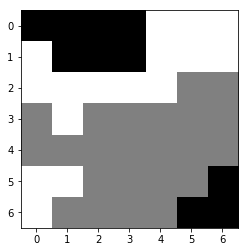

((0, 3), (2, 5)): n_v:  1359 q_all:-0.089977 q:-0.096311 q_m:+0.066667 p:0.584192
((5, 6), (4, 5)): n_v:   456 q_all:-0.082954 q:-0.203224 q_m:-0.166667 p:0.182247
((1, 3), (2, 5)): n_v:   133 q_all:-0.196408 q:-0.108918 q_m:+0.066667 p:0.118562
((6, 6), (4, 5)): n_v:   131 q_all:-0.091686 q:-0.210733 q_m:-0.200000 p:0.057662
((5, 6), (3, 4)): n_v:    54 q_all:-0.100430 q:-0.116956 q_m:-0.066667 p:0.025891
((6, 5), (4, 5)): n_v:    10 q_all:-0.130757 q:-0.202303 q_m:-0.200000 p:0.006402
((1, 2), (3, 4)): n_v:     5 q_all:-0.320432 q:-0.225265 q_m:-0.066667 p:0.007270
((1, 1), (3, 2)): n_v:     4 q_all:-0.224878 q:-0.056290 q_m:+0.066667 p:0.004384
((1, 3), (3, 2)): n_v:     2 q_all:-0.145685 q:-0.073135 q_m:+0.066667 p:0.001453
((5, 6), (3, 6)): n_v:     2 q_all:-0.188144 q:-0.197494 q_m:-0.200000 p:0.001629
((5, 6), (4, 6)): n_v:     2 q_all:-0.160581 q:-0.207594 q_m:-0.166667 p:0.001714
((1, 1), (3, 3)): n_v:     2 q_all:-0.225101 q:-0.137137 q_m:-0.000000 p:0.002452
((1, 3), (3, 4))

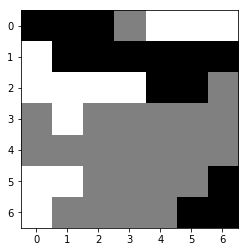

((0, 4), (0, 3)): n_v:  3040 q_all:+0.098112 q:+0.112383 q_m:+0.233333 p:0.961088
((2, 2), (0, 3)): n_v:    53 q_all:+0.071525 q:+0.082599 q_m:+0.200000 p:0.022057
((2, 1), (0, 3)): n_v:    12 q_all:-0.034230 q:+0.052315 q_m:+0.200000 p:0.009842
((2, 3), (0, 3)): n_v:     7 q_all:+0.051073 q:+0.067575 q_m:+0.200000 p:0.003352
((0, 5), (0, 3)): n_v:     4 q_all:+0.048528 q:+0.014437 q_m:+0.200000 p:0.002137
((0, 4), (2, 6)): n_v:     1 q_all:+0.065217 q:+0.025056 q_m:+0.133333 p:0.000684
((5, 0), (3, 2)): n_v:     0 q_all:-0.041746 q:-0.041746 q_m:-0.066667 p:0.000000
((2, 3), (4, 2)): n_v:     0 q_all:-0.057025 q:-0.057025 q_m:-0.066667 p:0.000001
((0, 5), (2, 6)): n_v:     0 q_all:+0.000814 q:+0.000814 q_m:+0.133333 p:0.000025
((3, 1), (4, 0)): n_v:     0 q_all:-0.093450 q:-0.093450 q_m:-0.033333 p:0.000003
((6, 0), (6, 2)): n_v:     0 q_all:-0.067062 q:-0.067062 q_m:-0.066667 p:0.000000
((3, 1), (5, 2)): n_v:     0 q_all:-0.054012 q:-0.054012 q_m:-0.066667 p:0.000000
((1, 0), (3, 2))

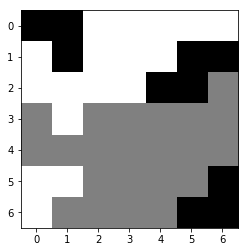

((2, 4), (3, 2)): n_v:  4351 q_all:-0.103387 q:-0.076437 q_m:+0.033333 p:0.785126
((2, 4), (3, 4)): n_v:   127 q_all:-0.228060 q:-0.230602 q_m:-0.133333 p:0.068801
((1, 6), (3, 4)): n_v:    26 q_all:-0.244725 q:-0.274940 q_m:-0.166667 p:0.015838
((5, 6), (3, 4)): n_v:    24 q_all:-0.257404 q:-0.237602 q_m:-0.166667 p:0.015572
((1, 1), (3, 2)): n_v:    17 q_all:-0.207304 q:-0.123745 q_m:+0.033333 p:0.008188
((1, 5), (3, 4)): n_v:    13 q_all:-0.236917 q:-0.245360 q_m:-0.166667 p:0.007618
((2, 4), (3, 3)): n_v:     9 q_all:-0.203987 q:-0.211002 q_m:-0.066667 p:0.004523
((2, 4), (4, 2)): n_v:     6 q_all:-0.168317 q:-0.136839 q_m:-0.100000 p:0.002329
((2, 5), (3, 3)): n_v:     3 q_all:-0.204641 q:-0.226887 q_m:-0.100000 p:0.001882
((1, 5), (2, 6)): n_v:     2 q_all:-0.254154 q:-0.242098 q_m:-0.200000 p:0.001839
((5, 6), (4, 5)): n_v:     2 q_all:-0.278416 q:-0.257023 q_m:-0.200000 p:0.002024
((5, 6), (3, 6)): n_v:     1 q_all:-0.341730 q:-0.269545 q_m:-0.233333 p:0.001086
((1, 5), (3, 6))

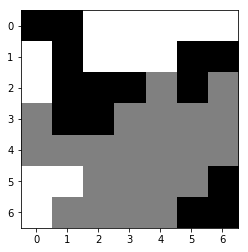

((1, 3), (2, 4)): n_v:  4613 q_all:+0.132936 q:+0.105536 q_m:+0.200000 p:0.369470
((0, 6), (2, 4)): n_v:   160 q_all:+0.086681 q:+0.069980 q_m:+0.166667 p:0.031815
((5, 1), (4, 2)): n_v:    84 q_all:+0.027706 q:+0.032029 q_m:+0.133333 p:0.029428
((5, 1), (3, 3)): n_v:    48 q_all:+0.068986 q:+0.079024 q_m:+0.166667 p:0.011667
((2, 0), (3, 0)): n_v:    44 q_all:+0.096134 q:+0.065083 q_m:+0.133333 p:0.007714
((0, 5), (2, 4)): n_v:    38 q_all:-0.001315 q:+0.020983 q_m:+0.166667 p:0.016044
((0, 3), (2, 4)): n_v:    29 q_all:+0.034046 q:+0.021524 q_m:+0.166667 p:0.009976
((5, 0), (4, 1)): n_v:    11 q_all:+0.128849 q:+0.053876 q_m:+0.133333 p:0.000971
((5, 1), (3, 0)): n_v:     8 q_all:+0.072732 q:+0.052036 q_m:+0.100000 p:0.001939
((0, 2), (2, 4)): n_v:     8 q_all:+0.008082 q:+0.019785 q_m:+0.166667 p:0.003258
((6, 0), (4, 2)): n_v:     8 q_all:-0.007749 q:+0.008217 q_m:+0.100000 p:0.003824
((0, 4), (2, 4)): n_v:     6 q_all:+0.003593 q:+0.023783 q_m:+0.166667 p:0.002851
((5, 0), (3, 0))

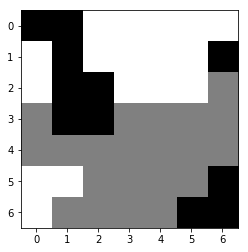

((3, 2), (3, 4)): n_v:  3722 q_all:-0.154731 q:-0.135191 q_m:-0.000000 p:0.776491
((1, 6), (2, 6)): n_v:   594 q_all:-0.081245 q:-0.140600 q_m:-0.033333 p:0.014746
((2, 2), (3, 4)): n_v:   490 q_all:-0.183155 q:-0.111517 q_m:-0.000000 p:0.136920
((2, 2), (3, 3)): n_v:    55 q_all:-0.153242 q:-0.150746 q_m:-0.033333 p:0.011337
((5, 6), (3, 4)): n_v:    31 q_all:-0.155799 q:-0.114582 q_m:-0.000000 p:0.006644
((1, 6), (3, 4)): n_v:    25 q_all:-0.138120 q:-0.118513 q_m:-0.000000 p:0.004190
((3, 1), (3, 3)): n_v:    23 q_all:-0.189224 q:-0.180861 q_m:-0.066667 p:0.006807
((3, 2), (4, 0)): n_v:     9 q_all:-0.238711 q:-0.307812 q_m:-0.066667 p:0.004022
((5, 6), (3, 5)): n_v:     9 q_all:-0.155807 q:-0.154035 q_m:-0.066667 p:0.001974
((3, 2), (4, 4)): n_v:     7 q_all:-0.223900 q:-0.235151 q_m:-0.200000 p:0.002855
((2, 2), (4, 4)): n_v:     5 q_all:-0.276080 q:-0.190920 q_m:-0.200000 p:0.002385
((5, 6), (3, 6)): n_v:     4 q_all:-0.198388 q:-0.223587 q_m:-0.133333 p:0.001421
((5, 6), (4, 6))

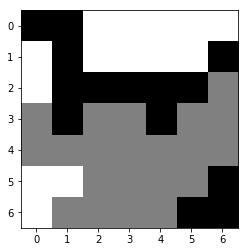

((5, 0), (3, 2)): n_v:  2032 q_all:+0.165760 q:+0.176787 q_m:+0.266667 p:0.406775
((5, 1), (3, 2)): n_v:   542 q_all:+0.168815 q:+0.174612 q_m:+0.266667 p:0.103758
((1, 0), (3, 2)): n_v:   541 q_all:+0.127345 q:+0.094748 q_m:+0.266667 p:0.164522
((5, 1), (3, 3)): n_v:   397 q_all:+0.152328 q:+0.118970 q_m:+0.266667 p:0.093731
((2, 0), (3, 0)): n_v:   266 q_all:+0.189722 q:+0.094838 q_m:+0.166667 p:0.036058
((2, 0), (3, 2)): n_v:   178 q_all:+0.143825 q:+0.131700 q_m:+0.266667 p:0.046208
((1, 5), (2, 6)): n_v:    86 q_all:+0.153537 q:+0.147813 q_m:+0.166667 p:0.020167
((5, 1), (4, 2)): n_v:    39 q_all:+0.056720 q:+0.031673 q_m:+0.100000 p:0.019509
((1, 5), (3, 3)): n_v:    34 q_all:+0.006713 q:+0.033459 q_m:+0.266667 p:0.021605
((5, 0), (3, 0)): n_v:    23 q_all:+0.172513 q:+0.101527 q_m:+0.133333 p:0.004034
((5, 0), (4, 0)): n_v:    16 q_all:+0.068466 q:+0.026444 q_m:+0.100000 p:0.007867
((1, 4), (3, 2)): n_v:    14 q_all:+0.011812 q:+0.049181 q_m:+0.266667 p:0.009159
((5, 1), (3, 0))

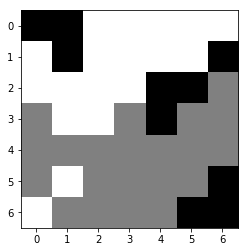

((2, 4), (3, 3)): n_v:  2791 q_all:-0.152145 q:-0.202742 q_m:-0.033333 p:0.410803
((2, 5), (3, 3)): n_v:   108 q_all:-0.198449 q:-0.211727 q_m:-0.066667 p:0.032382
((3, 4), (4, 2)): n_v:    70 q_all:-0.168288 q:-0.126306 q_m:-0.066667 p:0.014128
((2, 4), (4, 2)): n_v:    46 q_all:-0.165113 q:-0.198162 q_m:-0.066667 p:0.008730
((1, 1), (3, 3)): n_v:    34 q_all:-0.263491 q:-0.212093 q_m:-0.066667 p:0.017315
((3, 4), (2, 6)): n_v:     8 q_all:-0.267312 q:-0.272684 q_m:-0.200000 p:0.004353
((3, 4), (5, 2)): n_v:     6 q_all:-0.205930 q:-0.199120 q_m:-0.200000 p:0.001987
((1, 6), (2, 6)): n_v:     3 q_all:-0.307328 q:-0.309411 q_m:-0.166667 p:0.002279
((3, 4), (5, 3)): n_v:     2 q_all:-0.270683 q:-0.269790 q_m:-0.266667 p:0.001202
((3, 4), (5, 5)): n_v:     1 q_all:-0.324166 q:-0.316806 q_m:-0.266667 p:0.000739
((5, 6), (5, 4)): n_v:     0 q_all:-0.323803 q:-0.323803 q_m:-0.266667 p:0.000001
((6, 6), (6, 4)): n_v:     0 q_all:-0.345723 q:-0.345723 q_m:-0.266667 p:0.000002
((5, 6), (3, 6))

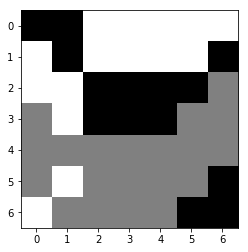

((1, 5), (2, 6)): n_v:  1191 q_all:+0.166372 q:+0.218777 q_m:+0.200000 p:0.049961
((3, 1), (4, 2)): n_v:   990 q_all:+0.103374 q:+0.095123 q_m:+0.200000 p:0.226452
((3, 1), (4, 3)): n_v:   753 q_all:+0.151080 q:+0.099387 q_m:+0.233333 p:0.065550
((5, 1), (4, 3)): n_v:   670 q_all:+0.151463 q:+0.101015 q_m:+0.233333 p:0.057853
((5, 1), (6, 2)): n_v:   116 q_all:+0.074047 q:+0.036318 q_m:+0.066667 p:0.036647
((6, 0), (4, 2)): n_v:    61 q_all:+0.092276 q:+0.088816 q_m:+0.166667 p:0.016130
((5, 1), (5, 2)): n_v:    50 q_all:+0.081423 q:+0.048937 q_m:+0.066667 p:0.014940
((5, 1), (6, 1)): n_v:    30 q_all:+0.047852 q:+0.033438 q_m:+0.066667 p:0.012194
((2, 0), (3, 0)): n_v:    30 q_all:+0.115635 q:+0.094969 q_m:+0.066667 p:0.005881
((0, 6), (2, 6)): n_v:    30 q_all:+0.120830 q:+0.145368 q_m:+0.166667 p:0.005477
((1, 3), (3, 5)): n_v:    28 q_all:-0.057306 q:-0.017415 q_m:+0.233333 p:0.020017
((2, 1), (4, 3)): n_v:    23 q_all:-0.007631 q:+0.029237 q_m:+0.233333 p:0.012904
((5, 1), (5, 0))

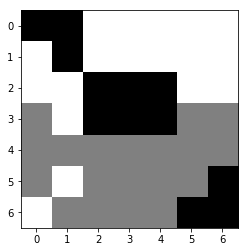

((2, 4), (3, 5)): n_v:  2320 q_all:-0.151717 q:-0.151625 q_m:-0.033333 p:0.473376
((3, 2), (3, 0)): n_v:   156 q_all:-0.223914 q:-0.246472 q_m:-0.000000 p:0.073359
((3, 4), (3, 6)): n_v:   112 q_all:-0.206398 q:-0.184274 q_m:-0.066667 p:0.045341
((5, 6), (3, 5)): n_v:    98 q_all:-0.146082 q:-0.179395 q_m:-0.066667 p:0.018018
((5, 6), (3, 6)): n_v:    26 q_all:-0.274097 q:-0.211098 q_m:-0.066667 p:0.017328
((3, 3), (3, 5)): n_v:    17 q_all:-0.283468 q:-0.188179 q_m:-0.066667 p:0.012351
((2, 3), (3, 5)): n_v:     5 q_all:-0.284915 q:-0.174309 q_m:-0.066667 p:0.003928
((2, 2), (3, 0)): n_v:     3 q_all:-0.287978 q:-0.219905 q_m:-0.000000 p:0.002474
((2, 4), (3, 6)): n_v:     3 q_all:-0.251330 q:-0.189238 q_m:-0.066667 p:0.001816
((1, 1), (3, 0)): n_v:     2 q_all:-0.357466 q:-0.289761 q_m:-0.000000 p:0.001872
((3, 2), (5, 0)): n_v:     1 q_all:-0.311926 q:-0.312851 q_m:-0.066667 p:0.000976
((5, 6), (5, 4)): n_v:     0 q_all:-0.376964 q:-0.376964 q_m:-0.200000 p:0.000000
((6, 5), (5, 4))

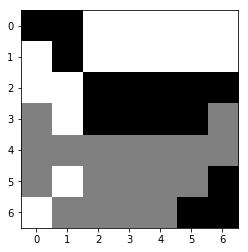

((5, 1), (4, 3)): n_v:   828 q_all:+0.204080 q:+0.184930 q_m:+0.233333 p:0.014425
((2, 0), (3, 0)): n_v:   691 q_all:+0.166242 q:+0.154577 q_m:+0.066667 p:0.093920
((3, 1), (4, 2)): n_v:   548 q_all:+0.137754 q:+0.158778 q_m:+0.200000 p:0.123709
((3, 1), (4, 3)): n_v:   471 q_all:+0.186468 q:+0.184747 q_m:+0.233333 p:0.034388
((5, 1), (3, 0)): n_v:   312 q_all:+0.169850 q:+0.126290 q_m:+0.033333 p:0.039226
((5, 1), (5, 0)): n_v:   246 q_all:+0.157689 q:+0.095016 q_m:+0.066667 p:0.040131
((1, 6), (3, 6)): n_v:   183 q_all:+0.111912 q:+0.177572 q_m:+0.233333 p:0.056375
((5, 1), (6, 2)): n_v:   152 q_all:+0.139109 q:+0.092896 q_m:+0.066667 p:0.033736
((5, 1), (5, 2)): n_v:    71 q_all:+0.162434 q:+0.088668 q_m:+0.066667 p:0.010665
((3, 1), (4, 1)): n_v:    61 q_all:+0.144651 q:+0.089169 q_m:+0.133333 p:0.012505
((5, 1), (6, 1)): n_v:    50 q_all:+0.123034 q:+0.089443 q_m:+0.066667 p:0.013849
((1, 0), (3, 0)): n_v:    44 q_all:+0.006686 q:+0.009573 q_m:+0.033333 p:0.028198
((6, 0), (4, 2))

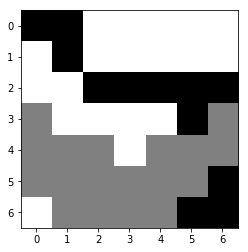

((3, 5), (4, 4)): n_v:   796 q_all:-0.238911 q:-0.208582 q_m:-0.000000 p:0.270009
((2, 2), (4, 4)): n_v:   438 q_all:-0.255141 q:-0.180694 q_m:-0.033333 p:0.176900
((2, 4), (4, 2)): n_v:   386 q_all:-0.255747 q:-0.193964 q_m:+0.033333 p:0.156642
((6, 5), (4, 4)): n_v:   251 q_all:-0.227055 q:-0.218886 q_m:-0.033333 p:0.073650
((2, 6), (4, 4)): n_v:   223 q_all:-0.233132 q:-0.260174 q_m:-0.033333 p:0.070863
((6, 6), (4, 4)): n_v:   180 q_all:-0.250505 q:-0.239829 q_m:-0.033333 p:0.069002
((5, 6), (4, 4)): n_v:   153 q_all:-0.239890 q:-0.247385 q_m:-0.033333 p:0.052656
((2, 3), (4, 2)): n_v:    33 q_all:-0.262387 q:-0.179938 q_m:+0.033333 p:0.014424
((5, 6), (3, 6)): n_v:    21 q_all:-0.276763 q:-0.400874 q_m:-0.233333 p:0.010043
((2, 5), (3, 6)): n_v:    21 q_all:-0.306989 q:-0.384296 q_m:-0.200000 p:0.012994
((2, 3), (4, 4)): n_v:    20 q_all:-0.291892 q:-0.225289 q_m:-0.033333 p:0.010891
((2, 2), (3, 0)): n_v:    16 q_all:-0.234824 q:-0.187890 q_m:-0.033333 p:0.005391
((2, 2), (4, 2))

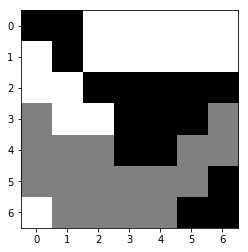

((3, 1), (4, 2)): n_v:  1777 q_all:+0.220391 q:+0.197226 q_m:+0.166667 p:0.339664
((6, 0), (4, 2)): n_v:   137 q_all:+0.215158 q:+0.178360 q_m:+0.133333 p:0.029169
((3, 2), (5, 4)): n_v:   129 q_all:+0.230370 q:+0.136470 q_m:+0.200000 p:0.019587
((2, 0), (3, 0)): n_v:   101 q_all:+0.213477 q:+0.169994 q_m:+0.033333 p:0.021801
((3, 2), (5, 3)): n_v:    69 q_all:+0.223372 q:+0.100532 q_m:+0.133333 p:0.012313
((3, 2), (5, 1)): n_v:    48 q_all:+0.190833 q:+0.038840 q_m:-0.000000 p:0.014955
((2, 0), (4, 2)): n_v:    38 q_all:+0.115139 q:+0.136470 q_m:+0.133333 p:0.023664
((3, 1), (5, 3)): n_v:    29 q_all:+0.161101 q:+0.142515 q_m:+0.133333 p:0.012369
((6, 0), (5, 1)): n_v:    27 q_all:+0.138478 q:+0.105866 q_m:+0.033333 p:0.013924
((1, 6), (3, 6)): n_v:    14 q_all:+0.136707 q:+0.162034 q_m:+0.200000 p:0.007281
((3, 1), (4, 1)): n_v:    13 q_all:+0.120811 q:+0.094111 q_m:+0.033333 p:0.007808
((3, 1), (5, 2)): n_v:     9 q_all:+0.086242 q:+0.097179 q_m:+0.066667 p:0.006678
((6, 0), (5, 0))

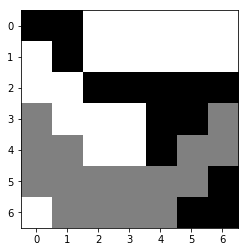

((4, 4), (5, 3)): n_v:  1594 q_all:-0.225651 q:-0.269033 q_m:-0.000000 p:0.171015
((4, 4), (5, 2)): n_v:   411 q_all:-0.199345 q:-0.231046 q_m:-0.033333 p:0.007609
((2, 5), (3, 6)): n_v:   368 q_all:-0.305093 q:-0.356151 q_m:-0.133333 p:0.137890
((5, 6), (3, 6)): n_v:   315 q_all:-0.291243 q:-0.363032 q_m:-0.166667 p:0.103158
((4, 4), (3, 6)): n_v:   167 q_all:-0.292608 q:-0.396080 q_m:-0.166667 p:0.055493
((2, 2), (3, 0)): n_v:   149 q_all:-0.247073 q:-0.167775 q_m:+0.033333 p:0.026723
((1, 1), (3, 0)): n_v:   115 q_all:-0.317851 q:-0.230975 q_m:+0.033333 p:0.048222
((2, 3), (4, 1)): n_v:    84 q_all:-0.252284 q:-0.169221 q_m:+0.033333 p:0.016344
((6, 5), (5, 3)): n_v:    66 q_all:-0.238198 q:-0.240792 q_m:-0.033333 p:0.009892
((2, 6), (4, 5)): n_v:    26 q_all:-0.304953 q:-0.371772 q_m:-0.166667 p:0.009898
((2, 4), (3, 6)): n_v:    20 q_all:-0.442968 q:-0.408096 q_m:-0.166667 p:0.016588
((6, 6), (4, 5)): n_v:    20 q_all:-0.242906 q:-0.353403 q_m:-0.166667 p:0.003291
((3, 4), (5, 3))

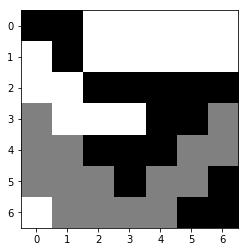

((6, 0), (5, 2)): n_v:  1669 q_all:+0.225332 q:+0.195885 q_m:+0.200000 p:0.541885
((3, 3), (5, 5)): n_v:   640 q_all:+0.318010 q:+0.173513 q_m:+0.266667 p:0.004791
((3, 1), (5, 2)): n_v:   187 q_all:+0.129124 q:+0.142111 q_m:+0.200000 p:0.123692
((3, 3), (5, 4)): n_v:   167 q_all:+0.227454 q:+0.149118 q_m:+0.266667 p:0.053138
((3, 1), (4, 1)): n_v:   159 q_all:+0.267187 q:+0.168840 q_m:+0.100000 p:0.028459
((3, 2), (5, 4)): n_v:   129 q_all:+0.166167 q:+0.100652 q_m:+0.266667 p:0.068870
((3, 3), (5, 2)): n_v:   103 q_all:+0.158811 q:+0.076697 q_m:+0.200000 p:0.057121
((6, 0), (6, 2)): n_v:    38 q_all:+0.190131 q:+0.126372 q_m:+0.066667 p:0.017130
((6, 0), (4, 1)): n_v:    37 q_all:+0.232817 q:+0.161369 q_m:+0.066667 p:0.010339
((2, 0), (4, 1)): n_v:    22 q_all:+0.157910 q:+0.106074 q_m:+0.066667 p:0.012664
((3, 3), (4, 5)): n_v:    22 q_all:+0.275325 q:+0.091504 q_m:+0.266667 p:0.003165
((6, 0), (5, 1)): n_v:    16 q_all:+0.185602 q:+0.153945 q_m:+0.100000 p:0.007724
((3, 2), (5, 2))

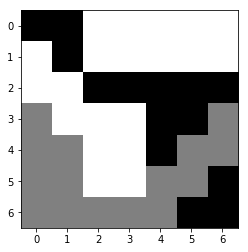

((2, 2), (4, 1)): n_v:   690 q_all:-0.197530 q:-0.123669 q_m:+0.066667 p:0.010401
((2, 3), (4, 1)): n_v:   501 q_all:-0.228532 q:-0.159909 q_m:+0.066667 p:0.061506
((4, 4), (6, 3)): n_v:   315 q_all:-0.246969 q:-0.306329 q_m:-0.066667 p:0.058942
((2, 5), (3, 6)): n_v:   230 q_all:-0.350747 q:-0.429435 q_m:-0.166667 p:0.126720
((2, 2), (3, 0)): n_v:   200 q_all:-0.250357 q:-0.201229 q_m:-0.000000 p:0.039942
((4, 4), (5, 4)): n_v:   161 q_all:-0.237862 q:-0.303875 q_m:-0.033333 p:0.025113
((6, 5), (6, 3)): n_v:   135 q_all:-0.279920 q:-0.315547 q_m:-0.066667 p:0.041152
((3, 5), (5, 4)): n_v:   126 q_all:-0.236940 q:-0.299811 q_m:-0.066667 p:0.019273
((2, 6), (4, 5)): n_v:    96 q_all:-0.359084 q:-0.420334 q_m:-0.200000 p:0.055513
((5, 6), (3, 6)): n_v:    82 q_all:-0.351848 q:-0.424604 q_m:-0.200000 p:0.045406
((1, 1), (3, 0)): n_v:    62 q_all:-0.319758 q:-0.239783 q_m:-0.000000 p:0.026863
((4, 4), (3, 6)): n_v:    50 q_all:-0.323764 q:-0.427643 q_m:-0.200000 p:0.022844
((4, 4), (6, 2))

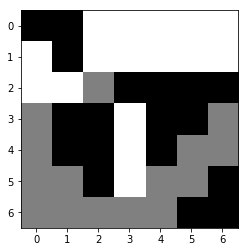

((1, 2), (2, 2)): n_v:  1313 q_all:+0.263824 q:+0.248140 q_m:+0.233333 p:0.100862
((4, 3), (5, 5)): n_v:   401 q_all:+0.166461 q:+0.067427 q_m:+0.200000 p:0.188986
((1, 0), (2, 2)): n_v:   220 q_all:+0.244239 q:+0.106401 q_m:+0.200000 p:0.033841
((3, 3), (5, 1)): n_v:   161 q_all:+0.234874 q:+0.037547 q_m:+0.133333 p:0.031038
((4, 3), (5, 1)): n_v:    88 q_all:+0.149317 q:+0.019636 q_m:+0.133333 p:0.047525
((3, 3), (5, 5)): n_v:    47 q_all:+0.148982 q:+0.054029 q_m:+0.200000 p:0.025462
((2, 0), (2, 2)): n_v:    45 q_all:+0.124158 q:+0.152881 q_m:+0.200000 p:0.029196
((5, 3), (5, 5)): n_v:    42 q_all:+0.161038 q:+0.081640 q_m:+0.200000 p:0.020026
((4, 3), (2, 2)): n_v:    38 q_all:+0.240034 q:+0.205992 q_m:+0.200000 p:0.006402
((5, 3), (5, 1)): n_v:    20 q_all:+0.140321 q:+0.023389 q_m:+0.133333 p:0.011569
((0, 2), (2, 2)): n_v:    11 q_all:+0.021620 q:+0.044353 q_m:+0.200000 p:0.011867
((0, 3), (2, 2)): n_v:     7 q_all:+0.116874 q:+0.076335 q_m:+0.200000 p:0.004793
((0, 4), (2, 2))

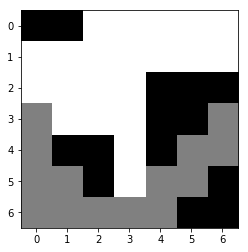

((4, 1), (3, 0)): n_v:  1780 q_all:-0.231980 q:-0.179525 q_m:-0.000000 p:0.259952
((4, 2), (3, 0)): n_v:   462 q_all:-0.287237 q:-0.251456 q_m:-0.033333 p:0.159633
((5, 2), (3, 0)): n_v:   365 q_all:-0.255653 q:-0.284767 q_m:-0.033333 p:0.084467
((4, 4), (3, 6)): n_v:   156 q_all:-0.401073 q:-0.420036 q_m:-0.233333 p:0.118068
((5, 6), (3, 6)): n_v:   111 q_all:-0.401099 q:-0.403617 q_m:-0.233333 p:0.083503
((2, 5), (3, 6)): n_v:    92 q_all:-0.405457 q:-0.399132 q_m:-0.200000 p:0.071460
((2, 4), (3, 6)): n_v:    17 q_all:-0.444062 q:-0.418132 q_m:-0.233333 p:0.015913
((3, 5), (5, 4)): n_v:     9 q_all:-0.279956 q:-0.348619 q_m:-0.100000 p:0.002187
((4, 4), (5, 4)): n_v:     3 q_all:-0.305269 q:-0.355619 q_m:-0.066667 p:0.001045
((3, 4), (3, 6)): n_v:     2 q_all:-0.460084 q:-0.437196 q_m:-0.233333 p:0.002317
((5, 2), (5, 4)): n_v:     2 q_all:-0.422975 q:-0.416574 q_m:-0.100000 p:0.001887
((4, 2), (5, 4)): n_v:     2 q_all:-0.438974 q:-0.386628 q_m:-0.100000 p:0.001766
((4, 2), (6, 0))

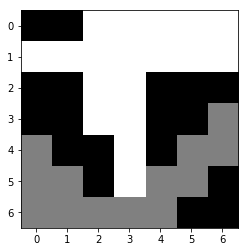

((5, 3), (5, 5)): n_v:  1633 q_all:+0.282112 q:+0.291477 q_m:+0.266667 p:0.285148
((4, 3), (5, 5)): n_v:   681 q_all:+0.222613 q:+0.226990 q_m:+0.266667 p:0.255264
((5, 3), (5, 1)): n_v:   501 q_all:+0.242756 q:+0.233928 q_m:+0.200000 p:0.153872
((4, 3), (5, 1)): n_v:   186 q_all:+0.137101 q:+0.157745 q_m:+0.200000 p:0.123211
((5, 3), (4, 5)): n_v:   163 q_all:+0.325402 q:+0.197678 q_m:+0.266667 p:0.004770
((4, 3), (5, 4)): n_v:   114 q_all:+0.269198 q:+0.236106 q_m:+0.166667 p:0.024867
((3, 2), (5, 1)): n_v:    39 q_all:+0.048557 q:+0.093569 q_m:+0.200000 p:0.038039
((3, 3), (5, 5)): n_v:    32 q_all:+0.102854 q:+0.161633 q_m:+0.266667 p:0.025110
((5, 3), (6, 4)): n_v:    22 q_all:+0.134618 q:+0.137836 q_m:+0.100000 p:0.015073
((5, 3), (6, 2)): n_v:    21 q_all:+0.177407 q:+0.182039 q_m:+0.100000 p:0.010866
((3, 3), (5, 1)): n_v:    20 q_all:+0.086802 q:+0.124191 q_m:+0.200000 p:0.017127
((5, 3), (6, 3)): n_v:    19 q_all:+0.208764 q:+0.170814 q_m:+0.100000 p:0.008126
((1, 6), (3, 6))

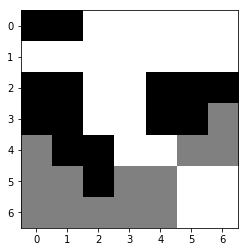

((5, 2), (5, 4)): n_v:  2095 q_all:-0.334185 q:-0.284318 q_m:-0.000000 p:0.703100
((4, 2), (5, 4)): n_v:   481 q_all:-0.337990 q:-0.290403 q_m:-0.000000 p:0.167854
((3, 4), (4, 5)): n_v:   251 q_all:-0.251427 q:-0.198232 q_m:-0.033333 p:0.012708
((2, 6), (4, 5)): n_v:   181 q_all:-0.259171 q:-0.170029 q_m:-0.066667 p:0.014098
((4, 2), (5, 3)): n_v:    53 q_all:-0.307454 q:-0.297513 q_m:-0.100000 p:0.012847
((2, 4), (4, 5)): n_v:    33 q_all:-0.276642 q:-0.222055 q_m:-0.066667 p:0.004552
((5, 2), (6, 4)): n_v:    25 q_all:-0.319571 q:-0.350847 q_m:-0.133333 p:0.007161
((3, 5), (5, 4)): n_v:    20 q_all:-0.311255 q:-0.250192 q_m:-0.000000 p:0.005154
((3, 0), (5, 0)): n_v:    18 q_all:-0.384219 q:-0.406724 q_m:-0.266667 p:0.009306
((2, 5), (4, 5)): n_v:    17 q_all:-0.344529 q:-0.251183 q_m:-0.066667 p:0.006441
((3, 4), (5, 4)): n_v:     9 q_all:-0.294974 q:-0.226272 q_m:-0.000000 p:0.001975
((5, 2), (6, 3)): n_v:     4 q_all:-0.412558 q:-0.433731 q_m:-0.233333 p:0.002873
((4, 1), (5, 3))

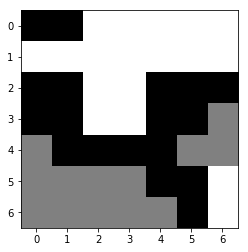

((5, 6), (4, 5)): n_v:  1791 q_all:+0.381531 q:+0.300353 q_m:+0.366667 p:0.437778
((6, 6), (4, 5)): n_v:  1569 q_all:+0.351680 q:+0.254988 q_m:+0.333333 p:0.534515
((5, 6), (4, 6)): n_v:    28 q_all:+0.195937 q:+0.210702 q_m:+0.166667 p:0.024225
((6, 6), (6, 4)): n_v:     2 q_all:+0.266697 q:+0.235081 q_m:+0.200000 p:0.001555
((5, 6), (6, 4)): n_v:     1 q_all:+0.264915 q:+0.230644 q_m:+0.200000 p:0.000749
((6, 6), (4, 6)): n_v:     0 q_all:+0.150696 q:+0.150696 q_m:+0.133333 p:0.000302
((3, 3), (5, 3)): n_v:     0 q_all:+0.181185 q:+0.181185 q_m:+0.266667 p:0.000006
((2, 2), (4, 0)): n_v:     0 q_all:+0.115693 q:+0.115693 q_m:+0.200000 p:0.000000
((3, 2), (5, 3)): n_v:     0 q_all:+0.181345 q:+0.181345 q_m:+0.266667 p:0.000062
((3, 2), (4, 0)): n_v:     0 q_all:+0.205907 q:+0.205907 q_m:+0.200000 p:0.000007
((5, 6), (3, 6)): n_v:     0 q_all:+0.330386 q:+0.330386 q_m:+0.200000 p:0.000344
((3, 3), (5, 1)): n_v:     0 q_all:+0.166269 q:+0.166269 q_m:+0.133333 p:0.000003
((1, 5), (3, 6))

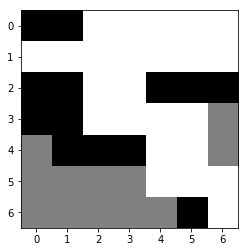

((4, 3), (6, 4)): n_v:  1240 q_all:-0.302534 q:-0.401281 q_m:-0.233333 p:0.150593
((2, 5), (4, 6)): n_v:   585 q_all:-0.353331 q:-0.340837 q_m:-0.100000 p:0.170887
((2, 6), (4, 6)): n_v:   536 q_all:-0.332608 q:-0.321104 q_m:-0.100000 p:0.118895
((2, 4), (4, 6)): n_v:   196 q_all:-0.339322 q:-0.349075 q_m:-0.100000 p:0.047805
((4, 2), (6, 4)): n_v:   179 q_all:-0.408909 q:-0.387222 q_m:-0.233333 p:0.086079
((4, 3), (6, 2)): n_v:   130 q_all:-0.452736 q:-0.489419 q_m:-0.366667 p:0.081032
((4, 2), (6, 0)): n_v:   105 q_all:-0.530979 q:-0.546863 q_m:-0.366667 p:0.093541
((4, 3), (5, 1)): n_v:    75 q_all:-0.463043 q:-0.531503 q_m:-0.366667 p:0.049815
((2, 1), (4, 0)): n_v:    63 q_all:-0.554699 q:-0.544302 q_m:-0.366667 p:0.061476
((2, 0), (4, 0)): n_v:    35 q_all:-0.561313 q:-0.573317 q_m:-0.366667 p:0.034857
((4, 2), (5, 3)): n_v:    26 q_all:-0.434215 q:-0.426025 q_m:-0.200000 p:0.015048
((6, 5), (6, 4)): n_v:    20 q_all:-0.432858 q:-0.380962 q_m:-0.200000 p:0.011215
((4, 1), (6, 0))

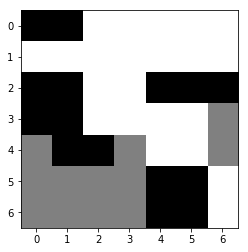

((5, 6), (3, 6)): n_v:  1330 q_all:+0.400966 q:+0.361596 q_m:+0.366667 p:0.003846
((4, 4), (5, 3)): n_v:   954 q_all:+0.295529 q:+0.311443 q_m:+0.466667 p:0.374535
((3, 2), (4, 3)): n_v:   415 q_all:+0.307388 q:+0.292202 q_m:+0.400000 p:0.144849
((3, 5), (4, 3)): n_v:    65 q_all:+0.432824 q:+0.270095 q_m:+0.366667 p:0.000486
((3, 5), (3, 6)): n_v:    45 q_all:+0.352769 q:+0.409745 q_m:+0.400000 p:0.006284
((3, 5), (4, 6)): n_v:    37 q_all:+0.324725 q:+0.279136 q_m:+0.333333 p:0.010663
((3, 2), (5, 3)): n_v:    23 q_all:+0.332585 q:+0.225008 q_m:+0.433333 p:0.005724
((3, 4), (5, 3)): n_v:    16 q_all:+0.314603 q:+0.217964 q_m:+0.433333 p:0.005347
((4, 5), (5, 3)): n_v:    12 q_all:+0.282617 q:+0.266530 q_m:+0.433333 p:0.005147
((6, 6), (4, 6)): n_v:     7 q_all:+0.284564 q:+0.206126 q_m:+0.300000 p:0.003319
((3, 5), (5, 3)): n_v:     5 q_all:+0.273560 q:+0.263662 q_m:+0.433333 p:0.002695
((3, 3), (5, 3)): n_v:     4 q_all:+0.259767 q:+0.231322 q_m:+0.433333 p:0.002261
((4, 4), (5, 2))

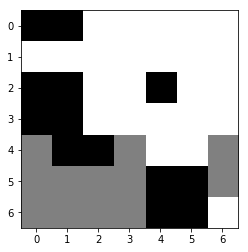

((6, 4), (4, 3)): n_v:  1649 q_all:-0.284429 q:-0.343952 q_m:-0.100000 p:0.032623
((4, 2), (4, 3)): n_v:   604 q_all:-0.385663 q:-0.281326 q_m:-0.066667 p:0.223286
((4, 1), (4, 3)): n_v:   155 q_all:-0.307230 q:-0.360840 q_m:-0.100000 p:0.015597
((2, 4), (4, 6)): n_v:   113 q_all:-0.365749 q:-0.358494 q_m:-0.166667 p:0.029364
((2, 4), (4, 3)): n_v:   109 q_all:-0.330315 q:-0.310811 q_m:-0.100000 p:0.007166
((2, 1), (4, 3)): n_v:   100 q_all:-0.462530 q:-0.352020 q_m:-0.100000 p:0.066525
((6, 5), (4, 6)): n_v:    78 q_all:-0.411126 q:-0.425133 q_m:-0.166667 p:0.037523
((6, 4), (4, 6)): n_v:    70 q_all:-0.493156 q:-0.428153 q_m:-0.166667 p:0.054461
((5, 5), (4, 3)): n_v:    58 q_all:-0.398739 q:-0.394010 q_m:-0.100000 p:0.025323
((6, 5), (4, 3)): n_v:    43 q_all:-0.400828 q:-0.361284 q_m:-0.100000 p:0.019276
((3, 1), (4, 3)): n_v:    41 q_all:-0.553035 q:-0.343135 q_m:-0.100000 p:0.041304
((5, 5), (4, 6)): n_v:    15 q_all:-0.462010 q:-0.383041 q_m:-0.133333 p:0.010239
((4, 2), (5, 0))

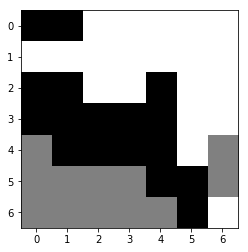

((6, 6), (6, 4)): n_v:  1006 q_all:+0.328010 q:+0.367888 q_m:+0.300000 p:0.116505
((3, 5), (5, 6)): n_v:   889 q_all:+0.378688 q:+0.276233 q_m:+0.233333 p:0.003874
((4, 5), (5, 6)): n_v:   835 q_all:+0.266469 q:+0.414486 q_m:+0.266667 p:0.324926
((3, 6), (5, 6)): n_v:   430 q_all:+0.350887 q:+0.342766 q_m:+0.233333 p:0.025461
((4, 5), (6, 4)): n_v:   129 q_all:+0.332650 q:+0.357316 q_m:+0.300000 p:0.011842
((3, 5), (4, 6)): n_v:    50 q_all:+0.187896 q:+0.326372 q_m:+0.200000 p:0.033042
((4, 5), (5, 3)): n_v:    50 q_all:+0.295720 q:+0.419493 q_m:+0.366667 p:0.013709
((6, 6), (4, 6)): n_v:    16 q_all:+0.183538 q:+0.254459 q_m:+0.166667 p:0.011400
((3, 5), (5, 3)): n_v:     3 q_all:+0.240899 q:+0.321804 q_m:+0.366667 p:0.001512
((4, 5), (6, 3)): n_v:     1 q_all:+0.281743 q:+0.339512 q_m:+0.166667 p:0.000522
((2, 2), (4, 0)): n_v:     0 q_all:+0.295281 q:+0.295281 q_m:+0.300000 p:0.000060
((2, 6), (4, 6)): n_v:     0 q_all:+0.235405 q:+0.235405 q_m:+0.166667 p:0.000177
((2, 5), (4, 6))

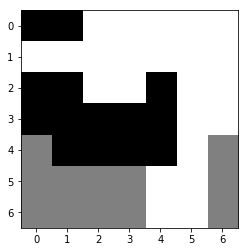

((4, 2), (5, 3)): n_v:  2224 q_all:-0.338082 q:-0.310620 q_m:-0.133333 p:0.245333
((3, 0), (4, 0)): n_v:   146 q_all:-0.396013 q:-0.389485 q_m:-0.266667 p:0.048129
((2, 4), (4, 6)): n_v:   138 q_all:-0.318082 q:-0.396458 q_m:-0.033333 p:0.004621
((4, 4), (4, 6)): n_v:    36 q_all:-0.378533 q:-0.392767 q_m:-0.033333 p:0.009553
((3, 4), (4, 6)): n_v:    31 q_all:-0.394646 q:-0.436281 q_m:-0.033333 p:0.010054
((4, 1), (5, 3)): n_v:    30 q_all:-0.405885 q:-0.374379 q_m:-0.166667 p:0.011064
((4, 4), (6, 6)): n_v:    27 q_all:-0.388857 q:-0.403589 q_m:-0.166667 p:0.008188
((3, 4), (5, 3)): n_v:    13 q_all:-0.421103 q:-0.385672 q_m:-0.166667 p:0.005955
((2, 0), (4, 0)): n_v:    11 q_all:-0.566938 q:-0.510103 q_m:-0.300000 p:0.010743
((3, 2), (4, 0)): n_v:     9 q_all:-0.536738 q:-0.541091 q_m:-0.300000 p:0.007976
((4, 4), (5, 2)): n_v:     9 q_all:-0.386462 q:-0.413953 q_m:-0.300000 p:0.002647
((4, 1), (5, 0)): n_v:     9 q_all:-0.440302 q:-0.441910 q_m:-0.266667 p:0.004653
((3, 2), (5, 3))

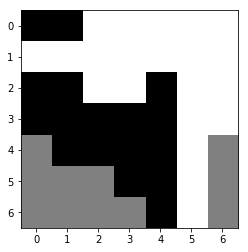

((5, 5), (6, 3)): n_v:  1460 q_all:+0.379528 q:+0.353505 q_m:+0.333333 p:0.366355
((6, 5), (6, 3)): n_v:  1164 q_all:+0.391644 q:+0.384906 q_m:+0.333333 p:0.247408
((4, 5), (6, 3)): n_v:   471 q_all:+0.374853 q:+0.361061 q_m:+0.333333 p:0.125376
((3, 5), (4, 6)): n_v:    40 q_all:+0.133078 q:+0.260333 q_m:+0.166667 p:0.041392
((4, 5), (5, 6)): n_v:     5 q_all:+0.157652 q:+0.316256 q_m:+0.166667 p:0.004944
((6, 5), (4, 6)): n_v:     5 q_all:+0.156743 q:+0.268014 q_m:+0.133333 p:0.005394
((5, 5), (6, 6)): n_v:     4 q_all:+0.310232 q:+0.261158 q_m:+0.166667 p:0.002207
((3, 6), (5, 6)): n_v:     4 q_all:+0.215402 q:+0.274549 q_m:+0.133333 p:0.003708
((2, 6), (4, 6)): n_v:     1 q_all:+0.048092 q:+0.172779 q_m:+0.133333 p:0.001287
((3, 5), (5, 6)): n_v:     0 q_all:+0.191456 q:+0.191456 q_m:+0.133333 p:0.000635
((2, 2), (4, 0)): n_v:     0 q_all:+0.296504 q:+0.296504 q_m:+0.333333 p:0.000268
((4, 5), (6, 6)): n_v:     0 q_all:+0.247041 q:+0.247041 q_m:+0.133333 p:0.000081
((2, 5), (4, 6))

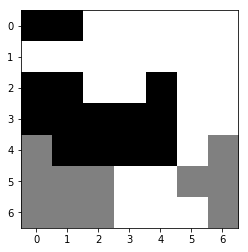

((4, 4), (5, 5)): n_v:  2478 q_all:-0.311902 q:-0.300437 q_m:-0.033333 p:0.156672
((4, 1), (5, 2)): n_v:   255 q_all:-0.356150 q:-0.309042 q_m:-0.166667 p:0.055988
((4, 1), (5, 1)): n_v:   229 q_all:-0.532140 q:-0.503496 q_m:-0.300000 p:0.192339
((4, 3), (5, 5)): n_v:    67 q_all:-0.421340 q:-0.363970 q_m:-0.066667 p:0.030362
((3, 0), (5, 1)): n_v:    57 q_all:-0.540328 q:-0.508161 q_m:-0.333333 p:0.049983
((3, 4), (5, 5)): n_v:    28 q_all:-0.407406 q:-0.362586 q_m:-0.066667 p:0.011466
((3, 0), (5, 2)): n_v:    16 q_all:-0.410491 q:-0.364221 q_m:-0.200000 p:0.006420
((4, 3), (5, 1)): n_v:    15 q_all:-0.572996 q:-0.581506 q_m:-0.333333 p:0.015166
((4, 1), (5, 0)): n_v:    11 q_all:-0.479310 q:-0.515106 q_m:-0.300000 p:0.007772
((3, 3), (5, 5)): n_v:     9 q_all:-0.446801 q:-0.387365 q_m:-0.066667 p:0.004750
((4, 4), (6, 6)): n_v:     8 q_all:-0.453815 q:-0.454721 q_m:-0.266667 p:0.004692
((4, 4), (5, 2)): n_v:     7 q_all:-0.373798 q:-0.337107 q_m:-0.200000 p:0.002246
((3, 1), (5, 1))

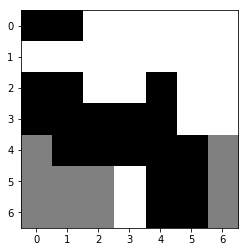

((5, 3), (5, 2)): n_v:  2418 q_all:+0.352271 q:+0.410224 q_m:+0.266667 p:0.303788
((3, 6), (5, 6)): n_v:  1302 q_all:+0.313525 q:+0.303030 q_m:+0.233333 p:0.318727
((3, 5), (4, 6)): n_v:    83 q_all:+0.263032 q:+0.292678 q_m:+0.200000 p:0.033536
((3, 5), (5, 6)): n_v:    44 q_all:+0.287778 q:+0.251062 q_m:+0.233333 p:0.014539
((6, 3), (6, 1)): n_v:    17 q_all:+0.217671 q:+0.307750 q_m:+0.033333 p:0.009625
((6, 3), (5, 1)): n_v:    12 q_all:+0.213288 q:+0.358796 q_m:+0.166667 p:0.006666
((5, 3), (5, 1)): n_v:    11 q_all:+0.281389 q:+0.333254 q_m:+0.166667 p:0.003927
((5, 3), (6, 2)): n_v:     9 q_all:+0.101428 q:+0.271350 q_m:+0.066667 p:0.008876
((5, 3), (6, 1)): n_v:     6 q_all:+0.289732 q:+0.330571 q_m:+0.033333 p:0.002119
((2, 6), (4, 6)): n_v:     1 q_all:+0.110294 q:+0.180573 q_m:+0.166667 p:0.001303
((2, 5), (4, 6)): n_v:     0 q_all:+0.079803 q:+0.079803 q_m:+0.166667 p:0.000108
((2, 2), (4, 0)): n_v:     0 q_all:+0.232742 q:+0.232742 q_m:+0.233333 p:0.000450
-1 's turn


Thi

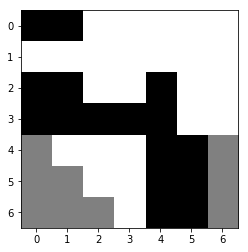

((4, 5), (4, 6)): n_v:  1990 q_all:-0.265920 q:-0.335766 q_m:-0.100000 p:0.106984
((3, 0), (5, 1)): n_v:  1335 q_all:-0.345484 q:-0.237797 q_m:-0.066667 p:0.400397
((3, 0), (4, 0)): n_v:   120 q_all:-0.406477 q:-0.339770 q_m:-0.166667 p:0.058822
((3, 1), (5, 1)): n_v:    99 q_all:-0.479457 q:-0.360232 q_m:-0.066667 p:0.070728
((6, 5), (4, 6)): n_v:    92 q_all:-0.277073 q:-0.377578 q_m:-0.133333 p:0.008091
((6, 4), (6, 2)): n_v:    83 q_all:-0.407559 q:-0.376988 q_m:-0.066667 p:0.040988
((3, 3), (5, 1)): n_v:    39 q_all:-0.439006 q:-0.361685 q_m:-0.066667 p:0.022823
((3, 2), (5, 1)): n_v:    34 q_all:-0.469097 q:-0.433744 q_m:-0.066667 p:0.023166
((5, 4), (4, 6)): n_v:    18 q_all:-0.522677 q:-0.495408 q_m:-0.133333 p:0.016076
((3, 2), (4, 0)): n_v:    15 q_all:-0.499848 q:-0.515524 q_m:-0.200000 p:0.011757
((4, 4), (6, 2)): n_v:    11 q_all:-0.456354 q:-0.376380 q_m:-0.066667 p:0.007664
((6, 4), (4, 6)): n_v:    10 q_all:-0.404410 q:-0.441714 q_m:-0.133333 p:0.004596
((2, 0), (4, 0))

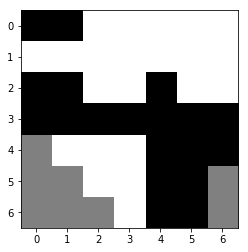

((4, 1), (4, 0)): n_v:  3393 q_all:+0.349291 q:+0.321237 q_m:+0.266667 p:0.589184
((4, 1), (5, 0)): n_v:   131 q_all:+0.067672 q:+0.106913 q_m:+0.133333 p:0.143683
((5, 2), (6, 1)): n_v:    36 q_all:+0.116316 q:+0.094553 q_m:+0.133333 p:0.034308
((4, 1), (5, 1)): n_v:    27 q_all:+0.105697 q:+0.167743 q_m:+0.133333 p:0.026550
((2, 2), (4, 0)): n_v:    19 q_all:-0.081064 q:+0.014650 q_m:+0.233333 p:0.029594
((5, 2), (5, 0)): n_v:    18 q_all:-0.026505 q:+0.033231 q_m:+0.100000 p:0.026549
((6, 3), (5, 1)): n_v:    16 q_all:+0.146689 q:+0.209184 q_m:+0.100000 p:0.014083
((5, 2), (4, 0)): n_v:    14 q_all:+0.241445 q:+0.308984 q_m:+0.233333 p:0.007711
((5, 2), (6, 2)): n_v:    10 q_all:+0.021549 q:+0.087390 q_m:+0.133333 p:0.012706
((4, 2), (5, 0)): n_v:     8 q_all:-0.031171 q:+0.034652 q_m:+0.100000 p:0.011836
((6, 3), (6, 1)): n_v:     3 q_all:+0.104954 q:+0.162306 q_m:+0.100000 p:0.002892
((4, 2), (4, 0)): n_v:     2 q_all:+0.120870 q:+0.189207 q_m:+0.233333 p:0.002132
((5, 3), (5, 1))

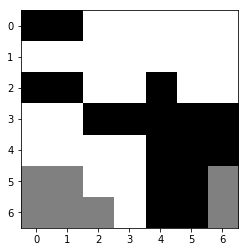

((3, 2), (5, 1)): n_v:  3637 q_all:-0.351001 q:-0.271625 q_m:-0.000000 p:0.661590
((3, 3), (5, 1)): n_v:   643 q_all:-0.413373 q:-0.279079 q_m:-0.000000 p:0.228653
((5, 5), (6, 6)): n_v:   157 q_all:-0.291288 q:-0.527554 q_m:-0.233333 p:0.002889
((4, 5), (5, 6)): n_v:   126 q_all:-0.308440 q:-0.484336 q_m:-0.233333 p:0.007956
((6, 4), (6, 2)): n_v:    57 q_all:-0.413402 q:-0.377517 q_m:-0.066667 p:0.020536
((4, 4), (6, 2)): n_v:    15 q_all:-0.549983 q:-0.485439 q_m:-0.066667 p:0.011685
((6, 4), (5, 6)): n_v:     3 q_all:-0.530986 q:-0.612285 q_m:-0.266667 p:0.002563
((3, 6), (5, 6)): n_v:     3 q_all:-0.569826 q:-0.588295 q_m:-0.266667 p:0.003025
((3, 2), (5, 0)): n_v:     2 q_all:-0.410505 q:-0.421676 q_m:-0.133333 p:0.000901
((6, 4), (6, 6)): n_v:     1 q_all:-0.567967 q:-0.620006 q_m:-0.266667 p:0.001252
((5, 4), (6, 2)): n_v:     1 q_all:-0.554103 q:-0.505010 q_m:-0.066667 p:0.001324
((5, 4), (6, 6)): n_v:     0 q_all:-0.655219 q:-0.655219 q_m:-0.266667 p:0.000837
((4, 4), (6, 6))

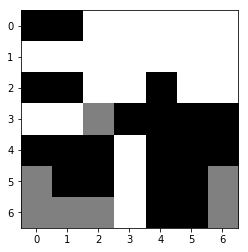

((2, 2), (3, 2)): n_v:  3063 q_all:+0.392244 q:+0.399628 q_m:+0.300000 p:0.182733
((1, 0), (3, 2)): n_v:  1351 q_all:+0.444868 q:+0.144880 q_m:+0.266667 p:0.005261
((3, 0), (3, 2)): n_v:    37 q_all:+0.190696 q:+0.177382 q_m:+0.266667 p:0.026284
((3, 1), (5, 0)): n_v:    30 q_all:+0.168458 q:+0.067965 q_m:+0.200000 p:0.022630
((3, 0), (5, 0)): n_v:    19 q_all:+0.044809 q:+0.017955 q_m:+0.200000 p:0.021170
((5, 3), (3, 2)): n_v:    19 q_all:+0.301713 q:+0.334381 q_m:+0.266667 p:0.006295
((1, 1), (3, 2)): n_v:     3 q_all:-0.042948 q:-0.005610 q_m:+0.266667 p:0.004962
((1, 3), (3, 2)): n_v:     2 q_all:-0.186204 q:-0.078655 q_m:+0.266667 p:0.004201
((1, 4), (3, 2)): n_v:     2 q_all:-0.238690 q:-0.170419 q_m:+0.266667 p:0.004266
((4, 3), (6, 2)): n_v:     0 q_all:-0.013739 q:-0.013739 q_m:+0.133333 p:0.000037
((5, 3), (6, 2)): n_v:     0 q_all:-0.104713 q:-0.104713 q_m:+0.166667 p:0.000178
((4, 3), (6, 1)): n_v:     0 q_all:-0.042246 q:-0.042246 q_m:+0.133333 p:0.000013
((1, 2), (3, 2))

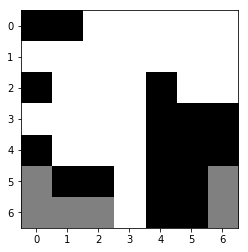

((4, 0), (6, 2)): n_v:  1782 q_all:-0.274487 q:-0.389628 q_m:-0.166667 p:0.020554
((5, 1), (6, 2)): n_v:  1452 q_all:-0.365829 q:-0.344047 q_m:-0.133333 p:0.398284
((6, 4), (6, 2)): n_v:    62 q_all:-0.519563 q:-0.529287 q_m:-0.166667 p:0.044800
((4, 0), (5, 0)): n_v:    49 q_all:-0.475184 q:-0.515196 q_m:-0.200000 p:0.029086
((4, 4), (6, 2)): n_v:    42 q_all:-0.579885 q:-0.570105 q_m:-0.166667 p:0.037622
((4, 5), (5, 6)): n_v:    19 q_all:-0.544933 q:-0.537477 q_m:-0.266667 p:0.015807
((3, 6), (5, 6)): n_v:    16 q_all:-0.601770 q:-0.605657 q_m:-0.300000 p:0.015857
((5, 1), (6, 1)): n_v:    13 q_all:-0.614890 q:-0.609451 q_m:-0.266667 p:0.013657
((5, 2), (5, 0)): n_v:     7 q_all:-0.453900 q:-0.493865 q_m:-0.233333 p:0.004177
((6, 4), (5, 6)): n_v:     7 q_all:-0.617020 q:-0.623790 q_m:-0.300000 p:0.007441
((5, 4), (6, 2)): n_v:     4 q_all:-0.637319 q:-0.620915 q_m:-0.166667 p:0.005080
((4, 0), (6, 1)): n_v:     4 q_all:-0.628061 q:-0.643866 q_m:-0.300000 p:0.004665
((5, 4), (5, 6))

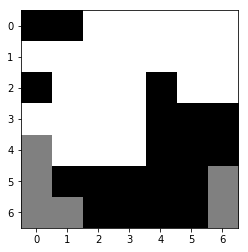

((3, 0), (4, 0)): n_v:  1627 q_all:+0.295577 q:+0.350508 q_m:+0.266667 p:0.031503
((4, 1), (6, 1)): n_v:   947 q_all:+0.216874 q:+0.371703 q_m:+0.366667 p:0.269154
((4, 1), (5, 0)): n_v:   653 q_all:+0.081573 q:+0.341424 q_m:+0.266667 p:0.482042
((3, 0), (5, 0)): n_v:   128 q_all:+0.244759 q:+0.218882 q_m:+0.233333 p:0.024445
((4, 3), (6, 1)): n_v:    83 q_all:+0.136146 q:+0.401398 q_m:+0.366667 p:0.045444
((4, 2), (6, 1)): n_v:    57 q_all:-0.038899 q:+0.231532 q_m:+0.366667 p:0.065771
((4, 2), (5, 0)): n_v:     7 q_all:-0.068465 q:+0.072600 q_m:+0.233333 p:0.009412
((3, 1), (5, 0)): n_v:     1 q_all:-0.052210 q:+0.071058 q_m:+0.233333 p:0.002141
((4, 1), (6, 0)): n_v:     1 q_all:+0.093077 q:+0.206910 q_m:+0.233333 p:0.000396
((2, 1), (4, 0)): n_v:     0 q_all:+0.065162 q:+0.065162 q_m:+0.233333 p:0.000043
((2, 2), (4, 0)): n_v:     0 q_all:-0.067371 q:-0.067371 q_m:+0.233333 p:0.000152
((4, 2), (4, 0)): n_v:     0 q_all:+0.118579 q:+0.118579 q_m:+0.233333 p:0.000103
((3, 2), (4, 0))

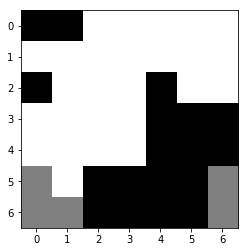

((6, 2), (5, 0)): n_v:  3215 q_all:-0.119373 q:-0.339105 q_m:-0.066667 p:0.221338
((6, 4), (5, 6)): n_v:    66 q_all:-0.587316 q:-0.588314 q_m:-0.266667 p:0.110548
((4, 5), (5, 6)): n_v:    56 q_all:-0.490782 q:-0.480451 q_m:-0.233333 p:0.071049
((3, 6), (5, 6)): n_v:    22 q_all:-0.563435 q:-0.555574 q_m:-0.266667 p:0.036287
((5, 2), (6, 1)): n_v:     7 q_all:-0.485265 q:-0.472704 q_m:-0.166667 p:0.009190
((3, 4), (5, 6)): n_v:     7 q_all:-0.613198 q:-0.597005 q_m:-0.266667 p:0.012875
((5, 2), (5, 0)): n_v:     6 q_all:-0.489949 q:-0.484019 q_m:-0.066667 p:0.007708
((3, 5), (5, 6)): n_v:     2 q_all:-0.677074 q:-0.623940 q_m:-0.266667 p:0.003968
((4, 4), (5, 6)): n_v:     2 q_all:-0.645985 q:-0.662637 q_m:-0.266667 p:0.003912
((5, 4), (5, 6)): n_v:     2 q_all:-0.735047 q:-0.697033 q_m:-0.266667 p:0.004767
((6, 3), (6, 1)): n_v:     1 q_all:-0.519651 q:-0.519651 q_m:-0.200000 p:0.002691
((5, 4), (6, 6)): n_v:     0 q_all:-0.696341 q:-0.696341 q_m:-0.266667 p:0.000165
((5, 5), (6, 6))

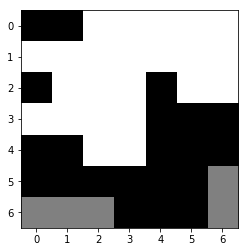

((4, 3), (6, 2)): n_v:  2636 q_all:+0.223705 q:+0.236112 q_m:+0.333333 p:0.282350
((4, 3), (6, 1)): n_v:  1215 q_all:+0.138109 q:+0.348798 q_m:+0.266667 p:0.161226
((4, 2), (6, 1)): n_v:   442 q_all:-0.133502 q:-0.002845 q_m:+0.266667 p:0.483250
((4, 2), (6, 2)): n_v:    62 q_all:-0.113120 q:-0.021216 q_m:+0.333333 p:0.064143
((4, 2), (6, 0)): n_v:     5 q_all:-0.047413 q:+0.049818 q_m:+0.200000 p:0.004341
-1 's turn
one move takes time(s):  0.17029619216918945
train_mode is both train
no. of data collected:  8


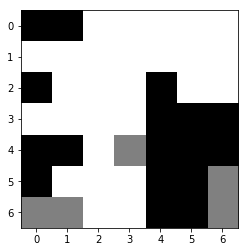

((2, 4), (4, 3)): n_v:  2918 q_all:+0.003052 q:-0.226940 q_m:-0.000000 p:0.002491
((3, 4), (4, 3)): n_v:   994 q_all:-0.251317 q:+0.009205 q_m:+0.033333 p:0.309481
((6, 4), (4, 3)): n_v:    97 q_all:-0.329935 q:-0.264419 q_m:-0.000000 p:0.060541
((6, 5), (4, 3)): n_v:    45 q_all:-0.319509 q:-0.117387 q_m:-0.000000 p:0.026186
((5, 5), (4, 3)): n_v:    36 q_all:-0.367223 q:-0.206046 q_m:-0.000000 p:0.027637
((4, 5), (4, 3)): n_v:    14 q_all:-0.453150 q:-0.411015 q_m:-0.000000 p:0.016407
((3, 5), (4, 3)): n_v:    12 q_all:-0.410678 q:-0.304353 q_m:-0.000000 p:0.012106
((4, 1), (4, 3)): n_v:     9 q_all:-0.435570 q:-0.282720 q_m:-0.000000 p:0.010261
((4, 0), (6, 1)): n_v:     4 q_all:-0.517294 q:-0.545351 q_m:-0.133333 p:0.006203
((5, 0), (6, 1)): n_v:     1 q_all:-0.496328 q:-0.472107 q_m:-0.100000 p:0.002092
((4, 4), (6, 6)): n_v:     0 q_all:-0.659808 q:-0.659808 q_m:-0.333333 p:0.000038
((5, 5), (6, 6)): n_v:     0 q_all:-0.664028 q:-0.664028 q_m:-0.300000 p:0.000001
((4, 4), (5, 6))

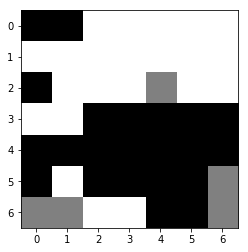

((1, 3), (2, 4)): n_v:  3687 q_all:+0.146122 q:+0.166711 q_m:+0.233333 p:0.180963
((5, 1), (6, 1)): n_v:   503 q_all:+0.019090 q:+0.206821 q_m:+0.166667 p:0.003533
((1, 6), (2, 4)): n_v:   278 q_all:-0.000049 q:+0.012513 q_m:+0.200000 p:0.021733
((0, 6), (2, 4)): n_v:    46 q_all:-0.031640 q:+0.088613 q_m:+0.200000 p:0.008664
((2, 6), (2, 4)): n_v:    43 q_all:-0.028951 q:+0.006954 q_m:+0.200000 p:0.008014
((0, 3), (2, 4)): n_v:    39 q_all:-0.044221 q:-0.144269 q_m:+0.200000 p:0.009581
((0, 5), (2, 4)): n_v:    35 q_all:-0.081808 q:+0.023212 q_m:+0.200000 p:0.012994
((0, 2), (2, 4)): n_v:    33 q_all:-0.024464 q:+0.011022 q_m:+0.200000 p:0.005672
((0, 4), (2, 4)): n_v:     9 q_all:-0.086737 q:+0.027446 q_m:+0.200000 p:0.003713
((2, 2), (2, 4)): n_v:     3 q_all:-0.221687 q:-0.178011 q_m:+0.200000 p:0.002674
((1, 2), (2, 4)): n_v:     1 q_all:-0.244641 q:-0.133177 q_m:+0.200000 p:0.001959
((6, 2), (6, 0)): n_v:     0 q_all:-0.481240 q:-0.481240 q_m:+0.066667 p:0.000015
((5, 1), (6, 0))

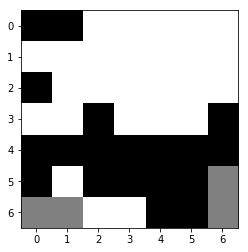

((5, 0), (6, 1)): n_v:  4539 q_all:-0.001025 q:+0.146923 q_m:-0.066667 p:0.367404
((4, 0), (6, 1)): n_v:    47 q_all:-0.388749 q:-0.195590 q_m:-0.100000 p:0.048096
((4, 3), (6, 1)): n_v:    42 q_all:-0.512778 q:-0.368541 q_m:-0.100000 p:0.059881
((5, 3), (6, 1)): n_v:    38 q_all:-0.594965 q:-0.458904 q_m:-0.100000 p:0.064442
((6, 4), (5, 6)): n_v:    15 q_all:-0.640529 q:-0.627790 q_m:-0.233333 p:0.027177
((4, 2), (6, 1)): n_v:     6 q_all:-0.482429 q:-0.312828 q_m:-0.100000 p:0.008219
((5, 0), (6, 0)): n_v:     6 q_all:-0.416358 q:-0.209039 q_m:-0.133333 p:0.006857
((3, 6), (5, 6)): n_v:     4 q_all:-0.478537 q:-0.449225 q_m:-0.233333 p:0.006437
((4, 1), (6, 1)): n_v:     4 q_all:-0.494965 q:-0.376678 q_m:-0.100000 p:0.006025
((4, 5), (5, 6)): n_v:     3 q_all:-0.673230 q:-0.489602 q_m:-0.200000 p:0.006358
((6, 4), (6, 6)): n_v:     3 q_all:-0.595173 q:-0.562009 q_m:-0.233333 p:0.005289
((5, 5), (6, 6)): n_v:     1 q_all:-0.662737 q:-0.474978 q_m:-0.200000 p:0.001766
((5, 4), (5, 6))

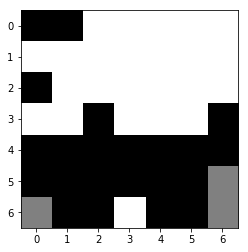

((3, 5), (5, 6)): n_v:  3426 q_all:-0.205328 q:+0.307659 q_m:+0.333333 p:0.791378
((3, 4), (5, 6)): n_v:  1769 q_all:-0.159104 q:+0.178661 q_m:+0.333333 p:0.203303
-1 's turn


This is a random move


one move takes time(s):  0.05576133728027344
train_mode is both train
no. of data collected:  8


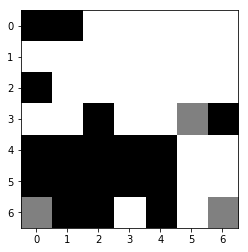

((3, 6), (3, 5)): n_v:  3692 q_all:+0.763830 q:+0.381750 q_m:+0.100000 p:0.453327
((5, 4), (3, 5)): n_v:     8 q_all:-0.216810 q:-0.216810 q_m:+0.066667 p:0.023366
((5, 3), (3, 5)): n_v:     4 q_all:-0.374886 q:-0.374886 q_m:+0.066667 p:0.014644
((4, 3), (3, 5)): n_v:     3 q_all:-0.301035 q:-0.301035 q_m:+0.066667 p:0.010608
((6, 4), (6, 6)): n_v:     1 q_all:-0.670798 q:-0.670798 q_m:-0.133333 p:0.004756
((5, 4), (6, 6)): n_v:     0 q_all:-0.580780 q:-0.580780 q_m:-0.133333 p:0.000906
((4, 4), (6, 6)): n_v:     0 q_all:-0.510242 q:-0.510242 q_m:-0.133333 p:0.003455
((5, 0), (6, 0)): n_v:     0 q_all:-0.688974 q:-0.688974 q_m:-0.300000 p:0.001738
((4, 2), (6, 0)): n_v:     0 q_all:-0.772749 q:-0.772749 q_m:-0.333333 p:0.001683
((4, 0), (6, 0)): n_v:     0 q_all:-0.717040 q:-0.717040 q_m:-0.333333 p:0.000847
((6, 2), (6, 0)): n_v:     0 q_all:-0.924597 q:-0.924597 q_m:-0.333333 p:0.004357
((4, 1), (6, 0)): n_v:     0 q_all:-0.854305 q:-0.854305 q_m:-0.333333 p:0.000121
((5, 2), (6, 0))

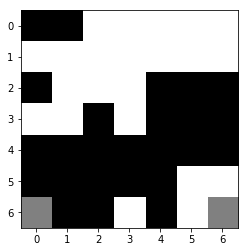

((5, 5), (6, 6)): n_v:  4490 q_all:-0.931200 q:-0.820875 q_m:-0.066667 p:0.257276
-1 's turn


This is a random move


one move takes time(s):  0.04210400581359863
train_mode is both train
no. of data collected:  8


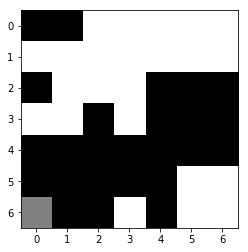

((5, 0), (6, 0)): n_v:  5113 q_all:+1.000000 q:+5.000000 q_m:+0.100000 p:0.205037
((6, 2), (6, 0)): n_v:    85 q_all:+0.026732 q:+0.243647 q_m:+0.066667 p:0.213090
((4, 0), (6, 0)): n_v:    75 q_all:+0.100511 q:+0.306857 q_m:+0.066667 p:0.175879
((4, 1), (6, 0)): n_v:     3 q_all:-0.420233 q:-0.226977 q_m:+0.066667 p:0.010585
((5, 2), (6, 0)): n_v:     3 q_all:-0.453475 q:-0.271300 q_m:+0.066667 p:0.011427
((4, 2), (6, 0)): n_v:     1 q_all:-0.442313 q:-0.442313 q_m:+0.066667 p:0.007223
this self play has 81 steps, time elapsed 98.13960528373718
winner is -1.0
episode 121 finished
episode 122 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.356842041015625
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.507392406463623
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7544364929199219
train_mode is both train
no. of data collected:  8
1 's turn




one move takes time(s):  0.2511746883392334
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5811665058135986
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3971686363220215
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3983902931213379
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.17356395721435547
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.288311243057251
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.22597289085388184
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.1582036018371582
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.19969797134399414
train_mode is both train
no. of data collected:  8
-1 's t

one move takes time(s):  0.4528350830078125
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6907200813293457
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9547781944274902
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8391475677490234
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.58052659034729
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.025111198425293
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5946259498596191
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.6356840133666992
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5667901039123535
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7

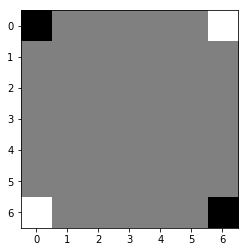

((6, 6), (5, 5)): n_v:   670 q_all:+0.009986 q:+0.016140 q_m:+0.033333 p:0.364975
((0, 0), (1, 1)): n_v:   635 q_all:+0.004312 q:+0.012143 q_m:+0.033333 p:0.363523
((6, 6), (6, 5)): n_v:   144 q_all:-0.000570 q:+0.002785 q_m:+0.033333 p:0.085772
((0, 0), (0, 1)): n_v:   143 q_all:-0.003200 q:-0.013396 q_m:+0.033333 p:0.087219
((6, 6), (5, 6)): n_v:    84 q_all:+0.004623 q:+0.005102 q_m:+0.033333 p:0.047997
((0, 0), (1, 0)): n_v:    84 q_all:+0.003541 q:+0.010937 q_m:+0.033333 p:0.048857
((6, 6), (6, 4)): n_v:     0 q_all:-0.000488 q:-0.000488 q_m:-0.000000 p:0.000033
((0, 0), (1, 2)): n_v:     0 q_all:-0.017719 q:-0.017719 q_m:-0.000000 p:0.000070
((0, 0), (2, 2)): n_v:     0 q_all:-0.025517 q:-0.025517 q_m:-0.000000 p:0.000217
((0, 0), (0, 2)): n_v:     0 q_all:-0.028375 q:-0.028375 q_m:-0.000000 p:0.000035
((6, 6), (4, 6)): n_v:     0 q_all:-0.018790 q:-0.018790 q_m:-0.000000 p:0.000169
((6, 6), (5, 4)): n_v:     0 q_all:+0.007464 q:+0.007464 q_m:-0.000000 p:0.000121
((6, 6), (4, 4))

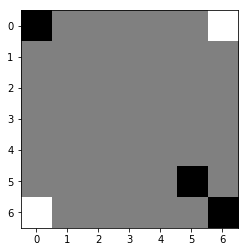

((0, 6), (1, 5)): n_v:   689 q_all:-0.010499 q:-0.003692 q_m:-0.000000 p:0.275129
((6, 0), (5, 1)): n_v:   602 q_all:-0.015492 q:-0.002931 q_m:-0.000000 p:0.252431
((6, 0), (5, 0)): n_v:   423 q_all:-0.010297 q:-0.000105 q_m:-0.000000 p:0.168504
((0, 6), (1, 6)): n_v:   406 q_all:-0.014436 q:-0.009743 q_m:-0.000000 p:0.168410
((0, 6), (0, 5)): n_v:   163 q_all:-0.017661 q:-0.020598 q_m:-0.000000 p:0.069985
((6, 0), (6, 1)): n_v:   147 q_all:-0.017143 q:+0.002780 q_m:-0.000000 p:0.062842
((0, 6), (2, 4)): n_v:     0 q_all:-0.028337 q:-0.028337 q_m:-0.033333 p:0.000297
((6, 0), (6, 2)): n_v:     0 q_all:-0.014801 q:-0.014801 q_m:-0.033333 p:0.000270
((6, 0), (5, 2)): n_v:     0 q_all:-0.018884 q:-0.018884 q_m:-0.033333 p:0.000144
((6, 0), (4, 1)): n_v:     0 q_all:-0.005162 q:-0.005162 q_m:-0.033333 p:0.000220
((0, 6), (2, 6)): n_v:     0 q_all:-0.002725 q:-0.002725 q_m:-0.033333 p:0.000367
((0, 6), (0, 4)): n_v:     0 q_all:-0.027298 q:-0.027298 q_m:-0.033333 p:0.000149
((0, 6), (2, 5))

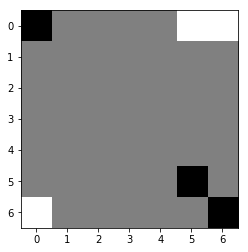

((0, 0), (1, 1)): n_v:  1025 q_all:+0.001502 q:+0.012184 q_m:+0.033333 p:0.471809
((5, 5), (4, 4)): n_v:   202 q_all:+0.000557 q:+0.019253 q_m:+0.033333 p:0.094282
((5, 5), (4, 5)): n_v:   153 q_all:-0.007816 q:-0.001435 q_m:+0.033333 p:0.077013
((0, 0), (0, 1)): n_v:   119 q_all:-0.005793 q:-0.009166 q_m:+0.033333 p:0.058926
((5, 5), (6, 5)): n_v:   111 q_all:-0.007281 q:-0.003864 q_m:+0.033333 p:0.055558
((0, 0), (1, 0)): n_v:    98 q_all:-0.000939 q:+0.012165 q_m:+0.033333 p:0.046567
((5, 5), (5, 6)): n_v:    96 q_all:-0.001503 q:+0.005924 q_m:+0.033333 p:0.045690
((5, 5), (4, 6)): n_v:    63 q_all:-0.006543 q:+0.017442 q_m:+0.033333 p:0.031459
((5, 5), (5, 4)): n_v:    32 q_all:-0.001370 q:+0.030626 q_m:+0.033333 p:0.015529
((5, 5), (6, 4)): n_v:    24 q_all:+0.000942 q:+0.031071 q_m:+0.033333 p:0.011477
((5, 5), (3, 6)): n_v:     0 q_all:-0.008638 q:-0.008638 q_m:-0.000000 p:0.000188
((5, 5), (5, 3)): n_v:     0 q_all:-0.021592 q:-0.021592 q_m:-0.000000 p:0.000026
((0, 0), (0, 2))

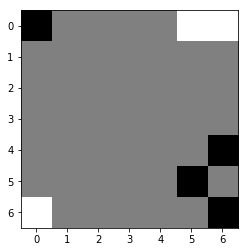

((6, 0), (5, 0)): n_v:   936 q_all:-0.010272 q:-0.004545 q_m:-0.000000 p:0.405077
((0, 5), (1, 6)): n_v:   347 q_all:-0.019599 q:-0.011046 q_m:-0.000000 p:0.165443
((6, 0), (5, 1)): n_v:   250 q_all:-0.018744 q:-0.005508 q_m:-0.000000 p:0.118586
((6, 0), (6, 1)): n_v:   133 q_all:-0.018494 q:-0.001726 q_m:-0.000000 p:0.062918
((0, 5), (1, 5)): n_v:   107 q_all:-0.017613 q:-0.016797 q_m:-0.000000 p:0.049903
((0, 5), (0, 4)): n_v:    23 q_all:-0.038144 q:-0.015602 q_m:-0.000000 p:0.013030
((0, 5), (1, 4)): n_v:    19 q_all:-0.020245 q:+0.001661 q_m:-0.000000 p:0.009580
((0, 5), (2, 6)): n_v:     4 q_all:-0.034970 q:-0.006143 q_m:-0.033333 p:0.002468
((0, 5), (2, 5)): n_v:     1 q_all:-0.016241 q:-0.004284 q_m:-0.033333 p:0.000479
((6, 0), (4, 1)): n_v:     1 q_all:-0.037330 q:-0.012389 q_m:-0.033333 p:0.000954
((6, 0), (4, 0)): n_v:     1 q_all:-0.017917 q:+0.000627 q_m:-0.033333 p:0.000501
((0, 5), (2, 3)): n_v:     0 q_all:-0.037494 q:-0.037494 q_m:-0.033333 p:0.000065
((0, 6), (2, 4))

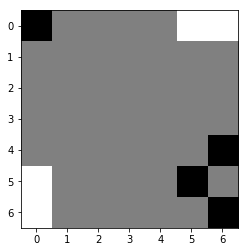

((0, 0), (1, 1)): n_v:  1190 q_all:-0.004611 q:-0.001468 q_m:+0.033333 p:0.353586
((4, 6), (3, 5)): n_v:   332 q_all:+0.019291 q:-0.028175 q_m:+0.033333 p:0.067971
((4, 6), (4, 5)): n_v:   246 q_all:-0.010892 q:-0.038859 q_m:+0.033333 p:0.078994
((5, 5), (4, 4)): n_v:   209 q_all:-0.014216 q:-0.000546 q_m:+0.033333 p:0.069803
((5, 5), (6, 5)): n_v:   204 q_all:-0.012415 q:-0.025326 q_m:+0.033333 p:0.066678
((4, 6), (3, 6)): n_v:   168 q_all:+0.012115 q:-0.003843 q_m:+0.033333 p:0.039088
((0, 0), (0, 1)): n_v:   106 q_all:-0.012728 q:-0.024870 q_m:+0.033333 p:0.035026
((4, 6), (5, 6)): n_v:    81 q_all:-0.007764 q:-0.008593 q_m:+0.033333 p:0.025266
((0, 0), (1, 0)): n_v:    44 q_all:-0.009578 q:-0.005454 q_m:+0.033333 p:0.014217
((5, 5), (5, 4)): n_v:    44 q_all:-0.016302 q:+0.010611 q_m:+0.033333 p:0.015117
((5, 5), (6, 4)): n_v:    37 q_all:-0.007567 q:+0.012432 q_m:+0.033333 p:0.011716
((4, 6), (2, 4)): n_v:    14 q_all:-0.014001 q:-0.021722 q_m:-0.000000 p:0.004730
((4, 6), (6, 5))

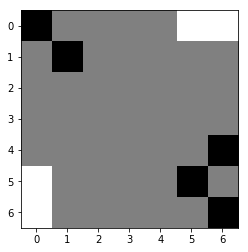

((5, 0), (4, 1)): n_v:   822 q_all:-0.006601 q:-0.018461 q_m:-0.000000 p:0.190502
((0, 5), (1, 6)): n_v:   611 q_all:-0.005528 q:-0.020425 q_m:-0.000000 p:0.139100
((5, 0), (4, 0)): n_v:   572 q_all:-0.006808 q:-0.016652 q_m:-0.000000 p:0.133166
((5, 0), (6, 1)): n_v:   270 q_all:-0.012739 q:-0.021784 q_m:-0.000000 p:0.068710
((5, 0), (5, 1)): n_v:   255 q_all:-0.011423 q:-0.019634 q_m:-0.000000 p:0.063832
((0, 5), (1, 5)): n_v:   214 q_all:-0.014276 q:-0.026805 q_m:-0.000000 p:0.055628
((0, 5), (1, 4)): n_v:   129 q_all:-0.001965 q:-0.010614 q_m:-0.000000 p:0.027900
((0, 5), (0, 4)): n_v:    47 q_all:-0.016416 q:-0.025440 q_m:-0.000000 p:0.012751
((0, 5), (2, 6)): n_v:     4 q_all:-0.041289 q:-0.016272 q_m:-0.033333 p:0.001686
((5, 0), (3, 0)): n_v:     3 q_all:-0.045800 q:-0.030949 q_m:-0.033333 p:0.001169
((5, 0), (3, 1)): n_v:     3 q_all:-0.056975 q:-0.031267 q_m:-0.033333 p:0.001552
((0, 5), (2, 5)): n_v:     1 q_all:-0.044318 q:-0.013768 q_m:-0.033333 p:0.000451
((5, 0), (3, 2))

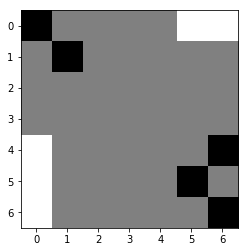

((4, 6), (3, 5)): n_v:   984 q_all:+0.030339 q:-0.024447 q_m:+0.033333 p:0.325352
((4, 6), (3, 6)): n_v:   354 q_all:+0.028300 q:+0.000335 q_m:+0.033333 p:0.120291
((4, 6), (4, 5)): n_v:   167 q_all:-0.007827 q:-0.034586 q_m:+0.033333 p:0.082759
((1, 1), (2, 1)): n_v:   108 q_all:-0.017650 q:-0.011206 q_m:+0.033333 p:0.058241
((5, 5), (4, 4)): n_v:   101 q_all:+0.006273 q:+0.005151 q_m:+0.033333 p:0.044104
((1, 1), (2, 0)): n_v:    75 q_all:-0.015442 q:-0.011313 q_m:+0.033333 p:0.039610
((5, 5), (6, 5)): n_v:    58 q_all:-0.010712 q:-0.020144 q_m:+0.033333 p:0.029385
((1, 1), (2, 2)): n_v:    58 q_all:-0.006900 q:-0.025891 q_m:+0.033333 p:0.028146
((4, 6), (5, 6)): n_v:    37 q_all:+0.007808 q:-0.004102 q_m:+0.033333 p:0.015913
((5, 5), (5, 4)): n_v:    34 q_all:+0.006064 q:+0.015927 q_m:+0.033333 p:0.014861
((0, 0), (0, 1)): n_v:    26 q_all:-0.014794 q:-0.030579 q_m:+0.033333 p:0.013734
((5, 5), (6, 4)): n_v:    18 q_all:+0.005473 q:+0.020113 q_m:+0.033333 p:0.007954
((1, 1), (1, 2))

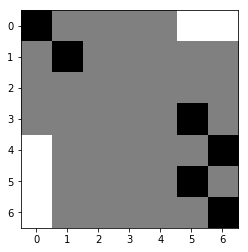

((4, 0), (3, 1)): n_v:   927 q_all:-0.026073 q:-0.009494 q_m:-0.000000 p:0.224598
((4, 0), (3, 0)): n_v:   498 q_all:-0.032312 q:-0.014316 q_m:-0.000000 p:0.132957
((4, 0), (4, 1)): n_v:   330 q_all:-0.079672 q:-0.042331 q_m:-0.000000 p:0.149918
((4, 0), (2, 2)): n_v:   106 q_all:-0.033733 q:-0.004859 q_m:+0.033333 p:0.028688
((0, 5), (2, 4)): n_v:    99 q_all:+0.012162 q:-0.002633 q_m:+0.033333 p:0.008883
((0, 5), (1, 6)): n_v:    84 q_all:-0.119381 q:-0.019317 q_m:-0.000000 p:0.051211
((4, 0), (2, 1)): n_v:    73 q_all:-0.046114 q:+0.002133 q_m:+0.033333 p:0.023246
((0, 5), (2, 6)): n_v:    45 q_all:-0.029178 q:+0.024722 q_m:+0.033333 p:0.011642
((0, 5), (2, 5)): n_v:    44 q_all:-0.038392 q:+0.021380 q_m:+0.033333 p:0.013067
((4, 0), (5, 1)): n_v:    40 q_all:-0.061891 q:-0.034302 q_m:-0.000000 p:0.015011
((4, 0), (2, 0)): n_v:    39 q_all:-0.020265 q:+0.023229 q_m:+0.033333 p:0.008726
((0, 6), (2, 4)): n_v:    34 q_all:+0.006525 q:-0.002905 q_m:+0.033333 p:0.003587
((0, 5), (1, 5))

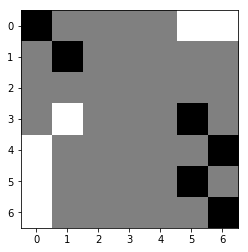

((3, 5), (1, 5)): n_v:  1177 q_all:+0.015873 q:+0.068199 q_m:+0.133333 p:0.359829
((1, 1), (2, 1)): n_v:   246 q_all:-0.026216 q:-0.005452 q_m:+0.100000 p:0.116628
((3, 5), (4, 5)): n_v:   214 q_all:+0.006257 q:-0.030254 q_m:+0.033333 p:0.073800
((1, 1), (2, 0)): n_v:   137 q_all:+0.003122 q:-0.002500 q_m:+0.100000 p:0.048972
((3, 5), (2, 6)): n_v:   133 q_all:-0.000784 q:+0.003589 q_m:+0.033333 p:0.049600
((3, 5), (2, 5)): n_v:   127 q_all:+0.021999 q:+0.015291 q_m:+0.033333 p:0.035965
((1, 1), (3, 0)): n_v:    82 q_all:-0.032095 q:+0.015400 q_m:+0.133333 p:0.040793
((3, 5), (1, 6)): n_v:    69 q_all:+0.061821 q:+0.071716 q_m:+0.133333 p:0.008442
((3, 5), (2, 4)): n_v:    66 q_all:+0.022091 q:-0.000424 q_m:+0.033333 p:0.018637
((3, 5), (4, 4)): n_v:    42 q_all:-0.002204 q:-0.003369 q_m:+0.033333 p:0.016100
((1, 1), (2, 2)): n_v:    39 q_all:+0.014498 q:+0.011919 q_m:+0.100000 p:0.012334
((3, 5), (5, 6)): n_v:    37 q_all:-0.007908 q:+0.001357 q_m:-0.000000 p:0.015082
((3, 5), (3, 6))

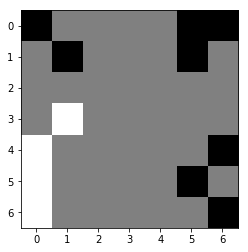

((3, 1), (1, 0)): n_v:  2283 q_all:-0.025693 q:-0.032552 q_m:-0.000000 p:0.677387
((3, 1), (1, 2)): n_v:   122 q_all:-0.067401 q:-0.102297 q_m:-0.066667 p:0.055287
((3, 1), (5, 1)): n_v:    99 q_all:-0.124431 q:-0.146050 q_m:-0.133333 p:0.065632
((3, 1), (2, 0)): n_v:    87 q_all:-0.054609 q:-0.092084 q_m:-0.033333 p:0.035198
((3, 1), (2, 2)): n_v:    50 q_all:-0.046712 q:-0.094600 q_m:-0.033333 p:0.018705
((4, 0), (5, 1)): n_v:    35 q_all:-0.075897 q:-0.124556 q_m:-0.100000 p:0.016927
((3, 1), (3, 0)): n_v:    29 q_all:-0.105397 q:-0.146721 q_m:-0.100000 p:0.017550
((3, 1), (2, 1)): n_v:    24 q_all:-0.069061 q:-0.113543 q_m:-0.033333 p:0.011196
((3, 1), (5, 2)): n_v:    16 q_all:-0.123920 q:-0.131863 q_m:-0.133333 p:0.010991
((4, 0), (2, 0)): n_v:    16 q_all:-0.068112 q:-0.100603 q_m:-0.066667 p:0.007300
((5, 0), (6, 1)): n_v:    14 q_all:-0.083784 q:-0.125259 q_m:-0.100000 p:0.007483
((3, 1), (4, 2)): n_v:    13 q_all:-0.086230 q:-0.141174 q_m:-0.100000 p:0.006908
((3, 1), (4, 1))

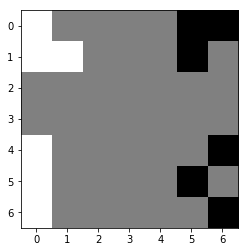

((4, 6), (3, 6)): n_v:  1051 q_all:+0.016641 q:-0.037796 q_m:+0.033333 p:0.198694
((1, 5), (2, 4)): n_v:   593 q_all:+0.018099 q:-0.006336 q_m:+0.033333 p:0.109466
((4, 6), (3, 5)): n_v:   483 q_all:-0.004440 q:-0.035241 q_m:+0.033333 p:0.124088
((1, 5), (2, 5)): n_v:   289 q_all:-0.006295 q:-0.010962 q_m:+0.033333 p:0.076093
((5, 5), (6, 5)): n_v:   270 q_all:+0.004999 q:-0.026044 q_m:+0.033333 p:0.061039
((0, 5), (1, 6)): n_v:   214 q_all:+0.002902 q:-0.029837 q_m:+0.033333 p:0.049927
((4, 6), (4, 5)): n_v:   155 q_all:+0.005035 q:-0.041265 q_m:+0.033333 p:0.035105
((0, 5), (0, 4)): n_v:   110 q_all:+0.014967 q:-0.027438 q_m:+0.033333 p:0.021582
((0, 5), (1, 4)): n_v:    80 q_all:-0.002749 q:-0.026280 q_m:+0.033333 p:0.020274
((4, 6), (2, 5)): n_v:    78 q_all:-0.022342 q:-0.025012 q_m:-0.000000 p:0.024482
((4, 6), (2, 4)): n_v:    68 q_all:-0.003736 q:-0.020928 q_m:-0.000000 p:0.017338
((5, 5), (4, 4)): n_v:    62 q_all:+0.012850 q:+0.018166 q_m:+0.033333 p:0.012524
((1, 5), (2, 6))

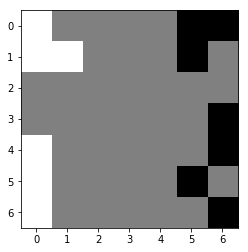

((4, 0), (3, 1)): n_v:   780 q_all:-0.046984 q:-0.084357 q_m:-0.000000 p:0.299489
((1, 1), (1, 2)): n_v:   407 q_all:+0.009592 q:-0.051071 q_m:-0.000000 p:0.066557
((1, 1), (0, 2)): n_v:   274 q_all:+0.000391 q:-0.046851 q_m:-0.000000 p:0.054870
((1, 1), (2, 2)): n_v:   247 q_all:-0.013266 q:-0.066200 q_m:-0.000000 p:0.062531
((4, 0), (3, 0)): n_v:   215 q_all:-0.046692 q:-0.052254 q_m:-0.000000 p:0.081915
((1, 0), (2, 1)): n_v:   159 q_all:-0.044776 q:-0.114598 q_m:-0.000000 p:0.059614
((0, 0), (0, 1)): n_v:   145 q_all:-0.020271 q:-0.054793 q_m:-0.000000 p:0.040609
((1, 0), (2, 0)): n_v:   110 q_all:-0.029633 q:-0.046546 q_m:-0.000000 p:0.034996
((4, 0), (4, 1)): n_v:    66 q_all:-0.059774 q:-0.079790 q_m:-0.000000 p:0.028756
((4, 0), (5, 1)): n_v:    26 q_all:-0.047165 q:-0.052392 q_m:-0.000000 p:0.009767
((4, 0), (2, 1)): n_v:    23 q_all:-0.080123 q:-0.156044 q_m:-0.033333 p:0.011740
((5, 0), (6, 1)): n_v:    16 q_all:-0.055848 q:-0.059508 q_m:-0.000000 p:0.006734
((1, 0), (3, 1))

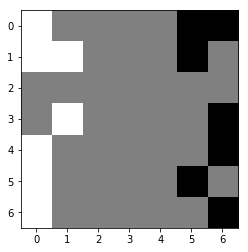

((1, 5), (2, 4)): n_v:   570 q_all:+0.028544 q:-0.010192 q_m:+0.033333 p:0.100699
((3, 6), (4, 5)): n_v:   291 q_all:+0.017803 q:-0.054689 q_m:+0.033333 p:0.064076
((1, 5), (2, 5)): n_v:   233 q_all:-0.007422 q:-0.021549 q_m:+0.033333 p:0.075726
((3, 6), (1, 6)): n_v:   171 q_all:-0.016602 q:-0.045727 q_m:-0.000000 p:0.061924
((3, 6), (3, 5)): n_v:   164 q_all:+0.000523 q:-0.048368 q_m:+0.033333 p:0.048108
((4, 6), (2, 4)): n_v:   132 q_all:+0.014760 q:-0.014219 q_m:-0.000000 p:0.030965
((1, 5), (2, 6)): n_v:   126 q_all:-0.008982 q:-0.056517 q_m:+0.033333 p:0.041810
((0, 5), (1, 6)): n_v:   123 q_all:+0.010168 q:-0.043843 q_m:+0.033333 p:0.031101
((5, 5), (4, 4)): n_v:    62 q_all:+0.000657 q:-0.000577 q_m:+0.033333 p:0.018336
((4, 6), (2, 5)): n_v:    50 q_all:-0.025367 q:-0.030957 q_m:-0.000000 p:0.020119
((3, 6), (5, 6)): n_v:    48 q_all:-0.016789 q:-0.048072 q_m:-0.000000 p:0.017560
((4, 6), (2, 6)): n_v:    33 q_all:-0.028915 q:-0.066289 q_m:-0.000000 p:0.013785
((5, 5), (6, 5))

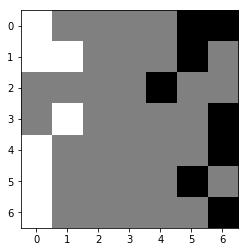

((3, 1), (3, 3)): n_v:  1048 q_all:+0.006439 q:+0.013455 q_m:+0.033333 p:0.403101
((1, 1), (3, 3)): n_v:   255 q_all:+0.030504 q:+0.008602 q_m:+0.033333 p:0.071931
((3, 1), (1, 3)): n_v:   149 q_all:+0.034007 q:+0.035517 q_m:+0.033333 p:0.039610
((3, 1), (2, 3)): n_v:   124 q_all:+0.011617 q:+0.003675 q_m:+0.033333 p:0.044989
((1, 1), (1, 3)): n_v:    89 q_all:+0.047025 q:+0.018248 q_m:+0.033333 p:0.018554
((3, 1), (3, 0)): n_v:    76 q_all:-0.032780 q:-0.068863 q_m:-0.000000 p:0.042296
((3, 1), (1, 2)): n_v:    56 q_all:-0.022549 q:-0.047164 q_m:-0.033333 p:0.028726
((3, 1), (5, 1)): n_v:    55 q_all:-0.043702 q:-0.047922 q_m:-0.033333 p:0.033055
((1, 1), (1, 2)): n_v:    47 q_all:-0.062495 q:-0.053393 q_m:-0.000000 p:0.032374
((1, 1), (2, 3)): n_v:    44 q_all:+0.012357 q:-0.006878 q_m:+0.033333 p:0.016158
((1, 1), (0, 2)): n_v:    43 q_all:-0.045235 q:-0.045640 q_m:-0.000000 p:0.026533
((0, 0), (0, 1)): n_v:    30 q_all:-0.030130 q:-0.039556 q_m:-0.000000 p:0.016760
((3, 1), (5, 3))

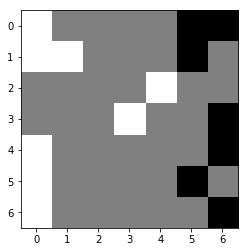

((1, 5), (2, 3)): n_v:  1061 q_all:+0.102765 q:+0.079328 q_m:+0.100000 p:0.112475
((0, 5), (2, 3)): n_v:   616 q_all:+0.085703 q:+0.059727 q_m:+0.100000 p:0.106406
((5, 5), (3, 4)): n_v:   223 q_all:-0.013963 q:+0.054104 q_m:+0.100000 p:0.125272
((1, 5), (3, 4)): n_v:   215 q_all:-0.000909 q:+0.034334 q_m:+0.100000 p:0.109556
((3, 6), (3, 4)): n_v:   120 q_all:-0.013856 q:+0.042075 q_m:+0.100000 p:0.067092
((3, 6), (3, 5)): n_v:    89 q_all:-0.074785 q:-0.027357 q_m:+0.066667 p:0.071238
((5, 5), (4, 3)): n_v:    73 q_all:-0.030583 q:-0.016366 q_m:+0.033333 p:0.046045
((4, 6), (3, 4)): n_v:    48 q_all:-0.010214 q:+0.051358 q_m:+0.100000 p:0.026616
((1, 5), (2, 5)): n_v:    33 q_all:-0.040708 q:-0.007024 q_m:+0.066667 p:0.021699
((5, 5), (4, 4)): n_v:    26 q_all:-0.036398 q:-0.010899 q_m:+0.066667 p:0.017319
((0, 5), (1, 4)): n_v:    16 q_all:-0.075875 q:-0.031752 q_m:+0.066667 p:0.013365
((3, 6), (4, 5)): n_v:    15 q_all:-0.119799 q:-0.104310 q_m:-0.000000 p:0.015423
((4, 6), (2, 5))

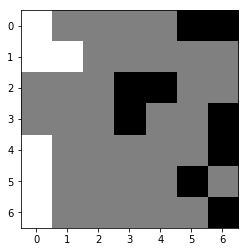

((1, 0), (3, 2)): n_v:   649 q_all:-0.134324 q:-0.046593 q_m:+0.033333 p:0.368854
((1, 1), (1, 2)): n_v:   601 q_all:+0.010536 q:-0.073681 q_m:-0.000000 p:0.010765
((1, 1), (3, 2)): n_v:   563 q_all:-0.110680 q:-0.012496 q_m:+0.033333 p:0.269884
((5, 0), (3, 2)): n_v:   165 q_all:-0.132664 q:-0.034773 q_m:+0.033333 p:0.092759
((1, 1), (2, 2)): n_v:   137 q_all:-0.059425 q:-0.008677 q_m:+0.066667 p:0.038840
((0, 0), (1, 2)): n_v:   136 q_all:+0.012013 q:-0.086592 q_m:-0.033333 p:0.001487
((1, 1), (1, 3)): n_v:   109 q_all:-0.026845 q:+0.015329 q_m:+0.033333 p:0.017450
((4, 0), (3, 1)): n_v:   102 q_all:-0.125135 q:-0.128066 q_m:-0.066667 p:0.054693
((4, 0), (3, 2)): n_v:    95 q_all:-0.137021 q:-0.036303 q_m:+0.033333 p:0.055239
((4, 0), (2, 2)): n_v:    81 q_all:-0.081853 q:-0.068033 q_m:+0.033333 p:0.029861
((1, 0), (1, 2)): n_v:    26 q_all:+0.000933 q:-0.108842 q_m:-0.033333 p:0.001276
((1, 0), (3, 1)): n_v:    19 q_all:-0.100611 q:-0.149849 q_m:-0.100000 p:0.008462
((1, 0), (2, 2))

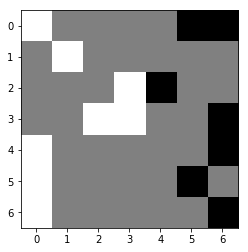

((2, 4), (2, 2)): n_v:  2166 q_all:+0.118539 q:+0.132531 q_m:+0.233333 p:0.865112
((2, 4), (4, 2)): n_v:   140 q_all:+0.035953 q:+0.070646 q_m:+0.100000 p:0.103024
((2, 4), (3, 4)): n_v:     8 q_all:+0.022046 q:+0.088885 q_m:+0.133333 p:0.006750
((2, 4), (1, 2)): n_v:     3 q_all:+0.034252 q:+0.041543 q_m:+0.100000 p:0.002747
((2, 4), (4, 4)): n_v:     3 q_all:+0.020366 q:+0.012983 q_m:+0.033333 p:0.003127
((5, 5), (3, 4)): n_v:     3 q_all:-0.017992 q:+0.083860 q_m:+0.100000 p:0.003035
((5, 5), (4, 4)): n_v:     2 q_all:+0.035047 q:+0.050843 q_m:+0.066667 p:0.002128
((5, 5), (4, 3)): n_v:     2 q_all:+0.062806 q:+0.071900 q_m:+0.100000 p:0.001685
((2, 4), (1, 3)): n_v:     1 q_all:+0.017375 q:+0.037846 q_m:+0.066667 p:0.000842
((4, 6), (4, 4)): n_v:     1 q_all:+0.029338 q:+0.042104 q_m:+0.033333 p:0.000839
((3, 6), (4, 4)): n_v:     1 q_all:+0.028404 q:+0.042679 q_m:+0.033333 p:0.001305
((3, 6), (3, 4)): n_v:     1 q_all:+0.025638 q:+0.072366 q_m:+0.100000 p:0.000785
((2, 4), (0, 2))

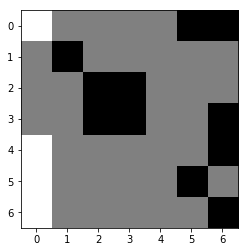

((4, 0), (3, 1)): n_v:  1201 q_all:-0.135418 q:-0.165352 q_m:-0.066667 p:0.338342
((4, 0), (2, 1)): n_v:   885 q_all:-0.114925 q:-0.198310 q_m:-0.033333 p:0.190049
((0, 0), (1, 2)): n_v:   638 q_all:-0.108600 q:-0.148099 q_m:-0.033333 p:0.124177
((0, 0), (2, 1)): n_v:   326 q_all:-0.118862 q:-0.193046 q_m:-0.033333 p:0.074371
((4, 0), (4, 1)): n_v:   166 q_all:-0.204827 q:-0.219406 q_m:-0.133333 p:0.084706
((5, 0), (3, 1)): n_v:   157 q_all:-0.139547 q:-0.181108 q_m:-0.100000 p:0.046586
((4, 0), (5, 2)): n_v:    17 q_all:-0.232286 q:-0.248765 q_m:-0.233333 p:0.010385
((4, 0), (3, 0)): n_v:    17 q_all:-0.178849 q:-0.251531 q_m:-0.200000 p:0.007200
((0, 0), (1, 0)): n_v:    13 q_all:-0.198100 q:-0.196103 q_m:-0.133333 p:0.006527
((4, 0), (2, 0)): n_v:    11 q_all:-0.213933 q:-0.246528 q_m:-0.166667 p:0.006190
((5, 0), (5, 2)): n_v:    11 q_all:-0.237606 q:-0.227407 q_m:-0.233333 p:0.007012
((6, 0), (4, 1)): n_v:    10 q_all:-0.205211 q:-0.229387 q_m:-0.166667 p:0.005185
((0, 0), (2, 0))

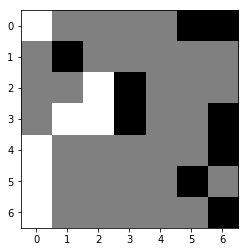

((3, 3), (2, 1)): n_v:   904 q_all:+0.123636 q:+0.128847 q_m:+0.266667 p:0.306117
((1, 1), (2, 1)): n_v:   488 q_all:+0.154518 q:+0.157611 q_m:+0.300000 p:0.108437
((3, 3), (2, 5)): n_v:   252 q_all:+0.046619 q:+0.062064 q_m:+0.066667 p:0.159125
((3, 3), (5, 1)): n_v:   219 q_all:+0.172674 q:+0.146112 q_m:+0.266667 p:0.033628
((2, 3), (2, 1)): n_v:   135 q_all:+0.153035 q:+0.112200 q_m:+0.266667 p:0.030864
((3, 6), (2, 5)): n_v:   112 q_all:+0.072714 q:+0.104309 q_m:+0.100000 p:0.059965
((2, 3), (4, 1)): n_v:    92 q_all:+0.141207 q:+0.160483 q_m:+0.333333 p:0.025037
((2, 3), (1, 5)): n_v:    91 q_all:+0.075188 q:+0.047078 q_m:+0.066667 p:0.047675
((3, 3), (4, 1)): n_v:    90 q_all:+0.139473 q:+0.162183 q_m:+0.333333 p:0.025114
((2, 3), (0, 1)): n_v:    59 q_all:+0.056313 q:+0.105947 q_m:+0.133333 p:0.035101
((3, 3), (1, 5)): n_v:    58 q_all:+0.055480 q:+0.032386 q_m:+0.066667 p:0.034683
((3, 3), (4, 5)): n_v:    33 q_all:+0.049122 q:+0.039466 q_m:+0.066667 p:0.020357
((2, 3), (4, 5))

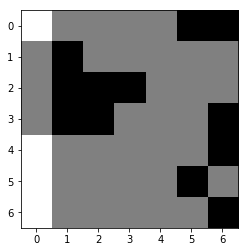

((0, 0), (1, 2)): n_v:  2061 q_all:-0.115393 q:-0.136648 q_m:-0.000000 p:0.622970
((0, 0), (1, 0)): n_v:   107 q_all:-0.182925 q:-0.264013 q_m:-0.100000 p:0.060830
((4, 0), (4, 1)): n_v:   105 q_all:-0.186533 q:-0.211621 q_m:-0.100000 p:0.061021
((6, 0), (5, 2)): n_v:    85 q_all:-0.248819 q:-0.254095 q_m:-0.266667 p:0.069401
((6, 0), (4, 1)): n_v:    48 q_all:-0.202933 q:-0.213461 q_m:-0.133333 p:0.031236
((4, 0), (5, 2)): n_v:    15 q_all:-0.269065 q:-0.286736 q_m:-0.266667 p:0.013992
((4, 0), (3, 0)): n_v:    14 q_all:-0.201193 q:-0.254032 q_m:-0.100000 p:0.008689
((5, 0), (5, 2)): n_v:    13 q_all:-0.288700 q:-0.267679 q_m:-0.266667 p:0.013185
((0, 0), (2, 0)): n_v:     8 q_all:-0.208666 q:-0.232514 q_m:-0.066667 p:0.005927
((4, 0), (2, 0)): n_v:     7 q_all:-0.204124 q:-0.230580 q_m:-0.066667 p:0.004645
((4, 0), (5, 1)): n_v:     3 q_all:-0.225294 q:-0.292410 q_m:-0.233333 p:0.002857
((6, 0), (4, 2)): n_v:     1 q_all:-0.262409 q:-0.242837 q_m:-0.133333 p:0.001318
((0, 0), (0, 1))

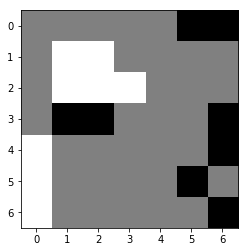

((3, 2), (1, 3)): n_v:  1386 q_all:+0.119731 q:+0.118588 q_m:+0.200000 p:0.286018
((3, 1), (1, 3)): n_v:   819 q_all:+0.119832 q:+0.085851 q_m:+0.200000 p:0.168686
((3, 2), (5, 1)): n_v:   587 q_all:+0.048872 q:+0.086348 q_m:+0.200000 p:0.258934
((3, 2), (5, 3)): n_v:   144 q_all:+0.019798 q:+0.020734 q_m:-0.000000 p:0.077793
((3, 2), (2, 0)): n_v:   115 q_all:+0.083680 q:+0.029135 q_m:+0.133333 p:0.037643
((3, 2), (3, 3)): n_v:   113 q_all:+0.101833 q:+0.117884 q_m:+0.166667 p:0.030147
((0, 5), (1, 3)): n_v:    82 q_all:+0.104332 q:+0.102307 q_m:+0.200000 p:0.021264
((3, 1), (1, 0)): n_v:    55 q_all:+0.095424 q:+0.043042 q_m:+0.133333 p:0.015767
((3, 1), (5, 1)): n_v:    52 q_all:+0.069394 q:+0.103298 q_m:+0.200000 p:0.019552
((3, 1), (5, 3)): n_v:    36 q_all:+0.021381 q:+0.014775 q_m:-0.000000 p:0.019162
((3, 2), (3, 4)): n_v:    31 q_all:+0.074499 q:+0.061274 q_m:+0.066667 p:0.010858
((3, 2), (1, 4)): n_v:    26 q_all:+0.065981 q:+0.061695 q_m:+0.066667 p:0.010143
((3, 2), (1, 0))

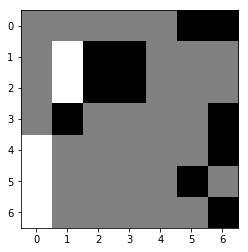

((2, 1), (3, 2)): n_v:  2641 q_all:-0.140033 q:-0.134347 q_m:+0.033333 p:0.852219
((1, 1), (0, 2)): n_v:   144 q_all:-0.142965 q:-0.210727 q_m:-0.033333 p:0.048119
((5, 0), (3, 2)): n_v:   120 q_all:-0.152580 q:-0.145123 q_m:-0.000000 p:0.044212
((1, 1), (3, 2)): n_v:    60 q_all:-0.150687 q:-0.154356 q_m:-0.000000 p:0.021740
((4, 0), (3, 2)): n_v:    17 q_all:-0.160031 q:-0.148346 q_m:-0.000000 p:0.006657
((1, 1), (0, 0)): n_v:    15 q_all:-0.201120 q:-0.263054 q_m:-0.166667 p:0.008315
((4, 0), (4, 1)): n_v:     3 q_all:-0.193431 q:-0.236106 q_m:-0.100000 p:0.002008
((2, 1), (0, 2)): n_v:     3 q_all:-0.154035 q:-0.214159 q_m:-0.066667 p:0.001114
((1, 1), (2, 0)): n_v:     2 q_all:-0.154136 q:-0.249043 q_m:-0.100000 p:0.001027
((4, 0), (5, 1)): n_v:     1 q_all:-0.260501 q:-0.289983 q_m:-0.166667 p:0.001394
((2, 1), (3, 3)): n_v:     1 q_all:-0.181783 q:-0.127835 q_m:-0.066667 p:0.000518
((5, 0), (4, 2)): n_v:     0 q_all:-0.226805 q:-0.226805 q_m:-0.133333 p:0.000034
((1, 1), (3, 0))

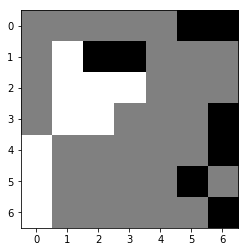

((5, 5), (3, 3)): n_v:  3818 q_all:+0.115127 q:+0.103893 q_m:+0.166667 p:0.953826
((1, 3), (3, 3)): n_v:    71 q_all:+0.100042 q:+0.086978 q_m:+0.166667 p:0.021201
((1, 2), (3, 3)): n_v:    17 q_all:+0.073121 q:+0.113525 q_m:+0.166667 p:0.006627
((1, 2), (0, 1)): n_v:     3 q_all:+0.073544 q:+0.056882 q_m:+0.066667 p:0.001132
((1, 3), (0, 1)): n_v:     2 q_all:+0.028205 q:+0.033777 q_m:+0.033333 p:0.001033
((3, 6), (2, 5)): n_v:     2 q_all:+0.009480 q:+0.034900 q_m:-0.000000 p:0.001349
((3, 6), (3, 5)): n_v:     2 q_all:+0.017596 q:+0.005227 q_m:-0.000000 p:0.001320
((1, 2), (3, 4)): n_v:     1 q_all:+0.039910 q:+0.029310 q_m:+0.033333 p:0.000563
((3, 6), (2, 6)): n_v:     1 q_all:+0.002911 q:+0.024669 q_m:-0.000000 p:0.001156
((0, 6), (2, 5)): n_v:     1 q_all:-0.026054 q:+0.007817 q_m:-0.033333 p:0.000885
((1, 3), (2, 5)): n_v:     1 q_all:+0.018724 q:+0.018931 q_m:-0.033333 p:0.000654
((0, 5), (1, 5)): n_v:     1 q_all:+0.023886 q:+0.017468 q_m:-0.000000 p:0.000666
((5, 5), (6, 5))

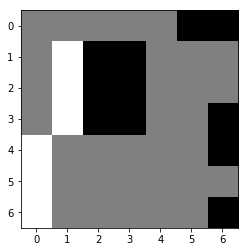

((1, 1), (0, 2)): n_v:  2417 q_all:-0.083369 q:-0.161180 q_m:-0.000000 p:0.329752
((3, 1), (4, 2)): n_v:  1371 q_all:-0.110236 q:-0.141364 q_m:-0.000000 p:0.287243
((2, 1), (4, 2)): n_v:   163 q_all:-0.114195 q:-0.144681 q_m:-0.033333 p:0.036065
((2, 1), (0, 2)): n_v:   124 q_all:-0.101178 q:-0.172331 q_m:-0.033333 p:0.022786
((1, 1), (0, 0)): n_v:   119 q_all:-0.166364 q:-0.194612 q_m:-0.133333 p:0.043136
((4, 0), (5, 1)): n_v:   107 q_all:-0.185234 q:-0.216459 q_m:-0.133333 p:0.044515
((3, 1), (4, 3)): n_v:    90 q_all:-0.062348 q:-0.137376 q_m:-0.033333 p:0.007091
((5, 0), (4, 2)): n_v:    88 q_all:-0.071539 q:-0.149732 q_m:-0.033333 p:0.009102
((6, 0), (4, 2)): n_v:    64 q_all:-0.129456 q:-0.159559 q_m:-0.033333 p:0.016800
((4, 0), (4, 2)): n_v:    55 q_all:-0.102859 q:-0.163374 q_m:-0.033333 p:0.010353
((1, 1), (0, 1)): n_v:    54 q_all:-0.123975 q:-0.193349 q_m:-0.066667 p:0.012920
((3, 1), (5, 1)): n_v:    31 q_all:-0.140587 q:-0.202978 q_m:-0.166667 p:0.008947
((2, 1), (4, 3))

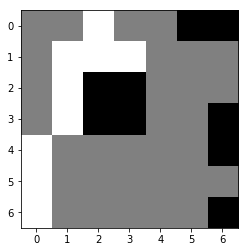

((2, 3), (0, 1)): n_v:  1707 q_all:+0.051859 q:+0.059975 q_m:+0.200000 p:0.512207
((0, 5), (0, 3)): n_v:   578 q_all:+0.085696 q:+0.084289 q_m:+0.200000 p:0.111628
((2, 3), (0, 3)): n_v:   571 q_all:+0.045143 q:+0.073220 q_m:+0.200000 p:0.183528
((2, 2), (0, 3)): n_v:   153 q_all:+0.047238 q:+0.088212 q_m:+0.200000 p:0.048449
((3, 2), (5, 1)): n_v:    78 q_all:+0.081792 q:+0.095290 q_m:+0.200000 p:0.016179
((3, 2), (2, 0)): n_v:    71 q_all:+0.041441 q:+0.070325 q_m:+0.200000 p:0.023943
((3, 2), (4, 1)): n_v:    65 q_all:+0.131552 q:+0.128282 q_m:+0.233333 p:0.002982
((2, 2), (0, 1)): n_v:    58 q_all:+0.081578 q:+0.095303 q_m:+0.200000 p:0.012167
((3, 3), (5, 1)): n_v:    39 q_all:+0.065538 q:+0.080879 q_m:+0.200000 p:0.010164
((2, 2), (0, 0)): n_v:    25 q_all:+0.007867 q:+0.024507 q_m:+0.066667 p:0.011152
((2, 2), (4, 1)): n_v:    15 q_all:+0.111908 q:+0.088761 q_m:+0.200000 p:0.001638
((3, 6), (2, 6)): n_v:    14 q_all:+0.000528 q:+0.035702 q_m:+0.033333 p:0.006831
((2, 3), (1, 5))

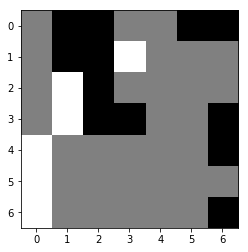

((1, 3), (2, 3)): n_v:  2750 q_all:-0.032955 q:-0.021479 q_m:+0.100000 p:0.871524
((3, 1), (2, 3)): n_v:    58 q_all:-0.043016 q:-0.064874 q_m:+0.066667 p:0.020582
((2, 1), (2, 3)): n_v:    58 q_all:-0.039843 q:-0.078254 q_m:+0.066667 p:0.020069
((1, 3), (1, 5)): n_v:    45 q_all:-0.027311 q:-0.058491 q_m:-0.066667 p:0.013444
((2, 1), (1, 0)): n_v:    34 q_all:-0.127867 q:-0.145785 q_m:-0.033333 p:0.022299
((3, 1), (1, 0)): n_v:    21 q_all:-0.117856 q:-0.138130 q_m:-0.066667 p:0.013112
((1, 3), (0, 3)): n_v:    15 q_all:-0.076309 q:-0.110032 q_m:-0.033333 p:0.007287
((1, 3), (2, 5)): n_v:    13 q_all:-0.092441 q:-0.082936 q_m:-0.133333 p:0.006945
((2, 1), (4, 3)): n_v:     6 q_all:-0.125981 q:-0.122928 q_m:-0.066667 p:0.004328
((2, 1), (2, 0)): n_v:     3 q_all:-0.154519 q:-0.215058 q_m:-0.100000 p:0.002567
((2, 1), (0, 3)): n_v:     3 q_all:-0.102399 q:-0.132101 q_m:-0.066667 p:0.001997
((3, 1), (4, 3)): n_v:     2 q_all:-0.163199 q:-0.118282 q_m:-0.066667 p:0.001829
((1, 3), (3, 5))

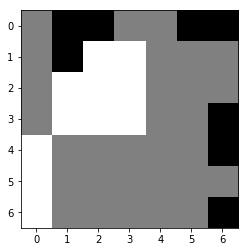

((0, 2), (0, 3)): n_v:  1587 q_all:+0.048008 q:+0.063100 q_m:+0.066667 p:0.352377
((0, 2), (2, 4)): n_v:  1530 q_all:+0.036672 q:+0.054957 q_m:+0.100000 p:0.392602
((0, 6), (2, 4)): n_v:   371 q_all:+0.018362 q:+0.060331 q_m:+0.100000 p:0.115976
((4, 6), (2, 4)): n_v:   148 q_all:+0.038262 q:+0.072432 q_m:+0.100000 p:0.036979
((0, 5), (2, 4)): n_v:   118 q_all:+0.049756 q:+0.045298 q_m:+0.100000 p:0.025737
((3, 6), (2, 4)): n_v:    57 q_all:+0.035388 q:+0.050291 q_m:+0.100000 p:0.014992
((0, 1), (0, 3)): n_v:    46 q_all:+0.041793 q:+0.026119 q_m:+0.033333 p:0.011214
((0, 5), (0, 3)): n_v:    28 q_all:+0.043912 q:+0.046512 q_m:+0.033333 p:0.006783
((6, 6), (4, 4)): n_v:    21 q_all:+0.004924 q:+0.059417 q_m:-0.033333 p:0.007737
((1, 1), (0, 3)): n_v:    19 q_all:-0.000942 q:+0.023525 q_m:+0.033333 p:0.006889
((0, 2), (0, 4)): n_v:    11 q_all:-0.022957 q:-0.033316 q_m:-0.033333 p:0.005006
((3, 6), (3, 4)): n_v:     8 q_all:+0.009763 q:+0.054251 q_m:+0.033333 p:0.002959
((0, 2), (1, 4))

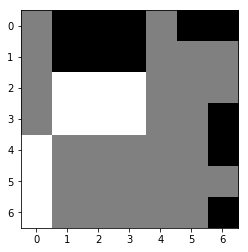

((2, 3), (1, 5)): n_v:  1151 q_all:-0.033905 q:-0.017529 q_m:+0.066667 p:0.419431
((3, 3), (1, 5)): n_v:   515 q_all:-0.002756 q:-0.002924 q_m:+0.066667 p:0.130908
((2, 1), (1, 0)): n_v:   503 q_all:-0.004659 q:-0.019056 q_m:+0.100000 p:0.131343
((3, 3), (5, 5)): n_v:   144 q_all:+0.002729 q:-0.015289 q_m:+0.066667 p:0.033485
((3, 1), (1, 0)): n_v:   108 q_all:+0.006096 q:-0.046938 q_m:+0.066667 p:0.024072
((3, 2), (1, 0)): n_v:    89 q_all:-0.016126 q:-0.073623 q_m:+0.066667 p:0.026247
((2, 3), (0, 4)): n_v:    80 q_all:-0.062855 q:-0.019110 q_m:+0.133333 p:0.037702
((2, 2), (0, 0)): n_v:    67 q_all:-0.124021 q:-0.059163 q_m:+0.066667 p:0.045882
((2, 3), (1, 4)): n_v:    63 q_all:-0.017431 q:+0.033632 q_m:+0.166667 p:0.019324
((3, 3), (5, 1)): n_v:    19 q_all:-0.130671 q:-0.126030 q_m:-0.066667 p:0.013914
((3, 2), (5, 1)): n_v:    18 q_all:-0.185964 q:-0.113971 q_m:-0.066667 p:0.016448
((3, 3), (1, 4)): n_v:    18 q_all:-0.004829 q:-0.003508 q_m:+0.133333 p:0.004804
((3, 2), (1, 4))

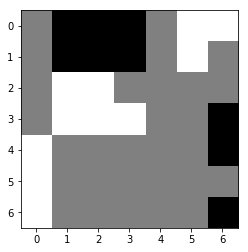

((1, 2), (2, 3)): n_v:  1906 q_all:+0.066215 q:+0.090109 q_m:+0.166667 p:0.421990
((3, 6), (1, 6)): n_v:   237 q_all:+0.097455 q:+0.073380 q_m:+0.133333 p:0.024290
((1, 1), (2, 3)): n_v:    97 q_all:-0.025721 q:+0.023082 q_m:+0.133333 p:0.055270
((0, 3), (2, 3)): n_v:    86 q_all:+0.003957 q:+0.032699 q_m:+0.133333 p:0.039366
((0, 1), (2, 3)): n_v:    46 q_all:+0.031158 q:+0.050007 q_m:+0.133333 p:0.016537
((0, 1), (1, 0)): n_v:    35 q_all:-0.055212 q:-0.007581 q_m:+0.033333 p:0.023871
((0, 2), (2, 3)): n_v:    26 q_all:+0.029713 q:+0.024760 q_m:+0.133333 p:0.009191
((1, 2), (2, 4)): n_v:    10 q_all:-0.028444 q:-0.007965 q_m:+0.066667 p:0.005740
((3, 6), (5, 5)): n_v:    10 q_all:-0.022314 q:-0.018808 q_m:-0.066667 p:0.005881
((1, 3), (2, 5)): n_v:     6 q_all:-0.027185 q:-0.035627 q_m:-0.000000 p:0.003843
((3, 6), (2, 6)): n_v:     4 q_all:+0.007273 q:-0.000328 q_m:+0.033333 p:0.001814
((0, 3), (2, 5)): n_v:     4 q_all:-0.027299 q:-0.026487 q_m:-0.000000 p:0.002820
((1, 3), (2, 4))

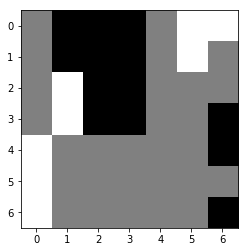

((0, 5), (1, 4)): n_v:   604 q_all:-0.049354 q:-0.005696 q_m:+0.066667 p:0.137702
((3, 1), (1, 0)): n_v:   498 q_all:-0.029424 q:-0.020620 q_m:-0.033333 p:0.080029
((1, 5), (2, 5)): n_v:   444 q_all:-0.011074 q:-0.047724 q_m:-0.066667 p:0.043449
((2, 1), (1, 0)): n_v:   360 q_all:-0.024213 q:-0.020494 q_m:-0.000000 p:0.051469
((1, 5), (2, 4)): n_v:   255 q_all:-0.066872 q:-0.030327 q_m:+0.066667 p:0.073394
((3, 1), (4, 2)): n_v:   158 q_all:-0.018449 q:-0.034950 q_m:-0.000000 p:0.019379
((3, 1), (4, 3)): n_v:   132 q_all:-0.030718 q:-0.043859 q_m:-0.033333 p:0.021460
((0, 5), (0, 4)): n_v:   105 q_all:-0.140082 q:-0.045964 q_m:-0.000000 p:0.056292
((0, 6), (1, 4)): n_v:    80 q_all:-0.078897 q:-0.011469 q_m:+0.033333 p:0.026351
((0, 5), (1, 6)): n_v:    77 q_all:-0.069403 q:-0.086179 q_m:-0.133333 p:0.022703
((3, 1), (5, 1)): n_v:    70 q_all:-0.089119 q:-0.077019 q_m:-0.166667 p:0.025491
((1, 5), (2, 6)): n_v:    57 q_all:-0.042192 q:-0.052590 q_m:-0.066667 p:0.011800
((2, 1), (0, 0))

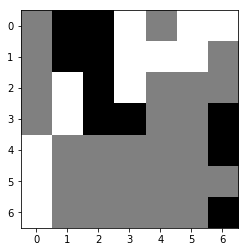

((2, 2), (0, 4)): n_v:  1485 q_all:+0.096274 q:+0.092614 q_m:+0.266667 p:0.535173
((0, 2), (0, 4)): n_v:   189 q_all:+0.016292 q:+0.069486 q_m:+0.266667 p:0.132836
((3, 3), (2, 4)): n_v:   176 q_all:+0.051678 q:+0.078164 q_m:+0.233333 p:0.097211
((1, 2), (0, 4)): n_v:    38 q_all:-0.028791 q:+0.084785 q_m:+0.266667 p:0.033762
((3, 2), (1, 0)): n_v:    28 q_all:-0.017868 q:-0.036898 q_m:-0.000000 p:0.023824
((3, 2), (5, 1)): n_v:    27 q_all:+0.044613 q:+0.055951 q_m:+0.133333 p:0.016135
((3, 6), (1, 6)): n_v:    26 q_all:+0.067611 q:+0.083958 q_m:+0.133333 p:0.013015
((0, 2), (2, 4)): n_v:    19 q_all:+0.006052 q:+0.013445 q_m:+0.200000 p:0.014757
((4, 6), (6, 4)): n_v:    17 q_all:-0.036223 q:-0.034380 q_m:-0.066667 p:0.016120
((3, 3), (4, 4)): n_v:    16 q_all:-0.050739 q:-0.033237 q_m:-0.033333 p:0.016462
((3, 6), (5, 5)): n_v:    15 q_all:-0.030592 q:-0.034765 q_m:-0.066667 p:0.014128
((2, 2), (2, 4)): n_v:    10 q_all:-0.042078 q:+0.040392 q_m:+0.200000 p:0.010394
((3, 2), (2, 4))

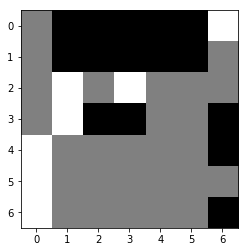

((2, 1), (2, 2)): n_v:  2401 q_all:-0.060000 q:-0.013383 q_m:+0.100000 p:0.275695
((2, 3), (2, 5)): n_v:   276 q_all:-0.028605 q:-0.095867 q_m:-0.066667 p:0.001237
((2, 3), (2, 4)): n_v:   231 q_all:-0.210742 q:-0.110085 q_m:+0.033333 p:0.149225
((4, 0), (2, 2)): n_v:   100 q_all:-0.074776 q:-0.022593 q_m:+0.066667 p:0.016469
((3, 1), (4, 2)): n_v:    36 q_all:-0.234970 q:-0.156274 q_m:-0.100000 p:0.026731
((0, 6), (2, 4)): n_v:    26 q_all:-0.228852 q:-0.138486 q_m:-0.000000 p:0.018763
((2, 3), (4, 2)): n_v:     9 q_all:-0.152959 q:-0.159114 q_m:-0.133333 p:0.004394
((2, 1), (4, 2)): n_v:     8 q_all:-0.203637 q:-0.162216 q_m:-0.133333 p:0.005310
((2, 3), (4, 4)): n_v:     5 q_all:-0.223302 q:-0.139113 q_m:-0.200000 p:0.003879
((6, 0), (4, 2)): n_v:     1 q_all:-0.225163 q:-0.187083 q_m:-0.133333 p:0.000763
((5, 0), (4, 2)): n_v:     1 q_all:-0.285702 q:-0.161445 q_m:-0.133333 p:0.001264
((0, 6), (1, 6)): n_v:     1 q_all:-0.134600 q:-0.068188 q_m:-0.100000 p:0.000179
((4, 0), (4, 2))

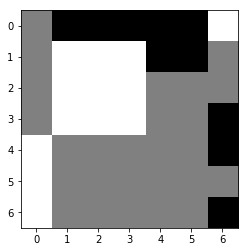

((1, 4), (2, 4)): n_v:  3120 q_all:+0.054998 q:+0.108321 q_m:+0.133333 p:0.421703
((4, 6), (2, 4)): n_v:   305 q_all:+0.039911 q:+0.083200 q_m:+0.100000 p:0.055440
((0, 5), (2, 4)): n_v:   210 q_all:+0.024974 q:+0.081935 q_m:+0.100000 p:0.047954
((0, 5), (1, 6)): n_v:   109 q_all:+0.039440 q:+0.025188 q_m:-0.000000 p:0.019690
((3, 6), (2, 4)): n_v:   106 q_all:+0.042044 q:+0.075616 q_m:+0.100000 p:0.018652
((0, 2), (2, 4)): n_v:    77 q_all:-0.047026 q:+0.039907 q_m:+0.100000 p:0.034547
((0, 1), (1, 0)): n_v:    57 q_all:+0.030242 q:+0.052175 q_m:+0.066667 p:0.011924
((3, 6), (1, 6)): n_v:    16 q_all:+0.027796 q:+0.028681 q_m:-0.033333 p:0.003381
((0, 3), (2, 4)): n_v:    15 q_all:-0.056131 q:+0.012074 q_m:+0.100000 p:0.007486
((0, 4), (2, 4)): n_v:    14 q_all:-0.010550 q:-0.000638 q_m:+0.100000 p:0.004979
((6, 6), (4, 4)): n_v:    14 q_all:+0.003898 q:+0.056195 q_m:-0.033333 p:0.004075
((4, 6), (4, 4)): n_v:     5 q_all:-0.013291 q:+0.025042 q_m:-0.033333 p:0.001797
((3, 6), (4, 4))

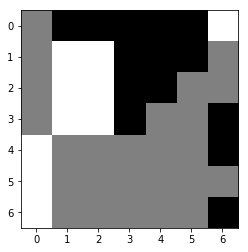

((3, 2), (3, 4)): n_v:  1423 q_all:-0.011303 q:-0.020714 q_m:+0.066667 p:0.171234
((0, 6), (2, 5)): n_v:  1091 q_all:-0.019508 q:-0.023057 q_m:+0.133333 p:0.157367
((1, 1), (1, 0)): n_v:   415 q_all:-0.054132 q:-0.096483 q_m:-0.033333 p:0.101639
((0, 6), (1, 6)): n_v:   393 q_all:-0.001442 q:-0.040519 q_m:+0.033333 p:0.036039
((1, 1), (0, 0)): n_v:   266 q_all:-0.073318 q:-0.066171 q_m:-0.033333 p:0.080212
((3, 1), (1, 0)): n_v:   134 q_all:-0.063672 q:-0.116134 q_m:-0.066667 p:0.036511
((3, 2), (1, 0)): n_v:    98 q_all:-0.118024 q:-0.131477 q_m:-0.066667 p:0.042272
((2, 2), (3, 4)): n_v:    78 q_all:-0.147501 q:-0.079719 q_m:+0.066667 p:0.040126
((2, 2), (0, 0)): n_v:    51 q_all:-0.154809 q:-0.111252 q_m:-0.066667 p:0.027783
((2, 2), (1, 0)): n_v:    44 q_all:-0.169847 q:-0.142521 q_m:-0.066667 p:0.025522
((3, 2), (4, 3)): n_v:    41 q_all:-0.130682 q:-0.132855 q_m:-0.033333 p:0.019171
((1, 1), (2, 0)): n_v:    23 q_all:-0.173221 q:-0.162570 q_m:-0.100000 p:0.013633
((1, 2), (3, 4))

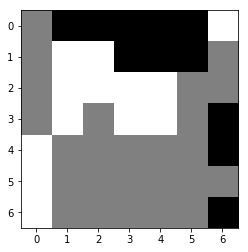

((0, 5), (1, 6)): n_v:   986 q_all:+0.036467 q:+0.006100 q_m:+0.033333 p:0.125599
((1, 4), (2, 5)): n_v:   466 q_all:+0.032509 q:+0.041489 q_m:+0.100000 p:0.066212
((0, 1), (1, 0)): n_v:   223 q_all:+0.010891 q:-0.004770 q_m:+0.100000 p:0.049117
((3, 6), (4, 5)): n_v:   174 q_all:-0.025761 q:-0.002973 q_m:+0.033333 p:0.061583
((1, 4), (3, 2)): n_v:   160 q_all:-0.006547 q:+0.038608 q_m:+0.266667 p:0.045384
((0, 5), (2, 5)): n_v:   104 q_all:-0.029052 q:-0.011577 q_m:+0.066667 p:0.038218
((4, 6), (2, 5)): n_v:    86 q_all:+0.047168 q:+0.028303 q_m:+0.066667 p:0.007490
((0, 4), (2, 5)): n_v:    56 q_all:-0.038607 q:-0.082672 q_m:+0.066667 p:0.022483
((1, 3), (3, 2)): n_v:    54 q_all:-0.007708 q:+0.036069 q_m:+0.266667 p:0.015298
((3, 6), (1, 6)): n_v:    49 q_all:+0.030208 q:+0.020117 q_m:-0.000000 p:0.007369
((6, 6), (4, 5)): n_v:    49 q_all:-0.041061 q:+0.003161 q_m:-0.000000 p:0.020191
((1, 5), (2, 6)): n_v:    48 q_all:-0.044690 q:-0.079879 q_m:-0.033333 p:0.020404
((0, 3), (2, 5))

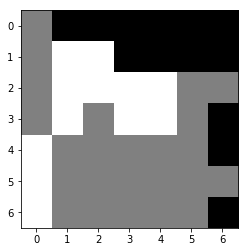

((2, 4), (2, 5)): n_v:  1508 q_all:+0.081917 q:+0.006066 q_m:+0.266667 p:0.126277
((3, 3), (2, 5)): n_v:   441 q_all:-0.014208 q:-0.028823 q_m:+0.233333 p:0.200693
((2, 3), (2, 5)): n_v:   133 q_all:-0.113408 q:-0.097423 q_m:+0.233333 p:0.111505
((1, 1), (0, 0)): n_v:    95 q_all:-0.022540 q:-0.088751 q_m:+0.066667 p:0.046518
((3, 4), (4, 5)): n_v:    62 q_all:-0.035250 q:-0.061357 q_m:+0.133333 p:0.033987
((2, 2), (0, 0)): n_v:    58 q_all:-0.173708 q:-0.112079 q_m:+0.033333 p:0.063020
((3, 4), (2, 6)): n_v:    52 q_all:-0.038539 q:-0.012457 q_m:+0.166667 p:0.029015
((3, 3), (4, 5)): n_v:    49 q_all:-0.061871 q:-0.082176 q_m:+0.100000 p:0.031311
((3, 1), (1, 0)): n_v:    46 q_all:+0.030454 q:-0.110665 q_m:+0.033333 p:0.013088
((1, 1), (1, 0)): n_v:    23 q_all:-0.025588 q:-0.123579 q_m:+0.066667 p:0.011824
((3, 4), (5, 6)): n_v:    16 q_all:-0.060554 q:-0.025177 q_m:+0.100000 p:0.010681
((3, 3), (4, 1)): n_v:    11 q_all:-0.135932 q:-0.210712 q_m:-0.033333 p:0.010764
((1, 1), (2, 0))

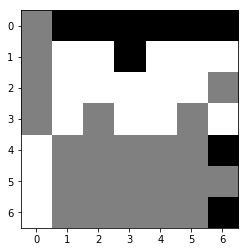

((0, 6), (2, 6)): n_v:  2251 q_all:-0.042563 q:+0.005595 q_m:-0.000000 p:0.827903
((4, 6), (3, 5)): n_v:   340 q_all:+0.046793 q:+0.010623 q_m:+0.033333 p:0.018631
((0, 1), (2, 0)): n_v:   292 q_all:+0.043104 q:-0.124006 q_m:-0.066667 p:0.007686
((4, 6), (2, 6)): n_v:   181 q_all:-0.027409 q:+0.053971 q_m:-0.000000 p:0.057090
((0, 5), (2, 6)): n_v:    69 q_all:-0.069438 q:-0.029473 q_m:-0.000000 p:0.031823
((0, 4), (2, 6)): n_v:    69 q_all:-0.125198 q:-0.040726 q_m:-0.000000 p:0.045233
((0, 2), (2, 0)): n_v:    16 q_all:-0.115161 q:-0.126655 q_m:-0.066667 p:0.009914
((4, 6), (6, 5)): n_v:     0 q_all:-0.109889 q:-0.109889 q_m:-0.266667 p:0.000000
((1, 3), (3, 2)): n_v:     0 q_all:-0.057735 q:-0.057735 q_m:+0.066667 p:0.000137
((0, 1), (1, 0)): n_v:     0 q_all:-0.103458 q:-0.103458 q_m:-0.100000 p:0.000356
((4, 6), (4, 4)): n_v:     0 q_all:-0.028372 q:-0.028372 q_m:-0.133333 p:0.000002
((4, 6), (6, 4)): n_v:     0 q_all:-0.129182 q:-0.129182 q_m:-0.266667 p:0.000001
((0, 2), (0, 0))

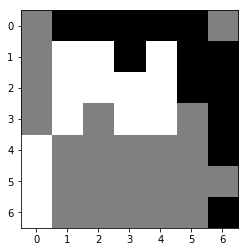

((2, 4), (3, 5)): n_v:  2144 q_all:+0.063602 q:+0.182638 q_m:+0.300000 p:0.249895
((3, 4), (5, 5)): n_v:   955 q_all:+0.098872 q:+0.002451 q_m:+0.133333 p:0.006446
((3, 3), (3, 5)): n_v:   331 q_all:+0.025232 q:+0.131146 q_m:+0.266667 p:0.078548
((2, 4), (0, 6)): n_v:   198 q_all:+0.007586 q:-0.070675 q_m:+0.200000 p:0.058414
((2, 2), (0, 0)): n_v:   101 q_all:-0.095845 q:-0.094051 q_m:+0.066667 p:0.063134
((2, 3), (3, 5)): n_v:    76 q_all:-0.043884 q:+0.031271 q_m:+0.266667 p:0.035098
((1, 4), (3, 5)): n_v:    22 q_all:+0.007419 q:+0.053238 q_m:+0.266667 p:0.006654
((1, 1), (0, 0)): n_v:    20 q_all:-0.064879 q:-0.048796 q_m:+0.100000 p:0.010940
((3, 4), (5, 6)): n_v:     6 q_all:+0.006388 q:+0.012277 q_m:+0.133333 p:0.001935
((2, 1), (0, 0)): n_v:     6 q_all:-0.086798 q:-0.065647 q_m:+0.066667 p:0.003601
((3, 3), (5, 5)): n_v:     5 q_all:-0.043514 q:-0.038593 q_m:+0.133333 p:0.002512
((1, 2), (0, 0)): n_v:     3 q_all:-0.161067 q:-0.141786 q_m:+0.066667 p:0.002785
((1, 1), (1, 0))

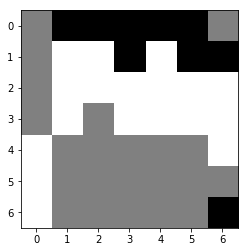

((6, 6), (4, 5)): n_v:  3154 q_all:+0.010243 q:+0.007379 q_m:-0.033333 p:0.886740
((1, 3), (3, 2)): n_v:    62 q_all:-0.135130 q:-0.084816 q_m:+0.033333 p:0.046247
((6, 6), (4, 4)): n_v:    36 q_all:-0.069746 q:-0.073814 q_m:-0.100000 p:0.019656
((0, 1), (1, 0)): n_v:    31 q_all:-0.108930 q:-0.156778 q_m:-0.133333 p:0.020509
((6, 6), (5, 5)): n_v:    14 q_all:-0.086983 q:-0.068848 q_m:-0.200000 p:0.008823
((0, 1), (2, 0)): n_v:    10 q_all:-0.147635 q:-0.174429 q_m:-0.100000 p:0.007957
((6, 6), (5, 6)): n_v:     5 q_all:-0.108470 q:-0.117078 q_m:-0.200000 p:0.003550
((0, 2), (2, 0)): n_v:     2 q_all:-0.249853 q:-0.192130 q_m:-0.100000 p:0.002338
((6, 6), (5, 4)): n_v:     1 q_all:-0.135096 q:-0.174962 q_m:-0.300000 p:0.001101
((0, 4), (0, 6)): n_v:     0 q_all:-0.308586 q:-0.308586 q_m:-0.300000 p:0.000026
((0, 5), (0, 6)): n_v:     0 q_all:-0.178000 q:-0.178000 q_m:-0.266667 p:0.000605
((6, 6), (6, 4)): n_v:     0 q_all:-0.207209 q:-0.207209 q_m:-0.300000 p:0.000304
((6, 6), (6, 5))

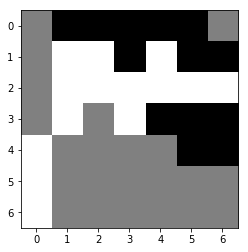

((3, 3), (4, 4)): n_v:  1923 q_all:+0.053522 q:+0.122960 q_m:+0.266667 p:0.199334
((2, 6), (0, 6)): n_v:   749 q_all:-0.028646 q:+0.001561 q_m:+0.233333 p:0.253551
((1, 1), (0, 0)): n_v:   684 q_all:-0.029318 q:+0.036289 q_m:+0.133333 p:0.232439
((2, 4), (0, 6)): n_v:   147 q_all:-0.016344 q:+0.019043 q_m:+0.233333 p:0.044755
((2, 1), (0, 0)): n_v:   127 q_all:+0.051055 q:+0.021311 q_m:+0.100000 p:0.014394
((2, 2), (0, 0)): n_v:    72 q_all:-0.076286 q:-0.012140 q_m:+0.100000 p:0.034535
((1, 1), (1, 0)): n_v:    67 q_all:-0.020518 q:+0.015285 q_m:+0.133333 p:0.021205
((2, 5), (0, 6)): n_v:    51 q_all:-0.079042 q:+0.001243 q_m:+0.233333 p:0.024891
((3, 1), (4, 2)): n_v:    36 q_all:-0.120844 q:-0.056324 q_m:+0.066667 p:0.022151
((3, 3), (5, 5)): n_v:    19 q_all:-0.025368 q:+0.036099 q_m:+0.166667 p:0.006492
((1, 4), (0, 6)): n_v:    18 q_all:-0.100249 q:-0.080048 q_m:+0.233333 p:0.009941
((2, 2), (4, 4)): n_v:    15 q_all:+0.015343 q:+0.080621 q_m:+0.233333 p:0.002969
((1, 2), (0, 0))

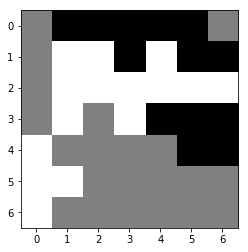

((3, 4), (3, 2)): n_v:  1001 q_all:+0.114262 q:+0.137553 q_m:+0.266667 p:0.462422
((3, 4), (4, 3)): n_v:   136 q_all:+0.076291 q:+0.062833 q_m:+0.033333 p:0.088928
((1, 3), (3, 2)): n_v:   119 q_all:-0.039087 q:+0.075390 q_m:+0.266667 p:0.146301
((3, 4), (4, 2)): n_v:    79 q_all:+0.137155 q:+0.103738 q_m:+0.133333 p:0.027472
((3, 4), (4, 4)): n_v:    75 q_all:+0.106930 q:+0.072586 q_m:+0.033333 p:0.037296
((3, 4), (5, 2)): n_v:    50 q_all:+0.104981 q:+0.062783 q_m:-0.000000 p:0.025635
((3, 4), (5, 5)): n_v:    22 q_all:+0.066325 q:+0.009288 q_m:-0.066667 p:0.015120
((0, 1), (1, 0)): n_v:    21 q_all:+0.091059 q:+0.063118 q_m:+0.100000 p:0.012461
((3, 4), (5, 6)): n_v:    17 q_all:+0.060557 q:+0.030735 q_m:-0.066667 p:0.012352
((4, 6), (6, 5)): n_v:    13 q_all:+0.048968 q:+0.039512 q_m:-0.066667 p:0.010401
((0, 1), (2, 0)): n_v:    11 q_all:+0.059735 q:+0.046115 q_m:+0.133333 p:0.008795
((0, 5), (0, 6)): n_v:    10 q_all:+0.063701 q:+0.045446 q_m:-0.033333 p:0.007343
((0, 2), (2, 0))

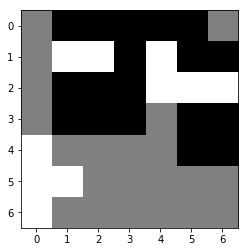

((2, 4), (3, 4)): n_v:  2059 q_all:-0.108185 q:-0.109281 q_m:+0.033333 p:0.460388
((2, 4), (0, 6)): n_v:   376 q_all:-0.079044 q:-0.191635 q_m:-0.066667 p:0.042478
((1, 2), (3, 4)): n_v:   128 q_all:-0.123430 q:-0.120364 q_m:-0.000000 p:0.036025
((2, 6), (3, 4)): n_v:   113 q_all:-0.163379 q:-0.144659 q_m:-0.000000 p:0.049161
((1, 4), (3, 4)): n_v:    48 q_all:-0.216422 q:-0.232934 q_m:-0.000000 p:0.030951
((4, 0), (4, 1)): n_v:     7 q_all:-0.211406 q:-0.276003 q_m:-0.100000 p:0.004192
((2, 4), (4, 4)): n_v:     7 q_all:-0.134834 q:-0.248955 q_m:-0.066667 p:0.002399
((2, 6), (0, 6)): n_v:     5 q_all:-0.186548 q:-0.276402 q_m:-0.066667 p:0.002919
((2, 4), (4, 2)): n_v:     3 q_all:-0.324015 q:-0.312987 q_m:-0.066667 p:0.003073
((1, 4), (0, 6)): n_v:     3 q_all:-0.182399 q:-0.258640 q_m:-0.066667 p:0.001905
((1, 1), (0, 0)): n_v:     2 q_all:-0.258441 q:-0.297932 q_m:-0.166667 p:0.002149
((5, 1), (4, 2)): n_v:     2 q_all:-0.316159 q:-0.270134 q_m:-0.033333 p:0.002176
((5, 0), (3, 0))

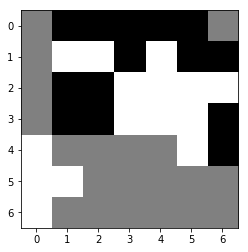

((4, 6), (4, 4)): n_v:  1477 q_all:+0.164645 q:+0.143816 q_m:+0.233333 p:0.031606
((3, 1), (4, 2)): n_v:   849 q_all:+0.052862 q:+0.070482 q_m:+0.133333 p:0.325231
((3, 2), (4, 4)): n_v:   422 q_all:+0.125079 q:+0.165920 q_m:+0.233333 p:0.063077
((2, 2), (4, 4)): n_v:   251 q_all:+0.096016 q:+0.114666 q_m:+0.233333 p:0.061279
((4, 6), (5, 6)): n_v:   173 q_all:+0.125005 q:+0.122304 q_m:+0.066667 p:0.025899
((0, 1), (1, 0)): n_v:   147 q_all:+0.115372 q:+0.014551 q_m:+0.066667 p:0.026677
((3, 6), (4, 4)): n_v:   136 q_all:+0.107002 q:+0.129601 q_m:+0.233333 p:0.028397
((3, 1), (4, 1)): n_v:   132 q_all:+0.133498 q:+0.136933 q_m:+0.200000 p:0.016259
((4, 6), (5, 5)): n_v:    86 q_all:+0.108296 q:+0.124963 q_m:+0.066667 p:0.017060
((3, 2), (1, 0)): n_v:    44 q_all:+0.098468 q:-0.013876 q_m:+0.033333 p:0.010408
((3, 2), (4, 3)): n_v:    34 q_all:+0.093276 q:+0.072747 q_m:+0.133333 p:0.008648
((3, 6), (5, 5)): n_v:    22 q_all:+0.058540 q:+0.055281 q_m:+0.033333 p:0.008123
((3, 1), (1, 0))

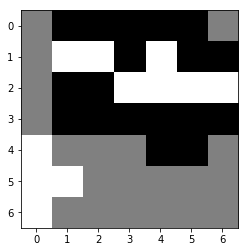

((5, 1), (4, 3)): n_v:   977 q_all:-0.141234 q:-0.119561 q_m:+0.033333 p:0.146313
((1, 1), (0, 0)): n_v:   606 q_all:-0.185822 q:-0.206607 q_m:-0.133333 p:0.185360
((2, 4), (0, 6)): n_v:   347 q_all:-0.175761 q:-0.155508 q_m:-0.033333 p:0.094233
((1, 1), (2, 0)): n_v:   256 q_all:-0.196154 q:-0.184739 q_m:-0.066667 p:0.087983
((5, 1), (4, 2)): n_v:   204 q_all:-0.205110 q:-0.189718 q_m:-0.000000 p:0.076053
((4, 0), (4, 1)): n_v:   133 q_all:-0.221248 q:-0.185689 q_m:-0.066667 p:0.057664
((2, 6), (0, 6)): n_v:   124 q_all:-0.152670 q:-0.180196 q_m:-0.033333 p:0.023578
((1, 1), (1, 0)): n_v:    78 q_all:-0.163171 q:-0.147666 q_m:-0.066667 p:0.017819
((2, 4), (4, 6)): n_v:    74 q_all:-0.197876 q:-0.157797 q_m:-0.033333 p:0.025937
((2, 5), (4, 3)): n_v:    66 q_all:-0.293621 q:-0.233219 q_m:+0.033333 p:0.045858
((2, 5), (0, 6)): n_v:    64 q_all:-0.235239 q:-0.155344 q_m:-0.033333 p:0.030830
((2, 6), (4, 6)): n_v:    56 q_all:-0.171465 q:-0.116067 q_m:-0.033333 p:0.014538
((4, 0), (3, 0))

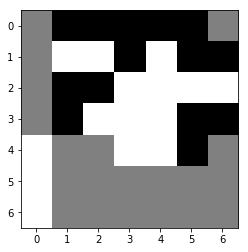

((3, 1), (4, 2)): n_v:  1197 q_all:+0.150558 q:+0.131853 q_m:+0.200000 p:0.395635
((4, 5), (5, 4)): n_v:   599 q_all:+0.128739 q:+0.086966 q_m:+0.133333 p:0.249436
((3, 1), (4, 1)): n_v:   212 q_all:+0.160814 q:+0.136315 q_m:+0.200000 p:0.061681
((4, 5), (5, 5)): n_v:   166 q_all:+0.124545 q:+0.085773 q_m:+0.066667 p:0.071877
((3, 6), (5, 5)): n_v:    42 q_all:+0.081155 q:+0.071022 q_m:+0.033333 p:0.025293
((2, 1), (3, 0)): n_v:    40 q_all:+0.083261 q:+0.035791 q_m:+0.066667 p:0.023999
((3, 1), (5, 1)): n_v:    29 q_all:+0.118692 q:+0.121394 q_m:+0.166667 p:0.013347
((0, 1), (1, 0)): n_v:    21 q_all:+0.022059 q:+0.008550 q_m:+0.066667 p:0.017619
((3, 6), (5, 4)): n_v:    14 q_all:+0.101286 q:+0.090104 q_m:+0.100000 p:0.007363
((3, 5), (5, 5)): n_v:    11 q_all:+0.039038 q:+0.036606 q_m:+0.033333 p:0.009149
((2, 1), (4, 2)): n_v:    10 q_all:+0.120781 q:+0.046620 q_m:+0.166667 p:0.004842
((4, 5), (5, 3)): n_v:    10 q_all:+0.051697 q:+0.057222 q_m:+0.100000 p:0.007000
((0, 1), (0, 0))

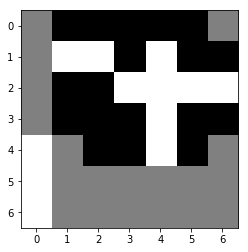

((4, 0), (4, 1)): n_v:  1306 q_all:-0.180174 q:-0.184578 q_m:+0.033333 p:0.433141
((4, 4), (4, 6)): n_v:   486 q_all:-0.091248 q:-0.035796 q_m:-0.000000 p:0.002422
((6, 0), (4, 1)): n_v:   426 q_all:-0.158016 q:-0.179733 q_m:-0.000000 p:0.106525
((1, 1), (0, 0)): n_v:   189 q_all:-0.179074 q:-0.210683 q_m:-0.100000 p:0.062163
((1, 1), (2, 0)): n_v:   176 q_all:-0.205106 q:-0.228127 q_m:-0.033333 p:0.074287
((2, 6), (0, 6)): n_v:    75 q_all:-0.110871 q:-0.157948 q_m:-0.000000 p:0.005491
((4, 4), (5, 3)): n_v:    62 q_all:-0.181162 q:-0.189682 q_m:-0.033333 p:0.020881
((1, 1), (1, 0)): n_v:    24 q_all:-0.134851 q:-0.185628 q_m:-0.033333 p:0.003994
((4, 4), (5, 4)): n_v:    18 q_all:-0.159073 q:-0.197080 q_m:-0.033333 p:0.004710
((2, 4), (0, 6)): n_v:    10 q_all:-0.231010 q:-0.164989 q_m:-0.000000 p:0.005377
((4, 4), (5, 5)): n_v:    10 q_all:-0.183554 q:-0.177396 q_m:-0.100000 p:0.003507
((4, 4), (6, 6)): n_v:     8 q_all:-0.226192 q:-0.221323 q_m:-0.200000 p:0.004059
((3, 4), (4, 6))

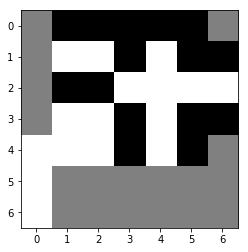

((4, 3), (5, 1)): n_v:  1543 q_all:+0.215009 q:+0.210248 q_m:+0.300000 p:0.283349
((4, 3), (5, 5)): n_v:   358 q_all:+0.095472 q:+0.075386 q_m:+0.033333 p:0.220383
((3, 3), (5, 1)): n_v:   354 q_all:+0.164354 q:+0.133738 q_m:+0.300000 p:0.130081
((4, 5), (5, 5)): n_v:   281 q_all:+0.115922 q:+0.102214 q_m:+0.066667 p:0.152460
((2, 1), (3, 0)): n_v:   160 q_all:+0.167178 q:+0.139485 q_m:+0.200000 p:0.057031
((3, 3), (5, 5)): n_v:    86 q_all:+0.022239 q:+0.039299 q_m:+0.033333 p:0.075830
((3, 6), (5, 5)): n_v:    47 q_all:+0.090206 q:+0.088318 q_m:+0.033333 p:0.030083
((3, 5), (5, 5)): n_v:    16 q_all:+0.068008 q:+0.051035 q_m:+0.033333 p:0.011827
((2, 2), (3, 0)): n_v:     9 q_all:+0.077309 q:+0.065479 q_m:+0.166667 p:0.006256
((2, 1), (2, 0)): n_v:     7 q_all:+0.067757 q:+0.085429 q_m:+0.133333 p:0.005246
((4, 3), (5, 2)): n_v:     4 q_all:+0.100400 q:+0.091913 q_m:+0.133333 p:0.002385
((4, 3), (6, 5)): n_v:     3 q_all:+0.081644 q:+0.053892 q_m:-0.033333 p:0.001971
((4, 3), (6, 1))

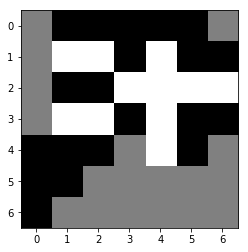

((4, 4), (4, 6)): n_v:  1195 q_all:-0.133522 q:-0.141279 q_m:-0.100000 p:0.012944
((3, 1), (3, 0)): n_v:  1055 q_all:-0.212791 q:-0.247864 q_m:-0.066667 p:0.302027
((3, 2), (4, 3)): n_v:   397 q_all:-0.228180 q:-0.245585 q_m:-0.133333 p:0.135163
((1, 1), (2, 0)): n_v:    67 q_all:-0.348402 q:-0.321694 q_m:-0.200000 p:0.051550
((1, 1), (0, 0)): n_v:    65 q_all:-0.347124 q:-0.322623 q_m:-0.200000 p:0.049065
((1, 1), (1, 0)): n_v:    58 q_all:-0.275349 q:-0.257907 q_m:-0.133333 p:0.029664
((4, 4), (5, 2)): n_v:    57 q_all:-0.291664 q:-0.266740 q_m:-0.100000 p:0.032512
((3, 2), (1, 0)): n_v:    30 q_all:-0.328002 q:-0.306885 q_m:-0.166667 p:0.020794
((3, 1), (1, 0)): n_v:    24 q_all:-0.236852 q:-0.271134 q_m:-0.166667 p:0.008881
((1, 1), (3, 0)): n_v:    22 q_all:-0.179632 q:-0.276896 q_m:-0.100000 p:0.003694
((2, 6), (0, 6)): n_v:    21 q_all:-0.221550 q:-0.233351 q_m:-0.100000 p:0.006554
((1, 2), (3, 0)): n_v:    16 q_all:-0.243619 q:-0.317969 q_m:-0.100000 p:0.006621
((4, 4), (5, 4))

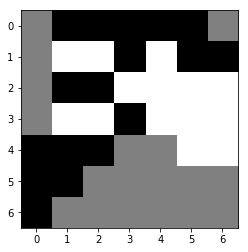

((3, 3), (4, 4)): n_v:  2242 q_all:+0.128353 q:+0.208669 q_m:+0.333333 p:0.814277
((4, 2), (4, 4)): n_v:   296 q_all:+0.158221 q:+0.186177 q_m:+0.300000 p:0.075148
((2, 2), (4, 4)): n_v:   228 q_all:+0.208022 q:+0.131635 q_m:+0.300000 p:0.016036
((0, 1), (1, 0)): n_v:    52 q_all:+0.211587 q:+0.099275 q_m:+0.200000 p:0.002875
((3, 3), (5, 5)): n_v:    51 q_all:+0.163903 q:+0.209042 q_m:+0.233333 p:0.012045
((3, 3), (4, 3)): n_v:    32 q_all:+0.117275 q:+0.144200 q_m:+0.266667 p:0.012978
((2, 1), (2, 0)): n_v:    17 q_all:+0.065219 q:+0.131389 q_m:+0.266667 p:0.010234
((2, 1), (3, 0)): n_v:     6 q_all:+0.132996 q:+0.160450 q_m:+0.200000 p:0.002243
((0, 1), (0, 0)): n_v:     4 q_all:+0.109144 q:+0.122163 q_m:+0.200000 p:0.001776
((5, 1), (4, 3)): n_v:     2 q_all:+0.077470 q:+0.112364 q_m:+0.233333 p:0.001128
((5, 1), (6, 2)): n_v:     2 q_all:+0.035988 q:+0.065334 q_m:+0.133333 p:0.001674
((4, 2), (5, 4)): n_v:     2 q_all:+0.075472 q:+0.158955 q_m:+0.166667 p:0.001040
((4, 2), (5, 3))

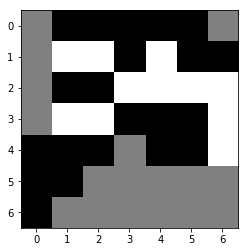

((3, 2), (4, 3)): n_v:  3394 q_all:-0.122437 q:-0.127231 q_m:-0.033333 p:0.763089
((3, 1), (3, 0)): n_v:   394 q_all:-0.163130 q:-0.152172 q_m:-0.100000 p:0.138725
((4, 6), (5, 5)): n_v:   111 q_all:-0.178499 q:-0.155630 q_m:-0.166667 p:0.044675
((1, 1), (1, 0)): n_v:    37 q_all:-0.226410 q:-0.176188 q_m:-0.166667 p:0.020734
((1, 1), (0, 0)): n_v:    14 q_all:-0.267699 q:-0.235955 q_m:-0.233333 p:0.009261
((4, 6), (5, 6)): n_v:    10 q_all:-0.230826 q:-0.163014 q_m:-0.233333 p:0.006050
((1, 1), (3, 0)): n_v:     6 q_all:-0.141705 q:-0.192024 q_m:-0.133333 p:0.001919
((3, 1), (1, 0)): n_v:     6 q_all:-0.222301 q:-0.206967 q_m:-0.200000 p:0.003384
((3, 1), (4, 3)): n_v:     4 q_all:-0.176066 q:-0.165007 q_m:-0.066667 p:0.001641
((1, 1), (2, 0)): n_v:     1 q_all:-0.257868 q:-0.245703 q_m:-0.233333 p:0.000708
((3, 6), (5, 5)): n_v:     1 q_all:-0.373867 q:-0.293706 q_m:-0.200000 p:0.001980
((3, 2), (1, 0)): n_v:     1 q_all:-0.309439 q:-0.240700 q_m:-0.200000 p:0.001374
((4, 6), (5, 4))

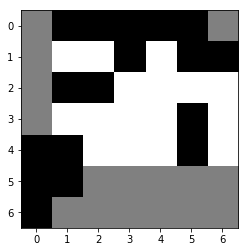

((4, 5), (5, 5)): n_v:   853 q_all:+0.171021 q:+0.170646 q_m:+0.200000 p:0.063176
((4, 5), (5, 4)): n_v:   696 q_all:+0.092904 q:+0.090801 q_m:+0.200000 p:0.205528
((4, 1), (5, 2)): n_v:   686 q_all:+0.123201 q:+0.144424 q_m:+0.200000 p:0.143841
((3, 5), (5, 4)): n_v:   368 q_all:+0.194665 q:+0.103113 q_m:+0.166667 p:0.002500
((5, 1), (5, 3)): n_v:   288 q_all:+0.144436 q:+0.126463 q_m:+0.233333 p:0.042913
((6, 0), (5, 2)): n_v:   232 q_all:+0.097409 q:+0.113180 q_m:+0.166667 p:0.065757
((4, 5), (5, 3)): n_v:   155 q_all:+0.172334 q:+0.082750 q_m:+0.233333 p:0.010799
((0, 1), (1, 0)): n_v:   147 q_all:+0.138824 q:+0.052136 q_m:+0.133333 p:0.024230
((4, 0), (5, 2)): n_v:   120 q_all:+0.078119 q:+0.082116 q_m:+0.166667 p:0.040632
((2, 1), (2, 0)): n_v:   116 q_all:+0.099898 q:+0.089069 q_m:+0.200000 p:0.031833
((3, 5), (5, 3)): n_v:    88 q_all:+0.183439 q:+0.124413 q_m:+0.233333 p:0.003427
((4, 1), (5, 3)): n_v:    79 q_all:+0.122084 q:+0.057204 q_m:+0.233333 p:0.016769
((5, 1), (6, 2))

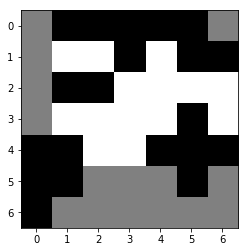

((4, 3), (5, 4)): n_v:  1296 q_all:-0.139589 q:-0.123449 q_m:+0.033333 p:0.181783
((4, 2), (5, 2)): n_v:   433 q_all:-0.220799 q:-0.241103 q_m:-0.033333 p:0.198348
((3, 1), (3, 0)): n_v:   392 q_all:-0.160726 q:-0.167901 q_m:+0.033333 p:0.087472
((3, 1), (1, 0)): n_v:    56 q_all:-0.195408 q:-0.210258 q_m:-0.066667 p:0.020339
((1, 1), (1, 0)): n_v:    50 q_all:-0.198130 q:-0.181420 q_m:-0.033333 p:0.018548
((4, 3), (6, 1)): n_v:    44 q_all:-0.177040 q:-0.118010 q_m:-0.000000 p:0.012584
((4, 2), (6, 1)): n_v:    44 q_all:-0.198544 q:-0.139229 q_m:-0.000000 p:0.016351
((3, 6), (5, 6)): n_v:    38 q_all:-0.262020 q:-0.183249 q_m:-0.000000 p:0.023698
((4, 3), (6, 5)): n_v:    29 q_all:-0.286826 q:-0.233424 q_m:-0.133333 p:0.021057
((3, 6), (5, 4)): n_v:    20 q_all:-0.222261 q:-0.237378 q_m:-0.000000 p:0.009444
((3, 4), (5, 6)): n_v:    16 q_all:-0.273289 q:-0.169477 q_m:-0.000000 p:0.011180
((4, 2), (5, 4)): n_v:    16 q_all:-0.201851 q:-0.146233 q_m:-0.000000 p:0.006275
((3, 1), (5, 2))

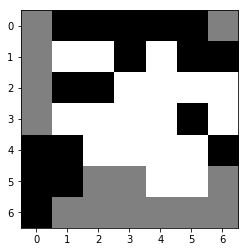

((5, 1), (5, 3)): n_v:  2480 q_all:+0.127838 q:+0.159690 q_m:+0.233333 p:0.821167
((4, 1), (5, 3)): n_v:   182 q_all:+0.107788 q:+0.094417 q_m:+0.233333 p:0.073308
((3, 5), (5, 3)): n_v:   145 q_all:+0.138631 q:+0.161355 q_m:+0.233333 p:0.042480
((4, 6), (5, 6)): n_v:    23 q_all:+0.128177 q:+0.155775 q_m:+0.133333 p:0.007686
((0, 1), (1, 0)): n_v:    22 q_all:+0.186065 q:+0.034473 q_m:+0.066667 p:0.002744
((4, 6), (6, 4)): n_v:    12 q_all:+0.090342 q:+0.125963 q_m:+0.100000 p:0.005321
((5, 0), (6, 1)): n_v:    12 q_all:+0.047584 q:+0.090763 q_m:-0.000000 p:0.007836
((5, 1), (6, 2)): n_v:     5 q_all:+0.072121 q:+0.072990 q_m:-0.000000 p:0.002760
((6, 0), (5, 2)): n_v:     4 q_all:+0.055093 q:+0.102941 q_m:+0.100000 p:0.002544
((4, 6), (6, 5)): n_v:     3 q_all:+0.111575 q:+0.119850 q_m:+0.100000 p:0.001126
((2, 1), (2, 0)): n_v:     3 q_all:+0.029016 q:+0.072980 q_m:+0.133333 p:0.001888
((4, 1), (5, 2)): n_v:     3 q_all:+0.083131 q:+0.138423 q_m:+0.133333 p:0.001786
((2, 1), (3, 0))

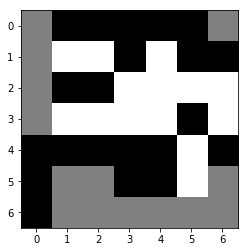

((3, 1), (3, 0)): n_v:  1692 q_all:-0.141232 q:-0.161960 q_m:-0.000000 p:0.622439
((3, 1), (5, 2)): n_v:  1131 q_all:-0.042087 q:-0.152372 q_m:+0.033333 p:0.071557
((3, 2), (5, 1)): n_v:   610 q_all:-0.053538 q:-0.082602 q_m:+0.100000 p:0.060112
((3, 1), (5, 1)): n_v:   301 q_all:-0.064599 q:-0.035210 q_m:+0.100000 p:0.039977
((3, 1), (1, 0)): n_v:    90 q_all:-0.143834 q:-0.215919 q_m:-0.100000 p:0.034159
((3, 3), (5, 1)): n_v:    89 q_all:-0.140201 q:-0.080735 q_m:+0.100000 p:0.032303
((1, 1), (3, 0)): n_v:    31 q_all:-0.098601 q:-0.186537 q_m:-0.033333 p:0.007388
((1, 1), (0, 0)): n_v:    29 q_all:-0.239143 q:-0.253204 q_m:-0.133333 p:0.019285
((1, 2), (3, 0)): n_v:    21 q_all:-0.086503 q:-0.222627 q_m:-0.033333 p:0.004184
((3, 3), (5, 2)): n_v:    20 q_all:-0.274125 q:-0.208312 q_m:+0.033333 p:0.015616
((1, 1), (1, 0)): n_v:    16 q_all:-0.205051 q:-0.191677 q_m:-0.066667 p:0.009320
((2, 6), (0, 6)): n_v:    16 q_all:-0.190150 q:-0.207469 q_m:-0.033333 p:0.008423
((3, 2), (1, 0))

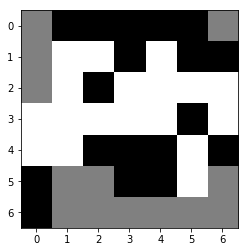

((0, 1), (2, 0)): n_v:   788 q_all:+0.156534 q:+0.154695 q_m:+0.266667 p:0.136797
((4, 6), (5, 6)): n_v:   628 q_all:+0.160164 q:+0.145858 q_m:+0.166667 p:0.101632
((4, 2), (5, 1)): n_v:   504 q_all:+0.103062 q:+0.133869 q_m:+0.166667 p:0.179213
((4, 2), (2, 0)): n_v:   389 q_all:+0.177874 q:+0.149215 q_m:+0.266667 p:0.039147
((5, 4), (5, 6)): n_v:   294 q_all:+0.197299 q:+0.061886 q_m:+0.133333 p:0.010237
((0, 1), (1, 0)): n_v:   141 q_all:+0.075556 q:+0.067909 q_m:+0.166667 p:0.063688
((0, 2), (2, 0)): n_v:    77 q_all:+0.055360 q:+0.059105 q_m:+0.266667 p:0.040067
((2, 2), (2, 0)): n_v:    41 q_all:+0.122905 q:+0.115833 q_m:+0.266667 p:0.011918
((5, 3), (5, 1)): n_v:    22 q_all:+0.132847 q:+0.118051 q_m:+0.133333 p:0.005676
((5, 4), (6, 5)): n_v:    14 q_all:+0.015123 q:+0.022277 q_m:+0.100000 p:0.009051
((2, 2), (1, 0)): n_v:    11 q_all:+0.125130 q:+0.029212 q_m:+0.133333 p:0.003230
((0, 2), (1, 0)): n_v:     7 q_all:-0.096717 q:-0.058264 q_m:+0.133333 p:0.008271
((0, 1), (0, 0))

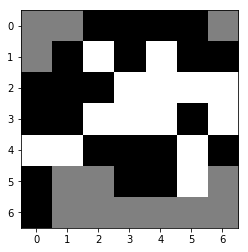

((4, 0), (5, 1)): n_v:  1203 q_all:-0.142712 q:-0.135540 q_m:-0.033333 p:0.353726
((1, 2), (1, 0)): n_v:   552 q_all:-0.073348 q:-0.218932 q_m:-0.066667 p:0.010539
((1, 2), (0, 1)): n_v:   206 q_all:-0.182642 q:-0.196876 q_m:-0.100000 p:0.093407
((4, 0), (5, 2)): n_v:    90 q_all:-0.224167 q:-0.216554 q_m:-0.066667 p:0.055247
((4, 1), (5, 2)): n_v:    69 q_all:-0.306564 q:-0.190286 q_m:-0.033333 p:0.066033
((5, 5), (6, 4)): n_v:    40 q_all:-0.136855 q:-0.274882 q_m:-0.100000 p:0.010393
((4, 5), (5, 6)): n_v:    36 q_all:-0.169501 q:-0.198938 q_m:-0.166667 p:0.014817
((2, 6), (0, 6)): n_v:    36 q_all:-0.237183 q:-0.259236 q_m:-0.066667 p:0.024328
((3, 2), (5, 1)): n_v:    34 q_all:-0.124237 q:-0.189875 q_m:-0.066667 p:0.007616
((4, 0), (6, 1)): n_v:    19 q_all:-0.301576 q:-0.197546 q_m:-0.133333 p:0.017715
((4, 0), (6, 2)): n_v:    15 q_all:-0.287277 q:-0.279383 q_m:-0.200000 p:0.013232
((5, 5), (6, 5)): n_v:    10 q_all:-0.317386 q:-0.302091 q_m:-0.166667 p:0.010178
((3, 2), (1, 0))

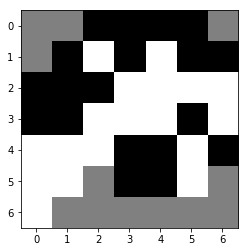

((4, 3), (5, 2)): n_v:   979 q_all:+0.178390 q:+0.167727 q_m:+0.266667 p:0.208110
((5, 3), (6, 1)): n_v:   815 q_all:+0.232407 q:+0.206210 q_m:+0.233333 p:0.011234
((0, 2), (0, 1)): n_v:   659 q_all:+0.150107 q:+0.137984 q_m:+0.133333 p:0.208382
((4, 3), (6, 1)): n_v:   147 q_all:+0.229075 q:+0.179885 q_m:+0.233333 p:0.003323
((5, 4), (6, 5)): n_v:   139 q_all:-0.023010 q:+0.031104 q_m:+0.133333 p:0.131690
((4, 6), (5, 6)): n_v:    59 q_all:+0.177116 q:+0.164024 q_m:+0.200000 p:0.012957
((3, 0), (5, 2)): n_v:    16 q_all:+0.022961 q:+0.050760 q_m:+0.233333 p:0.012473
((0, 3), (0, 1)): n_v:    15 q_all:-0.186984 q:-0.044688 q_m:+0.100000 p:0.023233
((5, 3), (6, 4)): n_v:    13 q_all:+0.183024 q:+0.006836 q_m:+0.133333 p:0.002199
((4, 6), (6, 5)): n_v:    10 q_all:+0.081125 q:+0.031063 q_m:+0.100000 p:0.006145
((5, 3), (6, 5)): n_v:     8 q_all:-0.058545 q:+0.032064 q_m:+0.100000 p:0.009593
((2, 2), (0, 1)): n_v:     6 q_all:-0.088271 q:+0.008153 q_m:+0.100000 p:0.007092
((4, 4), (6, 5))

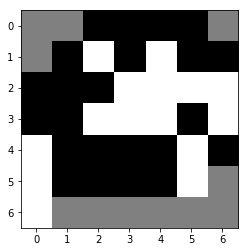

((1, 2), (1, 0)): n_v:  1565 q_all:-0.045098 q:-0.215767 q_m:-0.066667 p:0.010731
((5, 0), (6, 1)): n_v:   561 q_all:-0.197038 q:-0.153098 q_m:-0.100000 p:0.330107
((1, 2), (0, 1)): n_v:   375 q_all:-0.183799 q:-0.201314 q_m:-0.100000 p:0.200660
((6, 0), (6, 2)): n_v:    24 q_all:-0.174690 q:-0.210629 q_m:-0.066667 p:0.012383
((3, 2), (1, 0)): n_v:    22 q_all:-0.095578 q:-0.265959 q_m:-0.066667 p:0.004377
((5, 5), (6, 5)): n_v:    16 q_all:-0.365373 q:-0.413611 q_m:-0.166667 p:0.020323
((4, 5), (5, 6)): n_v:    15 q_all:-0.219739 q:-0.199282 q_m:-0.166667 p:0.010214
((4, 0), (6, 1)): n_v:    15 q_all:-0.267698 q:-0.263296 q_m:-0.133333 p:0.013673
((5, 0), (6, 2)): n_v:    13 q_all:-0.256185 q:-0.238847 q_m:-0.066667 p:0.010789
((4, 0), (6, 2)): n_v:    11 q_all:-0.228566 q:-0.304161 q_m:-0.066667 p:0.008492
((2, 6), (0, 6)): n_v:     4 q_all:-0.275404 q:-0.266434 q_m:-0.066667 p:0.003696
((5, 5), (6, 4)): n_v:     3 q_all:-0.308594 q:-0.300919 q_m:-0.100000 p:0.003086
((2, 3), (0, 1))

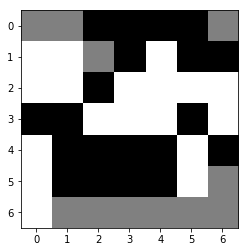

((0, 2), (1, 2)): n_v:  2829 q_all:+0.132664 q:+0.165212 q_m:+0.300000 p:0.094168
((0, 2), (0, 1)): n_v:   194 q_all:-0.318784 q:+0.003723 q_m:+0.233333 p:0.310852
((5, 1), (6, 1)): n_v:   165 q_all:-0.099879 q:+0.151180 q_m:+0.233333 p:0.138334
((5, 4), (6, 5)): n_v:    49 q_all:-0.187925 q:-0.061450 q_m:+0.166667 p:0.055989
((3, 0), (1, 2)): n_v:    46 q_all:+0.090285 q:+0.021055 q_m:+0.266667 p:0.006636
((4, 6), (5, 6)): n_v:    12 q_all:-0.118183 q:+0.042376 q_m:+0.233333 p:0.010855
((1, 3), (0, 1)): n_v:    10 q_all:+0.063626 q:-0.090295 q_m:+0.200000 p:0.002248
((2, 2), (0, 1)): n_v:     4 q_all:-0.005211 q:-0.020539 q_m:+0.200000 p:0.002489
((0, 4), (1, 2)): n_v:     4 q_all:+0.016084 q:+0.051346 q_m:+0.266667 p:0.002035
((4, 2), (6, 1)): n_v:     2 q_all:+0.003927 q:+0.013277 q_m:+0.200000 p:0.001050
((0, 3), (0, 1)): n_v:     2 q_all:-0.076310 q:-0.058448 q_m:+0.200000 p:0.002091
((5, 3), (6, 1)): n_v:     2 q_all:-0.126511 q:+0.067432 q_m:+0.200000 p:0.001599
((4, 4), (5, 6))

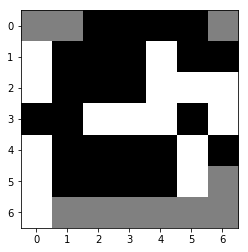

((1, 0), (0, 1)): n_v:  3394 q_all:-0.135832 q:-0.070490 q_m:-0.066667 p:0.393876
((5, 0), (6, 1)): n_v:   683 q_all:-0.199600 q:-0.210065 q_m:-0.133333 p:0.207628
((2, 0), (0, 1)): n_v:   353 q_all:-0.187921 q:-0.222158 q_m:-0.100000 p:0.095008
((5, 0), (6, 2)): n_v:    42 q_all:-0.289492 q:-0.274069 q_m:-0.100000 p:0.023684
((4, 0), (6, 1)): n_v:    27 q_all:-0.307338 q:-0.345539 q_m:-0.166667 p:0.016951
((6, 0), (6, 2)): n_v:    26 q_all:-0.223814 q:-0.222487 q_m:-0.100000 p:0.009177
((4, 0), (6, 2)): n_v:    24 q_all:-0.251151 q:-0.359098 q_m:-0.100000 p:0.011315
((1, 0), (0, 0)): n_v:    10 q_all:-0.415231 q:-0.357748 q_m:-0.200000 p:0.009864
((5, 5), (6, 5)): n_v:     5 q_all:-0.493446 q:-0.534372 q_m:-0.200000 p:0.006628
((4, 5), (5, 6)): n_v:     3 q_all:-0.156557 q:-0.226937 q_m:-0.200000 p:0.000544
((2, 6), (0, 6)): n_v:     2 q_all:-0.352259 q:-0.431686 q_m:-0.100000 p:0.001918
((5, 5), (6, 4)): n_v:     2 q_all:-0.358035 q:-0.419783 q_m:-0.133333 p:0.002133
((2, 0), (0, 0))

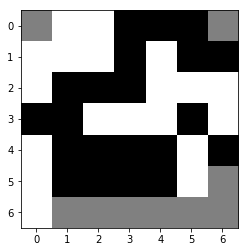

((4, 6), (5, 6)): n_v:  2091 q_all:+0.185376 q:+0.099214 q_m:+0.233333 p:0.172550
((5, 1), (6, 1)): n_v:  1690 q_all:+0.171570 q:+0.205220 q_m:+0.233333 p:0.204267
((5, 4), (6, 5)): n_v:   389 q_all:-0.067461 q:-0.033637 q_m:+0.166667 p:0.306321
((5, 4), (5, 6)): n_v:    44 q_all:+0.050928 q:-0.005915 q_m:+0.200000 p:0.020409
((4, 6), (6, 5)): n_v:    16 q_all:-0.016930 q:-0.043902 q_m:+0.133333 p:0.010274
((5, 3), (6, 1)): n_v:     8 q_all:-0.001697 q:+0.027986 q_m:+0.200000 p:0.005122
((4, 4), (5, 6)): n_v:     4 q_all:-0.092373 q:-0.050352 q_m:+0.200000 p:0.004110
((0, 5), (0, 6)): n_v:     4 q_all:-0.067787 q:-0.032833 q_m:+0.100000 p:0.003138
((5, 3), (6, 4)): n_v:     3 q_all:-0.000545 q:-0.017803 q_m:+0.166667 p:0.001855
((5, 3), (6, 5)): n_v:     3 q_all:-0.102979 q:-0.060647 q_m:+0.133333 p:0.003312
((4, 2), (6, 1)): n_v:     2 q_all:-0.074748 q:-0.068538 q_m:+0.200000 p:0.001915
((5, 1), (6, 2)): n_v:     2 q_all:-0.166934 q:-0.121122 q_m:+0.100000 p:0.001924
((3, 5), (5, 6))

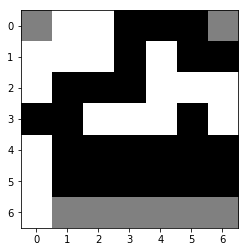

((6, 0), (6, 2)): n_v:  1706 q_all:-0.130577 q:-0.054691 q_m:-0.033333 p:0.007432
((5, 0), (6, 1)): n_v:   788 q_all:-0.168384 q:-0.079577 q_m:-0.066667 p:0.096118
((0, 1), (0, 0)): n_v:   347 q_all:-0.393164 q:-0.426421 q_m:-0.200000 p:0.295781
((4, 0), (6, 2)): n_v:   218 q_all:-0.144000 q:-0.277755 q_m:-0.033333 p:0.007983
((4, 0), (6, 1)): n_v:   130 q_all:-0.177970 q:-0.297134 q_m:-0.100000 p:0.019836
((2, 6), (0, 6)): n_v:   113 q_all:-0.275726 q:-0.411502 q_m:-0.033333 p:0.052749
((5, 0), (6, 2)): n_v:   105 q_all:-0.162276 q:-0.144180 q_m:-0.033333 p:0.010790
((0, 2), (0, 0)): n_v:    66 q_all:-0.481932 q:-0.512473 q_m:-0.233333 p:0.075766
((2, 4), (0, 6)): n_v:    47 q_all:-0.336508 q:-0.341024 q_m:-0.033333 p:0.032050
((1, 2), (0, 0)): n_v:    37 q_all:-0.504026 q:-0.501323 q_m:-0.233333 p:0.045868
((1, 4), (0, 6)): n_v:    34 q_all:-0.308511 q:-0.367697 q_m:-0.033333 p:0.019423
((2, 0), (0, 0)): n_v:    22 q_all:-0.484029 q:-0.528236 q_m:-0.233333 p:0.025426
((2, 5), (0, 6))

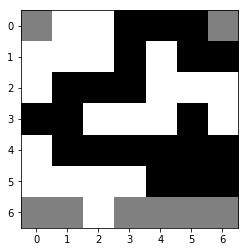

((5, 4), (6, 3)): n_v:  1822 q_all:+0.050933 q:+0.147727 q_m:+0.266667 p:0.584182
((4, 3), (6, 1)): n_v:  1081 q_all:+0.136007 q:+0.077960 q_m:+0.300000 p:0.033915
((4, 2), (6, 1)): n_v:   171 q_all:+0.112835 q:+0.058209 q_m:+0.300000 p:0.018231
((5, 5), (6, 3)): n_v:   135 q_all:+0.063687 q:+0.027026 q_m:+0.233333 p:0.036942
((5, 4), (6, 5)): n_v:    58 q_all:-0.044011 q:-0.152263 q_m:+0.066667 p:0.037482
((0, 5), (0, 6)): n_v:    57 q_all:+0.093574 q:-0.118248 q_m:+0.066667 p:0.010108
((4, 2), (6, 3)): n_v:    25 q_all:-0.066127 q:-0.068521 q_m:+0.233333 p:0.017484
((4, 1), (6, 3)): n_v:    17 q_all:-0.054558 q:+0.024152 q_m:+0.233333 p:0.011440
((5, 4), (6, 4)): n_v:    13 q_all:-0.045526 q:-0.252993 q_m:+0.133333 p:0.008914
((4, 6), (6, 5)): n_v:    12 q_all:-0.319013 q:-0.230679 q_m:+0.033333 p:0.019921
((4, 3), (6, 5)): n_v:    10 q_all:-0.212618 q:-0.279247 q_m:+0.033333 p:0.012604
((4, 4), (6, 3)): n_v:     6 q_all:-0.188463 q:-0.066345 q_m:+0.233333 p:0.007546
((2, 2), (0, 0))

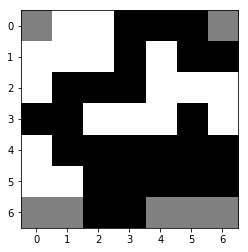

((5, 0), (6, 1)): n_v:  3161 q_all:-0.073976 q:-0.106121 q_m:-0.100000 p:0.602727
((4, 0), (6, 1)): n_v:    52 q_all:-0.446498 q:-0.435000 q_m:-0.133333 p:0.075261
((0, 1), (0, 0)): n_v:    10 q_all:-0.443896 q:-0.374532 q_m:-0.233333 p:0.014854
((2, 6), (0, 6)): n_v:     4 q_all:-0.391306 q:-0.417757 q_m:-0.066667 p:0.005901
((2, 4), (0, 6)): n_v:     1 q_all:-0.363245 q:-0.351896 q_m:-0.066667 p:0.001356
((1, 4), (0, 6)): n_v:     1 q_all:-0.404472 q:-0.411063 q_m:-0.066667 p:0.001660
((1, 2), (0, 0)): n_v:     1 q_all:-0.584317 q:-0.520321 q_m:-0.266667 p:0.002145
((5, 0), (6, 0)): n_v:     0 q_all:-0.557446 q:-0.557446 q_m:-0.233333 p:0.001602
((4, 0), (6, 0)): n_v:     0 q_all:-0.614262 q:-0.614262 q_m:-0.266667 p:0.000093
((2, 0), (0, 0)): n_v:     0 q_all:-0.580252 q:-0.580252 q_m:-0.266667 p:0.000819
((2, 5), (0, 6)): n_v:     0 q_all:-0.428140 q:-0.428140 q_m:-0.066667 p:0.000134
((0, 2), (0, 0)): n_v:     0 q_all:-0.526702 q:-0.526702 q_m:-0.266667 p:0.001466
-1 's turn
one m

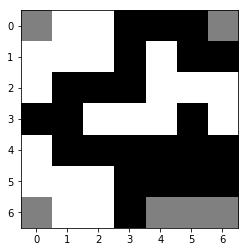

((5, 3), (6, 4)): n_v:  3544 q_all:+0.180152 q:-0.169920 q_m:+0.133333 p:0.129484
((2, 2), (0, 0)): n_v:   266 q_all:-0.010249 q:-0.009617 q_m:+0.300000 p:0.084728
((0, 5), (0, 6)): n_v:   101 q_all:-0.084531 q:-0.084531 q_m:+0.133333 p:0.072703
((5, 5), (6, 6)): n_v:    67 q_all:-0.051635 q:-0.183489 q_m:+0.133333 p:0.040792
((2, 1), (0, 0)): n_v:    42 q_all:+0.028032 q:+0.028032 q_m:+0.300000 p:0.005101
((4, 6), (6, 6)): n_v:    38 q_all:-0.460401 q:-0.438580 q_m:+0.100000 p:0.072366
((4, 2), (6, 0)): n_v:    32 q_all:-0.138994 q:-0.142397 q_m:+0.300000 p:0.029820
((4, 1), (6, 0)): n_v:    14 q_all:-0.002446 q:-0.002446 q_m:+0.300000 p:0.004041
((0, 4), (0, 6)): n_v:    11 q_all:-0.434745 q:-0.379092 q_m:+0.100000 p:0.020088
((5, 4), (6, 5)): n_v:     9 q_all:-0.056117 q:-0.056117 q_m:+0.133333 p:0.005150
((6, 3), (6, 5)): n_v:     7 q_all:-0.180922 q:-0.212895 q_m:+0.100000 p:0.008210
((4, 4), (6, 6)): n_v:     6 q_all:-0.422386 q:-0.367647 q_m:+0.100000 p:0.010765
((4, 6), (6, 4))

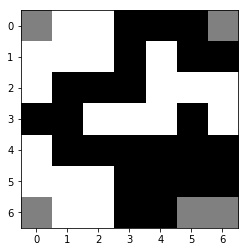

((2, 6), (0, 6)): n_v:  2254 q_all:-0.218012 q:-0.065705 q_m:+0.066667 p:0.167364
((0, 1), (0, 0)): n_v:  2221 q_all:-0.230979 q:-0.351003 q_m:-0.100000 p:0.244178
((5, 0), (6, 0)): n_v:   372 q_all:-0.205753 q:-0.063990 q_m:-0.100000 p:0.014200
((0, 2), (0, 0)): n_v:    99 q_all:-0.533102 q:-0.467283 q_m:-0.133333 p:0.093252
((6, 2), (6, 0)): n_v:    51 q_all:-0.519841 q:-0.383670 q_m:-0.133333 p:0.046516
((1, 4), (0, 6)): n_v:    44 q_all:-0.358319 q:-0.249014 q_m:+0.066667 p:0.020003
((2, 0), (0, 0)): n_v:    40 q_all:-0.607667 q:-0.609625 q_m:-0.133333 p:0.046557
((2, 4), (0, 6)): n_v:    39 q_all:-0.377431 q:-0.252102 q_m:+0.066667 p:0.020293
((4, 0), (6, 0)): n_v:    29 q_all:-0.587819 q:-0.551847 q_m:-0.133333 p:0.031182
((2, 5), (0, 6)): n_v:    26 q_all:-0.438466 q:-0.288009 q_m:+0.066667 p:0.017295
((1, 2), (0, 0)): n_v:    15 q_all:-0.548492 q:-0.510569 q_m:-0.133333 p:0.015099
((5, 2), (6, 0)): n_v:     4 q_all:-0.566836 q:-0.510031 q_m:-0.133333 p:0.004629
-1 's turn
one m

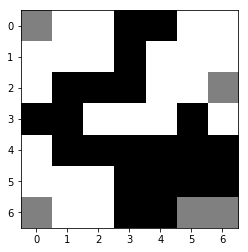

((3, 5), (2, 6)): n_v:  2627 q_all:+0.567840 q:+0.483912 q_m:+0.233333 p:0.648657
((4, 6), (2, 6)): n_v:    91 q_all:-0.111678 q:-0.103635 q_m:+0.200000 p:0.219778
((0, 4), (2, 6)): n_v:    22 q_all:-0.158671 q:-0.087600 q_m:+0.200000 p:0.058359
((4, 5), (2, 6)): n_v:    13 q_all:-0.363355 q:-0.228790 q_m:+0.200000 p:0.042418
((4, 4), (2, 6)): n_v:     5 q_all:-0.347074 q:-0.293479 q_m:+0.200000 p:0.018088
((2, 2), (0, 0)): n_v:     4 q_all:+0.126945 q:-0.342569 q_m:+0.133333 p:0.006672
((4, 6), (6, 5)): n_v:     0 q_all:-0.600053 q:-0.600053 q_m:-0.066667 p:0.000002
((4, 4), (6, 6)): n_v:     0 q_all:-0.614926 q:-0.614926 q_m:-0.066667 p:0.000425
((5, 5), (6, 6)): n_v:     0 q_all:-0.634974 q:-0.634974 q_m:-0.033333 p:0.000898
((4, 6), (6, 6)): n_v:     0 q_all:-0.742805 q:-0.742805 q_m:-0.066667 p:0.000238
((4, 5), (6, 5)): n_v:     0 q_all:-0.665601 q:-0.665601 q_m:-0.066667 p:0.000002
((4, 5), (6, 6)): n_v:     0 q_all:-0.572673 q:-0.572673 q_m:-0.066667 p:0.000110
((4, 1), (6, 0))

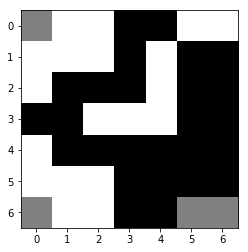

((0, 1), (0, 0)): n_v:  2359 q_all:-0.527118 q:-0.314005 q_m:-0.200000 p:0.119956
((6, 2), (6, 0)): n_v:   337 q_all:-0.679882 q:-0.660428 q_m:-0.233333 p:0.172640
((5, 0), (6, 0)): n_v:   335 q_all:-0.559379 q:-0.305313 q_m:-0.200000 p:0.038668
((0, 2), (0, 0)): n_v:   320 q_all:-0.652679 q:-0.638964 q_m:-0.233333 p:0.137226
((4, 0), (6, 0)): n_v:   253 q_all:-0.650157 q:-0.690078 q_m:-0.233333 p:0.106278
((1, 2), (0, 0)): n_v:   154 q_all:-0.653443 q:-0.658716 q_m:-0.233333 p:0.066440
((2, 0), (0, 0)): n_v:   123 q_all:-0.680976 q:-0.838552 q_m:-0.233333 p:0.063153
((5, 2), (6, 0)): n_v:    88 q_all:-0.689354 q:-0.707800 q_m:-0.233333 p:0.047775
-1 's turn
one move takes time(s):  0.10708045959472656
train_mode is both train
no. of data collected:  8


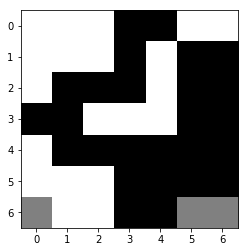

((4, 2), (6, 0)): n_v:  2341 q_all:+0.834859 q:+0.329516 q_m:+0.400000 p:0.006186
((5, 4), (6, 5)): n_v:  1155 q_all:+0.587992 q:+0.665516 q_m:+0.233333 p:0.039481
((5, 5), (6, 6)): n_v:   231 q_all:+0.456763 q:-0.069167 q_m:+0.233333 p:0.132930
((6, 3), (6, 5)): n_v:    63 q_all:+0.491492 q:+0.606701 q_m:+0.200000 p:0.023664
((4, 6), (6, 6)): n_v:    56 q_all:+0.046436 q:-0.311560 q_m:+0.200000 p:0.128198
((6, 4), (6, 6)): n_v:    33 q_all:+0.193084 q:-0.224323 q_m:+0.200000 p:0.056229
((4, 1), (6, 0)): n_v:    14 q_all:+0.508279 q:+0.494368 q_m:+0.400000 p:0.005281
((4, 6), (6, 5)): n_v:    11 q_all:+0.135090 q:+0.224352 q_m:+0.200000 p:0.020944
((4, 4), (6, 6)): n_v:     2 q_all:-0.487731 q:-0.459504 q_m:+0.200000 p:0.010502
((5, 3), (6, 5)): n_v:     1 q_all:-0.421577 q:-0.032537 q_m:+0.200000 p:0.003237
((4, 3), (6, 5)): n_v:     1 q_all:-0.152359 q:+0.243208 q_m:+0.200000 p:0.002556
((4, 4), (6, 5)): n_v:     0 q_all:+0.047742 q:+0.047742 q_m:+0.200000 p:0.000521
((4, 5), (6, 5))

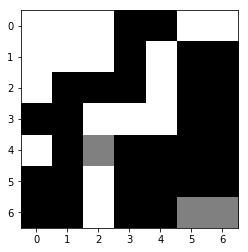

((6, 2), (4, 2)): n_v:  2058 q_all:-0.527570 q:-0.683672 q_m:-0.066667 p:0.106393
((3, 2), (4, 2)): n_v:  1259 q_all:-0.799781 q:-0.509395 q_m:-0.033333 p:0.180338
((2, 4), (4, 2)): n_v:   317 q_all:-0.878619 q:-0.803614 q_m:-0.066667 p:0.148991
((3, 4), (4, 2)): n_v:   164 q_all:-0.848801 q:-0.791977 q_m:-0.066667 p:0.057043
((4, 0), (4, 2)): n_v:   158 q_all:-0.881206 q:-0.832163 q_m:-0.066667 p:0.075880
((2, 0), (4, 2)): n_v:   142 q_all:-0.956232 q:-0.904157 q_m:-0.066667 p:0.112562
-1 's turn


This is a random move


one move takes time(s):  0.07883548736572266
train_mode is both train
no. of data collected:  8


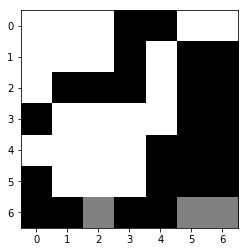

((6, 1), (6, 2)): n_v:  2962 q_all:+0.675350 q:+0.910688 q_m:+0.300000 p:0.506709
((6, 4), (6, 2)): n_v:   545 q_all:+0.591696 q:+0.745342 q_m:+0.266667 p:0.007459
((6, 0), (6, 2)): n_v:   216 q_all:+0.499640 q:+0.701248 q_m:+0.266667 p:0.090548
((5, 0), (6, 2)): n_v:    36 q_all:+0.485251 q:+0.628980 q_m:+0.266667 p:0.017812
((6, 3), (6, 5)): n_v:     1 q_all:+0.356533 q:+0.487940 q_m:+0.066667 p:0.001389
((5, 4), (6, 5)): n_v:     1 q_all:+0.199266 q:+0.708010 q_m:+0.100000 p:0.000182
((4, 4), (6, 2)): n_v:     1 q_all:+0.244357 q:+0.204739 q_m:+0.266667 p:0.002387
((4, 6), (6, 5)): n_v:     0 q_all:+0.082384 q:+0.082384 q_m:+0.066667 p:0.000084
((4, 4), (6, 6)): n_v:     0 q_all:-0.148225 q:-0.148225 q_m:+0.066667 p:0.000060
((4, 6), (6, 6)): n_v:     0 q_all:-0.108138 q:-0.108138 q_m:+0.066667 p:0.000072
((5, 4), (6, 2)): n_v:     0 q_all:+0.173349 q:+0.173349 q_m:+0.266667 p:0.000550
((4, 4), (6, 5)): n_v:     0 q_all:+0.134785 q:+0.134785 q_m:+0.066667 p:0.000015
((6, 4), (6, 6))

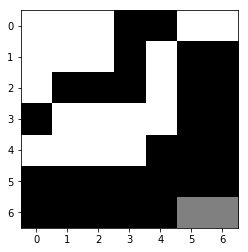

((4, 3), (6, 5)): n_v:  4502 q_all:-0.640023 q:-0.406700 q_m:-0.033333 p:0.998531
-1 's turn


This is a random move


one move takes time(s):  0.058608293533325195
train_mode is both train
no. of data collected:  8


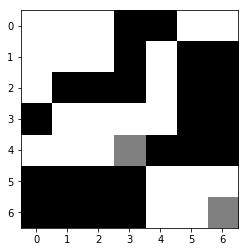

((4, 4), (4, 3)): n_v:  3593 q_all:+0.841200 q:+0.924638 q_m:+0.400000 p:0.240003
((6, 1), (4, 3)): n_v:  1080 q_all:+0.731116 q:+0.837143 q_m:+0.366667 p:0.013589
((6, 3), (4, 3)): n_v:   523 q_all:+0.723570 q:+0.828720 q_m:+0.366667 p:0.018572
((2, 1), (4, 3)): n_v:    33 q_all:+0.692047 q:+0.797394 q_m:+0.366667 p:0.003549
((6, 2), (4, 3)): n_v:    24 q_all:+0.576274 q:+0.648071 q_m:+0.366667 p:0.011167
((2, 5), (4, 3)): n_v:     8 q_all:+0.554714 q:+0.692928 q_m:+0.366667 p:0.003975
((4, 4), (6, 6)): n_v:     5 q_all:+0.633118 q:+0.677034 q_m:+0.233333 p:0.001809
((3, 5), (4, 3)): n_v:     5 q_all:+0.330756 q:+0.554236 q_m:+0.366667 p:0.004481
((5, 1), (4, 3)): n_v:     5 q_all:+0.237438 q:+0.456040 q_m:+0.366667 p:0.006142
((4, 5), (4, 3)): n_v:     3 q_all:+0.166507 q:+0.555342 q_m:+0.366667 p:0.002691
((2, 3), (4, 3)): n_v:     1 q_all:+0.381239 q:+0.641893 q_m:+0.366667 p:0.000690
((4, 6), (6, 6)): n_v:     0 q_all:+0.649793 q:+0.649793 q_m:+0.233333 p:0.000056
((2, 2), (4, 3))

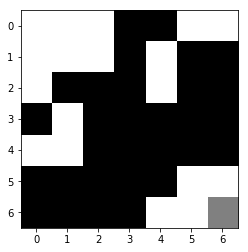

((6, 4), (6, 6)): n_v:  4911 q_all:-0.907801 q:-0.989470 q_m:-0.400000 p:0.836592
((5, 5), (6, 6)): n_v:    91 q_all:-1.000000 q:+5.000000 q_m:-0.366667 p:0.038729
-1 's turn


This is a random move


one move takes time(s):  0.0668344497680664
train_mode is both train
no. of data collected:  8


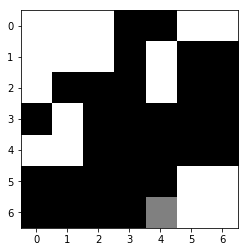

((5, 3), (6, 4)): n_v:  5113 q_all:+1.000000 q:+5.000000 q_m:+0.566667 p:0.283174
((6, 2), (6, 4)): n_v:    58 q_all:+0.935990 q:+0.980443 q_m:+0.533333 p:0.012475
((4, 6), (6, 4)): n_v:    20 q_all:+0.894668 q:+0.976329 q_m:+0.533333 p:0.005783
((4, 2), (6, 4)): n_v:     9 q_all:+0.903601 q:+0.901430 q_m:+0.533333 p:0.002617
((4, 3), (6, 4)): n_v:     7 q_all:+0.923030 q:+0.850906 q_m:+0.533333 p:0.001920
((5, 2), (6, 4)): n_v:     1 q_all:+0.756042 q:+0.978750 q_m:+0.533333 p:0.001182
((4, 4), (6, 4)): n_v:     0 q_all:+0.739100 q:+0.944868 q_m:+0.533333 p:0.000510
((4, 5), (6, 4)): n_v:     0 q_all:+0.707246 q:+0.881158 q_m:+0.533333 p:0.000633
this self play has 75 steps, time elapsed 124.87180137634277
winner is -1.0
episode 124 finished
episode 125 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.37934350967407227
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time

one move takes time(s):  0.4560112953186035
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4168820381164551
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.24943876266479492
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.11627864837646484
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1522972583770752
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.0924072265625
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1380758285522461
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.06590938568115234
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.04923272132873535
train_m

9000/9000 [==============================] - 1s 93us/step - loss: 1.8821 - activation_29_loss: 1.8475 - dense_15_loss: 0.0095 - val_loss: 1.9696 - val_activation_29_loss: 1.9344 - val_dense_15_loss: 0.0101
Epoch 32/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8817 - activation_29_loss: 1.8470 - dense_15_loss: 0.0096 - val_loss: 1.9693 - val_activation_29_loss: 1.9341 - val_dense_15_loss: 0.0101
Epoch 33/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8803 - activation_29_loss: 1.8458 - dense_15_loss: 0.0095 - val_loss: 1.9695 - val_activation_29_loss: 1.9343 - val_dense_15_loss: 0.0101
Epoch 34/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8796 - activation_29_loss: 1.8450 - dense_15_loss: 0.0095 - val_loss: 1.9697 - val_activation_29_loss: 1.9345 - val_dense_15_loss: 0.0102
Epoch 35/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8795 - activation_29_loss: 1.8449 - dense_15_loss: 0.009

9000/9000 [==============================] - 1s 92us/step - loss: 1.8561 - activation_29_loss: 1.8225 - dense_15_loss: 0.0086 - val_loss: 1.9731 - val_activation_29_loss: 1.9374 - val_dense_15_loss: 0.0106
Epoch 69/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8555 - activation_29_loss: 1.8218 - dense_15_loss: 0.0086 - val_loss: 1.9733 - val_activation_29_loss: 1.9377 - val_dense_15_loss: 0.0105
Epoch 70/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8546 - activation_29_loss: 1.8210 - dense_15_loss: 0.0086 - val_loss: 1.9732 - val_activation_29_loss: 1.9376 - val_dense_15_loss: 0.0105
Epoch 71/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8542 - activation_29_loss: 1.8204 - dense_15_loss: 0.0087 - val_loss: 1.9735 - val_activation_29_loss: 1.9379 - val_dense_15_loss: 0.0106
Epoch 00071: early stopping
saving files
episode 125 finished
episode 126 now start
left space is 45
start new self play
-1 's turn


Thi

one move takes time(s):  1.6196560859680176
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2725613117218018
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9778978824615479
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.234006643295288
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5204360485076904
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0559678077697754
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.8974094390869141
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5977189540863037
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8864150047302246
train_mode is both train
no. of dat

one move takes time(s):  0.7544898986816406
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.8100988864898682
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8258993625640869
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6486213207244873
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.6328163146972656
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7404134273529053
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.48037219047546387
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6982436180114746
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.602480411529541
train_mode is both train
no. of data collected:  8
1 's turn

one move takes time(s):  0.7292931079864502
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8174049854278564
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6355166435241699
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6198892593383789
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.542708158493042
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.864022970199585
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.078871726989746
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5767574310302734
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7485208511352539
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.

due to rollout lim, final rollout times:  1601 time elapsed:  4.001134395599365
one move takes time(s):  4.0024096965789795
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.164628505706787
one move takes time(s):  3.166198492050171
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.954906463623047
one move takes time(s):  2.9561638832092285
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.510369300842285
one move takes time(s):  2.511584520339966
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.950315237045288
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2398223876953125
one move takes time(s):  2.241114854812622
train_mode is both train
no. of 

due to rollout lim, final rollout times:  1601 time elapsed:  3.7065446376800537


This is a random move


one move takes time(s):  3.7077956199645996
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0784194469451904
one move takes time(s):  2.0796778202056885
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0755741596221924
one move takes time(s):  2.076752185821533
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3736772537231445
one move takes time(s):  2.3748960494995117
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.9392361640930176
one move takes time(s):  2.940669059753418
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1

one move takes time(s):  0.26642942428588867
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.25494837760925293
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.13209152221679688
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.13600707054138184
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.13556861877441406
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.13951659202575684
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.09474897384643555
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.08780384063720703
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.07237792015075684
train_mode is both train
no. of data collected:  8


Epoch 32/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8908 - activation_29_loss: 1.8568 - dense_15_loss: 0.0089 - val_loss: 1.8905 - val_activation_29_loss: 1.8531 - val_dense_15_loss: 0.0123
Epoch 33/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8912 - activation_29_loss: 1.8571 - dense_15_loss: 0.0091 - val_loss: 1.8909 - val_activation_29_loss: 1.8533 - val_dense_15_loss: 0.0125
Epoch 34/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8898 - activation_29_loss: 1.8557 - dense_15_loss: 0.0090 - val_loss: 1.8911 - val_activation_29_loss: 1.8537 - val_dense_15_loss: 0.0123
Epoch 35/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8894 - activation_29_loss: 1.8552 - dense_15_loss: 0.0091 - val_loss: 1.8912 - val_activation_29_loss: 1.8537 - val_dense_15_loss: 0.0124
Epoch 36/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8880 - activation_29_loss: 1.8541 - dense_1

one move takes time(s):  0.3536961078643799
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5150184631347656
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7604389190673828
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.1517393589019775
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1740 time elapsed:  2.000009775161743


This is a random move


one move takes time(s):  2.000988245010376
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.6637828350067139
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1582350730895996


This is a random move


one move takes time(s):  2.1594884395599365
train_mode is both train
no. of d

one move takes time(s):  0.1901547908782959
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.15294170379638672
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.09269046783447266
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.10905909538269043
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.0811302661895752
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.06949448585510254
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.05720376968383789
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.05366230010986328
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.03984546661376953
train_mode is both train
no. of data collected:  8
this self play has 71 steps,

one move takes time(s):  0.45591235160827637
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2813386917114258
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.2124190330505371
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.12873339653015137
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.24152922630310059
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1552138328552246
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.12948822975158691
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.09577536582946777
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.11205053329467773
train_mode is both train
no. of data collected:  8
1 '

due to rollout lim, final rollout times:  1601 time elapsed:  2.558143377304077
one move takes time(s):  2.5594465732574463
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.5876214504241943


This is a random move


one move takes time(s):  3.58897066116333
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.624218702316284
one move takes time(s):  2.6255741119384766
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.480530261993408
one move takes time(s):  3.481874704360962
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.269383430480957
one move takes time(s):  2.273083209991455
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 ti

due to rollout lim, final rollout times:  1601 time elapsed:  3.0825388431549072
one move takes time(s):  3.0837388038635254
train_mode is both train
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  29 time elapsed:  654.4044287204742
one move takes time(s):  654.4307858943939
no. of data collected:  0
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.5110368728637695
one move takes time(s):  3.5124223232269287
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.03570294380188
one move takes time(s):  2.036888837814331
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.254831314086914
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5133082866668701
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.265366792678833

no. of data collected:  8
this self play has 84 steps, time elapsed 750.0741038322449
winner is 1.0
episode 134 finished
episode 135 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.38686251640319824
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5469624996185303
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.1005218029022217
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2099690437316895
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.099696159362793


This is a random move


one move takes time(s):  2.1012139320373535
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.9089484214782715


This is a random move


one move takes t

one move takes time(s):  0.1748359203338623
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.1773223876953125
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.22466135025024414
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.09760689735412598
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.08710646629333496
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.21709346771240234
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.04858970642089844
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.05185508728027344
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.07243084907531738
train_mode is both train
no. of data collected:  8
1 

9000/9000 [==============================] - 1s 92us/step - loss: 1.8835 - activation_29_loss: 1.8493 - dense_15_loss: 0.0092 - val_loss: 1.9512 - val_activation_29_loss: 1.9154 - val_dense_15_loss: 0.0107
Epoch 33/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8833 - activation_29_loss: 1.8489 - dense_15_loss: 0.0093 - val_loss: 1.9510 - val_activation_29_loss: 1.9154 - val_dense_15_loss: 0.0105
Epoch 34/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8822 - activation_29_loss: 1.8479 - dense_15_loss: 0.0092 - val_loss: 1.9514 - val_activation_29_loss: 1.9157 - val_dense_15_loss: 0.0106
Epoch 35/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8817 - activation_29_loss: 1.8475 - dense_15_loss: 0.0091 - val_loss: 1.9514 - val_activation_29_loss: 1.9158 - val_dense_15_loss: 0.0106
Epoch 36/512
9000/9000 [==============================] - 1s 90us/step - loss: 1.8808 - activation_29_loss: 1.8465 - dense_15_loss: 0.009

9000/9000 [==============================] - 1s 92us/step - loss: 1.8596 - activation_29_loss: 1.8259 - dense_15_loss: 0.0086 - val_loss: 1.9545 - val_activation_29_loss: 1.9183 - val_dense_15_loss: 0.0112
Epoch 70/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8582 - activation_29_loss: 1.8247 - dense_15_loss: 0.0085 - val_loss: 1.9548 - val_activation_29_loss: 1.9186 - val_dense_15_loss: 0.0111
Epoch 71/512
9000/9000 [==============================] - 1s 90us/step - loss: 1.8584 - activation_29_loss: 1.8246 - dense_15_loss: 0.0087 - val_loss: 1.9545 - val_activation_29_loss: 1.9183 - val_dense_15_loss: 0.0111
Epoch 72/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8564 - activation_29_loss: 1.8228 - dense_15_loss: 0.0085 - val_loss: 1.9550 - val_activation_29_loss: 1.9189 - val_dense_15_loss: 0.0110
Epoch 73/512
9000/9000 [==============================] - 1s 90us/step - loss: 1.8569 - activation_29_loss: 1.8234 - dense_15_loss: 0.008

one move takes time(s):  0.9264254570007324
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5788683891296387
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5903167724609375
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.42259812355041504
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.421205997467041
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2792050838470459
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2536966800689697
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.31928086280822754
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.19940972328186035
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s)

one move takes time(s):  1.731407880783081
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1729 time elapsed:  2.0098555088043213
one move takes time(s):  2.0118892192840576
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.166248321533203
one move takes time(s):  2.1675052642822266
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3016128540039062
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3807334899902344
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.855147361755371
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4947397708892822
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1603 time elapsed:  2.0000975131988525
one move takes time(s)



This is a random move


one move takes time(s):  1.1539950370788574
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1121456623077393
one move takes time(s):  2.1134355068206787
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.8847031593322754
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.540602445602417
one move takes time(s):  3.5418741703033447
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9517383575439453
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.7140038013458252
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2584409713745117
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s)

due to rollout lim, final rollout times:  1601 time elapsed:  5.624346971511841
one move takes time(s):  5.625690460205078
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.408550500869751
one move takes time(s):  4.4102137088775635
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.2179036140441895
one move takes time(s):  3.2192533016204834
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7641370296478271
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.128422737121582
one move takes time(s):  2.1296331882476807
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.8561291694641113
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, f

one move takes time(s):  0.4993441104888916
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.33371901512145996
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5529470443725586
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.760969877243042
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5093550682067871
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.39037656784057617
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3519408702850342
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2990269660949707
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4629232883453369
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move

one move takes time(s):  1.4365315437316895
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.50703501701355
one move takes time(s):  2.508298635482788
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2103562355041504
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4842278957366943
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.093031883239746
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9768030643463135
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.8161087036132812
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0474343299865723
one move takes time(s):  2.0487115383148193
train_mode is both train
no. of da

9000/9000 [==============================] - 1s 92us/step - loss: 1.9148 - activation_29_loss: 1.8798 - dense_15_loss: 0.0099 - val_loss: 1.9470 - val_activation_29_loss: 1.9124 - val_dense_15_loss: 0.0095
Epoch 20/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.9126 - activation_29_loss: 1.8779 - dense_15_loss: 0.0096 - val_loss: 1.9471 - val_activation_29_loss: 1.9125 - val_dense_15_loss: 0.0095
Epoch 21/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.9123 - activation_29_loss: 1.8775 - dense_15_loss: 0.0097 - val_loss: 1.9471 - val_activation_29_loss: 1.9125 - val_dense_15_loss: 0.0095
Epoch 22/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.9106 - activation_29_loss: 1.8759 - dense_15_loss: 0.0096 - val_loss: 1.9475 - val_activation_29_loss: 1.9129 - val_dense_15_loss: 0.0095
Epoch 23/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.9102 - activation_29_loss: 1.8755 - dense_15_loss: 0.009

9000/9000 [==============================] - 1s 92us/step - loss: 1.8852 - activation_29_loss: 1.8515 - dense_15_loss: 0.0086 - val_loss: 1.9515 - val_activation_29_loss: 1.9167 - val_dense_15_loss: 0.0098
Epoch 57/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8845 - activation_29_loss: 1.8508 - dense_15_loss: 0.0086 - val_loss: 1.9514 - val_activation_29_loss: 1.9166 - val_dense_15_loss: 0.0097
Epoch 58/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8834 - activation_29_loss: 1.8498 - dense_15_loss: 0.0085 - val_loss: 1.9514 - val_activation_29_loss: 1.9167 - val_dense_15_loss: 0.0096
Epoch 59/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8835 - activation_29_loss: 1.8499 - dense_15_loss: 0.0085 - val_loss: 1.9515 - val_activation_29_loss: 1.9168 - val_dense_15_loss: 0.0096
Epoch 60/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8824 - activation_29_loss: 1.8489 - dense_15_loss: 0.008

due to rollout lim, final rollout times:  1601 time elapsed:  2.042874813079834
one move takes time(s):  2.0440447330474854
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1731 time elapsed:  2.0000076293945312
one move takes time(s):  2.0012879371643066
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0465917587280273


This is a random move


one move takes time(s):  2.0478475093841553
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1663 time elapsed:  2.0141632556915283
one move takes time(s):  2.015554666519165
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7562384605407715
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5116257667541504
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time

due to rollout lim, final rollout times:  1601 time elapsed:  2.9428980350494385
one move takes time(s):  2.943997859954834
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3439829349517822
one move takes time(s):  2.3456978797912598
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.760284423828125
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.714139223098755


This is a random move


one move takes time(s):  4.715554475784302
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.760985851287842
one move takes time(s):  3.762211799621582
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.916541337966919
one move takes time(s):  2.9176158905029297
trai



This is a random move


one move takes time(s):  0.04683208465576172
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.039533138275146484
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.02909231185913086
train_mode is both train
no. of data collected:  8
this self play has 78 steps, time elapsed 131.18612504005432
winner is 1.0
episode 142 finished
episode 143 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.38146018981933594
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.39530253410339355
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.7174897193908691
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8694932460784912
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s)

one move takes time(s):  0.3220529556274414
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.24140214920043945
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4297149181365967
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2836418151855469
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2950749397277832
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.12015843391418457
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.09153366088867188
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.04873514175415039
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.04561805725097656
train_mode is both train
no. of data collected:  8
this self play has 73 steps, t

one move takes time(s):  0.3310093879699707
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3047606945037842
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.455883264541626
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.23622894287109375
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.27191948890686035
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3329951763153076
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2825503349304199
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.27984118461608887
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.40375733375549316
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s

one move takes time(s):  0.9862570762634277
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.675994873046875
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5407471656799316
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6276707649230957
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.201690912246704
one move takes time(s):  2.2032501697540283
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.4749016761779785
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9558594226837158
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.670088529586792
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.538825273513794
train_mod

9000/9000 [==============================] - 1s 94us/step - loss: 1.9010 - activation_29_loss: 1.8666 - dense_15_loss: 0.0093 - val_loss: 1.9562 - val_activation_29_loss: 1.9239 - val_dense_15_loss: 0.0072
Epoch 27/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.9006 - activation_29_loss: 1.8662 - dense_15_loss: 0.0093 - val_loss: 1.9564 - val_activation_29_loss: 1.9242 - val_dense_15_loss: 0.0072
Epoch 28/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8997 - activation_29_loss: 1.8653 - dense_15_loss: 0.0094 - val_loss: 1.9568 - val_activation_29_loss: 1.9244 - val_dense_15_loss: 0.0073
Epoch 29/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8985 - activation_29_loss: 1.8640 - dense_15_loss: 0.0094 - val_loss: 1.9566 - val_activation_29_loss: 1.9243 - val_dense_15_loss: 0.0072
Epoch 30/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8978 - activation_29_loss: 1.8637 - dense_15_loss: 0.009

9000/9000 [==============================] - 1s 93us/step - loss: 1.8736 - activation_29_loss: 1.8402 - dense_15_loss: 0.0083 - val_loss: 1.9614 - val_activation_29_loss: 1.9288 - val_dense_15_loss: 0.0075
Epoch 64/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8740 - activation_29_loss: 1.8404 - dense_15_loss: 0.0085 - val_loss: 1.9613 - val_activation_29_loss: 1.9287 - val_dense_15_loss: 0.0074
Epoch 65/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8730 - activation_29_loss: 1.8395 - dense_15_loss: 0.0083 - val_loss: 1.9613 - val_activation_29_loss: 1.9288 - val_dense_15_loss: 0.0075
Epoch 66/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8723 - activation_29_loss: 1.8388 - dense_15_loss: 0.0085 - val_loss: 1.9612 - val_activation_29_loss: 1.9286 - val_dense_15_loss: 0.0075
Epoch 67/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8724 - activation_29_loss: 1.8389 - dense_15_loss: 0.008

one move takes time(s):  0.736682653427124
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3114302158355713
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.4317820072174072
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2971057891845703
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2847719192504883
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.34453582763671875
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.3319268226623535
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.2697877883911133
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.12324285507202148
train_m

due to rollout lim, final rollout times:  1601 time elapsed:  2.2470860481262207
one move takes time(s):  2.248324394226074
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1638 time elapsed:  2.000103235244751
one move takes time(s):  2.001304864883423
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9910211563110352
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.35663104057312
one move takes time(s):  3.357879400253296
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0747811794281006
one move takes time(s):  2.0760011672973633
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.671175718307495


This is a random move


one move takes time(s):  2.6724448204040527
train

one move takes time(s):  0.7355310916900635
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.785062551498413
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0036730766296387
one move takes time(s):  2.0048325061798096
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.184706211090088
one move takes time(s):  2.185781478881836
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.364881992340088
one move takes time(s):  2.3660876750946045
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.4126360416412354
one move takes time(s):  3.413837432861328
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 t

one move takes time(s):  1.616755723953247
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.1450064182281494


This is a random move


one move takes time(s):  3.1460044384002686
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.971247911453247
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.673778772354126
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9310362339019775
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.570948839187622
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2331960201263428
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.852168083190918
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0



This is a random move


one move takes time(s):  0.085174560546875
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.05138230323791504
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.04251289367675781
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.034487247467041016
train_mode is both train
no. of data collected:  8
this self play has 74 steps, time elapsed 90.35508894920349
winner is 1.0
episode 149 finished
episode 150 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.37496304512023926
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5379617214202881
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.760413408279419
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


o



This is a random move


one move takes time(s):  0.2703206539154053
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1087188720703125
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.15134382247924805
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.06769061088562012
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1254110336303711
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.05677509307861328
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.09045529365539551
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.06299114227294922
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.054758548736572266
train_mode is both train
no. of data collected:  8
th

Epoch 33/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.9036 - activation_29_loss: 1.8700 - dense_15_loss: 0.0085 - val_loss: 1.9564 - val_activation_29_loss: 1.9176 - val_dense_15_loss: 0.0138
Epoch 34/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.9028 - activation_29_loss: 1.8692 - dense_15_loss: 0.0085 - val_loss: 1.9564 - val_activation_29_loss: 1.9174 - val_dense_15_loss: 0.0138
Epoch 35/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.9018 - activation_29_loss: 1.8681 - dense_15_loss: 0.0086 - val_loss: 1.9567 - val_activation_29_loss: 1.9178 - val_dense_15_loss: 0.0138
Epoch 36/512
9000/9000 [==============================] - 1s 90us/step - loss: 1.9013 - activation_29_loss: 1.8678 - dense_15_loss: 0.0085 - val_loss: 1.9567 - val_activation_29_loss: 1.9179 - val_dense_15_loss: 0.0137
Epoch 37/512
9000/9000 [==============================] - 1s 90us/step - loss: 1.9004 - activation_29_loss: 1.8668 - dense_1

testing took time:  85.67121124267578
66.3375



                        win ratio of Q is 0.64 





####               ####
#### start testing ####
testing took time:  100.89592576026917
63.57754010695187



                        win ratio of P is 0.748 





episode 150 finished
episode 151 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.3560352325439453
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5546190738677979
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0436975955963135
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.708299160003662
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0366711616516113


This is a random move


one move takes time(s):  2.0376899242401123
train_mode is both tr



This is a random move


one move takes time(s):  0.3939070701599121
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4300103187561035
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5583889484405518
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7733235359191895
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9938256740570068
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.9287385940551758
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2355244159698486
one move takes time(s):  2.2366366386413574
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time

one move takes time(s):  0.07140803337097168
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.0557100772857666
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.056186676025390625
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.03335309028625488
train_mode is both train
no. of data collected:  8
this self play has 75 steps, time elapsed 70.35003471374512
winner is 1.0
episode 152 finished
episode 153 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.40212202072143555
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5739278793334961
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.7997043132781982
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9821090698242188
train_

one move takes time(s):  0.36885809898376465
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.31100964546203613
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.6099636554718018
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.28252577781677246
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.16700339317321777
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.24473166465759277
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1733086109161377
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.14981746673583984
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.22323083877563477
train_mode is both train
no. of data collected:  8
1 's turn
one move takes tim

one move takes time(s):  0.527172327041626
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3207736015319824
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1767165660858154
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8027353286743164
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3947515487670898
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5890462398529053
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8802833557128906
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5287742614746094
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3380148410797119
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  

one move takes time(s):  1.050835132598877
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8141036033630371
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.6691205501556396
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1674039363861084
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3530969619750977
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.565558910369873
one move takes time(s):  2.5667295455932617
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.148768424987793
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9001755714416504
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9578216075897217
train_mo

Epoch 20/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8918 - activation_29_loss: 1.8573 - dense_15_loss: 0.0094 - val_loss: 1.9015 - val_activation_29_loss: 1.8681 - val_dense_15_loss: 0.0083
Epoch 21/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8902 - activation_29_loss: 1.8557 - dense_15_loss: 0.0094 - val_loss: 1.9010 - val_activation_29_loss: 1.8675 - val_dense_15_loss: 0.0084
Epoch 22/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8894 - activation_29_loss: 1.8550 - dense_15_loss: 0.0092 - val_loss: 1.9012 - val_activation_29_loss: 1.8678 - val_dense_15_loss: 0.0084
Epoch 23/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8888 - activation_29_loss: 1.8543 - dense_15_loss: 0.0094 - val_loss: 1.9013 - val_activation_29_loss: 1.8678 - val_dense_15_loss: 0.0085
Epoch 24/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8892 - activation_29_loss: 1.8544 - dense_1

9000/9000 [==============================] - 1s 98us/step - loss: 1.8625 - activation_29_loss: 1.8290 - dense_15_loss: 0.0084 - val_loss: 1.9049 - val_activation_29_loss: 1.8711 - val_dense_15_loss: 0.0086
Epoch 58/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8621 - activation_29_loss: 1.8285 - dense_15_loss: 0.0085 - val_loss: 1.9047 - val_activation_29_loss: 1.8711 - val_dense_15_loss: 0.0085
Epoch 59/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8625 - activation_29_loss: 1.8290 - dense_15_loss: 0.0085 - val_loss: 1.9049 - val_activation_29_loss: 1.8712 - val_dense_15_loss: 0.0086
Epoch 60/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8605 - activation_29_loss: 1.8269 - dense_15_loss: 0.0084 - val_loss: 1.9058 - val_activation_29_loss: 1.8721 - val_dense_15_loss: 0.0086
Epoch 61/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8611 - activation_29_loss: 1.8275 - dense_15_loss: 0.008

due to rollout lim, final rollout times:  1601 time elapsed:  2.5318286418914795
one move takes time(s):  2.533353805541992
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6802866458892822
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.0745861530303955
one move takes time(s):  4.075865268707275
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6135830879211426
one move takes time(s):  2.614741086959839
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7174816131591797
one move takes time(s):  2.7187540531158447
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.673581838607788
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9610216617584229
tra

one move takes time(s):  0.6491186618804932
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9791347980499268
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.1484804153442383
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.8421480655670166
one move takes time(s):  2.843315839767456
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5916545391082764
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7129573822021484
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2001667022705078
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6283504962921143
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s): 

due to rollout lim, final rollout times:  1601 time elapsed:  2.1629326343536377
one move takes time(s):  2.164189338684082
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3548743724822998
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.337589979171753
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6728363037109375
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.532648801803589
one move takes time(s):  2.5341670513153076
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.819777011871338
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.6740972995758057
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.869077444076538
train_mod



This is a random move


one move takes time(s):  1.033966302871704
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6791963577270508
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.147862195968628
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.8152861595153809
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5806543827056885
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6552255153656006
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3222427368164062
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3131163120269775
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.891112804412842
one move takes time(s):  2

one move takes time(s):  0.20385122299194336
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1718127727508545
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.21625828742980957
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1317274570465088
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.07498383522033691
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.07950115203857422
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.12826323509216309
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.16538071632385254
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.061963558197021484
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.067478179931640

due to rollout lim, final rollout times:  1601 time elapsed:  2.023343801498413


This is a random move


one move takes time(s):  2.024754524230957
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7928276062011719
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.7945528030395508
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9958155155181885
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6062934398651123
one move takes time(s):  2.6075305938720703
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2555875778198242
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.8037092685699463
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


Epoch 23/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8898 - activation_29_loss: 1.8562 - dense_15_loss: 0.0085 - val_loss: 1.9673 - val_activation_29_loss: 1.9294 - val_dense_15_loss: 0.0127
Epoch 24/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8889 - activation_29_loss: 1.8554 - dense_15_loss: 0.0084 - val_loss: 1.9674 - val_activation_29_loss: 1.9296 - val_dense_15_loss: 0.0127
Epoch 25/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8874 - activation_29_loss: 1.8539 - dense_15_loss: 0.0084 - val_loss: 1.9679 - val_activation_29_loss: 1.9301 - val_dense_15_loss: 0.0126
Epoch 26/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8867 - activation_29_loss: 1.8532 - dense_15_loss: 0.0083 - val_loss: 1.9678 - val_activation_29_loss: 1.9300 - val_dense_15_loss: 0.0127
Epoch 27/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8865 - activation_29_loss: 1.8529 - dense_1

9000/9000 [==============================] - 1s 93us/step - loss: 1.8616 - activation_29_loss: 1.8289 - dense_15_loss: 0.0077 - val_loss: 1.9713 - val_activation_29_loss: 1.9337 - val_dense_15_loss: 0.0125
Epoch 61/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8617 - activation_29_loss: 1.8288 - dense_15_loss: 0.0078 - val_loss: 1.9714 - val_activation_29_loss: 1.9338 - val_dense_15_loss: 0.0125
Epoch 62/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8613 - activation_29_loss: 1.8284 - dense_15_loss: 0.0077 - val_loss: 1.9718 - val_activation_29_loss: 1.9343 - val_dense_15_loss: 0.0124
Epoch 63/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8605 - activation_29_loss: 1.8277 - dense_15_loss: 0.0077 - val_loss: 1.9716 - val_activation_29_loss: 1.9339 - val_dense_15_loss: 0.0125
Epoch 64/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8598 - activation_29_loss: 1.8271 - dense_15_loss: 0.007



This is a random move


one move takes time(s):  0.5085992813110352
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.115607976913452
one move takes time(s):  2.11667799949646
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.0011639595031738
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6573569774627686
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.679344892501831
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.656280517578125
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8667736053466797
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8572616577148438
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3

one move takes time(s):  1.9481377601623535
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.260685443878174
one move takes time(s):  3.261812210083008
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9277236461639404
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7427327632904053
one move takes time(s):  2.74397873878479
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.807813882827759
one move takes time(s):  2.8089983463287354
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.116342067718506
one move takes time(s):  3.1174514293670654
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 ti

one move takes time(s):  0.05803823471069336
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.03338980674743652
train_mode is both train
no. of data collected:  8
this self play has 79 steps, time elapsed 142.94009947776794
winner is -1.0
episode 162 finished
episode 163 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.3843371868133545
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.3816187381744385
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.43068909645080566
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.6544311046600342
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.0624468326568604
train_m

one move takes time(s):  0.4735686779022217
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5397136211395264
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.8069283962249756
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.44915270805358887
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.46773219108581543
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3296482563018799
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3401927947998047
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.25433349609375
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2688572406768799
train_mode is both train
no. of da

one move takes time(s):  1.367311954498291
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5717334747314453
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.6174991130828857
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7885189056396484
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.903893232345581
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0488440990447998
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1549067497253418
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5942409038543701
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8163444995880127
train_mode is both train
no. of data collected:  8
1 's turn



due to rollout lim, final rollout times:  1601 time elapsed:  2.706831932067871
one move takes time(s):  2.7081916332244873
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.400914430618286


This is a random move


one move takes time(s):  3.4019815921783447
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.03554105758667
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.077584981918335
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.6518330574035645
one move takes time(s):  4.653082370758057
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5925240516662598
one move takes time(s):  2.5935351848602295
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, fin

one move takes time(s):  0.9039676189422607
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6399915218353271
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6998617649078369
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6092381477355957
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5899393558502197
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.33945345878601074
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.42955780029296875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5183393955230713
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.33524131774902344
train_mode is both train
no. of data collected:  8
-1 's 

9000/9000 [==============================] - 1s 93us/step - loss: 1.8980 - activation_29_loss: 1.8643 - dense_15_loss: 0.0086 - val_loss: 1.9176 - val_activation_29_loss: 1.8835 - val_dense_15_loss: 0.0090
Epoch 30/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8970 - activation_29_loss: 1.8633 - dense_15_loss: 0.0086 - val_loss: 1.9177 - val_activation_29_loss: 1.8837 - val_dense_15_loss: 0.0089
Epoch 31/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8956 - activation_29_loss: 1.8619 - dense_15_loss: 0.0085 - val_loss: 1.9175 - val_activation_29_loss: 1.8835 - val_dense_15_loss: 0.0088
Epoch 32/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8951 - activation_29_loss: 1.8615 - dense_15_loss: 0.0085 - val_loss: 1.9180 - val_activation_29_loss: 1.8840 - val_dense_15_loss: 0.0088
Epoch 33/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8942 - activation_29_loss: 1.8605 - dense_15_loss: 0.008

9000/9000 [==============================] - 1s 93us/step - loss: 1.8731 - activation_29_loss: 1.8401 - dense_15_loss: 0.0078 - val_loss: 1.9218 - val_activation_29_loss: 1.8878 - val_dense_15_loss: 0.0089
Epoch 67/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8722 - activation_29_loss: 1.8395 - dense_15_loss: 0.0076 - val_loss: 1.9215 - val_activation_29_loss: 1.8875 - val_dense_15_loss: 0.0089
Epoch 68/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8715 - activation_29_loss: 1.8385 - dense_15_loss: 0.0078 - val_loss: 1.9219 - val_activation_29_loss: 1.8879 - val_dense_15_loss: 0.0088
Epoch 69/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8702 - activation_29_loss: 1.8374 - dense_15_loss: 0.0076 - val_loss: 1.9220 - val_activation_29_loss: 1.8880 - val_dense_15_loss: 0.0088
Epoch 70/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8706 - activation_29_loss: 1.8378 - dense_15_loss: 0.007



This is a random move


one move takes time(s):  1.31496262550354
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4681029319763184
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9573678970336914
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8442628383636475
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7512576580047607
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.39142537117004395
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.23632383346557617
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2938652038574219
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.29056262969970703
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):

one move takes time(s):  0.414931058883667
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.44992709159851074
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8839638233184814
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7797348499298096
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6222844123840332
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1143295764923096
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.8748335838317871
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.212348461151123
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7184133529663086
train_mode is both train
no. of data collected:  8
-1 's turn

one move takes time(s):  0.9844210147857666
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.257439374923706
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.8179378509521484
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.4154536724090576
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.48260498046875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5806114673614502
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.8456099033355713
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3246006965637207
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9428527355194092
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.

one move takes time(s):  1.0761032104492188
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7387769222259521
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0886402130126953
one move takes time(s):  2.0901589393615723
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.6134276390075684
one move takes time(s):  2.6147613525390625
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.951317548751831
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.8563482761383057
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4408302307128906
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3327209949493408
train_mode is both train
no. of data collected:  8
-1 's 



This is a random move


one move takes time(s):  1.33146333694458
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7407445907592773
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0882763862609863
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9341042041778564
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8587319850921631
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9788906574249268
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9034907817840576
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0279710292816162
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3228847980499268
one move takes time(s):  2.324728488922119
train_mo

9000/9000 [==============================] - 1s 92us/step - loss: 1.9160 - activation_29_loss: 1.8821 - dense_15_loss: 0.0088 - val_loss: 1.9526 - val_activation_29_loss: 1.9195 - val_dense_15_loss: 0.0080
Epoch 10/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.9143 - activation_29_loss: 1.8804 - dense_15_loss: 0.0088 - val_loss: 1.9523 - val_activation_29_loss: 1.9193 - val_dense_15_loss: 0.0079
Epoch 11/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.9128 - activation_29_loss: 1.8791 - dense_15_loss: 0.0086 - val_loss: 1.9524 - val_activation_29_loss: 1.9193 - val_dense_15_loss: 0.0079
Epoch 12/512
9000/9000 [==============================] - 1s 97us/step - loss: 1.9117 - activation_29_loss: 1.8778 - dense_15_loss: 0.0088 - val_loss: 1.9527 - val_activation_29_loss: 1.9197 - val_dense_15_loss: 0.0079
Epoch 13/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.9105 - activation_29_loss: 1.8767 - dense_15_loss: 0.008

9000/9000 [==============================] - 1s 92us/step - loss: 1.8807 - activation_29_loss: 1.8478 - dense_15_loss: 0.0077 - val_loss: 1.9575 - val_activation_29_loss: 1.9245 - val_dense_15_loss: 0.0079
Epoch 47/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8806 - activation_29_loss: 1.8473 - dense_15_loss: 0.0082 - val_loss: 1.9574 - val_activation_29_loss: 1.9243 - val_dense_15_loss: 0.0080
Epoch 48/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8791 - activation_29_loss: 1.8462 - dense_15_loss: 0.0078 - val_loss: 1.9583 - val_activation_29_loss: 1.9252 - val_dense_15_loss: 0.0079
Epoch 49/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8783 - activation_29_loss: 1.8454 - dense_15_loss: 0.0077 - val_loss: 1.9580 - val_activation_29_loss: 1.9249 - val_dense_15_loss: 0.0080
Epoch 50/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8776 - activation_29_loss: 1.8447 - dense_15_loss: 0.007

due to rollout lim, final rollout times:  1601 time elapsed:  2.183795213699341
one move takes time(s):  2.185194969177246
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.438155174255371
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.639735221862793
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5910484790802
one move takes time(s):  2.592257499694824
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.9662318229675293
one move takes time(s):  2.9673337936401367
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.7917799949645996
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2077488899230957
train_mode is both train
no. of data collected:  8
1 's turn
d



This is a random move


one move takes time(s):  0.885286808013916
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.9646689891815186
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.475639581680298


This is a random move


one move takes time(s):  2.476229429244995
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.6211938858032227
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.566723585128784
one move takes time(s):  3.5677170753479004
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4964134693145752
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.8216309547424316
train_mode is both train
no. of data collected:  8
-1 's turn

one move takes time(s):  0.7685308456420898
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.32732343673706055
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.36150383949279785
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.22994685173034668
train_mode is both train
no. of data collected:  8
-1 's turn
due to time lim, final rollout times:  68 time elapsed:  904.1220791339874
one move takes time(s):  904.2003738880157
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.915554523468018
one move takes time(s):  4.925750732421875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7796282768249512
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.39780259132385254
train_mode is both train
no. of dat

one move takes time(s):  1.148960828781128
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7394559383392334
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7517545223236084
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6141586303710938
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6976571083068848
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3600945472717285
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7342696189880371
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.37509584426879883
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.36608386039733887
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):

one move takes time(s):  0.6654689311981201
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7046864032745361
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5275132656097412
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2149441242218018
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.4752073287963867
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9683868885040283
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5794808864593506
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.2124247550964355
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8857977390289307
train_mode is both train
no. of data collected:  8
-1 's tur

due to rollout lim, final rollout times:  1601 time elapsed:  2.404541015625
one move takes time(s):  2.405759811401367
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3603014945983887
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.7571420669555664
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.270578145980835
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.056710958480835
one move takes time(s):  2.0579640865325928
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0081021785736084
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2725927829742432
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.9645569324493408
train_mode is both train
no. of data 

9000/9000 [==============================] - 1s 92us/step - loss: 1.9008 - activation_29_loss: 1.8661 - dense_15_loss: 0.0096 - val_loss: 1.9610 - val_activation_29_loss: 1.9264 - val_dense_15_loss: 0.0095
Epoch 17/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8997 - activation_29_loss: 1.8651 - dense_15_loss: 0.0095 - val_loss: 1.9620 - val_activation_29_loss: 1.9273 - val_dense_15_loss: 0.0095
Epoch 18/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8994 - activation_29_loss: 1.8649 - dense_15_loss: 0.0093 - val_loss: 1.9611 - val_activation_29_loss: 1.9265 - val_dense_15_loss: 0.0095
Epoch 19/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8975 - activation_29_loss: 1.8629 - dense_15_loss: 0.0095 - val_loss: 1.9611 - val_activation_29_loss: 1.9264 - val_dense_15_loss: 0.0096
Epoch 20/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8963 - activation_29_loss: 1.8618 - dense_15_loss: 0.009

9000/9000 [==============================] - 1s 93us/step - loss: 1.8693 - activation_29_loss: 1.8357 - dense_15_loss: 0.0084 - val_loss: 1.9661 - val_activation_29_loss: 1.9311 - val_dense_15_loss: 0.0099
Epoch 54/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8693 - activation_29_loss: 1.8356 - dense_15_loss: 0.0085 - val_loss: 1.9663 - val_activation_29_loss: 1.9313 - val_dense_15_loss: 0.0098
Epoch 55/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8692 - activation_29_loss: 1.8355 - dense_15_loss: 0.0085 - val_loss: 1.9668 - val_activation_29_loss: 1.9318 - val_dense_15_loss: 0.0099
Epoch 56/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8678 - activation_29_loss: 1.8341 - dense_15_loss: 0.0086 - val_loss: 1.9669 - val_activation_29_loss: 1.9320 - val_dense_15_loss: 0.0097
Epoch 57/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8674 - activation_29_loss: 1.8338 - dense_15_loss: 0.008

one move takes time(s):  0.6320695877075195
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.040045976638794
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8937544822692871
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2821078300476074
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6395809650421143
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7533824443817139
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1633 time elapsed:  2.0134224891662598
one move takes time(s):  2.014636278152466
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5931518077850342
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.0112051963806

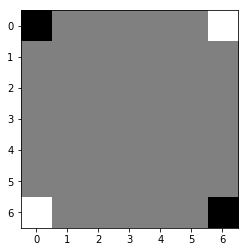

((0, 0), (1, 1)): n_v:   684 q_all:+0.003856 q:+0.004628 q_m:+0.033333 p:0.379824
((6, 6), (5, 5)): n_v:   665 q_all:+0.003312 q:+0.017064 q_m:+0.033333 p:0.370862
((0, 0), (0, 1)): n_v:   133 q_all:-0.009355 q:-0.016971 q_m:+0.033333 p:0.082187
((6, 6), (6, 5)): n_v:   121 q_all:-0.007235 q:-0.003708 q_m:+0.033333 p:0.073760
((0, 0), (1, 0)): n_v:    81 q_all:-0.002966 q:+0.004100 q_m:+0.033333 p:0.047497
((6, 6), (5, 6)): n_v:    76 q_all:-0.001069 q:+0.007339 q_m:+0.033333 p:0.044222
((6, 6), (6, 4)): n_v:     0 q_all:-0.006230 q:-0.006230 q_m:-0.000000 p:0.000022
((0, 0), (1, 2)): n_v:     0 q_all:-0.028677 q:-0.028677 q_m:-0.000000 p:0.000095
((0, 0), (2, 2)): n_v:     0 q_all:-0.026388 q:-0.026388 q_m:-0.000000 p:0.000235
((0, 0), (0, 2)): n_v:     0 q_all:-0.036040 q:-0.036040 q_m:-0.000000 p:0.000029
((6, 6), (4, 6)): n_v:     0 q_all:-0.017304 q:-0.017304 q_m:-0.000000 p:0.000235
((6, 6), (5, 4)): n_v:     0 q_all:-0.000022 q:-0.000022 q_m:-0.000000 p:0.000113
((6, 6), (4, 4))

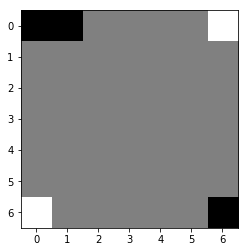

((0, 6), (1, 5)): n_v:   718 q_all:-0.011148 q:-0.009391 q_m:-0.000000 p:0.378180
((6, 0), (5, 1)): n_v:   681 q_all:-0.009760 q:-0.002693 q_m:-0.000000 p:0.354195
((0, 6), (1, 6)): n_v:   213 q_all:-0.015837 q:-0.025715 q_m:-0.000000 p:0.116696
((6, 0), (5, 0)): n_v:   165 q_all:-0.009015 q:+0.000863 q_m:-0.000000 p:0.085405
((0, 6), (0, 5)): n_v:    66 q_all:-0.014885 q:-0.021588 q_m:-0.000000 p:0.036052
((6, 0), (6, 1)): n_v:    50 q_all:-0.015081 q:-0.002710 q_m:-0.000000 p:0.027458
((0, 6), (2, 4)): n_v:     0 q_all:-0.033108 q:-0.033108 q_m:-0.033333 p:0.000264
((6, 0), (6, 2)): n_v:     0 q_all:-0.022308 q:-0.022308 q_m:-0.033333 p:0.000102
((6, 0), (5, 2)): n_v:     0 q_all:-0.020846 q:-0.020846 q_m:-0.033333 p:0.000143
((6, 0), (4, 1)): n_v:     0 q_all:-0.004137 q:-0.004137 q_m:-0.033333 p:0.000128
((0, 6), (2, 6)): n_v:     0 q_all:-0.016416 q:-0.016416 q_m:-0.033333 p:0.000262
((0, 6), (0, 4)): n_v:     0 q_all:-0.036394 q:-0.036394 q_m:-0.033333 p:0.000107
((0, 6), (2, 5))

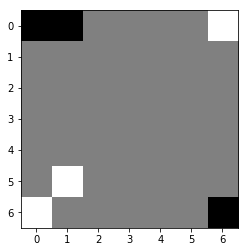

((6, 6), (5, 5)): n_v:  1159 q_all:-0.002290 q:+0.007244 q_m:+0.033333 p:0.366946
((6, 6), (6, 5)): n_v:   406 q_all:-0.012488 q:-0.015007 q_m:+0.033333 p:0.145176
((0, 0), (1, 1)): n_v:   377 q_all:-0.005421 q:-0.029684 q_m:+0.033333 p:0.124227
((6, 6), (5, 6)): n_v:   335 q_all:-0.012378 q:-0.006562 q_m:+0.033333 p:0.119785
((0, 0), (1, 0)): n_v:    78 q_all:-0.025959 q:-0.043434 q_m:+0.033333 p:0.032366
((0, 1), (1, 2)): n_v:    62 q_all:-0.026679 q:-0.055236 q_m:+0.033333 p:0.025848
((0, 1), (0, 2)): n_v:    21 q_all:-0.031570 q:-0.048552 q_m:+0.033333 p:0.009313
((6, 6), (4, 5)): n_v:     1 q_all:-0.009628 q:-0.022642 q_m:-0.000000 p:0.000442
((6, 6), (5, 4)): n_v:     1 q_all:-0.007644 q:-0.011998 q_m:-0.000000 p:0.000616
((6, 6), (4, 4)): n_v:     1 q_all:+0.007435 q:-0.019087 q_m:-0.000000 p:0.000408
((0, 1), (0, 3)): n_v:     0 q_all:-0.045509 q:-0.045509 q_m:-0.000000 p:0.000156
((6, 6), (6, 4)): n_v:     0 q_all:-0.015173 q:-0.015173 q_m:-0.000000 p:0.000069
((0, 0), (0, 2))

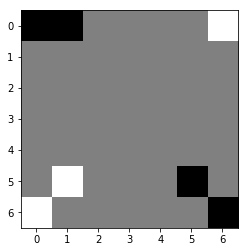

((0, 6), (1, 5)): n_v:   669 q_all:-0.004889 q:+0.001773 q_m:-0.000000 p:0.196635
((5, 1), (4, 2)): n_v:   629 q_all:-0.000181 q:-0.019952 q_m:-0.000000 p:0.174114
((5, 1), (4, 0)): n_v:   337 q_all:-0.019956 q:-0.022050 q_m:-0.000000 p:0.117907
((0, 6), (1, 6)): n_v:   291 q_all:-0.010711 q:-0.013354 q_m:-0.000000 p:0.091864
((5, 1), (5, 0)): n_v:   281 q_all:-0.008371 q:-0.023106 q_m:-0.000000 p:0.086462
((5, 1), (4, 1)): n_v:   249 q_all:-0.009506 q:-0.017983 q_m:-0.000000 p:0.077570
((5, 1), (5, 2)): n_v:   164 q_all:-0.008354 q:-0.010179 q_m:-0.000000 p:0.050395
((0, 6), (0, 5)): n_v:   132 q_all:-0.009230 q:-0.010121 q_m:-0.000000 p:0.040998
((5, 1), (6, 1)): n_v:    78 q_all:-0.017521 q:-0.034326 q_m:-0.000000 p:0.026780
((5, 1), (6, 2)): n_v:    63 q_all:-0.009309 q:-0.020729 q_m:-0.000000 p:0.019429
((5, 1), (3, 0)): n_v:     1 q_all:-0.033340 q:-0.024917 q_m:-0.033333 p:0.000415
((5, 1), (5, 3)): n_v:     1 q_all:-0.026671 q:-0.019975 q_m:-0.033333 p:0.000597
((0, 6), (2, 6))

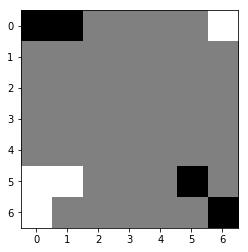

((5, 5), (6, 5)): n_v:   639 q_all:-0.006785 q:-0.009245 q_m:+0.033333 p:0.222474
((5, 5), (4, 4)): n_v:   414 q_all:+0.023767 q:+0.009659 q_m:+0.033333 p:0.088337
((5, 5), (4, 5)): n_v:   371 q_all:+0.003402 q:-0.003726 q_m:+0.033333 p:0.112708
((0, 0), (1, 1)): n_v:   184 q_all:-0.001417 q:-0.007903 q_m:+0.033333 p:0.059722
((5, 5), (5, 6)): n_v:   142 q_all:-0.006362 q:-0.002626 q_m:+0.033333 p:0.049174
((5, 5), (5, 4)): n_v:    89 q_all:+0.008463 q:+0.007658 q_m:+0.033333 p:0.025161
((5, 5), (4, 6)): n_v:    79 q_all:-0.016609 q:+0.000765 q_m:+0.033333 p:0.030951
((5, 5), (6, 4)): n_v:    51 q_all:+0.004196 q:+0.008296 q_m:+0.033333 p:0.015301
((0, 0), (1, 0)): n_v:    23 q_all:-0.017407 q:-0.024448 q_m:+0.033333 p:0.009403
((0, 1), (1, 2)): n_v:    14 q_all:-0.018853 q:-0.032855 q_m:+0.033333 p:0.005848
((0, 1), (0, 2)): n_v:     8 q_all:-0.026194 q:-0.029149 q_m:+0.033333 p:0.003566
((0, 1), (0, 3)): n_v:     0 q_all:-0.023378 q:-0.023378 q_m:-0.000000 p:0.000221
((5, 5), (3, 6))

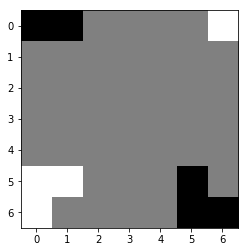

((5, 1), (5, 2)): n_v:   608 q_all:+0.014681 q:-0.015666 q_m:-0.000000 p:0.197907
((0, 6), (1, 6)): n_v:   551 q_all:-0.006818 q:-0.004636 q_m:-0.000000 p:0.228046
((5, 1), (4, 2)): n_v:   489 q_all:+0.016474 q:-0.027424 q_m:-0.000000 p:0.155975
((0, 6), (1, 5)): n_v:   372 q_all:-0.000517 q:+0.009845 q_m:-0.000000 p:0.144502
((5, 0), (4, 1)): n_v:    75 q_all:-0.007170 q:+0.005104 q_m:-0.000000 p:0.031095
((5, 1), (6, 2)): n_v:    71 q_all:+0.020219 q:-0.025716 q_m:-0.000000 p:0.021536
((5, 0), (6, 1)): n_v:    69 q_all:+0.005025 q:+0.022828 q_m:-0.000000 p:0.025378
((0, 6), (0, 5)): n_v:    67 q_all:-0.005723 q:-0.001259 q_m:-0.000000 p:0.027639
((5, 0), (4, 0)): n_v:    57 q_all:-0.016996 q:-0.015928 q_m:-0.000000 p:0.025851
((5, 1), (5, 3)): n_v:     2 q_all:-0.024863 q:-0.014358 q_m:-0.033333 p:0.000979
((5, 0), (3, 1)): n_v:     2 q_all:-0.014433 q:-0.010564 q_m:-0.033333 p:0.001182
((5, 0), (3, 2)): n_v:     1 q_all:-0.036941 q:-0.004598 q_m:-0.033333 p:0.000486
((5, 0), (5, 2))

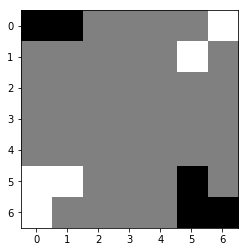

((5, 5), (4, 5)): n_v:   597 q_all:+0.015830 q:-0.018532 q_m:+0.033333 p:0.188161
((5, 5), (4, 4)): n_v:   512 q_all:+0.021540 q:-0.011382 q_m:+0.033333 p:0.148128
((0, 0), (1, 1)): n_v:   198 q_all:-0.002821 q:-0.017997 q_m:+0.033333 p:0.079070
((5, 5), (5, 4)): n_v:   157 q_all:-0.008624 q:-0.003772 q_m:+0.033333 p:0.066883
((0, 1), (1, 2)): n_v:   127 q_all:-0.012074 q:-0.040260 q_m:+0.033333 p:0.056070
((5, 5), (5, 6)): n_v:   107 q_all:-0.005435 q:-0.003626 q_m:+0.033333 p:0.044324
((5, 5), (6, 4)): n_v:    98 q_all:+0.007572 q:-0.005396 q_m:+0.033333 p:0.034722
((5, 5), (4, 6)): n_v:    64 q_all:-0.008698 q:-0.018365 q_m:+0.033333 p:0.027377
((0, 0), (1, 0)): n_v:    57 q_all:-0.022105 q:-0.034426 q_m:+0.033333 p:0.027903
((0, 1), (0, 2)): n_v:    40 q_all:-0.017037 q:-0.037314 q_m:+0.033333 p:0.018850
((6, 6), (4, 5)): n_v:     2 q_all:+0.021042 q:-0.029808 q_m:-0.000000 p:0.000732
((6, 5), (6, 3)): n_v:     2 q_all:+0.007475 q:-0.016462 q_m:-0.000000 p:0.000763
((0, 1), (0, 3))

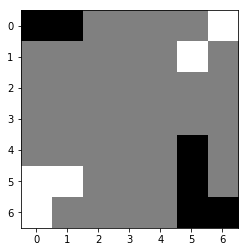

((5, 1), (5, 2)): n_v:   768 q_all:+0.007621 q:-0.014943 q_m:-0.000000 p:0.283966
((5, 1), (4, 2)): n_v:   339 q_all:+0.020842 q:-0.023862 q_m:-0.000000 p:0.106475
((0, 6), (1, 6)): n_v:   238 q_all:+0.000884 q:-0.025110 q_m:-0.000000 p:0.095145
((1, 5), (2, 4)): n_v:   119 q_all:+0.009585 q:+0.004807 q_m:-0.000000 p:0.043039
((1, 5), (1, 4)): n_v:    92 q_all:-0.003643 q:-0.008843 q_m:-0.000000 p:0.038406
((1, 5), (2, 6)): n_v:    71 q_all:+0.017280 q:+0.001077 q_m:-0.000000 p:0.023217
((1, 5), (3, 6)): n_v:    69 q_all:-0.024860 q:+0.008878 q_m:+0.033333 p:0.034959
((5, 1), (6, 2)): n_v:    68 q_all:+0.031523 q:-0.020115 q_m:-0.000000 p:0.018395
((1, 5), (3, 5)): n_v:    68 q_all:-0.039953 q:+0.007540 q_m:+0.033333 p:0.039125
((1, 5), (3, 4)): n_v:    64 q_all:-0.032500 q:+0.004820 q_m:+0.033333 p:0.034967
((5, 0), (4, 0)): n_v:    41 q_all:-0.001556 q:-0.013525 q_m:-0.000000 p:0.017053
((1, 5), (2, 5)): n_v:    31 q_all:+0.016055 q:-0.009370 q_m:-0.000000 p:0.010526
((5, 0), (6, 1))

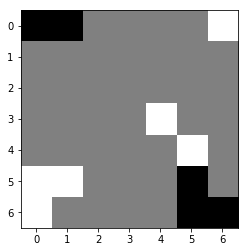

((5, 5), (4, 4)): n_v:  1583 q_all:+0.069811 q:+0.021607 q_m:+0.133333 p:0.612097
((5, 5), (5, 6)): n_v:    96 q_all:-0.004272 q:-0.002570 q_m:+0.066667 p:0.070744
((6, 6), (4, 4)): n_v:    57 q_all:+0.074473 q:+0.009814 q_m:+0.100000 p:0.021067
((5, 5), (5, 4)): n_v:    30 q_all:-0.022586 q:-0.011165 q_m:+0.066667 p:0.025300
((6, 5), (4, 4)): n_v:    20 q_all:+0.051906 q:+0.014766 q_m:+0.100000 p:0.009874
((5, 5), (4, 6)): n_v:    11 q_all:-0.159384 q:-0.024199 q_m:+0.066667 p:0.016359
((5, 5), (3, 5)): n_v:    10 q_all:+0.043989 q:+0.013999 q_m:+0.100000 p:0.005332
((5, 5), (6, 4)): n_v:     4 q_all:-0.041349 q:-0.076617 q_m:-0.000000 p:0.003767
((5, 5), (4, 3)): n_v:     3 q_all:+0.007005 q:-0.012238 q_m:+0.033333 p:0.002367
((0, 0), (1, 1)): n_v:     2 q_all:-0.066433 q:-0.063224 q_m:-0.000000 p:0.002380
((6, 5), (4, 3)): n_v:     2 q_all:-0.016369 q:-0.031832 q_m:+0.033333 p:0.001695
((0, 1), (1, 2)): n_v:     1 q_all:-0.132924 q:-0.088147 q_m:-0.000000 p:0.001412
((0, 0), (1, 0))

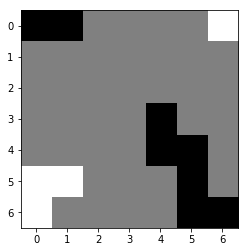

((5, 1), (5, 2)): n_v:  1193 q_all:-0.039032 q:-0.064510 q_m:-0.100000 p:0.308689
((5, 0), (3, 1)): n_v:   589 q_all:-0.082115 q:-0.076043 q_m:-0.133333 p:0.242167
((5, 1), (3, 1)): n_v:   344 q_all:-0.054926 q:-0.089173 q_m:-0.133333 p:0.108692
((5, 1), (4, 3)): n_v:   293 q_all:-0.039613 q:-0.034878 q_m:-0.000000 p:0.076613
((5, 1), (3, 3)): n_v:   263 q_all:-0.074129 q:-0.026907 q_m:-0.000000 p:0.100999
((5, 1), (4, 2)): n_v:   146 q_all:-0.022217 q:-0.063540 q_m:-0.100000 p:0.029203
((5, 1), (5, 3)): n_v:    60 q_all:-0.052387 q:-0.032359 q_m:-0.066667 p:0.018388
((5, 1), (6, 2)): n_v:    44 q_all:-0.011053 q:-0.067894 q_m:-0.100000 p:0.007057
((6, 0), (5, 2)): n_v:    39 q_all:-0.072125 q:-0.072875 q_m:-0.133333 p:0.014886
((0, 6), (1, 5)): n_v:    36 q_all:-0.046966 q:-0.028980 q_m:-0.100000 p:0.010561
((5, 0), (6, 1)): n_v:    29 q_all:-0.038625 q:-0.043885 q_m:-0.100000 p:0.007537
((0, 6), (1, 6)): n_v:    28 q_all:-0.045986 q:-0.046074 q_m:-0.100000 p:0.008126
((5, 0), (4, 1))

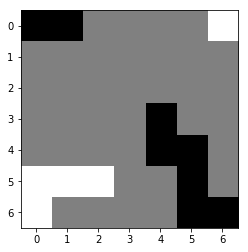

((4, 4), (4, 2)): n_v:   678 q_all:+0.062067 q:+0.093290 q_m:+0.233333 p:0.133215
((3, 4), (4, 3)): n_v:   647 q_all:+0.049833 q:+0.089845 q_m:+0.200000 p:0.156580
((4, 4), (5, 3)): n_v:   408 q_all:+0.031262 q:+0.063040 q_m:+0.200000 p:0.127149
((4, 5), (4, 3)): n_v:   238 q_all:+0.040421 q:+0.079022 q_m:+0.166667 p:0.066023
((3, 4), (4, 2)): n_v:   138 q_all:+0.066574 q:+0.105063 q_m:+0.233333 p:0.024815
((4, 4), (6, 2)): n_v:   123 q_all:+0.037619 q:+0.075388 q_m:+0.233333 p:0.035435
((3, 4), (2, 3)): n_v:    78 q_all:-0.003534 q:+0.030858 q_m:+0.133333 p:0.034521
((4, 4), (6, 3)): n_v:    52 q_all:+0.058052 q:+0.059556 q_m:+0.166667 p:0.011023
((3, 4), (2, 4)): n_v:    49 q_all:-0.001962 q:+0.027558 q_m:+0.133333 p:0.021628
((4, 5), (6, 3)): n_v:    43 q_all:+0.036068 q:+0.052770 q_m:+0.166667 p:0.012881
((3, 4), (1, 5)): n_v:    40 q_all:+0.018386 q:+0.067129 q_m:+0.166667 p:0.014662
((5, 5), (6, 4)): n_v:    34 q_all:-0.045523 q:+0.018999 q_m:+0.133333 p:0.020671
((4, 4), (5, 6))

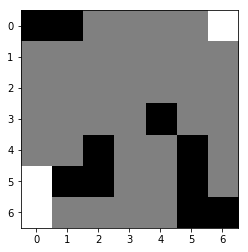

((5, 0), (4, 1)): n_v:  1686 q_all:-0.018023 q:-0.016204 q_m:-0.000000 p:0.663415
((6, 0), (4, 1)): n_v:   595 q_all:-0.032460 q:-0.072736 q_m:-0.033333 p:0.269219
((5, 0), (6, 1)): n_v:    36 q_all:-0.057066 q:-0.073871 q_m:-0.066667 p:0.020201
((6, 0), (6, 2)): n_v:     8 q_all:-0.189873 q:-0.142196 q_m:-0.100000 p:0.008710
((5, 0), (3, 2)): n_v:     6 q_all:-0.108095 q:-0.154213 q_m:-0.166667 p:0.005050
((5, 0), (3, 1)): n_v:     4 q_all:-0.137676 q:-0.171359 q_m:-0.166667 p:0.004235
((5, 0), (4, 0)): n_v:     3 q_all:-0.143770 q:-0.162216 q_m:-0.133333 p:0.003597
((0, 6), (2, 5)): n_v:     3 q_all:-0.062991 q:-0.109609 q_m:-0.166667 p:0.001857
((0, 6), (1, 6)): n_v:     1 q_all:-0.206766 q:-0.163049 q_m:-0.200000 p:0.001197
((5, 0), (3, 0)): n_v:     1 q_all:-0.149232 q:-0.210311 q_m:-0.233333 p:0.001216
((0, 6), (2, 4)): n_v:     0 q_all:-0.151190 q:-0.151190 q_m:-0.166667 p:0.000343
((0, 6), (0, 5)): n_v:     0 q_all:-0.168277 q:-0.168277 q_m:-0.200000 p:0.000561
((5, 0), (6, 2))

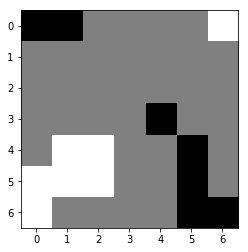

((3, 4), (4, 3)): n_v:  1974 q_all:+0.019302 q:+0.075358 q_m:+0.166667 p:0.547759
((3, 4), (3, 2)): n_v:   565 q_all:+0.036557 q:+0.025305 q_m:+0.133333 p:0.123401
((4, 5), (4, 3)): n_v:   339 q_all:+0.004741 q:+0.083804 q_m:+0.133333 p:0.110856
((3, 4), (2, 3)): n_v:   157 q_all:-0.015163 q:-0.008610 q_m:+0.033333 p:0.062319
((3, 4), (4, 6)): n_v:    41 q_all:-0.024397 q:-0.027814 q_m:-0.000000 p:0.017825
((4, 5), (5, 3)): n_v:    37 q_all:-0.000684 q:+0.072350 q_m:+0.133333 p:0.012761
((4, 5), (5, 6)): n_v:    34 q_all:-0.011148 q:+0.015194 q_m:+0.033333 p:0.013142
((5, 5), (4, 3)): n_v:    29 q_all:+0.005776 q:+0.080729 q_m:+0.133333 p:0.009697
((3, 4), (5, 3)): n_v:    24 q_all:+0.007835 q:+0.057498 q_m:+0.133333 p:0.007817
((3, 4), (2, 2)): n_v:    18 q_all:-0.038545 q:-0.011269 q_m:-0.000000 p:0.008997
((5, 5), (5, 3)): n_v:    13 q_all:+0.012972 q:+0.066569 q_m:+0.133333 p:0.004121
((4, 5), (6, 3)): n_v:    12 q_all:+0.013424 q:+0.031612 q_m:+0.066667 p:0.003820
((3, 4), (5, 6))

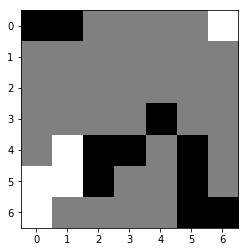

((5, 1), (5, 3)): n_v:  1644 q_all:+0.005152 q:+0.000955 q_m:+0.033333 p:0.416605
((4, 1), (5, 3)): n_v:   877 q_all:+0.009393 q:-0.010437 q_m:+0.033333 p:0.209961
((5, 1), (3, 3)): n_v:   513 q_all:-0.036544 q:-0.031568 q_m:+0.033333 p:0.201512
((4, 1), (3, 3)): n_v:   213 q_all:-0.035689 q:-0.049024 q_m:+0.033333 p:0.083270
((4, 1), (3, 2)): n_v:    66 q_all:-0.078995 q:-0.055557 q_m:-0.000000 p:0.035413
((5, 0), (3, 2)): n_v:    14 q_all:-0.085624 q:-0.080965 q_m:-0.033333 p:0.007897
((5, 0), (6, 1)): n_v:    11 q_all:-0.034000 q:-0.038771 q_m:-0.066667 p:0.003926
((5, 1), (3, 2)): n_v:     9 q_all:-0.058057 q:-0.066289 q_m:-0.033333 p:0.004527
((4, 1), (3, 1)): n_v:     6 q_all:-0.101481 q:-0.116459 q_m:-0.066667 p:0.003415
((5, 0), (3, 1)): n_v:     4 q_all:-0.092903 q:-0.097966 q_m:-0.100000 p:0.002596
((4, 1), (2, 3)): n_v:     4 q_all:-0.085319 q:-0.080844 q_m:-0.100000 p:0.002389
((4, 1), (6, 1)): n_v:     3 q_all:-0.126984 q:-0.117678 q_m:-0.100000 p:0.002149
((0, 6), (2, 4))

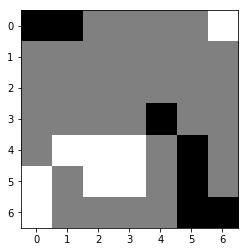

((3, 4), (1, 5)): n_v:   780 q_all:-0.014912 q:-0.014541 q_m:+0.033333 p:0.259847
((3, 4), (3, 2)): n_v:   595 q_all:+0.040587 q:+0.028147 q_m:+0.166667 p:0.082041
((6, 5), (6, 3)): n_v:   324 q_all:+0.016031 q:+0.023348 q_m:+0.100000 p:0.072855
((3, 4), (5, 4)): n_v:   210 q_all:-0.052852 q:+0.001270 q_m:+0.100000 p:0.097838
((4, 5), (6, 3)): n_v:   166 q_all:+0.027919 q:+0.030620 q_m:+0.100000 p:0.030355
((5, 5), (6, 3)): n_v:   132 q_all:+0.006859 q:+0.031629 q_m:+0.100000 p:0.033787
((3, 4), (4, 4)): n_v:   106 q_all:-0.036914 q:+0.000073 q_m:+0.133333 p:0.043635
((3, 4), (4, 6)): n_v:    95 q_all:-0.037262 q:-0.051526 q_m:-0.033333 p:0.039173
((0, 0), (1, 1)): n_v:    83 q_all:+0.002018 q:-0.035332 q_m:-0.000000 p:0.022837
((3, 4), (2, 2)): n_v:    74 q_all:-0.010096 q:-0.042802 q_m:-0.033333 p:0.023650
((4, 5), (5, 4)): n_v:    54 q_all:-0.053390 q:+0.004954 q_m:+0.133333 p:0.025558
((3, 4), (5, 6)): n_v:    50 q_all:-0.034747 q:-0.066482 q_m:-0.033333 p:0.020399
((3, 4), (1, 2))

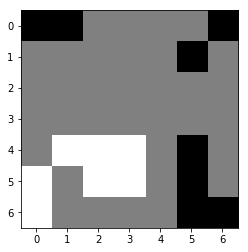

((4, 3), (5, 4)): n_v:  1365 q_all:+0.013082 q:-0.000047 q_m:+0.200000 p:0.389666
((4, 2), (5, 4)): n_v:   540 q_all:-0.006075 q:-0.018300 q_m:+0.166667 p:0.195602
((5, 2), (5, 4)): n_v:   210 q_all:+0.019632 q:+0.009024 q_m:+0.166667 p:0.054465
((4, 3), (5, 1)): n_v:    31 q_all:-0.089392 q:-0.077619 q_m:-0.033333 p:0.021789
((5, 3), (5, 1)): n_v:    23 q_all:-0.089767 q:-0.103123 q_m:-0.033333 p:0.016192
((4, 3), (6, 1)): n_v:    22 q_all:-0.107363 q:-0.145232 q_m:-0.033333 p:0.017135
((4, 3), (4, 4)): n_v:    15 q_all:+0.002787 q:-0.016446 q_m:+0.133333 p:0.005184
((4, 1), (5, 1)): n_v:    14 q_all:-0.011138 q:-0.036119 q_m:-0.000000 p:0.005732
((4, 2), (6, 1)): n_v:    10 q_all:-0.057065 q:-0.125678 q_m:-0.033333 p:0.005917
((4, 3), (6, 4)): n_v:    10 q_all:-0.032345 q:-0.054107 q_m:+0.100000 p:0.004833
((4, 2), (4, 4)): n_v:    10 q_all:-0.035234 q:-0.023889 q_m:+0.100000 p:0.005015
((5, 3), (6, 4)): n_v:     9 q_all:-0.005386 q:-0.026744 q_m:+0.133333 p:0.003522
((4, 3), (2, 1))

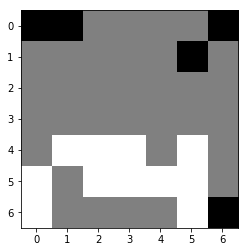

((6, 6), (6, 4)): n_v:  1530 q_all:-0.000760 q:-0.012224 q_m:+0.066667 p:0.436112
((6, 6), (4, 4)): n_v:   413 q_all:+0.038450 q:+0.042307 q_m:+0.133333 p:0.058172
((1, 5), (3, 4)): n_v:   299 q_all:-0.072872 q:-0.081190 q_m:-0.066667 p:0.164578
((0, 6), (0, 4)): n_v:   130 q_all:-0.079267 q:-0.142707 q_m:-0.200000 p:0.074316
((0, 0), (0, 2)): n_v:    89 q_all:-0.106927 q:-0.169906 q_m:-0.200000 p:0.060140
((1, 5), (2, 4)): n_v:    72 q_all:-0.035720 q:-0.099868 q_m:-0.166667 p:0.029680
((0, 0), (2, 2)): n_v:    66 q_all:-0.078657 q:-0.151300 q_m:-0.200000 p:0.037926
((0, 1), (2, 2)): n_v:    51 q_all:-0.070477 q:-0.175381 q_m:-0.200000 p:0.027470
((6, 6), (5, 6)): n_v:    47 q_all:+0.030191 q:-0.048029 q_m:+0.033333 p:0.008125
((0, 0), (1, 1)): n_v:    38 q_all:-0.081654 q:-0.140596 q_m:-0.166667 p:0.022384
((0, 6), (2, 4)): n_v:    25 q_all:-0.041003 q:-0.119909 q_m:-0.200000 p:0.011190
((1, 5), (3, 3)): n_v:    21 q_all:-0.043452 q:-0.067755 q_m:-0.066667 p:0.009408
((1, 5), (0, 4))

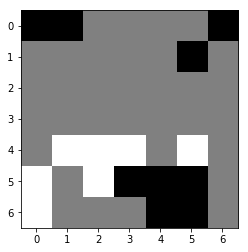

((5, 2), (6, 3)): n_v:  1716 q_all:-0.003081 q:-0.005850 q_m:+0.166667 p:0.556091
((4, 3), (6, 3)): n_v:   813 q_all:+0.025879 q:-0.035420 q_m:+0.133333 p:0.181413
((4, 2), (6, 3)): n_v:   205 q_all:-0.032574 q:-0.043779 q_m:+0.133333 p:0.087581
((5, 2), (4, 4)): n_v:   146 q_all:+0.025049 q:+0.023216 q_m:+0.133333 p:0.033122
((4, 5), (6, 3)): n_v:   137 q_all:-0.001844 q:-0.008495 q_m:+0.133333 p:0.043940
((4, 3), (4, 4)): n_v:    81 q_all:-0.003328 q:-0.018360 q_m:+0.166667 p:0.026516
((4, 2), (4, 4)): n_v:    46 q_all:-0.023002 q:-0.032748 q_m:+0.133333 p:0.018343
((4, 1), (6, 3)): n_v:    25 q_all:-0.017192 q:-0.004713 q_m:+0.133333 p:0.009458
((4, 5), (5, 6)): n_v:     3 q_all:-0.015681 q:+0.011512 q_m:+0.100000 p:0.001320
((4, 3), (6, 1)): n_v:     3 q_all:-0.172003 q:-0.112267 q_m:-0.066667 p:0.003180
((4, 2), (2, 4)): n_v:     3 q_all:-0.011600 q:-0.007886 q_m:-0.000000 p:0.001235
((4, 5), (6, 6)): n_v:     2 q_all:-0.035395 q:-0.005744 q_m:+0.066667 p:0.001139
((4, 3), (5, 1))

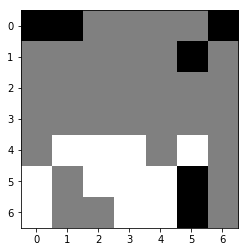

((5, 5), (4, 4)): n_v:  2377 q_all:+0.022573 q:+0.010070 q_m:+0.133333 p:0.552375
((1, 5), (2, 4)): n_v:   185 q_all:-0.032983 q:-0.062543 q_m:-0.133333 p:0.079072
((0, 0), (1, 1)): n_v:   165 q_all:-0.097239 q:-0.100822 q_m:-0.133333 p:0.107426
((6, 5), (4, 4)): n_v:    56 q_all:+0.053571 q:+0.014654 q_m:+0.100000 p:0.007101
((0, 0), (2, 2)): n_v:    48 q_all:-0.083086 q:-0.107492 q_m:-0.166667 p:0.028202
((0, 1), (0, 2)): n_v:    31 q_all:-0.101775 q:-0.118179 q_m:-0.133333 p:0.020884
((1, 5), (3, 4)): n_v:    25 q_all:-0.110013 q:-0.063691 q_m:-0.033333 p:0.017779
((5, 5), (3, 4)): n_v:    17 q_all:-0.021504 q:-0.037615 q_m:-0.033333 p:0.006621
((1, 5), (0, 4)): n_v:    13 q_all:-0.113255 q:-0.073319 q_m:-0.133333 p:0.009002
((1, 5), (3, 3)): n_v:    11 q_all:-0.025684 q:-0.036425 q_m:-0.033333 p:0.004573
((0, 6), (2, 4)): n_v:    10 q_all:-0.048261 q:-0.083697 q_m:-0.166667 p:0.005205
((0, 0), (0, 2)): n_v:    10 q_all:-0.147070 q:-0.128492 q_m:-0.166667 p:0.008734
((5, 5), (4, 6))

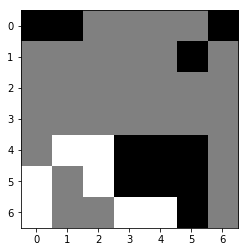

((4, 2), (3, 4)): n_v:  2447 q_all:-0.008627 q:-0.015877 q_m:+0.066667 p:0.365746
((4, 2), (3, 3)): n_v:   454 q_all:-0.045923 q:-0.026076 q_m:+0.033333 p:0.120539
((6, 4), (5, 6)): n_v:   269 q_all:-0.026596 q:-0.023499 q_m:+0.066667 p:0.055097
((4, 1), (3, 2)): n_v:   100 q_all:-0.062126 q:-0.030742 q_m:-0.033333 p:0.031689
((6, 4), (6, 2)): n_v:    77 q_all:-0.112908 q:-0.118087 q_m:-0.066667 p:0.036653
((5, 2), (6, 2)): n_v:    67 q_all:-0.134795 q:-0.061522 q_m:-0.033333 p:0.036456
((5, 2), (3, 4)): n_v:    51 q_all:-0.013536 q:-0.020208 q_m:+0.066667 p:0.008368
((4, 1), (5, 1)): n_v:    35 q_all:-0.102845 q:-0.067296 q_m:-0.100000 p:0.015819
((4, 1), (3, 3)): n_v:    35 q_all:-0.057192 q:-0.025254 q_m:-0.000000 p:0.010697
((6, 4), (4, 6)): n_v:    33 q_all:-0.083805 q:-0.057343 q_m:-0.000000 p:0.013014
((4, 2), (2, 4)): n_v:    33 q_all:-0.063865 q:-0.009979 q_m:-0.066667 p:0.010571
((4, 1), (4, 0)): n_v:    27 q_all:-0.192494 q:-0.093443 q_m:-0.100000 p:0.019685
((4, 1), (6, 1))

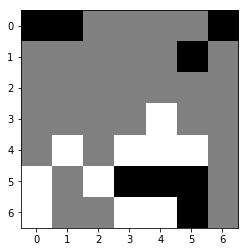

((1, 5), (3, 3)): n_v:  2308 q_all:+0.012852 q:-0.011279 q_m:+0.133333 p:0.615476
((5, 5), (3, 3)): n_v:   541 q_all:-0.004529 q:-0.009652 q_m:+0.133333 p:0.174014
((5, 3), (4, 2)): n_v:   253 q_all:+0.036147 q:+0.037311 q_m:+0.166667 p:0.049020
((5, 3), (3, 3)): n_v:   145 q_all:+0.013751 q:-0.008173 q_m:+0.133333 p:0.038503
((5, 3), (3, 1)): n_v:    93 q_all:+0.046745 q:-0.000904 q_m:-0.000000 p:0.014859
((5, 3), (5, 1)): n_v:    89 q_all:+0.046323 q:+0.080552 q_m:+0.200000 p:0.014369
((5, 3), (3, 5)): n_v:    67 q_all:+0.036210 q:+0.002271 q_m:+0.133333 p:0.013048
((5, 3), (6, 2)): n_v:    57 q_all:+0.048042 q:+0.022982 q_m:+0.100000 p:0.008915
((1, 5), (3, 5)): n_v:    36 q_all:+0.046797 q:+0.014742 q_m:+0.133333 p:0.005895
((5, 4), (3, 3)): n_v:    23 q_all:-0.048084 q:-0.055264 q_m:+0.133333 p:0.010859
((0, 0), (1, 1)): n_v:    20 q_all:-0.039618 q:-0.045447 q_m:-0.033333 p:0.009043
((5, 3), (6, 1)): n_v:    16 q_all:+0.017566 q:+0.027306 q_m:+0.133333 p:0.004240
((5, 5), (3, 5))

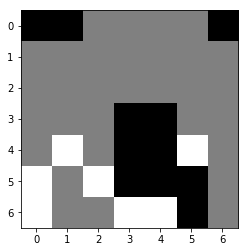

((4, 1), (4, 2)): n_v:  2574 q_all:-0.015091 q:-0.011584 q_m:+0.100000 p:0.361172
((6, 4), (4, 2)): n_v:   551 q_all:-0.023354 q:-0.056514 q_m:+0.066667 p:0.091698
((4, 5), (5, 6)): n_v:   116 q_all:+0.013588 q:+0.034886 q_m:+0.033333 p:0.006135
((6, 0), (4, 2)): n_v:    83 q_all:-0.030944 q:-0.027256 q_m:+0.066667 p:0.015619
((5, 0), (4, 2)): n_v:    54 q_all:-0.027961 q:-0.003193 q_m:+0.066667 p:0.009719
((6, 3), (4, 2)): n_v:    46 q_all:-0.048077 q:-0.043239 q_m:+0.066667 p:0.011390
((4, 1), (2, 2)): n_v:    21 q_all:-0.034453 q:-0.030424 q_m:-0.066667 p:0.004218
((4, 5), (3, 5)): n_v:    19 q_all:-0.020858 q:+0.017707 q_m:+0.033333 p:0.003140
((4, 1), (3, 2)): n_v:    15 q_all:-0.047736 q:-0.026695 q_m:+0.033333 p:0.003862
((4, 1), (5, 1)): n_v:    10 q_all:-0.109482 q:-0.118740 q_m:-0.100000 p:0.004740
((4, 1), (3, 1)): n_v:    10 q_all:-0.093768 q:-0.067576 q_m:-0.100000 p:0.003707
((4, 5), (2, 4)): n_v:     8 q_all:-0.032253 q:+0.000923 q_m:-0.000000 p:0.001703
((4, 5), (6, 6))

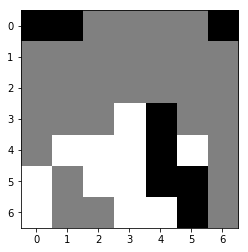

((3, 4), (3, 2)): n_v:  2256 q_all:+0.034757 q:+0.043103 q_m:+0.166667 p:0.477364
((4, 4), (3, 2)): n_v:   729 q_all:-0.012363 q:+0.000696 q_m:+0.166667 p:0.258816
((4, 4), (6, 2)): n_v:   339 q_all:+0.062430 q:+0.037009 q_m:+0.100000 p:0.043130
((5, 4), (3, 2)): n_v:   318 q_all:-0.034317 q:-0.014890 q_m:+0.166667 p:0.134136
((3, 4), (2, 2)): n_v:    18 q_all:-0.045768 q:-0.055253 q_m:-0.033333 p:0.008422
((0, 0), (1, 1)): n_v:    15 q_all:-0.057356 q:-0.078436 q_m:-0.066667 p:0.007390
((3, 4), (2, 3)): n_v:    14 q_all:-0.047046 q:-0.064122 q_m:-0.000000 p:0.006882
((0, 1), (0, 2)): n_v:    12 q_all:-0.054869 q:-0.108355 q_m:-0.066667 p:0.006257
((4, 4), (5, 6)): n_v:    11 q_all:-0.103754 q:-0.083424 q_m:-0.033333 p:0.006713
((3, 4), (1, 5)): n_v:    11 q_all:-0.077615 q:-0.082953 q_m:-0.100000 p:0.006629
((4, 4), (6, 6)): n_v:    10 q_all:-0.108557 q:-0.104113 q_m:-0.100000 p:0.006232
((3, 4), (5, 6)): n_v:     6 q_all:-0.036435 q:-0.085243 q_m:-0.033333 p:0.002740
((5, 4), (6, 2))

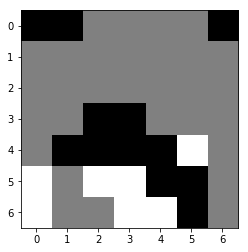

((4, 5), (3, 4)): n_v:  3050 q_all:-0.039493 q:-0.033354 q_m:+0.066667 p:0.721995
((4, 5), (5, 6)): n_v:   186 q_all:-0.034753 q:-0.019985 q_m:-0.000000 p:0.041446
((5, 0), (5, 1)): n_v:   126 q_all:-0.042927 q:-0.067795 q_m:-0.000000 p:0.031440
((5, 0), (3, 1)): n_v:   115 q_all:-0.009130 q:-0.018410 q_m:+0.033333 p:0.016301
((4, 5), (3, 5)): n_v:   115 q_all:-0.081856 q:-0.065924 q_m:-0.066667 p:0.042906
((6, 3), (5, 1)): n_v:    14 q_all:-0.086719 q:-0.095398 q_m:-0.033333 p:0.005715
((5, 3), (3, 4)): n_v:     3 q_all:-0.123769 q:-0.078993 q_m:+0.033333 p:0.001342
((5, 2), (3, 4)): n_v:     3 q_all:-0.038011 q:-0.047339 q_m:+0.033333 p:0.000911
((6, 4), (5, 6)): n_v:     2 q_all:-0.046197 q:-0.087472 q_m:-0.033333 p:0.000633
((5, 0), (4, 0)): n_v:     2 q_all:-0.192446 q:-0.115581 q_m:-0.066667 p:0.001630
((4, 5), (3, 6)): n_v:     1 q_all:-0.081978 q:-0.069035 q_m:-0.133333 p:0.000463
((5, 3), (3, 1)): n_v:     1 q_all:-0.122978 q:-0.081478 q_m:+0.033333 p:0.000570
((5, 0), (6, 1))

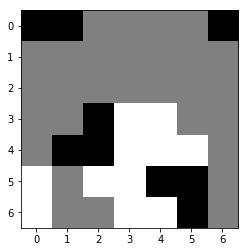

((3, 2), (2, 3)): n_v:  1591 q_all:+0.003604 q:+0.009478 q_m:+0.100000 p:0.343095
((4, 1), (5, 1)): n_v:  1484 q_all:+0.055383 q:+0.072939 q_m:+0.166667 p:0.094446
((3, 2), (5, 1)): n_v:   309 q_all:+0.056081 q:+0.080003 q_m:+0.133333 p:0.019064
((4, 1), (6, 2)): n_v:   139 q_all:+0.035554 q:+0.050749 q_m:+0.133333 p:0.016940
((0, 0), (1, 1)): n_v:    92 q_all:-0.030665 q:-0.051718 q_m:-0.033333 p:0.029104
((5, 5), (5, 6)): n_v:    46 q_all:+0.016792 q:-0.031570 q_m:+0.033333 p:0.008221
((4, 2), (6, 2)): n_v:    43 q_all:+0.064521 q:+0.016300 q_m:+0.133333 p:0.001931
((3, 2), (1, 1)): n_v:    34 q_all:-0.029931 q:-0.038457 q_m:-0.066667 p:0.010924
((4, 1), (6, 1)): n_v:    34 q_all:+0.035475 q:+0.041930 q_m:+0.133333 p:0.004171
((3, 2), (2, 4)): n_v:    31 q_all:-0.023486 q:+0.019718 q_m:+0.066667 p:0.009287
((0, 1), (2, 3)): n_v:    27 q_all:-0.011960 q:-0.011171 q_m:+0.066667 p:0.007289
((4, 1), (2, 3)): n_v:    25 q_all:-0.003823 q:-0.002924 q_m:+0.066667 p:0.006072
((0, 1), (0, 2))

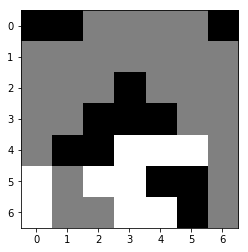

((5, 0), (5, 1)): n_v:  1052 q_all:-0.010045 q:-0.023783 q_m:+0.066667 p:0.160763
((4, 5), (5, 6)): n_v:   962 q_all:-0.009034 q:-0.007658 q_m:+0.066667 p:0.143532
((4, 5), (2, 4)): n_v:   117 q_all:-0.025784 q:-0.016664 q_m:+0.100000 p:0.024500
((4, 4), (3, 5)): n_v:    93 q_all:-0.057252 q:-0.066219 q_m:-0.000000 p:0.029979
((6, 3), (5, 1)): n_v:    78 q_all:-0.051194 q:-0.067711 q_m:+0.033333 p:0.023340
((4, 4), (2, 2)): n_v:    77 q_all:-0.019505 q:-0.012316 q_m:+0.100000 p:0.014270
((5, 0), (3, 1)): n_v:    66 q_all:+0.016010 q:+0.013991 q_m:+0.100000 p:0.003922
((4, 3), (2, 4)): n_v:    62 q_all:-0.062214 q:-0.038834 q_m:+0.100000 p:0.020883
((4, 3), (2, 2)): n_v:    42 q_all:-0.057228 q:-0.028959 q_m:+0.100000 p:0.013557
((5, 0), (6, 1)): n_v:    28 q_all:-0.106632 q:-0.157164 q_m:-0.066667 p:0.013996
((4, 4), (2, 4)): n_v:    24 q_all:-0.032432 q:-0.034173 q_m:+0.100000 p:0.005588
((5, 2), (3, 1)): n_v:    23 q_all:+0.024186 q:-0.012541 q_m:+0.100000 p:0.000723
((4, 3), (5, 1))

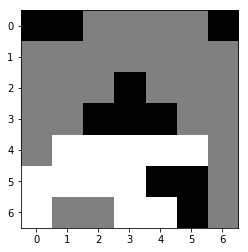

((3, 2), (3, 1)): n_v:  1133 q_all:-0.014980 q:-0.034414 q_m:+0.100000 p:0.418721
((3, 4), (3, 5)): n_v:   351 q_all:-0.015058 q:-0.048538 q_m:+0.100000 p:0.130004
((3, 2), (4, 0)): n_v:   324 q_all:+0.033325 q:+0.006827 q_m:+0.133333 p:0.058978
((2, 3), (3, 1)): n_v:   256 q_all:-0.032310 q:-0.051285 q_m:+0.066667 p:0.112053
((2, 3), (3, 5)): n_v:   172 q_all:-0.014133 q:-0.061569 q_m:+0.066667 p:0.063017
((2, 3), (0, 2)): n_v:    86 q_all:-0.134718 q:-0.137589 q_m:-0.066667 p:0.072074
((3, 4), (4, 6)): n_v:    36 q_all:-0.100391 q:-0.110935 q_m:-0.000000 p:0.025619
((0, 1), (0, 2)): n_v:    32 q_all:-0.108365 q:-0.100610 q_m:-0.033333 p:0.023747
((3, 3), (3, 1)): n_v:    14 q_all:-0.051412 q:-0.058983 q_m:+0.066667 p:0.007421
((3, 2), (2, 0)): n_v:     8 q_all:-0.086759 q:-0.099303 q_m:-0.066667 p:0.005282
((5, 4), (6, 2)): n_v:     8 q_all:-0.079377 q:-0.063667 q_m:+0.200000 p:0.005083
((3, 3), (3, 5)): n_v:     8 q_all:-0.101520 q:-0.097592 q_m:+0.066667 p:0.006026
((5, 5), (4, 6))

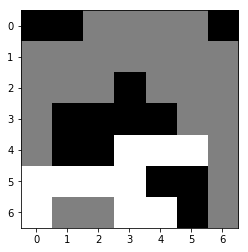

((5, 0), (4, 0)): n_v:   990 q_all:+0.012510 q:-0.043543 q_m:+0.066667 p:0.159437
((4, 5), (5, 6)): n_v:   606 q_all:-0.023686 q:-0.068677 q_m:+0.066667 p:0.181106
((4, 4), (2, 2)): n_v:   396 q_all:-0.041642 q:-0.021116 q_m:+0.166667 p:0.145739
((6, 0), (4, 0)): n_v:   166 q_all:+0.025291 q:-0.052304 q_m:+0.033333 p:0.018347
((4, 3), (2, 2)): n_v:   108 q_all:-0.073182 q:-0.062262 q_m:+0.166667 p:0.053176
((4, 3), (2, 4)): n_v:    78 q_all:-0.091161 q:-0.097731 q_m:+0.100000 p:0.043409
((4, 5), (2, 4)): n_v:    70 q_all:-0.005722 q:-0.061554 q_m:+0.100000 p:0.016367
((4, 5), (4, 6)): n_v:    68 q_all:-0.094057 q:-0.139919 q_m:-0.000000 p:0.039033
((6, 4), (5, 6)): n_v:    18 q_all:-0.036048 q:-0.150790 q_m:+0.033333 p:0.006394
((5, 0), (3, 0)): n_v:    17 q_all:+0.018594 q:-0.065148 q_m:+0.033333 p:0.002018
((4, 4), (3, 5)): n_v:    16 q_all:-0.070740 q:-0.116520 q_m:-0.000000 p:0.007668
((5, 2), (4, 0)): n_v:    14 q_all:-0.096413 q:-0.131178 q_m:+0.033333 p:0.008096
((5, 0), (6, 1))

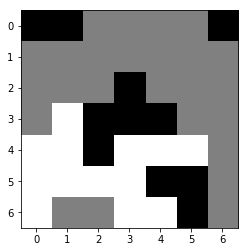

((4, 2), (6, 1)): n_v:  1143 q_all:+0.063187 q:+0.020817 q_m:+0.200000 p:0.014614
((0, 1), (0, 2)): n_v:   448 q_all:-0.111478 q:-0.122463 q_m:-0.033333 p:0.304609
((4, 2), (3, 0)): n_v:   352 q_all:-0.037772 q:-0.017396 q_m:+0.133333 p:0.139808
((3, 4), (3, 5)): n_v:   221 q_all:-0.057417 q:-0.035576 q_m:+0.100000 p:0.104607
((2, 3), (0, 2)): n_v:   126 q_all:-0.124347 q:-0.158985 q_m:-0.066667 p:0.091939
((3, 2), (3, 0)): n_v:    92 q_all:-0.067214 q:-0.023717 q_m:+0.133333 p:0.047161
((5, 4), (3, 6)): n_v:    72 q_all:-0.135071 q:-0.094973 q_m:-0.000000 p:0.055609
((5, 4), (6, 2)): n_v:    55 q_all:+0.007001 q:-0.035084 q_m:+0.200000 p:0.012125
((5, 5), (3, 6)): n_v:    42 q_all:-0.133894 q:-0.095984 q_m:-0.000000 p:0.031997
((2, 3), (3, 5)): n_v:    28 q_all:-0.016195 q:-0.056993 q_m:+0.066667 p:0.008801
((3, 4), (3, 6)): n_v:    20 q_all:-0.069420 q:-0.096148 q_m:-0.000000 p:0.010484
((4, 2), (6, 2)): n_v:    15 q_all:+0.025899 q:-0.052587 q_m:+0.200000 p:0.002152
((5, 5), (6, 6))

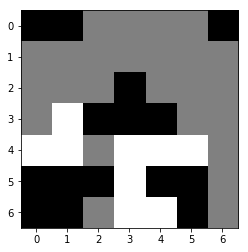

((4, 3), (6, 2)): n_v:   901 q_all:-0.008485 q:-0.136696 q_m:-0.000000 p:0.002351
((3, 1), (4, 2)): n_v:   565 q_all:-0.065715 q:-0.100389 q_m:+0.100000 p:0.124644
((4, 1), (6, 2)): n_v:   387 q_all:-0.012717 q:-0.151252 q_m:-0.000000 p:0.006932
((3, 1), (2, 2)): n_v:   303 q_all:-0.151268 q:-0.117797 q_m:+0.033333 p:0.166312
((6, 4), (4, 2)): n_v:   237 q_all:-0.078050 q:-0.171394 q_m:+0.066667 p:0.063638
((4, 0), (4, 2)): n_v:    86 q_all:-0.066726 q:-0.141234 q_m:+0.066667 p:0.019151
((4, 4), (4, 2)): n_v:    78 q_all:-0.079045 q:-0.126534 q_m:+0.066667 p:0.021314
((6, 3), (4, 2)): n_v:    59 q_all:-0.052505 q:-0.167362 q_m:+0.066667 p:0.010075
((4, 4), (2, 2)): n_v:    43 q_all:-0.170598 q:-0.150532 q_m:-0.000000 p:0.027251
((4, 3), (2, 2)): n_v:    25 q_all:-0.081357 q:-0.124386 q_m:-0.000000 p:0.007254
((4, 3), (2, 4)): n_v:    16 q_all:-0.064850 q:-0.123151 q_m:-0.000000 p:0.003453
((4, 1), (2, 2)): n_v:    14 q_all:-0.084762 q:-0.098923 q_m:-0.000000 p:0.003692
((4, 4), (6, 2))

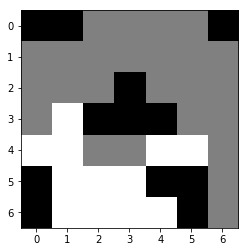

((5, 4), (4, 2)): n_v:  1124 q_all:+0.131847 q:+0.055381 q_m:+0.333333 p:0.029658
((3, 4), (4, 2)): n_v:   456 q_all:-0.023853 q:+0.094710 q_m:+0.333333 p:0.295893
((3, 4), (2, 2)): n_v:   256 q_all:+0.025010 q:+0.014483 q_m:+0.066667 p:0.116241
((3, 2), (4, 3)): n_v:   105 q_all:+0.001793 q:-0.025285 q_m:+0.233333 p:0.057592
((3, 2), (3, 0)): n_v:    77 q_all:+0.108306 q:+0.085850 q_m:+0.200000 p:0.009361
((5, 0), (3, 0)): n_v:    59 q_all:+0.023748 q:+0.002819 q_m:+0.200000 p:0.027267
((2, 3), (3, 5)): n_v:    57 q_all:+0.017823 q:-0.001923 q_m:+0.133333 p:0.027815
((3, 2), (2, 4)): n_v:    48 q_all:-0.020195 q:-0.007973 q_m:-0.000000 p:0.030510
((2, 3), (4, 2)): n_v:    41 q_all:-0.062666 q:+0.063615 q_m:+0.333333 p:0.032776
((3, 4), (3, 5)): n_v:    34 q_all:+0.028611 q:+0.013072 q_m:+0.166667 p:0.014861
((3, 4), (1, 6)): n_v:    24 q_all:+0.009585 q:-0.025066 q_m:-0.000000 p:0.012495
((3, 2), (1, 0)): n_v:    24 q_all:-0.084123 q:-0.054020 q_m:-0.000000 p:0.021803
((3, 3), (3, 5))

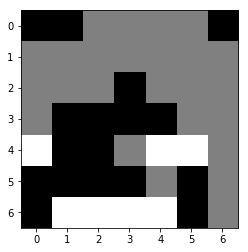

((4, 4), (4, 3)): n_v:  1252 q_all:-0.186823 q:-0.040367 q_m:+0.100000 p:0.662028
((6, 3), (4, 3)): n_v:   774 q_all:-0.066104 q:-0.130597 q_m:+0.066667 p:0.060941
((6, 4), (4, 3)): n_v:   363 q_all:-0.103518 q:-0.052191 q_m:+0.066667 p:0.079132
((6, 1), (4, 3)): n_v:   230 q_all:-0.145646 q:-0.127976 q_m:+0.066667 p:0.086453
((4, 5), (4, 3)): n_v:   133 q_all:-0.147585 q:-0.071153 q_m:+0.066667 p:0.050665
((6, 2), (4, 3)): n_v:   120 q_all:-0.119409 q:-0.153596 q_m:+0.066667 p:0.033415
((4, 4), (5, 4)): n_v:     9 q_all:-0.095194 q:-0.175772 q_m:-0.100000 p:0.001695
((6, 2), (5, 4)): n_v:     2 q_all:-0.221089 q:-0.287976 q_m:-0.133333 p:0.001611
((4, 4), (2, 2)): n_v:     1 q_all:-0.079875 q:-0.061554 q_m:-0.066667 p:0.000133
((4, 4), (6, 6)): n_v:     0 q_all:-0.226221 q:-0.226221 q_m:-0.200000 p:0.000065
((4, 4), (5, 6)): n_v:     0 q_all:-0.219027 q:-0.219027 q_m:-0.200000 p:0.000158
((4, 4), (3, 5)): n_v:     0 q_all:-0.240794 q:-0.240794 q_m:-0.233333 p:0.000001
((6, 4), (6, 6))

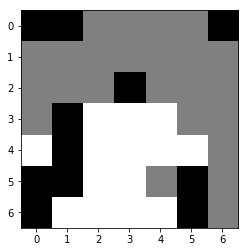

((5, 5), (5, 4)): n_v:  2865 q_all:+0.199868 q:+0.191933 q_m:+0.333333 p:0.386784
((2, 3), (1, 4)): n_v:    35 q_all:-0.107563 q:-0.076834 q_m:-0.066667 p:0.043959
((2, 3), (2, 2)): n_v:    32 q_all:-0.074363 q:-0.058125 q_m:+0.066667 p:0.036840
((2, 3), (3, 5)): n_v:    17 q_all:-0.068260 q:-0.000062 q_m:+0.100000 p:0.019037
((3, 1), (3, 0)): n_v:    12 q_all:-0.078793 q:-0.069190 q_m:-0.000000 p:0.014701
((2, 3), (2, 4)): n_v:     6 q_all:-0.074853 q:-0.040193 q_m:+0.066667 p:0.006877
((0, 1), (1, 2)): n_v:     2 q_all:-0.123705 q:-0.120564 q_m:-0.066667 p:0.003569
((2, 3), (0, 5)): n_v:     1 q_all:-0.134468 q:-0.079404 q_m:-0.100000 p:0.002479
((0, 6), (1, 4)): n_v:     1 q_all:-0.103550 q:-0.082137 q_m:-0.100000 p:0.001280
((2, 3), (1, 5)): n_v:     1 q_all:-0.128958 q:-0.073469 q_m:-0.100000 p:0.002029
((5, 5), (6, 6)): n_v:     0 q_all:-0.103178 q:-0.103178 q_m:-0.066667 p:0.000866
((3, 1), (1, 2)): n_v:     0 q_all:-0.100482 q:-0.100482 q_m:-0.100000 p:0.000808
((5, 0), (3, 0))

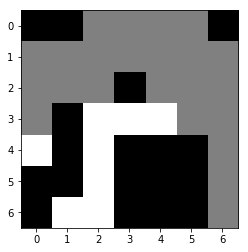

((3, 4), (5, 6)): n_v:  2423 q_all:-0.170526 q:-0.158092 q_m:-0.133333 p:0.349687
((3, 4), (1, 6)): n_v:   686 q_all:-0.231203 q:-0.298101 q_m:-0.266667 p:0.221725
((3, 4), (1, 5)): n_v:   170 q_all:-0.255548 q:-0.282788 q_m:-0.266667 p:0.067373
((3, 2), (1, 0)): n_v:   162 q_all:-0.241364 q:-0.261233 q_m:-0.200000 p:0.057380
((3, 4), (3, 5)): n_v:   120 q_all:-0.232554 q:-0.238588 q_m:-0.166667 p:0.039521
((3, 2), (1, 1)): n_v:   117 q_all:-0.195431 q:-0.220668 q_m:-0.200000 p:0.025581
((4, 0), (3, 0)): n_v:    84 q_all:-0.270068 q:-0.320404 q_m:-0.166667 p:0.037028
((3, 3), (1, 5)): n_v:    56 q_all:-0.313966 q:-0.270394 q_m:-0.266667 p:0.031913
((3, 3), (1, 1)): n_v:    43 q_all:-0.252426 q:-0.217032 q_m:-0.200000 p:0.016757
((3, 3), (2, 4)): n_v:    40 q_all:-0.307013 q:-0.291494 q_m:-0.233333 p:0.022175
((3, 2), (2, 2)): n_v:    24 q_all:-0.261704 q:-0.275914 q_m:-0.166667 p:0.010164
((3, 3), (1, 4)): n_v:    22 q_all:-0.355924 q:-0.279781 q_m:-0.266667 p:0.015286
((3, 4), (1, 2))

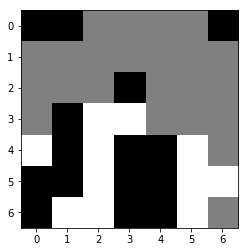

((4, 4), (6, 6)): n_v:  3170 q_all:+0.181691 q:+0.181019 q_m:+0.333333 p:0.451321
((2, 3), (3, 4)): n_v:   215 q_all:+0.108107 q:+0.090520 q_m:+0.300000 p:0.079685
((3, 1), (3, 0)): n_v:    89 q_all:+0.118631 q:+0.080114 q_m:+0.233333 p:0.030171
((2, 3), (2, 2)): n_v:    88 q_all:+0.062126 q:+0.098510 q_m:+0.300000 p:0.045081
((6, 4), (6, 6)): n_v:    79 q_all:+0.089389 q:+0.114276 q_m:+0.333333 p:0.033840
((6, 4), (4, 6)): n_v:    59 q_all:+0.101938 q:+0.121931 q_m:+0.333333 p:0.023322
((2, 3), (2, 4)): n_v:    34 q_all:+0.020974 q:+0.052841 q_m:+0.233333 p:0.021899
((0, 1), (0, 2)): n_v:    26 q_all:+0.017114 q:+0.026242 q_m:+0.166667 p:0.017004
((2, 3), (1, 1)): n_v:    21 q_all:+0.024067 q:+0.036660 q_m:+0.133333 p:0.013153
((4, 4), (3, 5)): n_v:    16 q_all:+0.048720 q:+0.090139 q_m:+0.233333 p:0.009348
((2, 3), (2, 1)): n_v:    16 q_all:+0.072936 q:+0.044494 q_m:+0.200000 p:0.007835
((3, 1), (2, 0)): n_v:    12 q_all:+0.026435 q:+0.029972 q_m:+0.166667 p:0.007721
((2, 3), (1, 5))

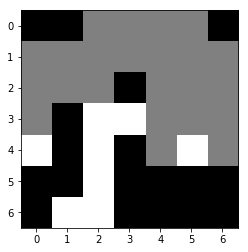

((3, 3), (4, 4)): n_v:  2675 q_all:-0.188644 q:-0.166638 q_m:-0.033333 p:0.237972
((3, 3), (2, 4)): n_v:   345 q_all:-0.301433 q:-0.268643 q_m:-0.233333 p:0.141642
((3, 2), (2, 2)): n_v:   280 q_all:-0.228373 q:-0.253058 q_m:-0.166667 p:0.056720
((3, 2), (4, 4)): n_v:   143 q_all:-0.197392 q:-0.238986 q_m:-0.066667 p:0.016182
((3, 3), (1, 1)): n_v:   122 q_all:-0.197869 q:-0.215726 q_m:-0.200000 p:0.014152
((4, 5), (4, 6)): n_v:    95 q_all:-0.193083 q:-0.250421 q_m:-0.166667 p:0.009485
((3, 3), (1, 5)): n_v:    82 q_all:-0.211208 q:-0.254566 q_m:-0.266667 p:0.012579
((3, 2), (1, 1)): n_v:    53 q_all:-0.218368 q:-0.216999 q_m:-0.200000 p:0.009278
((4, 2), (4, 4)): n_v:    52 q_all:-0.295728 q:-0.285677 q_m:-0.066667 p:0.020586
((6, 2), (4, 4)): n_v:    49 q_all:-0.274197 q:-0.315845 q_m:-0.066667 p:0.016346
((4, 0), (3, 0)): n_v:    39 q_all:-0.210489 q:-0.299966 q_m:-0.166667 p:0.005684
((4, 0), (2, 2)): n_v:    30 q_all:-0.257099 q:-0.287497 q_m:-0.200000 p:0.008543
((3, 2), (2, 4))

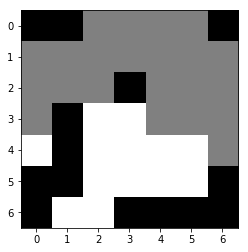

((2, 3), (3, 4)): n_v:  3571 q_all:+0.182202 q:+0.151426 q_m:+0.333333 p:0.730773
((2, 3), (2, 2)): n_v:   111 q_all:+0.097215 q:+0.077488 q_m:+0.200000 p:0.051115
((3, 1), (3, 0)): n_v:    75 q_all:+0.111642 q:+0.055862 q_m:+0.133333 p:0.031439
((5, 6), (3, 4)): n_v:    58 q_all:+0.107483 q:+0.111776 q_m:+0.300000 p:0.024548
((5, 6), (4, 6)): n_v:    52 q_all:+0.204552 q:+0.130081 q_m:+0.200000 p:0.007206
((2, 3), (3, 5)): n_v:    18 q_all:+0.106759 q:+0.108770 q_m:+0.166667 p:0.007910
((2, 3), (2, 4)): n_v:    16 q_all:+0.059004 q:+0.050865 q_m:+0.133333 p:0.009377
((0, 1), (0, 2)): n_v:    10 q_all:+0.030743 q:+0.005376 q_m:+0.066667 p:0.006919
((2, 3), (2, 1)): n_v:     8 q_all:+0.053719 q:+0.011779 q_m:+0.100000 p:0.004795
((2, 3), (1, 1)): n_v:     7 q_all:+0.032878 q:+0.014209 q_m:+0.033333 p:0.004835
((3, 1), (2, 0)): n_v:     7 q_all:+0.047862 q:+0.003146 q_m:+0.066667 p:0.004370
((2, 3), (0, 2)): n_v:     7 q_all:+0.023249 q:-0.002830 q_m:+0.033333 p:0.005417
((4, 1), (2, 2))

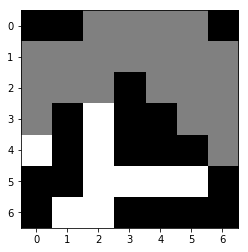

((3, 2), (2, 2)): n_v:  3052 q_all:-0.210830 q:-0.253173 q_m:-0.100000 p:0.689681
((4, 0), (3, 0)): n_v:   520 q_all:-0.221331 q:-0.356677 q_m:-0.166667 p:0.132491
((4, 0), (2, 2)): n_v:   358 q_all:-0.200631 q:-0.268850 q_m:-0.133333 p:0.070875
((5, 5), (4, 6)): n_v:    98 q_all:-0.232297 q:-0.290686 q_m:-0.166667 p:0.027935
((3, 2), (2, 4)): n_v:    70 q_all:-0.248353 q:-0.269116 q_m:-0.133333 p:0.023142
((5, 5), (3, 5)): n_v:    59 q_all:-0.182694 q:-0.258099 q_m:-0.133333 p:0.008709
((3, 2), (1, 1)): n_v:    17 q_all:-0.278480 q:-0.247481 q_m:-0.200000 p:0.007324
((5, 4), (3, 5)): n_v:    16 q_all:-0.310042 q:-0.258844 q_m:-0.133333 p:0.007643
((3, 2), (1, 0)): n_v:    14 q_all:-0.257786 q:-0.279068 q_m:-0.200000 p:0.005263
((5, 3), (3, 5)): n_v:    10 q_all:-0.400284 q:-0.351443 q_m:-0.133333 p:0.008005
((4, 2), (2, 4)): n_v:     7 q_all:-0.326862 q:-0.329917 q_m:-0.133333 p:0.003693
((3, 2), (2, 0)): n_v:     7 q_all:-0.317293 q:-0.373709 q_m:-0.266667 p:0.003822
((3, 2), (3, 0))

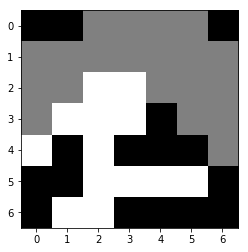

((3, 4), (2, 4)): n_v:  1762 q_all:+0.184746 q:+0.180458 q_m:+0.266667 p:0.365953
((0, 0), (2, 1)): n_v:   782 q_all:+0.178225 q:+0.173196 q_m:+0.300000 p:0.177655
((0, 1), (2, 1)): n_v:   381 q_all:+0.181912 q:+0.156053 q_m:+0.300000 p:0.082294
((4, 1), (3, 0)): n_v:   223 q_all:+0.229839 q:+0.175396 q_m:+0.266667 p:0.016942
((3, 4), (2, 5)): n_v:   191 q_all:+0.107333 q:+0.100001 q_m:+0.133333 p:0.083310
((0, 6), (2, 5)): n_v:   128 q_all:+0.085308 q:+0.086353 q_m:+0.100000 p:0.064362
((0, 6), (2, 4)): n_v:   125 q_all:+0.165684 q:+0.159886 q_m:+0.233333 p:0.032944
((4, 3), (2, 1)): n_v:    66 q_all:+0.135434 q:+0.094827 q_m:+0.300000 p:0.023188
((0, 1), (1, 2)): n_v:    46 q_all:+0.171791 q:+0.112702 q_m:+0.266667 p:0.011415
((4, 3), (2, 5)): n_v:    35 q_all:+0.107351 q:+0.074601 q_m:+0.100000 p:0.015490
((4, 5), (3, 6)): n_v:    32 q_all:+0.106236 q:+0.096189 q_m:+0.133333 p:0.014255
((0, 1), (1, 3)): n_v:    25 q_all:+0.141932 q:+0.134472 q_m:+0.233333 p:0.008296
((4, 5), (4, 6))

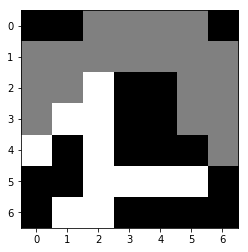

((2, 2), (1, 1)): n_v:   991 q_all:-0.201259 q:-0.251919 q_m:-0.100000 p:0.277627
((5, 5), (3, 5)): n_v:   677 q_all:-0.162607 q:-0.182479 q_m:-0.000000 p:0.101331
((2, 2), (1, 3)): n_v:   410 q_all:-0.222052 q:-0.264098 q_m:-0.100000 p:0.143547
((5, 4), (3, 5)): n_v:   239 q_all:-0.165210 q:-0.208453 q_m:-0.000000 p:0.037864
((5, 5), (4, 6)): n_v:   215 q_all:-0.253934 q:-0.254794 q_m:-0.100000 p:0.098339
((3, 2), (1, 1)): n_v:   159 q_all:-0.203423 q:-0.219337 q_m:-0.133333 p:0.045542
((3, 1), (3, 0)): n_v:    91 q_all:-0.297890 q:-0.361054 q_m:-0.166667 p:0.055026
((5, 3), (3, 5)): n_v:    70 q_all:-0.352371 q:-0.305796 q_m:-0.000000 p:0.055001
((2, 2), (1, 2)): n_v:    42 q_all:-0.289501 q:-0.319222 q_m:-0.100000 p:0.024790
((5, 4), (4, 6)): n_v:    35 q_all:-0.211052 q:-0.314749 q_m:-0.133333 p:0.011049
((2, 2), (1, 4)): n_v:    33 q_all:-0.262211 q:-0.266141 q_m:-0.133333 p:0.016265
((3, 1), (1, 1)): n_v:    28 q_all:-0.280182 q:-0.283988 q_m:-0.133333 p:0.015607
((3, 2), (1, 0))

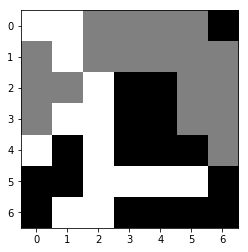

((2, 3), (1, 2)): n_v:   954 q_all:+0.189329 q:+0.130031 q_m:+0.333333 p:0.121764
((2, 3), (2, 1)): n_v:   309 q_all:+0.160789 q:+0.113313 q_m:+0.366667 p:0.073986
((2, 4), (1, 2)): n_v:   178 q_all:+0.182476 q:+0.126719 q_m:+0.300000 p:0.027518
((2, 4), (2, 5)): n_v:   143 q_all:+0.005525 q:+0.073935 q_m:+0.133333 p:0.122154
((2, 3), (1, 4)): n_v:    94 q_all:+0.036740 q:+0.063714 q_m:+0.133333 p:0.068177
((3, 3), (2, 1)): n_v:    86 q_all:+0.030631 q:+0.085910 q_m:+0.366667 p:0.064562
((4, 3), (2, 1)): n_v:    85 q_all:+0.099131 q:+0.103679 q_m:+0.366667 p:0.041294
((3, 3), (2, 5)): n_v:    67 q_all:-0.008748 q:+0.061419 q_m:+0.100000 p:0.060903
((2, 3), (0, 2)): n_v:    61 q_all:+0.140993 q:+0.110963 q_m:+0.233333 p:0.019288
((2, 3), (2, 5)): n_v:    40 q_all:+0.023374 q:+0.031180 q_m:+0.100000 p:0.031506
((3, 4), (1, 2)): n_v:    39 q_all:+0.132493 q:+0.098555 q_m:+0.300000 p:0.013964
((4, 1), (3, 0)): n_v:    38 q_all:+0.167448 q:+0.153210 q_m:+0.266667 p:0.008221
((4, 1), (2, 1))

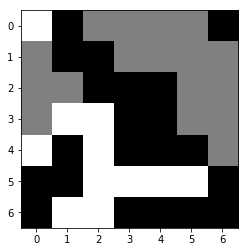

((3, 1), (2, 1)): n_v:   744 q_all:-0.275262 q:-0.360939 q_m:-0.100000 p:0.250541
((0, 0), (2, 1)): n_v:   423 q_all:-0.246482 q:-0.334958 q_m:-0.133333 p:0.095131
((4, 0), (2, 1)): n_v:   422 q_all:-0.225555 q:-0.347947 q_m:-0.133333 p:0.061547
((3, 2), (1, 0)): n_v:   295 q_all:-0.263055 q:-0.315455 q_m:-0.200000 p:0.085460
((3, 1), (1, 3)): n_v:   172 q_all:-0.286083 q:-0.292504 q_m:-0.066667 p:0.064945
((0, 0), (0, 2)): n_v:   157 q_all:-0.260922 q:-0.338685 q_m:-0.133333 p:0.044011
((5, 4), (3, 5)): n_v:   116 q_all:-0.247343 q:-0.235194 q_m:-0.066667 p:0.026724
((3, 2), (1, 3)): n_v:   109 q_all:-0.270813 q:-0.264426 q_m:-0.066667 p:0.035051
((5, 5), (3, 5)): n_v:    58 q_all:-0.255603 q:-0.205451 q_m:-0.066667 p:0.015250
((5, 3), (3, 5)): n_v:    37 q_all:-0.443535 q:-0.343500 q_m:-0.066667 p:0.035866
((5, 5), (3, 6)): n_v:    28 q_all:-0.237835 q:-0.295440 q_m:-0.266667 p:0.005339
((5, 5), (4, 6)): n_v:    22 q_all:-0.302989 q:-0.286796 q_m:-0.166667 p:0.009909
((3, 1), (1, 0))

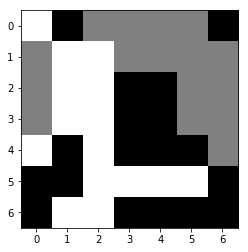

((4, 1), (3, 0)): n_v:  1093 q_all:+0.288822 q:+0.206838 q_m:+0.333333 p:0.062860
((0, 1), (1, 0)): n_v:   601 q_all:+0.242306 q:+0.152990 q_m:+0.333333 p:0.146574
((2, 3), (1, 3)): n_v:   236 q_all:+0.145369 q:+0.137072 q_m:+0.266667 p:0.148675
((0, 1), (0, 2)): n_v:   210 q_all:+0.076666 q:+0.101878 q_m:+0.266667 p:0.190261
((2, 4), (0, 2)): n_v:   131 q_all:+0.099836 q:+0.089813 q_m:+0.233333 p:0.106152
((0, 6), (1, 6)): n_v:    34 q_all:+0.102136 q:+0.064802 q_m:+0.133333 p:0.027653
((4, 5), (3, 6)): n_v:    30 q_all:+0.029845 q:+0.059611 q_m:+0.133333 p:0.033054
((2, 3), (0, 2)): n_v:    29 q_all:+0.132138 q:+0.081694 q_m:+0.233333 p:0.020233
((2, 3), (0, 4)): n_v:    11 q_all:+0.086519 q:+0.065322 q_m:+0.100000 p:0.009969
((4, 5), (4, 6)): n_v:     9 q_all:+0.174943 q:+0.199283 q_m:+0.200000 p:0.003972
((0, 1), (1, 3)): n_v:     9 q_all:+0.112119 q:+0.130929 q_m:+0.233333 p:0.007248
((0, 6), (0, 4)): n_v:     5 q_all:+0.047301 q:+0.061090 q_m:+0.100000 p:0.005618
((5, 0), (3, 0))

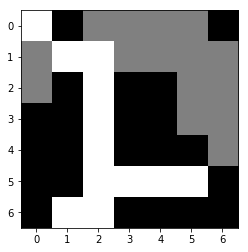

((1, 1), (2, 0)): n_v:   700 q_all:-0.398696 q:-0.417986 q_m:-0.100000 p:0.335590
((1, 2), (2, 0)): n_v:   622 q_all:-0.404923 q:-0.383097 q_m:-0.133333 p:0.313020
((5, 5), (4, 6)): n_v:   551 q_all:-0.315761 q:-0.441616 q_m:-0.166667 p:0.093616
((0, 0), (2, 0)): n_v:   541 q_all:-0.312884 q:-0.386507 q_m:-0.133333 p:0.086034
((5, 4), (4, 6)): n_v:   200 q_all:-0.351949 q:-0.473541 q_m:-0.200000 p:0.060952
((5, 5), (3, 5)): n_v:    53 q_all:-0.313542 q:-0.311403 q_m:-0.066667 p:0.008511
((4, 2), (2, 0)): n_v:    53 q_all:-0.425906 q:-0.515067 q_m:-0.133333 p:0.030569
((3, 2), (2, 0)): n_v:    48 q_all:-0.432638 q:-0.454003 q_m:-0.133333 p:0.029399
((2, 2), (2, 0)): n_v:    26 q_all:-0.422121 q:-0.427709 q_m:-0.133333 p:0.014911
((1, 2), (1, 3)): n_v:    12 q_all:-0.383245 q:-0.419847 q_m:-0.166667 p:0.005456
((5, 4), (3, 5)): n_v:     8 q_all:-0.339102 q:-0.332432 q_m:-0.066667 p:0.002138
((0, 0), (1, 0)): n_v:     4 q_all:-0.390655 q:-0.460259 q_m:-0.166667 p:0.002170
((3, 2), (1, 0))

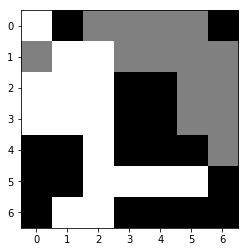

((0, 1), (1, 0)): n_v:  2155 q_all:+0.406124 q:+0.327315 q_m:+0.400000 p:0.594553
((2, 3), (1, 3)): n_v:    64 q_all:+0.192848 q:+0.127910 q_m:+0.266667 p:0.073492
((0, 6), (1, 6)): n_v:    59 q_all:+0.101045 q:+0.025441 q_m:+0.133333 p:0.089404
((0, 1), (0, 2)): n_v:    39 q_all:+0.101224 q:+0.065091 q_m:+0.266667 p:0.058766
((2, 4), (0, 2)): n_v:    36 q_all:+0.109227 q:+0.047352 q_m:+0.233333 p:0.054405
((2, 3), (0, 2)): n_v:    13 q_all:+0.139416 q:+0.021602 q_m:+0.233333 p:0.018103
((3, 4), (1, 6)): n_v:     5 q_all:-0.098564 q:-0.002279 q_m:+0.100000 p:0.013289
((2, 4), (1, 6)): n_v:     4 q_all:+0.069382 q:+0.027491 q_m:+0.100000 p:0.006564
((0, 6), (0, 4)): n_v:     3 q_all:+0.096491 q:+0.021155 q_m:+0.100000 p:0.004818
((0, 1), (1, 3)): n_v:     2 q_all:+0.145585 q:+0.142267 q_m:+0.233333 p:0.002887
((4, 5), (4, 6)): n_v:     1 q_all:+0.142383 q:+0.156480 q_m:+0.200000 p:0.001371
((2, 3), (0, 4)): n_v:     1 q_all:+0.043949 q:+0.016187 q_m:+0.100000 p:0.002967
((3, 3), (1, 5))

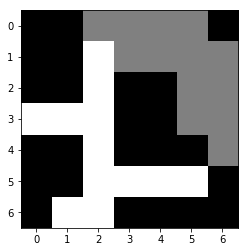

((5, 5), (3, 5)): n_v:  1229 q_all:-0.403945 q:-0.342573 q_m:-0.133333 p:0.097514
((5, 4), (3, 5)): n_v:   610 q_all:-0.424761 q:-0.368011 q_m:-0.133333 p:0.088724
((1, 2), (0, 2)): n_v:   581 q_all:-0.495966 q:-0.587746 q_m:-0.233333 p:0.217205
((1, 2), (1, 3)): n_v:   576 q_all:-0.483480 q:-0.577237 q_m:-0.233333 p:0.192250
((5, 5), (4, 6)): n_v:   248 q_all:-0.461788 q:-0.577470 q_m:-0.233333 p:0.065751
((5, 3), (3, 5)): n_v:   146 q_all:-0.501487 q:-0.487676 q_m:-0.133333 p:0.057179
((5, 4), (4, 6)): n_v:   126 q_all:-0.426110 q:-0.608672 q_m:-0.266667 p:0.018918
((5, 4), (3, 6)): n_v:    77 q_all:-0.393283 q:-0.464205 q_m:-0.333333 p:0.003416
((1, 2), (0, 4)): n_v:    55 q_all:-0.501665 q:-0.599661 q_m:-0.400000 p:0.021821
((1, 2), (1, 4)): n_v:    41 q_all:-0.473105 q:-0.430506 q_m:-0.266667 p:0.012531
((5, 5), (3, 6)): n_v:    30 q_all:-0.404376 q:-0.466360 q_m:-0.333333 p:0.002459
((2, 2), (1, 4)): n_v:     9 q_all:-0.525464 q:-0.445939 q_m:-0.266667 p:0.004580
((3, 2), (1, 3))

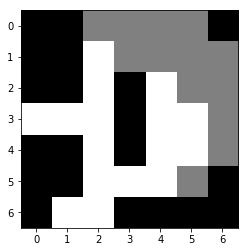

((5, 6), (5, 5)): n_v:  2701 q_all:+0.441287 q:+0.364778 q_m:+0.366667 p:0.265092
((6, 3), (5, 5)): n_v:   108 q_all:+0.416120 q:+0.255372 q_m:+0.333333 p:0.020438
((0, 6), (1, 5)): n_v:    29 q_all:+0.118137 q:+0.152898 q_m:+0.233333 p:0.037188
((4, 3), (5, 5)): n_v:    23 q_all:+0.296013 q:+0.183363 q_m:+0.333333 p:0.014826
((3, 3), (5, 5)): n_v:    16 q_all:+0.297904 q:+0.217155 q_m:+0.333333 p:0.010490
((2, 3), (1, 5)): n_v:    10 q_all:+0.107251 q:+0.133066 q_m:+0.200000 p:0.014290
((2, 3), (1, 3)): n_v:     5 q_all:+0.308078 q:+0.337315 q_m:+0.366667 p:0.002674
((3, 3), (1, 5)): n_v:     5 q_all:+0.108869 q:+0.096146 q_m:+0.200000 p:0.007867
((2, 3), (0, 4)): n_v:     0 q_all:+0.133124 q:+0.133124 q_m:+0.133333 p:0.000014
((0, 0), (0, 2)): n_v:     0 q_all:+0.140235 q:+0.140235 q_m:+0.200000 p:0.000024
((0, 1), (0, 3)): n_v:     0 q_all:+0.143935 q:+0.143935 q_m:+0.200000 p:0.000000
((2, 3), (2, 5)): n_v:     0 q_all:+0.191383 q:+0.191383 q_m:+0.333333 p:0.000173
((2, 0), (0, 2))

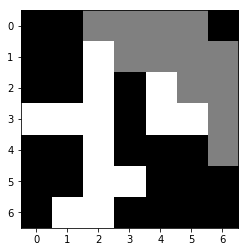

((3, 4), (4, 6)): n_v:  1525 q_all:-0.440130 q:-0.452296 q_m:-0.166667 p:0.242654
((3, 5), (4, 6)): n_v:   695 q_all:-0.495313 q:-0.489847 q_m:-0.133333 p:0.225628
((3, 4), (2, 6)): n_v:   350 q_all:-0.493251 q:-0.553281 q_m:-0.366667 p:0.111374
((3, 4), (1, 6)): n_v:   256 q_all:-0.414551 q:-0.428590 q_m:-0.300000 p:0.021534
((3, 5), (2, 6)): n_v:   226 q_all:-0.556344 q:-0.554784 q_m:-0.333333 p:0.115000
((3, 4), (1, 5)): n_v:   195 q_all:-0.398514 q:-0.431160 q_m:-0.300000 p:0.006663
((2, 4), (4, 6)): n_v:   144 q_all:-0.488906 q:-0.495547 q_m:-0.166667 p:0.044034
((1, 2), (0, 2)): n_v:   121 q_all:-0.555184 q:-0.504903 q_m:-0.200000 p:0.060737
((3, 4), (1, 3)): n_v:    59 q_all:-0.407178 q:-0.569816 q_m:-0.300000 p:0.003597
((2, 4), (1, 5)): n_v:    37 q_all:-0.487531 q:-0.419962 q_m:-0.266667 p:0.011217
((2, 4), (0, 5)): n_v:    35 q_all:-0.410421 q:-0.413833 q_m:-0.300000 p:0.002254
((2, 4), (1, 6)): n_v:    35 q_all:-0.440844 q:-0.413789 q_m:-0.300000 p:0.005687
((1, 2), (1, 3))

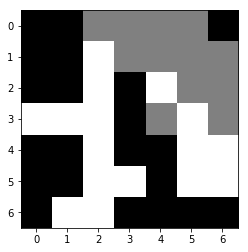

((2, 3), (3, 4)): n_v:  2889 q_all:+0.472681 q:+0.404114 q_m:+0.400000 p:0.191133
((2, 3), (1, 3)): n_v:   169 q_all:+0.422890 q:+0.445779 q_m:+0.400000 p:0.026146
((0, 1), (1, 3)): n_v:    19 q_all:+0.345486 q:+0.357480 q_m:+0.366667 p:0.009535
((3, 3), (1, 3)): n_v:    17 q_all:+0.355436 q:+0.329495 q_m:+0.366667 p:0.008504
((2, 3), (0, 2)): n_v:    10 q_all:+0.363069 q:+0.294619 q_m:+0.233333 p:0.004671
((0, 1), (0, 2)): n_v:    10 q_all:+0.297279 q:+0.316360 q_m:+0.266667 p:0.007081
((3, 3), (2, 5)): n_v:     6 q_all:+0.196006 q:+0.208355 q_m:+0.300000 p:0.006041
((4, 4), (3, 6)): n_v:     4 q_all:+0.355438 q:+0.335115 q_m:+0.366667 p:0.002317
((3, 3), (1, 5)): n_v:     3 q_all:+0.254699 q:+0.196871 q_m:+0.233333 p:0.002993
((0, 0), (0, 2)): n_v:     2 q_all:+0.188948 q:+0.198654 q_m:+0.233333 p:0.002852
((3, 3), (1, 4)): n_v:     2 q_all:+0.310666 q:+0.171582 q_m:+0.233333 p:0.001565
((2, 3), (0, 4)): n_v:     1 q_all:+0.235492 q:+0.235492 q_m:+0.166667 p:0.001725
((2, 3), (1, 4))

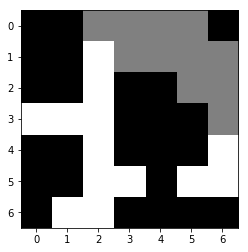

((4, 6), (2, 5)): n_v:  1593 q_all:-0.457851 q:-0.381116 q_m:-0.200000 p:0.115178
((4, 6), (3, 6)): n_v:  1120 q_all:-0.509882 q:-0.584722 q_m:-0.233333 p:0.251668
((1, 2), (1, 3)): n_v:   767 q_all:-0.529052 q:-0.604948 q_m:-0.233333 p:0.215711
((1, 2), (1, 4)): n_v:   142 q_all:-0.484231 q:-0.464129 q_m:-0.266667 p:0.021376
((1, 2), (0, 2)): n_v:    92 q_all:-0.575064 q:-0.559500 q_m:-0.233333 p:0.038253
((1, 2), (0, 4)): n_v:    92 q_all:-0.511694 q:-0.554862 q_m:-0.400000 p:0.021114
((2, 2), (1, 4)): n_v:    51 q_all:-0.552168 q:-0.465061 q_m:-0.266667 p:0.017954
((3, 2), (1, 3)): n_v:    31 q_all:-0.588354 q:-0.570398 q_m:-0.266667 p:0.014420
((5, 6), (3, 6)): n_v:    24 q_all:-0.540342 q:-0.550292 q_m:-0.266667 p:0.007418
((5, 5), (3, 6)): n_v:    22 q_all:-0.553545 q:-0.567056 q_m:-0.266667 p:0.007931
((2, 2), (0, 4)): n_v:    10 q_all:-0.554617 q:-0.557999 q_m:-0.400000 p:0.003668
((1, 2), (0, 3)): n_v:     9 q_all:-0.646877 q:-0.685938 q_m:-0.366667 p:0.006034
((3, 2), (1, 4))

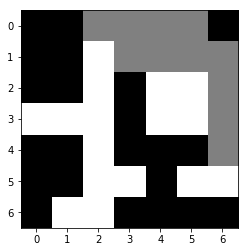

((4, 5), (4, 6)): n_v:  1498 q_all:+0.495024 q:+0.520708 q_m:+0.433333 p:0.470013
((2, 3), (1, 3)): n_v:  1221 q_all:+0.537403 q:+0.576112 q_m:+0.433333 p:0.204234
((6, 6), (4, 6)): n_v:   140 q_all:+0.397754 q:+0.405207 q_m:+0.400000 p:0.091020
((6, 5), (4, 6)): n_v:    66 q_all:+0.406670 q:+0.407376 q_m:+0.400000 p:0.041070
((0, 6), (2, 6)): n_v:    66 q_all:+0.356289 q:+0.369973 q_m:+0.333333 p:0.052352
((0, 1), (0, 2)): n_v:    54 q_all:+0.455569 q:+0.547030 q_m:+0.300000 p:0.024327
((0, 1), (1, 3)): n_v:    37 q_all:+0.445465 q:+0.448717 q_m:+0.400000 p:0.018370
((0, 6), (1, 5)): n_v:    32 q_all:+0.356665 q:+0.352202 q_m:+0.366667 p:0.025728
((6, 4), (4, 6)): n_v:    19 q_all:+0.362346 q:+0.390646 q_m:+0.400000 p:0.015404
((2, 3), (1, 4)): n_v:    18 q_all:+0.465622 q:+0.339903 q_m:+0.366667 p:0.007384
((4, 5), (3, 6)): n_v:    12 q_all:+0.461831 q:+0.360670 q_m:+0.366667 p:0.005036
((5, 4), (4, 6)): n_v:     7 q_all:+0.246449 q:+0.202976 q_m:+0.400000 p:0.008361
((0, 6), (1, 4))

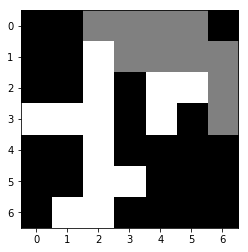

((2, 5), (3, 6)): n_v:  2708 q_all:-0.504186 q:-0.473387 q_m:-0.200000 p:0.900422
((2, 4), (3, 6)): n_v:   214 q_all:-0.515205 q:-0.475422 q_m:-0.233333 p:0.079333
((3, 4), (3, 6)): n_v:    48 q_all:-0.484257 q:-0.499808 q_m:-0.233333 p:0.012363
((1, 2), (0, 2)): n_v:     3 q_all:-0.621920 q:-0.519592 q_m:-0.266667 p:0.002212
((3, 4), (1, 6)): n_v:     2 q_all:-0.564176 q:-0.528219 q_m:-0.366667 p:0.001322
((2, 4), (1, 5)): n_v:     1 q_all:-0.524524 q:-0.476101 q_m:-0.333333 p:0.000279
((1, 2), (0, 4)): n_v:     1 q_all:-0.561129 q:-0.580016 q_m:-0.433333 p:0.000420
((1, 2), (0, 3)): n_v:     0 q_all:-0.522828 q:-0.645655 q_m:-0.400000 p:0.000083
((2, 5), (0, 3)): n_v:     0 q_all:-0.551130 q:-0.668927 q_m:-0.433333 p:0.000003
((2, 5), (2, 6)): n_v:     0 q_all:-0.571702 q:-0.571702 q_m:-0.333333 p:0.000088
((2, 4), (0, 5)): n_v:     0 q_all:-0.460102 q:-0.460102 q_m:-0.366667 p:0.000044
((2, 2), (0, 2)): n_v:     0 q_all:-0.500444 q:-0.500444 q_m:-0.300000 p:0.000027
((2, 5), (1, 6))

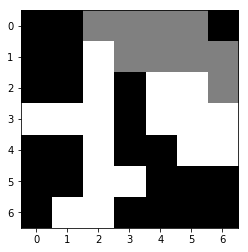

((2, 3), (1, 3)): n_v:  2336 q_all:+0.578045 q:+0.661163 q_m:+0.433333 p:0.288965
((0, 6), (2, 6)): n_v:   712 q_all:+0.508093 q:+0.551841 q_m:+0.400000 p:0.237178
((0, 6), (1, 5)): n_v:   628 q_all:+0.464766 q:+0.512753 q_m:+0.366667 p:0.290649
((0, 1), (0, 2)): n_v:   148 q_all:+0.526235 q:+0.566883 q_m:+0.300000 p:0.041486
((2, 3), (1, 4)): n_v:    68 q_all:+0.500880 q:+0.467427 q_m:+0.366667 p:0.024317
((0, 6), (1, 6)): n_v:    45 q_all:+0.443636 q:+0.406988 q_m:+0.300000 p:0.024112
((0, 1), (1, 3)): n_v:    30 q_all:+0.478701 q:+0.584954 q_m:+0.400000 p:0.012766
((0, 6), (1, 4)): n_v:    27 q_all:+0.457164 q:+0.440145 q_m:+0.333333 p:0.013526
((2, 3), (1, 5)): n_v:    16 q_all:+0.457944 q:+0.471247 q_m:+0.333333 p:0.008152
((0, 0), (0, 2)): n_v:    11 q_all:+0.415185 q:+0.458325 q_m:+0.266667 p:0.007310
((0, 6), (0, 4)): n_v:     8 q_all:+0.422071 q:+0.403046 q_m:+0.200000 p:0.005100
((0, 6), (0, 5)): n_v:     7 q_all:+0.424209 q:+0.411885 q_m:+0.233333 p:0.004646
((2, 3), (0, 2))

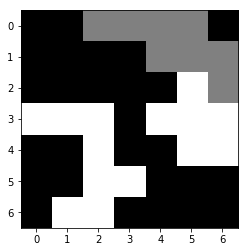

((2, 5), (1, 4)): n_v:  2555 q_all:-0.574433 q:-0.545891 q_m:-0.200000 p:0.577410
((3, 6), (1, 4)): n_v:   502 q_all:-0.594484 q:-0.600827 q_m:-0.233333 p:0.144843
((2, 5), (1, 5)): n_v:   182 q_all:-0.625098 q:-0.532514 q_m:-0.266667 p:0.069930
((3, 2), (1, 4)): n_v:   129 q_all:-0.566941 q:-0.572488 q_m:-0.233333 p:0.026339
((3, 5), (1, 4)): n_v:    93 q_all:-0.618890 q:-0.570752 q_m:-0.233333 p:0.034114
((3, 6), (1, 5)): n_v:    81 q_all:-0.624378 q:-0.533117 q_m:-0.300000 p:0.031164
((3, 6), (1, 6)): n_v:    66 q_all:-0.629045 q:-0.661151 q_m:-0.366667 p:0.026336
((3, 4), (1, 4)): n_v:    65 q_all:-0.601698 q:-0.575502 q_m:-0.233333 p:0.020286
((3, 5), (1, 5)): n_v:    63 q_all:-0.616692 q:-0.590591 q_m:-0.300000 p:0.022866
((3, 4), (1, 5)): n_v:    61 q_all:-0.576487 q:-0.549297 q_m:-0.300000 p:0.014398
((2, 5), (0, 4)): n_v:    22 q_all:-0.662187 q:-0.675569 q_m:-0.366667 p:0.011019
((2, 5), (1, 6)): n_v:    14 q_all:-0.655206 q:-0.642789 q_m:-0.333333 p:0.006917
((3, 4), (1, 6))

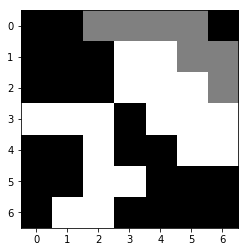

((0, 6), (1, 5)): n_v:  2350 q_all:+0.593059 q:+0.717366 q_m:+0.433333 p:0.863712
((0, 1), (0, 2)): n_v:  1014 q_all:+0.711692 q:+0.719668 q_m:+0.300000 p:0.005811
((1, 2), (0, 3)): n_v:   193 q_all:+0.648742 q:+0.707732 q_m:+0.366667 p:0.038330
((0, 6), (2, 6)): n_v:   144 q_all:+0.572221 q:+0.709456 q_m:+0.400000 p:0.061997
((0, 6), (1, 6)): n_v:    11 q_all:+0.520803 q:+0.604205 q_m:+0.300000 p:0.006492
((0, 6), (0, 4)): n_v:    11 q_all:+0.667926 q:+0.650439 q_m:+0.333333 p:0.001605
((0, 6), (0, 5)): n_v:     6 q_all:+0.531124 q:+0.598974 q_m:+0.300000 p:0.003694
((0, 0), (0, 2)): n_v:     3 q_all:+0.539878 q:+0.636193 q_m:+0.266667 p:0.001976
((0, 1), (0, 3)): n_v:     2 q_all:+0.584777 q:+0.563950 q_m:+0.333333 p:0.000739
((3, 3), (1, 5)): n_v:     1 q_all:+0.368797 q:+0.449868 q_m:+0.400000 p:0.001512
((2, 0), (0, 2)): n_v:     0 q_all:+0.515031 q:+0.515031 q_m:+0.266667 p:0.000289
((1, 0), (0, 2)): n_v:     0 q_all:+0.410804 q:+0.410804 q_m:+0.266667 p:0.000695
((2, 2), (0, 2))

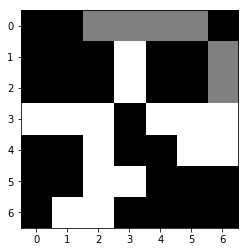

((3, 6), (1, 6)): n_v:  1661 q_all:-0.629395 q:-0.557854 q_m:-0.233333 p:0.489815
((3, 4), (1, 6)): n_v:  1089 q_all:-0.607132 q:-0.576602 q_m:-0.233333 p:0.246086
((1, 3), (0, 5)): n_v:   168 q_all:-0.611169 q:-0.566868 q_m:-0.233333 p:0.040091
((3, 5), (1, 6)): n_v:   159 q_all:-0.673685 q:-0.657676 q_m:-0.233333 p:0.069197
((3, 4), (2, 6)): n_v:   129 q_all:-0.627994 q:-0.673220 q_m:-0.300000 p:0.037712
((1, 3), (0, 2)): n_v:    78 q_all:-0.638919 q:-0.697335 q_m:-0.200000 p:0.025285
((2, 3), (0, 5)): n_v:    55 q_all:-0.678971 q:-0.625189 q_m:-0.233333 p:0.024267
((1, 3), (0, 4)): n_v:    45 q_all:-0.704679 q:-0.736374 q_m:-0.266667 p:0.024179
((3, 5), (2, 6)): n_v:    23 q_all:-0.704570 q:-0.710648 q_m:-0.266667 p:0.012296
((2, 3), (0, 4)): n_v:    18 q_all:-0.681359 q:-0.653766 q_m:-0.300000 p:0.008225
((2, 3), (0, 2)): n_v:    15 q_all:-0.691454 q:-0.630618 q_m:-0.233333 p:0.007020
((4, 5), (2, 6)): n_v:    10 q_all:-0.661678 q:-0.645555 q_m:-0.300000 p:0.004134
((4, 6), (2, 6))

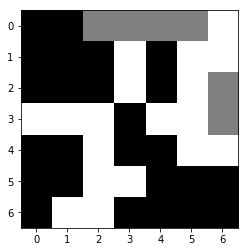

((1, 4), (0, 5)): n_v:  1357 q_all:+0.692170 q:+0.775871 q_m:+0.466667 p:0.536927
((1, 2), (0, 3)): n_v:   932 q_all:+0.805376 q:+0.700332 q_m:+0.333333 p:0.008352
((1, 4), (0, 4)): n_v:   143 q_all:+0.669222 q:+0.741246 q_m:+0.400000 p:0.068118
((5, 6), (3, 6)): n_v:   134 q_all:+0.532884 q:+0.671030 q_m:+0.500000 p:0.125260
((0, 1), (0, 2)): n_v:    91 q_all:+0.686402 q:+0.788410 q_m:+0.333333 p:0.037668
((2, 4), (3, 6)): n_v:    71 q_all:+0.625942 q:+0.677966 q_m:+0.500000 p:0.044597
((1, 4), (3, 6)): n_v:    35 q_all:+0.666039 q:+0.740382 q_m:+0.500000 p:0.016697
((4, 4), (2, 6)): n_v:    24 q_all:+0.522637 q:+0.500329 q_m:+0.500000 p:0.023858
((4, 4), (3, 6)): n_v:    24 q_all:+0.571951 q:+0.554250 q_m:+0.500000 p:0.020139
((5, 5), (3, 6)): n_v:    13 q_all:+0.402257 q:+0.609633 q_m:+0.500000 p:0.016756
((1, 4), (2, 6)): n_v:    13 q_all:+0.660500 q:+0.705038 q_m:+0.500000 p:0.006850
((2, 4), (0, 5)): n_v:     9 q_all:+0.579508 q:+0.652120 q_m:+0.433333 p:0.007619
((5, 4), (3, 6))

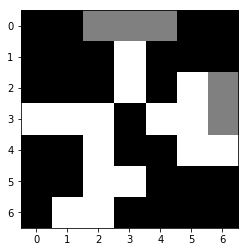

((3, 4), (2, 6)): n_v:   673 q_all:-0.662727 q:-0.738691 q_m:-0.333333 p:0.015295
((1, 3), (0, 4)): n_v:   551 q_all:-0.799816 q:-0.811597 q_m:-0.233333 p:0.283368
((1, 3), (0, 2)): n_v:   483 q_all:-0.777072 q:-0.706237 q_m:-0.233333 p:0.209009
((2, 3), (0, 4)): n_v:   388 q_all:-0.795384 q:-0.698363 q_m:-0.266667 p:0.193360
((2, 3), (0, 2)): n_v:   370 q_all:-0.777641 q:-0.672807 q_m:-0.266667 p:0.160940
((2, 5), (0, 4)): n_v:   310 q_all:-0.757625 q:-0.762638 q_m:-0.266667 p:0.112402
((2, 5), (2, 6)): n_v:    80 q_all:-0.682981 q:-0.805368 q_m:-0.300000 p:0.007043
((4, 6), (2, 6)): n_v:    14 q_all:-0.751628 q:-0.749071 q_m:-0.333333 p:0.004533
((4, 5), (2, 6)): n_v:     9 q_all:-0.756681 q:-0.705207 q_m:-0.333333 p:0.003544
((2, 5), (3, 6)): n_v:     3 q_all:-0.674090 q:-0.743960 q_m:-0.433333 p:0.000100
((3, 4), (3, 6)): n_v:     2 q_all:-0.659952 q:-0.691284 q_m:-0.466667 p:0.000012
((2, 5), (0, 3)): n_v:     1 q_all:-0.821667 q:-0.774722 q_m:-0.333333 p:0.000819
((2, 3), (0, 3))

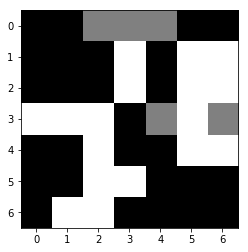

((2, 4), (3, 4)): n_v:  1515 q_all:+0.743628 q:+0.851407 q_m:+0.633333 p:0.191268
((2, 4), (3, 6)): n_v:   396 q_all:+0.751047 q:+0.763258 q_m:+0.666667 p:0.038001
((4, 4), (3, 6)): n_v:   145 q_all:+0.716686 q:+0.769086 q_m:+0.666667 p:0.034118
((5, 6), (3, 4)): n_v:    96 q_all:+0.697286 q:+0.732568 q_m:+0.600000 p:0.030301
((5, 6), (3, 6)): n_v:    61 q_all:+0.648065 q:+0.718683 q_m:+0.666667 p:0.030970
((1, 4), (3, 6)): n_v:    61 q_all:+0.674114 q:+0.713775 q_m:+0.666667 p:0.024980
((5, 5), (3, 6)): n_v:    42 q_all:+0.685221 q:+0.703018 q_m:+0.666667 p:0.015578
((5, 4), (3, 6)): n_v:    28 q_all:+0.532057 q:+0.579334 q_m:+0.666667 p:0.028172
((0, 5), (0, 4)): n_v:    20 q_all:+0.600697 q:+0.718738 q_m:+0.500000 p:0.014747
((1, 4), (3, 4)): n_v:    20 q_all:+0.719380 q:+0.706021 q_m:+0.600000 p:0.004367
((0, 1), (0, 2)): n_v:    16 q_all:+0.660913 q:+0.688615 q_m:+0.433333 p:0.007700
((5, 5), (3, 4)): n_v:     8 q_all:+0.456056 q:+0.644215 q_m:+0.600000 p:0.010745
((2, 2), (3, 4))

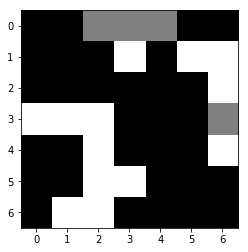

((1, 5), (3, 6)): n_v:  1173 q_all:-0.725095 q:-0.895669 q_m:-0.433333 p:0.162216
((2, 6), (3, 6)): n_v:  1153 q_all:-0.771741 q:-0.893805 q_m:-0.400000 p:0.347105
((1, 6), (3, 6)): n_v:   752 q_all:-0.733011 q:-0.876493 q_m:-0.433333 p:0.124870
((1, 3), (0, 4)): n_v:    83 q_all:-0.738342 q:-0.936662 q_m:-0.466667 p:0.015445
((2, 6), (0, 4)): n_v:    47 q_all:-0.763430 q:-0.926322 q_m:-0.500000 p:0.012920
((1, 3), (0, 2)): n_v:    34 q_all:-0.801750 q:-0.935382 q_m:-0.400000 p:0.013397
((1, 6), (0, 4)): n_v:    26 q_all:-0.714246 q:-0.931177 q_m:-0.500000 p:0.002597
((1, 5), (0, 3)): n_v:     2 q_all:-0.781642 q:-0.921504 q_m:-0.500000 p:0.000107
((1, 3), (0, 3)): n_v:     0 q_all:-0.712383 q:-0.958100 q_m:-0.466667 p:0.000088
-1 's turn
one move takes time(s):  0.1566464900970459
train_mode is both train
no. of data collected:  8


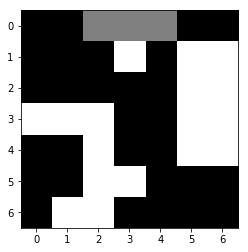

((0, 5), (0, 4)): n_v:  2317 q_all:+0.822767 q:+0.941547 q_m:+0.566667 p:0.301439
((0, 1), (0, 2)): n_v:   401 q_all:+0.747704 q:+0.903868 q_m:+0.500000 p:0.164088
((0, 6), (0, 4)): n_v:    36 q_all:+0.818232 q:+0.892834 q_m:+0.533333 p:0.005260
((2, 0), (0, 2)): n_v:    10 q_all:+0.822446 q:+0.784682 q_m:+0.466667 p:0.000998
((0, 0), (0, 2)): n_v:     3 q_all:+0.687979 q:+0.884283 q_m:+0.466667 p:0.002512
((1, 2), (0, 3)): n_v:     2 q_all:+0.690333 q:+0.896640 q_m:+0.500000 p:0.001276
((0, 1), (0, 3)): n_v:     0 q_all:+0.632497 q:+0.798328 q_m:+0.466667 p:0.000144
((2, 3), (0, 3)): n_v:     0 q_all:+0.561001 q:+0.655335 q_m:+0.466667 p:0.000001
((1, 0), (0, 2)): n_v:     0 q_all:+0.593889 q:+0.721112 q_m:+0.466667 p:0.000513
((2, 2), (0, 2)): n_v:     0 q_all:+0.498786 q:+0.530905 q_m:+0.466667 p:0.000026
((2, 3), (0, 4)): n_v:     0 q_all:+0.647528 q:+0.761723 q_m:+0.533333 p:0.000387
((2, 1), (0, 3)): n_v:     0 q_all:+0.507305 q:+0.547943 q_m:+0.466667 p:0.000004
((2, 4), (0, 3))

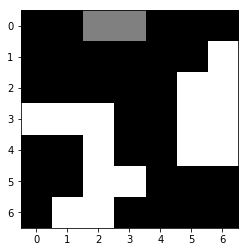

((2, 5), (0, 3)): n_v:  3472 q_all:-0.885298 q:-0.988172 q_m:-0.300000 p:0.998626
-1 's turn


This is a random move


one move takes time(s):  0.06607413291931152
train_mode is both train
no. of data collected:  8


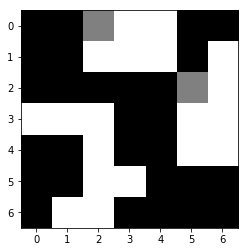

((0, 1), (0, 2)): n_v:  2548 q_all:+0.978099 q:+0.968209 q_m:+0.533333 p:0.009473
((1, 5), (2, 5)): n_v:  1462 q_all:+0.836499 q:+0.997217 q_m:+0.666667 p:0.307182
((0, 5), (2, 5)): n_v:   895 q_all:+0.900309 q:+0.961972 q_m:+0.633333 p:0.014083
((0, 6), (2, 5)): n_v:   124 q_all:+0.811519 q:+0.991252 q_m:+0.633333 p:0.040257
((0, 0), (0, 2)): n_v:     2 q_all:+0.734778 q:+0.969557 q_m:+0.500000 p:0.001923
((4, 3), (2, 5)): n_v:     1 q_all:+0.761063 q:+0.888793 q_m:+0.633333 p:0.000687
((3, 3), (2, 5)): n_v:     1 q_all:+0.743205 q:+0.853077 q_m:+0.633333 p:0.001173
((2, 4), (0, 2)): n_v:     0 q_all:+0.720634 q:+0.941268 q_m:+0.500000 p:0.000084
((2, 3), (2, 5)): n_v:     0 q_all:+0.746970 q:+0.860607 q_m:+0.633333 p:0.000379
((2, 0), (0, 2)): n_v:     0 q_all:+0.710496 q:+0.920992 q_m:+0.500000 p:0.000013
((1, 0), (0, 2)): n_v:     0 q_all:+0.665973 q:+0.831945 q_m:+0.500000 p:0.000112
((2, 2), (0, 2)): n_v:     0 q_all:+0.526595 q:+0.553190 q_m:+0.500000 p:0.000007
((2, 3), (0, 2))

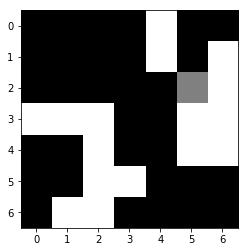

((0, 4), (2, 5)): n_v:  1310 q_all:-0.976571 q:-0.914691 q_m:-0.333333 p:0.076990
((1, 4), (2, 5)): n_v:  1197 q_all:-1.000000 q:+5.000000 q_m:-0.300000 p:0.155910
((4, 6), (2, 5)): n_v:  1010 q_all:-0.985659 q:-0.948522 q_m:-0.333333 p:0.087405
((4, 5), (2, 5)): n_v:   776 q_all:-0.987307 q:-0.954373 q_m:-0.333333 p:0.070960
-1 's turn
one move takes time(s):  0.054453372955322266
train_mode is both train
no. of data collected:  8


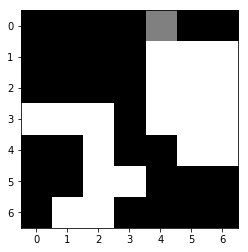

((0, 3), (0, 4)): n_v:  2695 q_all:+1.000000 q:+5.000000 q_m:+0.500000 p:0.293546
((0, 6), (0, 4)): n_v:    47 q_all:+0.819798 q:+0.962314 q_m:+0.466667 p:0.036316
((0, 2), (0, 4)): n_v:    16 q_all:+0.901468 q:+0.965885 q_m:+0.466667 p:0.006936
((2, 3), (0, 4)): n_v:    13 q_all:+0.976732 q:+0.881835 q_m:+0.466667 p:0.002599
((2, 2), (0, 4)): n_v:     7 q_all:+0.952229 q:+0.768993 q_m:+0.466667 p:0.002183
((1, 2), (0, 4)): n_v:     0 q_all:+0.624996 q:+0.783325 q_m:+0.466667 p:0.001296
this self play has 65 steps, time elapsed 95.95991230010986
winner is -1.0
episode 177 finished
episode 178 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.37735843658447266
train_mode is both train
no. of data collected:  8


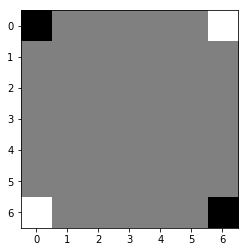

((0, 0), (1, 1)): n_v:   684 q_all:+0.003856 q:+0.004628 q_m:+0.033333 p:0.379824
((6, 6), (5, 5)): n_v:   665 q_all:+0.003312 q:+0.017064 q_m:+0.033333 p:0.370862
((0, 0), (0, 1)): n_v:   133 q_all:-0.009355 q:-0.016971 q_m:+0.033333 p:0.082187
((6, 6), (6, 5)): n_v:   121 q_all:-0.007235 q:-0.003708 q_m:+0.033333 p:0.073760
((0, 0), (1, 0)): n_v:    81 q_all:-0.002966 q:+0.004100 q_m:+0.033333 p:0.047497
((6, 6), (5, 6)): n_v:    76 q_all:-0.001069 q:+0.007339 q_m:+0.033333 p:0.044222
((6, 6), (6, 4)): n_v:     0 q_all:-0.006230 q:-0.006230 q_m:-0.000000 p:0.000022
((0, 0), (1, 2)): n_v:     0 q_all:-0.028677 q:-0.028677 q_m:-0.000000 p:0.000095
((0, 0), (2, 2)): n_v:     0 q_all:-0.026388 q:-0.026388 q_m:-0.000000 p:0.000235
((0, 0), (0, 2)): n_v:     0 q_all:-0.036040 q:-0.036040 q_m:-0.000000 p:0.000029
((6, 6), (4, 6)): n_v:     0 q_all:-0.017304 q:-0.017304 q_m:-0.000000 p:0.000235
((6, 6), (5, 4)): n_v:     0 q_all:-0.000022 q:-0.000022 q_m:-0.000000 p:0.000113
((6, 6), (4, 4))

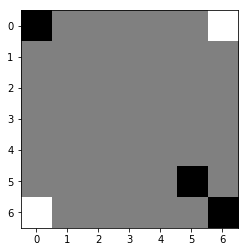

((6, 0), (5, 1)): n_v:   646 q_all:-0.009477 q:+0.002590 q_m:-0.000000 p:0.267461
((0, 6), (1, 5)): n_v:   639 q_all:-0.007765 q:-0.000438 q_m:-0.000000 p:0.259688
((6, 0), (5, 0)): n_v:   452 q_all:-0.006942 q:+0.012655 q_m:-0.000000 p:0.182622
((0, 6), (1, 6)): n_v:   401 q_all:-0.009588 q:-0.016078 q_m:-0.000000 p:0.166411
((0, 6), (0, 5)): n_v:   148 q_all:-0.010499 q:-0.013405 q_m:-0.000000 p:0.062131
((6, 0), (6, 1)): n_v:   139 q_all:-0.010891 q:+0.003993 q_m:-0.000000 p:0.058570
((0, 6), (2, 4)): n_v:     0 q_all:-0.025351 q:-0.025351 q_m:-0.033333 p:0.000299
((6, 0), (6, 2)): n_v:     0 q_all:-0.012985 q:-0.012985 q_m:-0.033333 p:0.000311
((6, 0), (5, 2)): n_v:     0 q_all:-0.011779 q:-0.011779 q_m:-0.033333 p:0.000212
((6, 0), (4, 1)): n_v:     0 q_all:-0.000704 q:-0.000704 q_m:-0.033333 p:0.000336
((0, 6), (2, 6)): n_v:     0 q_all:-0.007029 q:-0.007029 q_m:-0.033333 p:0.000294
((0, 6), (0, 4)): n_v:     0 q_all:-0.030737 q:-0.030737 q_m:-0.033333 p:0.000145
((0, 6), (2, 5))

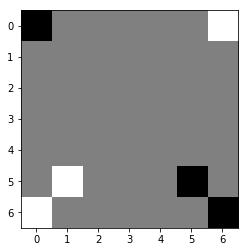

((0, 0), (1, 1)): n_v:   847 q_all:+0.011083 q:+0.008603 q_m:+0.033333 p:0.289798
((5, 5), (4, 4)): n_v:   502 q_all:+0.014844 q:+0.011934 q_m:+0.033333 p:0.164218
((5, 5), (4, 5)): n_v:   200 q_all:-0.000963 q:-0.003618 q_m:+0.033333 p:0.078494
((5, 5), (6, 5)): n_v:   189 q_all:-0.003425 q:-0.007596 q_m:+0.033333 p:0.076193
((5, 5), (5, 6)): n_v:   168 q_all:-0.003509 q:-0.003178 q_m:+0.033333 p:0.067657
((0, 0), (0, 1)): n_v:   138 q_all:-0.005623 q:-0.016746 q_m:+0.033333 p:0.056538
((5, 5), (5, 4)): n_v:   131 q_all:+0.007486 q:+0.013932 q_m:+0.033333 p:0.046730
((0, 0), (1, 0)): n_v:    86 q_all:+0.003605 q:+0.005507 q_m:+0.033333 p:0.032241
((5, 5), (6, 4)): n_v:    73 q_all:+0.005615 q:+0.014835 q_m:+0.033333 p:0.026820
((5, 5), (4, 6)): n_v:    72 q_all:-0.006552 q:+0.004170 q_m:+0.033333 p:0.029897
((5, 5), (3, 6)): n_v:     0 q_all:-0.021278 q:-0.021278 q_m:-0.000000 p:0.000110
((5, 5), (5, 3)): n_v:     0 q_all:-0.013858 q:-0.013858 q_m:-0.000000 p:0.000056
((0, 0), (0, 2))

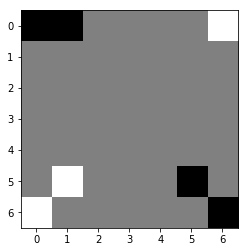

((0, 6), (1, 5)): n_v:   630 q_all:-0.012872 q:+0.001773 q_m:-0.000000 p:0.300742
((5, 1), (4, 2)): n_v:   404 q_all:-0.000140 q:-0.019952 q_m:-0.000000 p:0.169480
((5, 1), (4, 0)): n_v:   193 q_all:-0.027199 q:-0.022050 q_m:-0.000000 p:0.105003
((0, 6), (1, 6)): n_v:   183 q_all:-0.021967 q:-0.013354 q_m:-0.000000 p:0.095343
((5, 1), (5, 0)): n_v:   138 q_all:-0.012072 q:-0.023106 q_m:-0.000000 p:0.065676
((5, 1), (4, 1)): n_v:   118 q_all:-0.020300 q:-0.017983 q_m:-0.000000 p:0.060481
((5, 1), (5, 2)): n_v:    83 q_all:-0.007894 q:-0.010179 q_m:-0.000000 p:0.038174
((0, 6), (0, 5)): n_v:    73 q_all:-0.019823 q:-0.010121 q_m:-0.000000 p:0.037576
((5, 1), (6, 1)): n_v:    39 q_all:-0.025937 q:-0.034326 q_m:-0.000000 p:0.021409
((5, 1), (6, 2)): n_v:    26 q_all:-0.003636 q:-0.020729 q_m:-0.000000 p:0.011277
((0, 6), (2, 4)): n_v:     0 q_all:-0.023122 q:-0.023122 q_m:-0.033333 p:0.000364
((0, 6), (0, 4)): n_v:     0 q_all:-0.025636 q:-0.025636 q_m:-0.033333 p:0.000127
((6, 0), (6, 2))

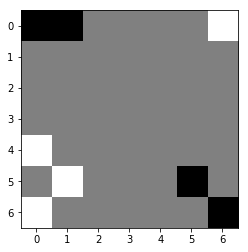

((5, 5), (4, 4)): n_v:   480 q_all:+0.030934 q:+0.015984 q_m:+0.033333 p:0.122781
((5, 5), (4, 5)): n_v:   344 q_all:+0.004202 q:+0.000436 q_m:+0.033333 p:0.129495
((0, 0), (1, 1)): n_v:   327 q_all:+0.009208 q:-0.004238 q_m:+0.033333 p:0.116042
((5, 5), (5, 6)): n_v:   220 q_all:-0.000421 q:+0.000183 q_m:+0.033333 p:0.087646
((5, 5), (6, 5)): n_v:   148 q_all:-0.002251 q:-0.005405 q_m:+0.033333 p:0.060126
((5, 5), (4, 6)): n_v:   140 q_all:-0.009173 q:+0.003613 q_m:+0.033333 p:0.061462
((5, 5), (5, 4)): n_v:   124 q_all:+0.016009 q:+0.014508 q_m:+0.033333 p:0.040228
((0, 0), (1, 0)): n_v:    81 q_all:-0.008229 q:-0.020700 q_m:+0.033333 p:0.035197
((5, 5), (6, 4)): n_v:    44 q_all:+0.013153 q:+0.017162 q_m:+0.033333 p:0.014971
((0, 1), (1, 2)): n_v:    32 q_all:-0.016226 q:-0.033008 q_m:+0.033333 p:0.014993
((0, 1), (0, 2)): n_v:    10 q_all:-0.016420 q:-0.028715 q_m:+0.033333 p:0.004882
((0, 1), (0, 3)): n_v:     0 q_all:-0.023014 q:-0.023014 q_m:-0.000000 p:0.000233
((5, 5), (3, 6))

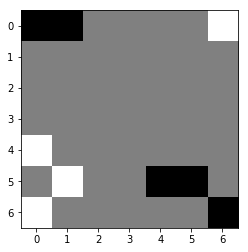

((5, 1), (4, 2)): n_v:   546 q_all:+0.015155 q:-0.003815 q_m:-0.000000 p:0.245630
((5, 1), (5, 2)): n_v:   189 q_all:+0.018465 q:-0.007197 q_m:-0.000000 p:0.082140
((4, 0), (3, 1)): n_v:   184 q_all:+0.030251 q:-0.015394 q_m:-0.000000 p:0.069557
((0, 6), (1, 5)): n_v:   121 q_all:+0.010147 q:+0.012383 q_m:-0.000000 p:0.057792
((4, 0), (3, 0)): n_v:   106 q_all:+0.021630 q:-0.006407 q_m:-0.000000 p:0.044736
((4, 0), (4, 1)): n_v:   102 q_all:+0.002676 q:-0.018804 q_m:-0.000000 p:0.052393
((4, 0), (5, 0)): n_v:   102 q_all:+0.006461 q:-0.008903 q_m:-0.000000 p:0.050574
((0, 6), (0, 5)): n_v:    77 q_all:+0.003798 q:-0.000253 q_m:-0.000000 p:0.039188
((0, 6), (1, 6)): n_v:    68 q_all:+0.002056 q:-0.002919 q_m:-0.000000 p:0.035091
((5, 1), (6, 2)): n_v:    57 q_all:+0.019112 q:-0.019989 q_m:-0.000000 p:0.024688
((5, 1), (6, 1)): n_v:    54 q_all:-0.018014 q:-0.042709 q_m:-0.000000 p:0.033398
((4, 0), (6, 2)): n_v:    36 q_all:+0.013702 q:-0.007614 q_m:-0.033333 p:0.016643
((4, 0), (6, 1))

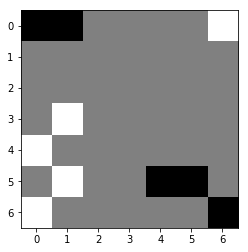

((5, 4), (4, 5)): n_v:   335 q_all:-0.001196 q:+0.000289 q_m:+0.033333 p:0.119786
((5, 4), (4, 3)): n_v:   288 q_all:+0.015832 q:+0.016355 q_m:+0.033333 p:0.079924
((5, 4), (4, 4)): n_v:   182 q_all:-0.014003 q:-0.000133 q_m:+0.033333 p:0.076127
((5, 5), (4, 6)): n_v:   178 q_all:-0.025626 q:+0.001069 q_m:+0.033333 p:0.084226
((5, 5), (5, 6)): n_v:   160 q_all:-0.020946 q:-0.011590 q_m:+0.033333 p:0.072220
((5, 4), (5, 3)): n_v:   122 q_all:+0.023460 q:+0.008147 q_m:+0.033333 p:0.029500
((5, 4), (6, 5)): n_v:   114 q_all:-0.026234 q:-0.011799 q_m:+0.033333 p:0.054729
((5, 4), (4, 2)): n_v:    59 q_all:-0.032031 q:+0.070864 q_m:+0.133333 p:0.029895
((5, 4), (6, 3)): n_v:    47 q_all:+0.006629 q:+0.021174 q_m:+0.033333 p:0.015299
((5, 4), (3, 5)): n_v:    39 q_all:-0.027873 q:-0.008152 q_m:-0.000000 p:0.019139
((5, 4), (3, 6)): n_v:    31 q_all:-0.035092 q:-0.001342 q_m:-0.000000 p:0.016251
((0, 0), (1, 0)): n_v:    29 q_all:-0.096257 q:-0.031312 q_m:+0.033333 p:0.023858
((5, 4), (5, 6))

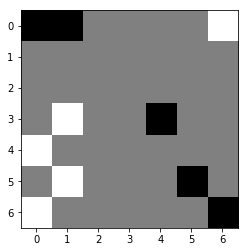

((3, 1), (1, 1)): n_v:   504 q_all:+0.066515 q:+0.093255 q_m:+0.133333 p:0.171904
((0, 6), (1, 5)): n_v:   123 q_all:+0.036522 q:+0.011257 q_m:+0.033333 p:0.060362
((3, 1), (1, 0)): n_v:   116 q_all:+0.058608 q:+0.096034 q_m:+0.133333 p:0.043899
((4, 0), (5, 0)): n_v:   100 q_all:+0.038576 q:-0.020778 q_m:+0.033333 p:0.048182
((3, 1), (4, 2)): n_v:    96 q_all:+0.038303 q:-0.026307 q_m:+0.033333 p:0.046239
((3, 1), (4, 1)): n_v:    86 q_all:+0.038834 q:-0.035024 q_m:+0.033333 p:0.041629
((3, 1), (2, 1)): n_v:    60 q_all:+0.051458 q:-0.026009 q_m:+0.033333 p:0.025207
((3, 1), (3, 2)): n_v:    57 q_all:+0.038334 q:-0.012143 q_m:+0.033333 p:0.027755
((3, 1), (3, 0)): n_v:    55 q_all:+0.028512 q:-0.034192 q_m:+0.033333 p:0.029330
((3, 1), (5, 0)): n_v:    51 q_all:-0.020751 q:-0.016881 q_m:-0.000000 p:0.040018
((0, 6), (1, 6)): n_v:    50 q_all:+0.020842 q:-0.011847 q_m:+0.033333 p:0.028415
((3, 1), (2, 2)): n_v:    47 q_all:+0.023128 q:-0.000237 q_m:+0.033333 p:0.026639
((3, 1), (2, 0))

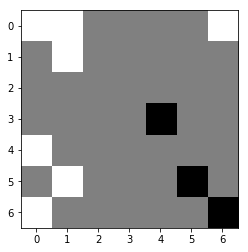

((3, 4), (1, 5)): n_v:   758 q_all:-0.057814 q:-0.059373 q_m:-0.066667 p:0.294783
((3, 4), (1, 6)): n_v:   439 q_all:-0.057830 q:-0.067490 q_m:-0.066667 p:0.170900
((3, 4), (5, 6)): n_v:   109 q_all:-0.126444 q:-0.137212 q_m:-0.133333 p:0.075192
((3, 4), (1, 2)): n_v:   105 q_all:-0.054233 q:-0.076761 q_m:-0.000000 p:0.038805
((3, 4), (3, 6)): n_v:    96 q_all:-0.094000 q:-0.114629 q_m:-0.133333 p:0.052722
((5, 5), (5, 6)): n_v:    61 q_all:-0.071389 q:-0.117257 q_m:-0.100000 p:0.027675
((3, 4), (4, 3)): n_v:    58 q_all:-0.049858 q:-0.073360 q_m:-0.100000 p:0.020671
((3, 4), (2, 3)): n_v:    53 q_all:-0.074910 q:-0.082953 q_m:-0.100000 p:0.024581
((3, 4), (2, 6)): n_v:    52 q_all:-0.120974 q:-0.100009 q_m:-0.133333 p:0.034655
((3, 4), (3, 5)): n_v:    52 q_all:-0.071693 q:-0.095630 q_m:-0.100000 p:0.023670
((5, 5), (6, 5)): n_v:    49 q_all:-0.073123 q:-0.100381 q_m:-0.100000 p:0.022464
((5, 5), (5, 4)): n_v:    35 q_all:-0.075594 q:-0.075959 q_m:-0.100000 p:0.016442
((3, 4), (3, 2))

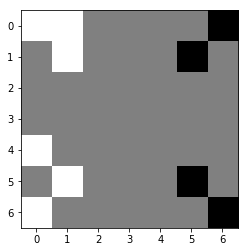

((1, 1), (2, 2)): n_v:   719 q_all:+0.061853 q:+0.044022 q_m:+0.100000 p:0.217896
((4, 0), (3, 1)): n_v:   400 q_all:+0.051816 q:+0.036775 q_m:+0.100000 p:0.137593
((4, 0), (3, 0)): n_v:   206 q_all:+0.048196 q:+0.065003 q_m:+0.100000 p:0.073878
((0, 1), (0, 2)): n_v:   181 q_all:+0.083715 q:+0.072096 q_m:+0.100000 p:0.038564
((1, 1), (2, 0)): n_v:   169 q_all:+0.045330 q:+0.070187 q_m:+0.100000 p:0.062963
((0, 0), (1, 0)): n_v:   130 q_all:+0.058688 q:+0.076192 q_m:+0.100000 p:0.041275
((0, 1), (1, 2)): n_v:   112 q_all:+0.063300 q:+0.033909 q_m:+0.100000 p:0.033341
((1, 1), (2, 1)): n_v:   101 q_all:+0.051407 q:+0.042404 q_m:+0.100000 p:0.035171
((5, 1), (4, 2)): n_v:    96 q_all:+0.050251 q:+0.041657 q_m:+0.100000 p:0.033998
((5, 1), (6, 1)): n_v:    63 q_all:+0.032222 q:+0.017165 q_m:+0.100000 p:0.026602
((4, 0), (2, 2)): n_v:    41 q_all:+0.048439 q:+0.026464 q_m:+0.066667 p:0.014966
((4, 0), (5, 0)): n_v:    22 q_all:+0.051137 q:+0.055971 q_m:+0.100000 p:0.007683
((4, 0), (2, 0))

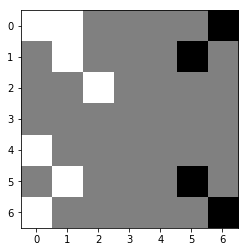

((5, 5), (3, 3)): n_v:   554 q_all:-0.030234 q:-0.033242 q_m:-0.033333 p:0.167509
((0, 6), (1, 6)): n_v:   488 q_all:-0.034964 q:-0.065359 q_m:-0.066667 p:0.157109
((1, 5), (1, 4)): n_v:   308 q_all:-0.075492 q:-0.037784 q_m:-0.066667 p:0.150864
((1, 5), (3, 3)): n_v:   232 q_all:-0.031856 q:-0.032785 q_m:-0.033333 p:0.071769
((1, 5), (2, 4)): n_v:   160 q_all:-0.043776 q:-0.039425 q_m:-0.066667 p:0.057457
((1, 5), (2, 5)): n_v:    65 q_all:-0.051389 q:-0.048596 q_m:-0.066667 p:0.025470
((0, 6), (0, 5)): n_v:    54 q_all:-0.039887 q:-0.080195 q_m:-0.066667 p:0.018451
((1, 5), (0, 4)): n_v:    49 q_all:-0.043127 q:-0.048470 q_m:-0.066667 p:0.017477
((1, 5), (2, 6)): n_v:    45 q_all:-0.046502 q:-0.062949 q_m:-0.066667 p:0.016880
((5, 5), (5, 6)): n_v:    44 q_all:-0.040378 q:-0.075553 q_m:-0.066667 p:0.015371
((1, 5), (1, 3)): n_v:    40 q_all:-0.075674 q:-0.032854 q_m:-0.033333 p:0.019837
((1, 5), (2, 3)): n_v:    33 q_all:-0.072522 q:-0.024397 q_m:-0.033333 p:0.015610
((5, 5), (5, 4))

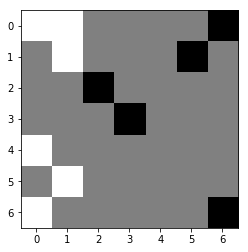

((1, 1), (2, 3)): n_v:   586 q_all:+0.088196 q:+0.102715 q_m:+0.166667 p:0.122227
((4, 0), (3, 1)): n_v:   509 q_all:+0.035322 q:+0.074419 q_m:+0.133333 p:0.218510
((5, 1), (4, 2)): n_v:   297 q_all:+0.000408 q:+0.048094 q_m:+0.133333 p:0.170814
((0, 1), (2, 3)): n_v:   260 q_all:+0.073965 q:+0.070891 q_m:+0.166667 p:0.069894
((0, 1), (1, 3)): n_v:   105 q_all:+0.050458 q:+0.059298 q_m:+0.100000 p:0.038540
((0, 1), (1, 2)): n_v:    82 q_all:+0.046320 q:+0.053657 q_m:+0.133333 p:0.031662
((1, 1), (2, 1)): n_v:    78 q_all:+0.024975 q:+0.043072 q_m:+0.133333 p:0.037389
((1, 1), (3, 2)): n_v:    62 q_all:+0.030593 q:+0.070268 q_m:+0.166667 p:0.027980
((5, 1), (3, 2)): n_v:    54 q_all:+0.042459 q:+0.100596 q_m:+0.166667 p:0.021868
((4, 0), (3, 0)): n_v:    36 q_all:-0.025856 q:+0.027951 q_m:+0.066667 p:0.025101
((1, 1), (2, 0)): n_v:    33 q_all:-0.012260 q:+0.036281 q_m:+0.066667 p:0.020620
((5, 1), (4, 3)): n_v:    25 q_all:+0.024286 q:+0.044902 q_m:+0.100000 p:0.012042
((0, 1), (0, 2))

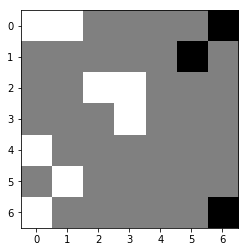

((1, 5), (2, 4)): n_v:  1667 q_all:-0.057822 q:+0.010907 q_m:-0.000000 p:0.636641
((1, 5), (3, 4)): n_v:   363 q_all:-0.091438 q:-0.028667 q_m:-0.033333 p:0.189569
((1, 5), (1, 4)): n_v:   103 q_all:-0.094802 q:-0.059885 q_m:-0.066667 p:0.055184
((0, 6), (2, 4)): n_v:    90 q_all:-0.065922 q:-0.003884 q_m:-0.033333 p:0.037542
((1, 5), (1, 3)): n_v:    40 q_all:-0.093556 q:-0.040751 q_m:-0.033333 p:0.021135
((6, 6), (4, 4)): n_v:    20 q_all:-0.071431 q:-0.050008 q_m:-0.100000 p:0.008911
((1, 5), (2, 5)): n_v:     7 q_all:-0.067188 q:-0.104037 q_m:-0.133333 p:0.003198
((1, 5), (2, 6)): n_v:     7 q_all:-0.061407 q:-0.105884 q_m:-0.133333 p:0.002856
((1, 5), (0, 4)): n_v:     7 q_all:-0.226390 q:-0.124244 q_m:-0.133333 p:0.007999
((6, 6), (5, 5)): n_v:     4 q_all:-0.135993 q:-0.080745 q_m:-0.133333 p:0.002979
((0, 6), (0, 5)): n_v:     4 q_all:-0.074919 q:-0.140483 q_m:-0.133333 p:0.002134
((1, 5), (0, 3)): n_v:     4 q_all:-0.100039 q:-0.129293 q_m:-0.166667 p:0.002396
((0, 6), (1, 4))

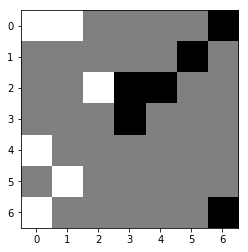

((2, 2), (1, 4)): n_v:  1405 q_all:+0.088504 q:+0.105780 q_m:+0.200000 p:0.306260
((2, 2), (3, 2)): n_v:   890 q_all:+0.039406 q:+0.074739 q_m:+0.166667 p:0.346802
((2, 2), (3, 4)): n_v:   516 q_all:+0.074669 q:+0.082415 q_m:+0.200000 p:0.137369
((2, 2), (1, 3)): n_v:   135 q_all:+0.055820 q:+0.088660 q_m:+0.166667 p:0.044963
((0, 1), (1, 3)): n_v:    70 q_all:+0.027255 q:+0.063700 q_m:+0.133333 p:0.030476
((5, 1), (3, 2)): n_v:    66 q_all:+0.039973 q:+0.066166 q_m:+0.133333 p:0.025948
((4, 0), (3, 2)): n_v:    43 q_all:+0.030263 q:+0.070942 q_m:+0.133333 p:0.018408
((2, 2), (4, 4)): n_v:    26 q_all:+0.009675 q:+0.007888 q_m:+0.066667 p:0.013168
((2, 2), (0, 4)): n_v:    19 q_all:+0.007268 q:+0.054587 q_m:+0.066667 p:0.009846
((0, 1), (1, 2)): n_v:    16 q_all:-0.023158 q:+0.006273 q_m:+0.100000 p:0.010089
((2, 2), (4, 2)): n_v:     7 q_all:-0.024417 q:+0.007513 q_m:+0.066667 p:0.004618
((2, 2), (4, 3)): n_v:     7 q_all:-0.016020 q:+0.006940 q_m:+0.066667 p:0.004355
((2, 2), (1, 0))

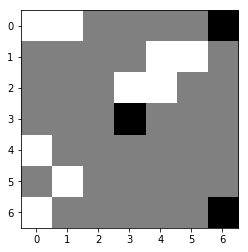

((3, 3), (2, 5)): n_v:  1307 q_all:-0.036089 q:-0.055200 q_m:-0.000000 p:0.297115
((3, 3), (2, 1)): n_v:   431 q_all:-0.134720 q:-0.140766 q_m:-0.200000 p:0.253212
((0, 6), (2, 5)): n_v:   285 q_all:-0.047598 q:-0.034880 q_m:-0.000000 p:0.076626
((3, 3), (4, 5)): n_v:   203 q_all:-0.111205 q:-0.155704 q_m:-0.200000 p:0.101965
((3, 3), (1, 1)): n_v:   187 q_all:-0.055977 q:-0.078762 q_m:-0.066667 p:0.056182
((3, 3), (3, 4)): n_v:   109 q_all:-0.072819 q:-0.080807 q_m:-0.033333 p:0.039648
((3, 3), (5, 5)): n_v:    71 q_all:-0.150111 q:-0.131260 q_m:-0.200000 p:0.045659
((0, 6), (0, 5)): n_v:    62 q_all:-0.086511 q:-0.079916 q_m:-0.033333 p:0.025836
((3, 3), (4, 1)): n_v:    47 q_all:-0.087437 q:-0.088253 q_m:-0.066667 p:0.019870
((3, 3), (1, 3)): n_v:    42 q_all:-0.063143 q:-0.063037 q_m:-0.000000 p:0.013938
((3, 3), (3, 2)): n_v:    31 q_all:-0.097649 q:-0.082489 q_m:-0.100000 p:0.014302
((6, 6), (4, 5)): n_v:    26 q_all:-0.115956 q:-0.115619 q_m:-0.200000 p:0.013989
((6, 6), (6, 5))

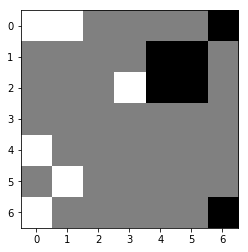

((2, 3), (0, 5)): n_v:  1330 q_all:+0.035187 q:+0.064965 q_m:+0.200000 p:0.495446
((2, 3), (3, 4)): n_v:   366 q_all:+0.062668 q:+0.061095 q_m:+0.166667 p:0.098902
((2, 3), (1, 1)): n_v:   360 q_all:+0.030834 q:+0.022763 q_m:-0.000000 p:0.139874
((2, 3), (1, 3)): n_v:   201 q_all:+0.068282 q:+0.088469 q_m:+0.166667 p:0.050445
((2, 3), (3, 5)): n_v:   126 q_all:+0.048985 q:+0.070241 q_m:+0.133333 p:0.040612
((2, 3), (0, 4)): n_v:    63 q_all:+0.012435 q:+0.050319 q_m:+0.133333 p:0.028927
((2, 3), (3, 2)): n_v:    58 q_all:+0.003936 q:+0.009938 q_m:+0.033333 p:0.028333
((2, 3), (3, 1)): n_v:    40 q_all:+0.007907 q:-0.024101 q_m:-0.000000 p:0.019261
((2, 3), (0, 2)): n_v:    33 q_all:+0.040850 q:+0.001337 q_m:-0.000000 p:0.011798
((4, 0), (3, 1)): n_v:    29 q_all:+0.020818 q:+0.000092 q_m:+0.033333 p:0.012488
((0, 0), (1, 0)): n_v:    26 q_all:+0.026086 q:+0.035850 q_m:+0.033333 p:0.010851
((2, 3), (4, 5)): n_v:    14 q_all:+0.000342 q:+0.027095 q_m:-0.000000 p:0.007166
((2, 3), (2, 1))

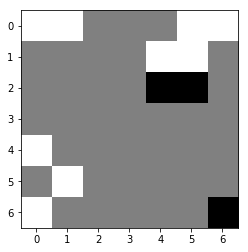

((2, 5), (1, 6)): n_v:  2816 q_all:-0.032714 q:-0.018130 q_m:+0.033333 p:0.946721
((2, 4), (1, 6)): n_v:    88 q_all:-0.050531 q:-0.049995 q_m:-0.000000 p:0.035204
((6, 6), (5, 6)): n_v:    17 q_all:-0.089610 q:-0.136463 q_m:-0.166667 p:0.009614
((2, 5), (0, 4)): n_v:     7 q_all:-0.065897 q:-0.044997 q_m:-0.000000 p:0.003590
((2, 4), (0, 4)): n_v:     6 q_all:-0.079247 q:-0.058228 q_m:-0.000000 p:0.003042
((6, 6), (5, 5)): n_v:     0 q_all:-0.098304 q:-0.098304 q_m:-0.166667 p:0.000237
((2, 4), (3, 4)): n_v:     0 q_all:-0.122731 q:-0.122731 q_m:-0.166667 p:0.000004
((2, 5), (3, 6)): n_v:     0 q_all:-0.130758 q:-0.130758 q_m:-0.166667 p:0.000011
((2, 4), (4, 5)): n_v:     0 q_all:-0.134812 q:-0.134812 q_m:-0.200000 p:0.000005
((2, 5), (0, 3)): n_v:     0 q_all:-0.159155 q:-0.159155 q_m:-0.133333 p:0.000008
((2, 5), (1, 3)): n_v:     0 q_all:-0.133114 q:-0.133114 q_m:-0.133333 p:0.000005
((2, 4), (3, 5)): n_v:     0 q_all:-0.133245 q:-0.133245 q_m:-0.166667 p:0.000025
((2, 4), (1, 2))

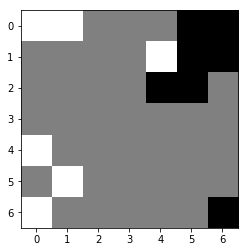

((1, 4), (2, 6)): n_v:  2091 q_all:+0.055981 q:+0.056234 q_m:+0.166667 p:0.403935
((1, 4), (0, 4)): n_v:   961 q_all:+0.056002 q:+0.045249 q_m:+0.133333 p:0.185582
((4, 0), (2, 0)): n_v:   242 q_all:+0.003658 q:+0.007144 q_m:-0.033333 p:0.085140
((0, 1), (0, 2)): n_v:   132 q_all:-0.018767 q:-0.020421 q_m:-0.000000 p:0.055188
((1, 4), (1, 3)): n_v:   109 q_all:-0.007847 q:+0.026951 q_m:+0.066667 p:0.042148
((4, 0), (3, 1)): n_v:    98 q_all:-0.008532 q:-0.018056 q_m:-0.000000 p:0.038325
((1, 4), (2, 3)): n_v:    53 q_all:-0.022396 q:+0.015577 q_m:+0.066667 p:0.023150
((1, 4), (0, 2)): n_v:    44 q_all:-0.018662 q:-0.044042 q_m:-0.033333 p:0.018637
((0, 1), (1, 2)): n_v:    42 q_all:+0.007468 q:-0.014497 q_m:-0.000000 p:0.014449
((0, 0), (1, 0)): n_v:    41 q_all:+0.020018 q:+0.002475 q_m:-0.000000 p:0.012531
((1, 4), (1, 2)): n_v:    36 q_all:-0.016925 q:-0.040319 q_m:-0.033333 p:0.015170
((0, 0), (2, 0)): n_v:    35 q_all:-0.003149 q:-0.001602 q_m:-0.033333 p:0.013107
((1, 4), (3, 5))

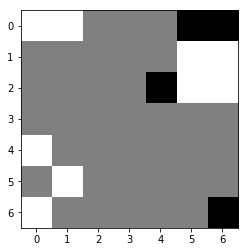

((2, 4), (3, 5)): n_v:  2706 q_all:-0.074726 q:-0.050610 q_m:-0.000000 p:0.696582
((0, 5), (1, 4)): n_v:   750 q_all:-0.061236 q:-0.035443 q_m:-0.000000 p:0.160421
((0, 6), (1, 4)): n_v:    20 q_all:-0.074333 q:-0.064228 q_m:-0.033333 p:0.005174
((6, 6), (5, 5)): n_v:     5 q_all:-0.121796 q:-0.117490 q_m:-0.133333 p:0.002276
((0, 5), (0, 4)): n_v:     5 q_all:-0.164184 q:-0.093999 q_m:-0.066667 p:0.003071
((2, 4), (1, 2)): n_v:     4 q_all:-0.132524 q:-0.135351 q_m:-0.100000 p:0.002156
((6, 6), (5, 6)): n_v:     3 q_all:-0.141333 q:-0.147592 q_m:-0.133333 p:0.001524
((2, 4), (3, 4)): n_v:     2 q_all:-0.089349 q:-0.070452 q_m:-0.066667 p:0.000759
((2, 4), (2, 3)): n_v:     1 q_all:-0.167564 q:-0.097022 q_m:-0.133333 p:0.000752
((2, 4), (1, 3)): n_v:     1 q_all:-0.172802 q:-0.116169 q_m:-0.133333 p:0.001117
((2, 4), (3, 6)): n_v:     1 q_all:-0.080841 q:-0.071387 q_m:-0.033333 p:0.000260
((6, 6), (6, 5)): n_v:     1 q_all:-0.150437 q:-0.127521 q_m:-0.133333 p:0.000958
((2, 4), (3, 3))

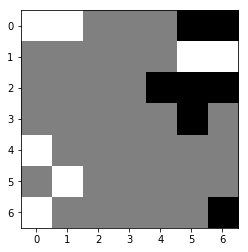

((1, 5), (1, 4)): n_v:  2430 q_all:+0.087235 q:+0.075748 q_m:+0.233333 p:0.570289
((1, 6), (3, 4)): n_v:   821 q_all:+0.078071 q:+0.037728 q_m:+0.200000 p:0.214812
((1, 6), (3, 6)): n_v:   128 q_all:+0.062957 q:+0.052888 q_m:+0.200000 p:0.039571
((0, 1), (1, 2)): n_v:   123 q_all:+0.033298 q:-0.016611 q_m:+0.033333 p:0.049089
((1, 5), (3, 6)): n_v:    72 q_all:+0.060709 q:+0.041639 q_m:+0.200000 p:0.022890
((1, 5), (3, 4)): n_v:    59 q_all:+0.054257 q:+0.030650 q_m:+0.200000 p:0.019896
((4, 0), (3, 0)): n_v:    41 q_all:+0.027042 q:-0.010263 q_m:+0.033333 p:0.017363
((1, 6), (1, 4)): n_v:    34 q_all:+0.049548 q:+0.039535 q_m:+0.200000 p:0.011904
((1, 5), (0, 4)): n_v:    21 q_all:+0.003911 q:+0.031290 q_m:+0.100000 p:0.010642
((4, 0), (3, 2)): n_v:    17 q_all:+0.010380 q:-0.014798 q_m:-0.000000 p:0.007894
((5, 1), (3, 2)): n_v:    14 q_all:+0.013125 q:-0.018705 q_m:-0.000000 p:0.006625
((5, 1), (3, 0)): n_v:    12 q_all:+0.001267 q:-0.012324 q_m:-0.000000 p:0.006294
((0, 0), (1, 2))

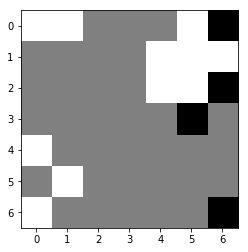

((3, 5), (3, 4)): n_v:  1805 q_all:-0.080786 q:-0.099304 q_m:-0.066667 p:0.428673
((2, 6), (0, 4)): n_v:  1207 q_all:-0.078309 q:-0.095201 q_m:-0.033333 p:0.277649
((3, 5), (5, 6)): n_v:   250 q_all:-0.146558 q:-0.158496 q_m:-0.233333 p:0.110412
((3, 5), (2, 3)): n_v:   117 q_all:-0.092601 q:-0.099171 q_m:-0.100000 p:0.032192
((2, 6), (3, 6)): n_v:    97 q_all:-0.123998 q:-0.151425 q_m:-0.133333 p:0.036245
((3, 5), (1, 3)): n_v:    85 q_all:-0.099831 q:-0.104870 q_m:-0.100000 p:0.025459
((0, 6), (0, 4)): n_v:    73 q_all:-0.097284 q:-0.114574 q_m:-0.033333 p:0.021274
((2, 6), (3, 4)): n_v:    30 q_all:-0.088613 q:-0.104214 q_m:-0.100000 p:0.008094
((3, 5), (5, 5)): n_v:    13 q_all:-0.138625 q:-0.135441 q_m:-0.233333 p:0.005546
((6, 6), (5, 5)): n_v:    10 q_all:-0.149133 q:-0.137008 q_m:-0.200000 p:0.004909
((3, 5), (5, 3)): n_v:    10 q_all:-0.145104 q:-0.141114 q_m:-0.233333 p:0.004749
((3, 5), (4, 4)): n_v:     6 q_all:-0.133513 q:-0.128157 q_m:-0.200000 p:0.002765
((3, 5), (4, 6))

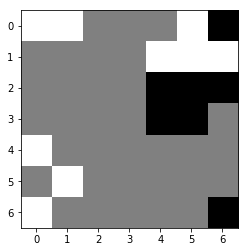

((1, 4), (2, 3)): n_v:  2556 q_all:+0.080772 q:+0.078896 q_m:+0.233333 p:0.784505
((4, 0), (3, 0)): n_v:   135 q_all:+0.057247 q:+0.054975 q_m:+0.100000 p:0.052440
((0, 5), (2, 3)): n_v:    55 q_all:+0.064384 q:+0.061711 q_m:+0.200000 p:0.020029
((1, 6), (3, 6)): n_v:    53 q_all:+0.056333 q:+0.086909 q_m:+0.266667 p:0.020509
((4, 0), (3, 1)): n_v:    28 q_all:+0.065890 q:+0.033915 q_m:+0.100000 p:0.010379
((1, 4), (3, 6)): n_v:    21 q_all:+0.080862 q:+0.100734 q_m:+0.266667 p:0.006568
((0, 1), (1, 2)): n_v:    18 q_all:+0.053055 q:+0.068315 q_m:+0.100000 p:0.007634
((1, 5), (3, 6)): n_v:    16 q_all:-0.003860 q:+0.083503 q_m:+0.266667 p:0.009737
((1, 4), (1, 3)): n_v:    13 q_all:+0.043677 q:+0.053211 q_m:+0.166667 p:0.005944
((0, 5), (0, 4)): n_v:    12 q_all:+0.059375 q:+0.071373 q_m:+0.100000 p:0.004787
((0, 0), (1, 0)): n_v:    10 q_all:+0.052764 q:+0.062577 q_m:+0.100000 p:0.004254
((0, 0), (1, 1)): n_v:     9 q_all:+0.043290 q:+0.070596 q_m:+0.100000 p:0.003854
((5, 1), (3, 0))

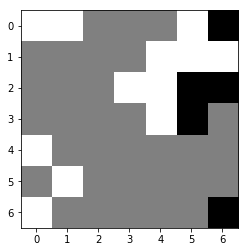

((3, 5), (3, 3)): n_v:  2204 q_all:-0.042730 q:-0.057561 q_m:-0.033333 p:0.364816
((3, 5), (1, 3)): n_v:   911 q_all:-0.078374 q:-0.069965 q_m:-0.033333 p:0.249895
((2, 5), (3, 3)): n_v:   243 q_all:-0.115974 q:-0.084810 q_m:-0.033333 p:0.094624
((2, 5), (1, 3)): n_v:   160 q_all:-0.138074 q:-0.113266 q_m:-0.033333 p:0.073171
((2, 6), (0, 4)): n_v:    86 q_all:-0.105657 q:-0.140272 q_m:-0.033333 p:0.031006
((3, 5), (5, 3)): n_v:    70 q_all:-0.189118 q:-0.161809 q_m:-0.233333 p:0.043332
((3, 5), (4, 4)): n_v:    53 q_all:-0.103874 q:-0.117456 q_m:-0.133333 p:0.018663
((2, 5), (0, 4)): n_v:    30 q_all:-0.133931 q:-0.121152 q_m:-0.033333 p:0.013582
((3, 5), (5, 6)): n_v:    27 q_all:-0.203743 q:-0.175212 q_m:-0.233333 p:0.017979
((6, 6), (5, 5)): n_v:    24 q_all:-0.186503 q:-0.159964 q_m:-0.200000 p:0.014766
((3, 5), (4, 5)): n_v:    18 q_all:-0.160372 q:-0.146673 q_m:-0.133333 p:0.009937
((0, 6), (0, 4)): n_v:    15 q_all:-0.088090 q:-0.136510 q_m:-0.033333 p:0.004807
((6, 6), (6, 5))

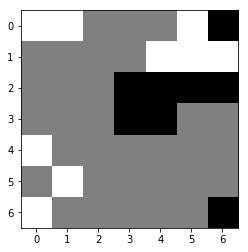

((1, 4), (1, 3)): n_v:  1529 q_all:+0.067811 q:+0.074942 q_m:+0.200000 p:0.342668
((4, 0), (3, 1)): n_v:   907 q_all:+0.012449 q:+0.020435 q_m:+0.066667 p:0.366629
((1, 6), (3, 5)): n_v:   619 q_all:+0.062897 q:+0.083172 q_m:+0.300000 p:0.148757
((0, 5), (1, 3)): n_v:   120 q_all:+0.042725 q:+0.050991 q_m:+0.166667 p:0.036811
((1, 4), (3, 5)): n_v:    98 q_all:+0.089435 q:+0.109679 q_m:+0.300000 p:0.015089
((0, 1), (1, 3)): n_v:    46 q_all:+0.035983 q:+0.066532 q_m:+0.166667 p:0.015351
((0, 0), (1, 1)): n_v:    19 q_all:-0.000467 q:+0.044117 q_m:+0.066667 p:0.008488
((5, 1), (4, 2)): n_v:    18 q_all:+0.043354 q:+0.051381 q_m:+0.133333 p:0.005679
((1, 5), (3, 5)): n_v:    18 q_all:+0.017897 q:+0.079290 q_m:+0.300000 p:0.006965
((5, 1), (3, 1)): n_v:    18 q_all:-0.006370 q:+0.011523 q_m:+0.033333 p:0.008712
((5, 1), (3, 2)): n_v:    14 q_all:+0.069851 q:+0.071493 q_m:+0.166667 p:0.003108
((4, 0), (3, 0)): n_v:    13 q_all:-0.022739 q:+0.018719 q_m:+0.066667 p:0.006959
((4, 0), (2, 2))

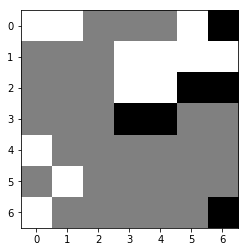

((2, 5), (0, 4)): n_v:  1209 q_all:-0.065293 q:-0.034578 q_m:+0.066667 p:0.447150
((2, 6), (0, 4)): n_v:  1034 q_all:-0.014153 q:-0.015841 q_m:+0.066667 p:0.193018
((3, 3), (1, 1)): n_v:   152 q_all:-0.056387 q:-0.071636 q_m:-0.066667 p:0.051304
((2, 5), (3, 5)): n_v:    92 q_all:-0.073138 q:-0.100680 q_m:-0.100000 p:0.036904
((3, 4), (5, 6)): n_v:    60 q_all:-0.119738 q:-0.103378 q_m:-0.200000 p:0.034113
((3, 4), (1, 2)): n_v:    55 q_all:-0.043810 q:-0.053326 q_m:-0.000000 p:0.016193
((3, 3), (1, 2)): n_v:    52 q_all:-0.034574 q:-0.081526 q_m:-0.000000 p:0.013565
((3, 3), (5, 5)): n_v:    38 q_all:-0.175349 q:-0.134590 q_m:-0.200000 p:0.029365
((0, 6), (0, 4)): n_v:    37 q_all:-0.052824 q:-0.019648 q_m:+0.066667 p:0.012187
((3, 3), (2, 2)): n_v:    34 q_all:-0.080331 q:-0.092608 q_m:-0.033333 p:0.014127
((3, 4), (5, 5)): n_v:    33 q_all:-0.110073 q:-0.078768 q_m:-0.200000 p:0.017710
((3, 4), (5, 2)): n_v:     9 q_all:-0.062343 q:-0.065085 q_m:-0.133333 p:0.003360
((3, 3), (5, 2))

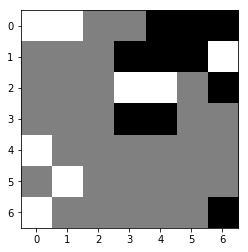

((1, 6), (2, 5)): n_v:  1564 q_all:+0.067776 q:+0.135671 q_m:+0.233333 p:0.370203
((2, 3), (0, 3)): n_v:   421 q_all:+0.058856 q:+0.001875 q_m:+0.133333 p:0.113934
((2, 4), (0, 3)): n_v:   355 q_all:+0.062623 q:+0.012184 q_m:+0.133333 p:0.091148
((0, 1), (0, 3)): n_v:   102 q_all:-0.041831 q:+0.004515 q_m:+0.133333 p:0.066130
((2, 3), (2, 5)): n_v:    72 q_all:+0.064277 q:+0.079215 q_m:+0.200000 p:0.018188
((2, 3), (4, 5)): n_v:    15 q_all:-0.003861 q:-0.007047 q_m:-0.000000 p:0.007889
((2, 3), (2, 1)): n_v:    10 q_all:-0.075622 q:-0.068374 q_m:-0.066667 p:0.008352
((4, 0), (2, 1)): n_v:     7 q_all:-0.086783 q:-0.071772 q_m:-0.066667 p:0.006298
((2, 4), (4, 5)): n_v:     5 q_all:+0.009769 q:+0.005403 q_m:-0.000000 p:0.002597
((4, 0), (4, 1)): n_v:     3 q_all:+0.029036 q:-0.066663 q_m:-0.033333 p:0.001296
((2, 4), (4, 3)): n_v:     2 q_all:+0.017382 q:-0.004229 q_m:+0.066667 p:0.000846
((0, 0), (2, 1)): n_v:     2 q_all:-0.114196 q:-0.083646 q_m:-0.066667 p:0.002738
((2, 4), (2, 2))

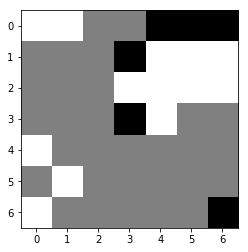

((1, 3), (3, 5)): n_v:  1159 q_all:-0.046102 q:-0.066900 q_m:+0.033333 p:0.344726
((3, 3), (3, 5)): n_v:  1037 q_all:-0.040611 q:-0.055247 q_m:+0.033333 p:0.288259
((1, 3), (3, 1)): n_v:   184 q_all:-0.088753 q:-0.167355 q_m:-0.166667 p:0.082497
((3, 3), (3, 1)): n_v:   154 q_all:-0.111232 q:-0.154647 q_m:-0.166667 p:0.081926
((3, 3), (1, 1)): n_v:   142 q_all:-0.085041 q:-0.077575 q_m:-0.100000 p:0.062244
((1, 3), (1, 1)): n_v:   116 q_all:-0.044717 q:-0.093134 q_m:-0.100000 p:0.034133
((3, 3), (5, 5)): n_v:    71 q_all:-0.177246 q:-0.164986 q_m:-0.233333 p:0.054382
((6, 6), (5, 5)): n_v:    10 q_all:-0.146495 q:-0.144383 q_m:-0.200000 p:0.006634
((0, 4), (0, 3)): n_v:    10 q_all:-0.101435 q:-0.135113 q_m:-0.133333 p:0.005021
((3, 3), (4, 4)): n_v:     7 q_all:-0.115913 q:-0.086848 q_m:-0.133333 p:0.003951
((1, 3), (2, 2)): n_v:     5 q_all:-0.140430 q:-0.146012 q_m:-0.133333 p:0.003348
((3, 3), (4, 3)): n_v:     5 q_all:-0.117456 q:-0.120691 q_m:-0.133333 p:0.003117
((3, 3), (1, 2))

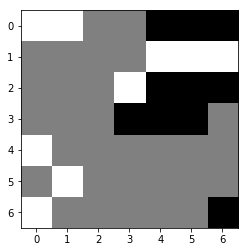

((1, 4), (1, 3)): n_v:  1993 q_all:+0.043344 q:+0.009453 q_m:+0.133333 p:0.419675
((1, 4), (3, 6)): n_v:   185 q_all:+0.084001 q:+0.014001 q_m:+0.166667 p:0.011075
((1, 6), (3, 6)): n_v:   132 q_all:+0.024168 q:+0.055166 q_m:+0.166667 p:0.037540
((4, 0), (3, 0)): n_v:    84 q_all:-0.033426 q:-0.029042 q_m:-0.000000 p:0.042202
((0, 1), (1, 3)): n_v:    70 q_all:+0.053270 q:+0.001759 q_m:+0.100000 p:0.012195
((2, 3), (1, 1)): n_v:    43 q_all:+0.009993 q:-0.029800 q_m:-0.033333 p:0.014676
((1, 5), (3, 6)): n_v:    23 q_all:-0.016044 q:-0.003541 q_m:+0.166667 p:0.010086
((2, 3), (2, 2)): n_v:    21 q_all:-0.019270 q:+0.005650 q_m:+0.066667 p:0.009561
((1, 4), (2, 2)): n_v:     6 q_all:-0.011984 q:-0.003501 q_m:+0.033333 p:0.002729
((2, 3), (3, 2)): n_v:     6 q_all:-0.013821 q:-0.023471 q_m:+0.066667 p:0.002936
((5, 1), (3, 0)): n_v:     5 q_all:-0.048360 q:-0.045711 q_m:-0.033333 p:0.003108
((1, 5), (1, 3)): n_v:     5 q_all:-0.082229 q:-0.092988 q_m:+0.100000 p:0.003944
((5, 1), (4, 2))

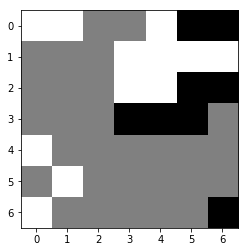

((3, 3), (1, 1)): n_v:  1010 q_all:-0.001785 q:-0.032035 q_m:-0.000000 p:0.134712
((3, 3), (1, 2)): n_v:   433 q_all:-0.008637 q:-0.066137 q_m:+0.066667 p:0.067577
((3, 3), (2, 2)): n_v:   374 q_all:-0.049582 q:-0.050249 q_m:+0.033333 p:0.109643
((3, 4), (1, 2)): n_v:   240 q_all:-0.039815 q:-0.072634 q_m:+0.066667 p:0.062733
((0, 5), (0, 3)): n_v:   143 q_all:-0.116953 q:-0.113923 q_m:+0.066667 p:0.074300
((3, 4), (5, 6)): n_v:   134 q_all:-0.140362 q:-0.128521 q_m:-0.133333 p:0.080059
((3, 3), (5, 5)): n_v:   129 q_all:-0.073590 q:-0.134092 q_m:-0.133333 p:0.048088
((3, 4), (5, 5)): n_v:   115 q_all:-0.133243 q:-0.118772 q_m:-0.133333 p:0.066286
((2, 5), (0, 3)): n_v:   106 q_all:-0.112597 q:-0.079458 q_m:+0.066667 p:0.053256
((3, 3), (4, 2)): n_v:    84 q_all:-0.023088 q:-0.057798 q_m:-0.033333 p:0.017295
((3, 3), (5, 2)): n_v:    72 q_all:-0.055844 q:-0.068671 q_m:-0.066667 p:0.022465
((3, 3), (4, 4)): n_v:    56 q_all:-0.090919 q:-0.092930 q_m:-0.100000 p:0.024489
((3, 3), (5, 4))

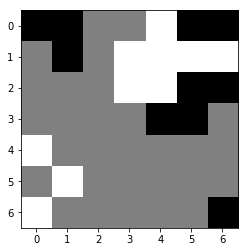

((1, 3), (0, 2)): n_v:   509 q_all:-0.000003 q:+0.003174 q_m:+0.166667 p:0.134278
((2, 3), (0, 2)): n_v:   447 q_all:+0.004903 q:+0.014419 q_m:+0.133333 p:0.109295
((1, 3), (1, 2)): n_v:   217 q_all:+0.011394 q:-0.022622 q_m:+0.166667 p:0.047675
((4, 0), (5, 0)): n_v:   170 q_all:-0.028318 q:-0.045173 q_m:+0.033333 p:0.063603
((4, 0), (3, 0)): n_v:   110 q_all:-0.033787 q:-0.027823 q_m:+0.033333 p:0.043640
((1, 4), (3, 6)): n_v:   110 q_all:-0.026279 q:-0.009888 q_m:+0.200000 p:0.040530
((1, 3), (2, 2)): n_v:   104 q_all:-0.044682 q:-0.033463 q_m:+0.100000 p:0.045741
((2, 3), (2, 1)): n_v:   100 q_all:-0.017229 q:-0.005584 q_m:+0.066667 p:0.033212
((2, 3), (3, 3)): n_v:    79 q_all:-0.009901 q:-0.017431 q_m:+0.100000 p:0.023717
((1, 3), (2, 1)): n_v:    75 q_all:-0.015792 q:-0.022016 q_m:+0.066667 p:0.024591
((4, 0), (3, 1)): n_v:    73 q_all:-0.038488 q:-0.057119 q_m:+0.033333 p:0.030027
((2, 4), (1, 2)): n_v:    62 q_all:+0.003897 q:-0.046809 q_m:+0.133333 p:0.015572
((1, 6), (3, 6))

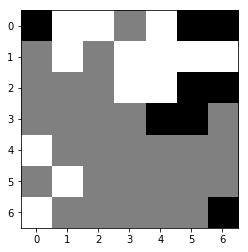

((3, 4), (1, 2)): n_v:   949 q_all:-0.039611 q:-0.019002 q_m:+0.166667 p:0.447477
((0, 0), (1, 2)): n_v:   910 q_all:-0.028234 q:-0.016738 q_m:+0.166667 p:0.385304
((3, 4), (3, 3)): n_v:   125 q_all:+0.001688 q:-0.063803 q_m:-0.000000 p:0.037504
((3, 4), (5, 2)): n_v:   107 q_all:-0.080536 q:-0.156481 q_m:-0.100000 p:0.069410
((2, 5), (0, 3)): n_v:    30 q_all:+0.001336 q:-0.093939 q_m:+0.100000 p:0.008894
((0, 0), (1, 0)): n_v:    28 q_all:-0.032572 q:-0.062997 q_m:-0.000000 p:0.012556
((0, 5), (0, 3)): n_v:    21 q_all:-0.037256 q:-0.130863 q_m:+0.100000 p:0.009799
((3, 4), (5, 6)): n_v:    10 q_all:-0.060278 q:-0.231099 q_m:-0.166667 p:0.005797
((3, 4), (3, 2)): n_v:     8 q_all:-0.131723 q:-0.138858 q_m:-0.100000 p:0.007457
((3, 4), (5, 5)): n_v:     2 q_all:-0.180737 q:-0.227840 q_m:-0.166667 p:0.002624
((3, 4), (2, 2)): n_v:     1 q_all:-0.129276 q:-0.111437 q_m:+0.033333 p:0.001300
((3, 5), (5, 6)): n_v:     1 q_all:-0.151540 q:-0.202041 q_m:-0.166667 p:0.001547
((0, 0), (2, 2))

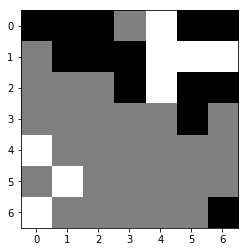

((0, 4), (0, 3)): n_v:  2160 q_all:+0.043440 q:+0.009121 q_m:+0.066667 p:0.430355
((0, 4), (2, 2)): n_v:   126 q_all:-0.019026 q:-0.035601 q_m:+0.100000 p:0.055364
((2, 4), (2, 2)): n_v:   106 q_all:-0.056964 q:-0.089068 q_m:+0.100000 p:0.062496
((1, 4), (2, 2)): n_v:    96 q_all:-0.071910 q:-0.100803 q_m:+0.100000 p:0.061597
((2, 4), (0, 3)): n_v:    79 q_all:-0.012245 q:-0.062003 q_m:+0.033333 p:0.032669
((2, 4), (3, 4)): n_v:    32 q_all:-0.056821 q:-0.069951 q_m:+0.066667 p:0.019033
((4, 0), (2, 2)): n_v:    26 q_all:-0.042358 q:-0.028947 q_m:+0.100000 p:0.014112
((1, 5), (0, 3)): n_v:     9 q_all:-0.132463 q:-0.117564 q_m:+0.033333 p:0.008135
((4, 0), (3, 0)): n_v:     6 q_all:-0.109969 q:-0.150114 q_m:-0.133333 p:0.005371
((5, 1), (3, 2)): n_v:     5 q_all:-0.097671 q:-0.135522 q_m:-0.100000 p:0.004288
((4, 0), (2, 0)): n_v:     3 q_all:-0.083529 q:-0.070988 q_m:-0.100000 p:0.001937
((2, 4), (4, 2)): n_v:     3 q_all:-0.155661 q:-0.213849 q_m:-0.166667 p:0.003462
((1, 5), (3, 4))

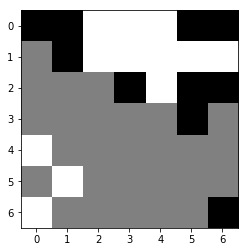

((1, 1), (2, 2)): n_v:  1744 q_all:-0.020809 q:-0.037700 q_m:+0.100000 p:0.208091
((2, 3), (2, 1)): n_v:  1130 q_all:-0.075814 q:-0.092518 q_m:-0.000000 p:0.337304
((2, 3), (4, 2)): n_v:    92 q_all:-0.059204 q:-0.057289 q_m:-0.000000 p:0.022558
((3, 5), (5, 5)): n_v:    82 q_all:-0.050640 q:-0.056088 q_m:-0.066667 p:0.017971
((3, 5), (4, 4)): n_v:    74 q_all:-0.099032 q:-0.089988 q_m:-0.033333 p:0.027940
((0, 0), (2, 2)): n_v:    64 q_all:-0.021026 q:-0.045630 q_m:+0.066667 p:0.007719
((3, 5), (5, 6)): n_v:    53 q_all:-0.072032 q:-0.090060 q_m:-0.066667 p:0.015355
((0, 1), (2, 2)): n_v:    50 q_all:-0.065706 q:-0.095880 q_m:+0.066667 p:0.013190
((2, 3), (4, 4)): n_v:    44 q_all:-0.124752 q:-0.109132 q_m:-0.066667 p:0.020603
((2, 3), (4, 1)): n_v:    44 q_all:-0.059106 q:-0.063954 q_m:+0.066667 p:0.010743
((1, 1), (2, 1)): n_v:    38 q_all:-0.114423 q:-0.083120 q_m:+0.033333 p:0.016445
((2, 3), (4, 5)): n_v:    34 q_all:-0.116637 q:-0.166605 q_m:-0.066667 p:0.014783
((2, 3), (3, 1))

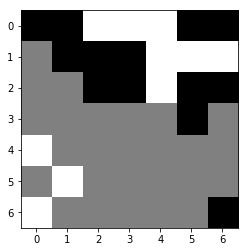

((0, 2), (1, 0)): n_v:  1115 q_all:+0.027503 q:+0.035725 q_m:+0.100000 p:0.278995
((2, 4), (3, 4)): n_v:   759 q_all:+0.009161 q:+0.001444 q_m:+0.133333 p:0.237054
((0, 2), (2, 1)): n_v:   350 q_all:+0.071213 q:+0.026426 q_m:+0.100000 p:0.036033
((2, 4), (3, 2)): n_v:   262 q_all:-0.026685 q:-0.064909 q_m:+0.033333 p:0.113963
((4, 0), (2, 1)): n_v:   162 q_all:+0.042231 q:+0.085178 q_m:+0.100000 p:0.032606
((5, 1), (3, 2)): n_v:    88 q_all:-0.035501 q:-0.008671 q_m:+0.033333 p:0.040742
((1, 6), (3, 4)): n_v:    81 q_all:+0.020356 q:-0.038328 q_m:+0.100000 p:0.022413
((5, 1), (3, 0)): n_v:    74 q_all:-0.009944 q:-0.041828 q_m:-0.100000 p:0.028178
((4, 0), (5, 0)): n_v:    73 q_all:+0.027911 q:-0.061404 q_m:-0.066667 p:0.018227
((2, 4), (3, 3)): n_v:    66 q_all:-0.022637 q:-0.039710 q_m:+0.066667 p:0.027939
((4, 0), (3, 0)): n_v:    62 q_all:+0.007408 q:-0.043244 q_m:-0.066667 p:0.019480
((0, 3), (2, 1)): n_v:    43 q_all:-0.029959 q:-0.002663 q_m:+0.100000 p:0.019547
((4, 0), (3, 2))

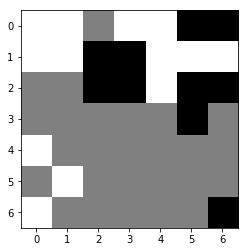

((1, 2), (0, 2)): n_v:  1642 q_all:-0.035597 q:-0.036560 q_m:+0.133333 p:0.342987
((2, 3), (0, 2)): n_v:   830 q_all:-0.037906 q:-0.068369 q_m:+0.100000 p:0.180772
((2, 2), (0, 2)): n_v:   162 q_all:-0.036371 q:-0.056980 q_m:+0.100000 p:0.034197
((2, 3), (2, 1)): n_v:     8 q_all:-0.086353 q:-0.179185 q_m:+0.033333 p:0.003147
((1, 2), (2, 1)): n_v:     2 q_all:-0.186040 q:-0.197046 q_m:+0.066667 p:0.001684
((1, 3), (3, 2)): n_v:     0 q_all:-0.237490 q:-0.237490 q_m:-0.100000 p:0.000002
((2, 3), (4, 2)): n_v:     0 q_all:-0.128698 q:-0.128698 q_m:-0.033333 p:0.000009
((6, 6), (6, 4)): n_v:     0 q_all:-0.210872 q:-0.210872 q_m:-0.100000 p:0.000088
((6, 6), (6, 5)): n_v:     0 q_all:-0.207719 q:-0.207719 q_m:-0.066667 p:0.000051
((2, 3), (3, 1)): n_v:     0 q_all:-0.169545 q:-0.169545 q_m:-0.033333 p:0.000005
((1, 3), (3, 1)): n_v:     0 q_all:-0.198923 q:-0.198923 q_m:-0.033333 p:0.000000
((3, 5), (4, 3)): n_v:     0 q_all:-0.154359 q:-0.154359 q_m:-0.100000 p:0.000001
((2, 3), (3, 4))

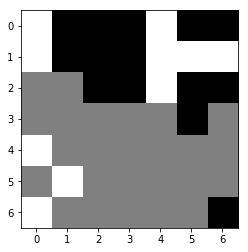

((1, 0), (2, 1)): n_v:  1579 q_all:+0.051807 q:+0.087524 q_m:+0.100000 p:0.300033
((2, 4), (3, 4)): n_v:   911 q_all:-0.009312 q:-0.021728 q_m:+0.100000 p:0.364379
((1, 6), (3, 4)): n_v:   103 q_all:-0.002627 q:-0.071056 q_m:+0.066667 p:0.038951
((0, 0), (2, 1)): n_v:    95 q_all:+0.033152 q:+0.046975 q_m:+0.066667 p:0.024252
((5, 1), (3, 2)): n_v:    88 q_all:-0.055907 q:-0.035309 q_m:-0.000000 p:0.049637
((4, 0), (2, 1)): n_v:    86 q_all:+0.068348 q:+0.076791 q_m:+0.066667 p:0.011258
((1, 0), (3, 2)): n_v:    85 q_all:-0.075439 q:-0.058965 q_m:-0.000000 p:0.053204
((4, 0), (4, 1)): n_v:    73 q_all:-0.002950 q:-0.117790 q_m:-0.100000 p:0.027918
((1, 0), (2, 0)): n_v:    46 q_all:-0.098034 q:-0.031806 q_m:-0.033333 p:0.032413
((5, 1), (3, 0)): n_v:    33 q_all:-0.048837 q:-0.088835 q_m:-0.133333 p:0.017777
((4, 0), (3, 2)): n_v:    23 q_all:-0.057457 q:-0.025393 q_m:-0.000000 p:0.013271
((2, 4), (3, 2)): n_v:    23 q_all:-0.060111 q:-0.091802 q_m:-0.000000 p:0.013349
((2, 4), (3, 3))

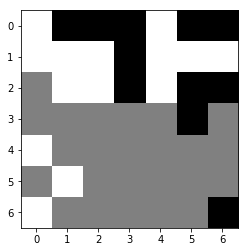

((2, 3), (3, 1)): n_v:  1522 q_all:-0.002042 q:-0.051484 q_m:+0.100000 p:0.160093
((0, 2), (2, 0)): n_v:   737 q_all:-0.150845 q:-0.108575 q_m:+0.100000 p:0.456715
((2, 3), (3, 3)): n_v:   164 q_all:-0.063594 q:-0.069644 q_m:+0.066667 p:0.052339
((0, 1), (2, 0)): n_v:   115 q_all:-0.129784 q:-0.084544 q_m:+0.100000 p:0.062659
((2, 3), (3, 2)): n_v:   112 q_all:-0.059815 q:-0.085382 q_m:+0.066667 p:0.034362
((2, 3), (4, 1)): n_v:   110 q_all:-0.019122 q:-0.045141 q_m:+0.033333 p:0.017868
((2, 5), (3, 3)): n_v:    67 q_all:-0.023571 q:-0.083831 q_m:+0.033333 p:0.012084
((2, 3), (3, 4)): n_v:    49 q_all:-0.111332 q:-0.092413 q_m:-0.000000 p:0.023881
((6, 6), (5, 5)): n_v:    40 q_all:-0.065770 q:-0.130738 q_m:-0.066667 p:0.013266
((6, 6), (4, 6)): n_v:    35 q_all:-0.102968 q:-0.170859 q_m:-0.100000 p:0.016276
((3, 5), (5, 6)): n_v:    32 q_all:-0.079810 q:-0.091229 q_m:-0.100000 p:0.012013
((3, 5), (5, 5)): n_v:    32 q_all:-0.050550 q:-0.056936 q_m:-0.100000 p:0.008963
((3, 5), (3, 3))

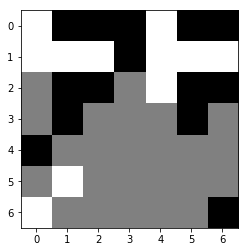

((5, 1), (3, 0)): n_v:  1269 q_all:-0.059563 q:-0.041437 q_m:+0.100000 p:0.470177
((1, 2), (3, 4)): n_v:   428 q_all:+0.045466 q:-0.053751 q_m:+0.033333 p:0.001238
((1, 6), (3, 6)): n_v:   412 q_all:-0.048625 q:-0.029112 q_m:+0.100000 p:0.137285
((1, 0), (3, 0)): n_v:   205 q_all:-0.038768 q:-0.082059 q_m:+0.100000 p:0.060742
((1, 4), (3, 6)): n_v:   183 q_all:-0.047350 q:-0.028910 q_m:+0.100000 p:0.060290
((1, 2), (3, 0)): n_v:   150 q_all:-0.057339 q:-0.083626 q_m:+0.100000 p:0.054497
((2, 4), (3, 6)): n_v:    98 q_all:-0.022042 q:-0.006554 q_m:+0.100000 p:0.023615
((1, 1), (3, 0)): n_v:    87 q_all:-0.105122 q:-0.143888 q_m:+0.100000 p:0.046110
((1, 2), (2, 3)): n_v:    79 q_all:+0.008952 q:-0.039337 q_m:+0.066667 p:0.010498
((2, 4), (3, 4)): n_v:    68 q_all:-0.060178 q:-0.082305 q_m:+0.066667 p:0.025637
((1, 5), (3, 6)): n_v:    51 q_all:-0.141589 q:-0.073980 q_m:+0.100000 p:0.033473
((2, 4), (3, 2)): n_v:    46 q_all:-0.025601 q:-0.082904 q_m:+0.100000 p:0.011663
((5, 1), (3, 2))

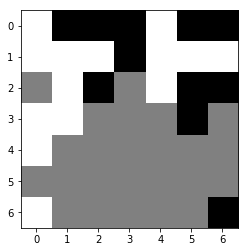

((2, 2), (2, 0)): n_v:  1494 q_all:+0.135514 q:+0.041160 q_m:+0.233333 p:0.065035
((1, 3), (2, 3)): n_v:   888 q_all:-0.008274 q:-0.033105 q_m:+0.133333 p:0.502669
((0, 2), (2, 0)): n_v:   256 q_all:-0.010964 q:-0.021234 q_m:+0.233333 p:0.147797
((0, 1), (2, 0)): n_v:   103 q_all:+0.085809 q:+0.028046 q_m:+0.233333 p:0.022876
((3, 5), (2, 3)): n_v:    23 q_all:+0.010530 q:-0.005470 q_m:+0.100000 p:0.011682
((2, 2), (4, 1)): n_v:    13 q_all:-0.033148 q:-0.049821 q_m:+0.100000 p:0.008815
((2, 5), (2, 3)): n_v:     9 q_all:-0.082368 q:-0.095249 q_m:+0.100000 p:0.007424
((3, 5), (4, 6)): n_v:     8 q_all:-0.117212 q:-0.152359 q_m:-0.066667 p:0.007790
((0, 5), (2, 3)): n_v:     2 q_all:-0.069031 q:-0.128900 q_m:+0.100000 p:0.001815
((2, 2), (3, 2)): n_v:     2 q_all:-0.045963 q:-0.092466 q_m:+0.066667 p:0.001666
((6, 6), (4, 6)): n_v:     2 q_all:-0.131593 q:-0.177518 q_m:-0.100000 p:0.002354
((0, 2), (2, 3)): n_v:     1 q_all:-0.102200 q:-0.124425 q_m:+0.100000 p:0.001111
((3, 5), (4, 5))

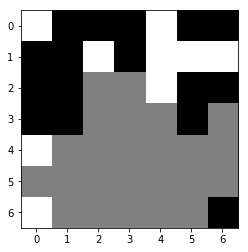

((1, 2), (2, 2)): n_v:  1022 q_all:-0.162432 q:-0.182642 q_m:+0.066667 p:0.389305
((4, 0), (2, 2)): n_v:   655 q_all:-0.164483 q:-0.169092 q_m:+0.033333 p:0.254046
((1, 2), (3, 2)): n_v:   498 q_all:-0.054384 q:-0.138800 q_m:-0.100000 p:0.001369
((2, 4), (2, 2)): n_v:   364 q_all:-0.138817 q:-0.221889 q_m:+0.033333 p:0.108437
((1, 4), (2, 2)): n_v:   234 q_all:-0.149787 q:-0.229277 q_m:+0.033333 p:0.078974
((2, 4), (3, 6)): n_v:    94 q_all:-0.122071 q:-0.132010 q_m:-0.033333 p:0.022287
((0, 0), (2, 2)): n_v:    90 q_all:-0.148408 q:-0.187983 q_m:+0.033333 p:0.029984
((1, 4), (3, 6)): n_v:    85 q_all:-0.168053 q:-0.160308 q_m:-0.033333 p:0.034319
((0, 4), (2, 2)): n_v:    68 q_all:-0.170326 q:-0.242451 q_m:+0.033333 p:0.027990
((1, 6), (3, 6)): n_v:    21 q_all:-0.142348 q:-0.171687 q_m:-0.033333 p:0.006222
((2, 4), (4, 2)): n_v:    18 q_all:-0.193412 q:-0.228240 q_m:-0.166667 p:0.008872
((2, 4), (4, 6)): n_v:    16 q_all:-0.231604 q:-0.241428 q_m:-0.166667 p:0.010341
((6, 0), (4, 2))

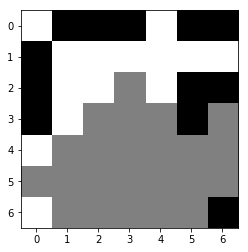

((3, 5), (2, 3)): n_v:  1478 q_all:+0.221043 q:+0.245620 q_m:+0.266667 p:0.187905
((0, 5), (2, 3)): n_v:   582 q_all:+0.123595 q:+0.104545 q_m:+0.266667 p:0.288971
((0, 3), (2, 3)): n_v:   298 q_all:+0.015791 q:+0.012684 q_m:+0.266667 p:0.270025
((2, 5), (2, 3)): n_v:   139 q_all:+0.116355 q:+0.150200 q_m:+0.266667 p:0.073146
((0, 1), (2, 3)): n_v:    84 q_all:+0.010027 q:+0.057686 q_m:+0.266667 p:0.078774
((0, 2), (2, 3)): n_v:    32 q_all:-0.018592 q:+0.069842 q_m:+0.266667 p:0.033993
((2, 5), (3, 4)): n_v:    17 q_all:+0.034497 q:-0.006267 q_m:+0.033333 p:0.014712
((2, 5), (4, 3)): n_v:    10 q_all:-0.020417 q:-0.010497 q_m:-0.066667 p:0.010285
((3, 5), (4, 3)): n_v:     6 q_all:+0.011416 q:+0.023976 q_m:-0.066667 p:0.005707
((3, 0), (4, 1)): n_v:     2 q_all:+0.053632 q:+0.041504 q_m:+0.100000 p:0.001644
((3, 0), (4, 2)): n_v:     0 q_all:-0.038428 q:-0.038428 q_m:-0.000000 p:0.000006
((3, 0), (3, 2)): n_v:     0 q_all:+0.004376 q:+0.004376 q_m:+0.133333 p:0.000330
((6, 6), (6, 4))

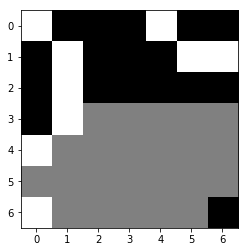

((3, 1), (3, 3)): n_v:  1911 q_all:-0.215018 q:-0.202957 q_m:-0.066667 p:0.497465
((2, 1), (3, 3)): n_v:   500 q_all:-0.202536 q:-0.189717 q_m:-0.066667 p:0.108286
((1, 6), (3, 4)): n_v:   176 q_all:-0.275791 q:-0.255565 q_m:-0.066667 p:0.083677
((1, 6), (3, 5)): n_v:   131 q_all:-0.267364 q:-0.259765 q_m:-0.066667 p:0.057867
((2, 1), (3, 2)): n_v:   131 q_all:-0.266337 q:-0.195627 q_m:-0.100000 p:0.058155
((1, 1), (3, 3)): n_v:    91 q_all:-0.230496 q:-0.252333 q_m:-0.066667 p:0.028925
((1, 5), (3, 3)): n_v:    56 q_all:-0.225332 q:-0.258888 q_m:-0.066667 p:0.016863
((4, 0), (3, 2)): n_v:    38 q_all:-0.275272 q:-0.187617 q_m:-0.133333 p:0.017861
((3, 1), (5, 0)): n_v:    10 q_all:-0.316386 q:-0.323675 q_m:-0.266667 p:0.006649
((1, 5), (3, 4)): n_v:    10 q_all:-0.339769 q:-0.262377 q_m:-0.066667 p:0.007390
((3, 1), (5, 3)): n_v:     9 q_all:-0.290985 q:-0.287188 q_m:-0.266667 p:0.005130
((1, 1), (3, 2)): n_v:     8 q_all:-0.327946 q:-0.269384 q_m:-0.133333 p:0.005300
((3, 1), (4, 3))

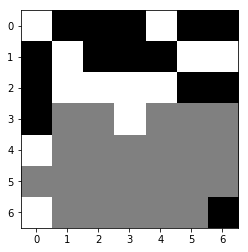

((2, 5), (3, 4)): n_v:  2751 q_all:+0.207249 q:+0.210247 q_m:+0.300000 p:0.838457
((2, 0), (3, 1)): n_v:   562 q_all:+0.288756 q:+0.232861 q_m:+0.300000 p:0.019917
((2, 0), (3, 2)): n_v:   121 q_all:+0.221499 q:+0.171336 q_m:+0.333333 p:0.031189
((3, 0), (3, 2)): n_v:   102 q_all:+0.157766 q:+0.184455 q_m:+0.333333 p:0.047663
((2, 6), (3, 4)): n_v:    17 q_all:+0.167174 q:+0.151321 q_m:+0.266667 p:0.007768
((1, 0), (3, 2)): n_v:    16 q_all:+0.105199 q:+0.109713 q_m:+0.333333 p:0.009803
((2, 5), (3, 5)): n_v:    14 q_all:+0.106617 q:+0.040818 q_m:+0.166667 p:0.009312
((3, 0), (5, 1)): n_v:     1 q_all:+0.200160 q:+0.169958 q_m:+0.200000 p:0.000496
((3, 0), (4, 2)): n_v:     0 q_all:+0.126970 q:+0.126970 q_m:+0.133333 p:0.000017
((1, 3), (3, 2)): n_v:     0 q_all:+0.043841 q:+0.043841 q_m:+0.333333 p:0.000454
((2, 5), (4, 3)): n_v:     0 q_all:+0.071358 q:+0.071358 q_m:+0.133333 p:0.000004
((3, 0), (5, 2)): n_v:     0 q_all:+0.094620 q:+0.094620 q_m:+0.066667 p:0.000105
((6, 6), (6, 4))

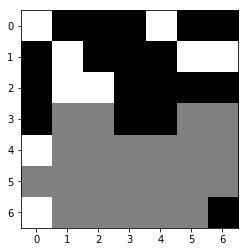

((1, 6), (3, 5)): n_v:  3067 q_all:-0.236126 q:-0.222312 q_m:-0.033333 p:0.463943
((2, 1), (3, 1)): n_v:   635 q_all:-0.248712 q:-0.225880 q_m:-0.133333 p:0.119867
((1, 5), (3, 5)): n_v:    81 q_all:-0.318168 q:-0.253854 q_m:-0.033333 p:0.031805
((2, 1), (3, 2)): n_v:    55 q_all:-0.250586 q:-0.194452 q_m:-0.133333 p:0.010590
((1, 1), (3, 1)): n_v:    27 q_all:-0.284579 q:-0.349851 q_m:-0.166667 p:0.007911
((4, 0), (3, 2)): n_v:     4 q_all:-0.264340 q:-0.204722 q_m:-0.166667 p:0.001041
((2, 1), (4, 3)): n_v:     1 q_all:-0.227187 q:-0.222418 q_m:-0.166667 p:0.000124
((4, 0), (4, 1)): n_v:     0 q_all:-0.329845 q:-0.329845 q_m:-0.200000 p:0.000047
((4, 0), (6, 2)): n_v:     0 q_all:-0.358796 q:-0.358796 q_m:-0.300000 p:0.000018
((4, 0), (4, 2)): n_v:     0 q_all:-0.372340 q:-0.372340 q_m:-0.233333 p:0.000006
((4, 0), (5, 2)): n_v:     0 q_all:-0.338616 q:-0.338616 q_m:-0.300000 p:0.000033
((4, 0), (5, 0)): n_v:     0 q_all:-0.383022 q:-0.383022 q_m:-0.266667 p:0.000144
((1, 5), (3, 6))

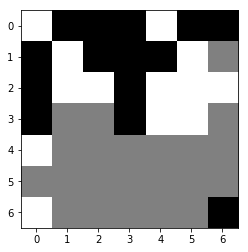

((0, 5), (1, 6)): n_v:  4045 q_all:+0.235622 q:+0.182195 q_m:+0.266667 p:0.431873
((6, 6), (5, 6)): n_v:    28 q_all:+0.006279 q:-0.013203 q_m:+0.066667 p:0.022188
((2, 0), (3, 1)): n_v:     5 q_all:+0.104132 q:+0.122228 q_m:+0.266667 p:0.002423
((6, 6), (5, 5)): n_v:     3 q_all:+0.027411 q:+0.014203 q_m:+0.066667 p:0.002447
((3, 3), (4, 4)): n_v:     1 q_all:+0.061910 q:+0.050347 q_m:+0.200000 p:0.000668
((3, 0), (5, 1)): n_v:     1 q_all:+0.090507 q:+0.084582 q_m:+0.166667 p:0.000907
((3, 0), (4, 2)): n_v:     0 q_all:-0.001228 q:-0.001228 q_m:+0.033333 p:0.000009
((1, 3), (3, 2)): n_v:     0 q_all:-0.108685 q:-0.108685 q_m:+0.166667 p:0.000004
((2, 3), (4, 2)): n_v:     0 q_all:-0.033785 q:-0.033785 q_m:+0.033333 p:0.000012
((3, 0), (3, 2)): n_v:     0 q_all:+0.031362 q:+0.031362 q_m:+0.166667 p:0.000009
((3, 0), (5, 0)): n_v:     0 q_all:+0.117278 q:+0.117278 q_m:+0.166667 p:0.000429
((2, 3), (3, 1)): n_v:     0 q_all:+0.024001 q:+0.024001 q_m:+0.233333 p:0.000038
((1, 0), (3, 2))

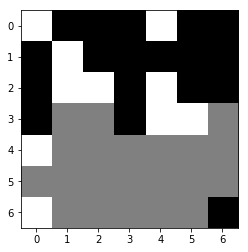

((3, 5), (3, 6)): n_v:  3388 q_all:-0.247367 q:-0.272438 q_m:-0.100000 p:0.343704
((3, 4), (3, 6)): n_v:   720 q_all:-0.286433 q:-0.307082 q_m:-0.133333 p:0.146879
((2, 1), (3, 1)): n_v:   282 q_all:-0.293611 q:-0.283891 q_m:-0.100000 p:0.062933
((2, 1), (3, 2)): n_v:    92 q_all:-0.337760 q:-0.304227 q_m:-0.100000 p:0.030692
((3, 4), (3, 2)): n_v:    83 q_all:-0.360502 q:-0.319920 q_m:-0.133333 p:0.033051
((4, 0), (3, 2)): n_v:    65 q_all:-0.315668 q:-0.303277 q_m:-0.133333 p:0.018244
((3, 4), (5, 6)): n_v:    61 q_all:-0.290310 q:-0.374606 q_m:-0.200000 p:0.013222
((2, 4), (3, 6)): n_v:    45 q_all:-0.320004 q:-0.335835 q_m:-0.133333 p:0.013285
((2, 4), (3, 2)): n_v:    25 q_all:-0.380017 q:-0.354097 q_m:-0.133333 p:0.011650
((3, 4), (5, 5)): n_v:    21 q_all:-0.280584 q:-0.330215 q_m:-0.200000 p:0.003885
((3, 5), (5, 6)): n_v:    18 q_all:-0.354239 q:-0.376654 q_m:-0.200000 p:0.007243
((4, 0), (5, 0)): n_v:     5 q_all:-0.402041 q:-0.432060 q_m:-0.233333 p:0.002904
((3, 5), (5, 5))

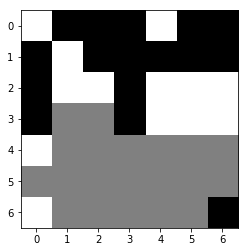

((2, 0), (3, 1)): n_v:  1485 q_all:+0.258774 q:+0.275198 q_m:+0.333333 p:0.158173
((6, 6), (4, 5)): n_v:   609 q_all:+0.258500 q:+0.199173 q_m:+0.300000 p:0.065505
((3, 3), (4, 5)): n_v:   577 q_all:+0.275092 q:+0.187963 q_m:+0.300000 p:0.035137
((3, 0), (5, 1)): n_v:   304 q_all:+0.279508 q:+0.180997 q_m:+0.233333 p:0.014747
((3, 0), (4, 1)): n_v:   249 q_all:+0.144102 q:+0.130458 q_m:+0.200000 p:0.106415
((3, 3), (5, 1)): n_v:   208 q_all:+0.246759 q:+0.179111 q_m:+0.233333 p:0.029212
((6, 6), (5, 5)): n_v:   204 q_all:+0.176413 q:+0.137501 q_m:+0.133333 p:0.068136
((2, 3), (3, 2)): n_v:   150 q_all:+0.120179 q:+0.156919 q_m:+0.266667 p:0.074351
((3, 3), (3, 1)): n_v:   145 q_all:+0.228134 q:+0.237818 q_m:+0.300000 p:0.027971
((3, 3), (4, 4)): n_v:    94 q_all:+0.245680 q:+0.188715 q_m:+0.266667 p:0.013345
((6, 6), (4, 6)): n_v:    89 q_all:+0.246633 q:+0.228179 q_m:+0.233333 p:0.012569
((3, 3), (5, 5)): n_v:    52 q_all:+0.158421 q:+0.140410 q_m:+0.100000 p:0.020196
((3, 3), (4, 1))

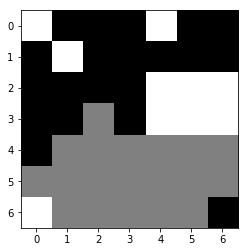

((3, 4), (3, 2)): n_v:  2417 q_all:-0.170698 q:-0.205394 q_m:-0.000000 p:0.758467
((2, 4), (3, 2)): n_v:   155 q_all:-0.355489 q:-0.271218 q_m:-0.000000 p:0.150080
((1, 1), (3, 2)): n_v:   114 q_all:-0.274367 q:-0.219860 q_m:-0.000000 p:0.077428
((6, 0), (4, 1)): n_v:     4 q_all:-0.322087 q:-0.344340 q_m:-0.133333 p:0.003572
((3, 4), (5, 2)): n_v:     1 q_all:-0.434951 q:-0.459097 q_m:-0.333333 p:0.001609
((6, 0), (5, 0)): n_v:     0 q_all:-0.453877 q:-0.453877 q_m:-0.233333 p:0.000521
((3, 5), (4, 6)): n_v:     0 q_all:-0.412111 q:-0.412111 q_m:-0.300000 p:0.000090
((6, 0), (5, 2)): n_v:     0 q_all:-0.451716 q:-0.451716 q_m:-0.333333 p:0.000068
((2, 4), (4, 5)): n_v:     0 q_all:-0.456642 q:-0.456642 q_m:-0.333333 p:0.000274
((2, 5), (4, 3)): n_v:     0 q_all:-0.492059 q:-0.492059 q_m:-0.266667 p:0.000003
((3, 4), (4, 3)): n_v:     0 q_all:-0.390088 q:-0.390088 q_m:-0.233333 p:0.000204
((2, 4), (4, 4)): n_v:     0 q_all:-0.453001 q:-0.453001 q_m:-0.266667 p:0.000011
((3, 5), (4, 3))

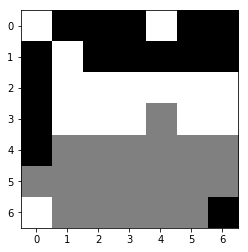

((1, 6), (3, 4)): n_v:  2674 q_all:+0.136285 q:+0.257570 q_m:+0.333333 p:0.793619
((6, 6), (4, 6)): n_v:   560 q_all:+0.231342 q:+0.206462 q_m:+0.133333 p:0.000966
((3, 0), (4, 1)): n_v:   381 q_all:+0.214143 q:+0.141744 q_m:+0.166667 p:0.021321
((1, 5), (3, 4)): n_v:   159 q_all:+0.031408 q:+0.183716 q_m:+0.333333 p:0.099289
((3, 0), (4, 2)): n_v:    84 q_all:+0.198693 q:+0.066826 q_m:+0.200000 p:0.008153
((6, 6), (4, 4)): n_v:    74 q_all:+0.124779 q:+0.199407 q_m:+0.133333 p:0.024760
((4, 0), (5, 0)): n_v:    30 q_all:+0.195137 q:+0.068810 q_m:+0.100000 p:0.003365
((6, 6), (4, 5)): n_v:    27 q_all:+0.180078 q:+0.162658 q_m:+0.133333 p:0.004432
((1, 2), (3, 4)): n_v:    21 q_all:+0.039150 q:+0.168942 q_m:+0.333333 p:0.012757
((1, 4), (3, 4)): n_v:     2 q_all:-0.025794 q:+0.123600 q_m:+0.333333 p:0.001531
((1, 3), (3, 4)): n_v:     2 q_all:+0.008193 q:+0.137140 q_m:+0.333333 p:0.001676
((2, 0), (4, 2)): n_v:     2 q_all:+0.076271 q:-0.002173 q_m:+0.200000 p:0.001185
((6, 6), (5, 4))

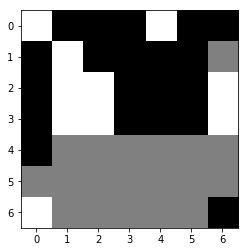

((2, 6), (1, 6)): n_v:  3867 q_all:-0.096074 q:-0.142550 q_m:-0.033333 p:0.966855
((0, 4), (1, 6)): n_v:    25 q_all:-0.233022 q:-0.208833 q_m:-0.066667 p:0.016644
((3, 6), (1, 6)): n_v:    22 q_all:-0.201238 q:-0.188415 q_m:-0.066667 p:0.012612
((3, 6), (5, 6)): n_v:     2 q_all:-0.403476 q:-0.407282 q_m:-0.266667 p:0.002639
((3, 6), (5, 4)): n_v:     0 q_all:-0.463251 q:-0.463251 q_m:-0.333333 p:0.000001
((3, 2), (5, 2)): n_v:     0 q_all:-0.466937 q:-0.466937 q_m:-0.333333 p:0.000000
((3, 2), (5, 3)): n_v:     0 q_all:-0.417871 q:-0.417871 q_m:-0.333333 p:0.000000
((3, 1), (4, 1)): n_v:     0 q_all:-0.387663 q:-0.387663 q_m:-0.166667 p:0.000022
((2, 2), (4, 3)): n_v:     0 q_all:-0.354340 q:-0.354340 q_m:-0.200000 p:0.000000
((3, 2), (5, 4)): n_v:     0 q_all:-0.454310 q:-0.454310 q_m:-0.333333 p:0.000000
((3, 2), (4, 4)): n_v:     0 q_all:-0.359340 q:-0.359340 q_m:-0.133333 p:0.000008
((3, 6), (5, 5)): n_v:     0 q_all:-0.366029 q:-0.366029 q_m:-0.266667 p:0.000046
((3, 1), (5, 3))

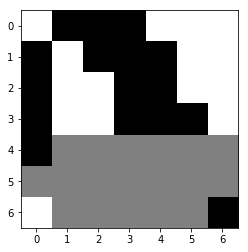

((3, 4), (4, 5)): n_v:  1062 q_all:+0.105743 q:+0.046383 q_m:+0.133333 p:0.048812
((3, 0), (4, 1)): n_v:   802 q_all:+0.079459 q:+0.083650 q_m:+0.200000 p:0.093555
((4, 0), (5, 0)): n_v:   765 q_all:+0.026908 q:+0.029877 q_m:+0.133333 p:0.196121
((3, 5), (4, 6)): n_v:   330 q_all:+0.035560 q:+0.070460 q_m:+0.133333 p:0.076835
((6, 6), (4, 5)): n_v:   129 q_all:+0.094250 q:+0.052918 q_m:+0.100000 p:0.009947
((4, 0), (6, 1)): n_v:   129 q_all:+0.093404 q:+0.012571 q_m:+0.100000 p:0.010185
((3, 3), (4, 4)): n_v:   128 q_all:-0.005179 q:-0.001231 q_m:+0.066667 p:0.044021
((3, 3), (4, 2)): n_v:   113 q_all:-0.045520 q:+0.008999 q_m:+0.200000 p:0.050796
((4, 0), (5, 1)): n_v:   108 q_all:+0.083895 q:+0.046908 q_m:+0.133333 p:0.011055
((3, 3), (4, 3)): n_v:    88 q_all:+0.013345 q:-0.024799 q_m:+0.133333 p:0.026011
((6, 6), (5, 6)): n_v:    80 q_all:-0.002247 q:-0.003966 q_m:+0.066667 p:0.026614
((3, 0), (5, 0)): n_v:    60 q_all:-0.014627 q:-0.029538 q_m:+0.100000 p:0.022330
((6, 6), (4, 6))

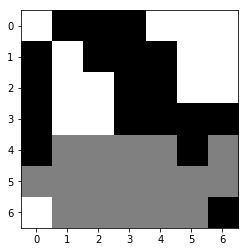

((3, 1), (4, 2)): n_v:  1581 q_all:-0.106968 q:-0.172496 q_m:-0.033333 p:0.326601
((3, 1), (4, 1)): n_v:   297 q_all:-0.065231 q:-0.063263 q_m:+0.033333 p:0.014133
((2, 6), (4, 4)): n_v:   269 q_all:-0.219075 q:-0.167236 q_m:+0.133333 p:0.168747
((3, 2), (4, 4)): n_v:   155 q_all:-0.110819 q:-0.110571 q_m:+0.133333 p:0.034397
((3, 2), (4, 3)): n_v:   121 q_all:-0.129768 q:-0.093639 q_m:+0.033333 p:0.035526
((6, 0), (4, 2)): n_v:   119 q_all:-0.113525 q:-0.204730 q_m:-0.066667 p:0.027654
((6, 0), (5, 1)): n_v:    60 q_all:-0.188649 q:-0.170357 q_m:-0.033333 p:0.031319
((2, 6), (4, 6)): n_v:    55 q_all:-0.087305 q:-0.143312 q_m:+0.066667 p:0.007344
((6, 0), (5, 0)): n_v:    36 q_all:-0.192641 q:-0.163471 q_m:-0.033333 p:0.018895
((2, 2), (4, 4)): n_v:    35 q_all:-0.147958 q:-0.116981 q_m:+0.133333 p:0.012668
((6, 0), (6, 1)): n_v:    12 q_all:-0.152543 q:-0.213468 q_m:-0.100000 p:0.004768
((6, 0), (4, 1)): n_v:     9 q_all:-0.098656 q:-0.064986 q_m:-0.000000 p:0.001710
((3, 2), (5, 1))

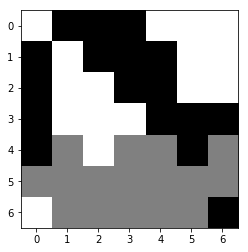

((3, 4), (4, 3)): n_v:  2110 q_all:+0.018435 q:+0.040782 q_m:+0.266667 p:0.927772
((3, 0), (4, 1)): n_v:   914 q_all:+0.139980 q:+0.157596 q_m:+0.266667 p:0.017317
((4, 5), (4, 3)): n_v:    20 q_all:-0.004056 q:+0.041482 q_m:+0.233333 p:0.010411
((3, 5), (4, 3)): n_v:    18 q_all:+0.031042 q:+0.019250 q_m:+0.233333 p:0.007135
((4, 0), (5, 1)): n_v:     4 q_all:+0.013465 q:+0.025595 q_m:+0.200000 p:0.001857
((3, 4), (4, 4)): n_v:     4 q_all:+0.077282 q:+0.052264 q_m:+0.133333 p:0.001116
((2, 0), (4, 1)): n_v:     3 q_all:-0.027503 q:+0.023933 q_m:+0.233333 p:0.001845
((2, 4), (4, 3)): n_v:     3 q_all:-0.089737 q:-0.045496 q_m:+0.233333 p:0.002692
((2, 3), (4, 1)): n_v:     1 q_all:-0.086638 q:-0.004474 q_m:+0.233333 p:0.001372
((2, 3), (4, 3)): n_v:     1 q_all:-0.103725 q:-0.059924 q_m:+0.233333 p:0.001569
((4, 0), (5, 0)): n_v:     1 q_all:-0.014990 q:+0.019106 q_m:+0.133333 p:0.000697
((4, 5), (5, 5)): n_v:     1 q_all:-0.025786 q:+0.001448 q_m:+0.066667 p:0.001127
((4, 0), (6, 1))

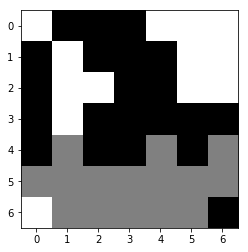

((6, 0), (4, 1)): n_v:  1826 q_all:-0.043375 q:-0.033749 q_m:-0.000000 p:0.443077
((3, 1), (4, 1)): n_v:  1698 q_all:-0.046293 q:-0.045201 q_m:+0.033333 p:0.428616
((2, 6), (4, 4)): n_v:   112 q_all:-0.184057 q:-0.283663 q_m:+0.066667 p:0.078305
((2, 2), (4, 4)): n_v:    46 q_all:-0.129814 q:-0.210926 q_m:+0.066667 p:0.024423
((2, 2), (4, 1)): n_v:    10 q_all:-0.199132 q:-0.148311 q_m:-0.000000 p:0.007198
((6, 0), (5, 1)): n_v:     5 q_all:-0.319399 q:-0.296956 q_m:-0.100000 p:0.006184
((2, 5), (4, 4)): n_v:     4 q_all:-0.285297 q:-0.311970 q_m:+0.066667 p:0.004756
((2, 1), (4, 1)): n_v:     3 q_all:-0.263775 q:-0.168142 q_m:-0.000000 p:0.002652
((6, 0), (5, 0)): n_v:     1 q_all:-0.320598 q:-0.341776 q_m:-0.166667 p:0.001291
((3, 1), (5, 3)): n_v:     0 q_all:-0.266821 q:-0.266821 q_m:-0.133333 p:0.000164
((6, 0), (5, 2)): n_v:     0 q_all:-0.302088 q:-0.302088 q_m:-0.133333 p:0.000352
((6, 0), (6, 2)): n_v:     0 q_all:-0.391735 q:-0.391735 q_m:-0.266667 p:0.000148
((2, 5), (4, 6))

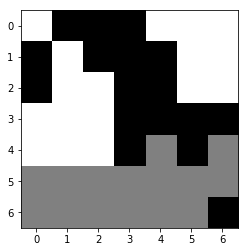

((4, 3), (5, 1)): n_v:  2571 q_all:+0.121409 q:+0.075868 q_m:+0.200000 p:0.198529
((4, 3), (5, 3)): n_v:   121 q_all:-0.062571 q:-0.080292 q_m:+0.100000 p:0.084139
((4, 3), (5, 5)): n_v:    81 q_all:-0.168344 q:-0.190303 q_m:-0.000000 p:0.085465
((4, 3), (5, 2)): n_v:    54 q_all:-0.043663 q:-0.038468 q_m:+0.166667 p:0.034436
((3, 3), (5, 1)): n_v:    50 q_all:-0.057757 q:-0.019448 q_m:+0.200000 p:0.033616
((3, 3), (4, 4)): n_v:    39 q_all:-0.083937 q:-0.119289 q_m:+0.033333 p:0.030315
((4, 5), (5, 5)): n_v:    33 q_all:-0.186908 q:-0.167700 q_m:+0.033333 p:0.037089
((4, 3), (5, 4)): n_v:    32 q_all:-0.164598 q:-0.128981 q_m:+0.033333 p:0.033372
((6, 6), (6, 5)): n_v:    26 q_all:-0.159823 q:-0.126437 q_m:+0.033333 p:0.026220
((4, 3), (6, 4)): n_v:    24 q_all:-0.141736 q:-0.179629 q_m:-0.000000 p:0.023765
((3, 6), (5, 5)): n_v:    21 q_all:-0.238552 q:-0.182984 q_m:-0.000000 p:0.027036
((4, 3), (6, 2)): n_v:    19 q_all:-0.105936 q:-0.127213 q_m:-0.000000 p:0.015409
((4, 3), (6, 5))

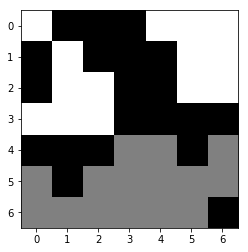

((3, 2), (4, 3)): n_v:  1804 q_all:-0.117409 q:-0.061489 q_m:+0.033333 p:0.189827
((3, 0), (5, 0)): n_v:  1301 q_all:-0.184810 q:-0.112990 q_m:-0.000000 p:0.403459
((3, 2), (5, 0)): n_v:   463 q_all:-0.236898 q:-0.207525 q_m:-0.000000 p:0.217182
((3, 2), (4, 4)): n_v:   152 q_all:-0.195251 q:-0.257791 q_m:+0.066667 p:0.052308
((3, 0), (5, 2)): n_v:   109 q_all:-0.151194 q:-0.187793 q_m:-0.000000 p:0.022764
((2, 6), (4, 4)): n_v:    53 q_all:-0.251437 q:-0.232139 q_m:+0.066667 p:0.026814
((3, 1), (5, 0)): n_v:    46 q_all:-0.341494 q:-0.242756 q_m:-0.000000 p:0.036640
((3, 2), (5, 4)): n_v:    30 q_all:-0.260323 q:-0.256146 q_m:-0.133333 p:0.016251
((2, 2), (4, 4)): n_v:    29 q_all:-0.226239 q:-0.203435 q_m:+0.066667 p:0.012650
((3, 2), (5, 2)): n_v:    15 q_all:-0.247938 q:-0.201251 q_m:-0.000000 p:0.007580
((2, 6), (4, 6)): n_v:     8 q_all:-0.177126 q:-0.183983 q_m:-0.000000 p:0.002548
((3, 1), (4, 3)): n_v:     6 q_all:-0.318500 q:-0.226472 q_m:-0.000000 p:0.004099
((3, 2), (5, 3))

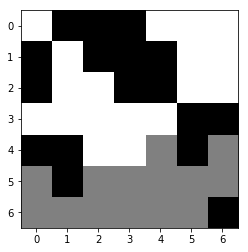

((3, 5), (4, 4)): n_v:  3084 q_all:+0.117785 q:+0.081315 q_m:+0.200000 p:0.427005
((3, 6), (4, 4)): n_v:   120 q_all:+0.100552 q:+0.068295 q_m:+0.166667 p:0.023651
((6, 6), (4, 4)): n_v:   118 q_all:+0.093627 q:+0.071745 q_m:+0.166667 p:0.026037
((4, 1), (5, 2)): n_v:    33 q_all:+0.058345 q:+0.066377 q_m:+0.133333 p:0.011387
((4, 5), (5, 4)): n_v:    13 q_all:-0.048835 q:-0.048841 q_m:+0.066667 p:0.009726
((5, 1), (6, 2)): n_v:     5 q_all:-0.021881 q:-0.046407 q_m:-0.000000 p:0.003232
((2, 3), (4, 4)): n_v:     1 q_all:-0.192487 q:-0.047669 q_m:+0.166667 p:0.001477
((4, 0), (5, 2)): n_v:     0 q_all:-0.013955 q:-0.013955 q_m:+0.100000 p:0.000389
((5, 1), (6, 1)): n_v:     0 q_all:-0.054140 q:-0.054140 q_m:-0.000000 p:0.000306
((3, 6), (5, 4)): n_v:     0 q_all:-0.029752 q:-0.029752 q_m:+0.033333 p:0.000193
((5, 1), (5, 3)): n_v:     0 q_all:-0.007245 q:-0.007245 q_m:+0.100000 p:0.000072
((4, 1), (6, 1)): n_v:     0 q_all:-0.064796 q:-0.064796 q_m:-0.033333 p:0.000047
((3, 5), (4, 6))

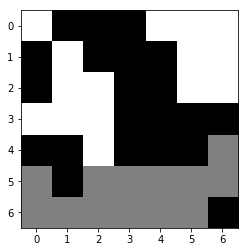

((4, 2), (5, 2)): n_v:  1800 q_all:-0.149369 q:-0.134977 q_m:+0.033333 p:0.369763
((4, 2), (5, 4)): n_v:  1034 q_all:-0.142504 q:-0.166837 q_m:-0.000000 p:0.191951
((4, 2), (5, 3)): n_v:   649 q_all:-0.154833 q:-0.157389 q_m:-0.033333 p:0.143251
((3, 0), (5, 0)): n_v:   292 q_all:-0.204584 q:-0.169805 q_m:-0.000000 p:0.106433
((4, 2), (5, 0)): n_v:   196 q_all:-0.161284 q:-0.135064 q_m:-0.000000 p:0.047114
((3, 0), (5, 2)): n_v:   157 q_all:-0.167580 q:-0.228596 q_m:-0.000000 p:0.040419
((2, 6), (4, 6)): n_v:    36 q_all:-0.239258 q:-0.196569 q_m:-0.000000 p:0.016455
((3, 2), (5, 4)): n_v:    35 q_all:-0.288630 q:-0.265154 q_m:-0.000000 p:0.021610
((3, 2), (5, 0)): n_v:    34 q_all:-0.282142 q:-0.243790 q_m:-0.000000 p:0.020477
((4, 2), (6, 1)): n_v:    12 q_all:-0.255927 q:-0.261202 q_m:-0.133333 p:0.006587
((3, 2), (5, 2)): n_v:     9 q_all:-0.328658 q:-0.260893 q_m:-0.000000 p:0.006686
((3, 1), (5, 0)): n_v:     9 q_all:-0.396010 q:-0.311224 q_m:-0.000000 p:0.008822
((4, 2), (6, 3))

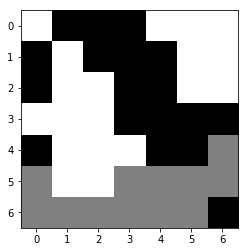

((4, 4), (5, 3)): n_v:  3084 q_all:+0.116004 q:+0.083537 q_m:+0.200000 p:0.935461
((4, 0), (5, 0)): n_v:    32 q_all:+0.070913 q:+0.040484 q_m:+0.133333 p:0.014984
((3, 5), (5, 3)): n_v:    13 q_all:-0.055593 q:+0.021385 q_m:+0.166667 p:0.011318
((4, 5), (5, 3)): n_v:    12 q_all:+0.036799 q:+0.044395 q_m:+0.166667 p:0.007352
((4, 0), (6, 1)): n_v:     7 q_all:+0.023650 q:-0.023396 q_m:+0.100000 p:0.004330
((4, 5), (5, 6)): n_v:     5 q_all:-0.105411 q:-0.144737 q_m:-0.000000 p:0.005762
((4, 4), (6, 2)): n_v:     4 q_all:-0.079284 q:-0.048517 q_m:+0.100000 p:0.004055
((3, 4), (5, 3)): n_v:     3 q_all:-0.186274 q:-0.077836 q_m:+0.166667 p:0.003638
((4, 0), (6, 2)): n_v:     3 q_all:-0.041637 q:-0.050033 q_m:+0.100000 p:0.003162
((6, 6), (6, 4)): n_v:     1 q_all:-0.047175 q:-0.097282 q_m:-0.033333 p:0.001147
((3, 3), (5, 3)): n_v:     1 q_all:-0.164026 q:-0.090318 q_m:+0.166667 p:0.002006
((6, 6), (6, 5)): n_v:     1 q_all:-0.168637 q:-0.094677 q_m:-0.000000 p:0.001240
((4, 4), (6, 3))

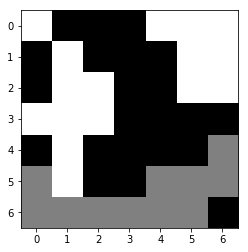

((5, 1), (6, 2)): n_v:  1709 q_all:-0.150294 q:-0.273617 q_m:-0.033333 p:0.267599
((5, 1), (6, 3)): n_v:  1076 q_all:-0.105969 q:-0.229100 q_m:-0.066667 p:0.031231
((5, 1), (6, 1)): n_v:   374 q_all:-0.270695 q:-0.339403 q_m:-0.100000 p:0.188442
((4, 1), (5, 0)): n_v:   290 q_all:-0.202219 q:-0.222117 q_m:-0.100000 p:0.088444
((2, 6), (4, 6)): n_v:   277 q_all:-0.227509 q:-0.245438 q_m:-0.000000 p:0.104654
((3, 2), (5, 4)): n_v:   109 q_all:-0.274477 q:-0.215352 q_m:+0.066667 p:0.056451
((5, 1), (6, 0)): n_v:    59 q_all:-0.321937 q:-0.347437 q_m:-0.166667 p:0.038820
((3, 0), (5, 0)): n_v:    38 q_all:-0.338731 q:-0.280499 q_m:-0.133333 p:0.027209
((4, 1), (6, 1)): n_v:    22 q_all:-0.433425 q:-0.402720 q_m:-0.133333 p:0.022243
((4, 1), (6, 2)): n_v:    17 q_all:-0.401360 q:-0.373307 q_m:-0.066667 p:0.015203
((4, 1), (6, 3)): n_v:    12 q_all:-0.393781 q:-0.360452 q_m:-0.066667 p:0.010934
((2, 5), (4, 6)): n_v:     8 q_all:-0.335293 q:-0.234306 q_m:-0.000000 p:0.005534
((3, 2), (5, 0))

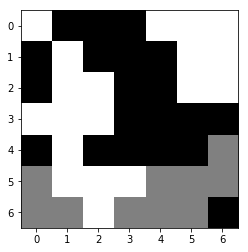

((4, 0), (6, 1)): n_v:  2137 q_all:+0.173669 q:+0.090877 q_m:+0.233333 p:0.499956
((4, 5), (6, 3)): n_v:   560 q_all:+0.217309 q:+0.054907 q_m:+0.233333 p:0.047505
((4, 4), (6, 3)): n_v:   254 q_all:+0.119674 q:+0.068800 q_m:+0.233333 p:0.105872
((4, 2), (6, 3)): n_v:   126 q_all:-0.005587 q:-0.083322 q_m:+0.233333 p:0.106615
((6, 6), (6, 5)): n_v:   108 q_all:-0.065045 q:-0.090186 q_m:+0.066667 p:0.112761
((4, 3), (6, 1)): n_v:    45 q_all:+0.048466 q:+0.070047 q_m:+0.233333 p:0.030028
((4, 3), (6, 5)): n_v:    21 q_all:-0.134860 q:-0.124322 q_m:+0.033333 p:0.027817
((4, 2), (6, 1)): n_v:    16 q_all:+0.040230 q:-0.055466 q_m:+0.233333 p:0.011644
((4, 0), (5, 0)): n_v:     8 q_all:+0.062989 q:+0.068196 q_m:+0.200000 p:0.005045
((4, 4), (6, 5)): n_v:     7 q_all:-0.141815 q:-0.104439 q_m:+0.033333 p:0.009755
((4, 3), (5, 4)): n_v:     6 q_all:+0.070654 q:+0.052221 q_m:+0.133333 p:0.003799
((4, 5), (6, 5)): n_v:     6 q_all:-0.070084 q:-0.074643 q_m:+0.033333 p:0.006654
((4, 3), (6, 3))

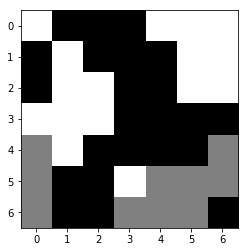

((5, 3), (5, 5)): n_v:  1436 q_all:-0.160760 q:-0.090697 q_m:-0.033333 p:0.153737
((3, 0), (5, 0)): n_v:   543 q_all:-0.207194 q:-0.267173 q_m:-0.100000 p:0.138555
((4, 1), (5, 0)): n_v:   449 q_all:-0.357172 q:-0.322459 q_m:-0.066667 p:0.330828
((5, 3), (5, 4)): n_v:   433 q_all:-0.202607 q:-0.223916 q_m:-0.000000 p:0.104484
((5, 3), (6, 3)): n_v:   306 q_all:-0.232266 q:-0.246877 q_m:-0.066667 p:0.102976
((3, 0), (4, 0)): n_v:    46 q_all:-0.302820 q:-0.323520 q_m:-0.133333 p:0.026050
((5, 3), (6, 5)): n_v:    40 q_all:-0.320671 q:-0.172396 q_m:-0.166667 p:0.025144
((3, 2), (5, 0)): n_v:    18 q_all:-0.381161 q:-0.367113 q_m:-0.100000 p:0.014988
((3, 1), (5, 0)): n_v:    16 q_all:-0.436359 q:-0.415073 q_m:-0.100000 p:0.015966
((4, 1), (6, 3)): n_v:    14 q_all:-0.352712 q:-0.320860 q_m:-0.100000 p:0.010093
((3, 2), (5, 4)): n_v:     7 q_all:-0.382260 q:-0.299207 q_m:-0.033333 p:0.005812
((4, 1), (6, 0)): n_v:     4 q_all:-0.325699 q:-0.317843 q_m:-0.100000 p:0.002788
((2, 6), (4, 6))

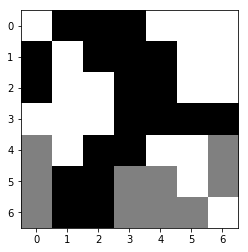

((5, 1), (4, 0)): n_v:  2344 q_all:+0.194760 q:+0.231438 q_m:+0.266667 p:0.355260
((3, 5), (4, 6)): n_v:   358 q_all:+0.092755 q:-0.011843 q_m:+0.200000 p:0.183298
((4, 3), (5, 4)): n_v:   172 q_all:+0.178718 q:+0.067299 q_m:+0.266667 p:0.035882
((6, 2), (4, 0)): n_v:   172 q_all:+0.183787 q:+0.142313 q_m:+0.233333 p:0.032866
((6, 1), (4, 0)): n_v:    81 q_all:+0.163027 q:+0.189176 q_m:+0.233333 p:0.021531
((6, 2), (5, 4)): n_v:    14 q_all:+0.144969 q:+0.017602 q_m:+0.233333 p:0.004770
((3, 6), (5, 4)): n_v:     9 q_all:+0.121258 q:+0.070343 q_m:+0.233333 p:0.003897
((5, 2), (4, 0)): n_v:     8 q_all:+0.046407 q:+0.158028 q_m:+0.233333 p:0.005404
((2, 0), (4, 0)): n_v:     4 q_all:-0.051771 q:-0.018885 q_m:+0.233333 p:0.005029
((3, 6), (5, 6)): n_v:     3 q_all:+0.070823 q:+0.022878 q_m:+0.233333 p:0.002009
((2, 4), (4, 6)): n_v:     2 q_all:-0.255103 q:-0.201903 q_m:+0.166667 p:0.004062
((5, 1), (5, 0)): n_v:     1 q_all:+0.006900 q:-0.002420 q_m:+0.133333 p:0.000965
((3, 4), (4, 6))

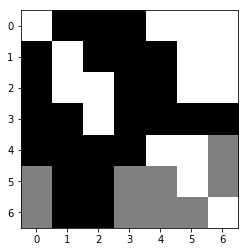

((4, 4), (5, 3)): n_v:  2631 q_all:-0.161253 q:-0.141713 q_m:+0.033333 p:0.580848
((3, 2), (5, 3)): n_v:   441 q_all:-0.319843 q:-0.266817 q_m:-0.000000 p:0.316387
((4, 5), (4, 6)): n_v:   440 q_all:-0.100057 q:-0.133468 q_m:-0.100000 p:0.011810
((4, 5), (5, 3)): n_v:   188 q_all:-0.140073 q:-0.169727 q_m:-0.000000 p:0.029055
((5, 5), (5, 3)): n_v:   120 q_all:-0.158133 q:-0.198178 q_m:-0.000000 p:0.025304
((3, 2), (5, 0)): n_v:    55 q_all:-0.187188 q:-0.154242 q_m:-0.000000 p:0.016874
((2, 6), (4, 6)): n_v:     4 q_all:-0.296422 q:-0.294458 q_m:-0.133333 p:0.002995
((4, 5), (5, 6)): n_v:     3 q_all:-0.403402 q:-0.365762 q_m:-0.233333 p:0.003132
((2, 5), (4, 6)): n_v:     1 q_all:-0.428836 q:-0.322507 q_m:-0.133333 p:0.001826
((4, 4), (4, 6)): n_v:     1 q_all:-0.210258 q:-0.288186 q_m:-0.133333 p:0.000720
((4, 4), (5, 6)): n_v:     1 q_all:-0.464344 q:-0.439047 q_m:-0.266667 p:0.001276
((6, 6), (4, 6)): n_v:     1 q_all:-0.246046 q:-0.174280 q_m:-0.133333 p:0.000937
((4, 4), (6, 3))

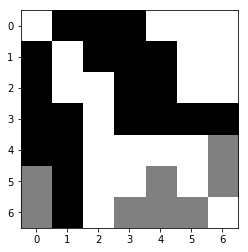

((3, 6), (5, 4)): n_v:  3224 q_all:+0.188457 q:+0.214265 q_m:+0.300000 p:0.639901
((3, 5), (5, 4)): n_v:   210 q_all:+0.178390 q:+0.202134 q_m:+0.300000 p:0.047895
((3, 3), (5, 4)): n_v:   159 q_all:+0.043995 q:+0.007496 q_m:+0.300000 p:0.101203
((6, 1), (6, 3)): n_v:   119 q_all:+0.192883 q:+0.156726 q_m:+0.166667 p:0.022072
((3, 6), (5, 6)): n_v:    37 q_all:+0.019284 q:+0.040699 q_m:+0.166667 p:0.026152
((5, 1), (6, 3)): n_v:    18 q_all:-0.029210 q:+0.031334 q_m:+0.166667 p:0.015276
((3, 4), (5, 4)): n_v:    17 q_all:-0.023359 q:+0.091513 q_m:+0.300000 p:0.014275
((3, 5), (4, 6)): n_v:    15 q_all:-0.012920 q:-0.010944 q_m:+0.133333 p:0.012477
((3, 0), (5, 0)): n_v:    14 q_all:-0.340724 q:-0.317096 q_m:-0.033333 p:0.025066
((4, 0), (5, 0)): n_v:    10 q_all:-0.058265 q:-0.068614 q_m:-0.000000 p:0.010046
((3, 5), (5, 6)): n_v:     3 q_all:+0.019094 q:-0.022005 q_m:+0.166667 p:0.002553
((4, 1), (6, 3)): n_v:     2 q_all:-0.046598 q:-0.088494 q_m:+0.166667 p:0.002120
((5, 1), (6, 0))

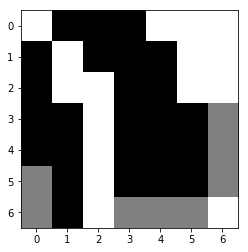

((6, 2), (5, 0)): n_v:  3235 q_all:-0.134047 q:-0.131692 q_m:-0.033333 p:0.502015
((6, 6), (5, 6)): n_v:   546 q_all:-0.238545 q:-0.145482 q_m:-0.133333 p:0.246793
((5, 2), (5, 0)): n_v:   239 q_all:-0.287742 q:-0.193514 q_m:-0.033333 p:0.140906
((4, 2), (5, 0)): n_v:    73 q_all:-0.213830 q:-0.193546 q_m:-0.033333 p:0.028036
((3, 2), (5, 0)): n_v:    69 q_all:-0.301378 q:-0.243010 q_m:-0.033333 p:0.043451
((6, 2), (6, 4)): n_v:    12 q_all:-0.297116 q:-0.248487 q_m:-0.100000 p:0.006973
((2, 6), (4, 6)): n_v:     8 q_all:-0.256160 q:-0.344564 q_m:-0.100000 p:0.004500
((4, 2), (6, 4)): n_v:     5 q_all:-0.299861 q:-0.274852 q_m:-0.100000 p:0.003738
((2, 5), (3, 6)): n_v:     4 q_all:-0.334349 q:-0.335530 q_m:-0.133333 p:0.003243
((5, 2), (6, 3)): n_v:     3 q_all:-0.333807 q:-0.295363 q_m:-0.133333 p:0.001684
((5, 2), (6, 4)): n_v:     3 q_all:-0.321865 q:-0.348375 q_m:-0.100000 p:0.002305
((6, 6), (6, 4)): n_v:     3 q_all:-0.431774 q:-0.352077 q_m:-0.100000 p:0.003283
((6, 6), (6, 5))

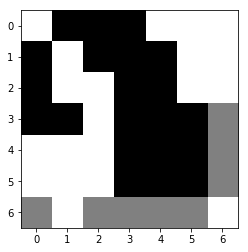

((5, 3), (6, 2)): n_v:  2737 q_all:+0.215862 q:+0.116508 q_m:+0.266667 p:0.066382
((3, 5), (3, 6)): n_v:  1572 q_all:+0.108271 q:+0.175710 q_m:+0.200000 p:0.517050
((5, 3), (6, 4)): n_v:    78 q_all:-0.081767 q:-0.046875 q_m:+0.066667 p:0.068234
((5, 5), (3, 6)): n_v:    77 q_all:+0.096223 q:+0.118813 q_m:+0.166667 p:0.028054
((5, 4), (3, 6)): n_v:    22 q_all:+0.027771 q:+0.079626 q_m:+0.166667 p:0.012787
((4, 4), (3, 6)): n_v:     6 q_all:-0.063408 q:+0.043247 q_m:+0.166667 p:0.005541
((5, 4), (6, 2)): n_v:     4 q_all:-0.011543 q:-0.002736 q_m:+0.233333 p:0.002938
((4, 3), (6, 4)): n_v:     3 q_all:-0.225527 q:-0.212837 q_m:+0.033333 p:0.004909
((2, 4), (3, 6)): n_v:     3 q_all:-0.213196 q:-0.143322 q_m:+0.166667 p:0.003397
((4, 3), (6, 2)): n_v:     3 q_all:-0.081845 q:-0.032575 q_m:+0.233333 p:0.002586
((1, 4), (3, 6)): n_v:     3 q_all:-0.115214 q:-0.093762 q_m:+0.166667 p:0.003810
((4, 4), (6, 2)): n_v:     2 q_all:-0.041923 q:-0.026350 q_m:+0.233333 p:0.001772
((5, 3), (6, 3))

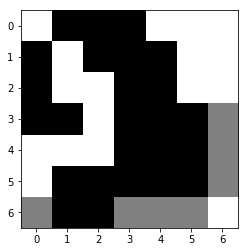

((5, 0), (6, 0)): n_v:  2713 q_all:-0.094486 q:-0.141868 q_m:-0.100000 p:0.297821
((2, 6), (4, 6)): n_v:   756 q_all:-0.191057 q:-0.295311 q_m:-0.066667 p:0.199829
((4, 2), (6, 4)): n_v:   169 q_all:-0.214414 q:-0.203414 q_m:-0.066667 p:0.059773
((4, 2), (6, 3)): n_v:   143 q_all:-0.226383 q:-0.185068 q_m:-0.000000 p:0.057063
((4, 0), (6, 0)): n_v:   134 q_all:-0.281220 q:-0.298313 q_m:-0.133333 p:0.082106
((4, 2), (6, 0)): n_v:   133 q_all:-0.275989 q:-0.265343 q_m:-0.133333 p:0.078475
((6, 6), (6, 4)): n_v:   107 q_all:-0.267126 q:-0.248101 q_m:-0.066667 p:0.059465
((4, 1), (6, 3)): n_v:    59 q_all:-0.314893 q:-0.234040 q_m:-0.000000 p:0.043413
((6, 6), (6, 5)): n_v:    57 q_all:-0.256828 q:-0.235229 q_m:-0.100000 p:0.029833
((6, 6), (5, 6)): n_v:    49 q_all:-0.173766 q:-0.095475 q_m:-0.100000 p:0.009824
((6, 6), (4, 6)): n_v:    43 q_all:-0.278476 q:-0.204106 q_m:-0.066667 p:0.025627
((2, 5), (4, 6)): n_v:    25 q_all:-0.337236 q:-0.325782 q_m:-0.066667 p:0.021383
((2, 5), (3, 6))

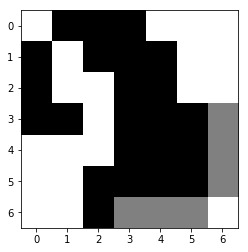

((3, 5), (3, 6)): n_v:  2679 q_all:+0.098183 q:+0.271894 q_m:+0.266667 p:0.525618
((5, 5), (3, 6)): n_v:   670 q_all:+0.132158 q:+0.214484 q_m:+0.233333 p:0.053193
((5, 4), (6, 5)): n_v:   601 q_all:+0.176407 q:+0.081973 q_m:+0.200000 p:0.002486
((5, 4), (3, 6)): n_v:    27 q_all:+0.017156 q:+0.127692 q_m:+0.233333 p:0.012403
((4, 4), (3, 6)): n_v:     6 q_all:-0.124366 q:+0.074763 q_m:+0.233333 p:0.006067
((1, 4), (3, 6)): n_v:     5 q_all:-0.143553 q:-0.115670 q_m:+0.233333 p:0.004753
((4, 5), (5, 6)): n_v:     4 q_all:+0.075620 q:+0.061600 q_m:+0.200000 p:0.000945
((2, 4), (3, 6)): n_v:     3 q_all:-0.195809 q:-0.105439 q_m:+0.233333 p:0.004180
((3, 5), (5, 6)): n_v:     2 q_all:-0.092329 q:-0.102653 q_m:+0.166667 p:0.001819
((5, 2), (6, 3)): n_v:     1 q_all:-0.115548 q:-0.029505 q_m:+0.133333 p:0.001442
((5, 4), (5, 6)): n_v:     1 q_all:-0.051800 q:-0.066304 q_m:+0.166667 p:0.000739
((3, 4), (3, 6)): n_v:     1 q_all:-0.228537 q:-0.147281 q_m:+0.233333 p:0.001752
((5, 3), (6, 4))

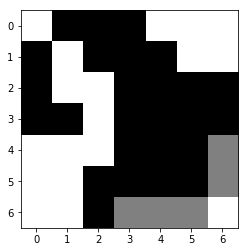

((6, 6), (4, 6)): n_v:  3888 q_all:-0.064443 q:+0.020273 q_m:-0.000000 p:0.919576
((6, 1), (6, 3)): n_v:    59 q_all:-0.119534 q:-0.025253 q_m:-0.000000 p:0.024034
((6, 6), (5, 6)): n_v:    21 q_all:-0.273043 q:-0.164845 q_m:-0.100000 p:0.018497
((4, 2), (6, 3)): n_v:    10 q_all:-0.383794 q:-0.205879 q_m:-0.000000 p:0.011802
((4, 1), (6, 3)): n_v:     7 q_all:-0.392613 q:-0.247002 q_m:-0.000000 p:0.009181
((5, 1), (6, 3)): n_v:     7 q_all:-0.405729 q:-0.304773 q_m:-0.000000 p:0.009666
((6, 6), (6, 5)): n_v:     4 q_all:-0.278397 q:-0.288575 q_m:-0.100000 p:0.003555
((6, 6), (6, 4)): n_v:     2 q_all:-0.218040 q:-0.135026 q_m:-0.066667 p:0.002060
((4, 2), (6, 4)): n_v:     1 q_all:-0.531166 q:-0.352384 q_m:-0.066667 p:0.001232
-1 's turn
one move takes time(s):  0.1794438362121582
train_mode is both train
no. of data collected:  8


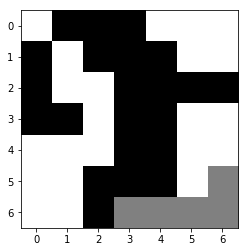

((5, 4), (5, 6)): n_v:  4429 q_all:-0.008531 q:+0.159131 q_m:+0.200000 p:0.799432
((5, 4), (6, 5)): n_v:    89 q_all:-0.370474 q:-0.372103 q_m:+0.100000 p:0.102782
((3, 4), (5, 6)): n_v:    31 q_all:-0.389622 q:-0.183997 q_m:+0.200000 p:0.036461
((4, 4), (5, 6)): n_v:    18 q_all:-0.210770 q:+0.037957 q_m:+0.200000 p:0.013043
((5, 3), (6, 4)): n_v:    12 q_all:-0.354447 q:-0.316087 q_m:+0.100000 p:0.013182
((6, 2), (6, 4)): n_v:     4 q_all:-0.217387 q:-0.132213 q_m:+0.066667 p:0.003660
((5, 3), (6, 5)): n_v:     3 q_all:-0.479216 q:-0.287071 q_m:+0.066667 p:0.004398
((5, 2), (6, 4)): n_v:     2 q_all:-0.405722 q:-0.406389 q_m:+0.066667 p:0.002956
((5, 4), (6, 6)): n_v:     1 q_all:-0.460524 q:-0.467996 q_m:+0.066667 p:0.002291
((5, 2), (6, 3)): n_v:     1 q_all:-0.539486 q:-0.421758 q_m:+0.033333 p:0.001369
((4, 4), (6, 3)): n_v:     0 q_all:-0.498705 q:-0.498705 q_m:-0.000000 p:0.000248
((4, 4), (6, 5)): n_v:     0 q_all:-0.493967 q:-0.493967 q_m:+0.066667 p:0.001040
((4, 3), (6, 3))

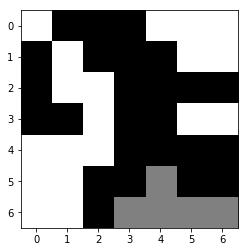

((3, 6), (5, 4)): n_v:  4633 q_all:+0.163043 q:-0.071602 q_m:+0.133333 p:0.639643
((3, 5), (5, 4)): n_v:   355 q_all:-0.032688 q:-0.032688 q_m:+0.133333 p:0.139897
((3, 2), (5, 4)): n_v:    95 q_all:-0.302488 q:-0.291024 q_m:+0.133333 p:0.126795
((4, 2), (5, 4)): n_v:    64 q_all:-0.312562 q:-0.299413 q_m:+0.133333 p:0.085970
((6, 1), (6, 3)): n_v:     2 q_all:-0.259450 q:-0.259450 q_m:-0.000000 p:0.002651
((4, 2), (6, 3)): n_v:     1 q_all:-0.382959 q:-0.382959 q_m:-0.000000 p:0.002035
((5, 1), (6, 3)): n_v:     1 q_all:-0.412694 q:-0.412694 q_m:-0.000000 p:0.002257
((4, 2), (6, 4)): n_v:     0 q_all:-0.517689 q:-0.517689 q_m:-0.066667 p:0.000257
((4, 1), (6, 3)): n_v:     0 q_all:-0.418448 q:-0.418448 q_m:-0.000000 p:0.000456
-1 's turn


This is a random move


one move takes time(s):  0.14733147621154785
train_mode is both train
no. of data collected:  8


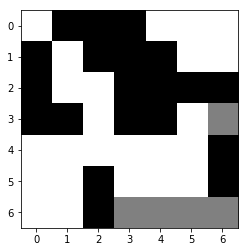

((2, 5), (3, 6)): n_v:  5092 q_all:-0.170702 q:-0.199576 q_m:+0.033333 p:0.286495
((5, 6), (3, 6)): n_v:    99 q_all:-0.280159 q:-0.280021 q_m:-0.000000 p:0.019729
((6, 2), (6, 4)): n_v:     8 q_all:-0.317710 q:-0.275615 q_m:+0.066667 p:0.002783
((5, 6), (6, 4)): n_v:     5 q_all:-0.359444 q:-0.290322 q_m:+0.066667 p:0.002016
((2, 4), (3, 6)): n_v:     4 q_all:-0.496976 q:-0.471387 q_m:-0.000000 p:0.003703
((1, 4), (3, 6)): n_v:     4 q_all:-0.539386 q:-0.571657 q_m:-0.000000 p:0.004148
((4, 6), (6, 4)): n_v:     2 q_all:-0.405433 q:-0.370877 q_m:+0.066667 p:0.001422
((5, 6), (6, 5)): n_v:     1 q_all:-0.507085 q:-0.460184 q_m:+0.033333 p:0.000834
((5, 2), (6, 4)): n_v:     1 q_all:-0.390475 q:-0.390475 q_m:+0.066667 p:0.000894
((4, 6), (6, 5)): n_v:     0 q_all:-0.465363 q:-0.465363 q_m:-0.000000 p:0.000203
((4, 6), (6, 6)): n_v:     0 q_all:-0.544485 q:-0.544485 q_m:-0.066667 p:0.000038
((5, 2), (6, 3)): n_v:     0 q_all:-0.333449 q:-0.333449 q_m:+0.033333 p:0.000283
((3, 4), (3, 6))

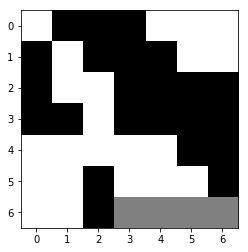

((5, 3), (6, 3)): n_v:  2992 q_all:+0.153806 q:+0.312312 q_m:+0.133333 p:0.330307
((5, 3), (6, 4)): n_v:  1583 q_all:+0.349094 q:-0.285112 q_m:-0.000000 p:0.004214
((6, 1), (6, 3)): n_v:   278 q_all:+0.138351 q:+0.206619 q_m:+0.100000 p:0.041041
((5, 5), (6, 3)): n_v:   177 q_all:+0.093574 q:+0.158517 q_m:+0.100000 p:0.049203
((5, 4), (6, 5)): n_v:    73 q_all:-0.110842 q:-0.150372 q_m:+0.066667 p:0.061265
((5, 5), (6, 6)): n_v:    44 q_all:+0.055532 q:-0.298236 q_m:+0.066667 p:0.017120
((4, 4), (6, 3)): n_v:    32 q_all:-0.136853 q:-0.022987 q_m:+0.100000 p:0.028964
((5, 1), (6, 3)): n_v:    10 q_all:-0.373616 q:-0.296555 q_m:+0.100000 p:0.015635
((4, 2), (6, 3)): n_v:     9 q_all:-0.379770 q:-0.263741 q_m:+0.100000 p:0.015378
((4, 1), (6, 3)): n_v:     4 q_all:-0.294228 q:-0.202508 q_m:+0.100000 p:0.006386
((4, 4), (6, 5)): n_v:     2 q_all:-0.405701 q:-0.344122 q_m:+0.033333 p:0.003321
((4, 3), (6, 3)): n_v:     1 q_all:-0.464888 q:-0.251904 q_m:+0.100000 p:0.001537
((4, 3), (6, 5))

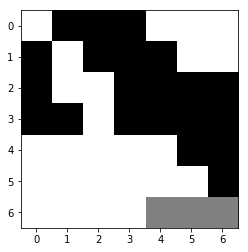

((5, 6), (6, 4)): n_v:  3123 q_all:+0.252664 q:-0.000777 q_m:+0.133333 p:0.734528
((4, 6), (6, 4)): n_v:    81 q_all:-0.185211 q:-0.185211 q_m:+0.133333 p:0.103775
((5, 6), (6, 5)): n_v:    39 q_all:-0.418570 q:-0.418570 q_m:+0.033333 p:0.085491
((4, 5), (6, 4)): n_v:    20 q_all:-0.409798 q:-0.409798 q_m:+0.133333 p:0.042620
((4, 6), (6, 5)): n_v:     6 q_all:-0.648306 q:-0.629291 q_m:-0.000000 p:0.017228
((5, 6), (6, 6)): n_v:     4 q_all:-0.412820 q:-0.412820 q_m:-0.033333 p:0.008890
((4, 6), (6, 6)): n_v:     1 q_all:-0.656297 q:-0.656297 q_m:-0.066667 p:0.004765
((4, 5), (6, 6)): n_v:     0 q_all:-0.706518 q:-0.706518 q_m:-0.066667 p:0.000508
((4, 5), (6, 5)): n_v:     0 q_all:-0.804656 q:-0.804656 q_m:-0.000000 p:0.002062
1 's turn
one move takes time(s):  0.09056377410888672
train_mode is both train
no. of data collected:  8


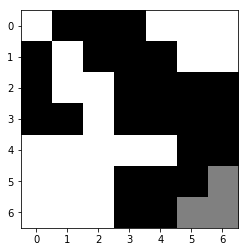

((4, 4), (5, 6)): n_v:  3120 q_all:+0.199595 q:-0.445855 q_m:+0.066667 p:0.672619
((4, 4), (6, 5)): n_v:   423 q_all:-0.421778 q:-0.360075 q_m:+0.066667 p:0.223017
((4, 3), (6, 5)): n_v:    71 q_all:-0.643520 q:-0.746537 q_m:+0.066667 p:0.094567
((4, 4), (6, 6)): n_v:    11 q_all:-0.450404 q:-0.663574 q_m:-0.066667 p:0.007402
-1 's turn


This is a random move


one move takes time(s):  0.1003565788269043
train_mode is both train
no. of data collected:  8


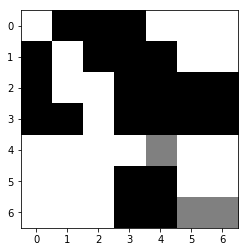

((3, 3), (4, 4)): n_v:  2753 q_all:-0.198262 q:+0.435195 q_m:+0.166667 p:0.115109
((6, 3), (4, 4)): n_v:  1874 q_all:+0.295216 q:+0.087010 q_m:+0.133333 p:0.068009
((6, 4), (4, 4)): n_v:    66 q_all:-0.225628 q:+0.147333 q_m:+0.133333 p:0.009189
((3, 6), (4, 4)): n_v:    51 q_all:-0.492274 q:-0.182092 q_m:+0.133333 p:0.056402
((2, 6), (4, 4)): n_v:    47 q_all:-0.353496 q:+0.112779 q_m:+0.133333 p:0.027204
((2, 3), (4, 4)): n_v:     4 q_all:-0.536820 q:-0.208358 q_m:+0.133333 p:0.005662
((2, 5), (4, 4)): n_v:     4 q_all:-0.538040 q:-0.145082 q_m:+0.133333 p:0.006249
((6, 3), (6, 5)): n_v:     3 q_all:-0.819133 q:-0.695174 q_m:+0.066667 p:0.008010
((5, 4), (6, 5)): n_v:     3 q_all:-0.827663 q:-0.686443 q_m:+0.100000 p:0.009144
((2, 4), (4, 4)): n_v:     2 q_all:-0.522201 q:-0.126367 q_m:+0.133333 p:0.002332
((5, 4), (6, 6)): n_v:     0 q_all:-0.720819 q:-0.720819 q_m:+0.066667 p:0.001889
((6, 4), (6, 6)): n_v:     0 q_all:-0.788891 q:-0.788891 q_m:+0.066667 p:0.001822
((5, 3), (6, 5))

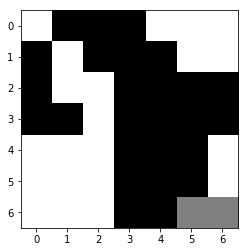

((5, 6), (6, 5)): n_v:  3110 q_all:+0.875214 q:+0.738346 q_m:+0.066667 p:0.699164
((4, 6), (6, 5)): n_v:   189 q_all:+0.419614 q:+0.265572 q_m:+0.033333 p:0.299755
((4, 6), (6, 6)): n_v:     0 q_all:-0.693560 q:-0.693560 q_m:-0.100000 p:0.000513
((5, 6), (6, 6)): n_v:     0 q_all:-0.576717 q:-0.576717 q_m:-0.066667 p:0.000526
-1 's turn
one move takes time(s):  0.06048846244812012
train_mode is both train
no. of data collected:  8


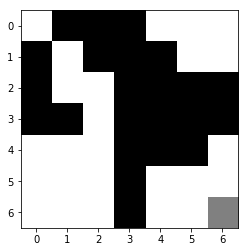

((4, 4), (6, 6)): n_v:  2008 q_all:-0.987255 q:-0.659575 q_m:+0.133333 p:0.560857
((4, 5), (6, 6)): n_v:  1454 q_all:-0.994627 q:-0.492926 q_m:+0.133333 p:0.436623
1 's turn
one move takes time(s):  0.07505178451538086
train_mode is both train
no. of data collected:  8


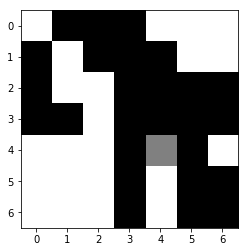

((5, 4), (4, 4)): n_v:  3270 q_all:+1.000000 q:+5.000000 q_m:+0.366667 p:0.777790
((6, 2), (4, 4)): n_v:   180 q_all:+0.987246 q:+0.940807 q_m:+0.333333 p:0.050518
((4, 6), (4, 4)): n_v:   143 q_all:+0.947515 q:+0.944645 q_m:+0.333333 p:0.058814
((6, 4), (4, 4)): n_v:   110 q_all:+0.929777 q:+0.902409 q_m:+0.333333 p:0.051623
((2, 2), (4, 4)): n_v:    57 q_all:+0.881310 q:+0.882879 q_m:+0.333333 p:0.036179
((4, 2), (4, 4)): n_v:     3 q_all:+0.190220 q:+0.586960 q_m:+0.333333 p:0.007336
((5, 2), (4, 4)): n_v:     3 q_all:-0.108091 q:+0.189212 q_m:+0.333333 p:0.014511
((3, 2), (4, 4)): n_v:     1 q_all:-0.408729 q:+0.182542 q_m:+0.333333 p:0.003226
this self play has 80 steps, time elapsed 108.91454529762268
winner is 1.0
episode 178 finished
episode 179 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3900434970855713
train_mode is both train
no. of data collected:  8


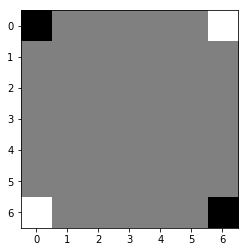

((0, 0), (1, 1)): n_v:   684 q_all:+0.003856 q:+0.004628 q_m:+0.033333 p:0.379824
((6, 6), (5, 5)): n_v:   665 q_all:+0.003312 q:+0.017064 q_m:+0.033333 p:0.370862
((0, 0), (0, 1)): n_v:   133 q_all:-0.009355 q:-0.016971 q_m:+0.033333 p:0.082187
((6, 6), (6, 5)): n_v:   121 q_all:-0.007235 q:-0.003708 q_m:+0.033333 p:0.073760
((0, 0), (1, 0)): n_v:    81 q_all:-0.002966 q:+0.004100 q_m:+0.033333 p:0.047497
((6, 6), (5, 6)): n_v:    76 q_all:-0.001069 q:+0.007339 q_m:+0.033333 p:0.044222
((6, 6), (6, 4)): n_v:     0 q_all:-0.006230 q:-0.006230 q_m:-0.000000 p:0.000022
((0, 0), (1, 2)): n_v:     0 q_all:-0.028677 q:-0.028677 q_m:-0.000000 p:0.000095
((0, 0), (2, 2)): n_v:     0 q_all:-0.026388 q:-0.026388 q_m:-0.000000 p:0.000235
((0, 0), (0, 2)): n_v:     0 q_all:-0.036040 q:-0.036040 q_m:-0.000000 p:0.000029
((6, 6), (4, 6)): n_v:     0 q_all:-0.017304 q:-0.017304 q_m:-0.000000 p:0.000235
((6, 6), (5, 4)): n_v:     0 q_all:-0.000022 q:-0.000022 q_m:-0.000000 p:0.000113
((6, 6), (4, 4))

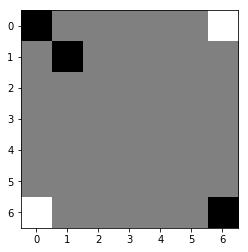

((6, 0), (5, 1)): n_v:   651 q_all:-0.017199 q:-0.008227 q_m:-0.000000 p:0.270480
((0, 6), (1, 5)): n_v:   629 q_all:-0.012892 q:-0.009037 q_m:-0.000000 p:0.250535
((0, 6), (1, 6)): n_v:   440 q_all:-0.014821 q:-0.026662 q_m:-0.000000 p:0.178420
((6, 0), (5, 0)): n_v:   414 q_all:-0.015836 q:-0.005279 q_m:-0.000000 p:0.170006
((6, 0), (6, 1)): n_v:   158 q_all:-0.015325 q:-0.005532 q_m:-0.000000 p:0.064569
((0, 6), (0, 5)): n_v:   152 q_all:-0.016530 q:-0.023010 q_m:-0.000000 p:0.062712
((0, 6), (2, 4)): n_v:     0 q_all:-0.036662 q:-0.036662 q_m:-0.033333 p:0.000265
((6, 0), (6, 2)): n_v:     0 q_all:-0.025065 q:-0.025065 q_m:-0.033333 p:0.000192
((6, 0), (5, 2)): n_v:     0 q_all:-0.020856 q:-0.020856 q_m:-0.033333 p:0.000255
((6, 0), (4, 1)): n_v:     0 q_all:-0.016220 q:-0.016220 q_m:-0.033333 p:0.000366
((0, 6), (2, 6)): n_v:     0 q_all:-0.017366 q:-0.017366 q_m:-0.033333 p:0.000331
((0, 6), (0, 4)): n_v:     0 q_all:-0.039195 q:-0.039195 q_m:-0.033333 p:0.000197
((0, 6), (2, 5))

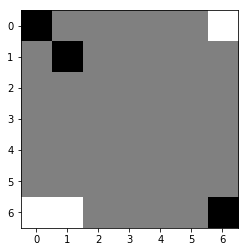

((6, 6), (5, 5)): n_v:  1077 q_all:+0.000707 q:+0.017192 q_m:+0.033333 p:0.493151
((1, 1), (2, 1)): n_v:   234 q_all:-0.009867 q:-0.014566 q_m:+0.033333 p:0.118632
((1, 1), (2, 2)): n_v:   152 q_all:-0.011203 q:-0.015260 q_m:+0.033333 p:0.077728
((0, 0), (0, 1)): n_v:   112 q_all:-0.014586 q:-0.047063 q_m:+0.033333 p:0.059268
((6, 6), (6, 5)): n_v:    84 q_all:-0.006747 q:-0.007162 q_m:+0.033333 p:0.041455
((1, 1), (2, 0)): n_v:    81 q_all:-0.006213 q:-0.015481 q_m:+0.033333 p:0.039881
((6, 6), (5, 6)): n_v:    71 q_all:-0.002284 q:+0.004548 q_m:+0.033333 p:0.033678
((0, 0), (1, 0)): n_v:    59 q_all:-0.009260 q:-0.030584 q_m:+0.033333 p:0.029851
((1, 1), (1, 2)): n_v:    30 q_all:-0.012340 q:-0.022512 q_m:+0.033333 p:0.015854
((1, 1), (0, 2)): n_v:    18 q_all:-0.014621 q:-0.031397 q_m:+0.033333 p:0.009818
((1, 1), (3, 0)): n_v:     0 q_all:-0.028705 q:-0.028705 q_m:-0.000000 p:0.000320
((6, 6), (6, 4)): n_v:     0 q_all:-0.006072 q:-0.006072 q_m:-0.000000 p:0.000019
((1, 1), (2, 3))

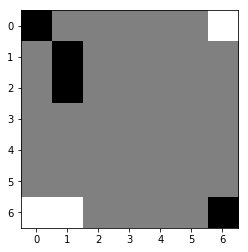

((0, 6), (1, 6)): n_v:   762 q_all:-0.024444 q:-0.038832 q_m:-0.000000 p:0.288296
((0, 6), (1, 5)): n_v:   379 q_all:-0.020486 q:-0.020890 q_m:-0.000000 p:0.136634
((6, 0), (5, 0)): n_v:   368 q_all:-0.022571 q:-0.023128 q_m:-0.000000 p:0.136014
((6, 0), (5, 1)): n_v:   214 q_all:-0.030771 q:-0.043900 q_m:-0.000000 p:0.086909
((6, 1), (5, 2)): n_v:   122 q_all:-0.030567 q:-0.026660 q_m:-0.000000 p:0.049561
((0, 6), (0, 5)): n_v:    83 q_all:-0.023631 q:-0.035405 q_m:-0.000000 p:0.031257
((6, 1), (6, 2)): n_v:    32 q_all:-0.029705 q:-0.026138 q_m:-0.000000 p:0.013213
((6, 1), (4, 0)): n_v:    10 q_all:-0.041046 q:-0.019652 q_m:-0.033333 p:0.004939
((0, 6), (2, 6)): n_v:     4 q_all:-0.040680 q:-0.026129 q_m:-0.033333 p:0.002050
((0, 6), (1, 4)): n_v:     3 q_all:-0.040056 q:-0.036959 q_m:-0.033333 p:0.001477
((6, 1), (4, 2)): n_v:     2 q_all:-0.035394 q:-0.030269 q_m:-0.033333 p:0.000963
((6, 0), (4, 0)): n_v:     2 q_all:-0.046725 q:-0.028017 q_m:-0.033333 p:0.001399
((6, 1), (4, 1))

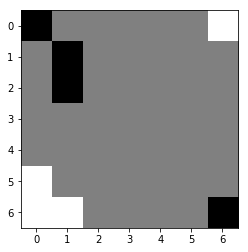

((6, 6), (5, 5)): n_v:  1328 q_all:-0.000274 q:+0.008795 q_m:+0.033333 p:0.568891
((2, 1), (3, 0)): n_v:   272 q_all:+0.005564 q:-0.036430 q_m:+0.033333 p:0.109775
((2, 1), (3, 1)): n_v:   146 q_all:-0.007513 q:-0.025148 q_m:+0.033333 p:0.067191
((2, 1), (3, 2)): n_v:    81 q_all:+0.041088 q:-0.021348 q_m:+0.033333 p:0.020371
((1, 1), (2, 2)): n_v:    62 q_all:-0.001031 q:-0.035345 q_m:+0.033333 p:0.026816
((6, 6), (6, 5)): n_v:    56 q_all:-0.006581 q:-0.013820 q_m:+0.033333 p:0.025656
((0, 0), (0, 1)): n_v:    48 q_all:-0.009079 q:-0.042121 q_m:+0.033333 p:0.022310
((1, 1), (2, 0)): n_v:    45 q_all:-0.005103 q:-0.036853 q_m:+0.033333 p:0.020463
((6, 6), (5, 6)): n_v:    25 q_all:-0.001546 q:-0.002209 q_m:+0.033333 p:0.010908
((1, 1), (0, 2)): n_v:    18 q_all:-0.004531 q:-0.030963 q_m:+0.033333 p:0.008100
((0, 0), (1, 0)): n_v:    14 q_all:-0.018829 q:-0.044276 q_m:+0.033333 p:0.007558
((2, 1), (4, 1)): n_v:    12 q_all:-0.044660 q:+0.012807 q_m:+0.066667 p:0.007840
((1, 1), (1, 2))

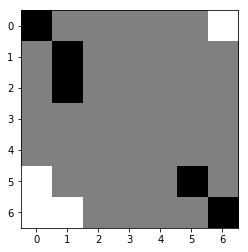

((0, 6), (1, 6)): n_v:  1017 q_all:-0.007363 q:-0.041243 q_m:-0.000000 p:0.257827
((0, 6), (1, 5)): n_v:   528 q_all:-0.008209 q:-0.025977 q_m:-0.000000 p:0.135661
((5, 0), (5, 1)): n_v:   411 q_all:-0.013980 q:-0.015563 q_m:-0.000000 p:0.114204
((0, 6), (0, 5)): n_v:   312 q_all:-0.004350 q:-0.040513 q_m:-0.000000 p:0.075851
((5, 0), (4, 1)): n_v:   286 q_all:-0.014849 q:-0.036364 q_m:-0.000000 p:0.080299
((5, 0), (4, 0)): n_v:   261 q_all:-0.012458 q:-0.033725 q_m:-0.000000 p:0.071072
((6, 1), (5, 2)): n_v:   156 q_all:-0.006647 q:-0.033538 q_m:-0.000000 p:0.039337
((6, 1), (6, 2)): n_v:    67 q_all:-0.013300 q:-0.042394 q_m:-0.000000 p:0.018517
((5, 0), (3, 2)): n_v:     7 q_all:-0.024946 q:+0.009848 q_m:+0.033333 p:0.002285
((5, 0), (3, 0)): n_v:     4 q_all:-0.026071 q:+0.012404 q_m:+0.033333 p:0.001556
((5, 0), (3, 1)): n_v:     3 q_all:-0.049459 q:-0.007279 q_m:+0.033333 p:0.001106
((6, 1), (5, 3)): n_v:     2 q_all:-0.051294 q:-0.022363 q_m:-0.033333 p:0.000878
((6, 1), (6, 3))

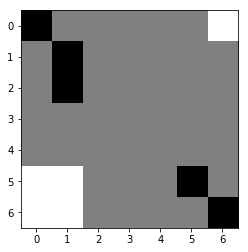

((2, 1), (3, 0)): n_v:   443 q_all:+0.019440 q:-0.013169 q_m:+0.033333 p:0.192335
((5, 5), (4, 5)): n_v:   436 q_all:+0.034088 q:+0.012486 q_m:+0.033333 p:0.160690
((2, 1), (4, 1)): n_v:   158 q_all:+0.009370 q:+0.059692 q_m:+0.133333 p:0.076162
((5, 5), (4, 6)): n_v:   137 q_all:+0.013714 q:+0.016800 q_m:+0.033333 p:0.062874
((2, 1), (3, 1)): n_v:   130 q_all:+0.022680 q:+0.003893 q_m:+0.033333 p:0.054860
((5, 5), (5, 4)): n_v:   119 q_all:+0.026295 q:+0.025221 q_m:+0.033333 p:0.048396
((5, 5), (4, 4)): n_v:   111 q_all:+0.040775 q:+0.028480 q_m:+0.033333 p:0.037903
((2, 1), (3, 2)): n_v:    69 q_all:+0.023643 q:+0.013507 q_m:+0.033333 p:0.028871
((1, 1), (2, 0)): n_v:    61 q_all:-0.000288 q:-0.009284 q_m:+0.033333 p:0.032139
((5, 5), (6, 4)): n_v:    55 q_all:+0.025183 q:+0.021582 q_m:+0.033333 p:0.022710
((1, 1), (1, 2)): n_v:    48 q_all:+0.025544 q:+0.006602 q_m:+0.033333 p:0.019464
((5, 5), (5, 6)): n_v:    47 q_all:+0.019816 q:+0.011017 q_m:+0.033333 p:0.020404
((1, 1), (2, 2))

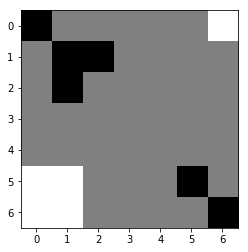

((5, 1), (4, 2)): n_v:   631 q_all:-0.022451 q:-0.039542 q_m:-0.000000 p:0.372277
((0, 6), (1, 6)): n_v:   494 q_all:-0.013020 q:-0.023326 q_m:-0.000000 p:0.268489
((0, 6), (1, 5)): n_v:   175 q_all:+0.000055 q:-0.009274 q_m:-0.000000 p:0.083714
((0, 6), (0, 5)): n_v:   162 q_all:-0.008098 q:-0.024420 q_m:-0.000000 p:0.084518
((5, 0), (4, 0)): n_v:    48 q_all:-0.022496 q:-0.028797 q_m:-0.000000 p:0.028882
((5, 0), (4, 1)): n_v:    27 q_all:-0.053316 q:-0.001892 q_m:-0.000000 p:0.020564
((5, 1), (3, 2)): n_v:    21 q_all:-0.004527 q:-0.008621 q_m:+0.033333 p:0.010948
((5, 1), (6, 2)): n_v:    16 q_all:+0.011650 q:-0.012948 q_m:-0.000000 p:0.006864
((5, 1), (5, 2)): n_v:    16 q_all:-0.033138 q:-0.015803 q_m:-0.000000 p:0.010627
((5, 1), (3, 0)): n_v:    13 q_all:+0.004798 q:-0.003393 q_m:+0.033333 p:0.005959
((5, 0), (3, 2)): n_v:     7 q_all:-0.024840 q:-0.001932 q_m:+0.033333 p:0.004652
((5, 1), (3, 1)): n_v:     6 q_all:-0.001943 q:-0.029757 q_m:+0.033333 p:0.003181
((5, 0), (4, 2))

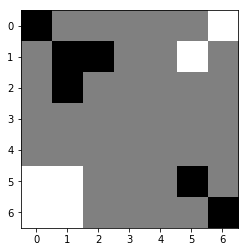

((5, 5), (4, 5)): n_v:   229 q_all:+0.033993 q:+0.004756 q_m:+0.033333 p:0.084461
((1, 2), (0, 3)): n_v:   175 q_all:+0.023621 q:-0.017801 q_m:+0.033333 p:0.073487
((1, 2), (1, 3)): n_v:   124 q_all:+0.029192 q:-0.015822 q_m:+0.033333 p:0.049048
((5, 5), (5, 4)): n_v:   115 q_all:+0.034233 q:+0.018958 q_m:+0.033333 p:0.042465
((2, 1), (3, 0)): n_v:   106 q_all:+0.028879 q:-0.011000 q_m:+0.033333 p:0.041809
((2, 1), (3, 2)): n_v:   102 q_all:+0.009446 q:-0.009323 q_m:+0.033333 p:0.049740
((5, 5), (4, 4)): n_v:    99 q_all:+0.028270 q:+0.019134 q_m:+0.033333 p:0.039581
((2, 1), (3, 1)): n_v:    97 q_all:+0.020423 q:-0.003311 q_m:+0.033333 p:0.042368
((1, 1), (2, 2)): n_v:    94 q_all:+0.005078 q:-0.033208 q_m:+0.033333 p:0.047750
((1, 2), (2, 3)): n_v:    83 q_all:+0.022604 q:-0.028932 q_m:+0.033333 p:0.035380
((1, 2), (1, 4)): n_v:    78 q_all:-0.024716 q:+0.039620 q_m:+0.066667 p:0.051220
((0, 0), (0, 1)): n_v:    64 q_all:+0.007121 q:-0.033227 q_m:+0.033333 p:0.032246
((0, 0), (1, 0))

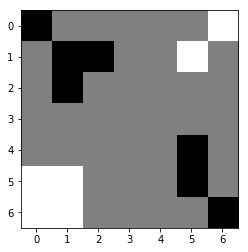

((5, 1), (4, 2)): n_v:   401 q_all:-0.025220 q:-0.025795 q_m:-0.000000 p:0.188863
((0, 6), (1, 6)): n_v:   383 q_all:-0.010729 q:-0.030745 q_m:-0.000000 p:0.154499
((1, 5), (2, 4)): n_v:   175 q_all:-0.019408 q:-0.011473 q_m:-0.000000 p:0.077335
((5, 1), (3, 2)): n_v:   145 q_all:+0.017654 q:+0.004660 q_m:+0.033333 p:0.039142
((1, 5), (3, 4)): n_v:   131 q_all:-0.008575 q:-0.000658 q_m:+0.033333 p:0.051623
((5, 1), (5, 2)): n_v:    59 q_all:-0.017225 q:+0.000877 q_m:-0.000000 p:0.025699
((5, 1), (3, 0)): n_v:    51 q_all:+0.019860 q:+0.013924 q_m:+0.033333 p:0.013335
((1, 5), (3, 6)): n_v:    48 q_all:-0.033520 q:-0.005796 q_m:+0.033333 p:0.024340
((0, 6), (0, 5)): n_v:    43 q_all:-0.023918 q:-0.027831 q_m:-0.000000 p:0.020115
((5, 0), (3, 2)): n_v:    41 q_all:-0.001672 q:+0.008463 q_m:+0.033333 p:0.014664
((1, 5), (2, 6)): n_v:    38 q_all:-0.001850 q:-0.012572 q_m:-0.000000 p:0.013869
((5, 0), (4, 0)): n_v:    35 q_all:-0.044757 q:-0.019834 q_m:-0.000000 p:0.019955
((1, 5), (1, 4))

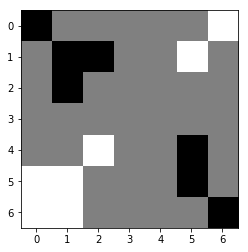

((2, 1), (4, 1)): n_v:  1277 q_all:+0.029336 q:+0.075939 q_m:+0.200000 p:0.536979
((1, 2), (1, 4)): n_v:   130 q_all:+0.053520 q:+0.048204 q_m:+0.066667 p:0.040840
((4, 5), (4, 3)): n_v:    78 q_all:+0.021883 q:+0.062267 q_m:+0.066667 p:0.035639
((4, 5), (2, 5)): n_v:    66 q_all:-0.009001 q:+0.050175 q_m:+0.066667 p:0.039556
((2, 1), (4, 3)): n_v:    33 q_all:+0.004680 q:+0.041035 q_m:+0.066667 p:0.017575
((2, 1), (3, 3)): n_v:    32 q_all:+0.001477 q:+0.027057 q_m:+0.066667 p:0.017795
((2, 1), (3, 2)): n_v:    32 q_all:-0.014201 q:+0.018962 q_m:+0.100000 p:0.019810
((5, 5), (4, 3)): n_v:    30 q_all:+0.022866 q:+0.064579 q_m:+0.066667 p:0.013855
((1, 2), (2, 3)): n_v:    29 q_all:-0.071364 q:-0.014682 q_m:+0.033333 p:0.026014
((4, 5), (5, 4)): n_v:    28 q_all:-0.064717 q:+0.013502 q_m:+0.033333 p:0.023637
((4, 5), (5, 3)): n_v:    26 q_all:+0.033426 q:+0.060086 q_m:+0.066667 p:0.010434
((1, 2), (0, 3)): n_v:    21 q_all:-0.022153 q:-0.012623 q_m:+0.033333 p:0.013470
((1, 2), (1, 3))

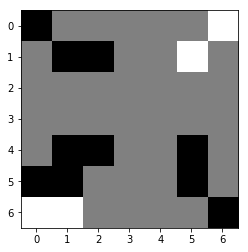

((6, 1), (5, 2)): n_v:  1857 q_all:-0.012195 q:-0.030720 q_m:+0.033333 p:0.565034
((6, 0), (4, 0)): n_v:   498 q_all:-0.053277 q:-0.065258 q_m:-0.000000 p:0.227204
((6, 0), (5, 2)): n_v:   338 q_all:-0.034862 q:-0.064187 q_m:-0.000000 p:0.131563
((6, 1), (4, 0)): n_v:   104 q_all:-0.032527 q:-0.044669 q_m:-0.000000 p:0.039880
((1, 5), (1, 4)): n_v:    11 q_all:-0.079998 q:-0.114550 q_m:-0.166667 p:0.006522
((0, 6), (2, 6)): n_v:    11 q_all:-0.111811 q:-0.116715 q_m:-0.200000 p:0.007280
((6, 1), (6, 2)): n_v:     9 q_all:-0.090452 q:-0.087127 q_m:-0.100000 p:0.005346
((1, 5), (2, 6)): n_v:     6 q_all:-0.069325 q:-0.100436 q_m:-0.166667 p:0.003417
((6, 1), (5, 3)): n_v:     2 q_all:-0.080451 q:-0.050038 q_m:-0.133333 p:0.001641
((0, 6), (1, 6)): n_v:     2 q_all:-0.109222 q:-0.124648 q_m:-0.166667 p:0.001704
((0, 6), (1, 4)): n_v:     2 q_all:-0.077630 q:-0.109129 q_m:-0.200000 p:0.001173
((6, 1), (4, 3)): n_v:     2 q_all:-0.065202 q:-0.069904 q_m:-0.133333 p:0.001341
((1, 5), (3, 4))

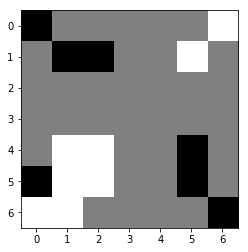

((4, 5), (4, 3)): n_v:   534 q_all:+0.023080 q:+0.050323 q_m:+0.100000 p:0.132649
((5, 0), (4, 0)): n_v:   527 q_all:+0.050867 q:+0.042029 q_m:+0.133333 p:0.081326
((4, 5), (4, 6)): n_v:   322 q_all:+0.002142 q:-0.002494 q_m:-0.000000 p:0.103158
((1, 2), (3, 2)): n_v:   251 q_all:+0.028170 q:+0.007669 q_m:+0.100000 p:0.058256
((4, 5), (3, 4)): n_v:   187 q_all:-0.015152 q:-0.008868 q_m:-0.000000 p:0.071189
((4, 5), (5, 3)): n_v:   134 q_all:+0.020635 q:+0.049301 q_m:+0.100000 p:0.034261
((1, 2), (2, 3)): n_v:   112 q_all:-0.015631 q:-0.017865 q_m:-0.000000 p:0.042845
((1, 2), (1, 3)): n_v:    97 q_all:-0.015034 q:+0.000918 q_m:-0.000000 p:0.037024
((1, 2), (3, 4)): n_v:    95 q_all:-0.030391 q:-0.029575 q_m:-0.033333 p:0.041240
((5, 5), (5, 3)): n_v:    89 q_all:+0.020792 q:+0.041909 q_m:+0.100000 p:0.023071
((1, 1), (3, 2)): n_v:    80 q_all:+0.019268 q:+0.012663 q_m:+0.100000 p:0.021095
((1, 2), (0, 4)): n_v:    77 q_all:+0.026563 q:+0.041295 q_m:+0.033333 p:0.018273
((4, 5), (3, 5))

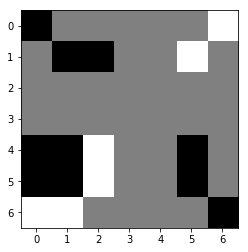

((4, 2), (3, 1)): n_v:  1677 q_all:-0.051656 q:-0.054586 q_m:+0.033333 p:0.805618
((5, 2), (3, 1)): n_v:   131 q_all:-0.046699 q:-0.069012 q_m:-0.000000 p:0.060454
((4, 2), (2, 0)): n_v:    68 q_all:-0.042838 q:-0.057095 q_m:-0.066667 p:0.030424
((4, 2), (2, 1)): n_v:    38 q_all:-0.020837 q:-0.034295 q_m:-0.000000 p:0.013248
((0, 6), (1, 6)): n_v:    19 q_all:-0.050818 q:-0.112650 q_m:-0.100000 p:0.009458
((5, 2), (5, 4)): n_v:    17 q_all:-0.016356 q:-0.023762 q_m:-0.000000 p:0.005820
((5, 2), (3, 0)): n_v:    15 q_all:-0.045999 q:-0.074934 q_m:-0.000000 p:0.007006
((4, 2), (3, 2)): n_v:    14 q_all:-0.072185 q:-0.103400 q_m:-0.033333 p:0.008404
((4, 2), (5, 4)): n_v:    14 q_all:-0.005759 q:-0.025191 q_m:-0.000000 p:0.003972
((4, 2), (3, 0)): n_v:    13 q_all:-0.031863 q:-0.082824 q_m:-0.000000 p:0.005264
((4, 2), (2, 2)): n_v:    11 q_all:-0.050619 q:-0.035755 q_m:-0.000000 p:0.005442
((1, 5), (3, 5)): n_v:     8 q_all:-0.092438 q:-0.063260 q_m:-0.066667 p:0.005336
((4, 2), (4, 4))

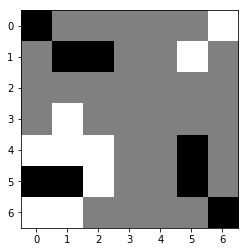

((1, 2), (3, 0)): n_v:  1445 q_all:+0.061224 q:+0.047447 q_m:+0.166667 p:0.397671
((1, 1), (3, 0)): n_v:   940 q_all:+0.052499 q:+0.063606 q_m:+0.166667 p:0.287616
((1, 1), (3, 2)): n_v:   285 q_all:+0.026687 q:+0.053600 q_m:+0.166667 p:0.113106
((1, 2), (3, 2)): n_v:   272 q_all:+0.041504 q:+0.046749 q_m:+0.166667 p:0.093777
((4, 5), (3, 4)): n_v:    59 q_all:-0.025401 q:-0.016166 q_m:-0.000000 p:0.034304
((1, 2), (3, 4)): n_v:    35 q_all:-0.034741 q:-0.019557 q_m:-0.033333 p:0.021863
((5, 0), (3, 2)): n_v:    24 q_all:+0.032348 q:+0.023834 q_m:+0.166667 p:0.009076
((5, 0), (3, 0)): n_v:    18 q_all:+0.013892 q:+0.015628 q_m:+0.166667 p:0.007943
((5, 1), (3, 0)): n_v:    15 q_all:-0.003798 q:+0.038890 q_m:+0.166667 p:0.007525
((5, 5), (3, 6)): n_v:    11 q_all:-0.018321 q:-0.012826 q_m:-0.033333 p:0.006174
((5, 1), (3, 2)): n_v:     8 q_all:-0.015969 q:+0.041203 q_m:+0.166667 p:0.004665
((4, 5), (3, 6)): n_v:     7 q_all:-0.005942 q:-0.002613 q_m:-0.000000 p:0.003814
((5, 5), (3, 4))

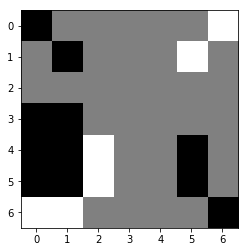

((4, 2), (2, 0)): n_v:  1126 q_all:-0.056506 q:-0.037592 q_m:+0.033333 p:0.381117
((4, 2), (3, 2)): n_v:   564 q_all:-0.045823 q:-0.097206 q_m:-0.000000 p:0.169341
((4, 2), (2, 1)): n_v:   326 q_all:-0.044663 q:-0.033304 q_m:+0.033333 p:0.096427
((5, 2), (3, 2)): n_v:   225 q_all:-0.067403 q:-0.098544 q_m:-0.033333 p:0.085271
((4, 2), (4, 4)): n_v:   143 q_all:-0.045487 q:-0.044995 q_m:-0.033333 p:0.042930
((4, 2), (2, 2)): n_v:   137 q_all:-0.082489 q:-0.061241 q_m:-0.033333 p:0.059426
((4, 2), (3, 4)): n_v:   100 q_all:-0.071405 q:-0.106383 q_m:-0.100000 p:0.039313
((4, 2), (5, 4)): n_v:    95 q_all:-0.030221 q:-0.046373 q_m:-0.033333 p:0.023137
((5, 2), (5, 4)): n_v:    75 q_all:+0.002901 q:-0.057496 q_m:-0.033333 p:0.009276
((1, 5), (2, 6)): n_v:    30 q_all:-0.099515 q:-0.143097 q_m:-0.133333 p:0.015187
((1, 5), (3, 4)): n_v:    25 q_all:-0.079007 q:-0.114323 q_m:-0.100000 p:0.010143
((5, 2), (4, 4)): n_v:    21 q_all:-0.041319 q:-0.047460 q_m:-0.033333 p:0.006198
((0, 6), (2, 6))

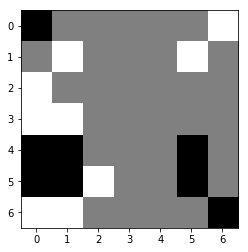

((0, 0), (2, 1)): n_v:  1602 q_all:+0.099814 q:+0.109702 q_m:+0.233333 p:0.361297
((4, 0), (2, 1)): n_v:   463 q_all:+0.018531 q:+0.063445 q_m:+0.233333 p:0.245005
((4, 5), (2, 5)): n_v:   288 q_all:+0.024765 q:+0.024182 q_m:+0.033333 p:0.145905
((4, 1), (2, 1)): n_v:   118 q_all:+0.007347 q:+0.065256 q_m:+0.233333 p:0.067562
((4, 1), (4, 2)): n_v:    68 q_all:+0.035687 q:+0.014812 q_m:+0.133333 p:0.031785
((4, 5), (4, 4)): n_v:    41 q_all:-0.014929 q:-0.038431 q_m:-0.000000 p:0.027323
((0, 0), (1, 0)): n_v:    10 q_all:+0.003028 q:+0.037865 q_m:+0.133333 p:0.005665
((0, 0), (2, 2)): n_v:     8 q_all:+0.012797 q:-0.007435 q_m:+0.100000 p:0.004872
((4, 5), (2, 4)): n_v:     7 q_all:+0.080446 q:+0.017635 q_m:+0.033333 p:0.002288
((5, 1), (6, 2)): n_v:     6 q_all:+0.055879 q:+0.022850 q_m:+0.133333 p:0.002548
((4, 5), (3, 6)): n_v:     6 q_all:+0.002988 q:-0.031520 q_m:-0.000000 p:0.003648
((4, 5), (4, 6)): n_v:     4 q_all:-0.000704 q:-0.038561 q_m:-0.000000 p:0.002780
((4, 5), (5, 6))

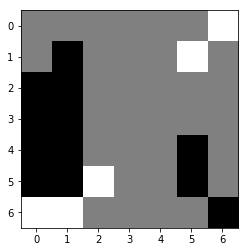

((5, 2), (3, 2)): n_v:  2134 q_all:-0.111319 q:-0.087955 q_m:-0.033333 p:0.656939
((5, 2), (4, 4)): n_v:   231 q_all:-0.124605 q:-0.107299 q_m:-0.100000 p:0.082172
((5, 2), (4, 2)): n_v:   218 q_all:-0.108858 q:-0.147852 q_m:-0.000000 p:0.065464
((5, 2), (5, 4)): n_v:   126 q_all:-0.079328 q:-0.128360 q_m:-0.100000 p:0.024610
((5, 2), (3, 4)): n_v:    88 q_all:-0.115168 q:-0.181789 q_m:-0.166667 p:0.028514
((1, 5), (3, 4)): n_v:    81 q_all:-0.134188 q:-0.192552 q_m:-0.166667 p:0.031762
((6, 0), (4, 2)): n_v:    46 q_all:-0.117680 q:-0.158040 q_m:-0.033333 p:0.015205
((1, 5), (3, 6)): n_v:    31 q_all:-0.213940 q:-0.213645 q_m:-0.166667 p:0.021174
((1, 5), (2, 4)): n_v:    30 q_all:-0.133520 q:-0.216929 q_m:-0.200000 p:0.011965
((6, 1), (4, 2)): n_v:    27 q_all:-0.134702 q:-0.175313 q_m:-0.033333 p:0.010897
((0, 6), (1, 6)): n_v:    18 q_all:-0.168975 q:-0.249807 q_m:-0.200000 p:0.009655
((0, 6), (2, 6)): n_v:     9 q_all:-0.187706 q:-0.237967 q_m:-0.233333 p:0.005459
((1, 5), (1, 4))

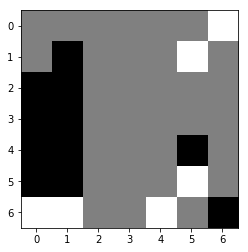

((6, 6), (6, 5)): n_v:   588 q_all:+0.176884 q:+0.170421 q_m:+0.333333 p:0.213615
((4, 5), (5, 4)): n_v:   553 q_all:+0.214295 q:+0.172873 q_m:+0.333333 p:0.098830
((4, 5), (6, 5)): n_v:   124 q_all:+0.143607 q:+0.172362 q_m:+0.300000 p:0.065761
((4, 1), (5, 2)): n_v:    88 q_all:+0.052336 q:+0.118714 q_m:+0.266667 p:0.087385
((6, 6), (5, 4)): n_v:    77 q_all:+0.170297 q:+0.158642 q_m:+0.300000 p:0.030509
((4, 5), (5, 6)): n_v:    34 q_all:+0.067659 q:+0.113308 q_m:+0.266667 p:0.030995
((1, 1), (1, 2)): n_v:    23 q_all:+0.058642 q:+0.040666 q_m:+0.200000 p:0.021882
((1, 1), (0, 1)): n_v:    22 q_all:+0.036865 q:+0.046455 q_m:+0.200000 p:0.024339
((4, 5), (6, 3)): n_v:    12 q_all:+0.076712 q:+0.069229 q_m:+0.233333 p:0.010436
((3, 0), (5, 2)): n_v:    11 q_all:-0.008982 q:+0.040116 q_m:+0.233333 p:0.014440
((1, 1), (1, 0)): n_v:    10 q_all:+0.117364 q:+0.065633 q_m:+0.200000 p:0.007144
((2, 0), (0, 1)): n_v:     7 q_all:+0.035691 q:+0.015774 q_m:+0.166667 p:0.007756
((1, 1), (0, 0))

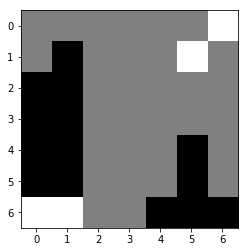

((6, 1), (5, 2)): n_v:  1897 q_all:-0.213945 q:-0.250810 q_m:-0.166667 p:0.759037
((6, 0), (5, 2)): n_v:   233 q_all:-0.227040 q:-0.250424 q_m:-0.200000 p:0.106202
((1, 5), (1, 4)): n_v:    55 q_all:-0.230472 q:-0.303413 q_m:-0.300000 p:0.026070
((1, 5), (3, 4)): n_v:    41 q_all:-0.220085 q:-0.265968 q_m:-0.266667 p:0.017379
((0, 6), (1, 6)): n_v:    32 q_all:-0.252484 q:-0.318559 q_m:-0.300000 p:0.018442
((1, 5), (2, 4)): n_v:    26 q_all:-0.223101 q:-0.287917 q_m:-0.300000 p:0.011448
((6, 1), (4, 2)): n_v:    15 q_all:-0.189289 q:-0.201784 q_m:-0.133333 p:0.004582
((6, 0), (4, 2)): n_v:    14 q_all:-0.194876 q:-0.230258 q_m:-0.133333 p:0.004516
((0, 6), (1, 4)): n_v:    10 q_all:-0.268819 q:-0.303515 q_m:-0.333333 p:0.006573
((6, 1), (5, 3)): n_v:     5 q_all:-0.188766 q:-0.213740 q_m:-0.266667 p:0.001400
((6, 1), (4, 3)): n_v:     5 q_all:-0.212717 q:-0.252491 q_m:-0.333333 p:0.002213
((1, 5), (3, 6)): n_v:     4 q_all:-0.327148 q:-0.280898 q_m:-0.266667 p:0.003530
((6, 1), (6, 3))

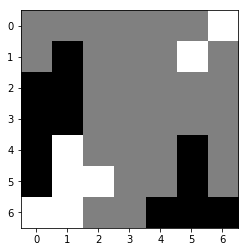

((6, 4), (6, 2)): n_v:  1618 q_all:+0.171290 q:+0.163708 q_m:+0.366667 p:0.766916
((3, 1), (4, 2)): n_v:  1408 q_all:+0.311170 q:+0.195516 q_m:+0.400000 p:0.016122
((6, 4), (4, 2)): n_v:   407 q_all:+0.287287 q:+0.192678 q_m:+0.366667 p:0.036444
((4, 0), (6, 2)): n_v:    82 q_all:+0.105543 q:+0.075906 q_m:+0.366667 p:0.056941
((2, 1), (0, 2)): n_v:    32 q_all:+0.022249 q:+0.064215 q_m:+0.166667 p:0.030985
((2, 1), (4, 2)): n_v:    23 q_all:+0.211741 q:+0.172426 q_m:+0.366667 p:0.007528
((2, 0), (0, 2)): n_v:    14 q_all:+0.017769 q:+0.050954 q_m:+0.166667 p:0.014438
((4, 5), (4, 4)): n_v:    13 q_all:+0.039739 q:+0.099480 q_m:+0.200000 p:0.012368
((2, 0), (4, 2)): n_v:    12 q_all:+0.286467 q:+0.130375 q_m:+0.366667 p:0.001121
((3, 0), (4, 2)): n_v:     9 q_all:+0.282983 q:+0.145422 q_m:+0.366667 p:0.000893
((5, 0), (6, 2)): n_v:     8 q_all:+0.145495 q:+0.109423 q_m:+0.366667 p:0.004237
((1, 1), (0, 2)): n_v:     7 q_all:+0.062508 q:+0.109767 q_m:+0.200000 p:0.006198
((2, 0), (2, 2))

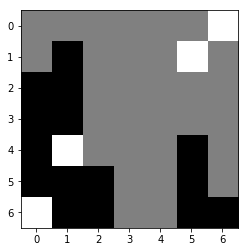

((4, 1), (2, 2)): n_v:  1838 q_all:-0.084085 q:-0.178361 q_m:-0.166667 p:0.301763
((4, 1), (4, 2)): n_v:   928 q_all:-0.214307 q:-0.222860 q_m:-0.133333 p:0.568786
((4, 1), (5, 3)): n_v:    79 q_all:-0.108850 q:-0.197945 q_m:-0.233333 p:0.019843
((6, 0), (4, 2)): n_v:    51 q_all:-0.219517 q:-0.224231 q_m:-0.166667 p:0.032716
((1, 5), (2, 4)): n_v:    39 q_all:-0.266322 q:-0.313475 q_m:-0.333333 p:0.031577
((4, 1), (3, 2)): n_v:    12 q_all:-0.195154 q:-0.198260 q_m:-0.200000 p:0.006443
((0, 6), (1, 6)): n_v:     5 q_all:-0.320606 q:-0.355159 q_m:-0.333333 p:0.005426
((1, 5), (3, 4)): n_v:     5 q_all:-0.240053 q:-0.278381 q_m:-0.300000 p:0.003796
((4, 1), (4, 3)): n_v:     4 q_all:-0.256250 q:-0.239148 q_m:-0.300000 p:0.003535
((1, 5), (3, 6)): n_v:     4 q_all:-0.304614 q:-0.305223 q_m:-0.300000 p:0.003714
((4, 1), (6, 3)): n_v:     3 q_all:-0.257085 q:-0.249067 q_m:-0.233333 p:0.002842
((0, 6), (2, 4)): n_v:     3 q_all:-0.286200 q:-0.331913 q_m:-0.366667 p:0.002806
((1, 5), (3, 3))

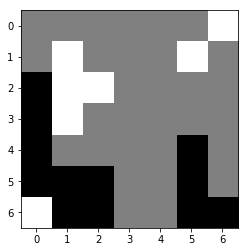

((4, 5), (3, 4)): n_v:   698 q_all:-0.014929 q:+0.001629 q_m:+0.200000 p:0.436605
((4, 0), (3, 2)): n_v:   643 q_all:+0.151633 q:+0.110922 q_m:+0.366667 p:0.036709
((3, 0), (3, 2)): n_v:   581 q_all:+0.121235 q:+0.097951 q_m:+0.366667 p:0.093687
((3, 0), (1, 2)): n_v:   210 q_all:+0.138523 q:+0.085769 q_m:+0.366667 p:0.021435
((5, 1), (3, 2)): n_v:   186 q_all:+0.112920 q:+0.095442 q_m:+0.366667 p:0.035174
((3, 0), (4, 1)): n_v:   142 q_all:+0.089948 q:+0.141539 q_m:+0.266667 p:0.038021
((5, 0), (3, 2)): n_v:   130 q_all:+0.134976 q:+0.112511 q_m:+0.366667 p:0.014624
((5, 2), (3, 4)): n_v:   126 q_all:-0.020345 q:-0.016480 q_m:+0.166667 p:0.081614
((5, 2), (3, 2)): n_v:   115 q_all:+0.058305 q:+0.106696 q_m:+0.366667 p:0.043105
((3, 0), (1, 0)): n_v:    83 q_all:+0.137584 q:+0.069731 q_m:+0.300000 p:0.008653
((2, 0), (3, 2)): n_v:    58 q_all:+0.052922 q:+0.073513 q_m:+0.366667 p:0.023019
((5, 5), (3, 4)): n_v:    46 q_all:-0.032703 q:-0.008223 q_m:+0.166667 p:0.031904
((2, 0), (1, 0))

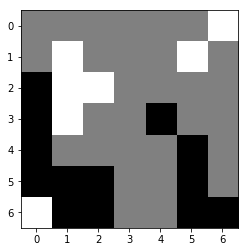

((2, 2), (4, 1)): n_v:   876 q_all:+0.014316 q:+0.027815 q_m:+0.133333 p:0.349572
((3, 1), (4, 1)): n_v:   672 q_all:+0.013238 q:+0.034941 q_m:+0.166667 p:0.271748
((2, 1), (4, 1)): n_v:   427 q_all:-0.033548 q:-0.002842 q_m:+0.133333 p:0.256278
((6, 0), (4, 1)): n_v:   149 q_all:-0.004154 q:+0.008909 q_m:+0.133333 p:0.071450
((2, 2), (1, 0)): n_v:    23 q_all:+0.071128 q:-0.130202 q_m:-0.133333 p:0.003887
((1, 5), (2, 5)): n_v:    19 q_all:-0.076582 q:-0.097392 q_m:-0.100000 p:0.015124
((2, 2), (2, 3)): n_v:     7 q_all:-0.116078 q:-0.101450 q_m:-0.100000 p:0.007135
((1, 5), (3, 5)): n_v:     5 q_all:-0.067715 q:-0.058462 q_m:-0.066667 p:0.003410
((2, 2), (3, 3)): n_v:     3 q_all:-0.055069 q:-0.069242 q_m:-0.100000 p:0.002736
((1, 5), (3, 6)): n_v:     3 q_all:-0.019387 q:-0.150473 q_m:-0.133333 p:0.002088
((3, 1), (4, 3)): n_v:     2 q_all:-0.018410 q:-0.044173 q_m:-0.066667 p:0.001264
((2, 1), (4, 3)): n_v:     2 q_all:-0.109842 q:-0.068733 q_m:-0.066667 p:0.001334
((2, 2), (4, 3))

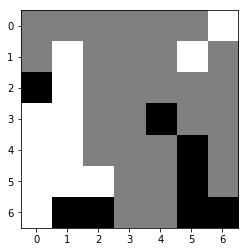

((3, 4), (4, 2)): n_v:  1076 q_all:+0.010102 q:+0.011313 q_m:+0.133333 p:0.311042
((3, 4), (2, 2)): n_v:   313 q_all:-0.020209 q:-0.021719 q_m:+0.066667 p:0.128305
((2, 0), (4, 2)): n_v:   258 q_all:+0.005159 q:-0.005700 q_m:+0.133333 p:0.079836
((6, 2), (4, 2)): n_v:   130 q_all:-0.007449 q:-0.030320 q_m:+0.133333 p:0.046743
((3, 4), (4, 4)): n_v:   114 q_all:-0.136711 q:-0.113759 q_m:-0.100000 p:0.100785
((2, 0), (2, 2)): n_v:   113 q_all:+0.008691 q:-0.043657 q_m:+0.066667 p:0.033459
((3, 4), (2, 4)): n_v:    60 q_all:-0.044776 q:-0.057489 q_m:-0.033333 p:0.030903
((3, 4), (1, 2)): n_v:    50 q_all:-0.018495 q:-0.055410 q_m:-0.000000 p:0.020052
((6, 2), (4, 4)): n_v:    40 q_all:-0.175283 q:-0.145804 q_m:-0.133333 p:0.041439
((3, 4), (1, 6)): n_v:    35 q_all:-0.039452 q:-0.044439 q_m:-0.000000 p:0.017243
((3, 4), (3, 2)): n_v:    31 q_all:-0.029050 q:-0.035480 q_m:+0.066667 p:0.014272
((4, 5), (2, 4)): n_v:    26 q_all:-0.076494 q:-0.044342 q_m:-0.066667 p:0.016958
((6, 1), (4, 2))

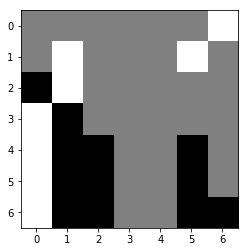

((2, 1), (3, 2)): n_v:  1432 q_all:+0.023382 q:+0.005340 q_m:+0.100000 p:0.354666
((3, 0), (3, 2)): n_v:   489 q_all:-0.071384 q:-0.047075 q_m:+0.066667 p:0.295337
((1, 1), (3, 2)): n_v:   418 q_all:+0.031420 q:+0.008710 q_m:+0.066667 p:0.091029
((1, 5), (3, 4)): n_v:   303 q_all:-0.049011 q:-0.037637 q_m:-0.066667 p:0.157592
((4, 0), (3, 2)): n_v:    88 q_all:-0.059808 q:-0.069116 q_m:+0.066667 p:0.049650
((5, 0), (3, 2)): n_v:    51 q_all:-0.070560 q:-0.083666 q_m:+0.066667 p:0.031133
((3, 0), (1, 2)): n_v:     5 q_all:-0.108633 q:-0.128416 q_m:-0.133333 p:0.003968
((1, 5), (3, 6)): n_v:     4 q_all:-0.068493 q:-0.054674 q_m:-0.066667 p:0.002499
((3, 0), (1, 0)): n_v:     4 q_all:-0.093489 q:-0.085532 q_m:-0.066667 p:0.002429
((1, 1), (1, 0)): n_v:     2 q_all:-0.012023 q:-0.032613 q_m:-0.033333 p:0.000833
((1, 5), (3, 3)): n_v:     1 q_all:-0.060267 q:-0.040682 q_m:-0.066667 p:0.000529
((1, 1), (3, 3)): n_v:     1 q_all:-0.060274 q:-0.028665 q_m:-0.066667 p:0.000534
((2, 1), (3, 3))

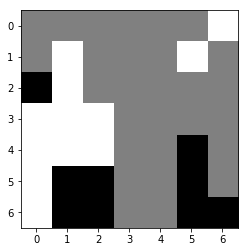

((2, 0), (2, 2)): n_v:  1329 q_all:+0.045773 q:+0.019465 q_m:+0.166667 p:0.157101
((5, 2), (4, 3)): n_v:   845 q_all:-0.036329 q:-0.048445 q_m:+0.066667 p:0.352051
((2, 0), (1, 0)): n_v:   164 q_all:+0.016448 q:+0.030102 q_m:+0.066667 p:0.036969
((4, 5), (2, 4)): n_v:   138 q_all:-0.008873 q:+0.013534 q_m:-0.033333 p:0.043823
((4, 5), (4, 4)): n_v:   133 q_all:-0.112397 q:-0.063629 q_m:-0.066667 p:0.092258
((4, 5), (2, 3)): n_v:    56 q_all:-0.065140 q:-0.053047 q_m:-0.033333 p:0.029292
((5, 2), (4, 4)): n_v:    44 q_all:-0.121368 q:-0.086567 q_m:-0.100000 p:0.032154
((6, 1), (4, 3)): n_v:    27 q_all:-0.105227 q:-0.146255 q_m:+0.033333 p:0.017857
((5, 2), (3, 3)): n_v:    20 q_all:-0.102984 q:-0.046128 q_m:+0.033333 p:0.013744
((5, 1), (4, 3)): n_v:    16 q_all:-0.135691 q:-0.104022 q_m:+0.033333 p:0.012388
((6, 2), (4, 3)): n_v:    16 q_all:-0.066074 q:-0.079056 q_m:+0.033333 p:0.008700
((6, 5), (4, 4)): n_v:    14 q_all:-0.124766 q:-0.070380 q_m:-0.100000 p:0.010161
((6, 2), (4, 4))

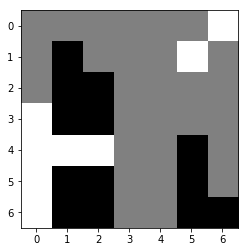

((3, 0), (2, 0)): n_v:  1275 q_all:-0.039749 q:-0.014861 q_m:+0.066667 p:0.455385
((4, 2), (5, 4)): n_v:   411 q_all:+0.022596 q:+0.002266 q_m:+0.033333 p:0.052155
((4, 2), (4, 3)): n_v:   191 q_all:-0.014345 q:-0.026130 q_m:-0.000000 p:0.050489
((4, 2), (2, 0)): n_v:   182 q_all:-0.047897 q:-0.037320 q_m:+0.033333 p:0.070717
((1, 5), (2, 6)): n_v:   166 q_all:-0.080917 q:-0.114951 q_m:-0.133333 p:0.084735
((4, 2), (3, 3)): n_v:   148 q_all:-0.043836 q:-0.018439 q_m:-0.000000 p:0.055353
((4, 0), (2, 0)): n_v:   123 q_all:-0.094971 q:-0.104541 q_m:+0.033333 p:0.069235
((3, 0), (1, 2)): n_v:    70 q_all:-0.015083 q:-0.036293 q_m:+0.033333 p:0.018555
((4, 2), (5, 3)): n_v:    61 q_all:+0.007294 q:-0.001754 q_m:-0.000000 p:0.011295
((4, 1), (2, 0)): n_v:    48 q_all:-0.159420 q:-0.126758 q_m:+0.033333 p:0.039006
((1, 5), (1, 4)): n_v:    48 q_all:-0.099399 q:-0.140131 q_m:-0.133333 p:0.028071
((1, 5), (3, 4)): n_v:    26 q_all:-0.032679 q:-0.062405 q_m:-0.100000 p:0.008669
((4, 2), (2, 3))

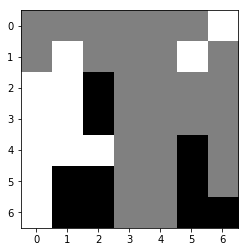

((3, 2), (1, 0)): n_v:  2255 q_all:+0.037607 q:+0.057433 q_m:+0.133333 p:0.730478
((2, 2), (1, 0)): n_v:   546 q_all:+0.024266 q:+0.042687 q_m:+0.133333 p:0.203371
((3, 2), (1, 4)): n_v:    10 q_all:-0.040610 q:-0.010621 q_m:-0.000000 p:0.006003
((4, 5), (5, 6)): n_v:     7 q_all:-0.059036 q:-0.109236 q_m:-0.033333 p:0.004727
((3, 2), (1, 2)): n_v:     5 q_all:-0.037513 q:-0.053238 q_m:+0.066667 p:0.003349
((2, 2), (2, 4)): n_v:     3 q_all:-0.042593 q:-0.006793 q_m:-0.000000 p:0.002288
((4, 5), (3, 6)): n_v:     3 q_all:-0.059106 q:-0.074094 q_m:-0.033333 p:0.002169
((4, 5), (2, 5)): n_v:     2 q_all:-0.013467 q:-0.029229 q_m:-0.000000 p:0.001142
((2, 2), (0, 1)): n_v:     2 q_all:-0.069575 q:-0.075605 q_m:-0.000000 p:0.002093
((4, 5), (3, 4)): n_v:     2 q_all:-0.097911 q:-0.096198 q_m:-0.033333 p:0.001830
((3, 2), (2, 4)): n_v:     2 q_all:-0.059682 q:-0.008850 q_m:-0.000000 p:0.001387
((4, 5), (3, 5)): n_v:     2 q_all:-0.067277 q:-0.097128 q_m:-0.033333 p:0.001995
((2, 2), (1, 2))

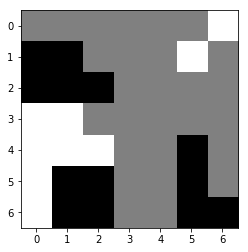

((3, 1), (3, 2)): n_v:  1560 q_all:-0.005476 q:-0.035384 q_m:+0.033333 p:0.240784
((4, 2), (5, 4)): n_v:  1300 q_all:-0.002219 q:-0.017356 q_m:+0.066667 p:0.186849
((3, 0), (1, 2)): n_v:   264 q_all:-0.028045 q:-0.077151 q_m:+0.066667 p:0.060066
((3, 1), (1, 2)): n_v:   122 q_all:-0.117356 q:-0.085599 q_m:+0.066667 p:0.062870
((4, 2), (5, 3)): n_v:    84 q_all:-0.011359 q:-0.020316 q_m:+0.033333 p:0.014627
((1, 5), (1, 4)): n_v:    42 q_all:-0.123436 q:-0.143033 q_m:-0.100000 p:0.022777
((3, 0), (3, 2)): n_v:    35 q_all:-0.126091 q:-0.095322 q_m:-0.000000 p:0.019317
((4, 0), (3, 2)): n_v:    28 q_all:-0.119999 q:-0.131830 q_m:-0.000000 p:0.014624
((1, 5), (3, 4)): n_v:    26 q_all:-0.077229 q:-0.077224 q_m:-0.066667 p:0.010205
((5, 0), (3, 2)): n_v:    23 q_all:-0.124477 q:-0.136680 q_m:-0.000000 p:0.012475
((4, 2), (3, 4)): n_v:     9 q_all:-0.044835 q:-0.053987 q_m:-0.066667 p:0.002740
((4, 2), (4, 3)): n_v:     6 q_all:-0.096491 q:-0.092534 q_m:-0.033333 p:0.003076
((4, 2), (6, 3))

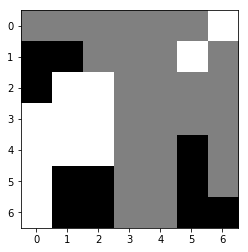

((5, 2), (4, 3)): n_v:   519 q_all:-0.009298 q:+0.021403 q_m:+0.133333 p:0.207018
((5, 5), (3, 3)): n_v:   465 q_all:+0.070863 q:+0.044091 q_m:+0.166667 p:0.052875
((1, 1), (1, 2)): n_v:   461 q_all:+0.062531 q:+0.052231 q_m:+0.133333 p:0.066074
((5, 2), (3, 3)): n_v:   414 q_all:-0.032483 q:+0.021544 q_m:+0.166667 p:0.199624
((1, 1), (3, 3)): n_v:   249 q_all:-0.008532 q:+0.037334 q_m:+0.166667 p:0.098445
((4, 5), (3, 3)): n_v:   248 q_all:+0.070683 q:+0.038251 q_m:+0.166667 p:0.028366
((5, 1), (3, 3)): n_v:   169 q_all:-0.048903 q:+0.010828 q_m:+0.166667 p:0.091227
((1, 0), (1, 2)): n_v:    78 q_all:+0.016993 q:-0.014746 q_m:+0.100000 p:0.023981
((4, 5), (3, 5)): n_v:    65 q_all:-0.014554 q:-0.030715 q_m:-0.000000 p:0.027392
((4, 5), (3, 4)): n_v:    58 q_all:-0.015551 q:-0.030985 q_m:-0.000000 p:0.024485
((4, 5), (2, 3)): n_v:    35 q_all:-0.010584 q:-0.004810 q_m:+0.100000 p:0.014317
((1, 1), (2, 3)): n_v:    26 q_all:-0.024844 q:-0.015069 q_m:+0.100000 p:0.012103
((4, 5), (5, 4))

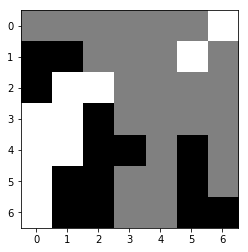

((2, 2), (3, 3)): n_v:  1992 q_all:+0.033866 q:+0.014556 q_m:+0.100000 p:0.889956
((1, 5), (3, 3)): n_v:   122 q_all:+0.005053 q:+0.002877 q_m:+0.066667 p:0.069374
((2, 1), (3, 3)): n_v:     5 q_all:-0.144470 q:-0.036026 q_m:+0.066667 p:0.005940
((2, 2), (4, 4)): n_v:     5 q_all:+0.015354 q:+0.024023 q_m:+0.066667 p:0.002893
((2, 2), (1, 3)): n_v:     5 q_all:-0.110286 q:-0.118212 q_m:-0.100000 p:0.005973
((4, 1), (5, 3)): n_v:     3 q_all:-0.140444 q:-0.081506 q_m:+0.133333 p:0.004077
((4, 1), (3, 3)): n_v:     3 q_all:-0.213992 q:-0.145921 q_m:+0.066667 p:0.004399
((3, 1), (5, 3)): n_v:     2 q_all:-0.111891 q:-0.027080 q_m:+0.133333 p:0.002945
((2, 2), (3, 4)): n_v:     1 q_all:-0.010510 q:-0.021986 q_m:-0.000000 p:0.001139
((3, 1), (3, 3)): n_v:     1 q_all:-0.198511 q:-0.102843 q_m:+0.066667 p:0.002591
((2, 2), (0, 0)): n_v:     1 q_all:-0.004528 q:-0.018196 q_m:-0.000000 p:0.000784
((2, 1), (1, 3)): n_v:     1 q_all:-0.148023 q:-0.175631 q_m:-0.133333 p:0.001413
((4, 1), (6, 3))

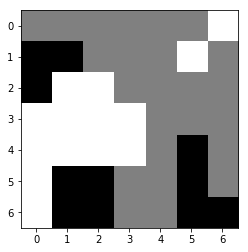

((4, 5), (3, 4)): n_v:  1822 q_all:-0.037873 q:-0.032536 q_m:+0.066667 p:0.446894
((1, 1), (2, 3)): n_v:   329 q_all:-0.058396 q:-0.011300 q_m:+0.100000 p:0.103281
((1, 1), (1, 2)): n_v:   309 q_all:+0.005565 q:+0.012063 q_m:+0.066667 p:0.030807
((4, 5), (2, 3)): n_v:   237 q_all:-0.023871 q:-0.000196 q_m:+0.100000 p:0.046893
((5, 2), (5, 3)): n_v:   198 q_all:-0.023573 q:-0.019938 q_m:+0.066667 p:0.039302
((4, 5), (4, 4)): n_v:   103 q_all:-0.023160 q:-0.035709 q_m:+0.066667 p:0.020257
((6, 1), (5, 3)): n_v:    69 q_all:-0.125935 q:-0.126061 q_m:+0.033333 p:0.037250
((5, 5), (3, 4)): n_v:    59 q_all:-0.039828 q:-0.045729 q_m:+0.033333 p:0.015058
((1, 0), (1, 2)): n_v:    50 q_all:-0.031135 q:-0.060652 q_m:+0.033333 p:0.011003
((5, 2), (3, 4)): n_v:    40 q_all:-0.121592 q:-0.062481 q_m:+0.033333 p:0.021160
((6, 5), (5, 3)): n_v:    37 q_all:-0.067836 q:-0.033623 q_m:+0.033333 p:0.012646
((4, 5), (3, 5)): n_v:    32 q_all:-0.072392 q:-0.085868 q_m:-0.066667 p:0.011479
((4, 5), (5, 4))

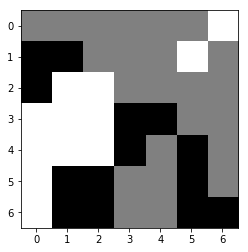

((4, 2), (5, 3)): n_v:  1499 q_all:+0.110197 q:+0.103245 q_m:+0.166667 p:0.101616
((1, 5), (2, 4)): n_v:   517 q_all:-0.006885 q:-0.009671 q_m:+0.100000 p:0.242017
((2, 2), (4, 4)): n_v:   270 q_all:+0.081067 q:+0.076515 q_m:+0.266667 p:0.045262
((4, 2), (4, 4)): n_v:   155 q_all:+0.034279 q:+0.025818 q_m:+0.266667 p:0.050916
((2, 2), (2, 3)): n_v:   144 q_all:+0.010588 q:+0.014591 q_m:+0.100000 p:0.058911
((2, 2), (2, 4)): n_v:   103 q_all:-0.032403 q:-0.036508 q_m:+0.066667 p:0.057577
((2, 2), (1, 3)): n_v:    80 q_all:-0.027076 q:-0.022599 q_m:-0.033333 p:0.043099
((1, 5), (2, 6)): n_v:    76 q_all:-0.052037 q:-0.062580 q_m:-0.033333 p:0.047380
((4, 2), (2, 4)): n_v:    50 q_all:-0.029619 q:-0.051820 q_m:+0.066667 p:0.027706
((3, 2), (4, 4)): n_v:    46 q_all:+0.016358 q:+0.048950 q_m:+0.266667 p:0.018145
((1, 5), (2, 5)): n_v:    34 q_all:+0.004599 q:-0.006778 q_m:+0.033333 p:0.014197
((2, 2), (0, 0)): n_v:    33 q_all:+0.021060 q:+0.032011 q_m:+0.066667 p:0.012262
((2, 1), (1, 2))

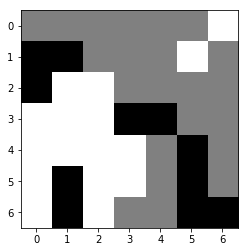

((3, 3), (1, 2)): n_v:   617 q_all:-0.028275 q:-0.097230 q_m:-0.033333 p:0.045544
((3, 3), (1, 4)): n_v:   421 q_all:-0.080120 q:-0.066463 q_m:-0.100000 p:0.109568
((3, 3), (5, 4)): n_v:   414 q_all:-0.148776 q:-0.149875 q_m:-0.033333 p:0.209864
((6, 5), (6, 3)): n_v:   371 q_all:-0.038394 q:-0.082198 q_m:+0.033333 p:0.040761
((6, 1), (6, 3)): n_v:   196 q_all:-0.155007 q:-0.159044 q_m:+0.033333 p:0.103835
((5, 5), (6, 3)): n_v:   188 q_all:-0.046670 q:-0.089548 q_m:+0.033333 p:0.026203
((5, 1), (6, 3)): n_v:   184 q_all:-0.135957 q:-0.073571 q_m:+0.033333 p:0.085108
((4, 5), (6, 3)): n_v:   129 q_all:-0.051182 q:-0.071995 q_m:+0.033333 p:0.020285
((4, 5), (5, 4)): n_v:   123 q_all:-0.194451 q:-0.162826 q_m:-0.000000 p:0.082590
((1, 1), (1, 2)): n_v:    64 q_all:-0.135034 q:-0.104284 q_m:-0.000000 p:0.029313
((3, 4), (5, 4)): n_v:    41 q_all:-0.191070 q:-0.190568 q_m:-0.033333 p:0.027308
((3, 4), (1, 4)): n_v:    37 q_all:-0.115027 q:-0.087767 q_m:-0.100000 p:0.014504
((3, 4), (1, 2))

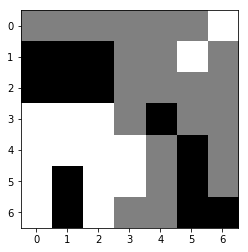

((4, 3), (5, 4)): n_v:   527 q_all:+0.063153 q:+0.055287 q_m:+0.266667 p:0.156431
((5, 2), (5, 4)): n_v:   272 q_all:+0.015613 q:-0.049602 q_m:+0.233333 p:0.136278
((3, 2), (5, 4)): n_v:   225 q_all:+0.050770 q:+0.022311 q_m:+0.233333 p:0.078983
((6, 2), (5, 4)): n_v:   194 q_all:+0.045220 q:+0.008578 q_m:+0.233333 p:0.072503
((4, 3), (2, 3)): n_v:   193 q_all:+0.125255 q:+0.041581 q_m:+0.233333 p:0.007437
((3, 2), (2, 3)): n_v:   165 q_all:+0.074642 q:+0.101171 q_m:+0.266667 p:0.040935
((3, 2), (3, 3)): n_v:   135 q_all:+0.069515 q:+0.084299 q_m:+0.200000 p:0.036605
((4, 2), (5, 4)): n_v:    96 q_all:+0.015029 q:-0.027630 q_m:+0.233333 p:0.048174
((4, 3), (6, 4)): n_v:    48 q_all:+0.014565 q:-0.017681 q_m:+0.166667 p:0.024296
((3, 2), (1, 3)): n_v:    38 q_all:+0.079594 q:+0.071063 q_m:+0.166667 p:0.008573
((3, 2), (1, 4)): n_v:    33 q_all:-0.060030 q:-0.030801 q_m:+0.033333 p:0.027203
((1, 5), (1, 4)): n_v:    32 q_all:+0.005402 q:-0.002948 q_m:+0.066667 p:0.017473
((0, 6), (1, 6))

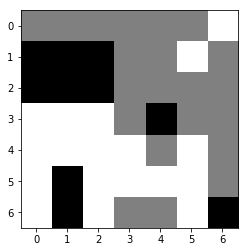

((2, 2), (4, 4)): n_v:  1822 q_all:-0.065686 q:-0.042855 q_m:+0.066667 p:0.807976
((3, 4), (4, 4)): n_v:    87 q_all:-0.056296 q:-0.044496 q_m:+0.100000 p:0.035361
((3, 4), (5, 6)): n_v:    86 q_all:-0.007166 q:-0.113256 q_m:-0.066667 p:0.016930
((6, 6), (4, 4)): n_v:    73 q_all:-0.055939 q:-0.051508 q_m:+0.066667 p:0.029670
((6, 6), (5, 6)): n_v:    53 q_all:+0.021440 q:-0.114748 q_m:-0.033333 p:0.004274
((2, 2), (2, 4)): n_v:    30 q_all:-0.149381 q:-0.139119 q_m:-0.200000 p:0.023932
((2, 2), (3, 3)): n_v:    25 q_all:-0.070000 q:-0.115277 q_m:-0.033333 p:0.011785
((3, 4), (2, 4)): n_v:    19 q_all:-0.171282 q:-0.153062 q_m:-0.166667 p:0.017661
((3, 4), (1, 6)): n_v:    19 q_all:-0.032408 q:-0.144474 q_m:-0.133333 p:0.005944
((6, 6), (6, 4)): n_v:    17 q_all:-0.103827 q:-0.125980 q_m:-0.000000 p:0.010391
((1, 2), (2, 4)): n_v:     4 q_all:-0.195462 q:-0.186032 q_m:-0.200000 p:0.004843
((1, 1), (3, 3)): n_v:     4 q_all:-0.126374 q:-0.194009 q_m:-0.066667 p:0.002920
((2, 1), (3, 3))

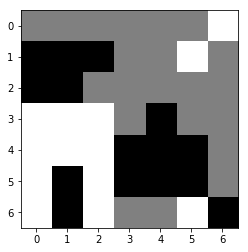

((3, 2), (3, 3)): n_v:  1790 q_all:+0.101305 q:+0.083949 q_m:+0.166667 p:0.264219
((1, 5), (3, 3)): n_v:   549 q_all:+0.085729 q:+0.070860 q_m:+0.133333 p:0.110386
((3, 1), (2, 2)): n_v:   281 q_all:+0.128147 q:+0.098838 q_m:+0.166667 p:0.015708
((6, 5), (5, 6)): n_v:   217 q_all:+0.082059 q:+0.119028 q_m:+0.166667 p:0.046259
((4, 2), (2, 4)): n_v:   133 q_all:+0.009839 q:-0.020352 q_m:-0.000000 p:0.061286
((3, 2), (2, 4)): n_v:    73 q_all:-0.008311 q:-0.009543 q_m:-0.000000 p:0.038183
((6, 2), (6, 4)): n_v:    51 q_all:+0.021135 q:-0.034499 q_m:+0.133333 p:0.021646
((6, 5), (6, 4)): n_v:    44 q_all:-0.028160 q:+0.032183 q_m:+0.166667 p:0.025944
((5, 2), (6, 4)): n_v:    40 q_all:+0.013466 q:-0.085598 q_m:+0.133333 p:0.018090
((4, 1), (3, 3)): n_v:    24 q_all:-0.145262 q:-0.073219 q_m:+0.133333 p:0.024050
((3, 1), (3, 3)): n_v:    14 q_all:-0.039383 q:-0.002773 q_m:+0.133333 p:0.009072
((5, 2), (3, 3)): n_v:    12 q_all:-0.036840 q:-0.001792 q_m:+0.133333 p:0.008001
((4, 2), (6, 4))

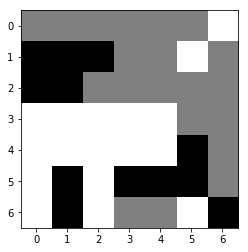

((4, 5), (3, 5)): n_v:   894 q_all:-0.100251 q:-0.096216 q_m:-0.000000 p:0.190548
((5, 3), (3, 5)): n_v:   474 q_all:-0.076680 q:-0.063800 q_m:-0.033333 p:0.062308
((4, 5), (2, 4)): n_v:   403 q_all:-0.058307 q:-0.086915 q_m:+0.033333 p:0.027636
((1, 1), (2, 2)): n_v:   398 q_all:-0.111428 q:-0.053828 q_m:+0.066667 p:0.100132
((1, 2), (2, 4)): n_v:   353 q_all:-0.077290 q:-0.092477 q_m:+0.033333 p:0.047198
((1, 2), (2, 3)): n_v:   125 q_all:-0.170079 q:-0.113579 q_m:+0.066667 p:0.056787
((5, 3), (6, 3)): n_v:   103 q_all:-0.123059 q:-0.071051 q_m:-0.000000 p:0.029735
((1, 2), (0, 3)): n_v:    66 q_all:-0.128146 q:-0.145088 q_m:-0.133333 p:0.020660
((1, 1), (2, 3)): n_v:    58 q_all:-0.161612 q:-0.140844 q_m:+0.033333 p:0.024910
((5, 4), (3, 5)): n_v:    55 q_all:-0.109858 q:-0.092285 q_m:-0.033333 p:0.013628
((2, 1), (2, 3)): n_v:    47 q_all:-0.128104 q:-0.124094 q_m:+0.033333 p:0.014654
((4, 5), (5, 6)): n_v:    46 q_all:-0.086327 q:-0.098956 q_m:-0.066667 p:0.007670
((5, 5), (6, 3))

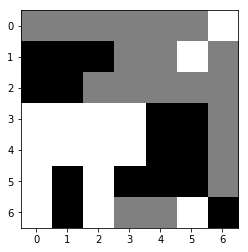

((3, 1), (2, 2)): n_v:   669 q_all:+0.144199 q:+0.174203 q_m:+0.233333 p:0.092831
((6, 5), (5, 6)): n_v:   629 q_all:+0.155696 q:+0.170644 q_m:+0.233333 p:0.058975
((1, 5), (2, 4)): n_v:   231 q_all:+0.117988 q:+0.080727 q_m:+0.166667 p:0.056400
((6, 5), (6, 4)): n_v:   184 q_all:+0.072790 q:+0.099436 q_m:+0.233333 p:0.077953
((6, 2), (6, 4)): n_v:   172 q_all:+0.085363 q:+0.043426 q_m:+0.200000 p:0.064524
((0, 6), (2, 6)): n_v:    53 q_all:+0.075679 q:+0.085666 q_m:+0.066667 p:0.022084
((1, 5), (2, 6)): n_v:    45 q_all:+0.079165 q:+0.094768 q_m:+0.100000 p:0.018150
((0, 6), (2, 4)): n_v:    34 q_all:+0.106775 q:+0.074903 q_m:+0.133333 p:0.010063
((3, 2), (2, 4)): n_v:    28 q_all:+0.019353 q:+0.042964 q_m:+0.133333 p:0.018444
((5, 2), (6, 4)): n_v:    26 q_all:+0.011546 q:-0.019292 q_m:+0.200000 p:0.017757
((6, 5), (4, 6)): n_v:    25 q_all:+0.068843 q:+0.098360 q_m:+0.200000 p:0.011308
((1, 5), (0, 4)): n_v:    24 q_all:+0.067923 q:+0.079527 q_m:+0.033333 p:0.010922
((5, 2), (6, 3))

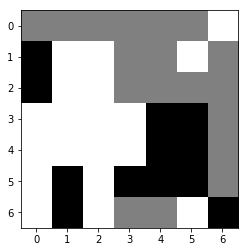

((3, 4), (2, 3)): n_v:  1726 q_all:-0.146089 q:-0.145047 q_m:+0.066667 p:0.637485
((3, 5), (2, 3)): n_v:   254 q_all:-0.129620 q:-0.155889 q_m:+0.033333 p:0.076909
((4, 5), (2, 3)): n_v:   119 q_all:-0.157189 q:-0.168261 q_m:+0.033333 p:0.049697
((4, 4), (2, 3)): n_v:   117 q_all:-0.259759 q:-0.187516 q_m:+0.033333 p:0.097607
((5, 5), (6, 3)): n_v:    29 q_all:-0.228917 q:-0.213695 q_m:-0.100000 p:0.020594
((5, 3), (6, 3)): n_v:    19 q_all:-0.217981 q:-0.197229 q_m:-0.066667 p:0.012468
((4, 4), (6, 3)): n_v:    18 q_all:-0.267108 q:-0.213777 q_m:-0.100000 p:0.015542
((6, 1), (6, 3)): n_v:    16 q_all:-0.256096 q:-0.267981 q_m:-0.100000 p:0.013862
((4, 5), (6, 3)): n_v:    13 q_all:-0.181300 q:-0.237696 q_m:-0.100000 p:0.006762
((3, 5), (5, 6)): n_v:    10 q_all:-0.139273 q:-0.267588 q_m:-0.166667 p:0.003677
((3, 4), (1, 3)): n_v:     9 q_all:-0.206683 q:-0.201410 q_m:-0.100000 p:0.005728
((5, 1), (6, 3)): n_v:     8 q_all:-0.239231 q:-0.181045 q_m:-0.100000 p:0.006052
((1, 0), (0, 1))

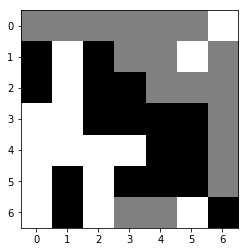

((1, 5), (2, 4)): n_v:  2337 q_all:+0.149552 q:+0.136648 q_m:+0.233333 p:0.606060
((0, 6), (2, 4)): n_v:   436 q_all:+0.135288 q:+0.125876 q_m:+0.200000 p:0.134586
((6, 5), (5, 6)): n_v:    55 q_all:+0.143090 q:+0.119041 q_m:+0.166667 p:0.015481
((0, 6), (2, 6)): n_v:    51 q_all:+0.038267 q:+0.031112 q_m:-0.000000 p:0.033369
((6, 5), (6, 4)): n_v:    45 q_all:+0.079038 q:+0.053281 q_m:+0.166667 p:0.022627
((1, 5), (1, 3)): n_v:    43 q_all:+0.175134 q:+0.142689 q_m:+0.133333 p:0.007498
((6, 5), (4, 6)): n_v:    37 q_all:+0.077535 q:+0.051863 q_m:+0.133333 p:0.019066
((4, 2), (2, 4)): n_v:    36 q_all:-0.036828 q:-0.060563 q_m:+0.200000 p:0.032579
((1, 5), (2, 6)): n_v:    30 q_all:+0.082039 q:+0.034837 q_m:+0.033333 p:0.015138
((6, 2), (6, 4)): n_v:    24 q_all:+0.096913 q:-0.009700 q_m:+0.133333 p:0.011022
((4, 3), (2, 4)): n_v:    18 q_all:+0.053561 q:+0.011425 q_m:+0.200000 p:0.010888
((1, 1), (0, 1)): n_v:    15 q_all:+0.141311 q:+0.138711 q_m:+0.100000 p:0.004503
((5, 2), (6, 4))

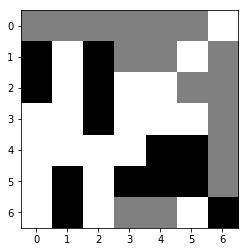

((1, 2), (1, 4)): n_v:  1127 q_all:-0.162248 q:-0.153124 q_m:-0.033333 p:0.266653
((3, 2), (1, 4)): n_v:   760 q_all:-0.114802 q:-0.126107 q_m:-0.033333 p:0.064568
((4, 5), (2, 5)): n_v:   566 q_all:-0.161274 q:-0.183270 q_m:+0.033333 p:0.131966
((2, 2), (1, 4)): n_v:   466 q_all:-0.163541 q:-0.151744 q_m:-0.033333 p:0.112211
((4, 4), (2, 5)): n_v:   192 q_all:-0.215450 q:-0.181842 q_m:+0.033333 p:0.077805
((5, 3), (6, 3)): n_v:   139 q_all:-0.187420 q:-0.167483 q_m:-0.066667 p:0.044318
((1, 2), (1, 3)): n_v:   130 q_all:-0.173686 q:-0.204978 q_m:-0.066667 p:0.035369
((4, 4), (6, 3)): n_v:    55 q_all:-0.174191 q:-0.177952 q_m:-0.100000 p:0.015343
((1, 2), (0, 3)): n_v:    53 q_all:-0.287132 q:-0.283684 q_m:-0.200000 p:0.034075
((3, 2), (1, 3)): n_v:    46 q_all:-0.205327 q:-0.194213 q_m:-0.100000 p:0.017137
((4, 5), (3, 6)): n_v:    37 q_all:-0.210749 q:-0.246031 q_m:-0.133333 p:0.014675
((5, 5), (6, 3)): n_v:    19 q_all:-0.209221 q:-0.176580 q_m:-0.100000 p:0.007575
((1, 0), (0, 1))

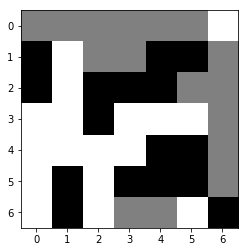

((0, 6), (2, 5)): n_v:  1418 q_all:+0.164710 q:+0.159281 q_m:+0.233333 p:0.482080
((3, 4), (2, 5)): n_v:   444 q_all:+0.192273 q:+0.150426 q_m:+0.266667 p:0.104521
((6, 5), (6, 4)): n_v:    91 q_all:+0.099512 q:+0.122484 q_m:+0.266667 p:0.054014
((6, 5), (5, 6)): n_v:    87 q_all:+0.225030 q:+0.163290 q_m:+0.266667 p:0.009565
((1, 1), (1, 3)): n_v:    70 q_all:+0.196372 q:+0.145077 q_m:+0.300000 p:0.015137
((0, 6), (0, 4)): n_v:    62 q_all:+0.116904 q:+0.092451 q_m:+0.166667 p:0.032512
((0, 6), (0, 5)): n_v:    38 q_all:+0.125130 q:+0.100624 q_m:+0.200000 p:0.019010
((6, 2), (6, 4)): n_v:    35 q_all:+0.144375 q:+0.060870 q_m:+0.233333 p:0.014601
((3, 5), (1, 3)): n_v:    29 q_all:+0.141087 q:+0.139919 q_m:+0.300000 p:0.012719
((5, 2), (6, 3)): n_v:    24 q_all:+0.074786 q:+0.112870 q_m:+0.200000 p:0.016183
((3, 5), (5, 6)): n_v:    15 q_all:+0.227517 q:+0.134612 q_m:+0.233333 p:0.001342
((1, 1), (0, 2)): n_v:    13 q_all:+0.080850 q:+0.043035 q_m:+0.066667 p:0.008744
((0, 6), (1, 6))

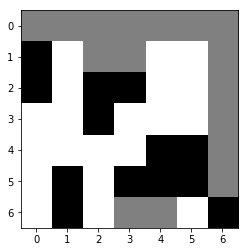

((3, 2), (1, 3)): n_v:   618 q_all:-0.109342 q:-0.202944 q_m:-0.100000 p:0.009623
((4, 5), (2, 6)): n_v:   535 q_all:-0.149643 q:-0.173419 q_m:-0.033333 p:0.086846
((4, 5), (3, 6)): n_v:   342 q_all:-0.220398 q:-0.206985 q_m:-0.066667 p:0.143651
((2, 2), (1, 3)): n_v:   312 q_all:-0.200822 q:-0.214170 q_m:-0.066667 p:0.108961
((5, 3), (6, 3)): n_v:   251 q_all:-0.211092 q:-0.149402 q_m:-0.066667 p:0.097083
((2, 3), (0, 5)): n_v:   176 q_all:-0.181347 q:-0.187700 q_m:-0.100000 p:0.048812
((2, 3), (0, 1)): n_v:   157 q_all:-0.216456 q:-0.206980 q_m:-0.166667 p:0.063895
((6, 1), (6, 3)): n_v:    45 q_all:-0.251272 q:-0.240035 q_m:-0.100000 p:0.023954
((4, 4), (6, 3)): n_v:    44 q_all:-0.174969 q:-0.160470 q_m:-0.100000 p:0.011252
((4, 4), (2, 6)): n_v:    42 q_all:-0.206192 q:-0.163460 q_m:-0.033333 p:0.015644
((2, 2), (0, 4)): n_v:    42 q_all:-0.145200 q:-0.207372 q_m:-0.100000 p:0.006195
((1, 0), (0, 0)): n_v:    38 q_all:-0.147530 q:-0.197184 q_m:-0.133333 p:0.005963
((2, 2), (0, 3))

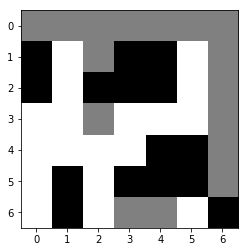

((1, 1), (3, 2)): n_v:  1083 q_all:+0.201382 q:+0.193842 q_m:+0.233333 p:0.005897
((2, 1), (3, 2)): n_v:   216 q_all:+0.120542 q:+0.194274 q_m:+0.266667 p:0.075657
((5, 2), (6, 4)): n_v:   193 q_all:+0.195776 q:-0.030159 q_m:+0.300000 p:0.004731
((3, 4), (1, 2)): n_v:   183 q_all:-0.015741 q:+0.062607 q_m:+0.300000 p:0.170525
((3, 1), (1, 2)): n_v:   155 q_all:+0.115976 q:+0.055918 q_m:+0.300000 p:0.057298
((3, 3), (1, 2)): n_v:    96 q_all:+0.091151 q:+0.070695 q_m:+0.300000 p:0.045875
((3, 0), (1, 2)): n_v:    38 q_all:-0.018129 q:+0.001970 q_m:+0.300000 p:0.036166
((4, 2), (6, 4)): n_v:    30 q_all:+0.085816 q:+0.005719 q_m:+0.300000 p:0.014115
((3, 0), (3, 2)): n_v:    29 q_all:+0.079811 q:+0.064042 q_m:+0.233333 p:0.014823
((6, 5), (6, 4)): n_v:    25 q_all:+0.105577 q:+0.059973 q_m:+0.333333 p:0.010358
((4, 0), (3, 2)): n_v:    23 q_all:+0.150588 q:+0.067194 q_m:+0.233333 p:0.004299
((1, 1), (1, 2)): n_v:    20 q_all:-0.039479 q:+0.088784 q_m:+0.333333 p:0.021015
((1, 5), (0, 4))

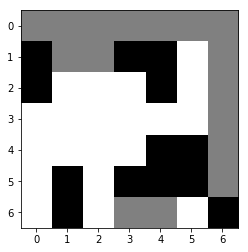

((1, 3), (1, 2)): n_v:   704 q_all:-0.188087 q:-0.157435 q_m:-0.000000 p:0.209860
((1, 0), (1, 2)): n_v:   497 q_all:-0.146581 q:-0.182782 q_m:-0.033333 p:0.068346
((2, 0), (1, 2)): n_v:   372 q_all:-0.151401 q:-0.192444 q_m:-0.033333 p:0.057810
((1, 4), (1, 2)): n_v:   332 q_all:-0.218981 q:-0.202173 q_m:-0.033333 p:0.138485
((2, 4), (1, 2)): n_v:   306 q_all:-0.203804 q:-0.179880 q_m:-0.033333 p:0.110022
((5, 3), (6, 3)): n_v:    80 q_all:-0.234805 q:-0.224296 q_m:-0.066667 p:0.038354
((6, 6), (4, 6)): n_v:    69 q_all:-0.302918 q:-0.313662 q_m:-0.166667 p:0.051311
((1, 0), (1, 1)): n_v:    63 q_all:-0.275843 q:-0.230371 q_m:-0.066667 p:0.040504
((1, 3), (0, 3)): n_v:    46 q_all:-0.295439 q:-0.335143 q_m:-0.200000 p:0.033458
((1, 3), (1, 1)): n_v:    45 q_all:-0.210351 q:-0.254266 q_m:-0.100000 p:0.017320
((6, 1), (6, 3)): n_v:    31 q_all:-0.314200 q:-0.301335 q_m:-0.100000 p:0.024594
((5, 1), (6, 3)): n_v:    20 q_all:-0.281283 q:-0.224717 q_m:-0.100000 p:0.013140
((4, 4), (6, 3))

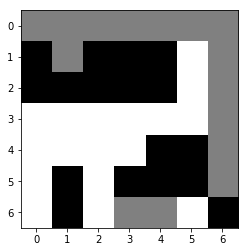

((3, 0), (1, 1)): n_v:  1745 q_all:+0.265826 q:+0.259920 q_m:+0.333333 p:0.333147
((1, 5), (0, 4)): n_v:   172 q_all:+0.114596 q:+0.103451 q_m:+0.166667 p:0.138460
((1, 5), (0, 3)): n_v:   148 q_all:+0.143450 q:+0.103928 q_m:+0.200000 p:0.101591
((6, 5), (6, 4)): n_v:   105 q_all:+0.086483 q:+0.121116 q_m:+0.233333 p:0.096283
((6, 5), (6, 3)): n_v:    63 q_all:+0.088323 q:+0.115095 q_m:+0.133333 p:0.057286
((3, 3), (1, 1)): n_v:    58 q_all:+0.196380 q:+0.232719 q_m:+0.333333 p:0.027611
((6, 5), (5, 6)): n_v:    49 q_all:+0.191969 q:+0.171359 q_m:+0.233333 p:0.024060
((5, 2), (6, 3)): n_v:    29 q_all:+0.088892 q:+0.133017 q_m:+0.166667 p:0.026211
((3, 2), (1, 1)): n_v:    25 q_all:+0.063670 q:+0.191174 q_m:+0.333333 p:0.025271
((1, 5), (1, 6)): n_v:    17 q_all:+0.029707 q:+0.023716 q_m:+0.033333 p:0.019103
((2, 5), (0, 4)): n_v:    10 q_all:+0.091762 q:+0.048935 q_m:+0.133333 p:0.009708
((2, 5), (0, 3)): n_v:     9 q_all:+0.118544 q:+0.086502 q_m:+0.200000 p:0.007636
((3, 1), (1, 1))

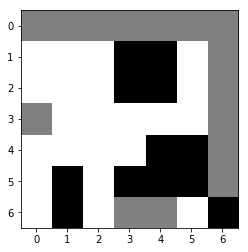

((5, 1), (3, 0)): n_v:  1584 q_all:-0.217533 q:-0.126885 q_m:-0.000000 p:0.281743
((4, 5), (3, 6)): n_v:  1158 q_all:-0.250662 q:-0.301491 q_m:-0.166667 p:0.335524
((5, 5), (3, 6)): n_v:   159 q_all:-0.298071 q:-0.309138 q_m:-0.200000 p:0.071766
((4, 4), (3, 6)): n_v:   126 q_all:-0.366510 q:-0.330058 q_m:-0.200000 p:0.086444
((5, 4), (3, 6)): n_v:   116 q_all:-0.348189 q:-0.326614 q_m:-0.200000 p:0.071944
((2, 4), (3, 6)): n_v:    99 q_all:-0.381150 q:-0.298102 q_m:-0.200000 p:0.072753
((1, 4), (3, 6)): n_v:    55 q_all:-0.399216 q:-0.310296 q_m:-0.200000 p:0.044244
((2, 3), (0, 1)): n_v:    20 q_all:-0.201868 q:-0.271412 q_m:-0.133333 p:0.002511
((1, 3), (0, 1)): n_v:    17 q_all:-0.222842 q:-0.288483 q_m:-0.133333 p:0.003206
((4, 5), (2, 6)): n_v:     9 q_all:-0.294940 q:-0.253905 q_m:-0.133333 p:0.004215
((5, 3), (6, 3)): n_v:     5 q_all:-0.348675 q:-0.287604 q_m:-0.166667 p:0.003484
((4, 4), (2, 6)): n_v:     3 q_all:-0.319983 q:-0.267839 q_m:-0.133333 p:0.001653
((1, 3), (0, 3))

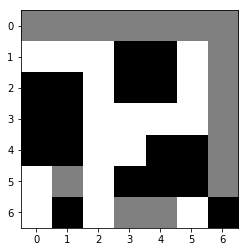

((4, 2), (5, 1)): n_v:  3240 q_all:+0.250798 q:+0.206513 q_m:+0.233333 p:0.332604
((3, 2), (5, 1)): n_v:     2 q_all:+0.053811 q:+0.094211 q_m:+0.200000 p:0.001762
((1, 2), (0, 3)): n_v:     0 q_all:-0.172915 q:-0.172915 q_m:+0.166667 p:0.000005
((1, 0), (0, 2)): n_v:     0 q_all:-0.253479 q:-0.253479 q_m:+0.066667 p:0.000021
((3, 5), (4, 6)): n_v:     0 q_all:-0.157300 q:-0.157300 q_m:+0.166667 p:0.000017
((3, 4), (3, 6)): n_v:     0 q_all:-0.226304 q:-0.226304 q_m:+0.066667 p:0.000000
((4, 3), (6, 3)): n_v:     0 q_all:-0.229650 q:-0.229650 q_m:+0.133333 p:0.000000
((2, 5), (4, 6)): n_v:     0 q_all:-0.169011 q:-0.169011 q_m:+0.133333 p:0.000000
((1, 5), (3, 6)): n_v:     0 q_all:-0.209654 q:-0.209654 q_m:+0.066667 p:0.000002
((3, 4), (2, 6)): n_v:     0 q_all:-0.236304 q:-0.236304 q_m:-0.000000 p:0.000000
((6, 5), (4, 6)): n_v:     0 q_all:-0.155849 q:-0.155849 q_m:+0.133333 p:0.000006
((1, 5), (0, 3)): n_v:     0 q_all:-0.171570 q:-0.171570 q_m:+0.133333 p:0.000001
((4, 3), (6, 4))

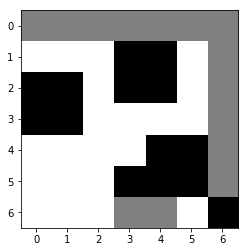

((1, 3), (0, 1)): n_v:  1588 q_all:-0.271773 q:-0.229775 q_m:-0.033333 p:0.329746
((2, 3), (0, 1)): n_v:   401 q_all:-0.272333 q:-0.223191 q_m:-0.033333 p:0.083918
((1, 3), (0, 2)): n_v:   298 q_all:-0.215319 q:-0.290021 q_m:-0.066667 p:0.014301
((4, 5), (2, 6)): n_v:   282 q_all:-0.261588 q:-0.219881 q_m:-0.033333 p:0.050449
((5, 3), (6, 3)): n_v:   244 q_all:-0.263556 q:-0.204020 q_m:-0.066667 p:0.044809
((1, 4), (0, 5)): n_v:   221 q_all:-0.298977 q:-0.281399 q_m:-0.133333 p:0.063034
((1, 3), (0, 5)): n_v:   199 q_all:-0.317919 q:-0.318650 q_m:-0.166667 p:0.067598
((4, 5), (3, 6)): n_v:   168 q_all:-0.284484 q:-0.268190 q_m:-0.066667 p:0.041160
((2, 3), (0, 5)): n_v:   102 q_all:-0.325496 q:-0.308501 q_m:-0.166667 p:0.036793
((1, 3), (0, 4)): n_v:    84 q_all:-0.262312 q:-0.309473 q_m:-0.133333 p:0.015295
((2, 0), (0, 1)): n_v:    81 q_all:-0.220310 q:-0.271188 q_m:-0.033333 p:0.004699
((1, 3), (0, 3)): n_v:    78 q_all:-0.305029 q:-0.350665 q_m:-0.133333 p:0.023487
((1, 4), (0, 2))

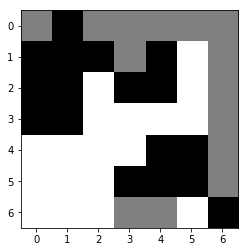

((2, 2), (1, 3)): n_v:  2719 q_all:+0.320789 q:+0.281579 q_m:+0.333333 p:0.734147
((1, 5), (1, 3)): n_v:   255 q_all:+0.265112 q:+0.249315 q_m:+0.300000 p:0.117351
((6, 5), (6, 4)): n_v:    28 q_all:+0.162139 q:+0.198975 q_m:+0.266667 p:0.022867
((5, 2), (6, 4)): n_v:    20 q_all:-0.052974 q:-0.011755 q_m:+0.233333 p:0.031280
((2, 2), (0, 4)): n_v:    20 q_all:+0.068180 q:+0.025346 q_m:+0.100000 p:0.024003
((1, 5), (0, 4)): n_v:    19 q_all:+0.061070 q:+0.078812 q_m:+0.133333 p:0.023304
((6, 2), (6, 4)): n_v:    18 q_all:+0.189788 q:+0.150329 q_m:+0.233333 p:0.012717
((3, 5), (1, 3)): n_v:     4 q_all:+0.214890 q:+0.248259 q_m:+0.300000 p:0.002972
((2, 5), (1, 3)): n_v:     4 q_all:+0.181609 q:+0.222698 q_m:+0.300000 p:0.003178
((4, 2), (6, 4)): n_v:     4 q_all:-0.090267 q:-0.043339 q_m:+0.233333 p:0.006686
((3, 4), (1, 3)): n_v:     3 q_all:+0.155092 q:+0.226701 q_m:+0.300000 p:0.002423
((6, 5), (5, 6)): n_v:     2 q_all:+0.245923 q:+0.228433 q_m:+0.266667 p:0.001437
((3, 2), (1, 3))

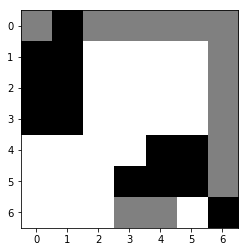

((0, 1), (0, 3)): n_v:  2525 q_all:-0.285879 q:-0.317446 q_m:-0.133333 p:0.464302
((1, 1), (0, 3)): n_v:   294 q_all:-0.329037 q:-0.336638 q_m:-0.133333 p:0.092264
((4, 5), (6, 3)): n_v:   265 q_all:-0.319890 q:-0.348071 q_m:-0.200000 p:0.075794
((5, 5), (6, 3)): n_v:   242 q_all:-0.357618 q:-0.273139 q_m:-0.200000 p:0.096702
((4, 4), (6, 3)): n_v:   220 q_all:-0.321189 q:-0.271322 q_m:-0.200000 p:0.063783
((5, 3), (6, 3)): n_v:   174 q_all:-0.339418 q:-0.283992 q_m:-0.166667 p:0.059903
((2, 1), (0, 3)): n_v:    64 q_all:-0.320166 q:-0.372312 q_m:-0.133333 p:0.018490
((4, 5), (2, 6)): n_v:    40 q_all:-0.326243 q:-0.280184 q_m:-0.133333 p:0.012113
((0, 1), (0, 2)): n_v:    24 q_all:-0.362784 q:-0.303058 q_m:-0.166667 p:0.010224
((4, 4), (2, 6)): n_v:     9 q_all:-0.352259 q:-0.288230 q_m:-0.133333 p:0.003543
((5, 3), (6, 4)): n_v:     9 q_all:-0.391223 q:-0.301933 q_m:-0.233333 p:0.004883
((6, 6), (6, 4)): n_v:     4 q_all:-0.411532 q:-0.343382 q_m:-0.266667 p:0.002624
((4, 5), (3, 6))

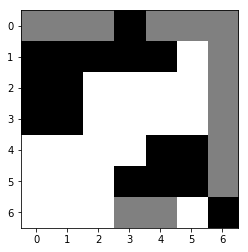

((1, 5), (0, 4)): n_v:  3216 q_all:+0.373462 q:+0.356596 q_m:+0.366667 p:0.500775
((6, 5), (6, 4)): n_v:   784 q_all:+0.223096 q:+0.273870 q_m:+0.366667 p:0.481955
((2, 4), (0, 2)): n_v:     7 q_all:+0.257527 q:+0.264211 q_m:+0.400000 p:0.003981
((2, 2), (0, 4)): n_v:     5 q_all:+0.198349 q:+0.214735 q_m:+0.333333 p:0.004143
((6, 2), (6, 4)): n_v:     4 q_all:+0.191358 q:+0.224228 q_m:+0.333333 p:0.002787
((2, 5), (0, 4)): n_v:     3 q_all:+0.220756 q:+0.265449 q_m:+0.333333 p:0.001925
((4, 2), (6, 4)): n_v:     2 q_all:+0.022909 q:+0.036625 q_m:+0.333333 p:0.003022
((2, 4), (0, 6)): n_v:     0 q_all:+0.106873 q:+0.106873 q_m:+0.133333 p:0.000000
((4, 1), (6, 3)): n_v:     0 q_all:+0.068229 q:+0.068229 q_m:+0.266667 p:0.000002
((2, 4), (0, 5)): n_v:     0 q_all:+0.159902 q:+0.159902 q_m:+0.200000 p:0.000000
((2, 2), (0, 2)): n_v:     0 q_all:+0.293814 q:+0.187627 q_m:+0.400000 p:0.000030
((3, 4), (3, 6)): n_v:     0 q_all:+0.128450 q:+0.128450 q_m:+0.200000 p:0.000000
((4, 3), (6, 3))

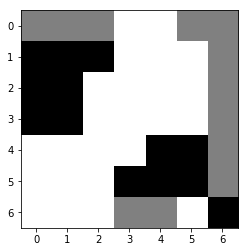

((1, 1), (0, 2)): n_v:  2238 q_all:-0.266146 q:-0.295320 q_m:-0.200000 p:0.097057
((5, 3), (6, 3)): n_v:   772 q_all:-0.376235 q:-0.264479 q_m:-0.200000 p:0.194672
((4, 5), (2, 6)): n_v:   278 q_all:-0.345008 q:-0.289447 q_m:-0.166667 p:0.039454
((5, 5), (6, 3)): n_v:   257 q_all:-0.375282 q:-0.258534 q_m:-0.233333 p:0.063652
((4, 4), (6, 3)): n_v:   194 q_all:-0.374986 q:-0.267644 q_m:-0.233333 p:0.048255
((4, 5), (6, 3)): n_v:   188 q_all:-0.389123 q:-0.307553 q_m:-0.233333 p:0.055738
((5, 3), (6, 4)): n_v:   175 q_all:-0.398657 q:-0.289017 q_m:-0.266667 p:0.057887
((1, 0), (0, 2)): n_v:    99 q_all:-0.376313 q:-0.308125 q_m:-0.233333 p:0.024883
((2, 0), (0, 2)): n_v:    51 q_all:-0.385658 q:-0.348921 q_m:-0.233333 p:0.014654
((4, 5), (3, 6)): n_v:    36 q_all:-0.394748 q:-0.316219 q_m:-0.200000 p:0.011597
((4, 4), (2, 6)): n_v:    35 q_all:-0.395343 q:-0.306733 q_m:-0.166667 p:0.011313
((6, 6), (6, 4)): n_v:    33 q_all:-0.430812 q:-0.333003 q_m:-0.300000 p:0.014384
((1, 0), (0, 1))

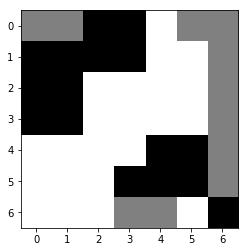

((6, 5), (5, 6)): n_v:  2215 q_all:+0.401799 q:+0.437840 q_m:+0.433333 p:0.027011
((6, 5), (6, 4)): n_v:  1017 q_all:+0.204460 q:+0.364040 q_m:+0.433333 p:0.597832
((0, 4), (0, 5)): n_v:   427 q_all:+0.316499 q:+0.242768 q_m:+0.233333 p:0.065280
((6, 2), (6, 4)): n_v:    65 q_all:+0.231190 q:+0.296268 q_m:+0.400000 p:0.031949
((5, 2), (6, 3)): n_v:    39 q_all:+0.189587 q:+0.360427 q_m:+0.366667 p:0.025718
((6, 5), (6, 3)): n_v:    24 q_all:+0.202350 q:+0.322658 q_m:+0.333333 p:0.014413
((2, 3), (0, 1)): n_v:    19 q_all:+0.242127 q:+0.300217 q_m:+0.466667 p:0.008314
((1, 5), (1, 6)): n_v:    17 q_all:+0.195199 q:+0.209635 q_m:+0.233333 p:0.010955
((3, 5), (4, 6)): n_v:    12 q_all:+0.271431 q:+0.301636 q_m:+0.366667 p:0.003884
((2, 2), (0, 1)): n_v:     8 q_all:+0.308990 q:+0.345871 q_m:+0.466667 p:0.001528
((2, 5), (3, 6)): n_v:     8 q_all:+0.331325 q:+0.288617 q_m:+0.300000 p:0.000752
((4, 2), (6, 4)): n_v:     4 q_all:+0.074072 q:+0.080942 q_m:+0.400000 p:0.005012
((1, 5), (2, 6))

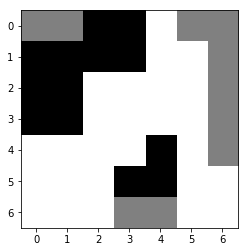

((4, 4), (2, 6)): n_v:  1447 q_all:-0.391402 q:-0.342522 q_m:-0.233333 p:0.389755
((4, 4), (6, 3)): n_v:   944 q_all:-0.316419 q:-0.285672 q_m:-0.300000 p:0.029632
((0, 3), (0, 5)): n_v:   546 q_all:-0.387237 q:-0.399645 q_m:-0.233333 p:0.139909
((5, 4), (4, 6)): n_v:   444 q_all:-0.356070 q:-0.277997 q_m:-0.166667 p:0.069736
((0, 3), (0, 1)): n_v:   141 q_all:-0.549154 q:-0.574911 q_m:-0.433333 p:0.109301
((5, 3), (6, 3)): n_v:   134 q_all:-0.394265 q:-0.284394 q_m:-0.266667 p:0.037577
((4, 4), (3, 6)): n_v:    61 q_all:-0.373455 q:-0.354486 q_m:-0.233333 p:0.012936
((5, 3), (6, 4)): n_v:    55 q_all:-0.444472 q:-0.336446 q_m:-0.266667 p:0.024020
((5, 4), (3, 6)): n_v:    54 q_all:-0.392512 q:-0.320319 q_m:-0.233333 p:0.014882
((1, 3), (0, 5)): n_v:    43 q_all:-0.490827 q:-0.410661 q_m:-0.233333 p:0.025465
((4, 4), (4, 6)): n_v:    43 q_all:-0.434449 q:-0.359811 q_m:-0.166667 p:0.017442
((1, 3), (0, 1)): n_v:    22 q_all:-0.566870 q:-0.597232 q_m:-0.433333 p:0.018745
((0, 2), (0, 1))

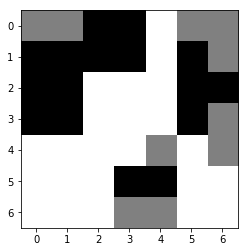

((3, 3), (4, 4)): n_v:  1205 q_all:+0.417908 q:+0.445375 q_m:+0.466667 p:0.172053
((5, 6), (4, 4)): n_v:   724 q_all:+0.437575 q:+0.397328 q_m:+0.433333 p:0.053032
((6, 5), (4, 4)): n_v:   211 q_all:+0.416791 q:+0.407299 q_m:+0.433333 p:0.030854
((2, 3), (0, 1)): n_v:   169 q_all:+0.365905 q:+0.278579 q_m:+0.500000 p:0.054347
((2, 2), (4, 4)): n_v:   139 q_all:+0.446855 q:+0.339618 q_m:+0.433333 p:0.004832
((2, 2), (0, 1)): n_v:   119 q_all:+0.433540 q:+0.249524 q_m:+0.500000 p:0.010498
((0, 4), (1, 6)): n_v:    61 q_all:+0.395040 q:+0.249682 q_m:+0.433333 p:0.013854
((6, 6), (4, 4)): n_v:    59 q_all:+0.387550 q:+0.434359 q_m:+0.433333 p:0.014718
((0, 4), (0, 5)): n_v:    53 q_all:+0.232608 q:+0.197317 q_m:+0.333333 p:0.042912
((6, 2), (4, 4)): n_v:    16 q_all:+0.348742 q:+0.368023 q_m:+0.433333 p:0.006257
((2, 3), (0, 5)): n_v:    13 q_all:+0.059796 q:+0.026767 q_m:+0.300000 p:0.019033
((4, 5), (3, 6)): n_v:    13 q_all:+0.342447 q:+0.327677 q_m:+0.466667 p:0.005618
((3, 4), (1, 6))

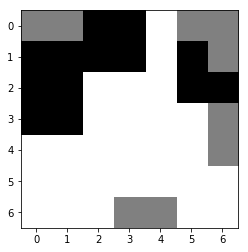

((2, 6), (4, 6)): n_v:  1900 q_all:-0.394507 q:-0.393994 q_m:-0.200000 p:0.549842
((2, 5), (4, 6)): n_v:   485 q_all:-0.436598 q:-0.403492 q_m:-0.200000 p:0.215402
((1, 5), (0, 5)): n_v:    53 q_all:-0.473164 q:-0.416115 q_m:-0.300000 p:0.030372
((2, 6), (0, 5)): n_v:    46 q_all:-0.461388 q:-0.469606 q_m:-0.333333 p:0.024269
((0, 3), (0, 5)): n_v:    27 q_all:-0.446297 q:-0.519461 q_m:-0.333333 p:0.013132
((0, 3), (0, 1)): n_v:    25 q_all:-0.555447 q:-0.569505 q_m:-0.466667 p:0.022593
((2, 5), (0, 5)): n_v:    13 q_all:-0.493320 q:-0.471856 q_m:-0.333333 p:0.008676
((2, 0), (0, 1)): n_v:    12 q_all:-0.612422 q:-0.590497 q_m:-0.466667 p:0.013721
((0, 2), (0, 1)): n_v:     9 q_all:-0.568148 q:-0.564031 q_m:-0.433333 p:0.008593
((1, 5), (3, 6)): n_v:     5 q_all:-0.573513 q:-0.533429 q_m:-0.333333 p:0.005281
((2, 5), (3, 6)): n_v:     3 q_all:-0.564575 q:-0.549777 q_m:-0.300000 p:0.003535
((2, 5), (0, 6)): n_v:     3 q_all:-0.557675 q:-0.509858 q_m:-0.466667 p:0.003233
((1, 3), (0, 1))

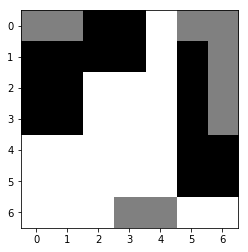

((0, 4), (0, 5)): n_v:  1144 q_all:+0.358441 q:+0.340455 q_m:+0.300000 p:0.324874
((0, 4), (2, 6)): n_v:   647 q_all:+0.437456 q:+0.423160 q_m:+0.400000 p:0.015029
((2, 2), (0, 1)): n_v:   553 q_all:+0.440535 q:+0.377502 q_m:+0.466667 p:0.006545
((1, 4), (3, 6)): n_v:   386 q_all:+0.436550 q:+0.462724 q_m:+0.466667 p:0.009810
((0, 4), (1, 6)): n_v:   357 q_all:+0.394699 q:+0.345543 q_m:+0.333333 p:0.058685
((2, 4), (3, 6)): n_v:   138 q_all:+0.397339 q:+0.434072 q_m:+0.466667 p:0.020725
((5, 4), (3, 6)): n_v:   135 q_all:+0.381005 q:+0.417348 q_m:+0.466667 p:0.027584
((5, 3), (6, 4)): n_v:    68 q_all:+0.294378 q:+0.391031 q_m:+0.300000 p:0.034172
((4, 4), (3, 6)): n_v:    23 q_all:+0.271225 q:+0.282824 q_m:+0.466667 p:0.012835
((0, 4), (0, 6)): n_v:    14 q_all:+0.355671 q:+0.270709 q_m:+0.266667 p:0.004241
((4, 4), (2, 6)): n_v:    10 q_all:+0.282774 q:+0.232097 q_m:+0.400000 p:0.005606
((1, 4), (1, 6)): n_v:     5 q_all:+0.246787 q:+0.265626 q_m:+0.333333 p:0.003340
((2, 3), (0, 1))

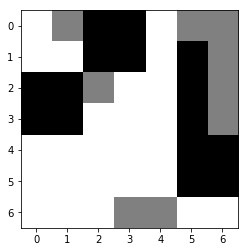

((1, 5), (0, 5)): n_v:   488 q_all:-0.437179 q:-0.356604 q_m:-0.166667 p:0.317794
((0, 2), (0, 1)): n_v:   477 q_all:-0.433155 q:-0.320422 q_m:-0.100000 p:0.301614
((0, 3), (2, 2)): n_v:   225 q_all:-0.327267 q:-0.398708 q_m:-0.066667 p:0.027663
((1, 2), (2, 2)): n_v:   138 q_all:-0.330541 q:-0.369621 q_m:-0.033333 p:0.019235
((1, 3), (0, 1)): n_v:   137 q_all:-0.364450 q:-0.333840 q_m:-0.133333 p:0.041178
((0, 2), (2, 2)): n_v:    51 q_all:-0.344253 q:-0.416826 q_m:-0.066667 p:0.010779
((1, 3), (0, 5)): n_v:    38 q_all:-0.472547 q:-0.429435 q_m:-0.200000 p:0.031481
((0, 3), (0, 5)): n_v:    37 q_all:-0.418441 q:-0.451797 q_m:-0.200000 p:0.020699
((2, 0), (0, 1)): n_v:    37 q_all:-0.425815 q:-0.380970 q_m:-0.133333 p:0.022621
((2, 5), (0, 5)): n_v:    35 q_all:-0.471875 q:-0.394069 q_m:-0.200000 p:0.029034
((0, 3), (0, 1)): n_v:    34 q_all:-0.371235 q:-0.345997 q_m:-0.133333 p:0.011715
((2, 1), (0, 1)): n_v:    23 q_all:-0.367473 q:-0.318794 q_m:-0.133333 p:0.007505
((5, 5), (6, 3))

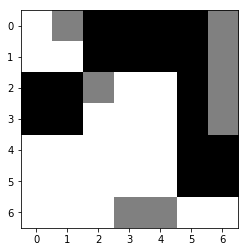

((1, 0), (2, 2)): n_v:   948 q_all:+0.477668 q:+0.371498 q_m:+0.433333 p:0.072030
((1, 1), (2, 2)): n_v:   666 q_all:+0.417170 q:+0.494798 q_m:+0.466667 p:0.220542
((0, 0), (2, 2)): n_v:   227 q_all:+0.456560 q:+0.432358 q_m:+0.433333 p:0.037403
((2, 4), (3, 6)): n_v:   197 q_all:+0.486573 q:+0.354359 q_m:+0.433333 p:0.006328
((2, 4), (2, 2)): n_v:    63 q_all:+0.340872 q:+0.370077 q_m:+0.433333 p:0.041460
((4, 4), (2, 2)): n_v:    52 q_all:+0.326497 q:+0.330534 q_m:+0.433333 p:0.037750
((5, 4), (3, 6)): n_v:    27 q_all:+0.417763 q:+0.256577 q_m:+0.433333 p:0.009132
((4, 0), (2, 2)): n_v:    18 q_all:+0.354193 q:+0.354168 q_m:+0.433333 p:0.011151
((3, 4), (2, 2)): n_v:    16 q_all:+0.285744 q:+0.348112 q_m:+0.433333 p:0.014817
((2, 3), (0, 1)): n_v:    10 q_all:+0.397961 q:+0.156549 q_m:+0.300000 p:0.003601
((4, 2), (2, 2)): n_v:     9 q_all:+0.248331 q:+0.188006 q_m:+0.433333 p:0.009830
((4, 3), (2, 2)): n_v:     4 q_all:+0.113883 q:+0.163008 q_m:+0.433333 p:0.007311
((4, 4), (3, 6))

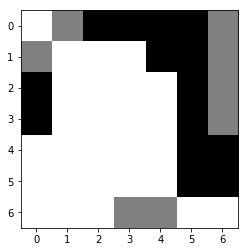

((0, 2), (1, 0)): n_v:   641 q_all:-0.413831 q:-0.394366 q_m:-0.233333 p:0.060999
((5, 5), (6, 3)): n_v:   584 q_all:-0.456873 q:-0.364206 q_m:-0.166667 p:0.152266
((0, 2), (0, 1)): n_v:   281 q_all:-0.572333 q:-0.431597 q_m:-0.200000 p:0.198764
((3, 0), (1, 0)): n_v:   272 q_all:-0.454384 q:-0.387719 q_m:-0.233333 p:0.068262
((2, 0), (0, 1)): n_v:   236 q_all:-0.480050 q:-0.350992 q_m:-0.233333 p:0.082752
((4, 5), (6, 3)): n_v:   177 q_all:-0.487154 q:-0.450804 q_m:-0.166667 p:0.066729
((4, 6), (6, 4)): n_v:   123 q_all:-0.515920 q:-0.410052 q_m:-0.233333 p:0.059614
((5, 5), (6, 4)): n_v:   115 q_all:-0.484043 q:-0.358014 q_m:-0.200000 p:0.042215
((0, 5), (1, 6)): n_v:    93 q_all:-0.521115 q:-0.485801 q_m:-0.400000 p:0.047657
((5, 6), (6, 4)): n_v:    41 q_all:-0.555969 q:-0.389742 q_m:-0.233333 p:0.026411
((0, 3), (0, 1)): n_v:    39 q_all:-0.574995 q:-0.474707 q_m:-0.233333 p:0.028242
((2, 0), (1, 0)): n_v:    36 q_all:-0.575588 q:-0.374509 q_m:-0.200000 p:0.026118
((0, 4), (1, 6))

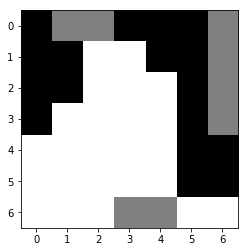

((1, 2), (0, 1)): n_v:  1977 q_all:+0.453101 q:+0.507887 q_m:+0.466667 p:0.586915
((1, 3), (0, 1)): n_v:   150 q_all:+0.473123 q:+0.411978 q_m:+0.433333 p:0.032323
((5, 3), (6, 4)): n_v:    79 q_all:+0.290414 q:+0.397798 q_m:+0.333333 p:0.076195
((1, 2), (0, 2)): n_v:    55 q_all:+0.407084 q:+0.439318 q_m:+0.400000 p:0.026740
((2, 4), (3, 6)): n_v:    41 q_all:+0.433214 q:+0.430733 q_m:+0.500000 p:0.015554
((2, 2), (0, 1)): n_v:    27 q_all:+0.306804 q:+0.254776 q_m:+0.433333 p:0.022959
((5, 4), (3, 6)): n_v:    25 q_all:+0.383266 q:+0.404268 q_m:+0.500000 p:0.014727
((6, 2), (6, 4)): n_v:    15 q_all:+0.402925 q:+0.321520 q_m:+0.300000 p:0.007937
((2, 3), (0, 1)): n_v:    11 q_all:+0.258200 q:+0.276746 q_m:+0.433333 p:0.012559
((2, 4), (1, 6)): n_v:     6 q_all:+0.332355 q:+0.283116 q_m:+0.433333 p:0.005171
((4, 4), (3, 6)): n_v:     4 q_all:+0.263264 q:+0.278869 q_m:+0.500000 p:0.004694
((6, 6), (6, 4)): n_v:     2 q_all:+0.236865 q:+0.311849 q_m:+0.300000 p:0.002249
((3, 4), (1, 6))

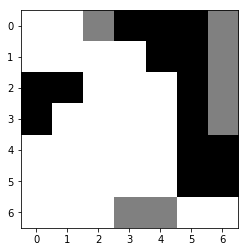

((0, 3), (0, 2)): n_v:  2439 q_all:-0.425859 q:-0.385590 q_m:-0.166667 p:0.417862
((0, 4), (0, 2)): n_v:   561 q_all:-0.474879 q:-0.402313 q_m:-0.200000 p:0.186263
((1, 4), (0, 2)): n_v:   324 q_all:-0.597135 q:-0.482829 q_m:-0.200000 p:0.237551
((2, 0), (0, 2)): n_v:   158 q_all:-0.456665 q:-0.425880 q_m:-0.200000 p:0.043552
((5, 5), (6, 4)): n_v:    70 q_all:-0.533374 q:-0.487932 q_m:-0.233333 p:0.036956
((4, 6), (6, 4)): n_v:    69 q_all:-0.550146 q:-0.549465 q_m:-0.266667 p:0.040215
((2, 1), (0, 2)): n_v:    34 q_all:-0.490504 q:-0.410793 q_m:-0.200000 p:0.013219
((5, 6), (6, 4)): n_v:    17 q_all:-0.590127 q:-0.492185 q_m:-0.266667 p:0.012409
((4, 5), (6, 4)): n_v:    11 q_all:-0.649033 q:-0.669073 q_m:-0.266667 p:0.010701
((5, 5), (6, 3)): n_v:     2 q_all:-0.476257 q:-0.418378 q_m:-0.200000 p:0.000857
((0, 5), (1, 6)): n_v:     0 q_all:-0.530165 q:-0.626997 q_m:-0.433333 p:0.000001
((0, 5), (2, 6)): n_v:     0 q_all:-0.554411 q:-0.642156 q_m:-0.466667 p:0.000000
((4, 5), (2, 6))

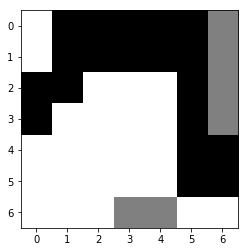

((5, 4), (3, 6)): n_v:  1695 q_all:+0.408667 q:+0.425333 q_m:+0.433333 p:0.153771
((2, 4), (3, 6)): n_v:  1193 q_all:+0.395211 q:+0.487186 q_m:+0.433333 p:0.157649
((5, 3), (6, 4)): n_v:   465 q_all:+0.330507 q:+0.456672 q_m:+0.266667 p:0.154572
((6, 5), (6, 3)): n_v:   186 q_all:+0.422566 q:+0.249753 q_m:+0.166667 p:0.009213
((4, 4), (3, 6)): n_v:   164 q_all:+0.265141 q:+0.321718 q_m:+0.433333 p:0.087859
((6, 2), (6, 4)): n_v:   105 q_all:+0.308210 q:+0.382819 q_m:+0.233333 p:0.042431
((6, 6), (6, 4)): n_v:    45 q_all:+0.239287 q:+0.353238 q_m:+0.233333 p:0.027882
((2, 4), (1, 6)): n_v:    33 q_all:+0.314619 q:+0.346563 q_m:+0.366667 p:0.012281
((2, 4), (0, 6)): n_v:    19 q_all:+0.273301 q:+0.297543 q_m:+0.300000 p:0.009486
((5, 2), (6, 3)): n_v:    19 q_all:+0.224596 q:+0.295534 q_m:+0.200000 p:0.012583
((3, 4), (1, 6)): n_v:    18 q_all:+0.196435 q:+0.292997 q_m:+0.366667 p:0.013468
((3, 4), (3, 6)): n_v:    11 q_all:+0.254871 q:+0.327869 q_m:+0.433333 p:0.006559
((4, 4), (2, 6))

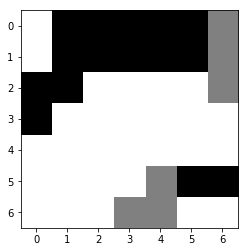

((5, 5), (5, 4)): n_v:  2233 q_all:-0.413558 q:-0.499472 q_m:-0.066667 p:0.763464
((5, 6), (5, 4)): n_v:   863 q_all:-0.385090 q:-0.439568 q_m:-0.100000 p:0.211494
((5, 5), (6, 3)): n_v:   133 q_all:-0.321868 q:-0.317531 q_m:-0.233333 p:0.003871
((1, 5), (2, 6)): n_v:    28 q_all:-0.482393 q:-0.545955 q_m:-0.200000 p:0.016193
((0, 5), (2, 6)): n_v:     4 q_all:-0.537133 q:-0.614163 q_m:-0.233333 p:0.003366
((1, 4), (0, 6)): n_v:     0 q_all:-0.579197 q:-0.725061 q_m:-0.433333 p:0.000001
((0, 4), (0, 6)): n_v:     0 q_all:-0.557613 q:-0.681892 q_m:-0.433333 p:0.000003
((5, 6), (6, 4)): n_v:     0 q_all:-0.644796 q:-0.644796 q_m:-0.300000 p:0.000032
((0, 5), (0, 6)): n_v:     0 q_all:-0.482702 q:-0.565405 q_m:-0.400000 p:0.000042
((0, 5), (1, 6)): n_v:     0 q_all:-0.612557 q:-0.612557 q_m:-0.333333 p:0.000156
((0, 4), (1, 6)): n_v:     0 q_all:-0.626577 q:-0.626577 q_m:-0.366667 p:0.000083
((0, 4), (2, 6)): n_v:     0 q_all:-0.660599 q:-0.660599 q_m:-0.233333 p:0.000142
((1, 4), (2, 6))

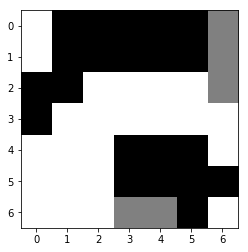

((6, 2), (6, 4)): n_v:  1903 q_all:+0.389199 q:+0.372802 q_m:+0.333333 p:0.455420
((2, 5), (1, 6)): n_v:  1073 q_all:+0.406492 q:+0.284414 q_m:+0.233333 p:0.198485
((6, 6), (6, 4)): n_v:   219 q_all:+0.291788 q:+0.321294 q_m:+0.333333 p:0.119908
((4, 6), (6, 4)): n_v:   133 q_all:+0.307843 q:+0.263961 q_m:+0.333333 p:0.065342
((5, 2), (6, 4)): n_v:    69 q_all:+0.177498 q:+0.167668 q_m:+0.333333 p:0.062746
((5, 2), (6, 3)): n_v:    26 q_all:+0.192381 q:+0.159783 q_m:+0.233333 p:0.022176
((3, 6), (1, 6)): n_v:    20 q_all:+0.252019 q:+0.186731 q_m:+0.200000 p:0.013751
((4, 2), (6, 4)): n_v:    12 q_all:+0.049822 q:+0.054536 q_m:+0.333333 p:0.016300
((6, 1), (6, 3)): n_v:     3 q_all:-0.115277 q:+0.010632 q_m:+0.200000 p:0.005318
((2, 5), (2, 6)): n_v:     1 q_all:+0.181010 q:+0.236358 q_m:+0.166667 p:0.001503
((2, 4), (0, 6)): n_v:     0 q_all:-0.001231 q:-0.001231 q_m:+0.200000 p:0.000124
((4, 2), (6, 3)): n_v:     0 q_all:-0.255483 q:-0.255483 q_m:+0.200000 p:0.000261
((2, 4), (1, 6))

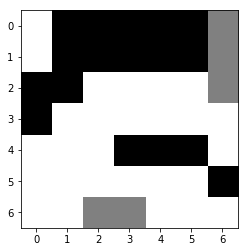

((1, 5), (2, 6)): n_v:  1771 q_all:-0.363228 q:-0.510940 q_m:-0.100000 p:0.423920
((4, 5), (6, 3)): n_v:   495 q_all:-0.397311 q:-0.366087 q_m:-0.066667 p:0.173785
((0, 5), (2, 6)): n_v:   292 q_all:-0.363677 q:-0.553786 q_m:-0.133333 p:0.070403
((4, 4), (6, 2)): n_v:   284 q_all:-0.352598 q:-0.368383 q_m:-0.066667 p:0.058084
((4, 3), (6, 2)): n_v:   188 q_all:-0.327790 q:-0.378239 q_m:-0.066667 p:0.022978
((4, 4), (6, 3)): n_v:   108 q_all:-0.482844 q:-0.442997 q_m:-0.066667 p:0.068879
((4, 4), (2, 6)): n_v:    71 q_all:-0.638180 q:-0.597071 q_m:-0.133333 p:0.082605
((4, 5), (2, 6)): n_v:    57 q_all:-0.492831 q:-0.610075 q_m:-0.133333 p:0.038299
((0, 4), (2, 6)): n_v:    42 q_all:-0.421173 q:-0.642845 q_m:-0.133333 p:0.018094
((4, 3), (6, 3)): n_v:    10 q_all:-0.521887 q:-0.523501 q_m:-0.066667 p:0.007651
((1, 4), (2, 6)): n_v:     7 q_all:-0.739451 q:-0.691623 q_m:-0.133333 p:0.010629
((0, 5), (0, 6)): n_v:     6 q_all:-0.754869 q:-0.730315 q_m:-0.300000 p:0.009027
((0, 4), (0, 6))

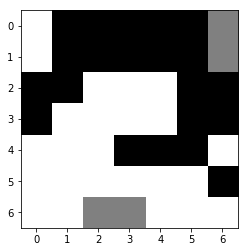

((2, 4), (1, 6)): n_v:  2378 q_all:+0.333632 q:+0.313433 q_m:+0.366667 p:0.427431
((3, 4), (1, 6)): n_v:   667 q_all:+0.309093 q:+0.298034 q_m:+0.366667 p:0.174980
((5, 2), (6, 3)): n_v:    92 q_all:+0.156983 q:+0.324104 q_m:+0.133333 p:0.070552
((2, 4), (0, 6)): n_v:    34 q_all:+0.353531 q:+0.221036 q_m:+0.233333 p:0.003562
((6, 4), (6, 2)): n_v:    22 q_all:-0.011150 q:+0.023242 q_m:+0.100000 p:0.029074
((5, 1), (6, 2)): n_v:    14 q_all:+0.164747 q:+0.225965 q_m:+0.133333 p:0.010775
((6, 5), (6, 3)): n_v:    12 q_all:-0.100319 q:+0.080124 q_m:+0.100000 p:0.020098
((6, 1), (6, 3)): n_v:    10 q_all:-0.004079 q:+0.134683 q_m:+0.100000 p:0.013042
((6, 0), (6, 2)): n_v:     5 q_all:+0.014216 q:+0.044413 q_m:+0.100000 p:0.007437
((5, 4), (6, 2)): n_v:     2 q_all:-0.118775 q:-0.230976 q_m:+0.100000 p:0.004585
((5, 1), (6, 3)): n_v:     2 q_all:-0.191697 q:-0.160547 q_m:+0.100000 p:0.005498
((4, 2), (6, 3)): n_v:     1 q_all:-0.368146 q:-0.273386 q_m:+0.100000 p:0.002241
((5, 5), (6, 3))

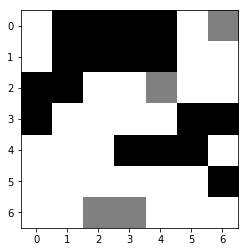

((1, 3), (2, 4)): n_v:  2677 q_all:-0.283969 q:-0.315758 q_m:-0.000000 p:0.143082
((4, 3), (6, 2)): n_v:   559 q_all:-0.283474 q:-0.480630 q_m:-0.100000 p:0.005333
((4, 3), (2, 4)): n_v:   254 q_all:-0.315232 q:-0.259540 q_m:-0.033333 p:0.032173
((4, 4), (2, 4)): n_v:    83 q_all:-0.670388 q:-0.636214 q_m:-0.033333 p:0.104267
((0, 3), (2, 4)): n_v:    64 q_all:-0.451936 q:-0.552938 q_m:-0.033333 p:0.037239
((3, 6), (2, 4)): n_v:    61 q_all:-0.535566 q:-0.549844 q_m:-0.033333 p:0.051377
((4, 5), (2, 4)): n_v:    55 q_all:-0.593492 q:-0.580975 q_m:-0.033333 p:0.056603
((0, 4), (2, 4)): n_v:    49 q_all:-0.608940 q:-0.540605 q_m:-0.033333 p:0.052929
((0, 2), (2, 4)): n_v:    23 q_all:-0.572365 q:-0.508358 q_m:-0.033333 p:0.022292
((1, 2), (2, 4)): n_v:    14 q_all:-0.638577 q:-0.576497 q_m:-0.033333 p:0.015857
((4, 4), (6, 2)): n_v:    12 q_all:-0.348157 q:-0.441072 q_m:-0.100000 p:0.002604
((4, 5), (6, 3)): n_v:     3 q_all:-0.545903 q:-0.530821 q_m:-0.100000 p:0.002101
((1, 4), (0, 6))

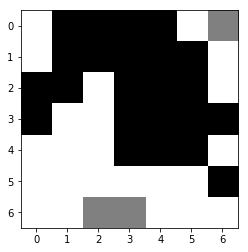

((0, 5), (0, 6)): n_v:  4024 q_all:+0.489839 q:+0.347785 q_m:+0.100000 p:0.388313
((2, 6), (0, 6)): n_v:    92 q_all:-0.066087 q:-0.048229 q_m:+0.066667 p:0.147887
((5, 2), (6, 3)): n_v:    11 q_all:+0.007802 q:+0.103557 q_m:+0.033333 p:0.015146
((6, 4), (6, 2)): n_v:     8 q_all:-0.189978 q:-0.269707 q_m:-0.000000 p:0.018445
((6, 5), (6, 3)): n_v:     6 q_all:-0.336126 q:-0.241135 q_m:-0.000000 p:0.017773
((6, 0), (6, 2)): n_v:     5 q_all:-0.059889 q:-0.053429 q_m:-0.000000 p:0.008196
((6, 1), (6, 3)): n_v:     4 q_all:-0.098828 q:-0.098331 q_m:-0.000000 p:0.007519
((5, 1), (6, 2)): n_v:     4 q_all:+0.066414 q:+0.160726 q_m:+0.033333 p:0.004827
((5, 0), (6, 2)): n_v:     4 q_all:-0.407696 q:-0.403322 q_m:-0.000000 p:0.011705
((5, 4), (6, 2)): n_v:     2 q_all:-0.499194 q:-0.632712 q_m:-0.000000 p:0.006731
((4, 2), (6, 3)): n_v:     1 q_all:-0.523076 q:-0.411500 q_m:-0.000000 p:0.003036
((5, 5), (6, 3)): n_v:     1 q_all:-0.673360 q:-0.620736 q_m:-0.000000 p:0.005026
((4, 1), (6, 3))

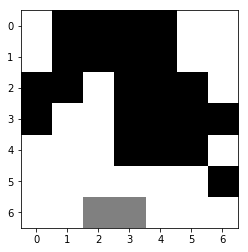

((4, 3), (6, 2)): n_v:  2137 q_all:-0.247569 q:-0.468806 q_m:+0.166667 p:0.171839
((4, 5), (6, 3)): n_v:  2135 q_all:-0.482724 q:-0.224883 q_m:+0.166667 p:0.388806
((4, 4), (6, 3)): n_v:   367 q_all:-0.596436 q:-0.381008 q_m:+0.166667 p:0.197237
((4, 4), (6, 2)): n_v:   356 q_all:-0.549641 q:-0.338660 q_m:+0.166667 p:0.140267
((4, 3), (6, 3)): n_v:   125 q_all:-0.680122 q:-0.537022 q_m:+0.166667 p:0.100899
1 's turn


This is a random move


one move takes time(s):  0.09850716590881348
train_mode is both train
no. of data collected:  8


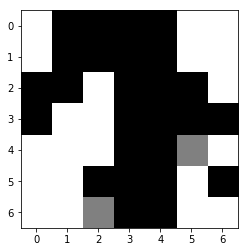

((4, 6), (4, 5)): n_v:  2508 q_all:+0.925554 q:+0.787494 q_m:+0.266667 p:0.314261
((6, 6), (4, 5)): n_v:   240 q_all:+0.623384 q:+0.606422 q_m:+0.233333 p:0.262978
((2, 6), (4, 5)): n_v:    54 q_all:+0.764781 q:+0.361697 q_m:+0.233333 p:0.034547
((6, 5), (4, 5)): n_v:    31 q_all:+0.558690 q:+0.529508 q_m:+0.233333 p:0.040647
((5, 1), (6, 2)): n_v:     1 q_all:-0.054135 q:-0.054135 q_m:+0.066667 p:0.004320
((6, 0), (6, 2)): n_v:     1 q_all:-0.033402 q:-0.033402 q_m:+0.033333 p:0.006313
((5, 0), (6, 2)): n_v:     0 q_all:-0.342633 q:-0.342633 q_m:+0.033333 p:0.001283
((4, 1), (6, 2)): n_v:     0 q_all:-0.414844 q:-0.414844 q_m:+0.033333 p:0.000011
((4, 0), (6, 2)): n_v:     0 q_all:-0.412825 q:-0.412825 q_m:+0.033333 p:0.000293
((4, 2), (6, 2)): n_v:     0 q_all:-0.355540 q:-0.355540 q_m:+0.033333 p:0.000110
-1 's turn
one move takes time(s):  0.049181461334228516
train_mode is both train
no. of data collected:  8


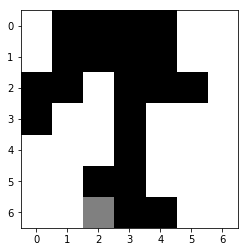

((4, 3), (6, 2)): n_v:  1507 q_all:-0.981251 q:-0.930484 q_m:-0.133333 p:0.133071
((5, 2), (6, 2)): n_v:  1297 q_all:-1.000000 q:+5.000000 q_m:-0.100000 p:0.189020
((6, 4), (6, 2)): n_v:   661 q_all:-0.999827 q:-0.942593 q_m:-0.133333 p:0.095986
1 's turn


This is a random move


one move takes time(s):  0.05765557289123535
train_mode is both train
no. of data collected:  8


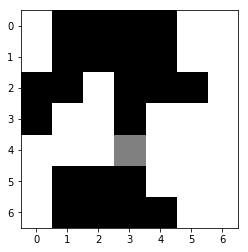

((3, 2), (4, 3)): n_v:  2920 q_all:+1.000000 q:+5.000000 q_m:+0.366667 p:0.206281
((6, 5), (4, 3)): n_v:   260 q_all:+0.979044 q:+0.892694 q_m:+0.333333 p:0.037541
((2, 2), (4, 3)): n_v:    61 q_all:+0.796071 q:+0.750113 q_m:+0.333333 p:0.047818
((3, 1), (4, 3)): n_v:    11 q_all:+0.210567 q:+0.614090 q_m:+0.333333 p:0.028024
((3, 5), (4, 3)): n_v:     6 q_all:+0.040562 q:+0.456787 q_m:+0.333333 p:0.019338
((5, 5), (4, 3)): n_v:     4 q_all:+0.264407 q:+0.580509 q_m:+0.333333 p:0.011370
((4, 1), (4, 3)): n_v:     2 q_all:-0.022694 q:+0.465958 q_m:+0.333333 p:0.005631
((4, 5), (4, 3)): n_v:     1 q_all:-0.155333 q:+0.233048 q_m:+0.333333 p:0.005323
this self play has 76 steps, time elapsed 135.47198963165283
winner is 1.0
episode 179 finished
episode 180 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.38220715522766113
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(

36144  data in database
10000  data expected
10000  data grabbed
start training, training data no. 10000
Train on 9000 samples, validate on 1000 samples
Epoch 1/512
9000/9000 [==============================] - 1s 123us/step - loss: 1.8988 - activation_29_loss: 1.8640 - dense_15_loss: 0.0096 - val_loss: 1.9007 - val_activation_29_loss: 1.8684 - val_dense_15_loss: 0.0072
Epoch 2/512
9000/9000 [==============================] - 1s 105us/step - loss: 1.8951 - activation_29_loss: 1.8604 - dense_15_loss: 0.0095 - val_loss: 1.8997 - val_activation_29_loss: 1.8675 - val_dense_15_loss: 0.0071
Epoch 3/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8914 - activation_29_loss: 1.8570 - dense_15_loss: 0.0093 - val_loss: 1.8990 - val_activation_29_loss: 1.8668 - val_dense_15_loss: 0.0070
Epoch 4/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8896 - activation_29_loss: 1.8551 - dense_15_loss: 0.0093 - val_loss: 1.8993 - val_activation_29_loss: 1.8671 -

Epoch 38/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8491 - activation_29_loss: 1.8158 - dense_15_loss: 0.0081 - val_loss: 1.9019 - val_activation_29_loss: 1.8692 - val_dense_15_loss: 0.0075
Epoch 39/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8490 - activation_29_loss: 1.8158 - dense_15_loss: 0.0080 - val_loss: 1.9015 - val_activation_29_loss: 1.8688 - val_dense_15_loss: 0.0075
Epoch 40/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8480 - activation_29_loss: 1.8147 - dense_15_loss: 0.0082 - val_loss: 1.9012 - val_activation_29_loss: 1.8686 - val_dense_15_loss: 0.0075
Epoch 41/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8468 - activation_29_loss: 1.8136 - dense_15_loss: 0.0080 - val_loss: 1.9022 - val_activation_29_loss: 1.8696 - val_dense_15_loss: 0.0075
Epoch 42/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8464 - activation_29_loss: 1.8131 - dense_1

9000/9000 [==============================] - 1s 92us/step - loss: 1.8273 - activation_29_loss: 1.7945 - dense_15_loss: 0.0076 - val_loss: 1.9042 - val_activation_29_loss: 1.8714 - val_dense_15_loss: 0.0077
Epoch 00075: early stopping
saving files


target model updated




start testing against greedy
####               ####
#### start testing ####
testing took time:  93.02667474746704
68.92737430167598



                        win ratio of Q is 0.716 





####               ####
#### start testing ####
testing took time:  103.06494688987732
62.30612244897959



                        win ratio of P is 0.784 





episode 180 finished
episode 181 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.3766195774078369
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5362157821655273
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random m

one move takes time(s):  1.354428768157959
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7439765930175781
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0307257175445557
one move takes time(s):  2.0320417881011963
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.338021755218506
one move takes time(s):  2.3392794132232666
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.28703236579895


This is a random move


one move takes time(s):  2.288454055786133
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.2406668663024902
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2616932392120361
train_mode is both train
no. of d

due to rollout lim, final rollout times:  1601 time elapsed:  4.232371091842651
one move takes time(s):  4.233897924423218
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.832163333892822


This is a random move


one move takes time(s):  4.833512783050537
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.9997780323028564
one move takes time(s):  5.001182317733765
train_mode is both train
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  916 time elapsed:  6.0056891441345215
one move takes time(s):  6.007079601287842
train_mode is both train
no. of data collected:  8
-1 's turn
due to time lim, final rollout times:  1115 time elapsed:  6.02506947517395


This is a random move


one move takes time(s):  6.026952505111694
no. of data collected:  0
1 's turn
due to rollout lim, final rollout times:  1601 time elaps

one move takes time(s):  0.35460638999938965
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.37709951400756836
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5130929946899414
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5024740695953369
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.19765925407409668
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.34247398376464844
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1505138874053955
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.11263561248779297
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.08823657035827637
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random

one move takes time(s):  0.9633629322052002
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6155412197113037
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.3508801460266113
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1979186534881592
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.451568603515625
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.22415447235107422
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.21604108810424805
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1677398681640625
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.39593958854675293
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1917567253112793
train

one move takes time(s):  0.8601796627044678
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8281877040863037
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2610042095184326
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4999830722808838
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1477653980255127
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.4123878479003906
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0316994190216064
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.772036075592041
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9069778919219971
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0

one move takes time(s):  0.9659254550933838
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6692550182342529
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.350752592086792
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0537035465240479
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.068075180053711
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7550926208496094
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8370225429534912
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8611288070678711
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8546569347381592
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.

Epoch 15/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8946 - activation_29_loss: 1.8601 - dense_15_loss: 0.0093 - val_loss: 1.9156 - val_activation_29_loss: 1.8803 - val_dense_15_loss: 0.0101
Epoch 16/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8924 - activation_29_loss: 1.8580 - dense_15_loss: 0.0092 - val_loss: 1.9159 - val_activation_29_loss: 1.8806 - val_dense_15_loss: 0.0101
Epoch 17/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8918 - activation_29_loss: 1.8576 - dense_15_loss: 0.0091 - val_loss: 1.9158 - val_activation_29_loss: 1.8806 - val_dense_15_loss: 0.0101
Epoch 18/512
9000/9000 [==============================] - 1s 96us/step - loss: 1.8904 - activation_29_loss: 1.8563 - dense_15_loss: 0.0090 - val_loss: 1.9166 - val_activation_29_loss: 1.8813 - val_dense_15_loss: 0.0101
Epoch 19/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8900 - activation_29_loss: 1.8555 - dense_1

9000/9000 [==============================] - 1s 92us/step - loss: 1.8632 - activation_29_loss: 1.8297 - dense_15_loss: 0.0083 - val_loss: 1.9225 - val_activation_29_loss: 1.8871 - val_dense_15_loss: 0.0102
Epoch 53/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8607 - activation_29_loss: 1.8274 - dense_15_loss: 0.0082 - val_loss: 1.9227 - val_activation_29_loss: 1.8874 - val_dense_15_loss: 0.0101
Epoch 54/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8598 - activation_29_loss: 1.8266 - dense_15_loss: 0.0080 - val_loss: 1.9229 - val_activation_29_loss: 1.8876 - val_dense_15_loss: 0.0101
Epoch 55/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8598 - activation_29_loss: 1.8265 - dense_15_loss: 0.0081 - val_loss: 1.9230 - val_activation_29_loss: 1.8877 - val_dense_15_loss: 0.0101
Epoch 56/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8590 - activation_29_loss: 1.8256 - dense_15_loss: 0.008

one move takes time(s):  1.9952304363250732
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1611 time elapsed:  2.011256217956543
one move takes time(s):  2.0124716758728027
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1639 time elapsed:  2.0001137256622314
one move takes time(s):  2.0014808177948
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.488326072692871
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.9454867839813232
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.217271089553833
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9181294441223145
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1566433906555176
train_mode is both train
no. of data

one move takes time(s):  0.9474577903747559
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8804323673248291
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.7614588737487793
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9193170070648193
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.1784453392028809
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.6090919971466064
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.12127685546875
one move takes time(s):  2.122619867324829
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.4102551937103271
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time 



This is a random move


one move takes time(s):  0.09962964057922363
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.05065584182739258
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.03679800033569336
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.03493046760559082
train_mode is both train
no. of data collected:  8
this self play has 74 steps, time elapsed 113.88405060768127
winner is 1.0
episode 187 finished
episode 188 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.383929967880249
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5337047576904297
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.787928581237793
train_mode is both train
no. of data collected:  8
1 's turn
o

one move takes time(s):  0.6987349987030029
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.57303786277771
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5903818607330322
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.47156500816345215
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4924192428588867
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4128444194793701
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2892167568206787
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.22147321701049805
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.14152050018310547
train_mode is both train
no. of d

one move takes time(s):  1.999772310256958
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.189098358154297
one move takes time(s):  4.1904356479644775
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.260324001312256
one move takes time(s):  2.26155424118042
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.154727458953857
one move takes time(s):  5.156032562255859
train_mode is both train
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  1485 time elapsed:  6.001667737960815
one move takes time(s):  6.0028815269470215
train_mode is both train
no. of data collected:  8
-1 's turn
due to time lim, final rollout times:  1351 time elapsed:  6.030335903167725
one move takes time(s):  6.0317652225494385
train_mode is both train
no. of data c



This is a random move


one move takes time(s):  0.4318714141845703
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.26609086990356445
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2300858497619629
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.23058319091796875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.16692662239074707
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.10899472236633301
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.07996249198913574
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.07040905952453613
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.06227278709411621
train_mode is both train
no. of data collected:  8
1 's turn
one move takes tim

Epoch 32/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8615 - activation_29_loss: 1.8275 - dense_15_loss: 0.0088 - val_loss: 1.9153 - val_activation_29_loss: 1.8786 - val_dense_15_loss: 0.0115
Epoch 33/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8598 - activation_29_loss: 1.8261 - dense_15_loss: 0.0085 - val_loss: 1.9152 - val_activation_29_loss: 1.8785 - val_dense_15_loss: 0.0115
Epoch 34/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8590 - activation_29_loss: 1.8252 - dense_15_loss: 0.0086 - val_loss: 1.9157 - val_activation_29_loss: 1.8789 - val_dense_15_loss: 0.0116
Epoch 35/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8581 - activation_29_loss: 1.8244 - dense_15_loss: 0.0085 - val_loss: 1.9156 - val_activation_29_loss: 1.8789 - val_dense_15_loss: 0.0116
Epoch 36/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8572 - activation_29_loss: 1.8234 - dense_1

one move takes time(s):  0.7547438144683838
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.1784181594848633
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.672633409500122
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4946677684783936
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.5493996143341064


This is a random move


one move takes time(s):  3.550393581390381
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.2237579822540283


This is a random move


one move takes time(s):  3.224762201309204
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.031641960144043
one move takes time(s): 

one move takes time(s):  0.2117459774017334
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4965026378631592
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4402475357055664
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.3238246440887451
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.1689300537109375
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.1326308250427246
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.08577752113342285
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.0953061580657959
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.07764887809753418
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):

due to rollout lim, final rollout times:  1624 time elapsed:  2.0114619731903076
one move takes time(s):  2.012770414352417
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5785956382751465
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.393491744995117
one move takes time(s):  2.394871950149536
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.570990800857544
one move takes time(s):  2.5724613666534424
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.1235883235931396
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.924163818359375
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8409888744354248
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


due to rollout lim, final rollout times:  1601 time elapsed:  2.0277159214019775
one move takes time(s):  2.0291173458099365
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.694854497909546
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.3594119548797607
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2092158794403076
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1748 time elapsed:  2.0000691413879395
one move takes time(s):  2.0013720989227295
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4914464950561523
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7149767875671387


This is a random move


one move takes time(s):  2.7163655757904053
train_mode is both train
no. 

one move takes time(s):  1.5808053016662598
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.723639965057373
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9735584259033203
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1784191131591797
one move takes time(s):  2.1802191734313965
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.414644718170166
one move takes time(s):  3.4160377979278564
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1684 time elapsed:  2.0014216899871826
one move takes time(s):  2.002756357192993
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.3692777156829834
one move takes time(s):  3.3705451488494873
tr

due to rollout lim, final rollout times:  1626 time elapsed:  2.005661964416504


This is a random move


one move takes time(s):  2.0066587924957275
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.345679521560669
one move takes time(s):  2.3475725650787354
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.5232455730438232


This is a random move


one move takes time(s):  3.5242931842803955
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7734766006469727
one move takes time(s):  2.775221347808838
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2657175064086914
one move takes time(s):  2.267045736312866
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim,

one move takes time(s):  0.28719568252563477
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.29772520065307617
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.22013020515441895
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2234971523284912
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5141439437866211
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4601576328277588
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.31716299057006836
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2669968605041504
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.12583398818969727
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time

9000/9000 [==============================] - 1s 92us/step - loss: 1.8643 - activation_29_loss: 1.8299 - dense_15_loss: 0.0092 - val_loss: 1.9193 - val_activation_29_loss: 1.8849 - val_dense_15_loss: 0.0092
Epoch 31/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8638 - activation_29_loss: 1.8293 - dense_15_loss: 0.0093 - val_loss: 1.9202 - val_activation_29_loss: 1.8857 - val_dense_15_loss: 0.0093
Epoch 32/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8624 - activation_29_loss: 1.8282 - dense_15_loss: 0.0091 - val_loss: 1.9196 - val_activation_29_loss: 1.8851 - val_dense_15_loss: 0.0093
Epoch 33/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8616 - activation_29_loss: 1.8273 - dense_15_loss: 0.0091 - val_loss: 1.9203 - val_activation_29_loss: 1.8858 - val_dense_15_loss: 0.0093
Epoch 34/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8612 - activation_29_loss: 1.8271 - dense_15_loss: 0.009

9000/9000 [==============================] - 1s 93us/step - loss: 1.8400 - activation_29_loss: 1.8064 - dense_15_loss: 0.0084 - val_loss: 1.9238 - val_activation_29_loss: 1.8889 - val_dense_15_loss: 0.0097
Epoch 68/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8388 - activation_29_loss: 1.8053 - dense_15_loss: 0.0083 - val_loss: 1.9245 - val_activation_29_loss: 1.8897 - val_dense_15_loss: 0.0096
Epoch 69/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8392 - activation_29_loss: 1.8056 - dense_15_loss: 0.0083 - val_loss: 1.9228 - val_activation_29_loss: 1.8880 - val_dense_15_loss: 0.0096
Epoch 70/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8372 - activation_29_loss: 1.8038 - dense_15_loss: 0.0082 - val_loss: 1.9250 - val_activation_29_loss: 1.8902 - val_dense_15_loss: 0.0096
Epoch 71/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8364 - activation_29_loss: 1.8031 - dense_15_loss: 0.008

due to time lim, final rollout times:  475 time elapsed:  1276.3444051742554
one move takes time(s):  1276.4188964366913
train_mode is both train
no. of data collected:  8
1 's turn
due to time lim, final rollout times:  345 time elapsed:  6.042024850845337


This is a random move


one move takes time(s):  6.061884641647339
no. of data collected:  0
-1 's turn
one move takes time(s):  0.5401990413665771
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.36695289611816406
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8829147815704346
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3291630744934082
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4307398796081543
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.40876150131225586
train_mode is both train
no. of data collected:  8
-1 's turn
o

one move takes time(s):  0.4742400646209717
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9485187530517578
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.4794158935546875
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.536888837814331
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8787691593170166
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3763852119445801
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7429177761077881
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3604609966278076
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3039510250091553
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2593693733215332
train_m

one move takes time(s):  1.575230598449707
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.201535224914551
one move takes time(s):  2.202805280685425
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.629652976989746
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.8725380897521973
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.9092347621917725
one move takes time(s):  2.910811185836792
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.344146490097046
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2055509090423584
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2629621028900146
train_mod

one move takes time(s):  1.98317289352417
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.013917922973633


This is a random move


one move takes time(s):  5.015274286270142
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.849524736404419
one move takes time(s):  3.8508079051971436
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.8395633697509766
one move takes time(s):  3.8408913612365723
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.089226484298706
one move takes time(s):  3.0904953479766846
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.368289947509766


This is a random move


one move takes time(s)

due to rollout lim, final rollout times:  1601 time elapsed:  5.430467128753662
one move takes time(s):  5.4317803382873535
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.791022300720215
one move takes time(s):  4.792277097702026
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.1778552532196045
one move takes time(s):  4.179150819778442
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.878107786178589
one move takes time(s):  3.8793838024139404
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.296431064605713
one move takes time(s):  3.2977044582366943
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3292808532



This is a random move


one move takes time(s):  1.9322292804718018
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.620103120803833
one move takes time(s):  2.6214261054992676
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.2656364440917969
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.43109703063964844
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.6710481643676758
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.45784950256347656
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5385584831237793
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3643209934234619
train_mode is both train
no. of

Epoch 26/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8765 - activation_29_loss: 1.8429 - dense_15_loss: 0.0084 - val_loss: 1.8893 - val_activation_29_loss: 1.8529 - val_dense_15_loss: 0.0112
Epoch 27/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8754 - activation_29_loss: 1.8417 - dense_15_loss: 0.0085 - val_loss: 1.8891 - val_activation_29_loss: 1.8527 - val_dense_15_loss: 0.0111
Epoch 28/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8752 - activation_29_loss: 1.8416 - dense_15_loss: 0.0084 - val_loss: 1.8893 - val_activation_29_loss: 1.8529 - val_dense_15_loss: 0.0112
Epoch 29/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8753 - activation_29_loss: 1.8415 - dense_15_loss: 0.0086 - val_loss: 1.8897 - val_activation_29_loss: 1.8533 - val_dense_15_loss: 0.0112
Epoch 30/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8741 - activation_29_loss: 1.8405 - dense_1

9000/9000 [==============================] - 1s 92us/step - loss: 1.8508 - activation_29_loss: 1.8177 - dense_15_loss: 0.0080 - val_loss: 1.8933 - val_activation_29_loss: 1.8570 - val_dense_15_loss: 0.0111
Epoch 64/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8499 - activation_29_loss: 1.8167 - dense_15_loss: 0.0080 - val_loss: 1.8931 - val_activation_29_loss: 1.8568 - val_dense_15_loss: 0.0111
Epoch 65/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8500 - activation_29_loss: 1.8168 - dense_15_loss: 0.0080 - val_loss: 1.8929 - val_activation_29_loss: 1.8567 - val_dense_15_loss: 0.0110
Epoch 66/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8484 - activation_29_loss: 1.8153 - dense_15_loss: 0.0079 - val_loss: 1.8927 - val_activation_29_loss: 1.8565 - val_dense_15_loss: 0.0111
Epoch 67/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8480 - activation_29_loss: 1.8149 - dense_15_loss: 0.007

one move takes time(s):  0.33734917640686035
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.41593241691589355
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.2592198848724365
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.28197407722473145
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.16436338424682617
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.16220378875732422
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.14724111557006836
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.14483380317687988
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.07686758041381836
train_mode is both train
n

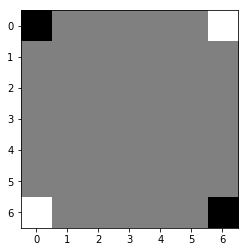

((0, 0), (1, 1)): n_v:   699 q_all:+0.002735 q:-0.000276 q_m:+0.033333 p:0.383264
((6, 6), (5, 5)): n_v:   688 q_all:-0.001489 q:+0.011639 q_m:+0.033333 p:0.390990
((6, 6), (6, 5)): n_v:   117 q_all:-0.010359 q:-0.003277 q_m:+0.033333 p:0.071592
((0, 0), (0, 1)): n_v:   116 q_all:-0.011258 q:-0.017546 q_m:+0.033333 p:0.071936
((6, 6), (5, 6)): n_v:    70 q_all:-0.003176 q:+0.003017 q_m:+0.033333 p:0.040693
((0, 0), (1, 0)): n_v:    70 q_all:-0.000861 q:+0.005153 q_m:+0.033333 p:0.039884
((6, 6), (6, 4)): n_v:     0 q_all:-0.006735 q:-0.006735 q_m:-0.000000 p:0.000022
((0, 0), (1, 2)): n_v:     0 q_all:-0.024902 q:-0.024902 q_m:-0.000000 p:0.000088
((0, 0), (2, 2)): n_v:     0 q_all:-0.024426 q:-0.024426 q_m:-0.000000 p:0.000216
((0, 0), (0, 2)): n_v:     0 q_all:-0.034609 q:-0.034609 q_m:-0.000000 p:0.000021
((6, 6), (4, 6)): n_v:     0 q_all:-0.014228 q:-0.014228 q_m:-0.000000 p:0.000164
((6, 6), (5, 4)): n_v:     0 q_all:-0.001311 q:-0.001311 q_m:-0.000000 p:0.000122
((6, 6), (4, 4))

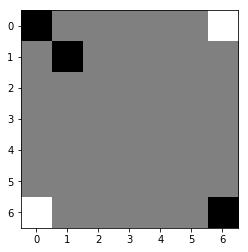

((0, 6), (1, 5)): n_v:   659 q_all:-0.012292 q:-0.006459 q_m:-0.000000 p:0.262446
((6, 0), (5, 1)): n_v:   631 q_all:-0.015169 q:-0.008986 q_m:-0.000000 p:0.258713
((0, 6), (1, 6)): n_v:   429 q_all:-0.014639 q:-0.020165 q_m:-0.000000 p:0.175167
((6, 0), (5, 0)): n_v:   422 q_all:-0.014321 q:-0.002517 q_m:-0.000000 p:0.171967
((6, 0), (6, 1)): n_v:   160 q_all:-0.015034 q:+0.001944 q_m:-0.000000 p:0.065769
((0, 6), (0, 5)): n_v:   158 q_all:-0.011273 q:-0.010262 q_m:-0.000000 p:0.062604
((0, 6), (2, 4)): n_v:     0 q_all:-0.029912 q:-0.029912 q_m:-0.033333 p:0.000238
((6, 0), (6, 2)): n_v:     0 q_all:-0.013105 q:-0.013105 q_m:-0.033333 p:0.000240
((6, 0), (5, 2)): n_v:     0 q_all:-0.020411 q:-0.020411 q_m:-0.033333 p:0.000297
((6, 0), (4, 1)): n_v:     0 q_all:-0.005462 q:-0.005462 q_m:-0.033333 p:0.000337
((0, 6), (2, 6)): n_v:     0 q_all:-0.015593 q:-0.015593 q_m:-0.033333 p:0.000389
((0, 6), (0, 4)): n_v:     0 q_all:-0.036330 q:-0.036330 q_m:-0.033333 p:0.000195
((0, 6), (2, 5))

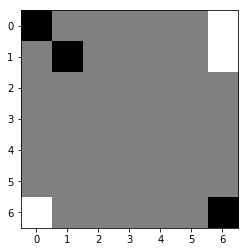

((6, 6), (5, 5)): n_v:  1070 q_all:-0.000104 q:+0.007666 q_m:+0.033333 p:0.433504
((1, 1), (2, 1)): n_v:   268 q_all:+0.000982 q:+0.001265 q_m:+0.033333 p:0.107653
((1, 1), (2, 2)): n_v:   251 q_all:-0.005075 q:-0.005764 q_m:+0.033333 p:0.107195
((0, 0), (0, 1)): n_v:   157 q_all:-0.008461 q:-0.035756 q_m:+0.033333 p:0.069188
((6, 6), (6, 5)): n_v:   137 q_all:-0.004381 q:-0.007568 q_m:+0.033333 p:0.058047
((1, 1), (2, 0)): n_v:   109 q_all:-0.002527 q:-0.001522 q_m:+0.033333 p:0.045664
((0, 0), (1, 0)): n_v:    72 q_all:-0.002838 q:-0.024416 q_m:+0.033333 p:0.030214
((6, 6), (5, 6)): n_v:    62 q_all:+0.000976 q:-0.001972 q_m:+0.033333 p:0.025203
((1, 1), (1, 2)): n_v:    38 q_all:-0.011351 q:-0.026281 q_m:+0.033333 p:0.017516
((1, 1), (0, 2)): n_v:    25 q_all:-0.010942 q:-0.025161 q_m:+0.033333 p:0.011661
((1, 1), (3, 0)): n_v:     0 q_all:-0.031911 q:-0.031911 q_m:-0.000000 p:0.000151
((6, 6), (6, 4)): n_v:     0 q_all:-0.010908 q:-0.010908 q_m:-0.000000 p:0.000023
((1, 1), (2, 3))

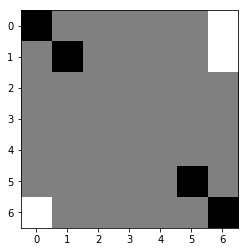

((6, 0), (5, 0)): n_v:   585 q_all:-0.015430 q:-0.010460 q_m:-0.000000 p:0.171602
((1, 6), (2, 6)): n_v:   468 q_all:-0.010507 q:-0.020854 q_m:-0.000000 p:0.128511
((6, 0), (5, 1)): n_v:   445 q_all:-0.018327 q:-0.015850 q_m:-0.000000 p:0.135501
((1, 6), (2, 5)): n_v:   420 q_all:-0.008460 q:-0.022065 q_m:-0.000000 p:0.112309
((0, 6), (1, 5)): n_v:   396 q_all:-0.020753 q:-0.031793 q_m:-0.000000 p:0.124345
((0, 6), (0, 5)): n_v:   236 q_all:-0.009557 q:-0.013127 q_m:-0.000000 p:0.064107
((6, 0), (6, 1)): n_v:   207 q_all:-0.015690 q:-0.006745 q_m:-0.000000 p:0.061157
((6, 0), (6, 2)): n_v:     2 q_all:-0.013692 q:-0.019034 q_m:-0.033333 p:0.000563
((1, 6), (2, 4)): n_v:     2 q_all:-0.008659 q:-0.027864 q_m:-0.033333 p:0.000579
((0, 6), (2, 4)): n_v:     1 q_all:-0.008828 q:-0.026056 q_m:-0.033333 p:0.000410
((1, 6), (3, 5)): n_v:     1 q_all:-0.047058 q:-0.038011 q_m:-0.033333 p:0.000778
((1, 6), (3, 4)): n_v:     1 q_all:-0.050366 q:-0.033510 q_m:-0.033333 p:0.000703
((1, 6), (3, 6))

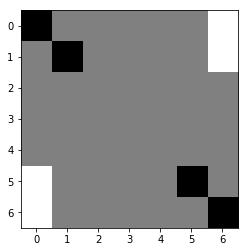

((1, 1), (2, 1)): n_v:   412 q_all:+0.013555 q:+0.013556 q_m:+0.033333 p:0.122897
((5, 5), (4, 5)): n_v:   374 q_all:+0.001462 q:-0.005394 q_m:+0.033333 p:0.130349
((5, 5), (4, 4)): n_v:   351 q_all:+0.008288 q:+0.016899 q_m:+0.033333 p:0.112430
((1, 1), (2, 2)): n_v:   298 q_all:+0.008720 q:+0.002580 q_m:+0.033333 p:0.094837
((5, 5), (6, 5)): n_v:   201 q_all:-0.005396 q:-0.004170 q_m:+0.033333 p:0.075761
((0, 0), (0, 1)): n_v:   187 q_all:-0.008809 q:-0.027248 q_m:+0.033333 p:0.073240
((1, 1), (2, 0)): n_v:   112 q_all:+0.007461 q:+0.004091 q_m:+0.033333 p:0.036397
((5, 5), (4, 6)): n_v:    86 q_all:-0.005968 q:+0.008714 q_m:+0.033333 p:0.032633
((5, 5), (5, 6)): n_v:    70 q_all:-0.002730 q:+0.002945 q_m:+0.033333 p:0.025715
((5, 5), (5, 4)): n_v:    61 q_all:-0.001927 q:+0.018336 q_m:+0.033333 p:0.022407
((0, 0), (1, 0)): n_v:    59 q_all:-0.010551 q:-0.015691 q_m:+0.033333 p:0.023713
((5, 5), (6, 4)): n_v:    40 q_all:-0.003230 q:+0.021757 q_m:+0.033333 p:0.014830
((1, 1), (1, 2))

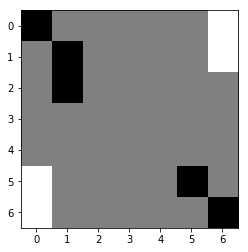

((0, 6), (1, 5)): n_v:   350 q_all:-0.033812 q:-0.052768 q_m:-0.000000 p:0.140660
((5, 0), (4, 0)): n_v:   292 q_all:-0.005159 q:-0.024688 q_m:-0.000000 p:0.079878
((5, 0), (4, 1)): n_v:   254 q_all:-0.005586 q:-0.023383 q_m:-0.000000 p:0.069993
((5, 0), (5, 1)): n_v:   235 q_all:-0.017919 q:-0.037401 q_m:-0.000000 p:0.077359
((1, 6), (2, 6)): n_v:   198 q_all:-0.018218 q:-0.041873 q_m:-0.000000 p:0.065819
((0, 6), (0, 5)): n_v:   176 q_all:-0.015100 q:-0.034896 q_m:-0.000000 p:0.056153
((1, 6), (2, 5)): n_v:   141 q_all:-0.021165 q:-0.043438 q_m:-0.000000 p:0.048639
((5, 0), (6, 1)): n_v:   131 q_all:-0.014726 q:-0.032017 q_m:-0.000000 p:0.041625
((5, 0), (3, 2)): n_v:    70 q_all:-0.039099 q:+0.008196 q_m:+0.033333 p:0.029933
((5, 0), (3, 0)): n_v:    27 q_all:-0.043514 q:+0.005257 q_m:+0.033333 p:0.011927
((5, 0), (3, 1)): n_v:    26 q_all:-0.060829 q:+0.000452 q_m:+0.033333 p:0.013831
((1, 6), (3, 4)): n_v:    17 q_all:-0.049537 q:-0.053334 q_m:-0.033333 p:0.008436
((1, 6), (3, 5))

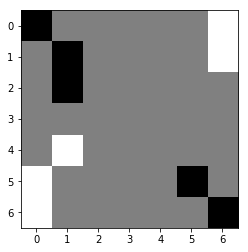

((2, 1), (3, 0)): n_v:   989 q_all:+0.032484 q:+0.031021 q_m:+0.100000 p:0.428211
((2, 1), (3, 1)): n_v:   780 q_all:+0.015583 q:+0.049237 q_m:+0.100000 p:0.397037
((2, 1), (3, 2)): n_v:    81 q_all:+0.017478 q:+0.055963 q_m:+0.100000 p:0.040992
((2, 1), (4, 0)): n_v:    60 q_all:-0.035802 q:+0.046671 q_m:+0.133333 p:0.044770
((5, 5), (4, 4)): n_v:    15 q_all:+0.022036 q:+0.007708 q_m:+0.033333 p:0.007657
((5, 5), (6, 5)): n_v:    12 q_all:+0.036916 q:-0.017525 q_m:+0.033333 p:0.005355
((5, 5), (4, 6)): n_v:    11 q_all:-0.009712 q:-0.004731 q_m:+0.033333 p:0.006460
((0, 0), (0, 1)): n_v:     9 q_all:+0.034184 q:-0.032979 q_m:+0.033333 p:0.003877
((1, 1), (2, 0)): n_v:     8 q_all:+0.027781 q:-0.024206 q_m:+0.033333 p:0.003781
((1, 1), (2, 2)): n_v:     8 q_all:+0.019738 q:-0.026112 q_m:+0.033333 p:0.004193
((5, 5), (5, 6)): n_v:     6 q_all:+0.033988 q:-0.010605 q_m:+0.033333 p:0.002615
((2, 1), (4, 2)): n_v:     5 q_all:-0.021915 q:+0.051630 q_m:+0.066667 p:0.004014
((5, 5), (6, 4))

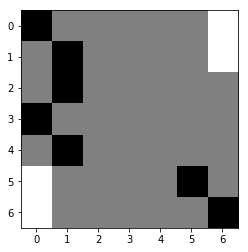

((5, 0), (4, 0)): n_v:  1142 q_all:-0.036852 q:-0.029424 q_m:+0.066667 p:0.417055
((5, 0), (3, 1)): n_v:  1123 q_all:-0.005631 q:+0.018753 q_m:+0.100000 p:0.275997
((1, 6), (2, 6)): n_v:   127 q_all:-0.099145 q:-0.062974 q_m:-0.066667 p:0.076593
((5, 0), (5, 1)): n_v:    91 q_all:-0.062397 q:-0.044877 q_m:-0.000000 p:0.041932
((6, 0), (4, 0)): n_v:    74 q_all:-0.054314 q:-0.037251 q_m:+0.033333 p:0.032236
((5, 0), (3, 2)): n_v:    58 q_all:-0.052226 q:+0.007983 q_m:+0.033333 p:0.024852
((1, 6), (3, 5)): n_v:    50 q_all:-0.082735 q:-0.081489 q_m:-0.100000 p:0.027521
((0, 6), (1, 5)): n_v:    28 q_all:-0.092567 q:-0.071646 q_m:-0.066667 p:0.016221
((1, 6), (2, 5)): n_v:    11 q_all:-0.088401 q:-0.065923 q_m:-0.066667 p:0.006582
((0, 6), (2, 6)): n_v:     7 q_all:-0.122886 q:-0.072470 q_m:-0.100000 p:0.005427
((5, 0), (6, 1)): n_v:     6 q_all:-0.161389 q:-0.059964 q_m:-0.066667 p:0.005048
((0, 6), (0, 5)): n_v:     6 q_all:-0.104348 q:-0.055391 q_m:-0.066667 p:0.003872
((1, 6), (3, 4))

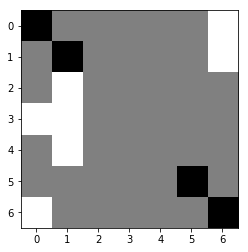

((1, 1), (2, 0)): n_v:  1984 q_all:+0.010542 q:+0.010998 q_m:+0.133333 p:0.626626
((1, 1), (3, 2)): n_v:   545 q_all:-0.005675 q:+0.003500 q_m:+0.100000 p:0.205019
((0, 0), (2, 0)): n_v:   202 q_all:-0.015322 q:-0.021206 q_m:+0.100000 p:0.083487
((5, 5), (4, 6)): n_v:    68 q_all:-0.088611 q:-0.083332 q_m:-0.066667 p:0.046629
((1, 1), (2, 2)): n_v:    13 q_all:-0.042959 q:-0.029025 q_m:+0.066667 p:0.007148
((6, 6), (4, 6)): n_v:    13 q_all:-0.096049 q:-0.098624 q_m:-0.100000 p:0.009197
((5, 5), (3, 4)): n_v:    12 q_all:-0.116035 q:-0.095547 q_m:-0.100000 p:0.009394
((0, 0), (2, 2)): n_v:     3 q_all:-0.056579 q:-0.044862 q_m:+0.033333 p:0.001904
((5, 5), (4, 4)): n_v:     2 q_all:-0.094406 q:-0.073139 q_m:-0.066667 p:0.001920
((5, 5), (3, 6)): n_v:     2 q_all:-0.132982 q:-0.109530 q_m:-0.100000 p:0.001625
((0, 0), (1, 0)): n_v:     1 q_all:-0.104510 q:-0.078683 q_m:-0.000000 p:0.000727
((5, 5), (3, 5)): n_v:     1 q_all:-0.141614 q:-0.101281 q_m:-0.100000 p:0.001223
((5, 5), (5, 6))

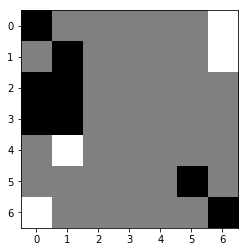

((4, 1), (2, 2)): n_v:  2674 q_all:-0.000562 q:-0.017398 q_m:+0.066667 p:0.715584
((4, 1), (4, 0)): n_v:   575 q_all:-0.000146 q:-0.023606 q_m:+0.033333 p:0.153265
((4, 1), (3, 2)): n_v:   117 q_all:-0.018906 q:-0.005497 q_m:+0.033333 p:0.038357
((4, 1), (4, 2)): n_v:    88 q_all:-0.080888 q:-0.041050 q_m:-0.033333 p:0.046703
((1, 6), (2, 6)): n_v:    28 q_all:-0.105162 q:-0.086352 q_m:-0.100000 p:0.017146
((6, 0), (4, 0)): n_v:    27 q_all:-0.006147 q:-0.025147 q_m:-0.000000 p:0.007695
((0, 6), (2, 6)): n_v:     3 q_all:-0.112927 q:-0.093472 q_m:-0.133333 p:0.002051
((0, 6), (2, 4)): n_v:     2 q_all:-0.112794 q:-0.091323 q_m:-0.133333 p:0.001240
((4, 1), (5, 0)): n_v:     2 q_all:-0.156639 q:-0.104225 q_m:-0.100000 p:0.001778
((1, 6), (3, 6)): n_v:     2 q_all:-0.103583 q:-0.103553 q_m:-0.133333 p:0.001646
((1, 6), (3, 5)): n_v:     1 q_all:-0.088735 q:-0.102544 q_m:-0.133333 p:0.000614
((1, 6), (3, 4)): n_v:     1 q_all:-0.072053 q:-0.097998 q_m:-0.133333 p:0.000891
((1, 6), (2, 5))

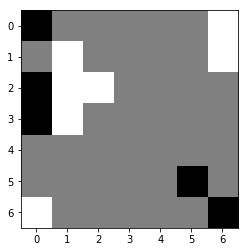

((0, 0), (1, 2)): n_v:  2019 q_all:-0.004500 q:+0.007421 q_m:+0.133333 p:0.417904
((3, 0), (3, 2)): n_v:   893 q_all:-0.014001 q:-0.002311 q_m:+0.133333 p:0.210497
((3, 0), (1, 2)): n_v:   361 q_all:-0.012131 q:-0.006902 q_m:+0.133333 p:0.083057
((0, 0), (1, 0)): n_v:   223 q_all:-0.027734 q:-0.004781 q_m:+0.100000 p:0.061859
((2, 0), (3, 2)): n_v:   146 q_all:+0.009636 q:-0.013209 q_m:+0.133333 p:0.023994
((3, 0), (1, 0)): n_v:    92 q_all:-0.024280 q:-0.026144 q_m:+0.066667 p:0.024577
((2, 0), (1, 2)): n_v:    75 q_all:+0.003194 q:-0.008087 q_m:+0.133333 p:0.013925
((5, 5), (3, 4)): n_v:    67 q_all:-0.078799 q:-0.072636 q_m:-0.066667 p:0.028952
((3, 0), (5, 0)): n_v:    53 q_all:-0.041738 q:-0.043920 q_m:-0.000000 p:0.016711
((3, 0), (5, 2)): n_v:    51 q_all:-0.057903 q:-0.078453 q_m:-0.066667 p:0.018835
((5, 5), (5, 4)): n_v:    26 q_all:-0.058472 q:-0.049281 q_m:-0.033333 p:0.009589
((3, 0), (5, 1)): n_v:    11 q_all:-0.051208 q:-0.055647 q_m:-0.000000 p:0.003933
((5, 5), (5, 6))

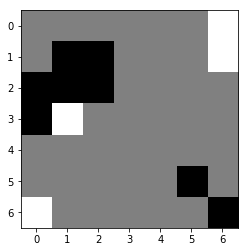

((3, 1), (1, 0)): n_v:  2257 q_all:+0.003708 q:+0.006156 q_m:+0.066667 p:0.600922
((3, 1), (3, 2)): n_v:   695 q_all:-0.000443 q:-0.009430 q_m:+0.033333 p:0.194442
((3, 1), (5, 0)): n_v:   193 q_all:-0.113727 q:-0.074889 q_m:-0.133333 p:0.124877
((3, 1), (1, 3)): n_v:    57 q_all:-0.050833 q:-0.021035 q_m:-0.000000 p:0.025177
((3, 1), (2, 3)): n_v:    41 q_all:-0.044194 q:-0.016500 q_m:-0.000000 p:0.017207
((3, 1), (5, 3)): n_v:    15 q_all:-0.081577 q:-0.044166 q_m:-0.133333 p:0.008192
((3, 1), (5, 1)): n_v:    14 q_all:-0.046159 q:-0.071585 q_m:-0.133333 p:0.006172
((3, 1), (5, 2)): n_v:    10 q_all:-0.118865 q:-0.059834 q_m:-0.133333 p:0.006506
((1, 6), (3, 4)): n_v:     4 q_all:-0.061756 q:-0.087922 q_m:-0.133333 p:0.002206
((6, 0), (5, 0)): n_v:     4 q_all:-0.065263 q:-0.066911 q_m:-0.100000 p:0.002129
((3, 1), (4, 3)): n_v:     3 q_all:-0.081267 q:-0.068817 q_m:-0.133333 p:0.002141
((0, 6), (1, 5)): n_v:     2 q_all:-0.024542 q:-0.078561 q_m:-0.100000 p:0.000778
((1, 6), (2, 6))

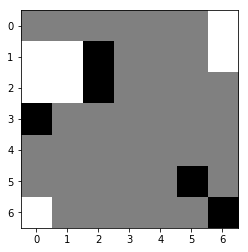

((2, 2), (3, 1)): n_v:  2738 q_all:+0.004466 q:-0.025996 q_m:+0.100000 p:0.425932
((1, 2), (0, 1)): n_v:   782 q_all:-0.044272 q:-0.054204 q_m:+0.100000 p:0.242085
((1, 2), (3, 1)): n_v:    32 q_all:-0.021566 q:-0.045204 q_m:+0.066667 p:0.007712
((2, 2), (0, 1)): n_v:    22 q_all:-0.048547 q:-0.052756 q_m:+0.066667 p:0.007205
((3, 0), (5, 1)): n_v:     5 q_all:-0.021467 q:-0.054528 q_m:-0.000000 p:0.001265
((1, 2), (0, 0)): n_v:     4 q_all:-0.002306 q:-0.035020 q_m:+0.066667 p:0.000680
((5, 5), (6, 5)): n_v:     2 q_all:-0.101320 q:-0.094442 q_m:-0.033333 p:0.001239
((2, 2), (4, 0)): n_v:     1 q_all:-0.106559 q:-0.108195 q_m:-0.066667 p:0.000655
((3, 0), (4, 2)): n_v:     0 q_all:-0.076499 q:-0.076499 q_m:-0.066667 p:0.000001
((1, 2), (0, 3)): n_v:     0 q_all:-0.112560 q:-0.112560 q_m:-0.033333 p:0.000178
((5, 5), (4, 4)): n_v:     0 q_all:-0.067377 q:-0.067377 q_m:-0.033333 p:0.000039
((3, 0), (5, 0)): n_v:     0 q_all:-0.052620 q:-0.052620 q_m:-0.000000 p:0.000033
((2, 2), (2, 4))

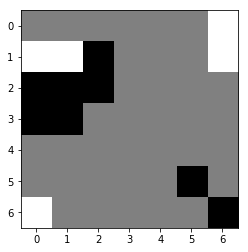

((1, 0), (3, 2)): n_v:  2558 q_all:+0.023126 q:-0.011176 q_m:+0.100000 p:0.355709
((1, 6), (3, 4)): n_v:   660 q_all:-0.084428 q:-0.050786 q_m:-0.100000 p:0.303866
((1, 1), (3, 2)): n_v:   455 q_all:-0.016181 q:-0.019695 q_m:+0.100000 p:0.116641
((1, 6), (2, 6)): n_v:    86 q_all:-0.085922 q:-0.037093 q_m:-0.066667 p:0.040045
((1, 0), (0, 0)): n_v:    66 q_all:-0.105743 q:-0.026908 q_m:-0.066667 p:0.034524
((1, 6), (2, 5)): n_v:    60 q_all:-0.075436 q:-0.035667 q_m:-0.066667 p:0.025977
((6, 0), (4, 1)): n_v:    52 q_all:-0.019627 q:-0.005519 q_m:+0.033333 p:0.013805
((6, 0), (5, 1)): n_v:    18 q_all:-0.048894 q:-0.024124 q_m:-0.066667 p:0.006625
((6, 0), (4, 0)): n_v:    17 q_all:-0.016493 q:-0.001062 q_m:+0.033333 p:0.004417
((1, 0), (0, 1)): n_v:    15 q_all:-0.029725 q:-0.014641 q_m:-0.000000 p:0.004633
((6, 0), (5, 0)): n_v:    14 q_all:-0.053410 q:-0.029964 q_m:-0.066667 p:0.005275
((1, 6), (3, 6)): n_v:    11 q_all:-0.097446 q:-0.053463 q_m:-0.100000 p:0.005915
((1, 6), (3, 5))

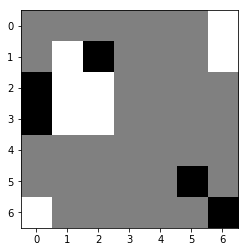

((1, 2), (2, 3)): n_v:  1884 q_all:-0.046016 q:-0.047369 q_m:+0.066667 p:0.540602
((2, 0), (1, 0)): n_v:  1494 q_all:-0.026101 q:-0.025633 q_m:+0.066667 p:0.336223
((3, 0), (4, 1)): n_v:    94 q_all:-0.026342 q:-0.030478 q_m:+0.066667 p:0.021355
((1, 2), (0, 1)): n_v:    63 q_all:-0.089430 q:-0.068954 q_m:-0.000000 p:0.026816
((5, 5), (5, 6)): n_v:    41 q_all:-0.039438 q:-0.070012 q_m:-0.066667 p:0.011118
((3, 0), (5, 1)): n_v:    32 q_all:-0.035425 q:-0.051214 q_m:-0.033333 p:0.008151
((1, 2), (1, 0)): n_v:    25 q_all:-0.017270 q:-0.036620 q_m:+0.033333 p:0.004927
((5, 5), (4, 5)): n_v:    24 q_all:-0.042335 q:-0.077652 q_m:-0.066667 p:0.006463
((5, 5), (4, 4)): n_v:    18 q_all:-0.028421 q:-0.054806 q_m:-0.066667 p:0.004258
((3, 0), (1, 0)): n_v:    17 q_all:-0.054410 q:-0.052791 q_m:+0.033333 p:0.005297
((3, 0), (5, 0)): n_v:    15 q_all:-0.047950 q:-0.038515 q_m:-0.033333 p:0.004338
((2, 0), (4, 1)): n_v:     8 q_all:-0.028335 q:-0.057232 q_m:+0.033333 p:0.001993
((2, 0), (0, 1))

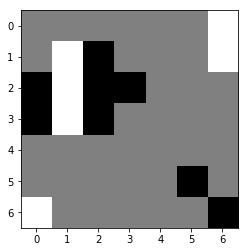

((1, 1), (1, 3)): n_v:  1205 q_all:+0.026191 q:+0.030878 q_m:+0.133333 p:0.390188
((3, 1), (1, 3)): n_v:   806 q_all:+0.054603 q:+0.047754 q_m:+0.133333 p:0.184481
((1, 1), (3, 3)): n_v:   327 q_all:+0.038118 q:+0.011469 q_m:+0.133333 p:0.093298
((3, 1), (3, 3)): n_v:   317 q_all:+0.026865 q:+0.030154 q_m:+0.133333 p:0.102087
((2, 1), (1, 3)): n_v:   167 q_all:+0.005219 q:+0.020350 q_m:+0.133333 p:0.065898
((2, 1), (3, 3)): n_v:    57 q_all:+0.016966 q:+0.012740 q_m:+0.133333 p:0.020332
((3, 1), (5, 3)): n_v:    57 q_all:-0.013982 q:-0.016148 q_m:-0.066667 p:0.026499
((3, 1), (4, 1)): n_v:    44 q_all:-0.001372 q:-0.005079 q_m:+0.100000 p:0.018688
((1, 6), (2, 5)): n_v:    29 q_all:-0.032128 q:-0.060703 q_m:-0.033333 p:0.015123
((1, 1), (1, 0)): n_v:    24 q_all:+0.003423 q:-0.028749 q_m:+0.033333 p:0.009710
((0, 6), (1, 5)): n_v:     8 q_all:-0.038314 q:-0.061992 q_m:-0.033333 p:0.004433
((3, 1), (5, 1)): n_v:     7 q_all:-0.032788 q:-0.040610 q_m:-0.066667 p:0.003977
((1, 6), (3, 5))

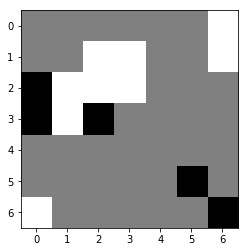

((3, 2), (1, 1)): n_v:  1137 q_all:-0.040676 q:-0.056241 q_m:+0.066667 p:0.483952
((2, 0), (1, 1)): n_v:   905 q_all:-0.019571 q:-0.059008 q_m:+0.100000 p:0.312739
((3, 2), (5, 1)): n_v:   250 q_all:-0.038732 q:-0.081366 q_m:-0.066667 p:0.104717
((3, 0), (1, 1)): n_v:   167 q_all:-0.028789 q:-0.063574 q_m:+0.066667 p:0.063415
((3, 0), (5, 1)): n_v:    36 q_all:-0.042741 q:-0.075914 q_m:-0.066667 p:0.015606
((3, 2), (3, 3)): n_v:    31 q_all:-0.037947 q:-0.028369 q_m:+0.033333 p:0.013226
((3, 2), (1, 4)): n_v:     4 q_all:-0.046794 q:-0.022510 q_m:-0.000000 p:0.001808
((2, 0), (1, 0)): n_v:     1 q_all:-0.107107 q:-0.112063 q_m:-0.033333 p:0.000724
((3, 2), (3, 4)): n_v:     1 q_all:-0.049564 q:-0.051861 q_m:-0.066667 p:0.000735
((5, 5), (3, 3)): n_v:     1 q_all:-0.079759 q:-0.053516 q_m:-0.000000 p:0.000782
((3, 0), (4, 2)): n_v:     0 q_all:-0.104777 q:-0.104777 q_m:-0.066667 p:0.000011
((5, 5), (6, 5)): n_v:     0 q_all:-0.089219 q:-0.089219 q_m:-0.100000 p:0.000085
((5, 5), (4, 4))

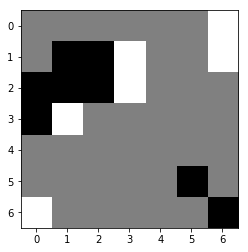

((3, 1), (1, 0)): n_v:  1552 q_all:+0.049159 q:+0.038006 q_m:+0.133333 p:0.327725
((2, 3), (3, 2)): n_v:   349 q_all:+0.010236 q:+0.010318 q_m:+0.100000 p:0.125823
((2, 3), (3, 4)): n_v:   311 q_all:-0.000596 q:-0.018882 q_m:-0.033333 p:0.124879
((3, 1), (5, 0)): n_v:   164 q_all:-0.031853 q:-0.033857 q_m:-0.066667 p:0.085861
((1, 3), (0, 2)): n_v:    39 q_all:+0.015715 q:-0.008072 q_m:+0.100000 p:0.013234
((1, 3), (3, 2)): n_v:    18 q_all:-0.002040 q:-0.006789 q_m:+0.066667 p:0.007306
((2, 3), (0, 2)): n_v:    16 q_all:+0.001846 q:-0.009780 q_m:+0.066667 p:0.006219
((2, 3), (0, 5)): n_v:    15 q_all:-0.015913 q:-0.040248 q_m:-0.066667 p:0.007229
((1, 3), (3, 4)): n_v:    14 q_all:-0.025798 q:-0.044709 q_m:-0.066667 p:0.007419
((1, 3), (0, 1)): n_v:    12 q_all:+0.012360 q:-0.012350 q_m:+0.066667 p:0.004297
((1, 3), (0, 4)): n_v:    12 q_all:-0.038364 q:-0.035563 q_m:-0.033333 p:0.007065
((1, 3), (0, 5)): n_v:    12 q_all:-0.035983 q:-0.044540 q_m:-0.066667 p:0.006502
((3, 1), (5, 2))

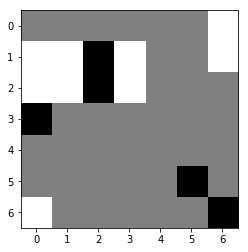

((2, 2), (3, 1)): n_v:  2217 q_all:-0.046499 q:-0.071132 q_m:+0.033333 p:0.346188
((1, 2), (0, 1)): n_v:   482 q_all:-0.064167 q:-0.089333 q_m:+0.033333 p:0.104798
((2, 2), (0, 1)): n_v:   122 q_all:-0.075062 q:-0.094678 q_m:-0.000000 p:0.031386
((1, 2), (0, 2)): n_v:   108 q_all:-0.035505 q:-0.103264 q_m:+0.033333 p:0.012846
((1, 2), (3, 1)): n_v:    75 q_all:-0.048694 q:-0.107278 q_m:-0.000000 p:0.012347
((2, 2), (0, 0)): n_v:    58 q_all:-0.053334 q:-0.089342 q_m:-0.000000 p:0.010263
((3, 0), (5, 1)): n_v:    23 q_all:-0.037339 q:-0.090121 q_m:-0.066667 p:0.002935
((2, 2), (3, 2)): n_v:    17 q_all:-0.096649 q:-0.096090 q_m:+0.033333 p:0.005879
((3, 0), (5, 0)): n_v:    15 q_all:-0.035082 q:-0.086837 q_m:-0.066667 p:0.001805
((1, 2), (0, 0)): n_v:    11 q_all:-0.041662 q:-0.094429 q_m:-0.000000 p:0.001488
((2, 2), (4, 0)): n_v:     9 q_all:-0.115877 q:-0.156797 q_m:-0.133333 p:0.003947
((2, 2), (1, 4)): n_v:     5 q_all:-0.070138 q:-0.052770 q_m:-0.000000 p:0.001227
((5, 5), (6, 5))

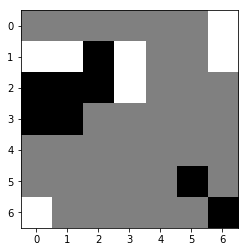

((2, 3), (3, 2)): n_v:  1811 q_all:+0.052237 q:+0.059106 q_m:+0.200000 p:0.416168
((2, 3), (3, 4)): n_v:  1387 q_all:+0.019548 q:+0.010840 q_m:-0.000000 p:0.465397
((1, 0), (3, 2)): n_v:    87 q_all:+0.029178 q:+0.020102 q_m:+0.166667 p:0.026580
((1, 3), (3, 2)): n_v:    84 q_all:+0.050785 q:+0.026710 q_m:+0.166667 p:0.019795
((1, 6), (3, 4)): n_v:    31 q_all:-0.009279 q:-0.018309 q_m:-0.033333 p:0.013311
((1, 1), (3, 2)): n_v:    29 q_all:+0.016931 q:+0.021350 q_m:+0.166667 p:0.010278
((2, 3), (4, 1)): n_v:    28 q_all:+0.035023 q:+0.051929 q_m:+0.100000 p:0.008241
((2, 3), (4, 5)): n_v:    24 q_all:+0.015049 q:+0.035278 q_m:+0.033333 p:0.008568
((1, 3), (3, 4)): n_v:    17 q_all:-0.013956 q:-0.008314 q_m:-0.033333 p:0.007974
((6, 0), (4, 1)): n_v:     7 q_all:+0.005703 q:+0.029503 q_m:+0.100000 p:0.002637
((1, 6), (2, 6)): n_v:     6 q_all:-0.000101 q:+0.013403 q_m:-0.000000 p:0.002522
((2, 3), (4, 4)): n_v:     4 q_all:+0.025935 q:+0.038650 q_m:+0.033333 p:0.001337
((2, 3), (4, 2))

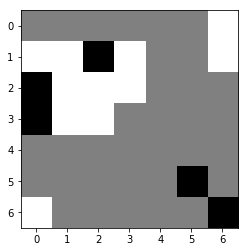

((5, 5), (3, 3)): n_v:  2277 q_all:-0.052631 q:-0.052125 q_m:-0.000000 p:0.654723
((1, 2), (0, 1)): n_v:   576 q_all:-0.073852 q:-0.096615 q_m:-0.033333 p:0.206783
((1, 2), (3, 3)): n_v:   228 q_all:-0.051574 q:-0.066618 q_m:-0.000000 p:0.064818
((1, 2), (0, 2)): n_v:    49 q_all:-0.076856 q:-0.102287 q_m:-0.033333 p:0.018245
((3, 0), (4, 1)): n_v:    25 q_all:-0.076716 q:-0.089706 q_m:-0.033333 p:0.009508
((5, 5), (4, 4)): n_v:    17 q_all:-0.071577 q:-0.105982 q_m:-0.166667 p:0.006072
((5, 5), (4, 5)): n_v:    15 q_all:-0.068952 q:-0.138163 q_m:-0.166667 p:0.005179
((5, 5), (6, 5)): n_v:     9 q_all:-0.063485 q:-0.139391 q_m:-0.166667 p:0.003133
((2, 0), (0, 1)): n_v:     9 q_all:-0.117354 q:-0.131492 q_m:-0.066667 p:0.004616
((1, 2), (1, 4)): n_v:     8 q_all:-0.073372 q:-0.081696 q_m:-0.066667 p:0.002945
((2, 0), (0, 0)): n_v:     5 q_all:-0.122974 q:-0.124776 q_m:-0.066667 p:0.002712
((3, 0), (4, 2)): n_v:     3 q_all:-0.078596 q:-0.123323 q_m:-0.066667 p:0.001329
((3, 0), (5, 1))

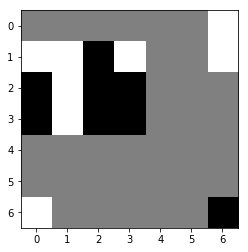

((1, 3), (2, 4)): n_v:  2363 q_all:+0.050494 q:+0.034907 q_m:+0.166667 p:0.596452
((3, 1), (4, 2)): n_v:   375 q_all:+0.039022 q:+0.022072 q_m:+0.166667 p:0.108300
((3, 1), (4, 1)): n_v:   141 q_all:+0.054452 q:+0.046265 q_m:+0.166667 p:0.033927
((1, 6), (2, 5)): n_v:    89 q_all:-0.002641 q:+0.005069 q_m:+0.033333 p:0.037906
((1, 6), (3, 4)): n_v:    60 q_all:+0.040548 q:+0.020546 q_m:+0.133333 p:0.017214
((1, 3), (0, 4)): n_v:    52 q_all:+0.009105 q:+0.001928 q_m:+0.033333 p:0.020070
((1, 1), (0, 2)): n_v:    50 q_all:+0.009508 q:-0.008248 q_m:+0.100000 p:0.019379
((1, 3), (1, 4)): n_v:    46 q_all:+0.026218 q:+0.053603 q_m:+0.100000 p:0.015456
((1, 6), (2, 6)): n_v:    43 q_all:-0.006416 q:+0.000678 q_m:+0.033333 p:0.018858
((3, 1), (4, 0)): n_v:    32 q_all:+0.013089 q:+0.041665 q_m:+0.100000 p:0.011838
((0, 6), (2, 4)): n_v:    20 q_all:+0.028885 q:+0.027346 q_m:+0.133333 p:0.006719
((1, 0), (0, 0)): n_v:    19 q_all:-0.020506 q:+0.023668 q_m:+0.033333 p:0.009382
((6, 0), (4, 1))

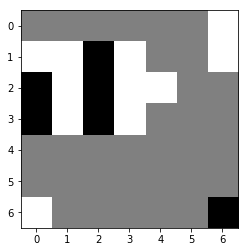

((3, 2), (1, 4)): n_v:  1060 q_all:-0.027349 q:-0.056089 q_m:+0.033333 p:0.194647
((3, 2), (3, 4)): n_v:   552 q_all:-0.070176 q:-0.061267 q_m:+0.033333 p:0.176501
((1, 2), (0, 1)): n_v:   465 q_all:-0.059177 q:-0.077909 q_m:-0.000000 p:0.132473
((1, 2), (3, 4)): n_v:   349 q_all:-0.054154 q:-0.085089 q_m:+0.033333 p:0.093733
((2, 2), (1, 4)): n_v:   207 q_all:-0.081242 q:-0.062845 q_m:+0.033333 p:0.073611
((2, 2), (0, 1)): n_v:   205 q_all:-0.084566 q:-0.101798 q_m:-0.033333 p:0.074992
((2, 2), (3, 4)): n_v:   133 q_all:-0.084416 q:-0.084652 q_m:+0.033333 p:0.048713
((1, 2), (0, 2)): n_v:   113 q_all:-0.057750 q:-0.091782 q_m:-0.000000 p:0.031588
((1, 2), (1, 4)): n_v:   109 q_all:-0.065642 q:-0.077933 q_m:+0.033333 p:0.033513
((3, 2), (5, 1)): n_v:    63 q_all:-0.071983 q:-0.101729 q_m:-0.100000 p:0.020481
((3, 2), (5, 4)): n_v:    47 q_all:-0.095875 q:-0.114163 q_m:-0.166667 p:0.019048
((2, 2), (0, 0)): n_v:    42 q_all:-0.074115 q:-0.087508 q_m:-0.033333 p:0.013925
((2, 0), (0, 1))

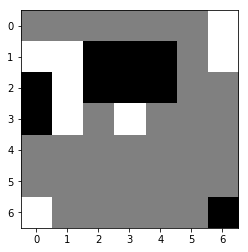

((2, 1), (3, 2)): n_v:  1438 q_all:+0.024177 q:+0.007575 q_m:+0.133333 p:0.209287
((3, 3), (3, 4)): n_v:   814 q_all:-0.000328 q:-0.002094 q_m:+0.133333 p:0.193457
((0, 6), (1, 5)): n_v:   197 q_all:+0.044467 q:-0.013143 q_m:+0.133333 p:0.013508
((3, 3), (1, 5)): n_v:    78 q_all:+0.019440 q:+0.014237 q_m:+0.100000 p:0.012870
((1, 0), (3, 2)): n_v:    29 q_all:-0.002114 q:-0.035190 q_m:+0.100000 p:0.007140
((1, 6), (3, 4)): n_v:    29 q_all:-0.013840 q:-0.021630 q_m:+0.100000 p:0.008502
((3, 3), (5, 5)): n_v:    14 q_all:+0.012612 q:+0.028122 q_m:+0.033333 p:0.002656
((1, 6), (2, 5)): n_v:     7 q_all:+0.023219 q:-0.007356 q_m:+0.133333 p:0.001156
((2, 1), (0, 3)): n_v:     5 q_all:+0.043823 q:+0.044759 q_m:+0.166667 p:0.000418
((1, 0), (0, 0)): n_v:     5 q_all:-0.042944 q:-0.026296 q_m:-0.000000 p:0.002264
((1, 1), (3, 2)): n_v:     5 q_all:-0.015545 q:-0.037012 q_m:+0.100000 p:0.001568
((3, 3), (5, 1)): n_v:     3 q_all:-0.042586 q:-0.033930 q_m:-0.033333 p:0.001324
((3, 3), (2, 5))

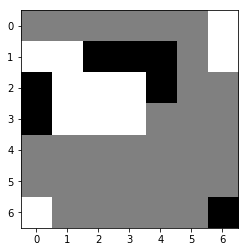

((1, 2), (0, 1)): n_v:  1839 q_all:-0.031377 q:-0.044904 q_m:+0.033333 p:0.491938
((1, 4), (0, 5)): n_v:   842 q_all:-0.075911 q:-0.023064 q_m:+0.033333 p:0.357938
((2, 4), (3, 4)): n_v:    80 q_all:-0.022542 q:-0.058108 q_m:+0.033333 p:0.019001
((1, 4), (1, 5)): n_v:    75 q_all:-0.032636 q:-0.014672 q_m:+0.033333 p:0.020477
((2, 4), (0, 5)): n_v:    40 q_all:-0.066830 q:-0.042249 q_m:-0.000000 p:0.015609
((2, 0), (4, 2)): n_v:    30 q_all:-0.069130 q:-0.095984 q_m:+0.066667 p:0.011899
((1, 3), (0, 1)): n_v:    24 q_all:-0.097997 q:-0.076496 q_m:-0.000000 p:0.012536
((3, 0), (4, 2)): n_v:    20 q_all:-0.052092 q:-0.079027 q_m:+0.066667 p:0.006948
((1, 4), (2, 5)): n_v:    16 q_all:-0.101216 q:-0.067848 q_m:-0.033333 p:0.008428
((1, 3), (0, 5)): n_v:    16 q_all:-0.059711 q:-0.031380 q_m:-0.000000 p:0.006132
((2, 0), (0, 1)): n_v:    14 q_all:-0.077524 q:-0.092998 q_m:-0.000000 p:0.006031
((3, 0), (4, 1)): n_v:     9 q_all:-0.042882 q:-0.060376 q_m:+0.033333 p:0.002820
((6, 6), (6, 5))

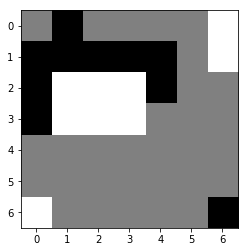

((2, 1), (0, 2)): n_v:  1472 q_all:+0.074935 q:+0.020441 q_m:+0.233333 p:0.203838
((2, 2), (0, 0)): n_v:   457 q_all:+0.007456 q:+0.030187 q_m:+0.166667 p:0.168784
((2, 3), (0, 2)): n_v:   373 q_all:+0.052899 q:+0.042553 q_m:+0.233333 p:0.079523
((2, 2), (0, 2)): n_v:   161 q_all:-0.015736 q:+0.007201 q_m:+0.233333 p:0.072490
((2, 1), (0, 0)): n_v:   134 q_all:+0.051460 q:+0.033038 q_m:+0.166667 p:0.029491
((2, 1), (0, 3)): n_v:   122 q_all:+0.043940 q:+0.006863 q_m:+0.166667 p:0.029920
((0, 6), (1, 5)): n_v:   120 q_all:-0.017872 q:-0.014834 q_m:+0.133333 p:0.054775
((0, 6), (0, 4)): n_v:    69 q_all:-0.012212 q:-0.007253 q_m:+0.100000 p:0.030449
((2, 3), (3, 4)): n_v:    58 q_all:-0.023411 q:-0.030371 q_m:+0.066667 p:0.027855
((2, 2), (0, 4)): n_v:    56 q_all:-0.079502 q:-0.045190 q_m:+0.100000 p:0.037553
((2, 3), (0, 4)): n_v:    49 q_all:-0.046931 q:-0.033037 q_m:+0.100000 p:0.027518
((3, 3), (1, 5)): n_v:    44 q_all:-0.012389 q:-0.001282 q_m:+0.100000 p:0.019563
((2, 3), (0, 3))

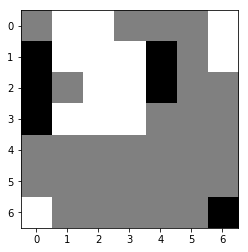

((1, 0), (2, 1)): n_v:  2733 q_all:-0.040603 q:-0.056675 q_m:+0.133333 p:0.221547
((3, 0), (4, 1)): n_v:   132 q_all:-0.208529 q:-0.136864 q_m:-0.066667 p:0.088977
((1, 4), (2, 5)): n_v:    59 q_all:-0.178821 q:-0.119149 q_m:-0.133333 p:0.033793
((1, 4), (0, 3)): n_v:    47 q_all:-0.127172 q:-0.087988 q_m:-0.000000 p:0.018350
((2, 4), (0, 5)): n_v:    40 q_all:-0.119789 q:-0.075375 q_m:-0.100000 p:0.014422
((2, 4), (3, 4)): n_v:    26 q_all:-0.128985 q:-0.102942 q_m:-0.066667 p:0.010126
((2, 4), (4, 5)): n_v:    15 q_all:-0.236708 q:-0.175471 q_m:-0.233333 p:0.011825
((1, 4), (0, 5)): n_v:    10 q_all:-0.107574 q:-0.063810 q_m:-0.066667 p:0.003432
((1, 0), (0, 0)): n_v:    10 q_all:-0.115691 q:-0.059181 q_m:-0.066667 p:0.003736
((2, 0), (4, 1)): n_v:     9 q_all:-0.195500 q:-0.139494 q_m:-0.100000 p:0.005822
((2, 4), (0, 3)): n_v:     8 q_all:-0.148780 q:-0.101348 q_m:-0.033333 p:0.003895
((2, 0), (0, 0)): n_v:     2 q_all:-0.101054 q:-0.081186 q_m:-0.100000 p:0.000570
((2, 4), (4, 3))

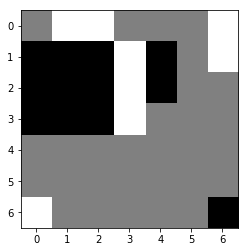

((0, 1), (0, 0)): n_v:  3696 q_all:+0.048398 q:+0.070589 q_m:+0.033333 p:0.742991
((0, 2), (0, 3)): n_v:   161 q_all:+0.006126 q:+0.038719 q_m:+0.033333 p:0.052532
((1, 6), (2, 5)): n_v:    66 q_all:-0.022904 q:-0.012461 q_m:+0.033333 p:0.027405
((3, 3), (4, 1)): n_v:    46 q_all:+0.057683 q:+0.052350 q_m:+0.066667 p:0.008045
((1, 6), (2, 6)): n_v:    31 q_all:-0.076066 q:-0.056075 q_m:-0.100000 p:0.017892
((6, 0), (4, 1)): n_v:    23 q_all:+0.021453 q:+0.022475 q_m:+0.066667 p:0.006452
((3, 3), (2, 5)): n_v:    23 q_all:-0.020322 q:-0.006962 q_m:-0.000000 p:0.009459
((0, 6), (1, 5)): n_v:    23 q_all:-0.035772 q:-0.011173 q_m:+0.033333 p:0.010174
((3, 3), (4, 5)): n_v:    19 q_all:-0.048716 q:-0.047059 q_m:-0.133333 p:0.009732
((2, 3), (1, 5)): n_v:    16 q_all:-0.040996 q:-0.035514 q_m:-0.000000 p:0.007608
((2, 3), (4, 1)): n_v:    14 q_all:+0.055016 q:+0.018924 q_m:+0.066667 p:0.002537
((2, 3), (0, 3)): n_v:    12 q_all:-0.041490 q:-0.010648 q_m:-0.000000 p:0.005750
((3, 3), (1, 5))

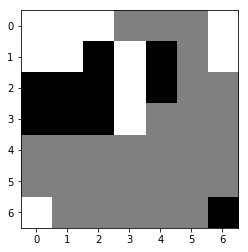

((1, 2), (0, 3)): n_v:  4462 q_all:-0.021079 q:-0.033668 q_m:+0.133333 p:0.503031
((2, 4), (3, 4)): n_v:   121 q_all:-0.056499 q:-0.067566 q_m:+0.133333 p:0.025299
((1, 4), (1, 5)): n_v:    90 q_all:-0.024536 q:-0.003641 q_m:+0.133333 p:0.010935
((1, 4), (0, 5)): n_v:    43 q_all:-0.051850 q:-0.023069 q_m:+0.133333 p:0.008591
((2, 4), (0, 3)): n_v:    30 q_all:-0.068380 q:-0.059132 q_m:+0.100000 p:0.007293
((2, 2), (0, 3)): n_v:    12 q_all:-0.132299 q:-0.110025 q_m:+0.100000 p:0.005236
((2, 1), (0, 3)): n_v:     6 q_all:-0.153843 q:-0.148679 q_m:+0.100000 p:0.002860
((2, 4), (0, 5)): n_v:     5 q_all:-0.055278 q:-0.027060 q_m:+0.100000 p:0.001158
((1, 4), (0, 4)): n_v:     4 q_all:-0.136629 q:-0.127217 q_m:+0.066667 p:0.001902
((3, 1), (4, 2)): n_v:     3 q_all:-0.138397 q:-0.096998 q_m:+0.066667 p:0.001202
((6, 6), (6, 5)): n_v:     2 q_all:-0.129435 q:-0.107085 q_m:-0.000000 p:0.000907
((3, 2), (4, 3)): n_v:     2 q_all:-0.098941 q:-0.090951 q_m:+0.066667 p:0.000917
((6, 6), (5, 5))

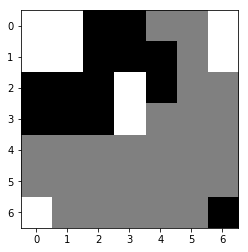

((0, 6), (0, 4)): n_v:  1946 q_all:+0.019617 q:+0.073981 q_m:+0.066667 p:0.366786
((1, 6), (2, 5)): n_v:   468 q_all:-0.010307 q:+0.015284 q_m:+0.033333 p:0.124096
((1, 6), (0, 4)): n_v:   446 q_all:+0.014275 q:+0.077673 q_m:+0.066667 p:0.090177
((3, 3), (4, 1)): n_v:   343 q_all:+0.084112 q:+0.086707 q_m:+0.066667 p:0.007845
((0, 6), (1, 5)): n_v:   340 q_all:-0.016397 q:-0.015020 q_m:+0.033333 p:0.095721
((2, 3), (0, 4)): n_v:   334 q_all:+0.046348 q:+0.042428 q_m:+0.066667 p:0.040086
((6, 0), (4, 1)): n_v:   166 q_all:+0.047536 q:+0.058707 q_m:+0.066667 p:0.019028
((2, 3), (4, 1)): n_v:   127 q_all:+0.079040 q:+0.056098 q_m:+0.066667 p:0.004416
((0, 6), (2, 5)): n_v:    79 q_all:-0.001740 q:+0.025865 q_m:-0.000000 p:0.019235
((3, 3), (2, 5)): n_v:    65 q_all:-0.007109 q:+0.017591 q_m:-0.000000 p:0.016816
((3, 3), (4, 2)): n_v:    56 q_all:+0.009923 q:+0.034984 q_m:+0.033333 p:0.012022
((2, 3), (3, 4)): n_v:    53 q_all:-0.030238 q:+0.002800 q_m:-0.033333 p:0.016809
((1, 6), (2, 6))

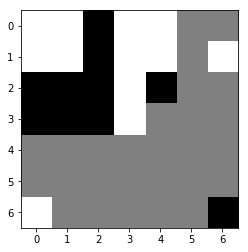

((2, 4), (1, 5)): n_v:  2224 q_all:-0.004472 q:+0.051844 q_m:+0.166667 p:0.636702
((2, 4), (3, 4)): n_v:   590 q_all:-0.043632 q:-0.064184 q_m:+0.100000 p:0.244887
((2, 4), (0, 5)): n_v:    80 q_all:-0.063199 q:-0.020986 q_m:+0.133333 p:0.038302
((6, 6), (5, 5)): n_v:    50 q_all:-0.061894 q:-0.106745 q_m:-0.033333 p:0.023886
((3, 2), (3, 4)): n_v:    14 q_all:+0.020121 q:-0.101139 q_m:+0.066667 p:0.002772
((6, 6), (6, 5)): n_v:    13 q_all:-0.057384 q:-0.120289 q_m:-0.033333 p:0.005989
((2, 4), (0, 6)): n_v:    11 q_all:-0.083596 q:-0.142665 q_m:-0.000000 p:0.006029
((3, 1), (4, 2)): n_v:    11 q_all:-0.125525 q:-0.112510 q_m:+0.033333 p:0.007664
((3, 2), (4, 3)): n_v:    11 q_all:-0.112242 q:-0.103991 q_m:+0.033333 p:0.007610
((3, 0), (5, 1)): n_v:     6 q_all:-0.067563 q:-0.089255 q_m:-0.000000 p:0.003030
((2, 4), (2, 5)): n_v:     5 q_all:-0.089393 q:-0.037997 q_m:+0.100000 p:0.003274
((2, 4), (3, 5)): n_v:     4 q_all:-0.086793 q:-0.100174 q_m:-0.033333 p:0.002408
((6, 6), (5, 6))

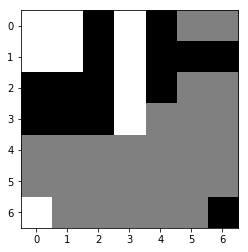

((0, 3), (2, 5)): n_v:  1887 q_all:+0.038484 q:-0.010447 q_m:+0.100000 p:0.448955
((3, 3), (2, 5)): n_v:   629 q_all:+0.013246 q:+0.021345 q_m:+0.100000 p:0.199993
((2, 3), (2, 5)): n_v:   285 q_all:+0.003074 q:-0.012242 q_m:+0.100000 p:0.100062
((3, 3), (4, 5)): n_v:   139 q_all:-0.070427 q:-0.112660 q_m:-0.166667 p:0.081536
((3, 3), (4, 1)): n_v:   118 q_all:+0.042815 q:-0.010322 q_m:+0.033333 p:0.026531
((0, 3), (0, 5)): n_v:   116 q_all:+0.006941 q:+0.023884 q_m:+0.100000 p:0.039511
((2, 3), (0, 5)): n_v:   113 q_all:+0.063500 q:+0.057293 q_m:+0.100000 p:0.018014
((1, 3), (2, 5)): n_v:    63 q_all:-0.024732 q:-0.033547 q_m:+0.100000 p:0.027584
((6, 0), (4, 1)): n_v:    46 q_all:-0.023079 q:-0.017115 q_m:+0.033333 p:0.020332
((2, 3), (4, 5)): n_v:    31 q_all:-0.093676 q:-0.116583 q_m:-0.166667 p:0.020863
((2, 3), (4, 1)): n_v:    20 q_all:-0.011933 q:-0.032364 q_m:+0.033333 p:0.008245
((1, 3), (0, 5)): n_v:     5 q_all:-0.015738 q:+0.032857 q_m:+0.100000 p:0.002274
((3, 3), (4, 3))

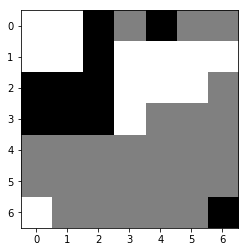

((0, 4), (2, 6)): n_v:  1824 q_all:+0.013402 q:+0.003536 q_m:+0.100000 p:0.002914
((0, 2), (0, 3)): n_v:  1370 q_all:-0.058997 q:-0.060524 q_m:+0.066667 p:0.330747
((3, 2), (3, 4)): n_v:   225 q_all:-0.001674 q:-0.056370 q_m:+0.166667 p:0.000843
((0, 4), (0, 5)): n_v:    30 q_all:-0.049486 q:-0.023330 q_m:+0.133333 p:0.006384
((2, 2), (3, 4)): n_v:     2 q_all:-0.081410 q:-0.073372 q_m:+0.166667 p:0.000851
((2, 2), (0, 3)): n_v:     1 q_all:-0.181281 q:-0.161419 q_m:+0.033333 p:0.000648
((3, 0), (4, 2)): n_v:     0 q_all:-0.204456 q:-0.204456 q_m:-0.033333 p:0.000001
((6, 6), (6, 4)): n_v:     0 q_all:-0.202017 q:-0.202017 q_m:-0.100000 p:0.000000
((3, 2), (4, 0)): n_v:     0 q_all:-0.224790 q:-0.224790 q_m:-0.100000 p:0.000002
((3, 0), (5, 0)): n_v:     0 q_all:-0.137692 q:-0.137692 q_m:-0.033333 p:0.000007
((3, 2), (4, 4)): n_v:     0 q_all:-0.134561 q:-0.134561 q_m:-0.033333 p:0.000005
((2, 1), (0, 3)): n_v:     0 q_all:-0.182080 q:-0.182080 q_m:+0.033333 p:0.000295
((3, 1), (5, 0))

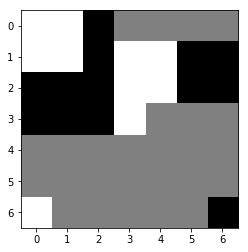

((2, 4), (3, 5)): n_v:  1665 q_all:-0.030626 q:-0.014451 q_m:+0.066667 p:0.469122
((1, 3), (0, 3)): n_v:  1242 q_all:+0.011948 q:+0.053718 q_m:+0.066667 p:0.173318
((3, 3), (3, 5)): n_v:   193 q_all:-0.011654 q:-0.023473 q_m:+0.033333 p:0.042306
((1, 4), (0, 5)): n_v:    97 q_all:+0.013663 q:-0.003120 q_m:+0.066667 p:0.013041
((2, 3), (3, 5)): n_v:    68 q_all:-0.044170 q:-0.049693 q_m:+0.033333 p:0.022292
((1, 3), (3, 5)): n_v:    49 q_all:+0.008416 q:-0.049631 q_m:+0.033333 p:0.007092
((1, 3), (0, 5)): n_v:    34 q_all:+0.026703 q:-0.005637 q_m:+0.033333 p:0.003010
((1, 3), (0, 4)): n_v:    29 q_all:+0.007525 q:-0.069925 q_m:-0.000000 p:0.004469
((1, 4), (3, 5)): n_v:    28 q_all:-0.015369 q:-0.049844 q_m:+0.033333 p:0.006543
((3, 3), (4, 1)): n_v:    27 q_all:+0.010501 q:+0.007817 q_m:+0.100000 p:0.003865
((6, 0), (4, 1)): n_v:    24 q_all:-0.017822 q:-0.005345 q_m:+0.100000 p:0.005868
((3, 3), (4, 3)): n_v:    18 q_all:-0.098764 q:-0.033199 q_m:-0.000000 p:0.009659
((2, 3), (3, 4))

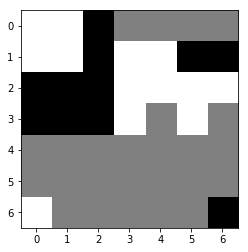

((3, 2), (3, 4)): n_v:  1571 q_all:+0.058530 q:+0.009083 q_m:+0.266667 p:0.435528
((1, 6), (3, 4)): n_v:  1081 q_all:+0.069435 q:+0.027645 q_m:+0.266667 p:0.259377
((2, 2), (3, 4)): n_v:   544 q_all:+0.001123 q:+0.020843 q_m:+0.266667 p:0.257863
((1, 2), (3, 4)): n_v:    63 q_all:-0.007209 q:+0.022887 q_m:+0.266667 p:0.032103
((1, 5), (3, 4)): n_v:    25 q_all:+0.040075 q:+0.009420 q_m:+0.266667 p:0.008783
((1, 6), (3, 6)): n_v:     4 q_all:-0.020643 q:-0.015618 q_m:+0.133333 p:0.002476
((0, 2), (0, 3)): n_v:     1 q_all:-0.060512 q:-0.037023 q_m:+0.100000 p:0.001357
((3, 0), (4, 2)): n_v:     0 q_all:-0.100100 q:-0.100100 q_m:-0.000000 p:0.000002
((1, 6), (0, 4)): n_v:     0 q_all:-0.121846 q:-0.121846 q_m:+0.066667 p:0.000001
((6, 6), (6, 4)): n_v:     0 q_all:-0.120359 q:-0.120359 q_m:-0.066667 p:0.000000
((3, 2), (4, 0)): n_v:     0 q_all:-0.153118 q:-0.153118 q_m:-0.066667 p:0.000001
((3, 0), (5, 0)): n_v:     0 q_all:-0.056594 q:-0.056594 q_m:-0.000000 p:0.000065
((3, 2), (4, 4))

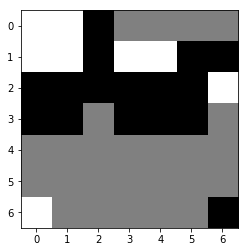

((1, 4), (3, 2)): n_v:  1319 q_all:+0.036548 q:+0.035588 q_m:+0.066667 p:0.042079
((1, 0), (3, 2)): n_v:  1224 q_all:-0.126801 q:-0.065552 q_m:+0.066667 p:0.731983
((1, 1), (3, 2)): n_v:   150 q_all:-0.190114 q:-0.098925 q_m:+0.066667 p:0.122617
((2, 6), (3, 6)): n_v:   103 q_all:-0.028202 q:-0.085160 q_m:-0.100000 p:0.026566
((1, 3), (3, 2)): n_v:    61 q_all:-0.034636 q:+0.002817 q_m:+0.066667 p:0.017042
((1, 3), (0, 3)): n_v:    51 q_all:-0.053200 q:-0.034066 q_m:-0.100000 p:0.017808
((6, 0), (4, 2)): n_v:    23 q_all:-0.124362 q:-0.102770 q_m:-0.133333 p:0.013590
((2, 6), (4, 4)): n_v:    22 q_all:-0.002415 q:-0.045601 q_m:-0.066667 p:0.003569
((1, 4), (0, 5)): n_v:     6 q_all:-0.027978 q:-0.087149 q_m:-0.100000 p:0.001776
((1, 3), (0, 5)): n_v:     1 q_all:-0.035789 q:-0.042969 q_m:-0.133333 p:0.000397
((6, 0), (4, 0)): n_v:     1 q_all:-0.042525 q:-0.098868 q_m:-0.133333 p:0.000535
((6, 0), (4, 1)): n_v:     1 q_all:-0.113560 q:-0.105118 q_m:-0.133333 p:0.000644
((0, 1), (0, 3))

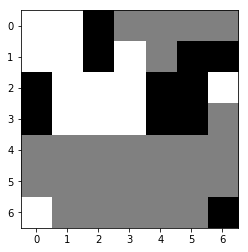

((1, 5), (1, 4)): n_v:  1693 q_all:-0.015459 q:-0.021911 q_m:+0.100000 p:0.134716
((0, 2), (1, 4)): n_v:   399 q_all:-0.013739 q:-0.042010 q_m:+0.066667 p:0.029053
((3, 4), (4, 2)): n_v:   231 q_all:-0.035143 q:-0.070383 q_m:+0.133333 p:0.034784
((3, 4), (4, 3)): n_v:   215 q_all:-0.067747 q:-0.081889 q_m:+0.100000 p:0.058423
((0, 2), (0, 3)): n_v:   140 q_all:-0.176817 q:-0.132381 q_m:+0.033333 p:0.094929
((1, 2), (1, 4)): n_v:    34 q_all:-0.038609 q:-0.028874 q_m:+0.066667 p:0.005767
((2, 5), (3, 6)): n_v:    25 q_all:-0.078238 q:-0.017025 q_m:+0.033333 p:0.007757
((2, 4), (0, 3)): n_v:    22 q_all:-0.081978 q:-0.123850 q_m:-0.000000 p:0.007333
((1, 5), (0, 5)): n_v:    18 q_all:-0.153629 q:-0.153981 q_m:-0.033333 p:0.011033
((3, 4), (4, 4)): n_v:    17 q_all:-0.088025 q:-0.095209 q_m:+0.033333 p:0.005814
((1, 5), (0, 6)): n_v:    14 q_all:-0.137040 q:-0.143084 q_m:-0.033333 p:0.007331
((1, 5), (0, 3)): n_v:    13 q_all:-0.095472 q:-0.110114 q_m:-0.000000 p:0.004962
((1, 6), (1, 4))

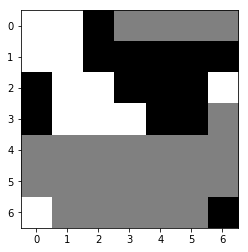

((2, 6), (3, 6)): n_v:   898 q_all:+0.041439 q:+0.004392 q_m:+0.066667 p:0.188756
((2, 6), (0, 5)): n_v:   831 q_all:+0.058001 q:+0.064916 q_m:+0.100000 p:0.127811
((0, 1), (0, 3)): n_v:   486 q_all:+0.003923 q:-0.004698 q_m:+0.166667 p:0.164156
((2, 6), (0, 4)): n_v:   370 q_all:+0.049381 q:-0.012847 q_m:+0.100000 p:0.067752
((2, 2), (0, 3)): n_v:   272 q_all:-0.024934 q:+0.029800 q_m:+0.166667 p:0.118509
((2, 1), (0, 3)): n_v:   129 q_all:-0.053662 q:+0.010085 q_m:+0.166667 p:0.068665
((3, 3), (4, 4)): n_v:    95 q_all:-0.003921 q:-0.011945 q_m:+0.066667 p:0.034681
((2, 2), (0, 4)): n_v:    82 q_all:-0.090470 q:-0.136946 q_m:+0.100000 p:0.054577
((3, 2), (4, 3)): n_v:    63 q_all:-0.052056 q:-0.027160 q_m:-0.000000 p:0.033504
((1, 1), (0, 3)): n_v:    30 q_all:-0.197388 q:-0.099417 q_m:+0.166667 p:0.031571
((3, 1), (4, 1)): n_v:    15 q_all:+0.001920 q:-0.022289 q_m:-0.000000 p:0.005280
((2, 6), (0, 6)): n_v:    14 q_all:-0.014450 q:+0.003270 q_m:+0.033333 p:0.005760
((3, 1), (4, 2))

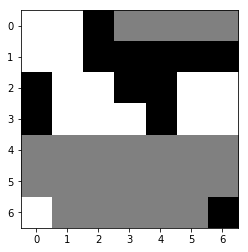

((3, 4), (4, 4)): n_v:   536 q_all:-0.027591 q:-0.005494 q_m:+0.100000 p:0.159003
((3, 0), (4, 1)): n_v:   535 q_all:-0.013705 q:-0.004154 q_m:+0.100000 p:0.129751
((3, 4), (4, 3)): n_v:   269 q_all:-0.035297 q:-0.053822 q_m:+0.100000 p:0.088415
((3, 4), (4, 5)): n_v:   163 q_all:-0.023397 q:-0.007118 q_m:+0.100000 p:0.045880
((3, 0), (4, 0)): n_v:   133 q_all:-0.068691 q:-0.017787 q_m:+0.033333 p:0.061443
((6, 6), (4, 6)): n_v:   115 q_all:+0.006250 q:+0.025466 q_m:+0.066667 p:0.018081
((6, 6), (4, 5)): n_v:   112 q_all:-0.039649 q:-0.012429 q_m:+0.066667 p:0.038839
((0, 2), (0, 3)): n_v:   100 q_all:-0.050752 q:-0.084123 q_m:-0.033333 p:0.039069
((1, 5), (0, 6)): n_v:    87 q_all:-0.096860 q:-0.069719 q_m:-0.033333 p:0.050466
((1, 4), (0, 5)): n_v:    83 q_all:-0.062592 q:-0.090713 q_m:-0.033333 p:0.036630
((3, 4), (4, 2)): n_v:    68 q_all:-0.076906 q:-0.074535 q_m:+0.133333 p:0.033850
((3, 0), (4, 2)): n_v:    39 q_all:-0.022963 q:-0.032125 q_m:+0.133333 p:0.010903
((6, 6), (4, 4))

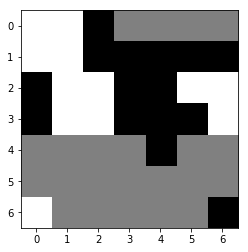

((3, 2), (4, 3)): n_v:  1552 q_all:+0.056554 q:+0.041997 q_m:+0.133333 p:0.607584
((3, 6), (4, 5)): n_v:   279 q_all:+0.038414 q:+0.027208 q_m:+0.133333 p:0.130245
((0, 1), (0, 3)): n_v:   148 q_all:+0.051386 q:+0.031553 q_m:+0.166667 p:0.061390
((2, 5), (0, 3)): n_v:    85 q_all:+0.060435 q:+0.096944 q_m:+0.166667 p:0.032074
((3, 1), (4, 1)): n_v:    58 q_all:+0.002361 q:-0.020193 q_m:-0.000000 p:0.035855
((2, 1), (0, 3)): n_v:    40 q_all:-0.031447 q:+0.031937 q_m:+0.166667 p:0.030179
((2, 2), (0, 3)): n_v:    27 q_all:+0.024893 q:+0.029857 q_m:+0.166667 p:0.014517
((2, 6), (0, 5)): n_v:    15 q_all:-0.027013 q:+0.072314 q_m:+0.100000 p:0.010877
((6, 0), (4, 1)): n_v:    11 q_all:-0.044438 q:-0.042935 q_m:-0.033333 p:0.009480
((2, 6), (4, 5)): n_v:    11 q_all:-0.038709 q:+0.017152 q_m:+0.100000 p:0.008701
((3, 1), (4, 3)): n_v:     5 q_all:-0.034764 q:-0.005240 q_m:+0.100000 p:0.004015
((1, 1), (0, 3)): n_v:     4 q_all:-0.236767 q:-0.066166 q_m:+0.166667 p:0.007810
((3, 1), (4, 0))

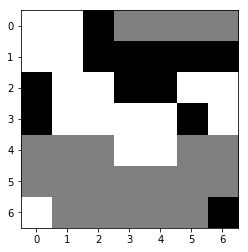

((3, 0), (4, 1)): n_v:  1526 q_all:-0.069045 q:-0.053091 q_m:+0.033333 p:0.589327
((3, 5), (4, 5)): n_v:   795 q_all:-0.024448 q:+0.000745 q_m:+0.100000 p:0.180503
((6, 6), (4, 5)): n_v:   553 q_all:-0.042899 q:-0.020353 q_m:+0.066667 p:0.162275
((3, 0), (4, 2)): n_v:   124 q_all:-0.020086 q:-0.009564 q_m:+0.133333 p:0.026413
((2, 0), (4, 2)): n_v:    40 q_all:-0.027038 q:-0.041157 q_m:+0.133333 p:0.008775
((2, 0), (4, 1)): n_v:    10 q_all:-0.090528 q:-0.083182 q_m:-0.000000 p:0.004828
((2, 3), (4, 5)): n_v:     4 q_all:-0.147499 q:-0.093497 q_m:+0.066667 p:0.003173
((1, 4), (0, 5)): n_v:     3 q_all:-0.156466 q:-0.180219 q_m:-0.100000 p:0.002408
((3, 0), (4, 0)): n_v:     3 q_all:-0.086362 q:-0.103465 q_m:-0.033333 p:0.001511
((0, 2), (0, 3)): n_v:     2 q_all:-0.171372 q:-0.176623 q_m:-0.100000 p:0.001678
((2, 3), (4, 1)): n_v:     2 q_all:-0.165693 q:-0.093313 q_m:-0.000000 p:0.002009
((2, 3), (4, 2)): n_v:     1 q_all:-0.112385 q:-0.070165 q_m:+0.133333 p:0.000472
((3, 5), (4, 6))

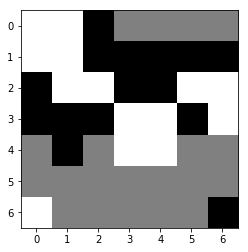

((3, 3), (4, 2)): n_v:  1747 q_all:+0.101347 q:+0.086123 q_m:+0.200000 p:0.268535
((2, 2), (0, 3)): n_v:   228 q_all:+0.131861 q:+0.058924 q_m:+0.233333 p:0.010695
((0, 1), (0, 3)): n_v:   165 q_all:+0.100452 q:+0.066965 q_m:+0.233333 p:0.025916
((4, 4), (4, 2)): n_v:   160 q_all:+0.063528 q:+0.050316 q_m:+0.166667 p:0.045944
((2, 1), (0, 3)): n_v:   156 q_all:+0.054193 q:+0.089504 q_m:+0.233333 p:0.049332
((6, 0), (4, 2)): n_v:   151 q_all:+0.067218 q:+0.058868 q_m:+0.166667 p:0.041238
((2, 2), (4, 0)): n_v:    87 q_all:+0.024985 q:-0.029155 q_m:+0.166667 p:0.036502
((6, 0), (4, 0)): n_v:    79 q_all:+0.062210 q:+0.095227 q_m:+0.166667 p:0.023056
((2, 5), (0, 3)): n_v:    79 q_all:+0.097695 q:+0.119653 q_m:+0.233333 p:0.013163
((3, 6), (4, 6)): n_v:    52 q_all:-0.004396 q:+0.034423 q_m:+0.066667 p:0.027492
((3, 4), (4, 2)): n_v:    44 q_all:+0.032531 q:+0.037792 q_m:+0.166667 p:0.017472
((2, 6), (0, 5)): n_v:    38 q_all:+0.057029 q:+0.076711 q_m:+0.166667 p:0.011768
((2, 5), (0, 5))

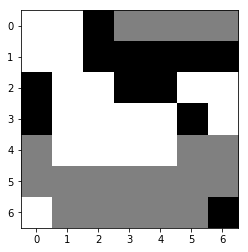

((3, 5), (4, 5)): n_v:  2212 q_all:-0.106452 q:-0.082632 q_m:+0.033333 p:0.676424
((6, 6), (4, 5)): n_v:   743 q_all:-0.113884 q:-0.095754 q_m:-0.000000 p:0.246117
((3, 0), (4, 0)): n_v:   134 q_all:-0.059730 q:-0.084953 q_m:-0.033333 p:0.019588
((3, 5), (4, 6)): n_v:    29 q_all:-0.173806 q:-0.174679 q_m:-0.100000 p:0.015895
((3, 0), (5, 1)): n_v:    24 q_all:-0.029231 q:-0.062163 q_m:-0.000000 p:0.002215
((2, 3), (4, 5)): n_v:    22 q_all:-0.212695 q:-0.166131 q_m:-0.000000 p:0.014613
((6, 6), (5, 5)): n_v:     8 q_all:-0.138353 q:-0.122876 q_m:-0.100000 p:0.003552
((3, 0), (5, 2)): n_v:     6 q_all:-0.086355 q:-0.056686 q_m:-0.000000 p:0.001458
((2, 4), (4, 5)): n_v:     3 q_all:-0.297739 q:-0.182798 q_m:-0.000000 p:0.003155
((0, 2), (0, 3)): n_v:     1 q_all:-0.252048 q:-0.245985 q_m:-0.166667 p:0.001140
((3, 5), (5, 3)): n_v:     1 q_all:-0.061411 q:-0.051057 q_m:-0.000000 p:0.000225
((1, 4), (0, 5)): n_v:     1 q_all:-0.265178 q:-0.259140 q_m:-0.166667 p:0.001026
((6, 6), (4, 6))

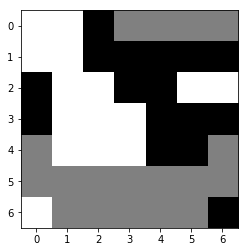

((3, 1), (4, 0)): n_v:  1410 q_all:+0.115601 q:+0.100388 q_m:+0.066667 p:0.189041
((2, 5), (0, 3)): n_v:  1114 q_all:+0.141539 q:+0.195509 q_m:+0.233333 p:0.057558
((0, 1), (0, 3)): n_v:   440 q_all:+0.072397 q:+0.060295 q_m:+0.233333 p:0.119360
((6, 0), (4, 0)): n_v:   205 q_all:+0.120054 q:+0.115036 q_m:+0.033333 p:0.024638
((2, 6), (0, 5)): n_v:   109 q_all:+0.078958 q:+0.122297 q_m:+0.166667 p:0.027301
((2, 6), (4, 6)): n_v:    66 q_all:-0.003224 q:+0.046667 q_m:+0.166667 p:0.034050
((2, 2), (4, 0)): n_v:    61 q_all:-0.069031 q:-0.024068 q_m:+0.033333 p:0.044508
((2, 5), (0, 5)): n_v:    51 q_all:+0.062556 q:+0.138348 q_m:+0.166667 p:0.015666
((2, 1), (0, 3)): n_v:    46 q_all:-0.016193 q:+0.072214 q_m:+0.233333 p:0.025377
((2, 2), (0, 3)): n_v:    27 q_all:+0.010376 q:+0.054249 q_m:+0.233333 p:0.012806
((4, 3), (5, 5)): n_v:    26 q_all:+0.036282 q:+0.053086 q_m:+0.166667 p:0.010050
((1, 1), (0, 3)): n_v:    20 q_all:-0.136871 q:-0.027824 q_m:+0.233333 p:0.019268
((4, 1), (5, 1))

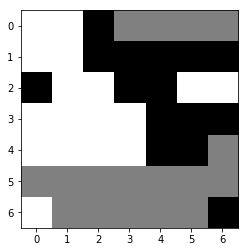

((3, 5), (4, 6)): n_v:   598 q_all:-0.091942 q:-0.135834 q_m:-0.033333 p:0.037486
((4, 4), (5, 2)): n_v:   541 q_all:-0.087285 q:-0.075192 q_m:+0.133333 p:0.024986
((4, 4), (5, 3)): n_v:   485 q_all:-0.124749 q:-0.078496 q_m:+0.100000 p:0.088436
((1, 4), (0, 5)): n_v:   198 q_all:-0.146370 q:-0.163386 q_m:-0.033333 p:0.051420
((0, 2), (0, 3)): n_v:   188 q_all:-0.141740 q:-0.174286 q_m:-0.033333 p:0.045936
((4, 4), (5, 5)): n_v:   176 q_all:-0.151052 q:-0.171138 q_m:-0.033333 p:0.049108
((4, 4), (5, 4)): n_v:   135 q_all:-0.129191 q:-0.107769 q_m:+0.033333 p:0.026968
((6, 6), (4, 6)): n_v:   120 q_all:-0.100017 q:-0.137137 q_m:-0.066667 p:0.011064
((6, 6), (6, 5)): n_v:    83 q_all:-0.122025 q:-0.162509 q_m:-0.033333 p:0.014201
((1, 5), (0, 6)): n_v:    80 q_all:-0.147462 q:-0.161704 q_m:-0.033333 p:0.021058
((3, 6), (5, 5)): n_v:    54 q_all:-0.155245 q:-0.182649 q_m:-0.066667 p:0.016133
((1, 3), (0, 5)): n_v:    26 q_all:-0.253424 q:-0.219752 q_m:-0.066667 p:0.017257
((3, 6), (5, 4))

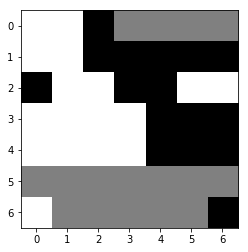

((2, 5), (0, 3)): n_v:   830 q_all:+0.208213 q:+0.285601 q_m:+0.300000 p:0.012585
((0, 1), (0, 3)): n_v:   546 q_all:+0.121273 q:+0.143702 q_m:+0.300000 p:0.202843
((4, 0), (5, 1)): n_v:   235 q_all:+0.097626 q:+0.088691 q_m:+0.066667 p:0.110252
((4, 3), (5, 5)): n_v:   227 q_all:+0.100680 q:+0.139921 q_m:+0.300000 p:0.104350
((2, 6), (0, 4)): n_v:   177 q_all:+0.197006 q:+0.113708 q_m:+0.233333 p:0.006312
((2, 6), (0, 5)): n_v:    85 q_all:+0.114095 q:+0.219391 q_m:+0.233333 p:0.034301
((4, 2), (5, 3)): n_v:    44 q_all:+0.036696 q:+0.126650 q_m:+0.133333 p:0.032438
((2, 2), (0, 3)): n_v:    30 q_all:+0.017089 q:+0.090427 q_m:+0.300000 p:0.023946
((6, 0), (6, 1)): n_v:    21 q_all:+0.128234 q:+0.100425 q_m:+0.066667 p:0.007094
((2, 1), (0, 3)): n_v:    19 q_all:-0.108754 q:+0.111813 q_m:+0.300000 p:0.025019
((4, 3), (5, 1)): n_v:    16 q_all:-0.064508 q:+0.012708 q_m:+0.033333 p:0.018614
((1, 1), (0, 3)): n_v:    15 q_all:-0.210880 q:+0.053153 q_m:+0.300000 p:0.026110
((2, 5), (0, 5))

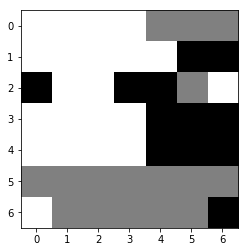

((1, 5), (2, 5)): n_v:  2492 q_all:-0.235579 q:-0.183188 q_m:-0.133333 p:0.272557
((4, 6), (2, 5)): n_v:    69 q_all:-0.241351 q:-0.214848 q_m:-0.166667 p:0.009166
((2, 3), (2, 5)): n_v:    11 q_all:-0.254194 q:-0.254227 q_m:-0.166667 p:0.002173
((4, 5), (2, 5)): n_v:     8 q_all:-0.285338 q:-0.216248 q_m:-0.166667 p:0.002579
((4, 4), (2, 5)): n_v:     4 q_all:-0.277957 q:-0.258958 q_m:-0.166667 p:0.001200
((1, 5), (0, 4)): n_v:     4 q_all:-0.390657 q:-0.254456 q_m:-0.066667 p:0.003161
((1, 6), (0, 4)): n_v:     1 q_all:-0.294596 q:-0.253224 q_m:-0.100000 p:0.000272
((4, 4), (6, 3)): n_v:     0 q_all:-0.354647 q:-0.354647 q_m:-0.300000 p:0.000009
((2, 4), (0, 6)): n_v:     0 q_all:-0.376473 q:-0.376473 q_m:-0.300000 p:0.000009
((3, 6), (5, 4)): n_v:     0 q_all:-0.310936 q:-0.310936 q_m:-0.233333 p:0.000009
((6, 6), (6, 4)): n_v:     0 q_all:-0.339309 q:-0.339309 q_m:-0.300000 p:0.000046
((4, 4), (5, 6)): n_v:     0 q_all:-0.371482 q:-0.371482 q_m:-0.300000 p:0.000002
((4, 4), (5, 3))

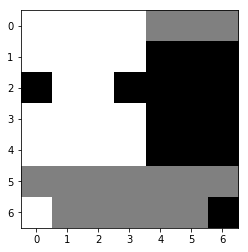

((0, 3), (0, 5)): n_v:  3522 q_all:+0.257889 q:+0.184752 q_m:+0.333333 p:0.595032
((4, 3), (5, 5)): n_v:   280 q_all:+0.251941 q:+0.232935 q_m:+0.400000 p:0.052359
((1, 3), (0, 5)): n_v:   177 q_all:+0.171266 q:+0.157880 q_m:+0.333333 p:0.077129
((0, 3), (0, 4)): n_v:    66 q_all:+0.138256 q:+0.186420 q_m:+0.300000 p:0.035460
((4, 0), (5, 1)): n_v:    48 q_all:+0.145066 q:+0.193847 q_m:+0.166667 p:0.024940
((4, 3), (5, 1)): n_v:    41 q_all:+0.045987 q:+0.100149 q_m:+0.133333 p:0.033918
((3, 3), (5, 5)): n_v:    16 q_all:+0.239498 q:+0.225081 q_m:+0.400000 p:0.003430
((4, 2), (5, 3)): n_v:    10 q_all:+0.185324 q:+0.217485 q_m:+0.233333 p:0.004245
((4, 3), (6, 5)): n_v:     9 q_all:+0.115797 q:+0.155336 q_m:+0.200000 p:0.005525
((4, 3), (5, 4)): n_v:     9 q_all:+0.138514 q:+0.163217 q_m:+0.300000 p:0.005121
((6, 0), (6, 1)): n_v:     9 q_all:+0.117159 q:+0.196575 q_m:+0.166667 p:0.005048
((3, 0), (5, 1)): n_v:     5 q_all:+0.021035 q:+0.073565 q_m:+0.133333 p:0.005013
((3, 3), (5, 1))

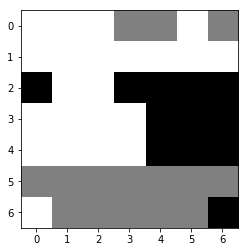

((2, 3), (0, 4)): n_v:  2007 q_all:-0.192303 q:-0.231661 q_m:-0.066667 p:0.085307
((2, 6), (0, 4)): n_v:  1843 q_all:-0.248235 q:-0.263321 q_m:-0.066667 p:0.361957
((4, 4), (5, 3)): n_v:   164 q_all:-0.277306 q:-0.268350 q_m:-0.166667 p:0.045208
((2, 3), (0, 3)): n_v:   144 q_all:-0.315343 q:-0.322025 q_m:-0.066667 p:0.055108
((2, 5), (0, 3)): n_v:   101 q_all:-0.338459 q:-0.295621 q_m:-0.066667 p:0.045297
((2, 4), (0, 6)): n_v:    94 q_all:-0.295685 q:-0.245858 q_m:-0.133333 p:0.030964
((2, 6), (0, 6)): n_v:    91 q_all:-0.280427 q:-0.244841 q_m:-0.133333 p:0.025945
((4, 4), (5, 5)): n_v:    78 q_all:-0.335781 q:-0.311704 q_m:-0.300000 p:0.034413
((2, 5), (0, 4)): n_v:    75 q_all:-0.325612 q:-0.268734 q_m:-0.066667 p:0.030781
((2, 4), (0, 3)): n_v:    49 q_all:-0.317289 q:-0.283808 q_m:-0.066667 p:0.019083
((2, 4), (0, 4)): n_v:    30 q_all:-0.342132 q:-0.295680 q_m:-0.066667 p:0.014069
((4, 6), (6, 4)): n_v:    30 q_all:-0.353828 q:-0.339348 q_m:-0.333333 p:0.014647
((4, 4), (6, 2))

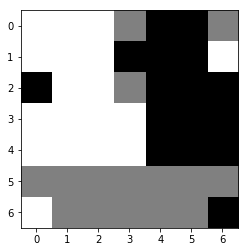

((1, 2), (2, 3)): n_v:  3354 q_all:+0.231986 q:+0.305885 q_m:+0.366667 p:0.282228
((0, 2), (2, 3)): n_v:   159 q_all:+0.192948 q:+0.225808 q_m:+0.333333 p:0.024696
((4, 1), (2, 3)): n_v:    14 q_all:+0.165657 q:+0.209503 q_m:+0.333333 p:0.003971
((0, 1), (2, 3)): n_v:     8 q_all:+0.127750 q:+0.148429 q_m:+0.333333 p:0.003478
((4, 2), (2, 3)): n_v:     6 q_all:+0.195753 q:+0.222689 q_m:+0.333333 p:0.000793
((3, 1), (2, 3)): n_v:     2 q_all:-0.030523 q:+0.079158 q_m:+0.333333 p:0.001525
((1, 1), (2, 3)): n_v:     2 q_all:-0.065280 q:+0.050070 q_m:+0.333333 p:0.002317
((2, 1), (2, 3)): n_v:     1 q_all:+0.014727 q:+0.115962 q_m:+0.333333 p:0.000675
((0, 2), (0, 3)): n_v:     1 q_all:+0.098069 q:+0.169503 q_m:+0.300000 p:0.000383
((4, 0), (5, 2)): n_v:     0 q_all:-0.043219 q:-0.043219 q_m:+0.066667 p:0.000000
((4, 2), (6, 1)): n_v:     0 q_all:-0.018993 q:-0.018993 q_m:+0.066667 p:0.000000
((4, 2), (6, 2)): n_v:     0 q_all:-0.008422 q:-0.008422 q_m:+0.066667 p:0.000000
((4, 2), (5, 3))

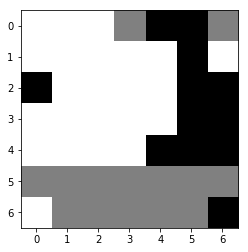

((0, 4), (0, 3)): n_v:  4342 q_all:-0.213748 q:-0.159816 q_m:-0.066667 p:0.697916
((0, 5), (0, 3)): n_v:   405 q_all:-0.298613 q:-0.240431 q_m:-0.100000 p:0.161463
((1, 5), (0, 3)): n_v:   144 q_all:-0.362777 q:-0.259793 q_m:-0.100000 p:0.082985
((2, 5), (0, 3)): n_v:    55 q_all:-0.337618 q:-0.240348 q_m:-0.100000 p:0.028055
((4, 4), (6, 3)): n_v:    20 q_all:-0.415415 q:-0.388036 q_m:-0.366667 p:0.014807
((4, 5), (6, 3)): n_v:     5 q_all:-0.428731 q:-0.366240 q_m:-0.366667 p:0.003836
((0, 5), (0, 6)): n_v:     5 q_all:-0.337525 q:-0.257235 q_m:-0.266667 p:0.002613
((4, 4), (5, 3)): n_v:     1 q_all:-0.352041 q:-0.305356 q_m:-0.200000 p:0.000912
((4, 4), (5, 2)): n_v:     1 q_all:-0.333179 q:-0.308234 q_m:-0.166667 p:0.000820
((0, 4), (0, 6)): n_v:     1 q_all:-0.377142 q:-0.308496 q_m:-0.300000 p:0.000799
((4, 6), (6, 5)): n_v:     0 q_all:-0.394159 q:-0.394159 q_m:-0.366667 p:0.000036
((3, 6), (5, 4)): n_v:     0 q_all:-0.357138 q:-0.357138 q_m:-0.300000 p:0.000007
((3, 5), (5, 4))

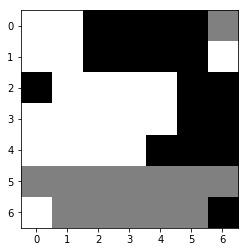

((1, 6), (0, 6)): n_v:  4652 q_all:+0.273660 q:+0.270821 q_m:+0.233333 p:0.747025
((4, 3), (5, 5)): n_v:    92 q_all:+0.179438 q:+0.078115 q_m:+0.333333 p:0.036619
((2, 4), (0, 6)): n_v:    86 q_all:+0.047734 q:+0.116820 q_m:+0.200000 p:0.063235
((4, 2), (5, 3)): n_v:    49 q_all:+0.077090 q:+0.086508 q_m:+0.166667 p:0.032687
((4, 0), (5, 1)): n_v:    19 q_all:+0.061432 q:+0.097023 q_m:+0.100000 p:0.013756
((4, 3), (5, 1)): n_v:     9 q_all:-0.106959 q:-0.072306 q_m:+0.066667 p:0.011079
((3, 0), (5, 1)): n_v:     4 q_all:-0.098730 q:-0.037269 q_m:+0.066667 p:0.004163
((4, 0), (5, 0)): n_v:     2 q_all:+0.055327 q:+0.103817 q_m:+0.100000 p:0.002057
((4, 3), (5, 4)): n_v:     2 q_all:+0.066209 q:+0.005563 q_m:+0.233333 p:0.001842
((3, 4), (5, 5)): n_v:     1 q_all:+0.010735 q:+0.079980 q_m:+0.333333 p:0.000726
((3, 0), (5, 0)): n_v:     1 q_all:-0.126387 q:-0.022720 q_m:+0.066667 p:0.000935
((3, 3), (5, 5)): n_v:     1 q_all:+0.006150 q:+0.006150 q_m:+0.333333 p:0.001638
((4, 0), (5, 2))

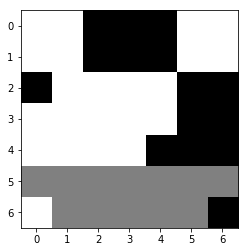

((4, 4), (5, 2)): n_v:  2315 q_all:-0.233465 q:-0.170108 q_m:-0.033333 p:0.131177
((4, 4), (5, 3)): n_v:  1335 q_all:-0.271206 q:-0.205293 q_m:-0.066667 p:0.201433
((4, 4), (5, 4)): n_v:   264 q_all:-0.293908 q:-0.218839 q_m:-0.133333 p:0.054665
((4, 4), (5, 5)): n_v:   186 q_all:-0.331905 q:-0.290550 q_m:-0.200000 p:0.056447
((6, 6), (6, 5)): n_v:   172 q_all:-0.325908 q:-0.290684 q_m:-0.200000 p:0.049264
((3, 6), (5, 5)): n_v:   138 q_all:-0.385722 q:-0.360892 q_m:-0.233333 p:0.060694
((4, 6), (5, 4)): n_v:   114 q_all:-0.324049 q:-0.261223 q_m:-0.166667 p:0.032460
((3, 6), (5, 4)): n_v:    78 q_all:-0.339783 q:-0.291840 q_m:-0.166667 p:0.025338
((6, 6), (5, 4)): n_v:    65 q_all:-0.306293 q:-0.227534 q_m:-0.166667 p:0.015495
((4, 5), (5, 3)): n_v:    59 q_all:-0.273447 q:-0.174467 q_m:-0.100000 p:0.008977
((4, 6), (6, 5)): n_v:    48 q_all:-0.311088 q:-0.298125 q_m:-0.233333 p:0.012121
((4, 5), (5, 6)): n_v:    33 q_all:-0.335477 q:-0.269944 q_m:-0.200000 p:0.010391
((4, 4), (6, 2))

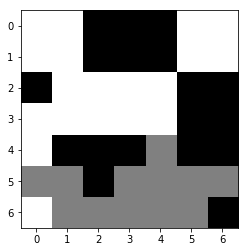

((4, 0), (5, 1)): n_v:  3519 q_all:+0.293735 q:+0.279594 q_m:+0.266667 p:0.582865
((3, 3), (4, 4)): n_v:    75 q_all:+0.230259 q:+0.247260 q_m:+0.266667 p:0.027546
((3, 0), (5, 1)): n_v:    25 q_all:+0.115494 q:+0.140556 q_m:+0.233333 p:0.018424
((3, 3), (5, 1)): n_v:     1 q_all:-0.057108 q:+0.090183 q_m:+0.233333 p:0.001490
((4, 0), (6, 2)): n_v:     0 q_all:+0.093127 q:+0.093127 q_m:+0.100000 p:0.000041
((3, 2), (5, 3)): n_v:     0 q_all:+0.024325 q:+0.024325 q_m:+0.233333 p:0.000054
((3, 1), (5, 3)): n_v:     0 q_all:+0.058545 q:+0.058545 q_m:+0.233333 p:0.000075
((3, 2), (4, 4)): n_v:     0 q_all:-0.028070 q:-0.028070 q_m:+0.233333 p:0.000051
((2, 3), (4, 4)): n_v:     0 q_all:-0.027512 q:-0.027512 q_m:+0.233333 p:0.000025
((2, 4), (4, 4)): n_v:     0 q_all:+0.033529 q:+0.033529 q_m:+0.233333 p:0.000010
((4, 0), (5, 0)): n_v:     0 q_all:+0.149519 q:+0.149519 q_m:+0.133333 p:0.000270
((6, 0), (6, 2)): n_v:     0 q_all:+0.200576 q:+0.200576 q_m:+0.100000 p:0.000208
((3, 1), (5, 1))

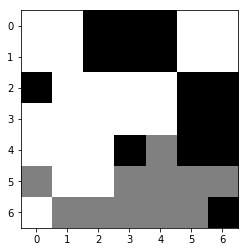

((4, 3), (6, 1)): n_v:  2033 q_all:-0.190147 q:-0.257845 q_m:-0.066667 p:0.105458
((3, 5), (4, 4)): n_v:   981 q_all:-0.247297 q:-0.165142 q_m:-0.100000 p:0.116988
((4, 3), (6, 5)): n_v:   535 q_all:-0.329542 q:-0.267516 q_m:-0.266667 p:0.212242
((3, 6), (4, 4)): n_v:   230 q_all:-0.322141 q:-0.265965 q_m:-0.133333 p:0.085174
((4, 3), (5, 3)): n_v:   147 q_all:-0.276684 q:-0.190348 q_m:-0.100000 p:0.032223
((6, 6), (4, 4)): n_v:   112 q_all:-0.253663 q:-0.170282 q_m:-0.133333 p:0.015705
((4, 6), (4, 4)): n_v:   108 q_all:-0.290868 q:-0.228730 q_m:-0.133333 p:0.028747
((2, 5), (4, 4)): n_v:    88 q_all:-0.371027 q:-0.275316 q_m:-0.133333 p:0.047165
((4, 3), (6, 4)): n_v:    85 q_all:-0.345273 q:-0.280290 q_m:-0.266667 p:0.038611
((2, 6), (4, 4)): n_v:    57 q_all:-0.325823 q:-0.280346 q_m:-0.133333 p:0.022198
((4, 3), (6, 2)): n_v:    51 q_all:-0.301981 q:-0.261772 q_m:-0.133333 p:0.015727
((3, 6), (5, 6)): n_v:    30 q_all:-0.441765 q:-0.389380 q_m:-0.266667 p:0.022644
((6, 6), (6, 5))

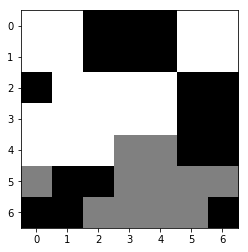

((4, 0), (5, 0)): n_v:  3537 q_all:+0.295673 q:+0.388613 q_m:+0.300000 p:0.489413
((4, 2), (5, 0)): n_v:    90 q_all:+0.170678 q:+0.278101 q_m:+0.266667 p:0.032436
((3, 0), (5, 0)): n_v:    36 q_all:+0.065226 q:+0.261246 q_m:+0.266667 p:0.029744
((4, 0), (6, 2)): n_v:     2 q_all:+0.126246 q:+0.175007 q_m:+0.266667 p:0.001650
((3, 4), (5, 6)): n_v:     2 q_all:+0.136695 q:+0.064519 q_m:+0.266667 p:0.001387
((3, 2), (5, 0)): n_v:     1 q_all:+0.016073 q:+0.087531 q_m:+0.266667 p:0.001861
((3, 1), (5, 0)): n_v:     1 q_all:-0.079351 q:+0.080949 q_m:+0.266667 p:0.001497
((4, 2), (6, 2)): n_v:     0 q_all:+0.159966 q:+0.159966 q_m:+0.266667 p:0.000390
((3, 3), (4, 4)): n_v:     0 q_all:+0.091740 q:+0.091740 q_m:+0.233333 p:0.000081
((3, 2), (5, 3)): n_v:     0 q_all:-0.054610 q:-0.054610 q_m:+0.133333 p:0.000001
((3, 1), (5, 3)): n_v:     0 q_all:-0.085648 q:-0.085648 q_m:+0.133333 p:0.000001
((2, 2), (4, 3)): n_v:     0 q_all:-0.093645 q:-0.093645 q_m:+0.133333 p:0.000001
((3, 2), (5, 4))

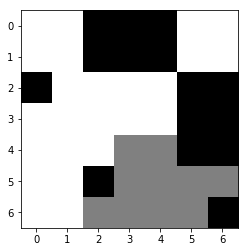

((5, 2), (4, 3)): n_v:  4471 q_all:-0.240061 q:-0.156357 q_m:-0.000000 p:0.703745
((2, 5), (4, 3)): n_v:   207 q_all:-0.363215 q:-0.273710 q_m:-0.033333 p:0.102921
((5, 2), (6, 2)): n_v:   149 q_all:-0.298329 q:-0.286921 q_m:-0.133333 p:0.047577
((4, 5), (4, 3)): n_v:   135 q_all:-0.296725 q:-0.169941 q_m:-0.033333 p:0.041941
((3, 5), (4, 3)): n_v:   129 q_all:-0.346737 q:-0.236433 q_m:-0.033333 p:0.058177
((5, 2), (6, 4)): n_v:    20 q_all:-0.406889 q:-0.315728 q_m:-0.300000 p:0.012666
((6, 6), (6, 4)): n_v:    13 q_all:-0.401838 q:-0.312862 q_m:-0.300000 p:0.008114
((5, 2), (4, 4)): n_v:     8 q_all:-0.346588 q:-0.237164 q_m:-0.166667 p:0.003551
((3, 5), (4, 4)): n_v:     7 q_all:-0.365678 q:-0.235473 q_m:-0.133333 p:0.003449
((4, 6), (6, 4)): n_v:     5 q_all:-0.410727 q:-0.364825 q_m:-0.300000 p:0.003489
((4, 6), (4, 4)): n_v:     3 q_all:-0.410486 q:-0.298633 q_m:-0.166667 p:0.002052
((3, 6), (4, 4)): n_v:     3 q_all:-0.425457 q:-0.341368 q_m:-0.166667 p:0.002245
((6, 6), (4, 4))

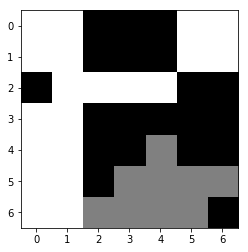

((6, 1), (5, 3)): n_v:  4208 q_all:+0.294283 q:+0.436745 q_m:+0.200000 p:0.566503
((5, 1), (6, 2)): n_v:   278 q_all:+0.220546 q:+0.307623 q_m:+0.100000 p:0.089425
((2, 4), (4, 4)): n_v:   125 q_all:+0.119234 q:+0.124748 q_m:+0.333333 p:0.071859
((2, 3), (4, 4)): n_v:    67 q_all:+0.102212 q:+0.123967 q_m:+0.333333 p:0.041860
((2, 2), (4, 4)): n_v:    52 q_all:+0.042507 q:+0.074976 q_m:+0.333333 p:0.040850
((5, 1), (5, 3)): n_v:    46 q_all:+0.160167 q:+0.250751 q_m:+0.200000 p:0.021329
((6, 0), (6, 2)): n_v:    38 q_all:+0.154659 q:+0.215039 q_m:+0.066667 p:0.018839
((6, 1), (6, 3)): n_v:    35 q_all:+0.251721 q:+0.194835 q_m:+0.066667 p:0.008668
((4, 1), (5, 3)): n_v:    16 q_all:-0.015581 q:+0.148395 q_m:+0.200000 p:0.014070
((5, 0), (6, 2)): n_v:    12 q_all:+0.116892 q:+0.108012 q_m:+0.066667 p:0.006797
((3, 1), (5, 3)): n_v:     4 q_all:+0.006689 q:+0.164101 q_m:+0.200000 p:0.003309
((4, 0), (6, 2)): n_v:     4 q_all:+0.004353 q:+0.035584 q_m:+0.066667 p:0.004281
((4, 1), (6, 2))

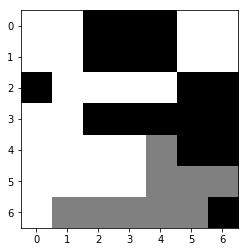

((3, 3), (4, 4)): n_v:  2862 q_all:-0.230986 q:-0.171484 q_m:-0.033333 p:0.165347
((6, 6), (4, 4)): n_v:   649 q_all:-0.227928 q:-0.151571 q_m:-0.066667 p:0.032184
((3, 2), (4, 4)): n_v:   645 q_all:-0.215357 q:-0.203579 q_m:-0.066667 p:0.011029
((3, 6), (4, 4)): n_v:   235 q_all:-0.305664 q:-0.255773 q_m:-0.066667 p:0.059221
((4, 6), (4, 4)): n_v:   190 q_all:-0.277251 q:-0.224936 q_m:-0.066667 p:0.033634
((2, 6), (4, 4)): n_v:    51 q_all:-0.336747 q:-0.278764 q_m:-0.066667 p:0.016750
((4, 5), (5, 4)): n_v:    28 q_all:-0.313759 q:-0.236594 q_m:-0.033333 p:0.007540
((4, 6), (6, 5)): n_v:    27 q_all:-0.420972 q:-0.396105 q_m:-0.200000 p:0.015057
((6, 6), (6, 5)): n_v:    26 q_all:-0.395572 q:-0.372201 q_m:-0.166667 p:0.012787
((2, 5), (4, 4)): n_v:    19 q_all:-0.370358 q:-0.295451 q_m:-0.066667 p:0.007855
((3, 3), (5, 4)): n_v:    13 q_all:-0.309249 q:-0.274008 q_m:-0.066667 p:0.003445
((6, 6), (5, 4)): n_v:     9 q_all:-0.316410 q:-0.235802 q_m:-0.066667 p:0.002351
((3, 4), (5, 4))

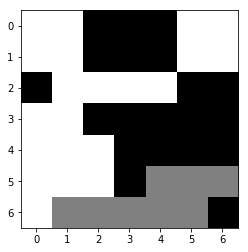

((5, 2), (5, 4)): n_v:  1627 q_all:+0.267629 q:+0.290533 q_m:+0.300000 p:0.457712
((5, 2), (6, 3)): n_v:  1049 q_all:+0.336390 q:+0.266172 q_m:+0.133333 p:0.082873
((5, 1), (6, 2)): n_v:   667 q_all:+0.311826 q:+0.263405 q_m:+0.133333 p:0.100855
((4, 2), (5, 4)): n_v:   218 q_all:+0.115999 q:+0.145804 q_m:+0.300000 p:0.158838
((6, 0), (6, 2)): n_v:   145 q_all:+0.345746 q:+0.188123 q_m:+0.100000 p:0.007299
((5, 0), (6, 1)): n_v:    25 q_all:+0.168368 q:+0.228771 q_m:+0.066667 p:0.013796
((5, 0), (6, 2)): n_v:    15 q_all:+0.223322 q:+0.094713 q_m:+0.100000 p:0.006450
((5, 1), (6, 3)): n_v:     8 q_all:+0.153050 q:+0.119746 q_m:+0.100000 p:0.005371
((5, 2), (6, 4)): n_v:     8 q_all:+0.095092 q:+0.108355 q_m:+0.100000 p:0.006300
((4, 0), (6, 2)): n_v:     4 q_all:-0.013318 q:-0.049333 q_m:+0.100000 p:0.004073
((4, 2), (6, 3)): n_v:     3 q_all:-0.015410 q:-0.001657 q_m:+0.100000 p:0.004064
((4, 0), (6, 1)): n_v:     3 q_all:-0.116681 q:-0.085909 q_m:+0.033333 p:0.004879
((4, 2), (6, 4))

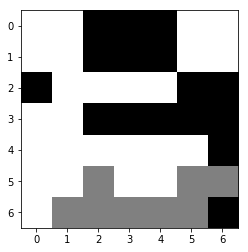

((4, 6), (5, 5)): n_v:  1752 q_all:-0.171658 q:-0.158302 q_m:-0.066667 p:0.250253
((3, 4), (5, 2)): n_v:   421 q_all:-0.278838 q:-0.355372 q_m:+0.033333 p:0.215427
((3, 3), (5, 2)): n_v:   221 q_all:-0.279396 q:-0.287981 q_m:+0.033333 p:0.113674
((3, 6), (5, 5)): n_v:   105 q_all:-0.356004 q:-0.331244 q_m:-0.100000 p:0.081501
((3, 3), (5, 5)): n_v:    62 q_all:-0.332614 q:-0.297810 q_m:-0.100000 p:0.043132
((3, 4), (5, 5)): n_v:    28 q_all:-0.467672 q:-0.431442 q_m:-0.100000 p:0.032411
((3, 2), (5, 2)): n_v:    24 q_all:-0.262485 q:-0.325688 q_m:+0.033333 p:0.011286
((6, 6), (6, 5)): n_v:    14 q_all:-0.573773 q:-0.516951 q_m:-0.200000 p:0.022124
((3, 5), (5, 5)): n_v:    12 q_all:-0.494003 q:-0.393006 q_m:-0.100000 p:0.015439
((4, 6), (5, 6)): n_v:     7 q_all:-0.513295 q:-0.488499 q_m:-0.200000 p:0.009733
((4, 6), (6, 5)): n_v:     3 q_all:-0.529977 q:-0.499880 q_m:-0.233333 p:0.004450
((6, 6), (6, 4)): n_v:     3 q_all:-0.352779 q:-0.373374 q_m:-0.166667 p:0.002652
((3, 4), (5, 6))

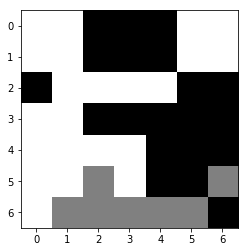

((4, 3), (6, 5)): n_v:  1491 q_all:+0.310508 q:+0.225580 q_m:+0.266667 p:0.051017
((5, 3), (6, 4)): n_v:   782 q_all:+0.222028 q:+0.261941 q_m:+0.233333 p:0.259395
((5, 3), (6, 5)): n_v:   591 q_all:+0.224615 q:+0.285162 q_m:+0.266667 p:0.162081
((5, 3), (6, 1)): n_v:   111 q_all:-0.011909 q:+0.119414 q_m:+0.066667 p:0.124528
((4, 3), (6, 4)): n_v:    95 q_all:+0.213778 q:+0.147788 q_m:+0.200000 p:0.031290
((4, 1), (5, 2)): n_v:    53 q_all:+0.245052 q:+0.212738 q_m:+0.100000 p:0.009448
((4, 3), (6, 1)): n_v:    31 q_all:+0.048056 q:+0.099449 q_m:+0.066667 p:0.028200
((4, 3), (6, 2)): n_v:    23 q_all:+0.028183 q:-0.000779 q_m:+0.066667 p:0.023645
((5, 0), (6, 1)): n_v:    16 q_all:+0.021161 q:+0.239669 q_m:+0.100000 p:0.017074
((5, 1), (6, 2)): n_v:    13 q_all:-0.012063 q:+0.140072 q_m:+0.100000 p:0.014570
((3, 0), (5, 2)): n_v:    11 q_all:-0.134926 q:+0.080836 q_m:+0.066667 p:0.017439
((5, 3), (6, 3)): n_v:    10 q_all:+0.079528 q:+0.225715 q_m:+0.166667 p:0.007680
((4, 0), (6, 1))

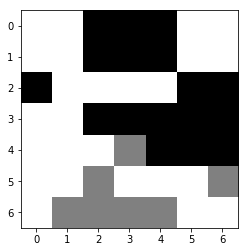

((4, 4), (5, 6)): n_v:  1989 q_all:-0.206213 q:-0.266666 q_m:-0.066667 p:0.210338
((4, 5), (5, 6)): n_v:   363 q_all:-0.330863 q:-0.164375 q_m:-0.033333 p:0.196528
((3, 4), (5, 6)): n_v:   343 q_all:-0.236430 q:-0.464792 q_m:-0.066667 p:0.071715
((3, 3), (5, 2)): n_v:   282 q_all:-0.226839 q:-0.269652 q_m:-0.000000 p:0.008374
((3, 6), (5, 6)): n_v:   103 q_all:-0.412247 q:-0.358325 q_m:-0.066667 p:0.086145
((3, 2), (4, 3)): n_v:    51 q_all:-0.321709 q:-0.245246 q_m:-0.033333 p:0.026304
((3, 5), (5, 6)): n_v:    46 q_all:-0.487297 q:-0.434633 q_m:-0.066667 p:0.050124
((4, 4), (5, 2)): n_v:    36 q_all:-0.354125 q:-0.292083 q_m:-0.000000 p:0.022817
((4, 4), (6, 2)): n_v:    11 q_all:-0.416528 q:-0.406573 q_m:-0.133333 p:0.009435
((3, 4), (5, 2)): n_v:     8 q_all:-0.271489 q:-0.387942 q_m:-0.000000 p:0.002150
((4, 6), (6, 4)): n_v:     3 q_all:-0.411533 q:-0.283624 q_m:-0.000000 p:0.003011
((4, 4), (6, 3)): n_v:     1 q_all:-0.384413 q:-0.383682 q_m:-0.133333 p:0.000899
((4, 5), (4, 3))

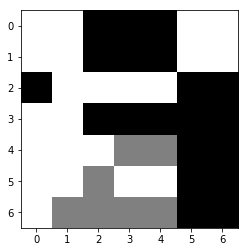

((4, 2), (4, 4)): n_v:  2328 q_all:+0.326581 q:+0.256244 q_m:+0.400000 p:0.244186
((5, 3), (4, 4)): n_v:   392 q_all:+0.187588 q:+0.280721 q_m:+0.433333 p:0.188061
((2, 3), (4, 4)): n_v:   285 q_all:+0.219643 q:+0.092445 q_m:+0.400000 p:0.095872
((2, 4), (4, 4)): n_v:   233 q_all:+0.221979 q:+0.061545 q_m:+0.400000 p:0.076268
((2, 2), (4, 4)): n_v:   191 q_all:+0.248757 q:-0.028355 q_m:+0.400000 p:0.039256
((5, 3), (6, 4)): n_v:   124 q_all:+0.247594 q:+0.290656 q_m:+0.233333 p:0.026001
((4, 2), (6, 4)): n_v:    33 q_all:+0.202434 q:+0.242609 q_m:+0.200000 p:0.013920
((5, 4), (6, 2)): n_v:    14 q_all:+0.078332 q:+0.075856 q_m:+0.066667 p:0.012926
((5, 4), (5, 2)): n_v:    12 q_all:+0.057365 q:+0.145844 q_m:+0.066667 p:0.011999
((5, 1), (6, 2)): n_v:    12 q_all:+0.054248 q:+0.131068 q_m:+0.100000 p:0.012664
((5, 3), (6, 1)): n_v:    11 q_all:+0.060291 q:+0.210934 q_m:+0.066667 p:0.011546
((4, 2), (4, 3)): n_v:     9 q_all:+0.202835 q:+0.388877 q_m:+0.300000 p:0.003734
((6, 0), (6, 2))

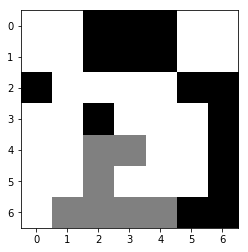

((3, 2), (4, 3)): n_v:  1355 q_all:-0.267243 q:-0.074999 q_m:-0.033333 p:0.372634
((3, 2), (5, 2)): n_v:   911 q_all:-0.193439 q:-0.310347 q_m:-0.200000 p:0.009605
((3, 2), (4, 2)): n_v:   381 q_all:-0.333648 q:-0.296587 q_m:-0.033333 p:0.182719
((6, 5), (6, 4)): n_v:   365 q_all:-0.256266 q:-0.496782 q_m:-0.166667 p:0.060905
((6, 6), (6, 4)): n_v:   304 q_all:-0.308262 q:-0.467115 q_m:-0.200000 p:0.121891
((2, 0), (4, 2)): n_v:   279 q_all:-0.245378 q:-0.300802 q_m:-0.066667 p:0.034158
((6, 5), (4, 3)): n_v:   220 q_all:-0.344097 q:-0.066381 q_m:-0.066667 p:0.113815
((2, 5), (4, 3)): n_v:    76 q_all:-0.442139 q:-0.223081 q_m:-0.066667 p:0.063159
((6, 5), (6, 3)): n_v:    16 q_all:-0.427774 q:-0.401568 q_m:-0.266667 p:0.012230
((4, 6), (6, 4)): n_v:    14 q_all:-0.487639 q:-0.541355 q_m:-0.200000 p:0.013800
((5, 6), (6, 4)): n_v:    12 q_all:-0.554274 q:-0.510710 q_m:-0.200000 p:0.014477
1 's turn
one move takes time(s):  0.3723869323730469
train_mode is both train
no. of data collect

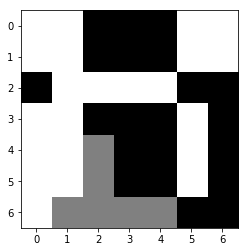

((3, 1), (4, 2)): n_v:  2555 q_all:+0.360675 q:+0.578481 q_m:+0.333333 p:0.356447
((4, 5), (6, 4)): n_v:   128 q_all:+0.385055 q:+0.092159 q_m:+0.233333 p:0.004969
((5, 5), (6, 4)): n_v:    99 q_all:+0.312960 q:+0.242748 q_m:+0.266667 p:0.030803
((6, 0), (4, 2)): n_v:    36 q_all:+0.294716 q:+0.527409 q_m:+0.300000 p:0.013794
((5, 0), (4, 2)): n_v:    29 q_all:+0.233797 q:+0.395188 q_m:+0.300000 p:0.017523
((3, 0), (4, 2)): n_v:    13 q_all:+0.136229 q:+0.319669 q_m:+0.300000 p:0.012584
((4, 0), (4, 2)): n_v:    11 q_all:+0.162233 q:+0.294405 q_m:+0.300000 p:0.009205
((5, 1), (6, 2)): n_v:     8 q_all:+0.132128 q:-0.007401 q_m:+0.133333 p:0.007778
((2, 4), (4, 2)): n_v:     4 q_all:+0.076694 q:+0.247248 q_m:+0.300000 p:0.005094
((2, 1), (4, 2)): n_v:     4 q_all:-0.211153 q:+0.142011 q_m:+0.300000 p:0.009130
((2, 3), (4, 2)): n_v:     1 q_all:+0.032712 q:+0.146896 q_m:+0.300000 p:0.001319
((2, 2), (4, 2)): n_v:     1 q_all:-0.131518 q:+0.046050 q_m:+0.300000 p:0.002317
((4, 1), (6, 2))

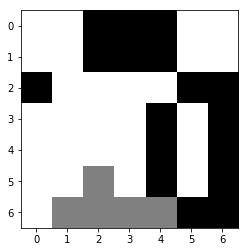

((4, 4), (5, 2)): n_v:  1723 q_all:-0.347697 q:-0.131100 q_m:-0.000000 p:0.457791
((5, 4), (5, 2)): n_v:  1338 q_all:-0.329724 q:-0.323365 q_m:-0.000000 p:0.283720
((3, 4), (5, 2)): n_v:   925 q_all:-0.347465 q:-0.377203 q_m:-0.000000 p:0.245365
((5, 4), (6, 4)): n_v:     3 q_all:-0.540738 q:-0.490953 q_m:-0.166667 p:0.003187
((6, 6), (6, 4)): n_v:     1 q_all:-0.483205 q:-0.484008 q_m:-0.200000 p:0.001346
((4, 4), (6, 2)): n_v:     1 q_all:-0.534235 q:-0.496185 q_m:-0.200000 p:0.001252
((4, 4), (6, 3)): n_v:     0 q_all:-0.571370 q:-0.571370 q_m:-0.266667 p:0.000311
((5, 4), (6, 3)): n_v:     0 q_all:-0.678150 q:-0.678150 q_m:-0.233333 p:0.000253
((5, 4), (6, 2)): n_v:     0 q_all:-0.718578 q:-0.718578 q_m:-0.200000 p:0.000817
((5, 6), (6, 4)): n_v:     0 q_all:-0.566130 q:-0.566130 q_m:-0.200000 p:0.000512
((4, 4), (6, 4)): n_v:     0 q_all:-0.472050 q:-0.472050 q_m:-0.200000 p:0.000071
((6, 5), (6, 3)): n_v:     0 q_all:-0.545784 q:-0.545784 q_m:-0.266667 p:0.000206
((4, 6), (6, 4))

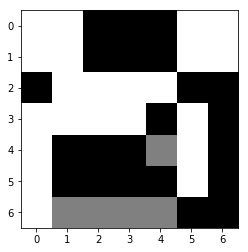

((3, 3), (4, 4)): n_v:  2989 q_all:+0.471505 q:+0.392655 q_m:+0.300000 p:0.245269
((5, 0), (6, 1)): n_v:     7 q_all:+0.305923 q:+0.327247 q_m:+0.166667 p:0.004161
((5, 5), (6, 4)): n_v:     4 q_all:+0.165011 q:+0.175985 q_m:+0.233333 p:0.004880
((2, 2), (4, 4)): n_v:     2 q_all:-0.160773 q:-0.083267 q_m:+0.266667 p:0.004791
((2, 3), (4, 4)): n_v:     2 q_all:-0.171214 q:-0.095732 q_m:+0.266667 p:0.004728
((2, 4), (4, 4)): n_v:     2 q_all:-0.090515 q:-0.032676 q_m:+0.266667 p:0.003778
((3, 2), (4, 4)): n_v:     1 q_all:-0.277752 q:-0.151381 q_m:+0.266667 p:0.002352
((6, 0), (6, 2)): n_v:     1 q_all:+0.274192 q:+0.274192 q_m:+0.200000 p:0.001035
((5, 5), (6, 3)): n_v:     0 q_all:+0.162665 q:+0.162665 q_m:+0.200000 p:0.000061
((4, 5), (6, 4)): n_v:     0 q_all:+0.182919 q:+0.182919 q_m:+0.200000 p:0.000312
((4, 0), (6, 2)): n_v:     0 q_all:-0.140735 q:-0.140735 q_m:+0.200000 p:0.000097
((5, 0), (6, 2)): n_v:     0 q_all:+0.082365 q:+0.082365 q_m:+0.200000 p:0.000485
((4, 5), (6, 3))

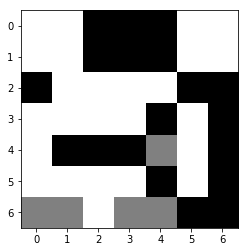

((6, 5), (4, 4)): n_v:   693 q_all:+0.023712 q:-0.018871 q_m:+0.133333 p:0.066340
((4, 3), (6, 1)): n_v:   597 q_all:-0.019453 q:-0.085264 q_m:+0.066667 p:0.180611
((3, 4), (4, 4)): n_v:   164 q_all:-0.134152 q:-0.075399 q_m:+0.166667 p:0.139709
((5, 6), (4, 4)): n_v:    85 q_all:-0.091279 q:-0.074106 q_m:+0.133333 p:0.055330
((4, 6), (4, 4)): n_v:    53 q_all:-0.106691 q:-0.254056 q_m:+0.133333 p:0.038550
((3, 6), (4, 4)): n_v:    51 q_all:-0.139380 q:-0.222358 q_m:+0.133333 p:0.044712
((4, 2), (4, 4)): n_v:    34 q_all:-0.330639 q:-0.211849 q_m:+0.133333 p:0.060502
((4, 2), (6, 1)): n_v:    32 q_all:+0.033729 q:+0.017838 q_m:+0.066667 p:0.001119
((6, 6), (4, 4)): n_v:    22 q_all:-0.102910 q:-0.084292 q_m:+0.133333 p:0.015567
((2, 6), (4, 4)): n_v:    15 q_all:-0.120612 q:-0.184541 q_m:+0.133333 p:0.012008
((2, 5), (4, 4)): n_v:    11 q_all:-0.392841 q:-0.265539 q_m:+0.133333 p:0.024648
((4, 1), (6, 1)): n_v:     1 q_all:-0.084171 q:-0.054774 q_m:+0.066667 p:0.000721
((4, 2), (6, 4))

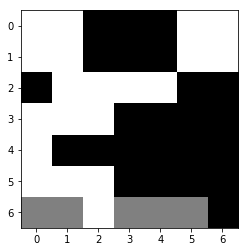

((6, 2), (6, 4)): n_v:  1126 q_all:-0.042101 q:+0.057010 q_m:+0.066667 p:0.348168
((5, 2), (6, 4)): n_v:  1039 q_all:+0.012946 q:-0.051768 q_m:+0.066667 p:0.089854
((5, 2), (6, 3)): n_v:   135 q_all:-0.124054 q:-0.069188 q_m:+0.033333 p:0.086367
((5, 1), (6, 3)): n_v:    47 q_all:-0.316021 q:-0.181500 q_m:-0.000000 p:0.067889
((6, 2), (6, 0)): n_v:    33 q_all:-0.167879 q:-0.333548 q_m:-0.133333 p:0.027537
((5, 0), (6, 0)): n_v:    25 q_all:-0.215877 q:-0.359482 q_m:-0.100000 p:0.024339
((5, 0), (6, 1)): n_v:    20 q_all:-0.548619 q:-0.201082 q_m:-0.100000 p:0.047245
((4, 0), (6, 1)): n_v:    20 q_all:-0.588471 q:-0.554295 q_m:-0.133333 p:0.051050
((4, 0), (6, 0)): n_v:     4 q_all:-0.587546 q:-0.630794 q_m:-0.133333 p:0.012011
((5, 2), (6, 0)): n_v:     4 q_all:-0.350863 q:-0.208701 q_m:-0.133333 p:0.007049
-1 's turn
one move takes time(s):  0.16393423080444336
train_mode is both train
no. of data collected:  8


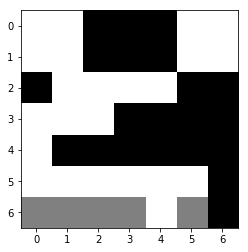

((5, 6), (6, 5)): n_v:  2686 q_all:+0.151582 q:+0.029905 q_m:+0.166667 p:0.525664
((4, 6), (6, 5)): n_v:   185 q_all:-0.039280 q:-0.187527 q_m:+0.133333 p:0.168173
((4, 2), (6, 1)): n_v:     3 q_all:-0.048539 q:+0.042900 q_m:+0.133333 p:0.003446
((4, 4), (6, 5)): n_v:     3 q_all:-0.324336 q:-0.080194 q_m:+0.133333 p:0.005481
((4, 1), (6, 1)): n_v:     3 q_all:+0.040969 q:+0.096840 q_m:+0.133333 p:0.002340
((4, 3), (6, 5)): n_v:     3 q_all:-0.152287 q:-0.117377 q_m:+0.133333 p:0.005261
((4, 1), (6, 3)): n_v:     2 q_all:+0.114576 q:+0.162514 q_m:+0.200000 p:0.000306
((4, 3), (6, 1)): n_v:     1 q_all:-0.143704 q:-0.074425 q_m:+0.133333 p:0.001729
((4, 4), (6, 3)): n_v:     0 q_all:-0.046614 q:-0.046614 q_m:+0.200000 p:0.000050
((4, 2), (6, 3)): n_v:     0 q_all:-0.115061 q:-0.115061 q_m:+0.200000 p:0.000135
((4, 5), (6, 3)): n_v:     0 q_all:+0.075402 q:+0.075402 q_m:+0.200000 p:0.000117
((4, 5), (6, 5)): n_v:     0 q_all:-0.163482 q:-0.163482 q_m:+0.133333 p:0.001134
((4, 2), (6, 2))

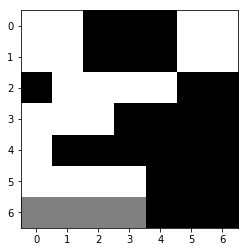

((5, 2), (6, 3)): n_v:  3101 q_all:-0.211844 q:-0.032113 q_m:-0.000000 p:0.298384
((5, 1), (6, 3)): n_v:   882 q_all:-0.282947 q:-0.124390 q_m:-0.033333 p:0.273136
((5, 3), (6, 1)): n_v:   115 q_all:-0.327082 q:-0.251167 q_m:-0.166667 p:0.051050
((5, 0), (6, 0)): n_v:     7 q_all:-0.532987 q:-0.392961 q_m:-0.133333 p:0.008079
((5, 0), (6, 1)): n_v:     6 q_all:-0.464968 q:-0.293652 q_m:-0.133333 p:0.005924
((4, 0), (6, 0)): n_v:     5 q_all:-0.644974 q:-0.651405 q_m:-0.166667 p:0.008333
((4, 0), (6, 1)): n_v:     4 q_all:-0.693467 q:-0.641551 q_m:-0.166667 p:0.006721
((5, 0), (6, 2)): n_v:     3 q_all:-0.599623 q:-0.519360 q_m:-0.166667 p:0.003540
((5, 1), (6, 2)): n_v:     3 q_all:-0.625903 q:-0.432336 q_m:-0.133333 p:0.003285
((5, 2), (6, 0)): n_v:     1 q_all:-0.448103 q:-0.316030 q_m:-0.166667 p:0.001407
((4, 0), (6, 2)): n_v:     0 q_all:-0.758507 q:-0.758507 q_m:-0.166667 p:0.001659
-1 's turn
one move takes time(s):  0.07907557487487793
train_mode is both train
no. of data colle

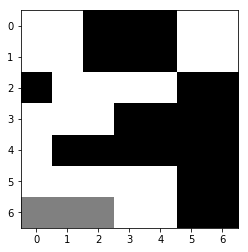

((4, 1), (6, 2)): n_v:  3614 q_all:+0.439313 q:+0.157095 q_m:+0.266667 p:0.488660
((4, 1), (6, 1)): n_v:   605 q_all:+0.185164 q:+0.185473 q_m:+0.200000 p:0.333122
((4, 2), (6, 1)): n_v:   112 q_all:+0.189026 q:+0.189026 q_m:+0.200000 p:0.059932
((4, 4), (6, 2)): n_v:    62 q_all:+0.055773 q:+0.076329 q_m:+0.266667 p:0.062784
((4, 3), (6, 1)): n_v:    14 q_all:-0.016575 q:+0.015159 q_m:+0.200000 p:0.017293
((4, 2), (6, 2)): n_v:     9 q_all:-0.129929 q:-0.121440 q_m:+0.266667 p:0.016759
((4, 3), (6, 2)): n_v:     9 q_all:-0.048541 q:-0.005894 q_m:+0.266667 p:0.011536
((4, 1), (6, 0)): n_v:     5 q_all:+0.178090 q:+0.178090 q_m:+0.133333 p:0.003101
((4, 2), (6, 0)): n_v:     2 q_all:-0.030534 q:+0.060697 q_m:+0.133333 p:0.002204
1 's turn
one move takes time(s):  0.0860295295715332
train_mode is both train
no. of data collected:  8


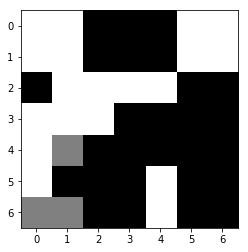

((3, 0), (4, 1)): n_v:  2269 q_all:-0.499547 q:-0.328490 q_m:-0.033333 p:0.113901
((4, 0), (6, 1)): n_v:  1947 q_all:-0.467851 q:-0.527526 q_m:-0.066667 p:0.051732
((2, 3), (4, 1)): n_v:   142 q_all:-0.544824 q:-0.426155 q_m:-0.066667 p:0.027082
((2, 2), (4, 1)): n_v:   106 q_all:-0.537512 q:-0.406935 q_m:-0.066667 p:0.018772
((5, 0), (6, 1)): n_v:    97 q_all:-0.517618 q:-0.344418 q_m:-0.033333 p:0.010679
((2, 1), (4, 1)): n_v:    94 q_all:-0.560363 q:-0.431657 q_m:-0.066667 p:0.023655
((5, 0), (6, 0)): n_v:     0 q_all:-0.767955 q:-0.767955 q_m:-0.166667 p:0.000038
((4, 0), (6, 0)): n_v:     0 q_all:-0.740606 q:-0.740606 q_m:-0.200000 p:0.000017
-1 's turn
one move takes time(s):  0.08236265182495117
train_mode is both train
no. of data collected:  8


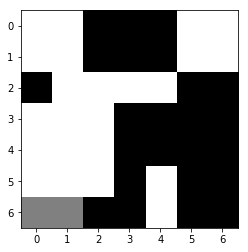

((6, 2), (6, 1)): n_v:  1655 q_all:+0.654744 q:+0.653174 q_m:+0.266667 p:0.689505
((6, 3), (6, 1)): n_v:  1449 q_all:+0.728969 q:+0.296209 q_m:+0.233333 p:0.265247
((5, 3), (6, 1)): n_v:     8 q_all:+0.005652 q:+0.131359 q_m:+0.233333 p:0.021880
((4, 3), (6, 1)): n_v:     6 q_all:-0.137684 q:-0.002333 q_m:+0.233333 p:0.019717
((6, 2), (6, 0)): n_v:     1 q_all:-0.002993 q:-0.002993 q_m:+0.166667 p:0.003550
1 's turn
one move takes time(s):  0.06297850608825684
train_mode is both train
no. of data collected:  8


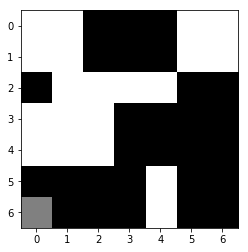

((4, 0), (6, 0)): n_v:  2040 q_all:-0.811259 q:-0.685863 q_m:-0.066667 p:0.842679
((4, 2), (6, 0)): n_v:   125 q_all:-0.966231 q:-0.367514 q_m:-0.066667 p:0.118691
((4, 1), (6, 0)): n_v:    42 q_all:-0.957843 q:-0.647726 q_m:-0.066667 p:0.038538
-1 's turn
one move takes time(s):  0.060430288314819336
train_mode is both train
no. of data collected:  8


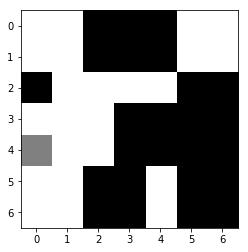

((6, 2), (4, 0)): n_v:  1909 q_all:+0.968479 q:+0.862692 q_m:+0.400000 p:0.126852
((2, 0), (4, 0)): n_v:  1873 q_all:+0.821050 q:+0.860095 q_m:+0.400000 p:0.843815
((5, 2), (4, 0)): n_v:    10 q_all:+0.007715 q:+0.373452 q_m:+0.400000 p:0.029320
1 's turn
one move takes time(s):  0.06134438514709473
train_mode is both train
no. of data collected:  8


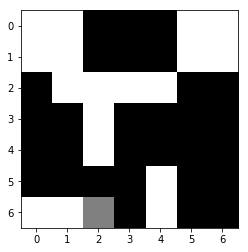

((6, 0), (6, 2)): n_v:  1679 q_all:-0.979449 q:-0.720398 q_m:-0.133333 p:0.435354
((6, 1), (6, 2)): n_v:   597 q_all:-1.000000 q:+5.000000 q_m:-0.100000 p:0.195408
((6, 4), (6, 2)): n_v:   487 q_all:-0.995857 q:-0.865226 q_m:-0.133333 p:0.152648
((4, 2), (6, 2)): n_v:   479 q_all:-0.974648 q:-0.753720 q_m:-0.133333 p:0.116572
((5, 4), (6, 2)): n_v:   376 q_all:-0.981298 q:-0.830287 q_m:-0.133333 p:0.099726
-1 's turn
one move takes time(s):  0.04533815383911133
train_mode is both train
no. of data collected:  8


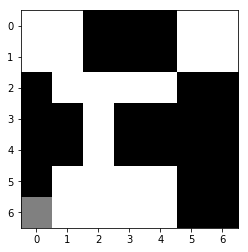

((5, 0), (6, 0)): n_v:  3282 q_all:+1.000000 q:+5.000000 q_m:+0.300000 p:0.881707
((4, 0), (6, 0)): n_v:   102 q_all:+0.761549 q:+0.363125 q_m:+0.266667 p:0.111238
((4, 1), (6, 0)): n_v:     2 q_all:-0.175612 q:+0.236582 q_m:+0.266667 p:0.006732
this self play has 79 steps, time elapsed 97.11838388442993
winner is -1.0
episode 202 finished
episode 203 now start
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.3829317092895508
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.5517890453338623
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.067978858947754
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.711427927017212
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8776965141296387
train_mode is both train
no. of data collected

one move takes time(s):  0.4145190715789795
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.3956031799316406
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.2937777042388916
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2676222324371338
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5351612567901611
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5003728866577148
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.35145139694213867
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.23687100410461426
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.24609375
train_mode is 

one move takes time(s):  0.9423069953918457
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.9516658782958984
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8469486236572266
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.7312700748443604
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.37032437324523926
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.3962540626525879
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.47518181800842285
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8251612186431885
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.5944464206695557
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s)

Epoch 22/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8609 - activation_29_loss: 1.8269 - dense_15_loss: 0.0088 - val_loss: 1.8801 - val_activation_29_loss: 1.8445 - val_dense_15_loss: 0.0105
Epoch 23/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8589 - activation_29_loss: 1.8250 - dense_15_loss: 0.0087 - val_loss: 1.8805 - val_activation_29_loss: 1.8448 - val_dense_15_loss: 0.0105
Epoch 24/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8588 - activation_29_loss: 1.8247 - dense_15_loss: 0.0089 - val_loss: 1.8806 - val_activation_29_loss: 1.8449 - val_dense_15_loss: 0.0106
Epoch 25/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8577 - activation_29_loss: 1.8236 - dense_15_loss: 0.0089 - val_loss: 1.8809 - val_activation_29_loss: 1.8451 - val_dense_15_loss: 0.0105
Epoch 26/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8564 - activation_29_loss: 1.8225 - dense_1

9000/9000 [==============================] - 1s 97us/step - loss: 1.8333 - activation_29_loss: 1.8000 - dense_15_loss: 0.0080 - val_loss: 1.8844 - val_activation_29_loss: 1.8489 - val_dense_15_loss: 0.0102
Epoch 60/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8326 - activation_29_loss: 1.7994 - dense_15_loss: 0.0080 - val_loss: 1.8845 - val_activation_29_loss: 1.8490 - val_dense_15_loss: 0.0103
Epoch 61/512
9000/9000 [==============================] - 1s 91us/step - loss: 1.8321 - activation_29_loss: 1.7989 - dense_15_loss: 0.0080 - val_loss: 1.8848 - val_activation_29_loss: 1.8493 - val_dense_15_loss: 0.0103
Epoch 62/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8318 - activation_29_loss: 1.7986 - dense_15_loss: 0.0079 - val_loss: 1.8851 - val_activation_29_loss: 1.8495 - val_dense_15_loss: 0.0104
Epoch 63/512
9000/9000 [==============================] - 1s 92us/step - loss: 1.8315 - activation_29_loss: 1.7982 - dense_15_loss: 0.008

one move takes time(s):  0.7769584655761719
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.467221736907959
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7185711860656738
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.2888920307159424
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.23624348640441895
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.5578863620758057
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7420730590820312
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.72511887550354
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.6229503154754639
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move




no. of data collected:  8
1 's turn
due to time lim, final rollout times:  33 time elapsed:  6.0057213306427
one move takes time(s):  6.08462381362915
no. of data collected:  0
-1 's turn
due to rollout lim, final rollout times:  1726 time elapsed:  2.000159740447998
one move takes time(s):  2.0014312267303467
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1751 time elapsed:  2.004356861114502


This is a random move


one move takes time(s):  2.0056324005126953
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.436587333679199
one move takes time(s):  3.4379169940948486
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0388379096984863
one move takes time(s):  2.040038824081421
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  16

due to rollout lim, final rollout times:  1601 time elapsed:  4.703947067260742
one move takes time(s):  4.705233335494995
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.089839458465576
one move takes time(s):  2.0908730030059814
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.9489963054656982
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.3308768272399902
one move takes time(s):  3.3321266174316406
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  5.623177766799927
one move takes time(s):  5.624549388885498
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.2970027923583984
one move takes time(s):  3.2982659339904785
train_mode is both train
no. 

one move takes time(s):  1.2102479934692383
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2684595584869385
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.5856115818023682
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.8553178310394287
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.32581448554992676
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4814620018005371
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.3121492862701416
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.4731011390686035
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.45621180534362793
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.43205714225769043
tra

one move takes time(s):  1.3240623474121094
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.7091219425201416
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0368304252624512
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3098556995391846
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5140867233276367
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  1.239234209060669
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0965907573699951
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.7021772861480713
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6553516387939453
train_mode is both train
no. of data collected:  8
1 's turn


due to rollout lim, final rollout times:  1601 time elapsed:  2.21071720123291
one move takes time(s):  2.21195125579834
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.7365100383758545
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.7641289234161377
one move takes time(s):  2.7653896808624268
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.5351154804229736
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.0345637798309326


This is a random move


one move takes time(s):  2.035853862762451
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.9675769805908203
one move takes time(s):  2.968921422958374
train_mode is both train
no. of data collected:  8
1 's tu

Epoch 9/512
9000/9000 [==============================] - 1s 96us/step - loss: 1.8758 - activation_29_loss: 1.8418 - dense_15_loss: 0.0088 - val_loss: 1.9095 - val_activation_29_loss: 1.8738 - val_dense_15_loss: 0.0105
Epoch 10/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8752 - activation_29_loss: 1.8412 - dense_15_loss: 0.0088 - val_loss: 1.9105 - val_activation_29_loss: 1.8748 - val_dense_15_loss: 0.0105
Epoch 11/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8738 - activation_29_loss: 1.8399 - dense_15_loss: 0.0088 - val_loss: 1.9104 - val_activation_29_loss: 1.8747 - val_dense_15_loss: 0.0105
Epoch 12/512
9000/9000 [==============================] - 1s 93us/step - loss: 1.8729 - activation_29_loss: 1.8391 - dense_15_loss: 0.0086 - val_loss: 1.9108 - val_activation_29_loss: 1.8751 - val_dense_15_loss: 0.0104
Epoch 13/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8708 - activation_29_loss: 1.8370 - dense_15

9000/9000 [==============================] - 1s 93us/step - loss: 1.8432 - activation_29_loss: 1.8100 - dense_15_loss: 0.0080 - val_loss: 1.9150 - val_activation_29_loss: 1.8793 - val_dense_15_loss: 0.0104
Epoch 47/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8419 - activation_29_loss: 1.8088 - dense_15_loss: 0.0079 - val_loss: 1.9151 - val_activation_29_loss: 1.8795 - val_dense_15_loss: 0.0104
Epoch 48/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8412 - activation_29_loss: 1.8081 - dense_15_loss: 0.0079 - val_loss: 1.9152 - val_activation_29_loss: 1.8796 - val_dense_15_loss: 0.0104
Epoch 49/512
9000/9000 [==============================] - 1s 95us/step - loss: 1.8407 - activation_29_loss: 1.8077 - dense_15_loss: 0.0078 - val_loss: 1.9148 - val_activation_29_loss: 1.8792 - val_dense_15_loss: 0.0104
Epoch 50/512
9000/9000 [==============================] - 1s 94us/step - loss: 1.8400 - activation_29_loss: 1.8069 - dense_15_loss: 0.007

one move takes time(s):  1.5978667736053467
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.48860502243042
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.6349260807037354
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1715 time elapsed:  2.008848190307617
one move takes time(s):  2.0101535320281982
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.011873960494995
one move takes time(s):  3.01324462890625
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.2593982219696045
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.3590519428253174
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.0309762954711914
train_mode is both train
no. of data collected:  8
1 's turn


one move takes time(s):  1.8415088653564453
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.1416752338409424


This is a random move


one move takes time(s):  3.1431350708007812
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.5906338691711426
one move takes time(s):  2.59199595451355
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  1.4846618175506592
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1843271255493164
one move takes time(s):  2.185706853866577
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.088204383850098
one move takes time(s):  4.089665412902832
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, fi

due to rollout lim, final rollout times:  1601 time elapsed:  4.429065227508545
one move takes time(s):  4.430398941040039
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  3.4719786643981934
one move takes time(s):  3.4740302562713623
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.1411988735198975
one move takes time(s):  2.1424880027770996
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.2091007232666016
one move takes time(s):  2.21048903465271
train_mode is both train
no. of data collected:  8
1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  2.3288111686706543
one move takes time(s):  2.3300514221191406
train_mode is both train
no. of data collected:  8
-1 's turn
due to rollout lim, final rollout times:  1601 time elapsed:  4.3371860

one move takes time(s):  0.1270437240600586
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.09026789665222168
train_mode is both train
no. of data collected:  8
1 's turn


This is a random move


one move takes time(s):  0.09881138801574707
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.06415510177612305
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.04920816421508789
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  0.04690980911254883
train_mode is both train
no. of data collected:  8
this self play has 73 steps, time elapsed 121.56339120864868
winner is -1.0
episode 213 finished
episode 214 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.4033515453338623
train_mode is both train
no. of data collected:  8
1 's turn


This is a random mov

one move takes time(s):  1.0749523639678955
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.0989172458648682
train_mode is both train
no. of data collected:  8
-1 's turn


This is a random move


one move takes time(s):  1.0669679641723633
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.9151196479797363
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6661162376403809
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  0.8260855674743652
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.6729426383972168
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  1.4045796394348145
train_mode is both train
no. of data collected:  8
-1 's turn
one move takes time(s):  0.5580391883850098
train_mode is both train
no. of data collected:  8
1 's turn
one move takes time(s):  

In [ ]:
player._mode = 4 # almost mode 1
player.reinforcement_learning(episode=300, left_space_max=None, rollout_times=1600, train_interval=5, \
                              life_span=15, t_lim=6, self_play_verbose=False, train_mode=0)

In [ ]:
player.tester(Q=True, P=True, BOTH=False, mode=0, times=1000, dep_lim=1, rollout_times=400, verbose=False)

####               ####
#### start testing ####
testing took time:  432.83274936676025
67.17324561403508



                        win ratio of Q is 0.456 





####               ####
#### start testing ####
testing took time:  438.1871075630188
63.263081395348834



                        win ratio of P is 0.688 







{'P': 0.688, 'Q': 0.456}

In [ ]:
player.zero_out_pretraining()

In [ ]:
player.reset()
player.tester(P=True, Q=True, times=500)
for i in range(5):
    player.reinforcement_pretraining(rounds=500)
    player.reset()
    player.tester(P=True, Q=True, times=500)

In [ ]:
w = player._network._model.get_weights()
fig = plt.gcf()
print(w[0].shape)
show_w = w[0]
for in_layer in range(6):
    for out_layer in range(64):
        print('in', in_layer, 'out', out_layer)
        plt.imshow(show_w[..., in_layer, out_layer], cmap='gray')
        plt.pause(0.1)